# Extraction of extracellular matrix from histological microscopic images of the liver using machine learning methods
Jan Burian

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
# Google Drive setup
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


## Installing dependencies and import needed modules

### ImageSplitterMerger

In [ ]:
# Installations of needed modules
!pip install openslide-python openslide-bin imagecodecs loguru read_roi czifile
!pip install git+https://github.com/mjirik/imma.git

# WSI tools installation
!pip install git+https://github.com/mjirik/wsitools.git

# Modules import
import matplotlib.pyplot as plt
import numpy as np
import imma
import requests

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 359.0/359.0 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.6/39.6 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for openslide-python: filename=openslide_python-1.3.1-cp310-cp310-linux_x86_64.whl size=33547 sha256=42f387c20276a6b8a394693c6bcb486f8d02475c55e72358b4097a81de95b2da
  Stored in directory: /root/.cache/pip/wheels/79/79/fa/29a0087493c69dff7fd0b70fab5d6771002a531010161d2d97
  Created wheel for read_roi: filename=read_roi-1.6.0-py2.py3-none-any.whl size=8017 sha256=e90c749b673c0e3baf436a9222e13983a7f834bdc4dd72ba856cdc42fd0b430c
  Stored in directory: /root/.cache/pip/wheels/09/67/72/4903ef58791d5330f9946373f84126b8b79027879ac828702e
Successfully built openslide-python read_ro

### MMDetection

In [ ]:
# install dependencies:
# Using older versions of torch and torchvision, as well as cuda 12.1 because of the compatibility
!pip install -U torch==2.1.0+cu121 torchvision==0.16.0+cu121 -f https://download.pytorch.org/whl/torch_stable.html

# install mmcv thus we could use CUDA operators
!pip install mmcv==2.1.0 -f https://download.openmmlab.com/mmcv/dist/cu121/torch2.1/index.html

# Install mmdetection
!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection

!pip install -e .

!pip install -U openmim

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in links: https://download.openmmlab.com/mmcv/dist/cu121/torch2.1/index.html
Cloning into 'mmdetection'...
remote: Enumerating objects: 38019, done.
remote: Counting objects: 100% (102/102), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 38019 (delta 39), reused 60 (delta 25), pack-reused 37917
Receiving objects: 100% (38019/38019), 63.24 MiB | 9.46 MiB/s, done.
Resolving deltas: 100% (26201/26201), done.
/content/mmdetection
Obtaining file:///content/mmdetection
  Preparing metadata (setup.py) ... done
  Running setup.py develop for mmdet


In [ ]:
# Check Pytorch installation
import torch, torchvision
print("torch version:",torch.__version__, "cuda:",torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print("mmdetection:",mmdet.__version__)

# Check mmcv installation
import mmcv
print("mmcv:",mmcv.__version__)

# Check mmengine installation
import mmengine
print("mmengine:",mmengine.__version__)

# Modueles import
import mmcv
import mmengine
from mmdet.apis import init_detector, inference_detector
from mmdet.utils import register_all_modules

torch version: 2.1.0+cu121 cuda: True
mmdetection: 3.3.0
mmcv: 2.1.0
mmengine: 0.10.4


In [ ]:
%%bash
# Check nvcc version
nvcc -V
echo

# Check GCC version
gcc --version
echo

# Check the version of torch and cuda packages
pip list | grep "torch\|cuda"

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0

gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
Copyright (C) 2021 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.


cupy-cuda12x                     12.2.0
jaxlib                           0.4.26+cuda12.cudnn89
torch                            2.1.0+cu121
torchaudio                       2.2.1+cu121
torchdata                        0.7.1
torchsummary                     1.5.1
torchtext                        0.17.1
torchvision                      0.16.0+cu121


### U-Net

In [ ]:
import numpy as np
import keras
import tensorflow as tf
from tensorflow.keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array
from PIL import Image
from skimage.transform import resize

### Inpainting

In [ ]:
from skimage.restoration import inpaint
from skimage.morphology import dilation

## CZI file

In [ ]:
# Possible filenames: J7_5_a.czi, J7_25_a_ann0004.czi, J8_8_a.czi
# filename = "J7_5_a.czi"
filename = "J8_8_a.czi"

# URL of the file on GitHub
url_path = "https://github.com/janburian/Masters_thesis/raw/main/data_czi/" + filename

# Fetch the file
response = requests.get(url_path)

# Check if the request was successful
if response.status_code == 200:
    # Save the content to a local file
    with open(filename, "wb") as file:
        file.write(response.content)
else:
    print("Failed to fetch the file from GitHub")

## Segmentation setup

### Mask R-CNN (MMDetection)

In [ ]:
# Own config file and corresponding pretrained weights
# Choose to use a config and initialize the detector
config_file = '/content/gdrive/MyDrive/cell_nuclei_data/COCO_cell_nuclei/tutorial_exps/mask-rcnn_r50-caffe_fpn_ms-poly-3x_coco/mask-rcnn_r50-caffe_fpn_ms-poly-3x_cell_nuclei.py'

# Setup a checkpoint file to load
checkpoint_file = '/content/gdrive/MyDrive/cell_nuclei_data/COCO_cell_nuclei/tutorial_exps/mask-rcnn_r50-caffe_fpn_ms-poly-3x_coco/epoch_36.pth'

# register all modules in mmdet into the registries
register_all_modules()

def is_mlu_available():
    """Returns a bool indicating if MLU is currently available."""
    return hasattr(torch, 'is_mlu_available') and torch.is_mlu_available()

def get_device():
    """Returns an available device, cpu, cuda or mlu."""
    is_device_available = {
        'cuda': torch.cuda.is_available(),
        'mlu': is_mlu_available()
    }
    device_list = [k for k, v in is_device_available.items() if v]
    return device_list[0] if len(device_list) == 1 else 'cpu'

# build the model from a config file and a checkpoint file
model_mask_rcnn = init_detector(config_file, checkpoint_file, device=get_device())  # or device='cuda:0'

Loads checkpoint by local backend from path: /content/gdrive/MyDrive/cell_nuclei_data/COCO_cell_nuclei/tutorial_exps/mask-rcnn_r50-caffe_fpn_ms-poly-3x_coco/epoch_36.pth


### UNet

In [ ]:
@keras.saving.register_keras_serializable()
def jaccard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

@keras.saving.register_keras_serializable()
def jaccard_coef_loss(y_true, y_pred):
    return -jaccard_coef(y_true, y_pred)  # -1 multiplied as we want to minimize this value as loss function

In [ ]:
unet_model_path = '/content/gdrive/MyDrive/cell_nuclei_data/output/unet/20240415-13:06_unet_cell_nuclei_150epochs.keras'
model_unet = load_model(unet_model_path)

In [ ]:
unet_model_ECM_path = '/content/gdrive/MyDrive/ECM_data/unet_ECM_final_50epochs_white_places.keras'
model_unet_ECM = load_model(unet_model_ECM_path)

## Auxiliary methods (segmentation)

In [ ]:
def do_inference_unet(img: np.array, model_unet, orig_tile_shape: tuple) -> np.array:
  # print(model_unet.input_shape[1:3])
  tensor_img = tf.convert_to_tensor(img)
  resized_image = tf.image.resize(tensor_img, model_unet.input_shape[1:3])  # Match model input size
  x = img_to_array(resized_image)
  x = x / 255.0  # Assuming model expects normalized values (0-1)
  x = np.expand_dims(x, axis=0)

  # Get segmentation mask
  mask = model_unet.predict(x)

  mask = np.squeeze(mask, axis=0)
  # plt.imshow(mask, cmap="gray")
  # plt.show()

  # Thresholding output mask
  threshold = 0.4  # You can adjust this value based on your needs
  mask = (mask[..., 0] > threshold).astype(np.uint8)  # Assuming channel 0 and converting to uint8 for binary mask
  # plt.imshow(mask, cmap="gray")
  # plt.show()

  mask_resized_back = resize(mask, orig_tile_shape[0:2], preserve_range=True)
  return mask_resized_back


# def do_inference_mask_rcnn(image: np.array, model_mask_rcnn):
#   # Use the detector to do inference
#   result = inference_detector(model_mask_rcnn, image)
#   predictions_data = result.pred_instances
#   masks_torch = predictions_data.masks
#   # print(masks_torch)
#   mask = np.zeros(image.shape)
#   if len(masks_torch > 0):
#     mask = create_mask_from_inference_mask_rcnn(masks_torch)

#   return mask


# def create_mask_from_inference_mask_rcnn(masks_torch_all):
#   temp_list = []
#   print(len(masks_torch_all))
#   for mask in masks_torch_all:
#     mask_numpy = mask.cpu().numpy()
#     mask_numpy = mask_numpy.astype("uint8")
#     temp_list.append(mask_numpy)
#   # print(len(temp_list))
#   # plt.imshow(np.sum(temp_list, axis=0), cmap='gray')
#   # plt.show()
#   return np.sum(temp_list, axis=0) # final mask made from inference



def apply_dilation(mask, num_steps_dilation) -> np.array:
  for i in range(num_steps_dilation):
      mask = dilation(mask)

  return mask


def do_inpainting_biharmonic(orig_tile: np.array, mask: np.array) -> np.array:
  img_removed_nuclei = inpaint.inpaint_biharmonic(orig_tile, mask, channel_axis=-1)
  # plt.imshow(img_removed_nuclei[:,:,::-1])
  # plt.show()

  return img_removed_nuclei

## Auxiliary methods 1 (removing extracellular matrix)

In [ ]:
# def get_lobules(img_array: np.array) -> np.array:
#   """
#   Isolates lobules in an image using the HSV color space.

#   This function takes an RGB image as a NumPy array and returns a mask highlighting lobule regions.

#   Args:
#     img_array: A NumPy array representing the image in RGB format.

#   Returns:
#     A NumPy array representing the mask for lobules (white pixels).
#   """

#   # img_array = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)

#   # plt.imshow(img_array)
#   # plt.show()

#   # Normalize image if needed (ensure 0-255 range)
#   if img_array.dtype != np.uint8:
#     img_array_normalized = cv2.normalize(img_array, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_32F)
#     img_array_normalized = img_array_normalized.astype(np.uint8)
#     img_array = img_array_normalized

#   # plt.imshow(img_array)
#   # plt.show()

#   # Convert image from RGB to HSV color space
#   hsv = cv2.cvtColor(img_array, cv2.COLOR_RGB2HSV) # HSV is better suited for color segmentation tasks

#   # Define lower and upper bounds for lobules in HSV
#   lower_bound = np.array([10, 100, 50])
#   upper_bound = np.array([30, 255, 255])

#   # Create a mask to identify pixels within the lobule HSV range
#   lobules_structure_mask = cv2.inRange(hsv, lower_bound, upper_bound)

#   # Apply morphological operations to refine the mask
#   # Dilate the mask to expand lobule boundaries (optional, adjust iterations for effect)
#   mask_dilated = dilation(lobules_structure_mask)  # Replace with your preferred dilation function
#   for _ in range(5):
#     mask_dilated = dilation(mask_dilated)  # Repeat dilation for further expansion

#   # Perform morphological closing to fill small holes in the mask
#   mask_dilated = closing(mask_dilated)

#   # Refine the mask using XOR operation (improves lobule separation)
#   lobules_structure_mask = mask_dilated ^ lobules_structure_mask

#   # plt.imshow(lobules_structure_mask, cmap='gray')
#   # plt.show()

#   return lobules_structure_mask


# def remove_orange_brown(image) -> np.array:
#   """
#   Removes orange and brown shades from an image using HSV color space.

#   Args:
#       image_path (str): Path to the image file.

#   Returns:
#       numpy.ndarray: The modified image with reduced orange-brown shades.
#   """
#   if image.dtype != np.uint8:
#     # Normalize to 0-255 range
#     image_normalized = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_32F)

#     # Convert to uint8 for compatibility
#     image_normalized = image_normalized.astype(np.uint8)
#     image = image_normalized

#   # plt.imshow(image)
#   # plt.show()

#   # Convert image to BGR
#   image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
#   # plt.imshow(image[:, :, ::-1])
#   # plt.show()

#   # Convert the image to HSV color space
#   hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

#   # Define lower and upper bounds for orange-brown in HSV (adjust as needed)
#   # Hue ranges from 0-179, Saturation and Value range from 0-255
#   lower_orange_brown = np.array([10, 50, 40])  # Orig 10, 0, 40
#   upper_orange_brown = np.array([30, 200, 255])  # Orig 50, 255, 255

#   # Create a mask to identify orange-brown pixels
#   mask = cv2.inRange(hsv_image, lower_orange_brown, upper_orange_brown)

#   # Invert the mask to target non-orange-brown pixels
#   # mask = cv2.bitwise_not(mask)
#   dilated_mask = dilation(mask)
#   dilated_mask = dilation(dilated_mask)

#   contours = dilated_mask ^ mask
#   # contours = binary_closing(contours).astype("uint8")

#   # plt.imshow(contours, cmap='gray')
#   # plt.show()

#   # Apply the mask to the original image (preserves non-orange-brown colors)
#   result = cv2.bitwise_and(image, image, mask=contours)

#   # plt.imshow(result)
#   # plt.show()

#   return result

# def make_white_background(image: np.array) -> np.array:
#   """
#   Replaces black pixels in an image with a white background.

#   This function takes an RGB image as a NumPy array and returns a new image
#   where all pixels originally matching a specific black color are replaced
#   with a white color.

#   Args:
#     image: A NumPy array representing the image in RGB format.

#   Returns:
#     A new NumPy array representing the modified image with a white background.
#   """

#   # Define black pixel value
#   black_pixel = (0, 0, 0)  # pure black color in RGB format.

#   # Define white pixel value
#   white_pixel = (255, 255, 255)  # pure white color in RGB format.

#   # Create a mask to identify black pixels
#   mask = np.all(image == black_pixel, axis=-1) # True for pixels where all RGB channels match the black_pixel value.

#   # Replace black pixels with white using the mask
#   image[mask] = white_pixel # assigns the white_pixel value to all elements in the image where the mask is True.

#   return image


# def create_pink_contours(image: np.array, lobules_mask: np.array, color_structures: tuple, color_inside_lobules: tuple) -> np.array:
#   """
#   Creates pink contours around identified lobules and fills the inside with another color.

#   This function takes an image, a lobule mask, and two color definitions as input.
#   It modifies the image to create pink contours around the lobules (based on the mask)
#   and fills the inside of the lobules with another color.

#   Args:
#     image: A NumPy array representing the image in RGB format.
#     lobules_mask: A NumPy array representing the lobule mask (white pixels indicate lobules).
#     color_structures: A tuple representing the RGB color for the contours (pink).
#     color_inside_lobules: A tuple representing the RGB color for the inside of lobules.

#   Returns:
#     A new NumPy array representing the modified image with pink lobule contours and colored insides.
#   """

#   # Define white pixel value
#   white_pixel = (255, 255, 255)

#   # Get indices of pixels to modify based on the lobule mask
#   indices = np.where(lobules_mask == 255)
#   # This identifies the row and column indices of pixels marked as lobules in the mask (white pixels).

#   # Change pixel color at the identified lobule indices
#   image[indices[0], indices[1], :] = color_structures
#   # This assigns the 'color_structures' (pink) to all pixels in the original image
#   # where the corresponding indices in the lobule_mask are white (representing lobules).

#   # plt.imshow(image)
#   # plt.show()

#   # Create a mask to identify non-white and non-structure colored pixels (inside lobules)
#   mask = np.any(image != white_pixel, axis=-1) & np.any(image != color_structures, axis=-1)
#   # This mask will be True for pixels that are neither white (background) nor the color_structures (pink).
#   # In essence, it selects the area inside the pink contours.

#   # Replace pixels inside lobules with the designated color
#   image[mask] = color_inside_lobules

#   return image


# def remove_extracellular_matrix(tile: np.array) -> np.array:
#   """
#   Removes extracellular matrix from a tissue image tile.

#   This function takes a NumPy array representing a tissue image tile as input.
#   It performs a series of steps to remove the extracellular matrix (ECM), which is the non-cellular material surrounding cells.
#   The output is a modified image tile with the ECM removed.

#   Args:
#     tile: A NumPy array representing the tissue image tile.

#   Returns:
#     A new NumPy array representing the modified image tile with the ECM removed.
#   """

#   # plt.imshow(tile)
#   # plt.show()

#   # Segment lobules using the get_lobules function
#   lobules = get_lobules(tile)

#   # Remove orange-brown color (representing ECM)
#   res = remove_orange_brown(tile)

#   # Replace black pixels with white background
#   res = make_white_background(res)

#   # Define color scheme
#   # pink_color_RGB_structures = (random.randint(195, 240), random.randint(75, 128), random.randint(182, 210))
#   pink_color_RGB_structures = (195, 75, 182)  # Fixed pink color for lobule contours (RGB)
#   pink_color_RGB_inside_lobules = (240, 231, 239)  # Fixed color for inside lobules (RGB)

#   # Convert RGB to BGR (OpenCV works with BGR format)
#   pink_color_BGR = (pink_color_RGB_structures[2], pink_color_RGB_structures[1], pink_color_RGB_structures[0])
#   grey_color_BGR = (pink_color_RGB_inside_lobules[2], pink_color_RGB_inside_lobules[1], pink_color_RGB_inside_lobules[0])

#   # Create pink contours around identified lobules and fill inside with another color
#   res = create_pink_contours(res, lobules, pink_color_BGR, grey_color_BGR)

#   # plt.imshow(res)
#   # plt.show()

#   return res

## Auxiliary methods 2 (removing extracellular matrix)

In [ ]:
def create_pink_contours(image: np.array) -> np.array:
  image = np.stack((image,) * 3, axis=-1)

  # Define black pixel value
  pink_color_RGB_structures = (195 / 255, 75 / 255, 182 / 255)  # Fixed pink color for lobule contours (RGB)

  indices = np.where(image <= 0.6)

  # Get indices of pixels to modify based on the lobule mask
  # Assuming black pixels have value 0
  # mask = image <= 0.5 # Create a mask where black pixels are True

  # plt.imshow(image, cmap='gray')
  # plt.show()

  # Apply target color to the mask while keeping non-black pixels unchanged
  # image[mask] = pink_color_RGB_structures
  image[indices[0], indices[1], :] = pink_color_RGB_structures

  # image_processed = process_sides(image, padding=1)

  # plt.imshow(image)
  # plt.show()

  return image

def convert_grayscale_to_RGB(grayscale_image: np.array):
  # Expand the grayscale channel to create a 3-channel image
  rgb_image = np.repeat(grayscale_image, 3, axis=2)
  # plt.imshow(rgb_image)
  # plt.show()
  return rgb_image

# import cv2
# def replace_grayscales(image, lower_threshold=0.35, upper_threshold=1):
#   """
#   Replaces a range of grayscales in an image with a new color.

#   Args:
#       image: The input grayscale image as a NumPy array.
#       new_color: The desired color to replace grayscales with (BGR format).
#       lower_threshold: Minimum grayscale value to replace (default: 70 - dark gray).
#       upper_threshold: Maximum grayscale value to replace (default: 255 - white).

#   Returns:
#       A new image with the specified grayscale range replaced by the new color.
#   """
#   # Convert grayscale image to a single-channel array for easier manipulation
#   gray_image = image.copy()

#   # pink_color_RGB_structures = (195 / 255, 75 / 255, 182 / 255)
#   new_color = (182 / 255, 75 / 255, 195 / 255) # BGR

#   # Replace pixels within the grayscale range with the new color
#   mask = cv2.inRange(gray_image, lower_threshold, upper_threshold)
#   # result = np.where(mask == 255, new_color, image)
#   fig, axes = plt.subplots(1, 2, figsize=(12, 6))
#   axes[0].imshow(gray_image, cmap="gray")
#   axes[0].set_title("Original Tile")
#   axes[0].axis('off')
#   axes[1].imshow(mask, cmap="gray")
#   axes[1].set_title("Mask")
#   axes[1].axis('off')
#   plt.show()

#   return mask # TODO


# def process_sides(image, padding=1):
#   """
#   Removes non-white pixels from the sides of an image and substitutes them with white pixels.

#   Args:
#       image: A NumPy array representing the grayscale or RGB image.
#       padding: The number of pixels to remove from each side (default 1).

#   Returns:
#       A new NumPy array with the modified image.
#   """

#   # Get image dimensions
#   rows, cols, channels = image.shape if len(image.shape) == 3 else (image.shape[0], image.shape[1], 1)

#   # Define slice ranges for removing side pixels (considering padding)
#   row_start = padding
#   row_end = rows - padding
#   col_start = padding
#   col_end = cols - padding

#   # Check if any pixels remain after removing sides (avoid potential errors)
#   if row_end <= row_start or col_end <= col_start:
#     raise ValueError("Padding value is too large. Image dimensions are too small.")

#   # Set non-white side pixels to white (considering channels)
#   image[0:row_start, :] = 1  # Top side
#   image[row_end:, :] = 1  # Bottom side
#   image[:, 0:col_start] = 1  # Left side
#   image[:, col_end:] = 1  # Right side

#   return image


In [ ]:
  def remove_ECM_unet(img: np.array, model_unet_ECM, orig_tile_shape):
    tensor_img = tf.convert_to_tensor(img)
    resized_image = tf.image.resize(tensor_img, model_unet.input_shape[1:3])  # Match model input size
    x = img_to_array(resized_image)
    # print("Test: " + str(x.shape))
    x = np.expand_dims(x, axis=0)

    # Get segmentation mask
    mask = model_unet_ECM.predict(x)
    mask = np.squeeze(mask, axis=0)

    # Thresholding output mask
    # threshold = 0.9  # You can adjust this value based on your needs # orig 0.9
    # mask = (mask[..., 0] > threshold).astype(np.uint8)  # Assuming channel 0 and converting to uint8 for binary mask
    # print(mask)
    mask_resized_back = resize(mask, orig_tile_shape[0:2], preserve_range=True)
    # print(mask_resized_back)

    return mask_resized_back

## Implementing *process_tile()* methods

In [ ]:
def process_tile(tile: np.array) -> np.array:
  orig_tile_shape = tile.shape
  mask = do_inference_unet(tile, model_unet, orig_tile_shape)
  # mask = create_mask_from_inferences(res_inference)
  # print(type(mask))
  if np.any(mask):  # determine whether in mask are white pixels
    mask_dil = apply_dilation(mask, 5)
    # plt.imshow(mask_dil)
    # plt.show()
    img_removed_cell_nuclei = do_inpainting_biharmonic(tile, mask_dil)
    img_removed_extracellular_matrix = remove_ECM_unet(img_removed_cell_nuclei, model_unet_ECM, orig_tile_shape)
    # plt.imshow(img_removed_extracellular_matrix)
    # plt.show()
    # print(img_removed_extracellular_matrix)
    # return img_removed_cell_nuclei
    # img_removed_extracellular_matrix_new_color = create_pink_contours(img_removed_extracellular_matrix)
    # img_removed_extracellular_matrix = convert_grayscale_to_RGB(img_removed_extracellular_matrix)
    # plt.imshow(img_removed_extracellular_matrix_new_color)
    # plt.show()
    # print(img_removed_extracellular_matrix_new_color)

    # fig, axes = plt.subplots(1, 4, figsize=(12, 6))
    # axes[0].imshow(tile)
    # axes[0].set_title("Original Tile")
    # axes[0].axis('off')
    # axes[1].imshow(mask_dil, cmap="gray")
    # axes[1].set_title("Mask")
    # axes[1].axis('off')
    # axes[2].imshow(img_removed_cell_nuclei)
    # axes[2].set_title("Tile with removed cell nuclei")
    # axes[2].axis('off')
    # axes[3].imshow(img_removed_extracellular_matrix)
    # axes[3].set_title("Removed ECM")
    # axes[3].axis('off')
    # plt.show()

    # plt.imshow(img_removed_extracellular_matrix)
    # plt.show()
    # print(img_removed_extracellular_matrix.shape)

    return img_removed_extracellular_matrix

    # return np.stack((img_removed_extracellular_matrix,) * 3, axis=-1) # TODO

  else: # no mask in tile; returning the original tile
      # plt.imshow(tile)
      # plt.show()
      # print(tile)
      # return tile
      tile_normalized = tile / 255.0
      img_removed_extracellular_matrix = remove_ECM_unet(tile_normalized, model_unet_ECM, orig_tile_shape)
      # img_removed_extracellular_matrix_new_color = create_pink_contours(img_removed_extracellular_matrix)
      # img_removed_extracellular_matrix_new_color = convert_grayscale_to_RGB(img_removed_extracellular_matrix)

      # plt.imshow(img_removed_extracellular_matrix)
      # plt.show()
      # print('TEST: ' + str(img_removed_extracellular_matrix.dtype))
      return img_removed_extracellular_matrix

      # return np.stack((img_removed_extracellular_matrix,) * 3, axis=-1) # TODO



# def process_tile_mask_rcnn(tile: np.array) -> np.array:
#   mask = do_inference_mask_rcnn(tile, model_mask_rcnn)
#   if np.any(mask):  # determine whether in mask are white pixels
#     mask_dil = apply_dilation(mask, 5)
#     # plt.imshow(mask_dil)
#     # plt.show()
#     img_removed_cell_nuclei = do_inpainting_biharmonic(tile, mask_dil)
#     img_removed_extracellular_matrix = remove_ECM_unet(img_removed_cell_nuclei, model_unet_ECM)
#     # print(img_removed_cell_nuclei.dtype)

#     # print(tile_removed_cell_nuclei)
#     # fig, axes = plt.subplots(1, 4, figsize=(12, 6))
#     # axes[0].imshow(tile)
#     # axes[0].set_title("Original Tile")
#     # axes[0].axis('off')
#     # axes[1].imshow(mask_dil, cmap="gray")
#     # axes[1].set_title("Mask")
#     # axes[1].axis('off')
#     # axes[2].imshow(img_removed_cell_nuclei)
#     # axes[2].set_title("Tile with removed cell nuclei")
#     # axes[2].axis('off')
#     # axes[3].imshow(img_removed_extracellular_matrix)
#     # axes[3].set_title("Removed ECM")
#     # axes[3].axis('off')
#     # plt.show()

#     # print(img_removed_cell_nuclei)
#     return img_removed_extracellular_matrix

#   else: # no mask in tile; returning the original tile
#       # plt.imshow(tile)
#       # plt.show()
#       # print(tile / 255.0)
#       return model_unet_ECM(tile, model_unet_ECM)

## Final part

2024-04-26 15:08:00.318 | WARNING  | wsitools.libfixer:<module>:15 - This module is deprecated. Use openslide and openslide_bin instead.
2024-04-26 15:08:00.332 | DEBUG    | wsitools.image:__init__:412 - fs_enc: utf-8
2024-04-26 15:08:00.333 | DEBUG    | wsitools.image:__init__:413 - Reading file J8_8_a.czi
2024-04-26 15:08:00.352 | DEBUG    | wsitools.image:_set_properties_czi:342 - nzi pixelsize  8.772367043811993e-07x8.772367043811993e-07 [m]
2024-04-26 15:08:00.354 | DEBUG    | wsitools.image:read_annotations:723 - Reading the annotation J8_8_a.czi


True


Splitting and Processing Tiles:   0%|          | 0/13206 [00:00<?, ?it/s]

1/1 [==============================] - 0s 408ms/step


Splitting and Processing Tiles:   0%|          | 1/13206 [00:03<13:24:30,  3.66s/it]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:   0%|          | 2/13206 [00:03<6:03:31,  1.65s/it] 

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:   0%|          | 3/13206 [00:04<3:42:40,  1.01s/it]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:   0%|          | 4/13206 [00:04<2:38:22,  1.39it/s]

1/1 [==============================] - 0s 83ms/step


Splitting and Processing Tiles:   0%|          | 5/13206 [00:04<2:16:06,  1.62it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:   0%|          | 6/13206 [00:05<1:56:30,  1.89it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:   0%|          | 7/13206 [00:05<1:38:34,  2.23it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:   0%|          | 8/13206 [00:05<1:24:46,  2.59it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:   0%|          | 9/13206 [00:06<1:15:11,  2.93it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:   0%|          | 10/13206 [00:06<1:08:16,  3.22it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:   0%|          | 11/13206 [00:06<1:03:55,  3.44it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:   0%|          | 12/13206 [00:06<1:04:13,  3.42it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:   0%|          | 13/13206 [00:07<1:02:28,  3.52it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   0%|          | 14/13206 [00:07<55:28,  3.96it/s]  

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   0%|          | 15/13206 [00:07<50:10,  4.38it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   0%|          | 16/13206 [00:07<48:03,  4.58it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   0%|          | 17/13206 [00:07<45:29,  4.83it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   0%|          | 18/13206 [00:07<42:56,  5.12it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   0%|          | 19/13206 [00:08<41:33,  5.29it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   0%|          | 20/13206 [00:08<40:06,  5.48it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   0%|          | 21/13206 [00:08<39:12,  5.60it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   0%|          | 22/13206 [00:08<38:51,  5.66it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   0%|          | 23/13206 [00:08<38:44,  5.67it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   0%|          | 24/13206 [00:08<38:29,  5.71it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   0%|          | 25/13206 [00:09<38:12,  5.75it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:   0%|          | 26/13206 [00:09<38:18,  5.73it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   0%|          | 27/13206 [00:09<38:06,  5.76it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   0%|          | 28/13206 [00:09<39:41,  5.53it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   0%|          | 29/13206 [00:09<38:25,  5.72it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:   0%|          | 30/13206 [00:10<40:29,  5.42it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   0%|          | 31/13206 [00:10<40:13,  5.46it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:   0%|          | 32/13206 [00:10<38:55,  5.64it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   0%|          | 33/13206 [00:10<38:31,  5.70it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   0%|          | 34/13206 [00:10<38:31,  5.70it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   0%|          | 35/13206 [00:10<37:39,  5.83it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   0%|          | 36/13206 [00:11<37:18,  5.88it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   0%|          | 37/13206 [00:11<36:53,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   0%|          | 38/13206 [00:11<37:51,  5.80it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   0%|          | 39/13206 [00:11<37:32,  5.85it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   0%|          | 40/13206 [00:11<38:43,  5.67it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   0%|          | 41/13206 [00:11<38:35,  5.69it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   0%|          | 42/13206 [00:12<38:17,  5.73it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   0%|          | 43/13206 [00:12<38:01,  5.77it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   0%|          | 44/13206 [00:12<37:17,  5.88it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   0%|          | 45/13206 [00:12<37:11,  5.90it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   0%|          | 46/13206 [00:12<37:27,  5.86it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   0%|          | 47/13206 [00:12<37:06,  5.91it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   0%|          | 48/13206 [00:13<37:38,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   0%|          | 49/13206 [00:13<38:01,  5.77it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   0%|          | 50/13206 [00:13<37:58,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   0%|          | 51/13206 [00:13<38:21,  5.72it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   0%|          | 52/13206 [00:13<39:16,  5.58it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   0%|          | 53/13206 [00:14<39:32,  5.54it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   0%|          | 54/13206 [00:14<38:18,  5.72it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   0%|          | 55/13206 [00:14<38:08,  5.75it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   0%|          | 56/13206 [00:14<39:05,  5.61it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:   0%|          | 57/13206 [00:14<40:01,  5.47it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   0%|          | 58/13206 [00:14<39:49,  5.50it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   0%|          | 59/13206 [00:15<38:46,  5.65it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   0%|          | 60/13206 [00:15<38:39,  5.67it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   0%|          | 61/13206 [00:15<39:47,  5.51it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   0%|          | 62/13206 [00:15<40:05,  5.46it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   0%|          | 63/13206 [00:15<40:03,  5.47it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   0%|          | 64/13206 [00:16<39:15,  5.58it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   0%|          | 65/13206 [00:16<40:09,  5.45it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   0%|          | 66/13206 [00:16<39:44,  5.51it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   1%|          | 67/13206 [00:16<39:32,  5.54it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   1%|          | 68/13206 [00:16<40:51,  5.36it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   1%|          | 69/13206 [00:16<41:32,  5.27it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:   1%|          | 70/13206 [00:17<44:03,  4.97it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:   1%|          | 71/13206 [00:17<49:20,  4.44it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:   1%|          | 72/13206 [00:17<51:06,  4.28it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:   1%|          | 73/13206 [00:17<52:22,  4.18it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:   1%|          | 74/13206 [00:18<53:10,  4.12it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:   1%|          | 75/13206 [00:18<55:05,  3.97it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:   1%|          | 76/13206 [00:18<57:31,  3.80it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:   1%|          | 77/13206 [00:19<57:11,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:   1%|          | 78/13206 [00:19<56:45,  3.85it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:   1%|          | 79/13206 [00:19<55:38,  3.93it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:   1%|          | 80/13206 [00:19<56:04,  3.90it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:   1%|          | 81/13206 [00:20<59:16,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:   1%|          | 82/13206 [00:20<58:44,  3.72it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   1%|          | 83/13206 [00:20<58:00,  3.77it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   1%|          | 84/13206 [00:20<51:36,  4.24it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   1%|          | 85/13206 [00:20<47:12,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   1%|          | 86/13206 [00:21<45:06,  4.85it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   1%|          | 87/13206 [00:21<43:49,  4.99it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   1%|          | 88/13206 [00:21<42:05,  5.19it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   1%|          | 89/13206 [00:21<41:38,  5.25it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   1%|          | 90/13206 [00:21<40:32,  5.39it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   1%|          | 91/13206 [00:22<40:32,  5.39it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   1%|          | 92/13206 [00:22<39:48,  5.49it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   1%|          | 93/13206 [00:22<39:59,  5.47it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   1%|          | 94/13206 [00:22<38:55,  5.61it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   1%|          | 95/13206 [00:22<38:43,  5.64it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   1%|          | 96/13206 [00:22<38:22,  5.69it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   1%|          | 97/13206 [00:23<39:54,  5.47it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:   1%|          | 98/13206 [00:23<39:36,  5.52it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   1%|          | 99/13206 [00:23<38:39,  5.65it/s]

1/1 [==============================] - 0s 17ms/step


Splitting and Processing Tiles:   1%|          | 100/13206 [00:23<38:00,  5.75it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   1%|          | 101/13206 [00:23<37:54,  5.76it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   1%|          | 102/13206 [00:23<37:33,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   1%|          | 103/13206 [00:24<46:59,  4.65it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   1%|          | 104/13206 [00:24<50:53,  4.29it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   1%|          | 105/13206 [00:24<55:21,  3.94it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:   1%|          | 106/13206 [00:25<58:34,  3.73it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   1%|          | 107/13206 [00:25<59:06,  3.69it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   1%|          | 108/13206 [00:25<1:00:41,  3.60it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   1%|          | 109/13206 [00:26<1:01:43,  3.54it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   1%|          | 110/13206 [00:26<1:03:54,  3.42it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   1%|          | 111/13206 [00:26<1:05:35,  3.33it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   1%|          | 112/13206 [00:26<1:06:51,  3.26it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   1%|          | 113/13206 [00:27<1:14:13,  2.94it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   1%|          | 114/13206 [00:27<1:16:55,  2.84it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   1%|          | 115/13206 [00:28<1:14:17,  2.94it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   1%|          | 116/13206 [00:28<1:16:59,  2.83it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   1%|          | 117/13206 [00:28<1:17:33,  2.81it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:   1%|          | 118/13206 [00:29<1:18:59,  2.76it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   1%|          | 119/13206 [00:29<1:19:48,  2.73it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   1%|          | 120/13206 [00:29<1:17:43,  2.81it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   1%|          | 121/13206 [00:30<1:17:48,  2.80it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:   1%|          | 122/13206 [00:30<1:28:33,  2.46it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:   1%|          | 123/13206 [00:31<1:46:55,  2.04it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:   1%|          | 124/13206 [00:32<1:51:19,  1.96it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:   1%|          | 125/13206 [00:32<1:53:06,  1.93it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:   1%|          | 126/13206 [00:33<1:53:32,  1.92it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:   1%|          | 127/13206 [00:33<1:56:34,  1.87it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:   1%|          | 128/13206 [00:34<1:55:15,  1.89it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   1%|          | 129/13206 [00:34<1:43:37,  2.10it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   1%|          | 130/13206 [00:34<1:30:06,  2.42it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   1%|          | 131/13206 [00:35<1:24:30,  2.58it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:   1%|          | 132/13206 [00:35<1:23:45,  2.60it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   1%|          | 133/13206 [00:35<1:21:05,  2.69it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   1%|          | 134/13206 [00:36<1:14:46,  2.91it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   1%|          | 135/13206 [00:36<1:08:52,  3.16it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   1%|          | 136/13206 [00:36<1:05:12,  3.34it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   1%|          | 137/13206 [00:36<1:01:50,  3.52it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   1%|          | 138/13206 [00:37<1:00:42,  3.59it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   1%|          | 139/13206 [00:37<1:00:09,  3.62it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   1%|          | 140/13206 [00:37<59:52,  3.64it/s]  

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   1%|          | 141/13206 [00:37<58:25,  3.73it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:   1%|          | 142/13206 [00:38<57:18,  3.80it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   1%|          | 143/13206 [00:38<51:50,  4.20it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   1%|          | 144/13206 [00:38<48:22,  4.50it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   1%|          | 145/13206 [00:38<44:55,  4.85it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   1%|          | 146/13206 [00:38<42:28,  5.12it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   1%|          | 147/13206 [00:39<40:16,  5.40it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   1%|          | 148/13206 [00:39<39:42,  5.48it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   1%|          | 149/13206 [00:39<41:14,  5.28it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   1%|          | 150/13206 [00:39<40:49,  5.33it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   1%|          | 151/13206 [00:39<40:21,  5.39it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   1%|          | 152/13206 [00:40<39:40,  5.48it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   1%|          | 153/13206 [00:40<38:42,  5.62it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   1%|          | 154/13206 [00:40<38:06,  5.71it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   1%|          | 155/13206 [00:40<37:14,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   1%|          | 156/13206 [00:40<38:06,  5.71it/s]

1/1 [==============================] - 0s 17ms/step


Splitting and Processing Tiles:   1%|          | 157/13206 [00:40<37:10,  5.85it/s]

1/1 [==============================] - 0s 17ms/step


Splitting and Processing Tiles:   1%|          | 158/13206 [00:41<36:55,  5.89it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   1%|          | 159/13206 [00:41<36:32,  5.95it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   1%|          | 160/13206 [00:41<38:09,  5.70it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   1%|          | 161/13206 [00:41<37:58,  5.73it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   1%|          | 162/13206 [00:41<38:15,  5.68it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   1%|          | 163/13206 [00:41<38:12,  5.69it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   1%|          | 164/13206 [00:42<37:29,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   1%|          | 165/13206 [00:42<37:15,  5.83it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   1%|▏         | 166/13206 [00:42<37:18,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   1%|▏         | 167/13206 [00:42<37:12,  5.84it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   1%|▏         | 168/13206 [00:42<38:20,  5.67it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   1%|▏         | 169/13206 [00:42<38:03,  5.71it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   1%|▏         | 170/13206 [00:43<37:29,  5.79it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   1%|▏         | 171/13206 [00:43<37:03,  5.86it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   1%|▏         | 172/13206 [00:43<37:51,  5.74it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   1%|▏         | 173/13206 [00:43<38:41,  5.61it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   1%|▏         | 174/13206 [00:43<38:00,  5.72it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   1%|▏         | 175/13206 [00:43<38:38,  5.62it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   1%|▏         | 176/13206 [00:44<38:22,  5.66it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:   1%|▏         | 177/13206 [00:44<39:31,  5.49it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:   1%|▏         | 178/13206 [00:44<45:26,  4.78it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:   1%|▏         | 179/13206 [00:44<49:20,  4.40it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:   1%|▏         | 180/13206 [00:45<50:30,  4.30it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:   1%|▏         | 181/13206 [00:45<51:59,  4.18it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:   1%|▏         | 182/13206 [00:45<54:22,  3.99it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:   1%|▏         | 183/13206 [00:45<55:45,  3.89it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:   1%|▏         | 184/13206 [00:46<55:20,  3.92it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:   1%|▏         | 185/13206 [00:46<55:03,  3.94it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:   1%|▏         | 186/13206 [00:46<54:36,  3.97it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:   1%|▏         | 187/13206 [00:46<56:07,  3.87it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:   1%|▏         | 188/13206 [00:47<55:07,  3.94it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:   1%|▏         | 189/13206 [00:47<55:40,  3.90it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:   1%|▏         | 190/13206 [00:47<56:35,  3.83it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   1%|▏         | 191/13206 [00:47<55:13,  3.93it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   1%|▏         | 192/13206 [00:48<49:29,  4.38it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   1%|▏         | 193/13206 [00:48<45:28,  4.77it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   1%|▏         | 194/13206 [00:48<1:00:22,  3.59it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   1%|▏         | 195/13206 [00:48<54:58,  3.94it/s]  

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   1%|▏         | 196/13206 [00:49<49:57,  4.34it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   1%|▏         | 197/13206 [00:49<46:10,  4.70it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   1%|▏         | 198/13206 [00:49<44:04,  4.92it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   2%|▏         | 199/13206 [00:49<42:27,  5.10it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   2%|▏         | 200/13206 [00:49<41:46,  5.19it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   2%|▏         | 201/13206 [00:50<41:20,  5.24it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   2%|▏         | 202/13206 [00:50<39:58,  5.42it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   2%|▏         | 203/13206 [00:50<39:27,  5.49it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   2%|▏         | 204/13206 [00:50<39:28,  5.49it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   2%|▏         | 205/13206 [00:50<38:49,  5.58it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:   2%|▏         | 206/13206 [00:50<40:15,  5.38it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   2%|▏         | 207/13206 [00:51<39:20,  5.51it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   2%|▏         | 208/13206 [00:51<39:00,  5.55it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   2%|▏         | 209/13206 [00:51<38:22,  5.64it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   2%|▏         | 210/13206 [00:51<38:29,  5.63it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:   2%|▏         | 211/13206 [00:51<40:17,  5.38it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   2%|▏         | 212/13206 [00:52<41:01,  5.28it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   2%|▏         | 213/13206 [00:52<41:15,  5.25it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   2%|▏         | 214/13206 [00:52<41:07,  5.26it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   2%|▏         | 215/13206 [00:52<40:53,  5.30it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   2%|▏         | 216/13206 [00:52<41:02,  5.28it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   2%|▏         | 217/13206 [00:53<41:28,  5.22it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   2%|▏         | 218/13206 [00:53<40:50,  5.30it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   2%|▏         | 219/13206 [00:53<40:30,  5.34it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   2%|▏         | 220/13206 [00:53<40:06,  5.40it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:   2%|▏         | 221/13206 [00:53<39:40,  5.45it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   2%|▏         | 222/13206 [00:53<39:20,  5.50it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   2%|▏         | 223/13206 [00:54<39:42,  5.45it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:   2%|▏         | 224/13206 [00:54<40:56,  5.28it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   2%|▏         | 225/13206 [00:54<41:15,  5.24it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   2%|▏         | 226/13206 [00:54<40:13,  5.38it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   2%|▏         | 227/13206 [00:54<39:56,  5.42it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   2%|▏         | 228/13206 [00:55<41:19,  5.23it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   2%|▏         | 229/13206 [00:55<40:45,  5.31it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   2%|▏         | 230/13206 [00:55<40:32,  5.33it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   2%|▏         | 231/13206 [00:55<41:02,  5.27it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   2%|▏         | 232/13206 [00:55<41:07,  5.26it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   2%|▏         | 233/13206 [00:55<40:27,  5.34it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   2%|▏         | 234/13206 [00:56<40:18,  5.36it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   2%|▏         | 235/13206 [00:56<40:19,  5.36it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   2%|▏         | 236/13206 [00:56<39:53,  5.42it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   2%|▏         | 237/13206 [00:56<39:28,  5.48it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   2%|▏         | 238/13206 [00:56<39:37,  5.45it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:   2%|▏         | 239/13206 [00:57<40:12,  5.37it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   2%|▏         | 240/13206 [00:57<42:43,  5.06it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   2%|▏         | 241/13206 [00:57<48:59,  4.41it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   2%|▏         | 242/13206 [00:57<46:12,  4.68it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:   2%|▏         | 243/13206 [00:58<48:43,  4.43it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:   2%|▏         | 244/13206 [00:58<1:03:00,  3.43it/s]

1/1 [==============================] - 0s 76ms/step


Splitting and Processing Tiles:   2%|▏         | 245/13206 [00:59<1:19:33,  2.72it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:   2%|▏         | 246/13206 [00:59<1:36:14,  2.24it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:   2%|▏         | 247/13206 [01:00<1:37:40,  2.21it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:   2%|▏         | 248/13206 [01:00<1:41:25,  2.13it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:   2%|▏         | 249/13206 [01:01<1:41:43,  2.12it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:   2%|▏         | 250/13206 [01:01<1:39:50,  2.16it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   2%|▏         | 251/13206 [01:01<1:35:10,  2.27it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   2%|▏         | 252/13206 [01:02<1:26:32,  2.49it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   2%|▏         | 253/13206 [01:02<1:20:07,  2.69it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   2%|▏         | 254/13206 [01:02<1:15:51,  2.85it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   2%|▏         | 255/13206 [01:03<1:17:17,  2.79it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   2%|▏         | 256/13206 [01:03<1:20:57,  2.67it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   2%|▏         | 257/13206 [01:03<1:17:59,  2.77it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   2%|▏         | 258/13206 [01:04<1:19:10,  2.73it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   2%|▏         | 259/13206 [01:04<1:17:35,  2.78it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   2%|▏         | 260/13206 [01:05<1:19:14,  2.72it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   2%|▏         | 261/13206 [01:05<1:20:00,  2.70it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   2%|▏         | 262/13206 [01:05<1:18:39,  2.74it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   2%|▏         | 263/13206 [01:06<1:18:19,  2.75it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   2%|▏         | 264/13206 [01:06<1:26:34,  2.49it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:   2%|▏         | 265/13206 [01:07<1:31:20,  2.36it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   2%|▏         | 266/13206 [01:07<1:30:19,  2.39it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   2%|▏         | 267/13206 [01:07<1:27:43,  2.46it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   2%|▏         | 268/13206 [01:08<1:21:37,  2.64it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   2%|▏         | 269/13206 [01:08<1:16:12,  2.83it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   2%|▏         | 270/13206 [01:08<1:10:57,  3.04it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   2%|▏         | 271/13206 [01:09<1:09:52,  3.09it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   2%|▏         | 272/13206 [01:09<1:12:54,  2.96it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   2%|▏         | 273/13206 [01:09<1:15:10,  2.87it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   2%|▏         | 274/13206 [01:10<1:16:30,  2.82it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   2%|▏         | 275/13206 [01:10<1:17:17,  2.79it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   2%|▏         | 276/13206 [01:10<1:12:25,  2.98it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   2%|▏         | 277/13206 [01:11<1:07:09,  3.21it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:   2%|▏         | 278/13206 [01:11<1:06:12,  3.25it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   2%|▏         | 279/13206 [01:11<1:06:15,  3.25it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:   2%|▏         | 280/13206 [01:12<1:12:24,  2.98it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:   2%|▏         | 281/13206 [01:12<1:17:02,  2.80it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:   2%|▏         | 282/13206 [01:12<1:19:23,  2.71it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:   2%|▏         | 283/13206 [01:13<1:21:30,  2.64it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:   2%|▏         | 284/13206 [01:13<1:23:33,  2.58it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:   2%|▏         | 285/13206 [01:14<1:15:05,  2.87it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:   2%|▏         | 286/13206 [01:14<1:08:48,  3.13it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:   2%|▏         | 287/13206 [01:14<1:04:39,  3.33it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:   2%|▏         | 288/13206 [01:14<1:03:40,  3.38it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:   2%|▏         | 289/13206 [01:15<1:03:00,  3.42it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:   2%|▏         | 290/13206 [01:15<1:03:54,  3.37it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   2%|▏         | 291/13206 [01:15<1:01:01,  3.53it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   2%|▏         | 292/13206 [01:15<55:42,  3.86it/s]  

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   2%|▏         | 293/13206 [01:16<50:51,  4.23it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   2%|▏         | 294/13206 [01:16<47:04,  4.57it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   2%|▏         | 295/13206 [01:16<45:01,  4.78it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   2%|▏         | 296/13206 [01:16<43:37,  4.93it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   2%|▏         | 297/13206 [01:16<43:21,  4.96it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:   2%|▏         | 298/13206 [01:17<43:26,  4.95it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   2%|▏         | 299/13206 [01:17<41:58,  5.13it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   2%|▏         | 300/13206 [01:17<41:56,  5.13it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   2%|▏         | 301/13206 [01:17<41:12,  5.22it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   2%|▏         | 302/13206 [01:17<40:42,  5.28it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   2%|▏         | 303/13206 [01:17<41:13,  5.22it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   2%|▏         | 304/13206 [01:18<41:03,  5.24it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   2%|▏         | 305/13206 [01:18<40:56,  5.25it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   2%|▏         | 306/13206 [01:18<41:26,  5.19it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   2%|▏         | 307/13206 [01:18<40:40,  5.29it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:   2%|▏         | 308/13206 [01:18<40:55,  5.25it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   2%|▏         | 309/13206 [01:19<40:56,  5.25it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   2%|▏         | 310/13206 [01:19<40:46,  5.27it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   2%|▏         | 311/13206 [01:19<40:07,  5.36it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   2%|▏         | 312/13206 [01:19<40:28,  5.31it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   2%|▏         | 313/13206 [01:19<39:55,  5.38it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:   2%|▏         | 314/13206 [01:20<40:53,  5.25it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   2%|▏         | 315/13206 [01:20<40:06,  5.36it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   2%|▏         | 316/13206 [01:20<40:13,  5.34it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   2%|▏         | 317/13206 [01:20<40:37,  5.29it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   2%|▏         | 318/13206 [01:20<39:54,  5.38it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:   2%|▏         | 319/13206 [01:20<40:34,  5.29it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   2%|▏         | 320/13206 [01:21<39:27,  5.44it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   2%|▏         | 321/13206 [01:21<39:30,  5.43it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   2%|▏         | 322/13206 [01:21<39:28,  5.44it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   2%|▏         | 323/13206 [01:21<39:56,  5.37it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   2%|▏         | 324/13206 [01:21<39:07,  5.49it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   2%|▏         | 325/13206 [01:22<39:42,  5.41it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   2%|▏         | 326/13206 [01:22<39:43,  5.40it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   2%|▏         | 327/13206 [01:22<39:35,  5.42it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   2%|▏         | 328/13206 [01:22<39:29,  5.44it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   2%|▏         | 329/13206 [01:22<39:35,  5.42it/s]

1/1 [==============================] - 0s 109ms/step


Splitting and Processing Tiles:   2%|▏         | 330/13206 [01:23<1:04:46,  3.31it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   3%|▎         | 331/13206 [01:23<1:11:55,  2.98it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   3%|▎         | 332/13206 [01:23<1:02:15,  3.45it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   3%|▎         | 333/13206 [01:24<55:54,  3.84it/s]  

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   3%|▎         | 334/13206 [01:24<50:10,  4.28it/s]

1/1 [==============================] - 0s 17ms/step


Splitting and Processing Tiles:   3%|▎         | 335/13206 [01:24<45:45,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   3%|▎         | 336/13206 [01:24<43:28,  4.93it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   3%|▎         | 337/13206 [01:24<41:51,  5.12it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   3%|▎         | 338/13206 [01:25<41:31,  5.16it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   3%|▎         | 339/13206 [01:25<41:27,  5.17it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   3%|▎         | 340/13206 [01:25<41:47,  5.13it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:   3%|▎         | 341/13206 [01:25<42:44,  5.02it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:   3%|▎         | 342/13206 [01:25<47:43,  4.49it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:   3%|▎         | 343/13206 [01:26<50:28,  4.25it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:   3%|▎         | 344/13206 [01:26<50:52,  4.21it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:   3%|▎         | 345/13206 [01:26<52:24,  4.09it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:   3%|▎         | 346/13206 [01:26<53:11,  4.03it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:   3%|▎         | 347/13206 [01:27<54:45,  3.91it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:   3%|▎         | 348/13206 [01:27<55:25,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:   3%|▎         | 349/13206 [01:27<55:15,  3.88it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:   3%|▎         | 350/13206 [01:28<56:32,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:   3%|▎         | 351/13206 [01:28<55:59,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:   3%|▎         | 352/13206 [01:28<56:09,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:   3%|▎         | 353/13206 [01:28<57:57,  3.70it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:   3%|▎         | 354/13206 [01:29<58:36,  3.65it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   3%|▎         | 355/13206 [01:29<59:17,  3.61it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   3%|▎         | 356/13206 [01:29<52:46,  4.06it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   3%|▎         | 357/13206 [01:29<49:06,  4.36it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   3%|▎         | 358/13206 [01:29<46:20,  4.62it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   3%|▎         | 359/13206 [01:30<44:13,  4.84it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:   3%|▎         | 360/13206 [01:30<43:36,  4.91it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   3%|▎         | 361/13206 [01:30<42:00,  5.10it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   3%|▎         | 362/13206 [01:30<42:20,  5.06it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   3%|▎         | 363/13206 [01:30<41:19,  5.18it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   3%|▎         | 364/13206 [01:31<40:53,  5.23it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   3%|▎         | 365/13206 [01:31<40:27,  5.29it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   3%|▎         | 366/13206 [01:31<40:37,  5.27it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   3%|▎         | 367/13206 [01:31<41:21,  5.17it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   3%|▎         | 368/13206 [01:31<40:38,  5.26it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   3%|▎         | 369/13206 [01:32<40:21,  5.30it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   3%|▎         | 370/13206 [01:32<39:46,  5.38it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   3%|▎         | 371/13206 [01:32<40:35,  5.27it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   3%|▎         | 372/13206 [01:32<40:24,  5.29it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   3%|▎         | 373/13206 [01:32<40:03,  5.34it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   3%|▎         | 374/13206 [01:32<40:10,  5.32it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   3%|▎         | 375/13206 [01:33<40:04,  5.34it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   3%|▎         | 376/13206 [01:33<40:18,  5.31it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   3%|▎         | 377/13206 [01:33<40:51,  5.23it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   3%|▎         | 378/13206 [01:33<40:50,  5.23it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   3%|▎         | 379/13206 [01:33<41:22,  5.17it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:   3%|▎         | 380/13206 [01:34<41:45,  5.12it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   3%|▎         | 381/13206 [01:34<42:01,  5.09it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:   3%|▎         | 382/13206 [01:34<42:53,  4.98it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   3%|▎         | 383/13206 [01:34<42:55,  4.98it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   3%|▎         | 384/13206 [01:34<42:12,  5.06it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   3%|▎         | 385/13206 [01:35<41:00,  5.21it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   3%|▎         | 386/13206 [01:35<41:08,  5.19it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   3%|▎         | 387/13206 [01:35<48:43,  4.39it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   3%|▎         | 388/13206 [01:35<55:42,  3.83it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   3%|▎         | 389/13206 [01:36<1:01:04,  3.50it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:   3%|▎         | 390/13206 [01:36<1:07:39,  3.16it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   3%|▎         | 391/13206 [01:36<1:07:58,  3.14it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   3%|▎         | 392/13206 [01:37<1:06:49,  3.20it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   3%|▎         | 393/13206 [01:37<1:07:20,  3.17it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   3%|▎         | 394/13206 [01:37<1:06:32,  3.21it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   3%|▎         | 395/13206 [01:38<1:06:23,  3.22it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:   3%|▎         | 396/13206 [01:38<1:07:58,  3.14it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   3%|▎         | 397/13206 [01:38<1:12:41,  2.94it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   3%|▎         | 398/13206 [01:39<1:15:27,  2.83it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:   3%|▎         | 399/13206 [01:39<1:27:35,  2.44it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:   3%|▎         | 400/13206 [01:40<1:41:21,  2.11it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:   3%|▎         | 401/13206 [01:41<1:49:22,  1.95it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:   3%|▎         | 402/13206 [01:41<1:56:21,  1.83it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:   3%|▎         | 403/13206 [01:42<1:54:16,  1.87it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:   3%|▎         | 404/13206 [01:42<1:49:54,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   3%|▎         | 405/13206 [01:43<1:47:07,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   3%|▎         | 406/13206 [01:43<1:41:43,  2.10it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   3%|▎         | 407/13206 [01:44<1:39:35,  2.14it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   3%|▎         | 408/13206 [01:44<1:32:26,  2.31it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:   3%|▎         | 409/13206 [01:44<1:26:03,  2.48it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   3%|▎         | 410/13206 [01:45<1:20:15,  2.66it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   3%|▎         | 411/13206 [01:45<1:16:15,  2.80it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   3%|▎         | 412/13206 [01:45<1:15:53,  2.81it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   3%|▎         | 413/13206 [01:46<1:14:59,  2.84it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   3%|▎         | 414/13206 [01:46<1:10:36,  3.02it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   3%|▎         | 415/13206 [01:46<1:11:45,  2.97it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   3%|▎         | 416/13206 [01:47<1:12:45,  2.93it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   3%|▎         | 417/13206 [01:47<1:13:24,  2.90it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:   3%|▎         | 418/13206 [01:47<1:08:05,  3.13it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   3%|▎         | 419/13206 [01:47<1:04:28,  3.31it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   3%|▎         | 420/13206 [01:48<1:01:58,  3.44it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   3%|▎         | 421/13206 [01:48<59:42,  3.57it/s]  

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   3%|▎         | 422/13206 [01:48<59:08,  3.60it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   3%|▎         | 423/13206 [01:48<59:38,  3.57it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   3%|▎         | 424/13206 [01:49<58:27,  3.64it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   3%|▎         | 425/13206 [01:49<57:38,  3.70it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   3%|▎         | 426/13206 [01:49<57:10,  3.73it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   3%|▎         | 427/13206 [01:49<52:00,  4.09it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   3%|▎         | 428/13206 [01:50<49:19,  4.32it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   3%|▎         | 429/13206 [01:50<46:06,  4.62it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   3%|▎         | 430/13206 [01:50<44:44,  4.76it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   3%|▎         | 431/13206 [01:50<43:53,  4.85it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   3%|▎         | 432/13206 [01:50<43:34,  4.89it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   3%|▎         | 433/13206 [01:51<43:11,  4.93it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   3%|▎         | 434/13206 [01:51<42:24,  5.02it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   3%|▎         | 435/13206 [01:51<41:31,  5.13it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:   3%|▎         | 436/13206 [01:51<41:11,  5.17it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   3%|▎         | 437/13206 [01:51<40:14,  5.29it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   3%|▎         | 438/13206 [01:52<39:42,  5.36it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   3%|▎         | 439/13206 [01:52<39:31,  5.38it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   3%|▎         | 440/13206 [01:52<39:06,  5.44it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   3%|▎         | 441/13206 [01:52<38:54,  5.47it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   3%|▎         | 442/13206 [01:52<39:06,  5.44it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   3%|▎         | 443/13206 [01:52<39:07,  5.44it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:   3%|▎         | 444/13206 [01:53<41:26,  5.13it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:   3%|▎         | 445/13206 [01:53<46:25,  4.58it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:   3%|▎         | 446/13206 [01:53<49:18,  4.31it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:   3%|▎         | 447/13206 [01:54<51:41,  4.11it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:   3%|▎         | 448/13206 [01:54<54:15,  3.92it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:   3%|▎         | 449/13206 [01:54<55:24,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:   3%|▎         | 450/13206 [01:54<56:21,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:   3%|▎         | 451/13206 [01:55<57:26,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:   3%|▎         | 452/13206 [01:55<57:10,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:   3%|▎         | 453/13206 [01:55<57:30,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:   3%|▎         | 454/13206 [01:55<56:55,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:   3%|▎         | 455/13206 [01:56<56:01,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:   3%|▎         | 456/13206 [01:56<57:04,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:   3%|▎         | 457/13206 [01:56<57:55,  3.67it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:   3%|▎         | 458/13206 [01:57<59:34,  3.57it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:   3%|▎         | 459/13206 [01:57<54:57,  3.87it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   3%|▎         | 460/13206 [01:57<51:18,  4.14it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   3%|▎         | 461/13206 [01:57<47:27,  4.48it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   3%|▎         | 462/13206 [01:57<45:15,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   4%|▎         | 463/13206 [01:57<43:15,  4.91it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   4%|▎         | 464/13206 [01:58<42:34,  4.99it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:   4%|▎         | 465/13206 [01:58<42:27,  5.00it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   4%|▎         | 466/13206 [01:58<41:08,  5.16it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   4%|▎         | 467/13206 [01:58<40:53,  5.19it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   4%|▎         | 468/13206 [01:58<40:49,  5.20it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   4%|▎         | 469/13206 [01:59<40:07,  5.29it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   4%|▎         | 470/13206 [01:59<41:14,  5.15it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   4%|▎         | 471/13206 [01:59<41:22,  5.13it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   4%|▎         | 472/13206 [01:59<41:09,  5.16it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:   4%|▎         | 473/13206 [01:59<40:51,  5.19it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   4%|▎         | 474/13206 [02:00<39:59,  5.31it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   4%|▎         | 475/13206 [02:00<40:18,  5.26it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   4%|▎         | 476/13206 [02:00<41:19,  5.13it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   4%|▎         | 477/13206 [02:00<40:58,  5.18it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   4%|▎         | 478/13206 [02:00<40:28,  5.24it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   4%|▎         | 479/13206 [02:01<40:11,  5.28it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   4%|▎         | 480/13206 [02:01<39:49,  5.32it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   4%|▎         | 481/13206 [02:01<39:33,  5.36it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   4%|▎         | 482/13206 [02:01<39:36,  5.35it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   4%|▎         | 483/13206 [02:01<39:51,  5.32it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   4%|▎         | 484/13206 [02:01<40:08,  5.28it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   4%|▎         | 485/13206 [02:02<40:26,  5.24it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   4%|▎         | 486/13206 [02:02<40:45,  5.20it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   4%|▎         | 487/13206 [02:02<41:08,  5.15it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   4%|▎         | 488/13206 [02:02<40:34,  5.22it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   4%|▎         | 489/13206 [02:03<57:36,  3.68it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   4%|▎         | 490/13206 [02:03<52:31,  4.03it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   4%|▎         | 491/13206 [02:03<50:23,  4.21it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   4%|▎         | 492/13206 [02:03<47:09,  4.49it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   4%|▎         | 493/13206 [02:04<44:58,  4.71it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   4%|▎         | 494/13206 [02:04<43:39,  4.85it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   4%|▎         | 495/13206 [02:04<41:53,  5.06it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:   4%|▍         | 496/13206 [02:04<41:23,  5.12it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:   4%|▍         | 497/13206 [02:04<41:28,  5.11it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   4%|▍         | 498/13206 [02:04<41:59,  5.04it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   4%|▍         | 499/13206 [02:05<41:17,  5.13it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   4%|▍         | 500/13206 [02:05<41:17,  5.13it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   4%|▍         | 501/13206 [02:05<41:03,  5.16it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   4%|▍         | 502/13206 [02:05<41:35,  5.09it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   4%|▍         | 503/13206 [02:05<41:23,  5.12it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   4%|▍         | 504/13206 [02:06<40:55,  5.17it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   4%|▍         | 505/13206 [02:06<39:55,  5.30it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   4%|▍         | 506/13206 [02:06<39:29,  5.36it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   4%|▍         | 507/13206 [02:06<40:20,  5.25it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   4%|▍         | 508/13206 [02:06<39:56,  5.30it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   4%|▍         | 509/13206 [02:07<39:25,  5.37it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:   4%|▍         | 510/13206 [02:07<43:07,  4.91it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:   4%|▍         | 511/13206 [02:07<47:36,  4.44it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:   4%|▍         | 512/13206 [02:07<51:58,  4.07it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:   4%|▍         | 513/13206 [02:08<53:59,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:   4%|▍         | 514/13206 [02:08<55:06,  3.84it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:   4%|▍         | 515/13206 [02:08<57:08,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:   4%|▍         | 516/13206 [02:08<57:35,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:   4%|▍         | 517/13206 [02:09<56:59,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:   4%|▍         | 518/13206 [02:09<58:28,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:   4%|▍         | 519/13206 [02:09<57:01,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:   4%|▍         | 520/13206 [02:10<56:41,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:   4%|▍         | 521/13206 [02:10<57:23,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:   4%|▍         | 522/13206 [02:10<57:33,  3.67it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:   4%|▍         | 523/13206 [02:10<59:48,  3.53it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   4%|▍         | 524/13206 [02:11<55:44,  3.79it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   4%|▍         | 525/13206 [02:11<51:09,  4.13it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   4%|▍         | 526/13206 [02:11<48:31,  4.36it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   4%|▍         | 527/13206 [02:11<46:25,  4.55it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:   4%|▍         | 528/13206 [02:11<44:52,  4.71it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   4%|▍         | 529/13206 [02:12<50:06,  4.22it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:   4%|▍         | 530/13206 [02:12<57:29,  3.68it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   4%|▍         | 531/13206 [02:12<1:05:01,  3.25it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   4%|▍         | 532/13206 [02:13<1:09:44,  3.03it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   4%|▍         | 533/13206 [02:13<1:10:12,  3.01it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   4%|▍         | 534/13206 [02:14<1:09:57,  3.02it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   4%|▍         | 535/13206 [02:14<1:09:58,  3.02it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   4%|▍         | 536/13206 [02:14<1:09:37,  3.03it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   4%|▍         | 537/13206 [02:15<1:10:28,  3.00it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   4%|▍         | 538/13206 [02:15<1:09:55,  3.02it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   4%|▍         | 539/13206 [02:15<1:14:22,  2.84it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   4%|▍         | 540/13206 [02:16<1:18:46,  2.68it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   4%|▍         | 541/13206 [02:16<1:17:25,  2.73it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   4%|▍         | 542/13206 [02:16<1:17:43,  2.72it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   4%|▍         | 543/13206 [02:17<1:16:45,  2.75it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   4%|▍         | 544/13206 [02:17<1:14:35,  2.83it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   4%|▍         | 545/13206 [02:17<1:11:08,  2.97it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   4%|▍         | 546/13206 [02:18<1:09:19,  3.04it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:   4%|▍         | 547/13206 [02:18<1:07:49,  3.11it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   4%|▍         | 548/13206 [02:18<1:12:34,  2.91it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   4%|▍         | 549/13206 [02:19<1:17:41,  2.72it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   4%|▍         | 550/13206 [02:19<1:13:54,  2.85it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   4%|▍         | 551/13206 [02:19<1:11:42,  2.94it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   4%|▍         | 552/13206 [02:20<1:11:12,  2.96it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   4%|▍         | 553/13206 [02:20<1:12:06,  2.92it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   4%|▍         | 554/13206 [02:20<1:13:50,  2.86it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:   4%|▍         | 555/13206 [02:21<1:21:38,  2.58it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:   4%|▍         | 556/13206 [02:21<1:24:02,  2.51it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:   4%|▍         | 557/13206 [02:22<1:35:08,  2.22it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:   4%|▍         | 558/13206 [02:22<1:40:31,  2.10it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:   4%|▍         | 559/13206 [02:23<1:46:37,  1.98it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:   4%|▍         | 560/13206 [02:23<1:40:44,  2.09it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:   4%|▍         | 561/13206 [02:24<1:35:34,  2.21it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:   4%|▍         | 562/13206 [02:24<1:33:54,  2.24it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   4%|▍         | 563/13206 [02:25<1:23:03,  2.54it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   4%|▍         | 564/13206 [02:25<1:15:31,  2.79it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   4%|▍         | 565/13206 [02:25<1:09:10,  3.05it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   4%|▍         | 566/13206 [02:25<1:08:06,  3.09it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   4%|▍         | 567/13206 [02:26<1:04:53,  3.25it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   4%|▍         | 568/13206 [02:26<1:02:30,  3.37it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   4%|▍         | 569/13206 [02:26<55:27,  3.80it/s]  

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   4%|▍         | 570/13206 [02:26<50:53,  4.14it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   4%|▍         | 571/13206 [02:27<47:39,  4.42it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   4%|▍         | 572/13206 [02:27<45:32,  4.62it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   4%|▍         | 573/13206 [02:27<44:40,  4.71it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   4%|▍         | 574/13206 [02:27<42:49,  4.92it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   4%|▍         | 575/13206 [02:27<41:25,  5.08it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   4%|▍         | 576/13206 [02:27<41:07,  5.12it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   4%|▍         | 577/13206 [02:28<40:31,  5.19it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   4%|▍         | 578/13206 [02:28<41:04,  5.12it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   4%|▍         | 579/13206 [02:28<40:49,  5.15it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   4%|▍         | 580/13206 [02:28<40:42,  5.17it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   4%|▍         | 581/13206 [02:28<40:50,  5.15it/s]

1/1 [==============================] - 0s 82ms/step


Splitting and Processing Tiles:   4%|▍         | 582/13206 [02:29<1:05:38,  3.21it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:   4%|▍         | 583/13206 [02:29<1:14:05,  2.84it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   4%|▍         | 584/13206 [02:30<1:03:41,  3.30it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:   4%|▍         | 585/13206 [02:30<57:20,  3.67it/s]  

1/1 [==============================] - 0s 84ms/step


Splitting and Processing Tiles:   4%|▍         | 586/13206 [02:31<1:22:17,  2.56it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   4%|▍         | 587/13206 [02:31<1:19:43,  2.64it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   4%|▍         | 588/13206 [02:31<1:08:20,  3.08it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   4%|▍         | 589/13206 [02:31<59:32,  3.53it/s]  

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:   4%|▍         | 590/13206 [02:31<53:54,  3.90it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   4%|▍         | 591/13206 [02:32<50:04,  4.20it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   4%|▍         | 592/13206 [02:32<46:50,  4.49it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   4%|▍         | 593/13206 [02:32<45:06,  4.66it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   4%|▍         | 594/13206 [02:32<43:16,  4.86it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   5%|▍         | 595/13206 [02:32<42:52,  4.90it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:   5%|▍         | 596/13206 [02:33<41:55,  5.01it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   5%|▍         | 597/13206 [02:33<41:31,  5.06it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:   5%|▍         | 598/13206 [02:33<42:41,  4.92it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   5%|▍         | 599/13206 [02:33<41:56,  5.01it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:   5%|▍         | 600/13206 [02:33<42:03,  5.00it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:   5%|▍         | 601/13206 [02:34<42:07,  4.99it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   5%|▍         | 602/13206 [02:34<41:32,  5.06it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   5%|▍         | 603/13206 [02:34<41:16,  5.09it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   5%|▍         | 604/13206 [02:34<41:38,  5.04it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:   5%|▍         | 605/13206 [02:34<45:10,  4.65it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:   5%|▍         | 606/13206 [02:35<49:48,  4.22it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:   5%|▍         | 607/13206 [02:35<52:21,  4.01it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:   5%|▍         | 608/13206 [02:35<53:27,  3.93it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:   5%|▍         | 609/13206 [02:36<55:58,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:   5%|▍         | 610/13206 [02:36<57:17,  3.66it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:   5%|▍         | 611/13206 [02:36<58:47,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:   5%|▍         | 612/13206 [02:36<58:23,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:   5%|▍         | 613/13206 [02:37<57:53,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:   5%|▍         | 614/13206 [02:37<57:28,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:   5%|▍         | 615/13206 [02:37<57:10,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:   5%|▍         | 616/13206 [02:38<58:05,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:   5%|▍         | 617/13206 [02:38<57:46,  3.63it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:   5%|▍         | 618/13206 [02:38<58:41,  3.57it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   5%|▍         | 619/13206 [02:38<56:34,  3.71it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   5%|▍         | 620/13206 [02:39<51:23,  4.08it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   5%|▍         | 621/13206 [02:39<47:57,  4.37it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   5%|▍         | 622/13206 [02:39<45:26,  4.62it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   5%|▍         | 623/13206 [02:39<44:19,  4.73it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:   5%|▍         | 624/13206 [02:39<43:52,  4.78it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   5%|▍         | 625/13206 [02:40<43:04,  4.87it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   5%|▍         | 626/13206 [02:40<42:19,  4.95it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   5%|▍         | 627/13206 [02:40<41:36,  5.04it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   5%|▍         | 628/13206 [02:40<41:32,  5.05it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   5%|▍         | 629/13206 [02:40<41:48,  5.01it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   5%|▍         | 630/13206 [02:40<41:27,  5.06it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:   5%|▍         | 631/13206 [02:41<41:29,  5.05it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   5%|▍         | 632/13206 [02:41<41:34,  5.04it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   5%|▍         | 633/13206 [02:41<41:11,  5.09it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   5%|▍         | 634/13206 [02:41<40:53,  5.12it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   5%|▍         | 635/13206 [02:41<41:01,  5.11it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   5%|▍         | 636/13206 [02:42<41:11,  5.09it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   5%|▍         | 637/13206 [02:42<41:03,  5.10it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   5%|▍         | 638/13206 [02:42<41:09,  5.09it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   5%|▍         | 639/13206 [02:42<40:45,  5.14it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   5%|▍         | 640/13206 [02:42<40:56,  5.12it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:   5%|▍         | 641/13206 [02:43<40:52,  5.12it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   5%|▍         | 642/13206 [02:43<40:34,  5.16it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   5%|▍         | 643/13206 [02:43<40:24,  5.18it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   5%|▍         | 644/13206 [02:43<40:19,  5.19it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   5%|▍         | 645/13206 [02:43<40:14,  5.20it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:   5%|▍         | 646/13206 [02:44<41:05,  5.09it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   5%|▍         | 647/13206 [02:44<41:34,  5.03it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   5%|▍         | 648/13206 [02:44<41:05,  5.09it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   5%|▍         | 649/13206 [02:44<40:44,  5.14it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   5%|▍         | 650/13206 [02:44<40:49,  5.13it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   5%|▍         | 651/13206 [02:45<41:17,  5.07it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   5%|▍         | 652/13206 [02:45<41:09,  5.08it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   5%|▍         | 653/13206 [02:45<41:30,  5.04it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   5%|▍         | 654/13206 [02:45<41:35,  5.03it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   5%|▍         | 655/13206 [02:45<41:21,  5.06it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   5%|▍         | 656/13206 [02:46<41:49,  5.00it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   5%|▍         | 657/13206 [02:46<42:11,  4.96it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   5%|▍         | 658/13206 [02:46<41:37,  5.02it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   5%|▍         | 659/13206 [02:46<41:25,  5.05it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   5%|▍         | 660/13206 [02:46<40:58,  5.10it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   5%|▌         | 661/13206 [02:47<41:03,  5.09it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   5%|▌         | 662/13206 [02:47<40:56,  5.11it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   5%|▌         | 663/13206 [02:47<41:16,  5.06it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   5%|▌         | 664/13206 [02:47<41:17,  5.06it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   5%|▌         | 665/13206 [02:47<40:53,  5.11it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   5%|▌         | 666/13206 [02:48<41:01,  5.10it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   5%|▌         | 667/13206 [02:48<41:12,  5.07it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   5%|▌         | 668/13206 [02:48<41:13,  5.07it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   5%|▌         | 669/13206 [02:48<41:39,  5.02it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:   5%|▌         | 670/13206 [02:48<44:10,  4.73it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:   5%|▌         | 671/13206 [02:49<1:00:12,  3.47it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:   5%|▌         | 672/13206 [02:49<1:18:45,  2.65it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:   5%|▌         | 673/13206 [02:50<1:35:20,  2.19it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:   5%|▌         | 674/13206 [02:51<1:41:45,  2.05it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:   5%|▌         | 675/13206 [02:51<1:42:50,  2.03it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:   5%|▌         | 676/13206 [02:52<1:40:13,  2.08it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:   5%|▌         | 677/13206 [02:52<1:40:13,  2.08it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   5%|▌         | 678/13206 [02:52<1:34:52,  2.20it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:   5%|▌         | 679/13206 [02:53<1:28:27,  2.36it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   5%|▌         | 680/13206 [02:53<1:22:37,  2.53it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   5%|▌         | 681/13206 [02:54<1:23:14,  2.51it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   5%|▌         | 682/13206 [02:54<1:26:22,  2.42it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   5%|▌         | 683/13206 [02:54<1:23:42,  2.49it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   5%|▌         | 684/13206 [02:55<1:24:41,  2.46it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   5%|▌         | 685/13206 [02:55<1:24:36,  2.47it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   5%|▌         | 686/13206 [02:56<1:21:18,  2.57it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   5%|▌         | 687/13206 [02:56<1:18:18,  2.66it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   5%|▌         | 688/13206 [02:56<1:15:09,  2.78it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   5%|▌         | 689/13206 [02:57<1:13:35,  2.83it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   5%|▌         | 690/13206 [02:57<1:20:08,  2.60it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   5%|▌         | 691/13206 [02:57<1:23:20,  2.50it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   5%|▌         | 692/13206 [02:58<1:22:07,  2.54it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   5%|▌         | 693/13206 [02:58<1:18:43,  2.65it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   5%|▌         | 694/13206 [02:59<1:15:03,  2.78it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   5%|▌         | 695/13206 [02:59<1:15:11,  2.77it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   5%|▌         | 696/13206 [02:59<1:15:42,  2.75it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   5%|▌         | 697/13206 [03:00<1:15:37,  2.76it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   5%|▌         | 698/13206 [03:00<1:14:30,  2.80it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   5%|▌         | 699/13206 [03:00<1:15:22,  2.77it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   5%|▌         | 700/13206 [03:01<1:15:41,  2.75it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   5%|▌         | 701/13206 [03:01<1:17:26,  2.69it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   5%|▌         | 702/13206 [03:01<1:10:58,  2.94it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   5%|▌         | 703/13206 [03:02<1:07:37,  3.08it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:   5%|▌         | 704/13206 [03:02<1:04:57,  3.21it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   5%|▌         | 705/13206 [03:02<1:04:06,  3.25it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:   5%|▌         | 706/13206 [03:03<1:10:31,  2.95it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:   5%|▌         | 707/13206 [03:03<1:15:24,  2.76it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:   5%|▌         | 708/13206 [03:03<1:18:41,  2.65it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:   5%|▌         | 709/13206 [03:04<1:22:30,  2.52it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:   5%|▌         | 710/13206 [03:04<1:24:12,  2.47it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:   5%|▌         | 711/13206 [03:05<1:15:24,  2.76it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:   5%|▌         | 712/13206 [03:05<1:12:03,  2.89it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:   5%|▌         | 713/13206 [03:05<1:08:47,  3.03it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:   5%|▌         | 714/13206 [03:05<1:06:11,  3.15it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:   5%|▌         | 715/13206 [03:06<1:04:54,  3.21it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:   5%|▌         | 716/13206 [03:06<1:02:32,  3.33it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   5%|▌         | 717/13206 [03:06<1:01:31,  3.38it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   5%|▌         | 718/13206 [03:07<55:09,  3.77it/s]  

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   5%|▌         | 719/13206 [03:07<51:03,  4.08it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   5%|▌         | 720/13206 [03:07<48:10,  4.32it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   5%|▌         | 721/13206 [03:07<46:00,  4.52it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:   5%|▌         | 722/13206 [03:07<44:48,  4.64it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:   5%|▌         | 723/13206 [03:08<43:50,  4.74it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   5%|▌         | 724/13206 [03:08<42:28,  4.90it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   5%|▌         | 725/13206 [03:08<41:57,  4.96it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   5%|▌         | 726/13206 [03:08<40:57,  5.08it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   6%|▌         | 727/13206 [03:08<41:12,  5.05it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   6%|▌         | 728/13206 [03:08<41:34,  5.00it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   6%|▌         | 729/13206 [03:09<41:08,  5.05it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   6%|▌         | 730/13206 [03:09<41:33,  5.00it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   6%|▌         | 731/13206 [03:09<41:26,  5.02it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   6%|▌         | 732/13206 [03:09<41:29,  5.01it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   6%|▌         | 733/13206 [03:09<41:26,  5.02it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   6%|▌         | 734/13206 [03:10<41:10,  5.05it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:   6%|▌         | 735/13206 [03:10<42:41,  4.87it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   6%|▌         | 736/13206 [03:10<42:33,  4.88it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   6%|▌         | 737/13206 [03:10<41:17,  5.03it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   6%|▌         | 738/13206 [03:10<41:34,  5.00it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   6%|▌         | 739/13206 [03:11<41:46,  4.97it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   6%|▌         | 740/13206 [03:11<42:11,  4.92it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   6%|▌         | 741/13206 [03:11<42:20,  4.91it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   6%|▌         | 742/13206 [03:11<42:16,  4.91it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   6%|▌         | 743/13206 [03:12<42:27,  4.89it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:   6%|▌         | 744/13206 [03:12<42:20,  4.90it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   6%|▌         | 745/13206 [03:12<41:12,  5.04it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   6%|▌         | 746/13206 [03:12<41:09,  5.05it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   6%|▌         | 747/13206 [03:12<40:47,  5.09it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   6%|▌         | 748/13206 [03:13<41:33,  5.00it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   6%|▌         | 749/13206 [03:13<41:03,  5.06it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   6%|▌         | 750/13206 [03:13<40:55,  5.07it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   6%|▌         | 751/13206 [03:13<41:42,  4.98it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   6%|▌         | 752/13206 [03:13<41:35,  4.99it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   6%|▌         | 753/13206 [03:14<41:58,  4.94it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   6%|▌         | 754/13206 [03:14<41:25,  5.01it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   6%|▌         | 755/13206 [03:14<41:27,  5.00it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   6%|▌         | 756/13206 [03:14<41:15,  5.03it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   6%|▌         | 757/13206 [03:14<41:11,  5.04it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:   6%|▌         | 758/13206 [03:15<42:09,  4.92it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   6%|▌         | 759/13206 [03:15<41:15,  5.03it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   6%|▌         | 760/13206 [03:15<41:15,  5.03it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:   6%|▌         | 761/13206 [03:15<41:53,  4.95it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   6%|▌         | 762/13206 [03:15<41:13,  5.03it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   6%|▌         | 763/13206 [03:16<41:47,  4.96it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   6%|▌         | 764/13206 [03:16<41:34,  4.99it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   6%|▌         | 765/13206 [03:16<41:24,  5.01it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   6%|▌         | 766/13206 [03:16<41:33,  4.99it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:   6%|▌         | 767/13206 [03:16<43:07,  4.81it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:   6%|▌         | 768/13206 [03:17<48:06,  4.31it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:   6%|▌         | 769/13206 [03:17<50:46,  4.08it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:   6%|▌         | 770/13206 [03:17<53:32,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:   6%|▌         | 771/13206 [03:17<54:12,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:   6%|▌         | 772/13206 [03:18<55:57,  3.70it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:   6%|▌         | 773/13206 [03:18<55:56,  3.70it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:   6%|▌         | 774/13206 [03:18<56:38,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:   6%|▌         | 775/13206 [03:19<56:12,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:   6%|▌         | 776/13206 [03:19<56:39,  3.66it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:   6%|▌         | 777/13206 [03:19<57:03,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:   6%|▌         | 778/13206 [03:19<56:30,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:   6%|▌         | 779/13206 [03:20<56:48,  3.65it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:   6%|▌         | 780/13206 [03:20<58:41,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:   6%|▌         | 781/13206 [03:20<59:03,  3.51it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   6%|▌         | 782/13206 [03:21<1:13:58,  2.80it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   6%|▌         | 783/13206 [03:21<1:04:24,  3.21it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   6%|▌         | 784/13206 [03:21<58:36,  3.53it/s]  

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   6%|▌         | 785/13206 [03:21<52:59,  3.91it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   6%|▌         | 786/13206 [03:22<50:35,  4.09it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   6%|▌         | 787/13206 [03:22<48:18,  4.28it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   6%|▌         | 788/13206 [03:22<46:17,  4.47it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   6%|▌         | 789/13206 [03:22<45:14,  4.57it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   6%|▌         | 790/13206 [03:22<43:49,  4.72it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   6%|▌         | 791/13206 [03:23<42:54,  4.82it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   6%|▌         | 792/13206 [03:23<42:31,  4.86it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:   6%|▌         | 793/13206 [03:23<42:37,  4.85it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:   6%|▌         | 794/13206 [03:23<42:36,  4.86it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   6%|▌         | 795/13206 [03:23<41:31,  4.98it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   6%|▌         | 796/13206 [03:24<41:17,  5.01it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   6%|▌         | 797/13206 [03:24<40:57,  5.05it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   6%|▌         | 798/13206 [03:24<41:41,  4.96it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   6%|▌         | 799/13206 [03:24<42:01,  4.92it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   6%|▌         | 800/13206 [03:24<41:26,  4.99it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   6%|▌         | 801/13206 [03:25<41:32,  4.98it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   6%|▌         | 802/13206 [03:25<42:27,  4.87it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   6%|▌         | 803/13206 [03:25<42:45,  4.84it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   6%|▌         | 804/13206 [03:25<43:22,  4.77it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   6%|▌         | 805/13206 [03:25<42:38,  4.85it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   6%|▌         | 806/13206 [03:26<42:05,  4.91it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   6%|▌         | 807/13206 [03:26<43:16,  4.78it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:   6%|▌         | 808/13206 [03:26<43:48,  4.72it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   6%|▌         | 809/13206 [03:26<42:53,  4.82it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   6%|▌         | 810/13206 [03:27<42:27,  4.87it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   6%|▌         | 811/13206 [03:27<42:00,  4.92it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:   6%|▌         | 812/13206 [03:27<41:37,  4.96it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   6%|▌         | 813/13206 [03:27<49:09,  4.20it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   6%|▌         | 814/13206 [03:28<56:36,  3.65it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:   6%|▌         | 815/13206 [03:28<1:02:26,  3.31it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   6%|▌         | 816/13206 [03:28<1:05:15,  3.16it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   6%|▌         | 817/13206 [03:29<1:04:47,  3.19it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   6%|▌         | 818/13206 [03:29<1:05:54,  3.13it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   6%|▌         | 819/13206 [03:29<1:05:44,  3.14it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:   6%|▌         | 820/13206 [03:30<1:05:24,  3.16it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   6%|▌         | 821/13206 [03:30<1:05:08,  3.17it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   6%|▌         | 822/13206 [03:30<1:05:58,  3.13it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:   6%|▌         | 823/13206 [03:31<1:13:40,  2.80it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:   6%|▌         | 824/13206 [03:31<1:31:31,  2.25it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:   6%|▌         | 825/13206 [03:32<1:40:11,  2.06it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:   6%|▋         | 826/13206 [03:32<1:44:59,  1.97it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:   6%|▋         | 827/13206 [03:33<1:48:35,  1.90it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:   6%|▋         | 828/13206 [03:34<1:47:21,  1.92it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:   6%|▋         | 829/13206 [03:34<1:44:30,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   6%|▋         | 830/13206 [03:34<1:42:37,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   6%|▋         | 831/13206 [03:35<1:33:19,  2.21it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:   6%|▋         | 832/13206 [03:35<1:35:41,  2.16it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   6%|▋         | 833/13206 [03:36<1:36:33,  2.14it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   6%|▋         | 834/13206 [03:36<1:31:29,  2.25it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   6%|▋         | 835/13206 [03:37<1:27:14,  2.36it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   6%|▋         | 836/13206 [03:37<1:20:04,  2.57it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   6%|▋         | 837/13206 [03:37<1:16:53,  2.68it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   6%|▋         | 838/13206 [03:38<1:16:23,  2.70it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   6%|▋         | 839/13206 [03:38<1:16:46,  2.68it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   6%|▋         | 840/13206 [03:38<1:15:38,  2.72it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   6%|▋         | 841/13206 [03:39<1:16:33,  2.69it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   6%|▋         | 842/13206 [03:39<1:15:48,  2.72it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:   6%|▋         | 843/13206 [03:39<1:16:05,  2.71it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   6%|▋         | 844/13206 [03:40<1:10:28,  2.92it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   6%|▋         | 845/13206 [03:40<1:05:55,  3.12it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   6%|▋         | 846/13206 [03:40<1:04:24,  3.20it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   6%|▋         | 847/13206 [03:41<1:02:32,  3.29it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   6%|▋         | 848/13206 [03:41<1:00:22,  3.41it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   6%|▋         | 849/13206 [03:41<59:54,  3.44it/s]  

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   6%|▋         | 850/13206 [03:41<1:00:43,  3.39it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   6%|▋         | 851/13206 [03:42<1:00:49,  3.39it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   6%|▋         | 852/13206 [03:42<1:00:02,  3.43it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   6%|▋         | 853/13206 [03:42<54:48,  3.76it/s]  

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   6%|▋         | 854/13206 [03:42<51:04,  4.03it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:   6%|▋         | 855/13206 [03:43<48:25,  4.25it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   6%|▋         | 856/13206 [03:43<46:11,  4.46it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   6%|▋         | 857/13206 [03:43<45:05,  4.57it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   6%|▋         | 858/13206 [03:43<44:29,  4.63it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   7%|▋         | 859/13206 [03:43<43:01,  4.78it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   7%|▋         | 860/13206 [03:44<42:35,  4.83it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   7%|▋         | 861/13206 [03:44<41:45,  4.93it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   7%|▋         | 862/13206 [03:44<41:40,  4.94it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   7%|▋         | 863/13206 [03:44<41:32,  4.95it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   7%|▋         | 864/13206 [03:44<41:54,  4.91it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:   7%|▋         | 865/13206 [03:45<46:52,  4.39it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:   7%|▋         | 866/13206 [03:45<51:42,  3.98it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:   7%|▋         | 867/13206 [03:45<53:48,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:   7%|▋         | 868/13206 [03:46<55:28,  3.71it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:   7%|▋         | 869/13206 [03:46<58:16,  3.53it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:   7%|▋         | 870/13206 [03:46<1:00:59,  3.37it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:   7%|▋         | 871/13206 [03:46<1:00:25,  3.40it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:   7%|▋         | 872/13206 [03:47<1:01:27,  3.35it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:   7%|▋         | 873/13206 [03:47<59:32,  3.45it/s]  

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:   7%|▋         | 874/13206 [03:47<57:43,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:   7%|▋         | 875/13206 [03:48<57:35,  3.57it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:   7%|▋         | 876/13206 [03:48<58:33,  3.51it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:   7%|▋         | 877/13206 [03:48<1:00:19,  3.41it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:   7%|▋         | 878/13206 [03:49<1:00:16,  3.41it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:   7%|▋         | 879/13206 [03:49<1:00:13,  3.41it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   7%|▋         | 880/13206 [03:49<54:38,  3.76it/s]  

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   7%|▋         | 881/13206 [03:49<50:24,  4.08it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:   7%|▋         | 882/13206 [03:49<48:02,  4.28it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   7%|▋         | 883/13206 [03:50<45:39,  4.50it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:   7%|▋         | 884/13206 [03:50<44:33,  4.61it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:   7%|▋         | 885/13206 [03:50<44:02,  4.66it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   7%|▋         | 886/13206 [03:50<44:05,  4.66it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   7%|▋         | 887/13206 [03:50<43:09,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   7%|▋         | 888/13206 [03:51<42:02,  4.88it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:   7%|▋         | 889/13206 [03:51<42:38,  4.81it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   7%|▋         | 890/13206 [03:51<43:00,  4.77it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   7%|▋         | 891/13206 [03:51<43:14,  4.75it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   7%|▋         | 892/13206 [03:51<42:51,  4.79it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   7%|▋         | 893/13206 [03:52<41:56,  4.89it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   7%|▋         | 894/13206 [03:52<42:48,  4.79it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   7%|▋         | 895/13206 [03:52<42:13,  4.86it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   7%|▋         | 896/13206 [03:52<41:30,  4.94it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:   7%|▋         | 897/13206 [03:53<43:43,  4.69it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   7%|▋         | 898/13206 [03:53<42:40,  4.81it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   7%|▋         | 899/13206 [03:53<43:28,  4.72it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:   7%|▋         | 900/13206 [03:53<42:50,  4.79it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   7%|▋         | 901/13206 [03:53<41:52,  4.90it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   7%|▋         | 902/13206 [03:54<41:42,  4.92it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   7%|▋         | 903/13206 [03:54<41:21,  4.96it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:   7%|▋         | 904/13206 [03:54<42:08,  4.86it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   7%|▋         | 905/13206 [03:54<42:06,  4.87it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   7%|▋         | 906/13206 [03:54<41:23,  4.95it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   7%|▋         | 907/13206 [03:55<40:49,  5.02it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   7%|▋         | 908/13206 [03:55<40:17,  5.09it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   7%|▋         | 909/13206 [03:55<40:51,  5.02it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:   7%|▋         | 910/13206 [03:55<41:37,  4.92it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   7%|▋         | 911/13206 [03:55<41:47,  4.90it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   7%|▋         | 912/13206 [03:56<41:28,  4.94it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   7%|▋         | 913/13206 [03:56<41:08,  4.98it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   7%|▋         | 914/13206 [03:56<41:48,  4.90it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   7%|▋         | 915/13206 [03:56<43:41,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   7%|▋         | 916/13206 [03:56<42:53,  4.78it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   7%|▋         | 917/13206 [03:57<41:48,  4.90it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   7%|▋         | 918/13206 [03:57<42:14,  4.85it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   7%|▋         | 919/13206 [03:57<42:04,  4.87it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   7%|▋         | 920/13206 [03:57<42:33,  4.81it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   7%|▋         | 921/13206 [03:57<42:22,  4.83it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   7%|▋         | 922/13206 [03:58<41:16,  4.96it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:   7%|▋         | 923/13206 [03:58<40:54,  5.00it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:   7%|▋         | 924/13206 [03:58<41:41,  4.91it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   7%|▋         | 925/13206 [03:58<42:05,  4.86it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   7%|▋         | 926/13206 [03:58<41:23,  4.94it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   7%|▋         | 927/13206 [03:59<41:36,  4.92it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:   7%|▋         | 928/13206 [03:59<44:58,  4.55it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:   7%|▋         | 929/13206 [03:59<49:51,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:   7%|▋         | 930/13206 [03:59<53:01,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:   7%|▋         | 931/13206 [04:00<55:07,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:   7%|▋         | 932/13206 [04:00<54:51,  3.73it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:   7%|▋         | 933/13206 [04:00<57:14,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:   7%|▋         | 934/13206 [04:01<58:55,  3.47it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:   7%|▋         | 935/13206 [04:01<56:43,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:   7%|▋         | 936/13206 [04:01<57:20,  3.57it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:   7%|▋         | 937/13206 [04:01<56:16,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:   7%|▋         | 938/13206 [04:02<55:37,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:   7%|▋         | 939/13206 [04:02<56:09,  3.64it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:   7%|▋         | 940/13206 [04:02<57:52,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:   7%|▋         | 941/13206 [04:03<57:51,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:   7%|▋         | 942/13206 [04:03<59:10,  3.45it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   7%|▋         | 943/13206 [04:03<57:35,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:   7%|▋         | 944/13206 [04:03<53:54,  3.79it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   7%|▋         | 945/13206 [04:04<50:24,  4.05it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   7%|▋         | 946/13206 [04:04<47:53,  4.27it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   7%|▋         | 947/13206 [04:04<45:36,  4.48it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   7%|▋         | 948/13206 [04:04<44:43,  4.57it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:   7%|▋         | 949/13206 [04:04<43:51,  4.66it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   7%|▋         | 950/13206 [04:05<42:57,  4.75it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   7%|▋         | 951/13206 [04:05<42:36,  4.79it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   7%|▋         | 952/13206 [04:05<42:20,  4.82it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   7%|▋         | 953/13206 [04:05<41:57,  4.87it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:   7%|▋         | 954/13206 [04:05<42:36,  4.79it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:   7%|▋         | 955/13206 [04:06<55:23,  3.69it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   7%|▋         | 956/13206 [04:06<1:05:48,  3.10it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   7%|▋         | 957/13206 [04:07<1:14:31,  2.74it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   7%|▋         | 958/13206 [04:07<1:18:47,  2.59it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   7%|▋         | 959/13206 [04:08<1:22:10,  2.48it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:   7%|▋         | 960/13206 [04:08<1:23:45,  2.44it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   7%|▋         | 961/13206 [04:08<1:23:57,  2.43it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   7%|▋         | 962/13206 [04:09<1:24:05,  2.43it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   7%|▋         | 963/13206 [04:09<1:24:10,  2.42it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   7%|▋         | 964/13206 [04:10<1:25:01,  2.40it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   7%|▋         | 965/13206 [04:10<1:39:45,  2.05it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   7%|▋         | 966/13206 [04:11<1:48:24,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   7%|▋         | 967/13206 [04:11<1:44:41,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   7%|▋         | 968/13206 [04:12<1:40:05,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   7%|▋         | 969/13206 [04:12<1:35:55,  2.13it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   7%|▋         | 970/13206 [04:13<1:32:06,  2.21it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:   7%|▋         | 971/13206 [04:13<1:30:53,  2.24it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:   7%|▋         | 972/13206 [04:14<1:42:49,  1.98it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:   7%|▋         | 973/13206 [04:14<1:53:13,  1.80it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:   7%|▋         | 974/13206 [04:15<2:18:43,  1.47it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:   7%|▋         | 975/13206 [04:16<2:38:48,  1.28it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   7%|▋         | 976/13206 [04:17<2:29:22,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   7%|▋         | 977/13206 [04:18<2:12:15,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   7%|▋         | 978/13206 [04:18<2:02:07,  1.67it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   7%|▋         | 979/13206 [04:18<1:50:33,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   7%|▋         | 980/13206 [04:19<1:45:55,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   7%|▋         | 981/13206 [04:19<1:43:15,  1.97it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   7%|▋         | 982/13206 [04:20<1:38:29,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   7%|▋         | 983/13206 [04:20<1:42:40,  1.98it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   7%|▋         | 984/13206 [04:21<1:44:12,  1.95it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:   7%|▋         | 985/13206 [04:21<1:45:14,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   7%|▋         | 986/13206 [04:22<1:35:08,  2.14it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   7%|▋         | 987/13206 [04:22<1:28:59,  2.29it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   7%|▋         | 988/13206 [04:23<1:24:43,  2.40it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   7%|▋         | 989/13206 [04:23<1:21:36,  2.50it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   7%|▋         | 990/13206 [04:23<1:19:53,  2.55it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   8%|▊         | 991/13206 [04:24<1:17:51,  2.61it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   8%|▊         | 992/13206 [04:24<1:16:55,  2.65it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   8%|▊         | 993/13206 [04:24<1:15:51,  2.68it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   8%|▊         | 994/13206 [04:25<1:14:27,  2.73it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   8%|▊         | 995/13206 [04:25<1:04:48,  3.14it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   8%|▊         | 996/13206 [04:25<58:24,  3.48it/s]  

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   8%|▊         | 997/13206 [04:25<52:32,  3.87it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   8%|▊         | 998/13206 [04:25<48:41,  4.18it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   8%|▊         | 999/13206 [04:26<46:01,  4.42it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:   8%|▊         | 1000/13206 [04:26<45:40,  4.45it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:   8%|▊         | 1001/13206 [04:26<44:37,  4.56it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   8%|▊         | 1002/13206 [04:26<43:21,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   8%|▊         | 1003/13206 [04:27<42:01,  4.84it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   8%|▊         | 1004/13206 [04:27<44:10,  4.60it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:   8%|▊         | 1005/13206 [04:27<48:13,  4.22it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:   8%|▊         | 1006/13206 [04:27<51:10,  3.97it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:   8%|▊         | 1007/13206 [04:28<54:08,  3.75it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:   8%|▊         | 1008/13206 [04:28<55:12,  3.68it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:   8%|▊         | 1009/13206 [04:28<55:28,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:   8%|▊         | 1010/13206 [04:28<56:41,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:   8%|▊         | 1011/13206 [04:29<56:21,  3.61it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:   8%|▊         | 1012/13206 [04:29<56:11,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:   8%|▊         | 1013/13206 [04:29<56:01,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:   8%|▊         | 1014/13206 [04:30<56:25,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:   8%|▊         | 1015/13206 [04:30<56:40,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:   8%|▊         | 1016/13206 [04:30<55:28,  3.66it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:   8%|▊         | 1017/13206 [04:30<57:29,  3.53it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:   8%|▊         | 1018/13206 [04:31<57:27,  3.54it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:   8%|▊         | 1019/13206 [04:31<58:19,  3.48it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   8%|▊         | 1020/13206 [04:31<54:01,  3.76it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   8%|▊         | 1021/13206 [04:31<50:25,  4.03it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   8%|▊         | 1022/13206 [04:32<47:39,  4.26it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   8%|▊         | 1023/13206 [04:32<45:44,  4.44it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   8%|▊         | 1024/13206 [04:32<44:56,  4.52it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   8%|▊         | 1025/13206 [04:32<45:16,  4.48it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   8%|▊         | 1026/13206 [04:32<43:56,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   8%|▊         | 1027/13206 [04:33<42:58,  4.72it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   8%|▊         | 1028/13206 [04:33<42:59,  4.72it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   8%|▊         | 1029/13206 [04:33<43:33,  4.66it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   8%|▊         | 1030/13206 [04:33<42:39,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   8%|▊         | 1031/13206 [04:34<43:10,  4.70it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   8%|▊         | 1032/13206 [04:34<42:25,  4.78it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   8%|▊         | 1033/13206 [04:34<41:27,  4.89it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:   8%|▊         | 1034/13206 [04:34<42:13,  4.80it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   8%|▊         | 1035/13206 [04:34<41:49,  4.85it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   8%|▊         | 1036/13206 [04:35<42:35,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   8%|▊         | 1037/13206 [04:35<41:47,  4.85it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   8%|▊         | 1038/13206 [04:35<41:22,  4.90it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   8%|▊         | 1039/13206 [04:35<41:07,  4.93it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   8%|▊         | 1040/13206 [04:35<41:33,  4.88it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   8%|▊         | 1041/13206 [04:36<41:25,  4.90it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   8%|▊         | 1042/13206 [04:36<41:12,  4.92it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:   8%|▊         | 1043/13206 [04:36<42:45,  4.74it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   8%|▊         | 1044/13206 [04:36<42:43,  4.74it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   8%|▊         | 1045/13206 [04:36<42:21,  4.79it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   8%|▊         | 1046/13206 [04:37<42:10,  4.81it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   8%|▊         | 1047/13206 [04:37<42:01,  4.82it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   8%|▊         | 1048/13206 [04:37<42:12,  4.80it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   8%|▊         | 1049/13206 [04:37<41:42,  4.86it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   8%|▊         | 1050/13206 [04:37<41:43,  4.86it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   8%|▊         | 1051/13206 [04:38<41:32,  4.88it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   8%|▊         | 1052/13206 [04:38<41:12,  4.92it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   8%|▊         | 1053/13206 [04:38<40:30,  5.00it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   8%|▊         | 1054/13206 [04:38<40:35,  4.99it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   8%|▊         | 1055/13206 [04:38<40:36,  4.99it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   8%|▊         | 1056/13206 [04:39<40:55,  4.95it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   8%|▊         | 1057/13206 [04:39<40:18,  5.02it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   8%|▊         | 1058/13206 [04:39<41:00,  4.94it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   8%|▊         | 1059/13206 [04:39<41:00,  4.94it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   8%|▊         | 1060/13206 [04:39<40:42,  4.97it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   8%|▊         | 1061/13206 [04:40<40:55,  4.95it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   8%|▊         | 1062/13206 [04:40<41:20,  4.90it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   8%|▊         | 1063/13206 [04:40<41:07,  4.92it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   8%|▊         | 1064/13206 [04:40<40:49,  4.96it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   8%|▊         | 1065/13206 [04:40<40:48,  4.96it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   8%|▊         | 1066/13206 [04:41<40:59,  4.94it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:   8%|▊         | 1067/13206 [04:41<41:44,  4.85it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:   8%|▊         | 1068/13206 [04:41<42:48,  4.72it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:   8%|▊         | 1069/13206 [04:41<47:19,  4.27it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:   8%|▊         | 1070/13206 [04:42<49:35,  4.08it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:   8%|▊         | 1071/13206 [04:42<50:19,  4.02it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:   8%|▊         | 1072/13206 [04:42<51:50,  3.90it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:   8%|▊         | 1073/13206 [04:42<52:32,  3.85it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:   8%|▊         | 1074/13206 [04:43<55:21,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:   8%|▊         | 1075/13206 [04:43<55:25,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:   8%|▊         | 1076/13206 [04:43<55:47,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:   8%|▊         | 1077/13206 [04:44<1:16:48,  2.63it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:   8%|▊         | 1078/13206 [04:44<1:10:51,  2.85it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:   8%|▊         | 1079/13206 [04:45<1:07:38,  2.99it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:   8%|▊         | 1080/13206 [04:45<1:05:52,  3.07it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:   8%|▊         | 1081/13206 [04:45<1:05:23,  3.09it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   8%|▊         | 1082/13206 [04:45<1:01:52,  3.27it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   8%|▊         | 1083/13206 [04:46<55:43,  3.63it/s]  

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:   8%|▊         | 1084/13206 [04:46<52:30,  3.85it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   8%|▊         | 1085/13206 [04:46<49:00,  4.12it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   8%|▊         | 1086/13206 [04:46<47:10,  4.28it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   8%|▊         | 1087/13206 [04:46<45:13,  4.47it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   8%|▊         | 1088/13206 [04:47<43:27,  4.65it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:   8%|▊         | 1089/13206 [04:47<43:30,  4.64it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   8%|▊         | 1090/13206 [04:47<43:16,  4.67it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   8%|▊         | 1091/13206 [04:47<43:02,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   8%|▊         | 1092/13206 [04:47<42:19,  4.77it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   8%|▊         | 1093/13206 [04:48<42:20,  4.77it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   8%|▊         | 1094/13206 [04:48<43:03,  4.69it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:   8%|▊         | 1095/13206 [04:48<44:48,  4.50it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:   8%|▊         | 1096/13206 [04:48<44:57,  4.49it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   8%|▊         | 1097/13206 [04:49<55:43,  3.62it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   8%|▊         | 1098/13206 [04:49<1:05:26,  3.08it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   8%|▊         | 1099/13206 [04:50<1:10:41,  2.85it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:   8%|▊         | 1100/13206 [04:50<1:16:25,  2.64it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   8%|▊         | 1101/13206 [04:51<1:19:27,  2.54it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   8%|▊         | 1102/13206 [04:51<1:20:02,  2.52it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   8%|▊         | 1103/13206 [04:51<1:22:06,  2.46it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   8%|▊         | 1104/13206 [04:52<1:22:47,  2.44it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   8%|▊         | 1105/13206 [04:52<1:23:53,  2.40it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   8%|▊         | 1106/13206 [04:53<1:26:26,  2.33it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   8%|▊         | 1107/13206 [04:53<1:41:28,  1.99it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   8%|▊         | 1108/13206 [04:54<1:48:23,  1.86it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   8%|▊         | 1109/13206 [04:54<1:41:11,  1.99it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:   8%|▊         | 1110/13206 [04:55<1:36:04,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   8%|▊         | 1111/13206 [04:55<1:33:04,  2.17it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:   8%|▊         | 1112/13206 [04:56<1:40:04,  2.01it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:   8%|▊         | 1113/13206 [04:56<1:47:26,  1.88it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:   8%|▊         | 1114/13206 [04:57<1:54:56,  1.75it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:   8%|▊         | 1115/13206 [04:58<2:02:00,  1.65it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:   8%|▊         | 1116/13206 [04:59<2:27:29,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   8%|▊         | 1117/13206 [05:00<2:30:53,  1.34it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   8%|▊         | 1118/13206 [05:00<2:13:16,  1.51it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:   8%|▊         | 1119/13206 [05:01<2:01:48,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   8%|▊         | 1120/13206 [05:01<1:53:51,  1.77it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:   8%|▊         | 1121/13206 [05:01<1:46:52,  1.88it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   8%|▊         | 1122/13206 [05:02<1:39:39,  2.02it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   9%|▊         | 1123/13206 [05:02<1:38:33,  2.04it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   9%|▊         | 1124/13206 [05:03<1:34:11,  2.14it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:   9%|▊         | 1125/13206 [05:03<1:38:56,  2.04it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   9%|▊         | 1126/13206 [05:04<1:41:49,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   9%|▊         | 1127/13206 [05:04<1:43:25,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   9%|▊         | 1128/13206 [05:05<1:35:02,  2.12it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   9%|▊         | 1129/13206 [05:05<1:28:30,  2.27it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   9%|▊         | 1130/13206 [05:05<1:24:08,  2.39it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   9%|▊         | 1131/13206 [05:06<1:21:41,  2.46it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   9%|▊         | 1132/13206 [05:06<1:19:16,  2.54it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:   9%|▊         | 1133/13206 [05:07<1:20:02,  2.51it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   9%|▊         | 1134/13206 [05:07<1:19:58,  2.52it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   9%|▊         | 1135/13206 [05:07<1:19:34,  2.53it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   9%|▊         | 1136/13206 [05:08<1:17:28,  2.60it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   9%|▊         | 1137/13206 [05:08<1:06:41,  3.02it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   9%|▊         | 1138/13206 [05:08<59:46,  3.36it/s]  

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   9%|▊         | 1139/13206 [05:08<55:03,  3.65it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   9%|▊         | 1140/13206 [05:09<51:32,  3.90it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   9%|▊         | 1141/13206 [05:09<48:56,  4.11it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   9%|▊         | 1142/13206 [05:09<47:54,  4.20it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:   9%|▊         | 1143/13206 [05:09<48:28,  4.15it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:   9%|▊         | 1144/13206 [05:10<52:24,  3.84it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:   9%|▊         | 1145/13206 [05:10<54:37,  3.68it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:   9%|▊         | 1146/13206 [05:10<56:55,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:   9%|▊         | 1147/13206 [05:10<56:59,  3.53it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:   9%|▊         | 1148/13206 [05:11<57:01,  3.52it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:   9%|▊         | 1149/13206 [05:11<59:29,  3.38it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:   9%|▊         | 1150/13206 [05:11<1:00:13,  3.34it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:   9%|▊         | 1151/13206 [05:12<59:01,  3.40it/s]  

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:   9%|▊         | 1152/13206 [05:12<58:54,  3.41it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:   9%|▊         | 1153/13206 [05:12<58:18,  3.44it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:   9%|▊         | 1154/13206 [05:13<58:46,  3.42it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:   9%|▊         | 1155/13206 [05:13<59:36,  3.37it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:   9%|▉         | 1156/13206 [05:13<59:21,  3.38it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:   9%|▉         | 1157/13206 [05:13<59:19,  3.39it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:   9%|▉         | 1158/13206 [05:14<59:43,  3.36it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   9%|▉         | 1159/13206 [05:14<54:21,  3.69it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   9%|▉         | 1160/13206 [05:14<51:29,  3.90it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   9%|▉         | 1161/13206 [05:14<48:18,  4.16it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   9%|▉         | 1162/13206 [05:15<45:43,  4.39it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   9%|▉         | 1163/13206 [05:15<44:32,  4.51it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   9%|▉         | 1164/13206 [05:15<43:34,  4.61it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:   9%|▉         | 1165/13206 [05:15<43:45,  4.59it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:   9%|▉         | 1166/13206 [05:15<43:46,  4.58it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   9%|▉         | 1167/13206 [05:16<43:18,  4.63it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   9%|▉         | 1168/13206 [05:16<42:19,  4.74it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   9%|▉         | 1169/13206 [05:16<42:18,  4.74it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   9%|▉         | 1170/13206 [05:16<42:05,  4.77it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   9%|▉         | 1171/13206 [05:16<42:20,  4.74it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   9%|▉         | 1172/13206 [05:17<41:51,  4.79it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   9%|▉         | 1173/13206 [05:17<42:03,  4.77it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   9%|▉         | 1174/13206 [05:17<42:49,  4.68it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   9%|▉         | 1175/13206 [05:17<42:55,  4.67it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   9%|▉         | 1176/13206 [05:18<42:23,  4.73it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   9%|▉         | 1177/13206 [05:18<42:12,  4.75it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   9%|▉         | 1178/13206 [05:18<41:32,  4.83it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   9%|▉         | 1179/13206 [05:18<42:17,  4.74it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   9%|▉         | 1180/13206 [05:18<41:57,  4.78it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   9%|▉         | 1181/13206 [05:19<42:10,  4.75it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   9%|▉         | 1182/13206 [05:19<41:51,  4.79it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   9%|▉         | 1183/13206 [05:19<41:35,  4.82it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   9%|▉         | 1184/13206 [05:19<42:10,  4.75it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   9%|▉         | 1185/13206 [05:19<42:30,  4.71it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   9%|▉         | 1186/13206 [05:20<42:22,  4.73it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   9%|▉         | 1187/13206 [05:20<41:57,  4.77it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   9%|▉         | 1188/13206 [05:20<41:17,  4.85it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   9%|▉         | 1189/13206 [05:20<42:31,  4.71it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   9%|▉         | 1190/13206 [05:20<42:03,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   9%|▉         | 1191/13206 [05:21<41:22,  4.84it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   9%|▉         | 1192/13206 [05:21<41:24,  4.84it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   9%|▉         | 1193/13206 [05:21<41:27,  4.83it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   9%|▉         | 1194/13206 [05:21<42:23,  4.72it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   9%|▉         | 1195/13206 [05:22<42:04,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   9%|▉         | 1196/13206 [05:22<41:50,  4.78it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   9%|▉         | 1197/13206 [05:22<42:18,  4.73it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   9%|▉         | 1198/13206 [05:22<42:37,  4.70it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:   9%|▉         | 1199/13206 [05:22<42:52,  4.67it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   9%|▉         | 1200/13206 [05:23<42:03,  4.76it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   9%|▉         | 1201/13206 [05:23<41:58,  4.77it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   9%|▉         | 1202/13206 [05:23<41:29,  4.82it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   9%|▉         | 1203/13206 [05:23<41:43,  4.79it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   9%|▉         | 1204/13206 [05:23<42:14,  4.74it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   9%|▉         | 1205/13206 [05:24<41:19,  4.84it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:   9%|▉         | 1206/13206 [05:24<42:41,  4.68it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:   9%|▉         | 1207/13206 [05:24<46:57,  4.26it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:   9%|▉         | 1208/13206 [05:24<50:38,  3.95it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:   9%|▉         | 1209/13206 [05:25<51:59,  3.85it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:   9%|▉         | 1210/13206 [05:25<53:03,  3.77it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:   9%|▉         | 1211/13206 [05:25<52:31,  3.81it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:   9%|▉         | 1212/13206 [05:26<54:34,  3.66it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:   9%|▉         | 1213/13206 [05:26<55:49,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:   9%|▉         | 1214/13206 [05:26<55:33,  3.60it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:   9%|▉         | 1215/13206 [05:26<57:35,  3.47it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:   9%|▉         | 1216/13206 [05:27<56:43,  3.52it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:   9%|▉         | 1217/13206 [05:27<55:25,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:   9%|▉         | 1218/13206 [05:27<55:30,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:   9%|▉         | 1219/13206 [05:28<57:39,  3.46it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:   9%|▉         | 1220/13206 [05:28<57:57,  3.45it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:   9%|▉         | 1221/13206 [05:28<59:44,  3.34it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   9%|▉         | 1222/13206 [05:28<59:06,  3.38it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   9%|▉         | 1223/13206 [05:29<54:56,  3.64it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   9%|▉         | 1224/13206 [05:29<51:14,  3.90it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   9%|▉         | 1225/13206 [05:29<48:33,  4.11it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   9%|▉         | 1226/13206 [05:29<46:56,  4.25it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   9%|▉         | 1227/13206 [05:30<44:39,  4.47it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   9%|▉         | 1228/13206 [05:30<44:33,  4.48it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   9%|▉         | 1229/13206 [05:30<43:10,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   9%|▉         | 1230/13206 [05:30<42:45,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   9%|▉         | 1231/13206 [05:30<42:22,  4.71it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   9%|▉         | 1232/13206 [05:31<42:34,  4.69it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   9%|▉         | 1233/13206 [05:31<42:50,  4.66it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   9%|▉         | 1234/13206 [05:31<42:19,  4.71it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   9%|▉         | 1235/13206 [05:31<42:01,  4.75it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   9%|▉         | 1236/13206 [05:31<41:27,  4.81it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:   9%|▉         | 1237/13206 [05:32<42:14,  4.72it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   9%|▉         | 1238/13206 [05:32<41:11,  4.84it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:   9%|▉         | 1239/13206 [05:32<47:12,  4.22it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   9%|▉         | 1240/13206 [05:32<52:05,  3.83it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   9%|▉         | 1241/13206 [05:33<56:02,  3.56it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   9%|▉         | 1242/13206 [05:33<1:00:30,  3.30it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   9%|▉         | 1243/13206 [05:33<1:03:12,  3.15it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   9%|▉         | 1244/13206 [05:34<1:05:00,  3.07it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   9%|▉         | 1245/13206 [05:34<1:06:32,  3.00it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   9%|▉         | 1246/13206 [05:35<1:08:13,  2.92it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   9%|▉         | 1247/13206 [05:35<1:08:21,  2.92it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   9%|▉         | 1248/13206 [05:35<1:10:16,  2.84it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:   9%|▉         | 1249/13206 [05:36<1:18:16,  2.55it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   9%|▉         | 1250/13206 [05:36<1:20:51,  2.46it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:   9%|▉         | 1251/13206 [05:37<1:16:49,  2.59it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:   9%|▉         | 1252/13206 [05:37<1:19:56,  2.49it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:   9%|▉         | 1253/13206 [05:37<1:17:50,  2.56it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:   9%|▉         | 1254/13206 [05:38<1:15:11,  2.65it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  10%|▉         | 1255/13206 [05:38<1:13:13,  2.72it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  10%|▉         | 1256/13206 [05:38<1:10:46,  2.81it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  10%|▉         | 1257/13206 [05:39<1:16:38,  2.60it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  10%|▉         | 1258/13206 [05:39<1:31:57,  2.17it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  10%|▉         | 1259/13206 [05:40<1:46:08,  1.88it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  10%|▉         | 1260/13206 [05:41<1:48:02,  1.84it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  10%|▉         | 1261/13206 [05:41<1:51:11,  1.79it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  10%|▉         | 1262/13206 [05:42<1:49:36,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  10%|▉         | 1263/13206 [05:42<1:48:18,  1.84it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  10%|▉         | 1264/13206 [05:43<1:38:33,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  10%|▉         | 1265/13206 [05:43<1:28:49,  2.24it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  10%|▉         | 1266/13206 [05:43<1:21:38,  2.44it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  10%|▉         | 1267/13206 [05:44<1:19:14,  2.51it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  10%|▉         | 1268/13206 [05:44<1:18:25,  2.54it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  10%|▉         | 1269/13206 [05:45<1:17:42,  2.56it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  10%|▉         | 1270/13206 [05:45<1:11:19,  2.79it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  10%|▉         | 1271/13206 [05:45<1:06:50,  2.98it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  10%|▉         | 1272/13206 [05:45<1:05:02,  3.06it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  10%|▉         | 1273/13206 [05:46<1:03:12,  3.15it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  10%|▉         | 1274/13206 [05:46<1:01:51,  3.21it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  10%|▉         | 1275/13206 [05:46<1:02:17,  3.19it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  10%|▉         | 1276/13206 [05:47<1:01:23,  3.24it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  10%|▉         | 1277/13206 [05:47<1:00:31,  3.28it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  10%|▉         | 1278/13206 [05:47<1:00:07,  3.31it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  10%|▉         | 1279/13206 [05:47<54:54,  3.62it/s]  

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  10%|▉         | 1280/13206 [05:48<49:57,  3.98it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  10%|▉         | 1281/13206 [05:48<47:27,  4.19it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  10%|▉         | 1282/13206 [05:48<45:38,  4.35it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  10%|▉         | 1283/13206 [05:48<44:46,  4.44it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  10%|▉         | 1284/13206 [05:48<43:33,  4.56it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  10%|▉         | 1285/13206 [05:49<42:29,  4.68it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  10%|▉         | 1286/13206 [05:49<42:24,  4.69it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  10%|▉         | 1287/13206 [05:49<41:40,  4.77it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  10%|▉         | 1288/13206 [05:49<41:05,  4.83it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  10%|▉         | 1289/13206 [05:49<41:15,  4.81it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  10%|▉         | 1290/13206 [05:50<40:51,  4.86it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  10%|▉         | 1291/13206 [05:50<40:21,  4.92it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  10%|▉         | 1292/13206 [05:50<40:46,  4.87it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  10%|▉         | 1293/13206 [05:50<40:48,  4.86it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  10%|▉         | 1294/13206 [05:51<41:37,  4.77it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  10%|▉         | 1295/13206 [05:51<41:18,  4.81it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  10%|▉         | 1296/13206 [05:51<41:56,  4.73it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  10%|▉         | 1297/13206 [05:51<42:54,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  10%|▉         | 1298/13206 [05:51<41:27,  4.79it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  10%|▉         | 1299/13206 [05:52<41:34,  4.77it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  10%|▉         | 1300/13206 [05:52<41:26,  4.79it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  10%|▉         | 1301/13206 [05:52<41:20,  4.80it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  10%|▉         | 1302/13206 [05:52<41:04,  4.83it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  10%|▉         | 1303/13206 [05:52<41:54,  4.73it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  10%|▉         | 1304/13206 [05:53<45:41,  4.34it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  10%|▉         | 1305/13206 [05:53<48:52,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  10%|▉         | 1306/13206 [05:53<50:38,  3.92it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  10%|▉         | 1307/13206 [05:54<52:38,  3.77it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  10%|▉         | 1308/13206 [05:54<54:24,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  10%|▉         | 1309/13206 [05:54<55:51,  3.55it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  10%|▉         | 1310/13206 [05:54<56:59,  3.48it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  10%|▉         | 1311/13206 [05:55<55:44,  3.56it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  10%|▉         | 1312/13206 [05:55<56:52,  3.49it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  10%|▉         | 1313/13206 [05:55<57:17,  3.46it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  10%|▉         | 1314/13206 [05:56<57:04,  3.47it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  10%|▉         | 1315/13206 [05:56<56:00,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  10%|▉         | 1316/13206 [05:56<56:19,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  10%|▉         | 1317/13206 [05:56<56:16,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  10%|▉         | 1318/13206 [05:57<56:48,  3.49it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  10%|▉         | 1319/13206 [05:57<59:32,  3.33it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  10%|▉         | 1320/13206 [05:57<57:04,  3.47it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  10%|█         | 1321/13206 [05:58<52:25,  3.78it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  10%|█         | 1322/13206 [05:58<49:18,  4.02it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  10%|█         | 1323/13206 [05:58<46:55,  4.22it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  10%|█         | 1324/13206 [05:58<46:04,  4.30it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  10%|█         | 1325/13206 [05:58<45:12,  4.38it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  10%|█         | 1326/13206 [05:59<44:01,  4.50it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  10%|█         | 1327/13206 [05:59<43:46,  4.52it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  10%|█         | 1328/13206 [05:59<42:56,  4.61it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  10%|█         | 1329/13206 [05:59<42:42,  4.64it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  10%|█         | 1330/13206 [05:59<42:04,  4.70it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  10%|█         | 1331/13206 [06:00<41:50,  4.73it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  10%|█         | 1332/13206 [06:00<42:18,  4.68it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  10%|█         | 1333/13206 [06:00<42:04,  4.70it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  10%|█         | 1334/13206 [06:00<41:45,  4.74it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  10%|█         | 1335/13206 [06:00<42:13,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  10%|█         | 1336/13206 [06:01<41:16,  4.79it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  10%|█         | 1337/13206 [06:01<42:02,  4.70it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  10%|█         | 1338/13206 [06:01<42:26,  4.66it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  10%|█         | 1339/13206 [06:01<42:18,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  10%|█         | 1340/13206 [06:02<41:32,  4.76it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  10%|█         | 1341/13206 [06:02<41:20,  4.78it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  10%|█         | 1342/13206 [06:02<42:02,  4.70it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  10%|█         | 1343/13206 [06:02<41:48,  4.73it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  10%|█         | 1344/13206 [06:02<41:16,  4.79it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  10%|█         | 1345/13206 [06:03<40:45,  4.85it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  10%|█         | 1346/13206 [06:03<40:06,  4.93it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  10%|█         | 1347/13206 [06:03<40:50,  4.84it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  10%|█         | 1348/13206 [06:03<40:55,  4.83it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  10%|█         | 1349/13206 [06:03<40:46,  4.85it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  10%|█         | 1350/13206 [06:04<41:20,  4.78it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  10%|█         | 1351/13206 [06:04<41:15,  4.79it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  10%|█         | 1352/13206 [06:04<41:46,  4.73it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  10%|█         | 1353/13206 [06:04<41:47,  4.73it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  10%|█         | 1354/13206 [06:04<41:10,  4.80it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  10%|█         | 1355/13206 [06:05<41:00,  4.82it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  10%|█         | 1356/13206 [06:05<40:55,  4.82it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  10%|█         | 1357/13206 [06:05<41:45,  4.73it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  10%|█         | 1358/13206 [06:05<41:36,  4.75it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  10%|█         | 1359/13206 [06:06<41:25,  4.77it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  10%|█         | 1360/13206 [06:06<41:26,  4.76it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  10%|█         | 1361/13206 [06:06<41:12,  4.79it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  10%|█         | 1362/13206 [06:06<42:11,  4.68it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  10%|█         | 1363/13206 [06:06<41:28,  4.76it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  10%|█         | 1364/13206 [06:07<41:27,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  10%|█         | 1365/13206 [06:07<41:47,  4.72it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  10%|█         | 1366/13206 [06:07<40:50,  4.83it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  10%|█         | 1367/13206 [06:08<1:07:12,  2.94it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  10%|█         | 1368/13206 [06:08<1:03:36,  3.10it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  10%|█         | 1369/13206 [06:08<1:03:24,  3.11it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  10%|█         | 1370/13206 [06:09<1:02:18,  3.17it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  10%|█         | 1371/13206 [06:09<1:01:20,  3.22it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  10%|█         | 1372/13206 [06:09<1:01:08,  3.23it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  10%|█         | 1373/13206 [06:09<1:00:39,  3.25it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  10%|█         | 1374/13206 [06:10<1:00:46,  3.24it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  10%|█         | 1375/13206 [06:10<1:01:33,  3.20it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  10%|█         | 1376/13206 [06:10<1:01:36,  3.20it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  10%|█         | 1377/13206 [06:11<1:01:19,  3.21it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  10%|█         | 1378/13206 [06:11<1:01:58,  3.18it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  10%|█         | 1379/13206 [06:11<1:02:31,  3.15it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  10%|█         | 1380/13206 [06:12<58:27,  3.37it/s]  

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  10%|█         | 1381/13206 [06:12<1:00:53,  3.24it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  10%|█         | 1382/13206 [06:12<1:02:09,  3.17it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  10%|█         | 1383/13206 [06:13<1:02:55,  3.13it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  10%|█         | 1384/13206 [06:13<1:05:04,  3.03it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  10%|█         | 1385/13206 [06:13<1:06:19,  2.97it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  10%|█         | 1386/13206 [06:14<1:06:50,  2.95it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  11%|█         | 1387/13206 [06:14<1:09:06,  2.85it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  11%|█         | 1388/13206 [06:14<1:09:39,  2.83it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  11%|█         | 1389/13206 [06:15<1:10:13,  2.80it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  11%|█         | 1390/13206 [06:15<1:12:12,  2.73it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  11%|█         | 1391/13206 [06:16<1:18:40,  2.50it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  11%|█         | 1392/13206 [06:16<1:20:32,  2.44it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  11%|█         | 1393/13206 [06:16<1:17:35,  2.54it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  11%|█         | 1394/13206 [06:17<1:18:48,  2.50it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  11%|█         | 1395/13206 [06:17<1:19:55,  2.46it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  11%|█         | 1396/13206 [06:18<1:19:54,  2.46it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  11%|█         | 1397/13206 [06:18<1:18:20,  2.51it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  11%|█         | 1398/13206 [06:18<1:18:28,  2.51it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  11%|█         | 1399/13206 [06:19<1:14:27,  2.64it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  11%|█         | 1400/13206 [06:19<1:18:21,  2.51it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  11%|█         | 1401/13206 [06:20<1:22:56,  2.37it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  11%|█         | 1402/13206 [06:20<1:22:10,  2.39it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  11%|█         | 1403/13206 [06:20<1:21:06,  2.43it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  11%|█         | 1404/13206 [06:21<1:19:55,  2.46it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  11%|█         | 1405/13206 [06:21<1:16:30,  2.57it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  11%|█         | 1406/13206 [06:22<1:13:14,  2.69it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  11%|█         | 1407/13206 [06:22<1:18:15,  2.51it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  11%|█         | 1408/13206 [06:22<1:20:31,  2.44it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  11%|█         | 1409/13206 [06:23<1:30:25,  2.17it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  11%|█         | 1410/13206 [06:24<1:36:48,  2.03it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  11%|█         | 1411/13206 [06:24<1:43:46,  1.89it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  11%|█         | 1412/13206 [06:25<1:35:54,  2.05it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  11%|█         | 1413/13206 [06:25<1:33:25,  2.10it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  11%|█         | 1414/13206 [06:25<1:31:26,  2.15it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  11%|█         | 1415/13206 [06:26<1:23:41,  2.35it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  11%|█         | 1416/13206 [06:26<1:16:36,  2.57it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  11%|█         | 1417/13206 [06:26<1:11:58,  2.73it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  11%|█         | 1418/13206 [06:27<1:07:47,  2.90it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  11%|█         | 1419/13206 [06:27<1:05:12,  3.01it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  11%|█         | 1420/13206 [06:27<1:04:24,  3.05it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  11%|█         | 1421/13206 [06:28<59:16,  3.31it/s]  

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  11%|█         | 1422/13206 [06:28<54:48,  3.58it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  11%|█         | 1423/13206 [06:28<51:56,  3.78it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  11%|█         | 1424/13206 [06:28<49:58,  3.93it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  11%|█         | 1425/13206 [06:28<47:10,  4.16it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  11%|█         | 1426/13206 [06:29<44:58,  4.37it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  11%|█         | 1427/13206 [06:29<44:27,  4.41it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  11%|█         | 1428/13206 [06:29<43:34,  4.51it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  11%|█         | 1429/13206 [06:29<42:27,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  11%|█         | 1430/13206 [06:30<42:22,  4.63it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  11%|█         | 1431/13206 [06:30<40:49,  4.81it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  11%|█         | 1432/13206 [06:30<41:03,  4.78it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  11%|█         | 1433/13206 [06:30<41:57,  4.68it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  11%|█         | 1434/13206 [06:30<42:21,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  11%|█         | 1435/13206 [06:31<42:15,  4.64it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  11%|█         | 1436/13206 [06:31<42:00,  4.67it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  11%|█         | 1437/13206 [06:31<43:00,  4.56it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  11%|█         | 1438/13206 [06:31<42:28,  4.62it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  11%|█         | 1439/13206 [06:31<42:50,  4.58it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  11%|█         | 1440/13206 [06:32<41:38,  4.71it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  11%|█         | 1441/13206 [06:32<41:18,  4.75it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  11%|█         | 1442/13206 [06:32<41:29,  4.72it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  11%|█         | 1443/13206 [06:32<41:05,  4.77it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  11%|█         | 1444/13206 [06:33<41:30,  4.72it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  11%|█         | 1445/13206 [06:33<40:47,  4.81it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  11%|█         | 1446/13206 [06:33<41:18,  4.75it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  11%|█         | 1447/13206 [06:33<42:30,  4.61it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  11%|█         | 1448/13206 [06:33<41:51,  4.68it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  11%|█         | 1449/13206 [06:34<42:26,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  11%|█         | 1450/13206 [06:34<42:01,  4.66it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  11%|█         | 1451/13206 [06:34<40:58,  4.78it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  11%|█         | 1452/13206 [06:34<41:56,  4.67it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  11%|█         | 1453/13206 [06:34<42:36,  4.60it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  11%|█         | 1454/13206 [06:35<41:55,  4.67it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  11%|█         | 1455/13206 [06:35<41:37,  4.71it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  11%|█         | 1456/13206 [06:35<42:36,  4.60it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  11%|█         | 1457/13206 [06:35<43:17,  4.52it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  11%|█         | 1458/13206 [06:36<43:15,  4.53it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  11%|█         | 1459/13206 [06:36<47:12,  4.15it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  11%|█         | 1460/13206 [06:36<50:01,  3.91it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  11%|█         | 1461/13206 [06:36<52:54,  3.70it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  11%|█         | 1462/13206 [06:37<53:17,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  11%|█         | 1463/13206 [06:37<53:34,  3.65it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  11%|█         | 1464/13206 [06:37<55:14,  3.54it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  11%|█         | 1465/13206 [06:38<58:14,  3.36it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  11%|█         | 1466/13206 [06:38<59:22,  3.30it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  11%|█         | 1467/13206 [06:38<1:00:09,  3.25it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  11%|█         | 1468/13206 [06:39<1:00:22,  3.24it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  11%|█         | 1469/13206 [06:39<56:29,  3.46it/s]  

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  11%|█         | 1470/13206 [06:39<55:34,  3.52it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  11%|█         | 1471/13206 [06:39<56:44,  3.45it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  11%|█         | 1472/13206 [06:40<56:48,  3.44it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  11%|█         | 1473/13206 [06:40<56:16,  3.47it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  11%|█         | 1474/13206 [06:40<57:18,  3.41it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  11%|█         | 1475/13206 [06:40<54:07,  3.61it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  11%|█         | 1476/13206 [06:41<49:53,  3.92it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  11%|█         | 1477/13206 [06:41<47:31,  4.11it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  11%|█         | 1478/13206 [06:41<46:14,  4.23it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  11%|█         | 1479/13206 [06:41<44:14,  4.42it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  11%|█         | 1480/13206 [06:42<44:10,  4.42it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  11%|█         | 1481/13206 [06:42<42:59,  4.55it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  11%|█         | 1482/13206 [06:42<42:22,  4.61it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  11%|█         | 1483/13206 [06:42<41:25,  4.72it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  11%|█         | 1484/13206 [06:42<41:39,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  11%|█         | 1485/13206 [06:43<42:46,  4.57it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  11%|█▏        | 1486/13206 [06:43<42:22,  4.61it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  11%|█▏        | 1487/13206 [06:43<41:52,  4.66it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  11%|█▏        | 1488/13206 [06:43<41:36,  4.69it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  11%|█▏        | 1489/13206 [06:43<42:19,  4.61it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  11%|█▏        | 1490/13206 [06:44<42:39,  4.58it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  11%|█▏        | 1491/13206 [06:44<41:24,  4.72it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  11%|█▏        | 1492/13206 [06:44<41:13,  4.74it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  11%|█▏        | 1493/13206 [06:44<41:13,  4.74it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  11%|█▏        | 1494/13206 [06:45<41:59,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  11%|█▏        | 1495/13206 [06:45<41:40,  4.68it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  11%|█▏        | 1496/13206 [06:45<41:21,  4.72it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  11%|█▏        | 1497/13206 [06:45<41:21,  4.72it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  11%|█▏        | 1498/13206 [06:45<41:34,  4.69it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  11%|█▏        | 1499/13206 [06:46<42:39,  4.57it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  11%|█▏        | 1500/13206 [06:46<42:08,  4.63it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  11%|█▏        | 1501/13206 [06:46<42:06,  4.63it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  11%|█▏        | 1502/13206 [06:46<42:06,  4.63it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  11%|█▏        | 1503/13206 [06:46<41:48,  4.67it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  11%|█▏        | 1504/13206 [06:47<42:27,  4.59it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  11%|█▏        | 1505/13206 [06:47<42:10,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  11%|█▏        | 1506/13206 [06:47<41:16,  4.72it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  11%|█▏        | 1507/13206 [06:47<40:49,  4.78it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  11%|█▏        | 1508/13206 [06:48<40:38,  4.80it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  11%|█▏        | 1509/13206 [06:48<41:45,  4.67it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  11%|█▏        | 1510/13206 [06:48<41:33,  4.69it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  11%|█▏        | 1511/13206 [06:48<42:14,  4.61it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  11%|█▏        | 1512/13206 [06:48<43:25,  4.49it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  11%|█▏        | 1513/13206 [06:49<43:05,  4.52it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  11%|█▏        | 1514/13206 [06:49<43:07,  4.52it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  11%|█▏        | 1515/13206 [06:49<42:39,  4.57it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  11%|█▏        | 1516/13206 [06:49<42:10,  4.62it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  11%|█▏        | 1517/13206 [06:49<42:07,  4.63it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  11%|█▏        | 1518/13206 [06:50<42:45,  4.56it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  12%|█▏        | 1519/13206 [06:50<42:22,  4.60it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  12%|█▏        | 1520/13206 [06:50<43:16,  4.50it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  12%|█▏        | 1521/13206 [06:50<44:14,  4.40it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  12%|█▏        | 1522/13206 [06:51<46:48,  4.16it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  12%|█▏        | 1523/13206 [06:51<59:16,  3.28it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  12%|█▏        | 1524/13206 [06:52<1:09:38,  2.80it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  12%|█▏        | 1525/13206 [06:52<1:17:59,  2.50it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  12%|█▏        | 1526/13206 [06:53<1:22:46,  2.35it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  12%|█▏        | 1527/13206 [06:53<1:24:52,  2.29it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  12%|█▏        | 1528/13206 [06:54<1:26:30,  2.25it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  12%|█▏        | 1529/13206 [06:54<1:26:51,  2.24it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  12%|█▏        | 1530/13206 [06:54<1:30:08,  2.16it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  12%|█▏        | 1531/13206 [06:55<1:26:46,  2.24it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  12%|█▏        | 1532/13206 [06:55<1:22:13,  2.37it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  12%|█▏        | 1533/13206 [06:56<1:22:38,  2.35it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  12%|█▏        | 1534/13206 [06:56<1:23:39,  2.33it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  12%|█▏        | 1535/13206 [06:57<1:20:47,  2.41it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  12%|█▏        | 1536/13206 [06:57<1:21:47,  2.38it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  12%|█▏        | 1537/13206 [06:57<1:22:57,  2.34it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  12%|█▏        | 1538/13206 [06:58<1:22:38,  2.35it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  12%|█▏        | 1539/13206 [06:58<1:22:33,  2.36it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  12%|█▏        | 1540/13206 [06:59<1:20:30,  2.42it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  12%|█▏        | 1541/13206 [06:59<1:17:35,  2.51it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  12%|█▏        | 1542/13206 [06:59<1:20:42,  2.41it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  12%|█▏        | 1543/13206 [07:00<1:23:42,  2.32it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  12%|█▏        | 1544/13206 [07:00<1:22:04,  2.37it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  12%|█▏        | 1545/13206 [07:01<1:21:23,  2.39it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  12%|█▏        | 1546/13206 [07:01<1:18:33,  2.47it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  12%|█▏        | 1547/13206 [07:01<1:14:51,  2.60it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  12%|█▏        | 1548/13206 [07:02<1:11:26,  2.72it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  12%|█▏        | 1549/13206 [07:02<1:07:24,  2.88it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  12%|█▏        | 1550/13206 [07:02<1:05:16,  2.98it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  12%|█▏        | 1551/13206 [07:03<1:07:46,  2.87it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  12%|█▏        | 1552/13206 [07:03<1:10:08,  2.77it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  12%|█▏        | 1553/13206 [07:04<1:11:07,  2.73it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  12%|█▏        | 1554/13206 [07:04<1:06:29,  2.92it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  12%|█▏        | 1555/13206 [07:04<1:03:20,  3.07it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  12%|█▏        | 1556/13206 [07:04<1:00:54,  3.19it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  12%|█▏        | 1557/13206 [07:05<59:37,  3.26it/s]  

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  12%|█▏        | 1558/13206 [07:05<1:05:47,  2.95it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  12%|█▏        | 1559/13206 [07:05<1:10:11,  2.77it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  12%|█▏        | 1560/13206 [07:06<1:12:34,  2.67it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  12%|█▏        | 1561/13206 [07:06<1:15:39,  2.57it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  12%|█▏        | 1562/13206 [07:07<1:17:36,  2.50it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  12%|█▏        | 1563/13206 [07:07<1:11:23,  2.72it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  12%|█▏        | 1564/13206 [07:07<1:06:41,  2.91it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  12%|█▏        | 1565/13206 [07:08<1:04:19,  3.02it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  12%|█▏        | 1566/13206 [07:08<1:02:21,  3.11it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  12%|█▏        | 1567/13206 [07:08<58:16,  3.33it/s]  

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  12%|█▏        | 1568/13206 [07:08<58:27,  3.32it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  12%|█▏        | 1569/13206 [07:09<58:41,  3.30it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  12%|█▏        | 1570/13206 [07:09<59:10,  3.28it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  12%|█▏        | 1571/13206 [07:09<58:09,  3.33it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  12%|█▏        | 1572/13206 [07:10<53:32,  3.62it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  12%|█▏        | 1573/13206 [07:10<49:46,  3.90it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  12%|█▏        | 1574/13206 [07:10<47:27,  4.08it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  12%|█▏        | 1575/13206 [07:10<46:35,  4.16it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  12%|█▏        | 1576/13206 [07:10<46:01,  4.21it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  12%|█▏        | 1577/13206 [07:11<45:30,  4.26it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  12%|█▏        | 1578/13206 [07:11<45:28,  4.26it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  12%|█▏        | 1579/13206 [07:11<43:33,  4.45it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  12%|█▏        | 1580/13206 [07:11<43:49,  4.42it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  12%|█▏        | 1581/13206 [07:12<43:14,  4.48it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  12%|█▏        | 1582/13206 [07:12<43:17,  4.48it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  12%|█▏        | 1583/13206 [07:12<43:13,  4.48it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  12%|█▏        | 1584/13206 [07:12<43:39,  4.44it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  12%|█▏        | 1585/13206 [07:12<42:40,  4.54it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  12%|█▏        | 1586/13206 [07:13<42:32,  4.55it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  12%|█▏        | 1587/13206 [07:13<41:57,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  12%|█▏        | 1588/13206 [07:13<42:15,  4.58it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  12%|█▏        | 1589/13206 [07:13<42:47,  4.52it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  12%|█▏        | 1590/13206 [07:14<42:04,  4.60it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  12%|█▏        | 1591/13206 [07:14<42:04,  4.60it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  12%|█▏        | 1592/13206 [07:14<41:56,  4.61it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  12%|█▏        | 1593/13206 [07:14<41:52,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  12%|█▏        | 1594/13206 [07:14<40:58,  4.72it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  12%|█▏        | 1595/13206 [07:15<40:37,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  12%|█▏        | 1596/13206 [07:15<41:29,  4.66it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  12%|█▏        | 1597/13206 [07:15<41:46,  4.63it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  12%|█▏        | 1598/13206 [07:15<41:52,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  12%|█▏        | 1599/13206 [07:15<41:23,  4.67it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  12%|█▏        | 1600/13206 [07:16<42:20,  4.57it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  12%|█▏        | 1601/13206 [07:16<41:30,  4.66it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  12%|█▏        | 1602/13206 [07:16<42:04,  4.60it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  12%|█▏        | 1603/13206 [07:16<41:27,  4.66it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  12%|█▏        | 1604/13206 [07:17<40:54,  4.73it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  12%|█▏        | 1605/13206 [07:17<41:59,  4.61it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  12%|█▏        | 1606/13206 [07:17<41:52,  4.62it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  12%|█▏        | 1607/13206 [07:17<42:04,  4.59it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  12%|█▏        | 1608/13206 [07:17<42:26,  4.56it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  12%|█▏        | 1609/13206 [07:18<41:50,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  12%|█▏        | 1610/13206 [07:18<42:22,  4.56it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  12%|█▏        | 1611/13206 [07:18<43:12,  4.47it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  12%|█▏        | 1612/13206 [07:18<42:18,  4.57it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  12%|█▏        | 1613/13206 [07:19<41:44,  4.63it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  12%|█▏        | 1614/13206 [07:19<41:40,  4.64it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  12%|█▏        | 1615/13206 [07:19<41:19,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  12%|█▏        | 1616/13206 [07:19<41:40,  4.64it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  12%|█▏        | 1617/13206 [07:19<43:42,  4.42it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  12%|█▏        | 1618/13206 [07:20<47:52,  4.03it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  12%|█▏        | 1619/13206 [07:20<51:57,  3.72it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  12%|█▏        | 1620/13206 [07:20<53:32,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  12%|█▏        | 1621/13206 [07:21<54:24,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  12%|█▏        | 1622/13206 [07:21<54:38,  3.53it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  12%|█▏        | 1623/13206 [07:21<56:48,  3.40it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  12%|█▏        | 1624/13206 [07:22<59:01,  3.27it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  12%|█▏        | 1625/13206 [07:22<57:41,  3.35it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  12%|█▏        | 1626/13206 [07:22<57:33,  3.35it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  12%|█▏        | 1627/13206 [07:22<57:29,  3.36it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  12%|█▏        | 1628/13206 [07:23<56:19,  3.43it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  12%|█▏        | 1629/13206 [07:23<57:34,  3.35it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  12%|█▏        | 1630/13206 [07:23<57:41,  3.34it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  12%|█▏        | 1631/13206 [07:24<58:46,  3.28it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  12%|█▏        | 1632/13206 [07:24<58:22,  3.30it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  12%|█▏        | 1633/13206 [07:24<54:18,  3.55it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  12%|█▏        | 1634/13206 [07:24<50:22,  3.83it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  12%|█▏        | 1635/13206 [07:25<47:21,  4.07it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  12%|█▏        | 1636/13206 [07:25<45:25,  4.25it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  12%|█▏        | 1637/13206 [07:25<43:23,  4.44it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  12%|█▏        | 1638/13206 [07:25<43:22,  4.45it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  12%|█▏        | 1639/13206 [07:25<43:10,  4.47it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  12%|█▏        | 1640/13206 [07:26<42:54,  4.49it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  12%|█▏        | 1641/13206 [07:26<42:13,  4.56it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  12%|█▏        | 1642/13206 [07:26<41:31,  4.64it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  12%|█▏        | 1643/13206 [07:26<42:45,  4.51it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  12%|█▏        | 1644/13206 [07:27<41:28,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  12%|█▏        | 1645/13206 [07:27<41:44,  4.62it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  12%|█▏        | 1646/13206 [07:27<41:15,  4.67it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  12%|█▏        | 1647/13206 [07:27<41:50,  4.60it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  12%|█▏        | 1648/13206 [07:27<41:53,  4.60it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  12%|█▏        | 1649/13206 [07:28<41:22,  4.66it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  12%|█▏        | 1650/13206 [07:28<42:04,  4.58it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  13%|█▎        | 1651/13206 [07:28<41:26,  4.65it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  13%|█▎        | 1652/13206 [07:28<42:05,  4.57it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  13%|█▎        | 1653/13206 [07:29<41:44,  4.61it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  13%|█▎        | 1654/13206 [07:29<41:34,  4.63it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  13%|█▎        | 1655/13206 [07:29<41:14,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  13%|█▎        | 1656/13206 [07:29<41:15,  4.67it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  13%|█▎        | 1657/13206 [07:29<42:07,  4.57it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  13%|█▎        | 1658/13206 [07:30<57:53,  3.32it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  13%|█▎        | 1659/13206 [07:30<52:54,  3.64it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  13%|█▎        | 1660/13206 [07:30<50:51,  3.78it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  13%|█▎        | 1661/13206 [07:31<49:02,  3.92it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  13%|█▎        | 1662/13206 [07:31<47:33,  4.05it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  13%|█▎        | 1663/13206 [07:31<46:27,  4.14it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  13%|█▎        | 1664/13206 [07:31<45:45,  4.20it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  13%|█▎        | 1665/13206 [07:32<51:29,  3.74it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  13%|█▎        | 1666/13206 [07:32<55:22,  3.47it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  13%|█▎        | 1667/13206 [07:32<59:10,  3.25it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  13%|█▎        | 1668/13206 [07:33<1:00:30,  3.18it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  13%|█▎        | 1669/13206 [07:33<1:03:28,  3.03it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  13%|█▎        | 1670/13206 [07:33<1:05:00,  2.96it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  13%|█▎        | 1671/13206 [07:34<1:05:53,  2.92it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  13%|█▎        | 1672/13206 [07:34<1:07:32,  2.85it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  13%|█▎        | 1673/13206 [07:35<1:18:31,  2.45it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  13%|█▎        | 1674/13206 [07:35<1:24:36,  2.27it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  13%|█▎        | 1675/13206 [07:36<1:37:37,  1.97it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  13%|█▎        | 1676/13206 [07:36<1:48:27,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  13%|█▎        | 1677/13206 [07:37<1:45:43,  1.82it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  13%|█▎        | 1678/13206 [07:38<1:48:17,  1.77it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  13%|█▎        | 1679/13206 [07:38<1:49:01,  1.76it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  13%|█▎        | 1680/13206 [07:39<1:42:07,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  13%|█▎        | 1681/13206 [07:39<1:38:52,  1.94it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  13%|█▎        | 1682/13206 [07:39<1:33:16,  2.06it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  13%|█▎        | 1683/13206 [07:40<1:28:55,  2.16it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  13%|█▎        | 1684/13206 [07:40<1:28:12,  2.18it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  13%|█▎        | 1685/13206 [07:41<1:30:25,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  13%|█▎        | 1686/13206 [07:41<1:25:47,  2.24it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  13%|█▎        | 1687/13206 [07:42<1:19:52,  2.40it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  13%|█▎        | 1688/13206 [07:42<1:17:14,  2.49it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  13%|█▎        | 1689/13206 [07:42<1:13:48,  2.60it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  13%|█▎        | 1690/13206 [07:43<1:10:16,  2.73it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  13%|█▎        | 1691/13206 [07:43<1:08:08,  2.82it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  13%|█▎        | 1692/13206 [07:43<1:06:09,  2.90it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  13%|█▎        | 1693/13206 [07:44<1:09:20,  2.77it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  13%|█▎        | 1694/13206 [07:44<1:12:28,  2.65it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  13%|█▎        | 1695/13206 [07:44<1:14:02,  2.59it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  13%|█▎        | 1696/13206 [07:45<1:09:31,  2.76it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  13%|█▎        | 1697/13206 [07:45<1:07:35,  2.84it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  13%|█▎        | 1698/13206 [07:45<1:05:51,  2.91it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  13%|█▎        | 1699/13206 [07:46<1:04:13,  2.99it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  13%|█▎        | 1700/13206 [07:46<1:04:01,  3.00it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  13%|█▎        | 1701/13206 [07:46<1:02:29,  3.07it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  13%|█▎        | 1702/13206 [07:47<1:01:12,  3.13it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  13%|█▎        | 1703/13206 [07:47<1:00:16,  3.18it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  13%|█▎        | 1704/13206 [07:47<59:10,  3.24it/s]  

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  13%|█▎        | 1705/13206 [07:48<54:10,  3.54it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  13%|█▎        | 1706/13206 [07:48<50:09,  3.82it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  13%|█▎        | 1707/13206 [07:48<47:56,  4.00it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  13%|█▎        | 1708/13206 [07:48<51:06,  3.75it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  13%|█▎        | 1709/13206 [07:49<54:48,  3.50it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  13%|█▎        | 1710/13206 [07:49<55:49,  3.43it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  13%|█▎        | 1711/13206 [07:49<57:09,  3.35it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  13%|█▎        | 1712/13206 [07:50<56:20,  3.40it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  13%|█▎        | 1713/13206 [07:50<56:20,  3.40it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  13%|█▎        | 1714/13206 [07:50<58:34,  3.27it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  13%|█▎        | 1715/13206 [07:50<59:20,  3.23it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  13%|█▎        | 1716/13206 [07:51<57:59,  3.30it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  13%|█▎        | 1717/13206 [07:51<59:14,  3.23it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  13%|█▎        | 1718/13206 [07:51<57:46,  3.31it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  13%|█▎        | 1719/13206 [07:52<55:08,  3.47it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  13%|█▎        | 1720/13206 [07:52<53:39,  3.57it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  13%|█▎        | 1721/13206 [07:52<54:08,  3.54it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  13%|█▎        | 1722/13206 [07:52<55:46,  3.43it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  13%|█▎        | 1723/13206 [07:53<55:56,  3.42it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  13%|█▎        | 1724/13206 [07:53<55:41,  3.44it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  13%|█▎        | 1725/13206 [07:53<54:08,  3.53it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  13%|█▎        | 1726/13206 [07:54<51:26,  3.72it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  13%|█▎        | 1727/13206 [07:54<47:48,  4.00it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  13%|█▎        | 1728/13206 [07:54<45:02,  4.25it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  13%|█▎        | 1729/13206 [07:54<44:08,  4.33it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  13%|█▎        | 1730/13206 [07:54<42:42,  4.48it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  13%|█▎        | 1731/13206 [07:55<43:00,  4.45it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  13%|█▎        | 1732/13206 [07:55<42:41,  4.48it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  13%|█▎        | 1733/13206 [07:55<42:07,  4.54it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  13%|█▎        | 1734/13206 [07:55<41:54,  4.56it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  13%|█▎        | 1735/13206 [07:55<42:16,  4.52it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  13%|█▎        | 1736/13206 [07:56<41:52,  4.57it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  13%|█▎        | 1737/13206 [07:56<41:38,  4.59it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  13%|█▎        | 1738/13206 [07:56<41:58,  4.55it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  13%|█▎        | 1739/13206 [07:56<42:04,  4.54it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  13%|█▎        | 1740/13206 [07:57<43:05,  4.44it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  13%|█▎        | 1741/13206 [07:57<42:52,  4.46it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  13%|█▎        | 1742/13206 [07:57<42:47,  4.46it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  13%|█▎        | 1743/13206 [07:57<43:31,  4.39it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  13%|█▎        | 1744/13206 [07:58<43:40,  4.37it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  13%|█▎        | 1745/13206 [07:58<43:20,  4.41it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  13%|█▎        | 1746/13206 [07:58<43:38,  4.38it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  13%|█▎        | 1747/13206 [07:58<43:42,  4.37it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  13%|█▎        | 1748/13206 [07:58<43:20,  4.41it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  13%|█▎        | 1749/13206 [07:59<44:09,  4.32it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  13%|█▎        | 1750/13206 [07:59<43:56,  4.34it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  13%|█▎        | 1751/13206 [07:59<43:23,  4.40it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  13%|█▎        | 1752/13206 [07:59<42:24,  4.50it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  13%|█▎        | 1753/13206 [08:00<41:59,  4.55it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  13%|█▎        | 1754/13206 [08:00<42:11,  4.52it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  13%|█▎        | 1755/13206 [08:00<41:44,  4.57it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  13%|█▎        | 1756/13206 [08:00<41:49,  4.56it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  13%|█▎        | 1757/13206 [08:00<40:45,  4.68it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  13%|█▎        | 1758/13206 [08:01<41:09,  4.64it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  13%|█▎        | 1759/13206 [08:01<43:02,  4.43it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  13%|█▎        | 1760/13206 [08:01<42:41,  4.47it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  13%|█▎        | 1761/13206 [08:01<43:35,  4.38it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  13%|█▎        | 1762/13206 [08:02<43:22,  4.40it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  13%|█▎        | 1763/13206 [08:02<44:06,  4.32it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  13%|█▎        | 1764/13206 [08:02<42:48,  4.46it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  13%|█▎        | 1765/13206 [08:02<42:38,  4.47it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  13%|█▎        | 1766/13206 [08:02<41:52,  4.55it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  13%|█▎        | 1767/13206 [08:03<42:06,  4.53it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  13%|█▎        | 1768/13206 [08:03<42:42,  4.46it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  13%|█▎        | 1769/13206 [08:03<42:13,  4.52it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  13%|█▎        | 1770/13206 [08:03<43:18,  4.40it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  13%|█▎        | 1771/13206 [08:04<48:06,  3.96it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  13%|█▎        | 1772/13206 [08:04<49:59,  3.81it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  13%|█▎        | 1773/13206 [08:04<50:53,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  13%|█▎        | 1774/13206 [08:04<51:15,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  13%|█▎        | 1775/13206 [08:05<50:19,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  13%|█▎        | 1776/13206 [08:05<51:42,  3.68it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  13%|█▎        | 1777/13206 [08:05<53:37,  3.55it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  13%|█▎        | 1778/13206 [08:06<53:38,  3.55it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  13%|█▎        | 1779/13206 [08:06<55:11,  3.45it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  13%|█▎        | 1780/13206 [08:06<53:51,  3.54it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  13%|█▎        | 1781/13206 [08:06<53:41,  3.55it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  13%|█▎        | 1782/13206 [08:07<54:46,  3.48it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  14%|█▎        | 1783/13206 [08:07<56:22,  3.38it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  14%|█▎        | 1784/13206 [08:07<57:11,  3.33it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  14%|█▎        | 1785/13206 [08:08<57:55,  3.29it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  14%|█▎        | 1786/13206 [08:08<59:07,  3.22it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  14%|█▎        | 1787/13206 [08:08<1:00:23,  3.15it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  14%|█▎        | 1788/13206 [08:09<56:46,  3.35it/s]  

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  14%|█▎        | 1789/13206 [08:09<52:33,  3.62it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  14%|█▎        | 1790/13206 [08:09<50:18,  3.78it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  14%|█▎        | 1791/13206 [08:09<47:38,  3.99it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  14%|█▎        | 1792/13206 [08:10<45:15,  4.20it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  14%|█▎        | 1793/13206 [08:10<43:34,  4.36it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  14%|█▎        | 1794/13206 [08:10<43:24,  4.38it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  14%|█▎        | 1795/13206 [08:10<43:17,  4.39it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  14%|█▎        | 1796/13206 [08:10<44:06,  4.31it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  14%|█▎        | 1797/13206 [08:11<42:30,  4.47it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  14%|█▎        | 1798/13206 [08:11<42:25,  4.48it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  14%|█▎        | 1799/13206 [08:11<43:45,  4.35it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  14%|█▎        | 1800/13206 [08:11<45:01,  4.22it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  14%|█▎        | 1801/13206 [08:12<44:16,  4.29it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  14%|█▎        | 1802/13206 [08:12<43:17,  4.39it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  14%|█▎        | 1803/13206 [08:12<43:15,  4.39it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  14%|█▎        | 1804/13206 [08:12<43:03,  4.41it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  14%|█▎        | 1805/13206 [08:12<42:09,  4.51it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  14%|█▎        | 1806/13206 [08:13<41:33,  4.57it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  14%|█▎        | 1807/13206 [08:13<47:54,  3.97it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  14%|█▎        | 1808/13206 [08:13<55:14,  3.44it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  14%|█▎        | 1809/13206 [08:14<1:01:05,  3.11it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  14%|█▎        | 1810/13206 [08:14<1:05:15,  2.91it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  14%|█▎        | 1811/13206 [08:15<1:05:46,  2.89it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  14%|█▎        | 1812/13206 [08:15<1:05:09,  2.91it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  14%|█▎        | 1813/13206 [08:15<1:05:49,  2.89it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  14%|█▎        | 1814/13206 [08:16<1:05:45,  2.89it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  14%|█▎        | 1815/13206 [08:16<1:05:57,  2.88it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  14%|█▍        | 1816/13206 [08:16<1:06:10,  2.87it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  14%|█▍        | 1817/13206 [08:17<1:13:00,  2.60it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  14%|█▍        | 1818/13206 [08:17<1:19:14,  2.40it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  14%|█▍        | 1819/13206 [08:18<1:18:15,  2.43it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  14%|█▍        | 1820/13206 [08:18<1:17:16,  2.46it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  14%|█▍        | 1821/13206 [08:18<1:16:20,  2.49it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  14%|█▍        | 1822/13206 [08:19<1:26:29,  2.19it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  14%|█▍        | 1823/13206 [08:20<1:37:50,  1.94it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  14%|█▍        | 1824/13206 [08:20<1:43:22,  1.84it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  14%|█▍        | 1825/13206 [08:21<1:40:01,  1.90it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  14%|█▍        | 1826/13206 [08:21<1:47:51,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  14%|█▍        | 1827/13206 [08:22<1:54:51,  1.65it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  14%|█▍        | 1828/13206 [08:23<1:50:27,  1.72it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  14%|█▍        | 1829/13206 [08:23<1:39:50,  1.90it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  14%|█▍        | 1830/13206 [08:23<1:30:04,  2.11it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  14%|█▍        | 1831/13206 [08:24<1:23:16,  2.28it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  14%|█▍        | 1832/13206 [08:24<1:15:38,  2.51it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  14%|█▍        | 1833/13206 [08:24<1:11:08,  2.66it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  14%|█▍        | 1834/13206 [08:25<1:08:10,  2.78it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  14%|█▍        | 1835/13206 [08:25<1:10:27,  2.69it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  14%|█▍        | 1836/13206 [08:25<1:11:06,  2.67it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  14%|█▍        | 1837/13206 [08:26<1:11:46,  2.64it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  14%|█▍        | 1838/13206 [08:26<1:08:06,  2.78it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  14%|█▍        | 1839/13206 [08:26<1:05:10,  2.91it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  14%|█▍        | 1840/13206 [08:27<1:04:08,  2.95it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  14%|█▍        | 1841/13206 [08:27<1:03:32,  2.98it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  14%|█▍        | 1842/13206 [08:27<1:01:41,  3.07it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  14%|█▍        | 1843/13206 [08:28<59:39,  3.17it/s]  

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  14%|█▍        | 1844/13206 [08:28<1:00:38,  3.12it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  14%|█▍        | 1845/13206 [08:28<1:00:55,  3.11it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  14%|█▍        | 1846/13206 [08:29<59:55,  3.16it/s]  

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  14%|█▍        | 1847/13206 [08:29<55:11,  3.43it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  14%|█▍        | 1848/13206 [08:29<51:05,  3.70it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  14%|█▍        | 1849/13206 [08:29<47:47,  3.96it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  14%|█▍        | 1850/13206 [08:30<45:40,  4.14it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  14%|█▍        | 1851/13206 [08:30<44:05,  4.29it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  14%|█▍        | 1852/13206 [08:30<43:34,  4.34it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  14%|█▍        | 1853/13206 [08:30<43:14,  4.38it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  14%|█▍        | 1854/13206 [08:30<42:48,  4.42it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  14%|█▍        | 1855/13206 [08:31<42:20,  4.47it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  14%|█▍        | 1856/13206 [08:31<43:45,  4.32it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  14%|█▍        | 1857/13206 [08:31<42:39,  4.43it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  14%|█▍        | 1858/13206 [08:31<42:03,  4.50it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  14%|█▍        | 1859/13206 [08:32<41:24,  4.57it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  14%|█▍        | 1860/13206 [08:32<42:17,  4.47it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  14%|█▍        | 1861/13206 [08:32<42:00,  4.50it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  14%|█▍        | 1862/13206 [08:32<41:14,  4.58it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  14%|█▍        | 1863/13206 [08:32<40:55,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  14%|█▍        | 1864/13206 [08:33<40:38,  4.65it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  14%|█▍        | 1865/13206 [08:33<42:27,  4.45it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  14%|█▍        | 1866/13206 [08:33<49:01,  3.86it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  14%|█▍        | 1867/13206 [08:34<51:09,  3.69it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  14%|█▍        | 1868/13206 [08:34<52:05,  3.63it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  14%|█▍        | 1869/13206 [08:34<53:49,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  14%|█▍        | 1870/13206 [08:34<52:37,  3.59it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  14%|█▍        | 1871/13206 [08:35<54:23,  3.47it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  14%|█▍        | 1872/13206 [08:35<55:15,  3.42it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  14%|█▍        | 1873/13206 [08:35<54:11,  3.49it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  14%|█▍        | 1874/13206 [08:36<54:49,  3.44it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  14%|█▍        | 1875/13206 [08:36<53:59,  3.50it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  14%|█▍        | 1876/13206 [08:36<55:19,  3.41it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  14%|█▍        | 1877/13206 [08:36<56:47,  3.32it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  14%|█▍        | 1878/13206 [08:37<55:36,  3.40it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  14%|█▍        | 1879/13206 [08:37<56:31,  3.34it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  14%|█▍        | 1880/13206 [08:37<58:02,  3.25it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  14%|█▍        | 1881/13206 [08:38<59:36,  3.17it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  14%|█▍        | 1882/13206 [08:38<55:38,  3.39it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  14%|█▍        | 1883/13206 [08:38<51:11,  3.69it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  14%|█▍        | 1884/13206 [08:38<48:42,  3.87it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  14%|█▍        | 1885/13206 [08:39<46:43,  4.04it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  14%|█▍        | 1886/13206 [08:39<44:32,  4.24it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  14%|█▍        | 1887/13206 [08:39<44:10,  4.27it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  14%|█▍        | 1888/13206 [08:39<44:45,  4.21it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  14%|█▍        | 1889/13206 [08:40<43:35,  4.33it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  14%|█▍        | 1890/13206 [08:40<42:43,  4.41it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  14%|█▍        | 1891/13206 [08:40<42:11,  4.47it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  14%|█▍        | 1892/13206 [08:40<41:38,  4.53it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  14%|█▍        | 1893/13206 [08:40<42:09,  4.47it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  14%|█▍        | 1894/13206 [08:41<42:02,  4.48it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  14%|█▍        | 1895/13206 [08:41<41:30,  4.54it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  14%|█▍        | 1896/13206 [08:41<42:01,  4.49it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  14%|█▍        | 1897/13206 [08:41<42:41,  4.42it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  14%|█▍        | 1898/13206 [08:42<43:27,  4.34it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  14%|█▍        | 1899/13206 [08:42<43:08,  4.37it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  14%|█▍        | 1900/13206 [08:42<44:01,  4.28it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  14%|█▍        | 1901/13206 [08:42<43:28,  4.33it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  14%|█▍        | 1902/13206 [08:42<44:17,  4.25it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  14%|█▍        | 1903/13206 [08:43<43:12,  4.36it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  14%|█▍        | 1904/13206 [08:43<42:42,  4.41it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  14%|█▍        | 1905/13206 [08:43<42:04,  4.48it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  14%|█▍        | 1906/13206 [08:43<42:24,  4.44it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  14%|█▍        | 1907/13206 [08:44<42:45,  4.41it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  14%|█▍        | 1908/13206 [08:44<41:22,  4.55it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  14%|█▍        | 1909/13206 [08:44<41:25,  4.54it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  14%|█▍        | 1910/13206 [08:44<41:41,  4.52it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  14%|█▍        | 1911/13206 [08:44<42:45,  4.40it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  14%|█▍        | 1912/13206 [08:45<41:38,  4.52it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  14%|█▍        | 1913/13206 [08:45<41:17,  4.56it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  14%|█▍        | 1914/13206 [08:45<41:15,  4.56it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  15%|█▍        | 1915/13206 [08:45<40:52,  4.60it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  15%|█▍        | 1916/13206 [08:46<41:46,  4.50it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  15%|█▍        | 1917/13206 [08:46<41:06,  4.58it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  15%|█▍        | 1918/13206 [08:46<41:09,  4.57it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  15%|█▍        | 1919/13206 [08:46<41:06,  4.58it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  15%|█▍        | 1920/13206 [08:46<41:10,  4.57it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  15%|█▍        | 1921/13206 [08:47<42:18,  4.45it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  15%|█▍        | 1922/13206 [08:47<42:16,  4.45it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  15%|█▍        | 1923/13206 [08:47<42:14,  4.45it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  15%|█▍        | 1924/13206 [08:47<41:53,  4.49it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  15%|█▍        | 1925/13206 [08:48<42:04,  4.47it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  15%|█▍        | 1926/13206 [08:48<42:17,  4.44it/s]

1/1 [==============================] - 0s 51ms/step


Splitting and Processing Tiles:  15%|█▍        | 1927/13206 [08:48<47:22,  3.97it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  15%|█▍        | 1928/13206 [08:48<49:17,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  15%|█▍        | 1929/13206 [08:49<51:04,  3.68it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  15%|█▍        | 1930/13206 [08:49<53:02,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  15%|█▍        | 1931/13206 [08:49<54:12,  3.47it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  15%|█▍        | 1932/13206 [08:50<54:14,  3.46it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  15%|█▍        | 1933/13206 [08:50<53:52,  3.49it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  15%|█▍        | 1934/13206 [08:50<53:45,  3.50it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  15%|█▍        | 1935/13206 [08:50<51:05,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  15%|█▍        | 1936/13206 [08:51<51:49,  3.62it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  15%|█▍        | 1937/13206 [08:51<52:36,  3.57it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  15%|█▍        | 1938/13206 [08:51<52:32,  3.57it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  15%|█▍        | 1939/13206 [08:52<51:52,  3.62it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  15%|█▍        | 1940/13206 [08:52<51:36,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  15%|█▍        | 1941/13206 [08:52<51:03,  3.68it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  15%|█▍        | 1942/13206 [08:52<54:03,  3.47it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  15%|█▍        | 1943/13206 [08:53<55:11,  3.40it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  15%|█▍        | 1944/13206 [08:53<57:42,  3.25it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  15%|█▍        | 1945/13206 [08:53<55:48,  3.36it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  15%|█▍        | 1946/13206 [08:54<51:54,  3.62it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  15%|█▍        | 1947/13206 [08:54<48:50,  3.84it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  15%|█▍        | 1948/13206 [08:54<47:00,  3.99it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  15%|█▍        | 1949/13206 [08:54<56:34,  3.32it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  15%|█▍        | 1950/13206 [08:55<1:20:20,  2.33it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  15%|█▍        | 1951/13206 [08:56<1:25:53,  2.18it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  15%|█▍        | 1952/13206 [08:56<1:29:59,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  15%|█▍        | 1953/13206 [08:57<1:28:32,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  15%|█▍        | 1954/13206 [08:57<1:29:34,  2.09it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  15%|█▍        | 1955/13206 [08:58<1:27:53,  2.13it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  15%|█▍        | 1956/13206 [08:58<1:28:02,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  15%|█▍        | 1957/13206 [08:59<1:27:56,  2.13it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  15%|█▍        | 1958/13206 [08:59<1:26:53,  2.16it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  15%|█▍        | 1959/13206 [09:00<1:38:57,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  15%|█▍        | 1960/13206 [09:00<1:48:41,  1.72it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  15%|█▍        | 1961/13206 [09:01<1:44:49,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  15%|█▍        | 1962/13206 [09:01<1:43:06,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  15%|█▍        | 1963/13206 [09:02<1:42:16,  1.83it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  15%|█▍        | 1964/13206 [09:03<1:46:23,  1.76it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  15%|█▍        | 1965/13206 [09:03<1:45:40,  1.77it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  15%|█▍        | 1966/13206 [09:04<1:53:32,  1.65it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  15%|█▍        | 1967/13206 [09:05<2:00:32,  1.55it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  15%|█▍        | 1968/13206 [09:06<2:21:24,  1.32it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  15%|█▍        | 1969/13206 [09:07<2:38:52,  1.18it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  15%|█▍        | 1970/13206 [09:07<2:30:21,  1.25it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  15%|█▍        | 1971/13206 [09:08<2:10:38,  1.43it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  15%|█▍        | 1972/13206 [09:08<1:56:18,  1.61it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  15%|█▍        | 1973/13206 [09:09<1:45:33,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  15%|█▍        | 1974/13206 [09:09<1:37:57,  1.91it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  15%|█▍        | 1975/13206 [09:09<1:33:18,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  15%|█▍        | 1976/13206 [09:10<1:31:22,  2.05it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  15%|█▍        | 1977/13206 [09:11<1:36:24,  1.94it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  15%|█▍        | 1978/13206 [09:11<1:40:59,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  15%|█▍        | 1979/13206 [09:12<1:44:04,  1.80it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  15%|█▍        | 1980/13206 [09:12<1:37:15,  1.92it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  15%|█▌        | 1981/13206 [09:13<1:30:16,  2.07it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  15%|█▌        | 1982/13206 [09:13<1:25:30,  2.19it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  15%|█▌        | 1983/13206 [09:13<1:22:53,  2.26it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  15%|█▌        | 1984/13206 [09:14<1:20:53,  2.31it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  15%|█▌        | 1985/13206 [09:14<1:18:38,  2.38it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  15%|█▌        | 1986/13206 [09:15<1:16:36,  2.44it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  15%|█▌        | 1987/13206 [09:15<1:16:30,  2.44it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  15%|█▌        | 1988/13206 [09:15<1:14:58,  2.49it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  15%|█▌        | 1989/13206 [09:16<1:05:23,  2.86it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  15%|█▌        | 1990/13206 [09:16<59:45,  3.13it/s]  

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  15%|█▌        | 1991/13206 [09:16<54:59,  3.40it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  15%|█▌        | 1992/13206 [09:16<51:28,  3.63it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  15%|█▌        | 1993/13206 [09:17<49:03,  3.81it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  15%|█▌        | 1994/13206 [09:17<47:08,  3.96it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  15%|█▌        | 1995/13206 [09:17<46:29,  4.02it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  15%|█▌        | 1996/13206 [09:17<45:00,  4.15it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  15%|█▌        | 1997/13206 [09:17<47:31,  3.93it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  15%|█▌        | 1998/13206 [09:18<49:58,  3.74it/s]

1/1 [==============================] - 0s 55ms/step


Splitting and Processing Tiles:  15%|█▌        | 1999/13206 [09:18<54:56,  3.40it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  15%|█▌        | 2000/13206 [09:18<54:51,  3.40it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  15%|█▌        | 2001/13206 [09:19<54:01,  3.46it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  15%|█▌        | 2002/13206 [09:19<56:33,  3.30it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  15%|█▌        | 2003/13206 [09:19<55:48,  3.35it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  15%|█▌        | 2004/13206 [09:20<55:50,  3.34it/s]

1/1 [==============================] - 0s 53ms/step


Splitting and Processing Tiles:  15%|█▌        | 2005/13206 [09:20<57:49,  3.23it/s]

1/1 [==============================] - 0s 64ms/step


Splitting and Processing Tiles:  15%|█▌        | 2006/13206 [09:20<58:45,  3.18it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  15%|█▌        | 2007/13206 [09:21<58:16,  3.20it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  15%|█▌        | 2008/13206 [09:21<58:54,  3.17it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  15%|█▌        | 2009/13206 [09:21<59:53,  3.12it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  15%|█▌        | 2010/13206 [09:22<59:26,  3.14it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  15%|█▌        | 2011/13206 [09:22<1:00:08,  3.10it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  15%|█▌        | 2012/13206 [09:22<1:00:28,  3.08it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  15%|█▌        | 2013/13206 [09:22<54:40,  3.41it/s]  

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  15%|█▌        | 2014/13206 [09:23<51:21,  3.63it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  15%|█▌        | 2015/13206 [09:23<48:46,  3.82it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  15%|█▌        | 2016/13206 [09:23<46:59,  3.97it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  15%|█▌        | 2017/13206 [09:23<46:09,  4.04it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  15%|█▌        | 2018/13206 [09:24<45:41,  4.08it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  15%|█▌        | 2019/13206 [09:24<45:14,  4.12it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  15%|█▌        | 2020/13206 [09:24<45:45,  4.07it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  15%|█▌        | 2021/13206 [09:24<45:27,  4.10it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  15%|█▌        | 2022/13206 [09:25<44:23,  4.20it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  15%|█▌        | 2023/13206 [09:25<43:49,  4.25it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  15%|█▌        | 2024/13206 [09:25<43:15,  4.31it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  15%|█▌        | 2025/13206 [09:25<43:12,  4.31it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  15%|█▌        | 2026/13206 [09:26<44:13,  4.21it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  15%|█▌        | 2027/13206 [09:26<43:33,  4.28it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  15%|█▌        | 2028/13206 [09:26<43:03,  4.33it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  15%|█▌        | 2029/13206 [09:26<42:36,  4.37it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  15%|█▌        | 2030/13206 [09:26<43:26,  4.29it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  15%|█▌        | 2031/13206 [09:27<42:57,  4.34it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  15%|█▌        | 2032/13206 [09:27<42:43,  4.36it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  15%|█▌        | 2033/13206 [09:27<43:09,  4.31it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  15%|█▌        | 2034/13206 [09:27<43:58,  4.23it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  15%|█▌        | 2035/13206 [09:28<44:07,  4.22it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  15%|█▌        | 2036/13206 [09:28<43:46,  4.25it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  15%|█▌        | 2037/13206 [09:28<43:54,  4.24it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  15%|█▌        | 2038/13206 [09:28<43:20,  4.29it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  15%|█▌        | 2039/13206 [09:29<44:58,  4.14it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  15%|█▌        | 2040/13206 [09:29<44:12,  4.21it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  15%|█▌        | 2041/13206 [09:29<43:41,  4.26it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  15%|█▌        | 2042/13206 [09:29<43:10,  4.31it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  15%|█▌        | 2043/13206 [09:29<43:13,  4.30it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  15%|█▌        | 2044/13206 [09:30<43:14,  4.30it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  15%|█▌        | 2045/13206 [09:30<43:29,  4.28it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  15%|█▌        | 2046/13206 [09:30<43:00,  4.32it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  16%|█▌        | 2047/13206 [09:30<43:28,  4.28it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  16%|█▌        | 2048/13206 [09:31<44:09,  4.21it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  16%|█▌        | 2049/13206 [09:31<43:42,  4.25it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  16%|█▌        | 2050/13206 [09:31<43:08,  4.31it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  16%|█▌        | 2051/13206 [09:31<43:03,  4.32it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  16%|█▌        | 2052/13206 [09:32<43:15,  4.30it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  16%|█▌        | 2053/13206 [09:32<42:42,  4.35it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  16%|█▌        | 2054/13206 [09:32<42:05,  4.42it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  16%|█▌        | 2055/13206 [09:32<42:11,  4.40it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  16%|█▌        | 2056/13206 [09:33<45:52,  4.05it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  16%|█▌        | 2057/13206 [09:33<52:14,  3.56it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  16%|█▌        | 2058/13206 [09:33<51:03,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  16%|█▌        | 2059/13206 [09:33<52:48,  3.52it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  16%|█▌        | 2060/13206 [09:34<56:18,  3.30it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  16%|█▌        | 2061/13206 [09:34<53:27,  3.48it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  16%|█▌        | 2062/13206 [09:34<54:19,  3.42it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  16%|█▌        | 2063/13206 [09:35<55:15,  3.36it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  16%|█▌        | 2064/13206 [09:35<55:51,  3.32it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  16%|█▌        | 2065/13206 [09:35<55:52,  3.32it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  16%|█▌        | 2066/13206 [09:36<54:38,  3.40it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  16%|█▌        | 2067/13206 [09:36<54:34,  3.40it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  16%|█▌        | 2068/13206 [09:36<54:58,  3.38it/s]

1/1 [==============================] - 0s 65ms/step


Splitting and Processing Tiles:  16%|█▌        | 2069/13206 [09:37<57:07,  3.25it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  16%|█▌        | 2070/13206 [09:37<56:15,  3.30it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  16%|█▌        | 2071/13206 [09:37<57:23,  3.23it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  16%|█▌        | 2072/13206 [09:37<58:10,  3.19it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  16%|█▌        | 2073/13206 [09:38<58:20,  3.18it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  16%|█▌        | 2074/13206 [09:38<54:59,  3.37it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  16%|█▌        | 2075/13206 [09:38<51:10,  3.63it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  16%|█▌        | 2076/13206 [09:38<48:43,  3.81it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  16%|█▌        | 2077/13206 [09:39<47:18,  3.92it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  16%|█▌        | 2078/13206 [09:39<46:40,  3.97it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  16%|█▌        | 2079/13206 [09:39<46:05,  4.02it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  16%|█▌        | 2080/13206 [09:39<44:17,  4.19it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  16%|█▌        | 2081/13206 [09:40<43:33,  4.26it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  16%|█▌        | 2082/13206 [09:40<42:32,  4.36it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  16%|█▌        | 2083/13206 [09:40<43:02,  4.31it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  16%|█▌        | 2084/13206 [09:40<42:46,  4.33it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  16%|█▌        | 2085/13206 [09:41<42:07,  4.40it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  16%|█▌        | 2086/13206 [09:41<42:13,  4.39it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  16%|█▌        | 2087/13206 [09:41<41:45,  4.44it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  16%|█▌        | 2088/13206 [09:41<42:31,  4.36it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  16%|█▌        | 2089/13206 [09:41<42:15,  4.38it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  16%|█▌        | 2090/13206 [09:42<42:01,  4.41it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  16%|█▌        | 2091/13206 [09:42<54:58,  3.37it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  16%|█▌        | 2092/13206 [09:43<1:05:27,  2.83it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  16%|█▌        | 2093/13206 [09:43<1:11:59,  2.57it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  16%|█▌        | 2094/13206 [09:44<1:17:18,  2.40it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  16%|█▌        | 2095/13206 [09:44<1:19:23,  2.33it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  16%|█▌        | 2096/13206 [09:45<1:22:59,  2.23it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  16%|█▌        | 2097/13206 [09:45<1:25:47,  2.16it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  16%|█▌        | 2098/13206 [09:45<1:26:12,  2.15it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  16%|█▌        | 2099/13206 [09:46<1:24:30,  2.19it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  16%|█▌        | 2100/13206 [09:46<1:24:10,  2.20it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  16%|█▌        | 2101/13206 [09:47<1:34:30,  1.96it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  16%|█▌        | 2102/13206 [09:48<1:45:19,  1.76it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  16%|█▌        | 2103/13206 [09:48<1:53:20,  1.63it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  16%|█▌        | 2104/13206 [09:49<2:00:18,  1.54it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  16%|█▌        | 2105/13206 [09:50<2:08:34,  1.44it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  16%|█▌        | 2106/13206 [09:51<2:08:09,  1.44it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  16%|█▌        | 2107/13206 [09:51<2:07:50,  1.45it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  16%|█▌        | 2108/13206 [09:52<2:06:33,  1.46it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  16%|█▌        | 2109/13206 [09:53<1:59:04,  1.55it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  16%|█▌        | 2110/13206 [09:53<1:59:39,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  16%|█▌        | 2111/13206 [09:54<1:59:48,  1.54it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  16%|█▌        | 2112/13206 [09:54<1:49:46,  1.68it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  16%|█▌        | 2113/13206 [09:55<1:41:26,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  16%|█▌        | 2114/13206 [09:55<1:36:16,  1.92it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  16%|█▌        | 2115/13206 [09:56<1:30:38,  2.04it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  16%|█▌        | 2116/13206 [09:56<1:26:28,  2.14it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  16%|█▌        | 2117/13206 [09:57<1:23:48,  2.21it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  16%|█▌        | 2118/13206 [09:57<1:22:28,  2.24it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  16%|█▌        | 2119/13206 [09:57<1:28:41,  2.08it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  16%|█▌        | 2120/13206 [09:58<1:34:00,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  16%|█▌        | 2121/13206 [09:59<1:39:06,  1.86it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  16%|█▌        | 2122/13206 [09:59<1:31:46,  2.01it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  16%|█▌        | 2123/13206 [09:59<1:26:11,  2.14it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  16%|█▌        | 2124/13206 [10:00<1:22:29,  2.24it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  16%|█▌        | 2125/13206 [10:00<1:19:42,  2.32it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  16%|█▌        | 2126/13206 [10:01<1:18:59,  2.34it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  16%|█▌        | 2127/13206 [10:01<1:18:31,  2.35it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  16%|█▌        | 2128/13206 [10:01<1:16:39,  2.41it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  16%|█▌        | 2129/13206 [10:02<1:16:18,  2.42it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  16%|█▌        | 2130/13206 [10:02<1:16:28,  2.41it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  16%|█▌        | 2131/13206 [10:03<1:09:11,  2.67it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  16%|█▌        | 2132/13206 [10:03<1:05:08,  2.83it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  16%|█▌        | 2133/13206 [10:03<1:02:13,  2.97it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  16%|█▌        | 2134/13206 [10:04<1:00:21,  3.06it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  16%|█▌        | 2135/13206 [10:04<57:56,  3.18it/s]  

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  16%|█▌        | 2136/13206 [10:04<58:08,  3.17it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  16%|█▌        | 2137/13206 [10:04<58:13,  3.17it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  16%|█▌        | 2138/13206 [10:05<58:44,  3.14it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  16%|█▌        | 2139/13206 [10:05<58:44,  3.14it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  16%|█▌        | 2140/13206 [10:05<56:50,  3.24it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  16%|█▌        | 2141/13206 [10:06<58:42,  3.14it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  16%|█▌        | 2142/13206 [10:06<57:04,  3.23it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  16%|█▌        | 2143/13206 [10:06<57:20,  3.22it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  16%|█▌        | 2144/13206 [10:07<56:21,  3.27it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  16%|█▌        | 2145/13206 [10:07<54:55,  3.36it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  16%|█▋        | 2146/13206 [10:07<55:26,  3.32it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  16%|█▋        | 2147/13206 [10:07<55:27,  3.32it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  16%|█▋        | 2148/13206 [10:08<56:32,  3.26it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  16%|█▋        | 2149/13206 [10:08<51:53,  3.55it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  16%|█▋        | 2150/13206 [10:08<49:37,  3.71it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  16%|█▋        | 2151/13206 [10:08<47:08,  3.91it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  16%|█▋        | 2152/13206 [10:09<45:04,  4.09it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  16%|█▋        | 2153/13206 [10:09<43:58,  4.19it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  16%|█▋        | 2154/13206 [10:09<43:08,  4.27it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  16%|█▋        | 2155/13206 [10:09<43:55,  4.19it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  16%|█▋        | 2156/13206 [10:10<42:42,  4.31it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  16%|█▋        | 2157/13206 [10:10<42:13,  4.36it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  16%|█▋        | 2158/13206 [10:10<42:03,  4.38it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  16%|█▋        | 2159/13206 [10:10<43:38,  4.22it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  16%|█▋        | 2160/13206 [10:11<44:03,  4.18it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  16%|█▋        | 2161/13206 [10:11<43:33,  4.23it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  16%|█▋        | 2162/13206 [10:11<43:10,  4.26it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  16%|█▋        | 2163/13206 [10:11<43:20,  4.25it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  16%|█▋        | 2164/13206 [10:12<43:48,  4.20it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  16%|█▋        | 2165/13206 [10:12<43:12,  4.26it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  16%|█▋        | 2166/13206 [10:12<42:28,  4.33it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  16%|█▋        | 2167/13206 [10:12<42:13,  4.36it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  16%|█▋        | 2168/13206 [10:12<42:49,  4.30it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  16%|█▋        | 2169/13206 [10:13<43:34,  4.22it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  16%|█▋        | 2170/13206 [10:13<43:26,  4.23it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  16%|█▋        | 2171/13206 [10:13<43:16,  4.25it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  16%|█▋        | 2172/13206 [10:13<44:14,  4.16it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  16%|█▋        | 2173/13206 [10:14<43:00,  4.28it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  16%|█▋        | 2174/13206 [10:14<42:33,  4.32it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  16%|█▋        | 2175/13206 [10:14<42:01,  4.37it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  16%|█▋        | 2176/13206 [10:14<42:28,  4.33it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  16%|█▋        | 2177/13206 [10:15<42:35,  4.32it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  16%|█▋        | 2178/13206 [10:15<42:19,  4.34it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  17%|█▋        | 2179/13206 [10:15<41:44,  4.40it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  17%|█▋        | 2180/13206 [10:15<41:58,  4.38it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  17%|█▋        | 2181/13206 [10:15<42:26,  4.33it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  17%|█▋        | 2182/13206 [10:16<41:57,  4.38it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  17%|█▋        | 2183/13206 [10:16<41:45,  4.40it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  17%|█▋        | 2184/13206 [10:16<42:48,  4.29it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  17%|█▋        | 2185/13206 [10:16<42:24,  4.33it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  17%|█▋        | 2186/13206 [10:17<42:35,  4.31it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  17%|█▋        | 2187/13206 [10:17<42:40,  4.30it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  17%|█▋        | 2188/13206 [10:17<42:01,  4.37it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  17%|█▋        | 2189/13206 [10:17<42:13,  4.35it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  17%|█▋        | 2190/13206 [10:18<42:30,  4.32it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  17%|█▋        | 2191/13206 [10:18<41:59,  4.37it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  17%|█▋        | 2192/13206 [10:18<44:58,  4.08it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  17%|█▋        | 2193/13206 [10:18<48:27,  3.79it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  17%|█▋        | 2194/13206 [10:19<49:41,  3.69it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  17%|█▋        | 2195/13206 [10:19<50:27,  3.64it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  17%|█▋        | 2196/13206 [10:19<52:53,  3.47it/s]

1/1 [==============================] - 0s 51ms/step


Splitting and Processing Tiles:  17%|█▋        | 2197/13206 [10:20<55:09,  3.33it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  17%|█▋        | 2198/13206 [10:20<54:22,  3.37it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  17%|█▋        | 2199/13206 [10:20<56:28,  3.25it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  17%|█▋        | 2200/13206 [10:20<56:40,  3.24it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  17%|█▋        | 2201/13206 [10:21<57:32,  3.19it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  17%|█▋        | 2202/13206 [10:21<56:34,  3.24it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  17%|█▋        | 2203/13206 [10:21<56:27,  3.25it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  17%|█▋        | 2204/13206 [10:22<55:11,  3.32it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  17%|█▋        | 2205/13206 [10:22<55:44,  3.29it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  17%|█▋        | 2206/13206 [10:22<57:18,  3.20it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  17%|█▋        | 2207/13206 [10:23<57:11,  3.21it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  17%|█▋        | 2208/13206 [10:23<58:12,  3.15it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  17%|█▋        | 2209/13206 [10:23<58:56,  3.11it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  17%|█▋        | 2210/13206 [10:24<53:36,  3.42it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  17%|█▋        | 2211/13206 [10:24<49:12,  3.72it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  17%|█▋        | 2212/13206 [10:24<47:49,  3.83it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  17%|█▋        | 2213/13206 [10:24<45:55,  3.99it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  17%|█▋        | 2214/13206 [10:24<44:18,  4.13it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  17%|█▋        | 2215/13206 [10:25<42:53,  4.27it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  17%|█▋        | 2216/13206 [10:25<42:45,  4.28it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  17%|█▋        | 2217/13206 [10:25<42:11,  4.34it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  17%|█▋        | 2218/13206 [10:25<41:42,  4.39it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  17%|█▋        | 2219/13206 [10:26<41:24,  4.42it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  17%|█▋        | 2220/13206 [10:26<40:51,  4.48it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  17%|█▋        | 2221/13206 [10:26<41:17,  4.43it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  17%|█▋        | 2222/13206 [10:26<41:19,  4.43it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  17%|█▋        | 2223/13206 [10:26<41:42,  4.39it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  17%|█▋        | 2224/13206 [10:27<41:42,  4.39it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  17%|█▋        | 2225/13206 [10:27<42:34,  4.30it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  17%|█▋        | 2226/13206 [10:27<42:08,  4.34it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  17%|█▋        | 2227/13206 [10:27<41:48,  4.38it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  17%|█▋        | 2228/13206 [10:28<41:19,  4.43it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  17%|█▋        | 2229/13206 [10:28<40:55,  4.47it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  17%|█▋        | 2230/13206 [10:28<41:40,  4.39it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  17%|█▋        | 2231/13206 [10:28<41:39,  4.39it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  17%|█▋        | 2232/13206 [10:29<41:44,  4.38it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  17%|█▋        | 2233/13206 [10:29<49:34,  3.69it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  17%|█▋        | 2234/13206 [10:29<56:37,  3.23it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  17%|█▋        | 2235/13206 [10:30<1:00:13,  3.04it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  17%|█▋        | 2236/13206 [10:30<1:03:21,  2.89it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  17%|█▋        | 2237/13206 [10:30<1:05:42,  2.78it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  17%|█▋        | 2238/13206 [10:31<1:08:13,  2.68it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  17%|█▋        | 2239/13206 [10:31<1:10:42,  2.59it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  17%|█▋        | 2240/13206 [10:32<1:10:53,  2.58it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  17%|█▋        | 2241/13206 [10:32<1:10:47,  2.58it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  17%|█▋        | 2242/13206 [10:33<1:24:32,  2.16it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  17%|█▋        | 2243/13206 [10:33<1:23:56,  2.18it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  17%|█▋        | 2244/13206 [10:34<1:34:30,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  17%|█▋        | 2245/13206 [10:34<1:37:21,  1.88it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  17%|█▋        | 2246/13206 [10:35<1:51:54,  1.63it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  17%|█▋        | 2247/13206 [10:36<1:50:18,  1.66it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  17%|█▋        | 2248/13206 [10:36<1:45:01,  1.74it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  17%|█▋        | 2249/13206 [10:37<1:40:22,  1.82it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  17%|█▋        | 2250/13206 [10:37<1:45:13,  1.74it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  17%|█▋        | 2251/13206 [10:38<1:42:30,  1.78it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  17%|█▋        | 2252/13206 [10:38<1:38:41,  1.85it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  17%|█▋        | 2253/13206 [10:39<1:34:31,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  17%|█▋        | 2254/13206 [10:39<1:25:43,  2.13it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  17%|█▋        | 2255/13206 [10:40<1:19:30,  2.30it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  17%|█▋        | 2256/13206 [10:40<1:15:19,  2.42it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  17%|█▋        | 2257/13206 [10:40<1:11:53,  2.54it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  17%|█▋        | 2258/13206 [10:41<1:09:41,  2.62it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  17%|█▋        | 2259/13206 [10:41<1:10:00,  2.61it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  17%|█▋        | 2260/13206 [10:41<1:08:50,  2.65it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  17%|█▋        | 2261/13206 [10:42<1:11:47,  2.54it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  17%|█▋        | 2262/13206 [10:42<1:13:29,  2.48it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  17%|█▋        | 2263/13206 [10:43<1:15:43,  2.41it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  17%|█▋        | 2264/13206 [10:43<1:12:19,  2.52it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  17%|█▋        | 2265/13206 [10:43<1:09:42,  2.62it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  17%|█▋        | 2266/13206 [10:44<1:06:31,  2.74it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  17%|█▋        | 2267/13206 [10:44<1:04:50,  2.81it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  17%|█▋        | 2268/13206 [10:44<1:03:00,  2.89it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  17%|█▋        | 2269/13206 [10:45<1:01:59,  2.94it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  17%|█▋        | 2270/13206 [10:45<1:01:48,  2.95it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  17%|█▋        | 2271/13206 [10:45<1:01:02,  2.99it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  17%|█▋        | 2272/13206 [10:46<1:00:52,  2.99it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  17%|█▋        | 2273/13206 [10:46<55:30,  3.28it/s]  

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  17%|█▋        | 2274/13206 [10:46<51:17,  3.55it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  17%|█▋        | 2275/13206 [10:46<49:28,  3.68it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  17%|█▋        | 2276/13206 [10:47<48:13,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  17%|█▋        | 2277/13206 [10:47<47:32,  3.83it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  17%|█▋        | 2278/13206 [10:47<46:19,  3.93it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  17%|█▋        | 2279/13206 [10:47<46:19,  3.93it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  17%|█▋        | 2280/13206 [10:48<45:16,  4.02it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  17%|█▋        | 2281/13206 [10:48<46:25,  3.92it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  17%|█▋        | 2282/13206 [10:48<51:41,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  17%|█▋        | 2283/13206 [10:49<52:53,  3.44it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  17%|█▋        | 2284/13206 [10:49<54:31,  3.34it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  17%|█▋        | 2285/13206 [10:49<54:14,  3.36it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  17%|█▋        | 2286/13206 [10:49<54:16,  3.35it/s]

1/1 [==============================] - 0s 60ms/step


Splitting and Processing Tiles:  17%|█▋        | 2287/13206 [10:50<56:50,  3.20it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  17%|█▋        | 2288/13206 [10:50<58:07,  3.13it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  17%|█▋        | 2289/13206 [10:50<56:38,  3.21it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  17%|█▋        | 2290/13206 [10:51<55:50,  3.26it/s]

1/1 [==============================] - 0s 51ms/step


Splitting and Processing Tiles:  17%|█▋        | 2291/13206 [10:51<1:00:03,  3.03it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  17%|█▋        | 2292/13206 [10:51<58:41,  3.10it/s]  

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  17%|█▋        | 2293/13206 [10:52<56:09,  3.24it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  17%|█▋        | 2294/13206 [10:52<56:38,  3.21it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  17%|█▋        | 2295/13206 [10:52<57:32,  3.16it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  17%|█▋        | 2296/13206 [10:53<59:22,  3.06it/s]

1/1 [==============================] - 0s 62ms/step


Splitting and Processing Tiles:  17%|█▋        | 2297/13206 [10:53<1:01:24,  2.96it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  17%|█▋        | 2298/13206 [10:53<57:42,  3.15it/s]  

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  17%|█▋        | 2299/13206 [10:54<53:08,  3.42it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  17%|█▋        | 2300/13206 [10:54<49:17,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  17%|█▋        | 2301/13206 [10:54<47:45,  3.81it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  17%|█▋        | 2302/13206 [10:54<46:25,  3.91it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  17%|█▋        | 2303/13206 [10:55<45:27,  4.00it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  17%|█▋        | 2304/13206 [10:55<44:02,  4.13it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  17%|█▋        | 2305/13206 [10:55<45:14,  4.02it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  17%|█▋        | 2306/13206 [10:55<44:47,  4.06it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  17%|█▋        | 2307/13206 [10:55<43:41,  4.16it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  17%|█▋        | 2308/13206 [10:56<42:57,  4.23it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  17%|█▋        | 2309/13206 [10:56<42:30,  4.27it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  17%|█▋        | 2310/13206 [10:56<43:36,  4.16it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  17%|█▋        | 2311/13206 [10:56<43:01,  4.22it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  18%|█▊        | 2312/13206 [10:57<42:21,  4.29it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  18%|█▊        | 2313/13206 [10:57<42:28,  4.27it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  18%|█▊        | 2314/13206 [10:57<42:56,  4.23it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  18%|█▊        | 2315/13206 [10:57<43:03,  4.22it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  18%|█▊        | 2316/13206 [10:58<42:24,  4.28it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  18%|█▊        | 2317/13206 [10:58<42:25,  4.28it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  18%|█▊        | 2318/13206 [10:58<42:51,  4.23it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  18%|█▊        | 2319/13206 [10:58<43:14,  4.20it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  18%|█▊        | 2320/13206 [10:59<42:46,  4.24it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  18%|█▊        | 2321/13206 [10:59<43:03,  4.21it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  18%|█▊        | 2322/13206 [10:59<43:22,  4.18it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  18%|█▊        | 2323/13206 [10:59<44:26,  4.08it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  18%|█▊        | 2324/13206 [11:00<44:09,  4.11it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  18%|█▊        | 2325/13206 [11:00<43:54,  4.13it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  18%|█▊        | 2326/13206 [11:00<43:15,  4.19it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  18%|█▊        | 2327/13206 [11:00<44:08,  4.11it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  18%|█▊        | 2328/13206 [11:00<44:33,  4.07it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  18%|█▊        | 2329/13206 [11:01<44:27,  4.08it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  18%|█▊        | 2330/13206 [11:01<44:43,  4.05it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  18%|█▊        | 2331/13206 [11:01<44:06,  4.11it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  18%|█▊        | 2332/13206 [11:01<44:32,  4.07it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  18%|█▊        | 2333/13206 [11:02<43:56,  4.12it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  18%|█▊        | 2334/13206 [11:02<43:18,  4.18it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  18%|█▊        | 2335/13206 [11:02<43:27,  4.17it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  18%|█▊        | 2336/13206 [11:02<44:10,  4.10it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  18%|█▊        | 2337/13206 [11:03<43:24,  4.17it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  18%|█▊        | 2338/13206 [11:03<42:51,  4.23it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  18%|█▊        | 2339/13206 [11:03<42:32,  4.26it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  18%|█▊        | 2340/13206 [11:03<45:46,  3.96it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  18%|█▊        | 2341/13206 [11:04<49:34,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  18%|█▊        | 2342/13206 [11:04<52:59,  3.42it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  18%|█▊        | 2343/13206 [11:04<55:21,  3.27it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  18%|█▊        | 2344/13206 [11:05<54:02,  3.35it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  18%|█▊        | 2345/13206 [11:05<52:49,  3.43it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  18%|█▊        | 2346/13206 [11:05<55:03,  3.29it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  18%|█▊        | 2347/13206 [11:06<55:19,  3.27it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  18%|█▊        | 2348/13206 [11:06<54:14,  3.34it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  18%|█▊        | 2349/13206 [11:06<54:42,  3.31it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  18%|█▊        | 2350/13206 [11:06<54:43,  3.31it/s]

1/1 [==============================] - 0s 63ms/step


Splitting and Processing Tiles:  18%|█▊        | 2351/13206 [11:07<56:36,  3.20it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  18%|█▊        | 2352/13206 [11:07<56:18,  3.21it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  18%|█▊        | 2353/13206 [11:07<55:15,  3.27it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  18%|█▊        | 2354/13206 [11:08<55:08,  3.28it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  18%|█▊        | 2355/13206 [11:08<54:38,  3.31it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  18%|█▊        | 2356/13206 [11:08<56:09,  3.22it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  18%|█▊        | 2357/13206 [11:09<56:57,  3.17it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  18%|█▊        | 2358/13206 [11:09<54:56,  3.29it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  18%|█▊        | 2359/13206 [11:09<51:04,  3.54it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  18%|█▊        | 2360/13206 [11:09<49:26,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  18%|█▊        | 2361/13206 [11:10<47:50,  3.78it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  18%|█▊        | 2362/13206 [11:10<45:43,  3.95it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  18%|█▊        | 2363/13206 [11:10<45:07,  4.01it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  18%|█▊        | 2364/13206 [11:10<43:27,  4.16it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  18%|█▊        | 2365/13206 [11:11<43:34,  4.15it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  18%|█▊        | 2366/13206 [11:11<44:14,  4.08it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  18%|█▊        | 2367/13206 [11:11<43:21,  4.17it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  18%|█▊        | 2368/13206 [11:11<43:10,  4.18it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  18%|█▊        | 2369/13206 [11:12<42:19,  4.27it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  18%|█▊        | 2370/13206 [11:12<42:55,  4.21it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  18%|█▊        | 2371/13206 [11:12<42:07,  4.29it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  18%|█▊        | 2372/13206 [11:12<42:31,  4.25it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  18%|█▊        | 2373/13206 [11:13<42:31,  4.25it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  18%|█▊        | 2374/13206 [11:13<42:54,  4.21it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  18%|█▊        | 2375/13206 [11:13<51:00,  3.54it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  18%|█▊        | 2376/13206 [11:14<1:00:17,  2.99it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  18%|█▊        | 2377/13206 [11:14<1:04:28,  2.80it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  18%|█▊        | 2378/13206 [11:14<1:05:02,  2.77it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  18%|█▊        | 2379/13206 [11:15<1:06:30,  2.71it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  18%|█▊        | 2380/13206 [11:15<1:11:22,  2.53it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  18%|█▊        | 2381/13206 [11:16<1:14:00,  2.44it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  18%|█▊        | 2382/13206 [11:16<1:15:00,  2.41it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  18%|█▊        | 2383/13206 [11:17<1:14:38,  2.42it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  18%|█▊        | 2384/13206 [11:17<1:15:19,  2.39it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  18%|█▊        | 2385/13206 [11:17<1:18:12,  2.31it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  18%|█▊        | 2386/13206 [11:18<1:20:42,  2.23it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  18%|█▊        | 2387/13206 [11:18<1:21:28,  2.21it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  18%|█▊        | 2388/13206 [11:19<1:21:57,  2.20it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  18%|█▊        | 2389/13206 [11:19<1:27:22,  2.06it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  18%|█▊        | 2390/13206 [11:20<1:28:38,  2.03it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  18%|█▊        | 2391/13206 [11:20<1:33:34,  1.93it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  18%|█▊        | 2392/13206 [11:21<1:39:05,  1.82it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  18%|█▊        | 2393/13206 [11:22<1:40:44,  1.79it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  18%|█▊        | 2394/13206 [11:22<1:47:30,  1.68it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  18%|█▊        | 2395/13206 [11:23<1:51:37,  1.61it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  18%|█▊        | 2396/13206 [11:23<1:43:00,  1.75it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  18%|█▊        | 2397/13206 [11:24<1:31:14,  1.97it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  18%|█▊        | 2398/13206 [11:24<1:23:40,  2.15it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  18%|█▊        | 2399/13206 [11:25<1:19:59,  2.25it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  18%|█▊        | 2400/13206 [11:25<1:15:00,  2.40it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  18%|█▊        | 2401/13206 [11:25<1:13:14,  2.46it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  18%|█▊        | 2402/13206 [11:26<1:10:33,  2.55it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  18%|█▊        | 2403/13206 [11:26<1:12:23,  2.49it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  18%|█▊        | 2404/13206 [11:27<1:14:15,  2.42it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  18%|█▊        | 2405/13206 [11:27<1:14:13,  2.43it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  18%|█▊        | 2406/13206 [11:27<1:10:02,  2.57it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  18%|█▊        | 2407/13206 [11:28<1:06:09,  2.72it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  18%|█▊        | 2408/13206 [11:28<1:03:12,  2.85it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  18%|█▊        | 2409/13206 [11:28<1:02:23,  2.88it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  18%|█▊        | 2410/13206 [11:29<1:01:07,  2.94it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  18%|█▊        | 2411/13206 [11:29<1:00:57,  2.95it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  18%|█▊        | 2412/13206 [11:29<59:34,  3.02it/s]  

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  18%|█▊        | 2413/13206 [11:30<58:56,  3.05it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  18%|█▊        | 2414/13206 [11:30<58:21,  3.08it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  18%|█▊        | 2415/13206 [11:30<52:59,  3.39it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  18%|█▊        | 2416/13206 [11:30<50:24,  3.57it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  18%|█▊        | 2417/13206 [11:31<48:19,  3.72it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  18%|█▊        | 2418/13206 [11:31<46:17,  3.88it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  18%|█▊        | 2419/13206 [11:31<44:36,  4.03it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  18%|█▊        | 2420/13206 [11:31<43:31,  4.13it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  18%|█▊        | 2421/13206 [11:32<43:44,  4.11it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  18%|█▊        | 2422/13206 [11:32<43:09,  4.16it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  18%|█▊        | 2423/13206 [11:32<42:07,  4.27it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  18%|█▊        | 2424/13206 [11:32<41:52,  4.29it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  18%|█▊        | 2425/13206 [11:32<41:19,  4.35it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  18%|█▊        | 2426/13206 [11:33<41:40,  4.31it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  18%|█▊        | 2427/13206 [11:33<41:22,  4.34it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  18%|█▊        | 2428/13206 [11:33<41:13,  4.36it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  18%|█▊        | 2429/13206 [11:33<41:26,  4.33it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  18%|█▊        | 2430/13206 [11:34<45:45,  3.92it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  18%|█▊        | 2431/13206 [11:34<47:44,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  18%|█▊        | 2432/13206 [11:34<48:36,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  18%|█▊        | 2433/13206 [11:35<48:43,  3.69it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  18%|█▊        | 2434/13206 [11:35<49:50,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  18%|█▊        | 2435/13206 [11:35<49:05,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  18%|█▊        | 2436/13206 [11:35<48:21,  3.71it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  18%|█▊        | 2437/13206 [11:36<50:13,  3.57it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  18%|█▊        | 2438/13206 [11:36<54:53,  3.27it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  18%|█▊        | 2439/13206 [11:36<53:14,  3.37it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  18%|█▊        | 2440/13206 [11:37<54:28,  3.29it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  18%|█▊        | 2441/13206 [11:37<55:24,  3.24it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  18%|█▊        | 2442/13206 [11:37<53:13,  3.37it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  18%|█▊        | 2443/13206 [11:37<53:54,  3.33it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  19%|█▊        | 2444/13206 [11:38<53:07,  3.38it/s]

1/1 [==============================] - 0s 57ms/step


Splitting and Processing Tiles:  19%|█▊        | 2445/13206 [11:38<53:58,  3.32it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  19%|█▊        | 2446/13206 [11:38<52:14,  3.43it/s]

1/1 [==============================] - 0s 53ms/step


Splitting and Processing Tiles:  19%|█▊        | 2447/13206 [11:39<55:10,  3.25it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  19%|█▊        | 2448/13206 [11:39<55:48,  3.21it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  19%|█▊        | 2449/13206 [11:39<55:24,  3.24it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  19%|█▊        | 2450/13206 [11:40<52:07,  3.44it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  19%|█▊        | 2451/13206 [11:40<48:08,  3.72it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  19%|█▊        | 2452/13206 [11:40<46:34,  3.85it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  19%|█▊        | 2453/13206 [11:40<44:45,  4.00it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  19%|█▊        | 2454/13206 [11:40<43:24,  4.13it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  19%|█▊        | 2455/13206 [11:41<43:40,  4.10it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  19%|█▊        | 2456/13206 [11:41<42:45,  4.19it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  19%|█▊        | 2457/13206 [11:41<43:52,  4.08it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  19%|█▊        | 2458/13206 [11:41<42:51,  4.18it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  19%|█▊        | 2459/13206 [11:42<41:57,  4.27it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  19%|█▊        | 2460/13206 [11:42<41:15,  4.34it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  19%|█▊        | 2461/13206 [11:42<41:42,  4.29it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  19%|█▊        | 2462/13206 [11:42<41:40,  4.30it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  19%|█▊        | 2463/13206 [11:43<41:27,  4.32it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  19%|█▊        | 2464/13206 [11:43<41:22,  4.33it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  19%|█▊        | 2465/13206 [11:43<41:17,  4.34it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  19%|█▊        | 2466/13206 [11:43<42:34,  4.20it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  19%|█▊        | 2467/13206 [11:44<43:12,  4.14it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  19%|█▊        | 2468/13206 [11:44<42:33,  4.21it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  19%|█▊        | 2469/13206 [11:44<42:11,  4.24it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  19%|█▊        | 2470/13206 [11:44<42:20,  4.23it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  19%|█▊        | 2471/13206 [11:44<42:12,  4.24it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  19%|█▊        | 2472/13206 [11:45<41:08,  4.35it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  19%|█▊        | 2473/13206 [11:45<40:57,  4.37it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  19%|█▊        | 2474/13206 [11:45<42:09,  4.24it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  19%|█▊        | 2475/13206 [11:45<42:29,  4.21it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  19%|█▊        | 2476/13206 [11:46<41:52,  4.27it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  19%|█▉        | 2477/13206 [11:46<42:11,  4.24it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  19%|█▉        | 2478/13206 [11:46<42:30,  4.21it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  19%|█▉        | 2479/13206 [11:46<43:04,  4.15it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  19%|█▉        | 2480/13206 [11:47<42:25,  4.21it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  19%|█▉        | 2481/13206 [11:47<43:20,  4.12it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  19%|█▉        | 2482/13206 [11:47<42:37,  4.19it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  19%|█▉        | 2483/13206 [11:47<42:37,  4.19it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  19%|█▉        | 2484/13206 [11:48<42:31,  4.20it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  19%|█▉        | 2485/13206 [11:48<42:03,  4.25it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  19%|█▉        | 2486/13206 [11:48<42:20,  4.22it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  19%|█▉        | 2487/13206 [11:48<42:35,  4.20it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  19%|█▉        | 2488/13206 [11:49<42:50,  4.17it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  19%|█▉        | 2489/13206 [11:49<42:19,  4.22it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  19%|█▉        | 2490/13206 [11:49<41:37,  4.29it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  19%|█▉        | 2491/13206 [11:49<41:50,  4.27it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  19%|█▉        | 2492/13206 [11:49<43:12,  4.13it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  19%|█▉        | 2493/13206 [11:50<46:50,  3.81it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  19%|█▉        | 2494/13206 [11:50<52:39,  3.39it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  19%|█▉        | 2495/13206 [11:50<53:15,  3.35it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  19%|█▉        | 2496/13206 [11:51<51:18,  3.48it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  19%|█▉        | 2497/13206 [11:51<54:21,  3.28it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  19%|█▉        | 2498/13206 [11:51<57:06,  3.12it/s]

1/1 [==============================] - 0s 60ms/step


Splitting and Processing Tiles:  19%|█▉        | 2499/13206 [11:52<58:59,  3.02it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  19%|█▉        | 2500/13206 [11:52<57:52,  3.08it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  19%|█▉        | 2501/13206 [11:52<58:16,  3.06it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  19%|█▉        | 2502/13206 [11:53<57:52,  3.08it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  19%|█▉        | 2503/13206 [11:53<56:04,  3.18it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  19%|█▉        | 2504/13206 [11:53<55:21,  3.22it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  19%|█▉        | 2505/13206 [11:54<55:17,  3.23it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  19%|█▉        | 2506/13206 [11:54<53:28,  3.33it/s]

1/1 [==============================] - 0s 56ms/step


Splitting and Processing Tiles:  19%|█▉        | 2507/13206 [11:54<55:57,  3.19it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  19%|█▉        | 2508/13206 [11:55<56:25,  3.16it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  19%|█▉        | 2509/13206 [11:55<54:47,  3.25it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  19%|█▉        | 2510/13206 [11:55<51:36,  3.45it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  19%|█▉        | 2511/13206 [11:55<49:49,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  19%|█▉        | 2512/13206 [11:56<48:55,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  19%|█▉        | 2513/13206 [11:56<47:36,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  19%|█▉        | 2514/13206 [11:56<46:27,  3.84it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  19%|█▉        | 2515/13206 [11:56<45:46,  3.89it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  19%|█▉        | 2516/13206 [11:57<44:16,  4.02it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  19%|█▉        | 2517/13206 [11:57<50:39,  3.52it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  19%|█▉        | 2518/13206 [11:57<58:08,  3.06it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  19%|█▉        | 2519/13206 [11:58<1:04:48,  2.75it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  19%|█▉        | 2520/13206 [11:58<1:04:33,  2.76it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  19%|█▉        | 2521/13206 [11:59<1:06:14,  2.69it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  19%|█▉        | 2522/13206 [11:59<1:14:07,  2.40it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  19%|█▉        | 2523/13206 [12:00<1:17:33,  2.30it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  19%|█▉        | 2524/13206 [12:00<1:17:33,  2.30it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  19%|█▉        | 2525/13206 [12:00<1:18:55,  2.26it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  19%|█▉        | 2526/13206 [12:01<1:19:40,  2.23it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  19%|█▉        | 2527/13206 [12:01<1:21:20,  2.19it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  19%|█▉        | 2528/13206 [12:02<1:23:17,  2.14it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  19%|█▉        | 2529/13206 [12:03<1:40:24,  1.77it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  19%|█▉        | 2530/13206 [12:03<1:34:52,  1.88it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  19%|█▉        | 2531/13206 [12:04<1:27:52,  2.02it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  19%|█▉        | 2532/13206 [12:04<1:24:58,  2.09it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  19%|█▉        | 2533/13206 [12:05<1:25:25,  2.08it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  19%|█▉        | 2534/13206 [12:05<1:26:25,  2.06it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  19%|█▉        | 2535/13206 [12:06<1:32:22,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  19%|█▉        | 2536/13206 [12:06<1:42:01,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  19%|█▉        | 2537/13206 [12:07<1:47:23,  1.66it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  19%|█▉        | 2538/13206 [12:07<1:43:02,  1.73it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  19%|█▉        | 2539/13206 [12:08<1:40:26,  1.77it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  19%|█▉        | 2540/13206 [12:09<1:39:16,  1.79it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  19%|█▉        | 2541/13206 [12:09<1:36:29,  1.84it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  19%|█▉        | 2542/13206 [12:10<1:30:57,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  19%|█▉        | 2543/13206 [12:10<1:23:06,  2.14it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  19%|█▉        | 2544/13206 [12:10<1:18:55,  2.25it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  19%|█▉        | 2545/13206 [12:11<1:20:53,  2.20it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  19%|█▉        | 2546/13206 [12:11<1:20:08,  2.22it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  19%|█▉        | 2547/13206 [12:12<1:20:38,  2.20it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  19%|█▉        | 2548/13206 [12:12<1:15:28,  2.35it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  19%|█▉        | 2549/13206 [12:12<1:11:18,  2.49it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  19%|█▉        | 2550/13206 [12:13<1:09:13,  2.57it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  19%|█▉        | 2551/13206 [12:13<1:06:51,  2.66it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  19%|█▉        | 2552/13206 [12:13<1:05:16,  2.72it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  19%|█▉        | 2553/13206 [12:14<1:03:56,  2.78it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  19%|█▉        | 2554/13206 [12:14<1:04:34,  2.75it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  19%|█▉        | 2555/13206 [12:14<1:04:10,  2.77it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  19%|█▉        | 2556/13206 [12:15<1:03:02,  2.82it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  19%|█▉        | 2557/13206 [12:15<57:31,  3.09it/s]  

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  19%|█▉        | 2558/13206 [12:15<53:31,  3.32it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  19%|█▉        | 2559/13206 [12:16<51:34,  3.44it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  19%|█▉        | 2560/13206 [12:16<49:46,  3.56it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  19%|█▉        | 2561/13206 [12:16<47:51,  3.71it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  19%|█▉        | 2562/13206 [12:16<46:02,  3.85it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  19%|█▉        | 2563/13206 [12:17<46:07,  3.85it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  19%|█▉        | 2564/13206 [12:17<45:20,  3.91it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  19%|█▉        | 2565/13206 [12:17<44:20,  4.00it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  19%|█▉        | 2566/13206 [12:17<43:43,  4.06it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  19%|█▉        | 2567/13206 [12:18<43:58,  4.03it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  19%|█▉        | 2568/13206 [12:18<43:49,  4.04it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  19%|█▉        | 2569/13206 [12:18<43:31,  4.07it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  19%|█▉        | 2570/13206 [12:18<42:50,  4.14it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  19%|█▉        | 2571/13206 [12:19<42:38,  4.16it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  19%|█▉        | 2572/13206 [12:19<43:43,  4.05it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  19%|█▉        | 2573/13206 [12:19<42:38,  4.16it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  19%|█▉        | 2574/13206 [12:19<42:41,  4.15it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  19%|█▉        | 2575/13206 [12:20<44:39,  3.97it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  20%|█▉        | 2576/13206 [12:20<49:22,  3.59it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  20%|█▉        | 2577/13206 [12:20<51:49,  3.42it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  20%|█▉        | 2578/13206 [12:21<53:31,  3.31it/s]

1/1 [==============================] - 0s 57ms/step


Splitting and Processing Tiles:  20%|█▉        | 2579/13206 [12:21<54:43,  3.24it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  20%|█▉        | 2580/13206 [12:21<54:45,  3.23it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  20%|█▉        | 2581/13206 [12:21<54:48,  3.23it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  20%|█▉        | 2582/13206 [12:22<56:04,  3.16it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  20%|█▉        | 2583/13206 [12:22<57:19,  3.09it/s]

1/1 [==============================] - 0s 57ms/step


Splitting and Processing Tiles:  20%|█▉        | 2584/13206 [12:22<57:49,  3.06it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  20%|█▉        | 2585/13206 [12:23<56:40,  3.12it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  20%|█▉        | 2586/13206 [12:23<56:07,  3.15it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  20%|█▉        | 2587/13206 [12:23<52:50,  3.35it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  20%|█▉        | 2588/13206 [12:24<53:28,  3.31it/s]

1/1 [==============================] - 0s 51ms/step


Splitting and Processing Tiles:  20%|█▉        | 2589/13206 [12:24<54:38,  3.24it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  20%|█▉        | 2590/13206 [12:24<56:54,  3.11it/s]

1/1 [==============================] - 0s 54ms/step


Splitting and Processing Tiles:  20%|█▉        | 2591/13206 [12:25<58:52,  3.00it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  20%|█▉        | 2592/13206 [12:25<59:45,  2.96it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  20%|█▉        | 2593/13206 [12:25<56:11,  3.15it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  20%|█▉        | 2594/13206 [12:26<51:56,  3.41it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  20%|█▉        | 2595/13206 [12:26<49:13,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  20%|█▉        | 2596/13206 [12:26<47:19,  3.74it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  20%|█▉        | 2597/13206 [12:26<45:50,  3.86it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  20%|█▉        | 2598/13206 [12:27<44:46,  3.95it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  20%|█▉        | 2599/13206 [12:27<44:03,  4.01it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  20%|█▉        | 2600/13206 [12:27<42:39,  4.14it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  20%|█▉        | 2601/13206 [12:27<43:16,  4.08it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  20%|█▉        | 2602/13206 [12:27<42:36,  4.15it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  20%|█▉        | 2603/13206 [12:28<42:26,  4.16it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  20%|█▉        | 2604/13206 [12:28<42:18,  4.18it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  20%|█▉        | 2605/13206 [12:28<43:55,  4.02it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  20%|█▉        | 2606/13206 [12:28<42:36,  4.15it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  20%|█▉        | 2607/13206 [12:29<42:26,  4.16it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  20%|█▉        | 2608/13206 [12:29<41:45,  4.23it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  20%|█▉        | 2609/13206 [12:29<41:29,  4.26it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  20%|█▉        | 2610/13206 [12:29<42:04,  4.20it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  20%|█▉        | 2611/13206 [12:30<43:06,  4.10it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  20%|█▉        | 2612/13206 [12:30<42:22,  4.17it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  20%|█▉        | 2613/13206 [12:30<41:22,  4.27it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  20%|█▉        | 2614/13206 [12:30<41:58,  4.21it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  20%|█▉        | 2615/13206 [12:31<42:05,  4.19it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  20%|█▉        | 2616/13206 [12:31<41:46,  4.22it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  20%|█▉        | 2617/13206 [12:31<42:32,  4.15it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  20%|█▉        | 2618/13206 [12:31<42:29,  4.15it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  20%|█▉        | 2619/13206 [12:32<42:35,  4.14it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  20%|█▉        | 2620/13206 [12:32<42:52,  4.11it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  20%|█▉        | 2621/13206 [12:32<42:52,  4.11it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  20%|█▉        | 2622/13206 [12:32<41:51,  4.21it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  20%|█▉        | 2623/13206 [12:32<42:33,  4.15it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  20%|█▉        | 2624/13206 [12:33<42:03,  4.19it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  20%|█▉        | 2625/13206 [12:33<43:14,  4.08it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  20%|█▉        | 2626/13206 [12:33<44:02,  4.00it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  20%|█▉        | 2627/13206 [12:34<44:20,  3.98it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  20%|█▉        | 2628/13206 [12:34<43:18,  4.07it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  20%|█▉        | 2629/13206 [12:34<42:33,  4.14it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  20%|█▉        | 2630/13206 [12:34<42:07,  4.18it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  20%|█▉        | 2631/13206 [12:34<42:59,  4.10it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  20%|█▉        | 2632/13206 [12:35<42:56,  4.10it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  20%|█▉        | 2633/13206 [12:35<41:59,  4.20it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  20%|█▉        | 2634/13206 [12:35<44:56,  3.92it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  20%|█▉        | 2635/13206 [12:36<47:13,  3.73it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  20%|█▉        | 2636/13206 [12:36<49:43,  3.54it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  20%|█▉        | 2637/13206 [12:36<50:56,  3.46it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  20%|█▉        | 2638/13206 [12:36<49:30,  3.56it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  20%|█▉        | 2639/13206 [12:37<49:38,  3.55it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  20%|█▉        | 2640/13206 [12:37<52:46,  3.34it/s]

1/1 [==============================] - 0s 58ms/step


Splitting and Processing Tiles:  20%|█▉        | 2641/13206 [12:37<55:07,  3.19it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  20%|██        | 2642/13206 [12:38<56:39,  3.11it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  20%|██        | 2643/13206 [12:38<54:12,  3.25it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  20%|██        | 2644/13206 [12:38<52:35,  3.35it/s]

1/1 [==============================] - 0s 70ms/step


Splitting and Processing Tiles:  20%|██        | 2645/13206 [12:39<54:54,  3.21it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  20%|██        | 2646/13206 [12:39<54:51,  3.21it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  20%|██        | 2647/13206 [12:39<54:32,  3.23it/s]

1/1 [==============================] - 0s 52ms/step


Splitting and Processing Tiles:  20%|██        | 2648/13206 [12:40<57:14,  3.07it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  20%|██        | 2649/13206 [12:40<55:03,  3.20it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  20%|██        | 2650/13206 [12:40<55:26,  3.17it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  20%|██        | 2651/13206 [12:41<57:46,  3.04it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  20%|██        | 2652/13206 [12:41<57:16,  3.07it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  20%|██        | 2653/13206 [12:41<55:09,  3.19it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  20%|██        | 2654/13206 [12:41<52:08,  3.37it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  20%|██        | 2655/13206 [12:42<49:42,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  20%|██        | 2656/13206 [12:42<48:28,  3.63it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  20%|██        | 2657/13206 [12:42<45:54,  3.83it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  20%|██        | 2658/13206 [12:42<45:12,  3.89it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  20%|██        | 2659/13206 [12:43<52:01,  3.38it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  20%|██        | 2660/13206 [12:43<59:31,  2.95it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  20%|██        | 2661/13206 [12:44<1:03:31,  2.77it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  20%|██        | 2662/13206 [12:44<1:05:35,  2.68it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  20%|██        | 2663/13206 [12:44<1:08:41,  2.56it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  20%|██        | 2664/13206 [12:45<1:11:07,  2.47it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  20%|██        | 2665/13206 [12:45<1:16:10,  2.31it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  20%|██        | 2666/13206 [12:46<1:15:28,  2.33it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  20%|██        | 2667/13206 [12:46<1:16:00,  2.31it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  20%|██        | 2668/13206 [12:47<1:16:35,  2.29it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  20%|██        | 2669/13206 [12:47<1:22:36,  2.13it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  20%|██        | 2670/13206 [12:48<1:24:13,  2.08it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  20%|██        | 2671/13206 [12:48<1:23:43,  2.10it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  20%|██        | 2672/13206 [12:49<1:20:20,  2.19it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  20%|██        | 2673/13206 [12:49<1:18:13,  2.24it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  20%|██        | 2674/13206 [12:50<1:19:19,  2.21it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  20%|██        | 2675/13206 [12:50<1:23:33,  2.10it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  20%|██        | 2676/13206 [12:50<1:20:43,  2.17it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  20%|██        | 2677/13206 [12:51<1:21:39,  2.15it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  20%|██        | 2678/13206 [12:52<1:31:38,  1.91it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  20%|██        | 2679/13206 [12:52<1:36:24,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  20%|██        | 2680/13206 [12:53<1:35:31,  1.84it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  20%|██        | 2681/13206 [12:53<1:33:26,  1.88it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  20%|██        | 2682/13206 [12:54<1:33:03,  1.88it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  20%|██        | 2683/13206 [12:54<1:31:25,  1.92it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  20%|██        | 2684/13206 [12:55<1:31:07,  1.92it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  20%|██        | 2685/13206 [12:55<1:29:17,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  20%|██        | 2686/13206 [12:56<1:26:10,  2.03it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  20%|██        | 2687/13206 [12:56<1:22:36,  2.12it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  20%|██        | 2688/13206 [12:57<1:21:13,  2.16it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  20%|██        | 2689/13206 [12:57<1:19:52,  2.19it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  20%|██        | 2690/13206 [12:57<1:14:57,  2.34it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  20%|██        | 2691/13206 [12:58<1:10:44,  2.48it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  20%|██        | 2692/13206 [12:58<1:07:17,  2.60it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  20%|██        | 2693/13206 [12:58<1:04:08,  2.73it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  20%|██        | 2694/13206 [12:59<1:02:41,  2.79it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  20%|██        | 2695/13206 [12:59<1:01:07,  2.87it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  20%|██        | 2696/13206 [12:59<1:00:34,  2.89it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  20%|██        | 2697/13206 [13:00<1:01:05,  2.87it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  20%|██        | 2698/13206 [13:00<1:00:08,  2.91it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  20%|██        | 2699/13206 [13:00<54:23,  3.22it/s]  

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  20%|██        | 2700/13206 [13:01<50:21,  3.48it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  20%|██        | 2701/13206 [13:01<50:20,  3.48it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  20%|██        | 2702/13206 [13:01<48:02,  3.64it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  20%|██        | 2703/13206 [13:01<46:24,  3.77it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  20%|██        | 2704/13206 [13:02<45:40,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  20%|██        | 2705/13206 [13:02<44:48,  3.91it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  20%|██        | 2706/13206 [13:02<44:09,  3.96it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  20%|██        | 2707/13206 [13:02<43:27,  4.03it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  21%|██        | 2708/13206 [13:03<42:51,  4.08it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  21%|██        | 2709/13206 [13:03<42:27,  4.12it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  21%|██        | 2710/13206 [13:03<42:45,  4.09it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  21%|██        | 2711/13206 [13:03<42:11,  4.15it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  21%|██        | 2712/13206 [13:04<41:58,  4.17it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  21%|██        | 2713/13206 [13:04<42:12,  4.14it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  21%|██        | 2714/13206 [13:04<42:34,  4.11it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  21%|██        | 2715/13206 [13:04<42:13,  4.14it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  21%|██        | 2716/13206 [13:05<42:32,  4.11it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  21%|██        | 2717/13206 [13:05<41:47,  4.18it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  21%|██        | 2718/13206 [13:05<43:54,  3.98it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  21%|██        | 2719/13206 [13:05<43:33,  4.01it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  21%|██        | 2720/13206 [13:06<43:34,  4.01it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  21%|██        | 2721/13206 [13:06<43:51,  3.98it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  21%|██        | 2722/13206 [13:06<46:45,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  21%|██        | 2723/13206 [13:06<48:10,  3.63it/s]

1/1 [==============================] - 0s 62ms/step


Splitting and Processing Tiles:  21%|██        | 2724/13206 [13:07<51:25,  3.40it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  21%|██        | 2725/13206 [13:07<52:46,  3.31it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  21%|██        | 2726/13206 [13:07<51:45,  3.37it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  21%|██        | 2727/13206 [13:08<54:03,  3.23it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  21%|██        | 2728/13206 [13:08<53:07,  3.29it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  21%|██        | 2729/13206 [13:08<54:40,  3.19it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  21%|██        | 2730/13206 [13:09<57:16,  3.05it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  21%|██        | 2731/13206 [13:09<56:01,  3.12it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  21%|██        | 2732/13206 [13:09<55:00,  3.17it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  21%|██        | 2733/13206 [13:10<54:27,  3.21it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  21%|██        | 2734/13206 [13:10<53:45,  3.25it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  21%|██        | 2735/13206 [13:10<54:50,  3.18it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  21%|██        | 2736/13206 [13:11<56:01,  3.11it/s]

1/1 [==============================] - 0s 61ms/step


Splitting and Processing Tiles:  21%|██        | 2737/13206 [13:11<57:20,  3.04it/s]

1/1 [==============================] - 0s 55ms/step


Splitting and Processing Tiles:  21%|██        | 2738/13206 [13:11<59:41,  2.92it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  21%|██        | 2739/13206 [13:11<55:09,  3.16it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  21%|██        | 2740/13206 [13:12<51:20,  3.40it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  21%|██        | 2741/13206 [13:12<49:43,  3.51it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  21%|██        | 2742/13206 [13:12<47:53,  3.64it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  21%|██        | 2743/13206 [13:13<47:50,  3.65it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  21%|██        | 2744/13206 [13:13<45:42,  3.81it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  21%|██        | 2745/13206 [13:13<44:13,  3.94it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  21%|██        | 2746/13206 [13:13<44:04,  3.95it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  21%|██        | 2747/13206 [13:13<43:12,  4.03it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  21%|██        | 2748/13206 [13:14<42:55,  4.06it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  21%|██        | 2749/13206 [13:14<42:27,  4.10it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  21%|██        | 2750/13206 [13:14<42:14,  4.12it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  21%|██        | 2751/13206 [13:14<41:38,  4.18it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  21%|██        | 2752/13206 [13:15<42:38,  4.09it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  21%|██        | 2753/13206 [13:15<42:45,  4.08it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  21%|██        | 2754/13206 [13:15<43:15,  4.03it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  21%|██        | 2755/13206 [13:15<43:01,  4.05it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  21%|██        | 2756/13206 [13:16<43:18,  4.02it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  21%|██        | 2757/13206 [13:16<42:37,  4.09it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  21%|██        | 2758/13206 [13:16<41:53,  4.16it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  21%|██        | 2759/13206 [13:16<41:52,  4.16it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  21%|██        | 2760/13206 [13:17<41:55,  4.15it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  21%|██        | 2761/13206 [13:17<41:57,  4.15it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  21%|██        | 2762/13206 [13:17<42:01,  4.14it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  21%|██        | 2763/13206 [13:17<41:56,  4.15it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  21%|██        | 2764/13206 [13:18<41:36,  4.18it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  21%|██        | 2765/13206 [13:18<42:14,  4.12it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  21%|██        | 2766/13206 [13:18<42:56,  4.05it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  21%|██        | 2767/13206 [13:18<42:46,  4.07it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  21%|██        | 2768/13206 [13:19<42:35,  4.08it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  21%|██        | 2769/13206 [13:19<42:11,  4.12it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  21%|██        | 2770/13206 [13:19<41:55,  4.15it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  21%|██        | 2771/13206 [13:19<42:06,  4.13it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  21%|██        | 2772/13206 [13:20<41:50,  4.16it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  21%|██        | 2773/13206 [13:20<42:48,  4.06it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  21%|██        | 2774/13206 [13:20<42:57,  4.05it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  21%|██        | 2775/13206 [13:20<42:27,  4.09it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  21%|██        | 2776/13206 [13:21<42:04,  4.13it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  21%|██        | 2777/13206 [13:21<41:43,  4.17it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  21%|██        | 2778/13206 [13:21<41:38,  4.17it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  21%|██        | 2779/13206 [13:21<42:50,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  21%|██        | 2780/13206 [13:22<46:15,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  21%|██        | 2781/13206 [13:22<48:39,  3.57it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  21%|██        | 2782/13206 [13:22<48:58,  3.55it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  21%|██        | 2783/13206 [13:22<50:18,  3.45it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  21%|██        | 2784/13206 [13:23<50:40,  3.43it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  21%|██        | 2785/13206 [13:23<50:06,  3.47it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  21%|██        | 2786/13206 [13:23<51:37,  3.36it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  21%|██        | 2787/13206 [13:24<52:29,  3.31it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  21%|██        | 2788/13206 [13:24<53:06,  3.27it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  21%|██        | 2789/13206 [13:24<55:42,  3.12it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  21%|██        | 2790/13206 [13:25<56:18,  3.08it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  21%|██        | 2791/13206 [13:25<56:26,  3.08it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  21%|██        | 2792/13206 [13:25<53:58,  3.22it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  21%|██        | 2793/13206 [13:26<54:51,  3.16it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  21%|██        | 2794/13206 [13:26<56:07,  3.09it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  21%|██        | 2795/13206 [13:26<56:42,  3.06it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  21%|██        | 2796/13206 [13:27<55:00,  3.15it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  21%|██        | 2797/13206 [13:27<54:40,  3.17it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  21%|██        | 2798/13206 [13:27<53:52,  3.22it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  21%|██        | 2799/13206 [13:27<50:36,  3.43it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  21%|██        | 2800/13206 [13:28<48:37,  3.57it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  21%|██        | 2801/13206 [13:28<59:08,  2.93it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  21%|██        | 2802/13206 [13:29<1:07:22,  2.57it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  21%|██        | 2803/13206 [13:29<1:11:22,  2.43it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  21%|██        | 2804/13206 [13:30<1:11:46,  2.42it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  21%|██        | 2805/13206 [13:30<1:12:47,  2.38it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  21%|██        | 2806/13206 [13:30<1:16:33,  2.26it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  21%|██▏       | 2807/13206 [13:31<1:20:01,  2.17it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  21%|██▏       | 2808/13206 [13:31<1:19:41,  2.17it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  21%|██▏       | 2809/13206 [13:32<1:20:32,  2.15it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  21%|██▏       | 2810/13206 [13:32<1:23:02,  2.09it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  21%|██▏       | 2811/13206 [13:33<1:29:54,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  21%|██▏       | 2812/13206 [13:34<1:31:17,  1.90it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  21%|██▏       | 2813/13206 [13:34<1:24:00,  2.06it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  21%|██▏       | 2814/13206 [13:34<1:19:23,  2.18it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  21%|██▏       | 2815/13206 [13:35<1:20:12,  2.16it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  21%|██▏       | 2816/13206 [13:35<1:19:46,  2.17it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  21%|██▏       | 2817/13206 [13:36<1:18:56,  2.19it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  21%|██▏       | 2818/13206 [13:36<1:18:11,  2.21it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  21%|██▏       | 2819/13206 [13:37<1:15:00,  2.31it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  21%|██▏       | 2820/13206 [13:37<1:15:52,  2.28it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  21%|██▏       | 2821/13206 [13:38<1:44:27,  1.66it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  21%|██▏       | 2822/13206 [13:39<1:40:47,  1.72it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  21%|██▏       | 2823/13206 [13:39<1:40:20,  1.72it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  21%|██▏       | 2824/13206 [13:40<1:36:47,  1.79it/s]

1/1 [==============================] - 0s 58ms/step


Splitting and Processing Tiles:  21%|██▏       | 2825/13206 [13:40<1:34:48,  1.82it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  21%|██▏       | 2826/13206 [13:41<1:32:45,  1.87it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  21%|██▏       | 2827/13206 [13:41<1:31:58,  1.88it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  21%|██▏       | 2828/13206 [13:42<1:28:13,  1.96it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  21%|██▏       | 2829/13206 [13:42<1:25:16,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  21%|██▏       | 2830/13206 [13:43<1:23:03,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  21%|██▏       | 2831/13206 [13:43<1:20:46,  2.14it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  21%|██▏       | 2832/13206 [13:43<1:15:17,  2.30it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  21%|██▏       | 2833/13206 [13:44<1:11:01,  2.43it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  21%|██▏       | 2834/13206 [13:44<1:07:47,  2.55it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  21%|██▏       | 2835/13206 [13:44<1:06:13,  2.61it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  21%|██▏       | 2836/13206 [13:45<1:03:43,  2.71it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  21%|██▏       | 2837/13206 [13:45<1:05:26,  2.64it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  21%|██▏       | 2838/13206 [13:46<1:04:03,  2.70it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  21%|██▏       | 2839/13206 [13:46<1:02:06,  2.78it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  22%|██▏       | 2840/13206 [13:46<1:02:11,  2.78it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  22%|██▏       | 2841/13206 [13:46<56:40,  3.05it/s]  

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  22%|██▏       | 2842/13206 [13:47<52:15,  3.30it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  22%|██▏       | 2843/13206 [13:47<49:22,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  22%|██▏       | 2844/13206 [13:47<47:47,  3.61it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  22%|██▏       | 2845/13206 [13:47<45:46,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  22%|██▏       | 2846/13206 [13:48<44:20,  3.89it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  22%|██▏       | 2847/13206 [13:48<43:57,  3.93it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  22%|██▏       | 2848/13206 [13:48<45:36,  3.78it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  22%|██▏       | 2849/13206 [13:48<45:01,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  22%|██▏       | 2850/13206 [13:49<44:08,  3.91it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  22%|██▏       | 2851/13206 [13:49<43:28,  3.97it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  22%|██▏       | 2852/13206 [13:49<43:47,  3.94it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  22%|██▏       | 2853/13206 [13:49<43:05,  4.00it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  22%|██▏       | 2854/13206 [13:50<43:07,  4.00it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  22%|██▏       | 2855/13206 [13:50<42:31,  4.06it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  22%|██▏       | 2856/13206 [13:50<43:13,  3.99it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  22%|██▏       | 2857/13206 [13:50<43:06,  4.00it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  22%|██▏       | 2858/13206 [13:51<42:44,  4.04it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  22%|██▏       | 2859/13206 [13:51<42:30,  4.06it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  22%|██▏       | 2860/13206 [13:51<42:58,  4.01it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  22%|██▏       | 2861/13206 [13:51<43:25,  3.97it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  22%|██▏       | 2862/13206 [13:52<47:19,  3.64it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  22%|██▏       | 2863/13206 [13:52<49:29,  3.48it/s]

1/1 [==============================] - 0s 67ms/step


Splitting and Processing Tiles:  22%|██▏       | 2864/13206 [13:52<53:55,  3.20it/s]

1/1 [==============================] - 0s 64ms/step


Splitting and Processing Tiles:  22%|██▏       | 2865/13206 [13:53<55:47,  3.09it/s]

1/1 [==============================] - 0s 64ms/step


Splitting and Processing Tiles:  22%|██▏       | 2866/13206 [13:53<56:31,  3.05it/s]

1/1 [==============================] - 0s 57ms/step


Splitting and Processing Tiles:  22%|██▏       | 2867/13206 [13:54<58:41,  2.94it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  22%|██▏       | 2868/13206 [13:54<58:35,  2.94it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  22%|██▏       | 2869/13206 [13:54<57:18,  3.01it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  22%|██▏       | 2870/13206 [13:54<55:49,  3.09it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  22%|██▏       | 2871/13206 [13:55<55:33,  3.10it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  22%|██▏       | 2872/13206 [13:55<54:44,  3.15it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  22%|██▏       | 2873/13206 [13:55<54:49,  3.14it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  22%|██▏       | 2874/13206 [13:56<54:40,  3.15it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  22%|██▏       | 2875/13206 [13:56<55:34,  3.10it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  22%|██▏       | 2876/13206 [13:56<55:32,  3.10it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  22%|██▏       | 2877/13206 [13:57<55:50,  3.08it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  22%|██▏       | 2878/13206 [13:57<55:24,  3.11it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  22%|██▏       | 2879/13206 [13:57<51:53,  3.32it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  22%|██▏       | 2880/13206 [13:58<49:11,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  22%|██▏       | 2881/13206 [13:58<48:47,  3.53it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  22%|██▏       | 2882/13206 [13:58<46:28,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  22%|██▏       | 2883/13206 [13:58<45:11,  3.81it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  22%|██▏       | 2884/13206 [13:59<43:40,  3.94it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  22%|██▏       | 2885/13206 [13:59<43:40,  3.94it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  22%|██▏       | 2886/13206 [13:59<42:44,  4.02it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  22%|██▏       | 2887/13206 [13:59<42:35,  4.04it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  22%|██▏       | 2888/13206 [14:00<42:24,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  22%|██▏       | 2889/13206 [14:00<42:53,  4.01it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  22%|██▏       | 2890/13206 [14:00<43:18,  3.97it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  22%|██▏       | 2891/13206 [14:00<42:54,  4.01it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  22%|██▏       | 2892/13206 [14:01<42:18,  4.06it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  22%|██▏       | 2893/13206 [14:01<43:22,  3.96it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  22%|██▏       | 2894/13206 [14:01<43:56,  3.91it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  22%|██▏       | 2895/13206 [14:01<43:38,  3.94it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  22%|██▏       | 2896/13206 [14:02<43:04,  3.99it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  22%|██▏       | 2897/13206 [14:02<42:53,  4.01it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  22%|██▏       | 2898/13206 [14:02<42:24,  4.05it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  22%|██▏       | 2899/13206 [14:02<41:42,  4.12it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  22%|██▏       | 2900/13206 [14:03<41:46,  4.11it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  22%|██▏       | 2901/13206 [14:03<41:47,  4.11it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  22%|██▏       | 2902/13206 [14:03<42:53,  4.00it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  22%|██▏       | 2903/13206 [14:03<43:12,  3.97it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  22%|██▏       | 2904/13206 [14:04<42:32,  4.04it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  22%|██▏       | 2905/13206 [14:04<42:43,  4.02it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  22%|██▏       | 2906/13206 [14:04<42:58,  3.99it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  22%|██▏       | 2907/13206 [14:04<42:14,  4.06it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  22%|██▏       | 2908/13206 [14:04<41:32,  4.13it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  22%|██▏       | 2909/13206 [14:05<41:18,  4.15it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  22%|██▏       | 2910/13206 [14:05<41:43,  4.11it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  22%|██▏       | 2911/13206 [14:05<41:19,  4.15it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  22%|██▏       | 2912/13206 [14:05<42:03,  4.08it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  22%|██▏       | 2913/13206 [14:06<41:14,  4.16it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  22%|██▏       | 2914/13206 [14:06<41:59,  4.08it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  22%|██▏       | 2915/13206 [14:06<42:17,  4.06it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  22%|██▏       | 2916/13206 [14:06<41:39,  4.12it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  22%|██▏       | 2917/13206 [14:07<41:31,  4.13it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  22%|██▏       | 2918/13206 [14:07<41:36,  4.12it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  22%|██▏       | 2919/13206 [14:07<45:20,  3.78it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  22%|██▏       | 2920/13206 [14:08<48:26,  3.54it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  22%|██▏       | 2921/13206 [14:08<50:32,  3.39it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  22%|██▏       | 2922/13206 [14:08<50:46,  3.38it/s]

1/1 [==============================] - 0s 77ms/step


Splitting and Processing Tiles:  22%|██▏       | 2923/13206 [14:09<54:59,  3.12it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  22%|██▏       | 2924/13206 [14:09<55:59,  3.06it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  22%|██▏       | 2925/13206 [14:09<55:59,  3.06it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  22%|██▏       | 2926/13206 [14:10<56:20,  3.04it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  22%|██▏       | 2927/13206 [14:10<52:49,  3.24it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  22%|██▏       | 2928/13206 [14:10<53:21,  3.21it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  22%|██▏       | 2929/13206 [14:10<50:33,  3.39it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  22%|██▏       | 2930/13206 [14:11<48:40,  3.52it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  22%|██▏       | 2931/13206 [14:11<53:21,  3.21it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  22%|██▏       | 2932/13206 [14:11<53:43,  3.19it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  22%|██▏       | 2933/13206 [14:12<52:24,  3.27it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  22%|██▏       | 2934/13206 [14:12<54:52,  3.12it/s]

1/1 [==============================] - 0s 53ms/step


Splitting and Processing Tiles:  22%|██▏       | 2935/13206 [14:12<56:04,  3.05it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  22%|██▏       | 2936/13206 [14:13<55:22,  3.09it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  22%|██▏       | 2937/13206 [14:13<51:59,  3.29it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  22%|██▏       | 2938/13206 [14:13<50:38,  3.38it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  22%|██▏       | 2939/13206 [14:13<49:29,  3.46it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  22%|██▏       | 2940/13206 [14:14<47:59,  3.56it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  22%|██▏       | 2941/13206 [14:14<46:10,  3.71it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  22%|██▏       | 2942/13206 [14:14<46:18,  3.69it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  22%|██▏       | 2943/13206 [14:15<1:03:54,  2.68it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  22%|██▏       | 2944/13206 [14:15<1:17:03,  2.22it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  22%|██▏       | 2945/13206 [14:16<1:25:19,  2.00it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  22%|██▏       | 2946/13206 [14:17<1:26:28,  1.98it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  22%|██▏       | 2947/13206 [14:17<1:27:38,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  22%|██▏       | 2948/13206 [14:18<1:34:51,  1.80it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  22%|██▏       | 2949/13206 [14:18<1:35:25,  1.79it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  22%|██▏       | 2950/13206 [14:19<1:35:34,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  22%|██▏       | 2951/13206 [14:20<1:36:45,  1.77it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  22%|██▏       | 2952/13206 [14:20<1:41:15,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  22%|██▏       | 2953/13206 [14:21<1:52:18,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  22%|██▏       | 2954/13206 [14:22<1:57:15,  1.46it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  22%|██▏       | 2955/13206 [14:22<1:47:04,  1.60it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  22%|██▏       | 2956/13206 [14:23<1:47:37,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  22%|██▏       | 2957/13206 [14:24<1:56:23,  1.47it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  22%|██▏       | 2958/13206 [14:24<2:02:18,  1.40it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  22%|██▏       | 2959/13206 [14:25<2:03:20,  1.38it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  22%|██▏       | 2960/13206 [14:26<2:04:59,  1.37it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  22%|██▏       | 2961/13206 [14:27<2:03:38,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  22%|██▏       | 2962/13206 [14:27<2:04:08,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  22%|██▏       | 2963/13206 [14:28<2:01:27,  1.41it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  22%|██▏       | 2964/13206 [14:29<1:49:01,  1.57it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  22%|██▏       | 2965/13206 [14:29<1:41:02,  1.69it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  22%|██▏       | 2966/13206 [14:29<1:35:39,  1.78it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  22%|██▏       | 2967/13206 [14:30<1:31:24,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  22%|██▏       | 2968/13206 [14:30<1:28:14,  1.93it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  22%|██▏       | 2969/13206 [14:31<1:24:43,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  22%|██▏       | 2970/13206 [14:31<1:22:45,  2.06it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  22%|██▏       | 2971/13206 [14:32<1:30:19,  1.89it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  23%|██▎       | 2972/13206 [14:33<1:35:54,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  23%|██▎       | 2973/13206 [14:33<1:40:38,  1.69it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  23%|██▎       | 2974/13206 [14:34<1:33:30,  1.82it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  23%|██▎       | 2975/13206 [14:34<1:27:26,  1.95it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  23%|██▎       | 2976/13206 [14:35<1:24:06,  2.03it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  23%|██▎       | 2977/13206 [14:35<1:20:47,  2.11it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  23%|██▎       | 2978/13206 [14:35<1:18:03,  2.18it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  23%|██▎       | 2979/13206 [14:36<1:16:56,  2.22it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  23%|██▎       | 2980/13206 [14:36<1:15:00,  2.27it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  23%|██▎       | 2981/13206 [14:37<1:12:45,  2.34it/s]

1/1 [==============================] - 0s 51ms/step


Splitting and Processing Tiles:  23%|██▎       | 2982/13206 [14:37<1:14:16,  2.29it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  23%|██▎       | 2983/13206 [14:37<1:08:22,  2.49it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  23%|██▎       | 2984/13206 [14:38<1:04:48,  2.63it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  23%|██▎       | 2985/13206 [14:38<1:02:27,  2.73it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  23%|██▎       | 2986/13206 [14:38<1:00:14,  2.83it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  23%|██▎       | 2987/13206 [14:39<58:52,  2.89it/s]  

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  23%|██▎       | 2988/13206 [14:39<58:29,  2.91it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  23%|██▎       | 2989/13206 [14:39<57:35,  2.96it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  23%|██▎       | 2990/13206 [14:40<54:00,  3.15it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  23%|██▎       | 2991/13206 [14:40<52:31,  3.24it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  23%|██▎       | 2992/13206 [14:40<49:51,  3.41it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  23%|██▎       | 2993/13206 [14:41<51:38,  3.30it/s]

1/1 [==============================] - 0s 62ms/step


Splitting and Processing Tiles:  23%|██▎       | 2994/13206 [14:41<53:19,  3.19it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  23%|██▎       | 2995/13206 [14:41<52:43,  3.23it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  23%|██▎       | 2996/13206 [14:42<53:54,  3.16it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  23%|██▎       | 2997/13206 [14:42<54:21,  3.13it/s]

1/1 [==============================] - 0s 59ms/step


Splitting and Processing Tiles:  23%|██▎       | 2998/13206 [14:42<54:39,  3.11it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  23%|██▎       | 2999/13206 [14:43<56:23,  3.02it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  23%|██▎       | 3000/13206 [14:43<52:47,  3.22it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  23%|██▎       | 3001/13206 [14:43<50:04,  3.40it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  23%|██▎       | 3002/13206 [14:43<48:19,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  23%|██▎       | 3003/13206 [14:44<47:28,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  23%|██▎       | 3004/13206 [14:44<47:04,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  23%|██▎       | 3005/13206 [14:44<45:51,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  23%|██▎       | 3006/13206 [14:44<45:08,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  23%|██▎       | 3007/13206 [14:45<45:11,  3.76it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  23%|██▎       | 3008/13206 [14:45<45:22,  3.75it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  23%|██▎       | 3009/13206 [14:45<45:13,  3.76it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  23%|██▎       | 3010/13206 [14:45<45:20,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  23%|██▎       | 3011/13206 [14:46<45:22,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  23%|██▎       | 3012/13206 [14:46<44:56,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  23%|██▎       | 3013/13206 [14:46<44:40,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  23%|██▎       | 3014/13206 [14:47<44:39,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  23%|██▎       | 3015/13206 [14:47<44:31,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  23%|██▎       | 3016/13206 [14:47<44:27,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  23%|██▎       | 3017/13206 [14:47<43:05,  3.94it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  23%|██▎       | 3018/13206 [14:48<42:42,  3.98it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  23%|██▎       | 3019/13206 [14:48<42:58,  3.95it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  23%|██▎       | 3020/13206 [14:48<43:47,  3.88it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  23%|██▎       | 3021/13206 [14:48<43:04,  3.94it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  23%|██▎       | 3022/13206 [14:49<42:50,  3.96it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  23%|██▎       | 3023/13206 [14:49<42:22,  4.00it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  23%|██▎       | 3024/13206 [14:49<42:20,  4.01it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  23%|██▎       | 3025/13206 [14:49<43:04,  3.94it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  23%|██▎       | 3026/13206 [14:50<42:11,  4.02it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  23%|██▎       | 3027/13206 [14:50<41:22,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  23%|██▎       | 3028/13206 [14:50<41:20,  4.10it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  23%|██▎       | 3029/13206 [14:50<42:44,  3.97it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  23%|██▎       | 3030/13206 [14:51<41:59,  4.04it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  23%|██▎       | 3031/13206 [14:51<42:01,  4.04it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  23%|██▎       | 3032/13206 [14:51<41:50,  4.05it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  23%|██▎       | 3033/13206 [14:51<43:04,  3.94it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  23%|██▎       | 3034/13206 [14:52<42:33,  3.98it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  23%|██▎       | 3035/13206 [14:52<42:00,  4.04it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  23%|██▎       | 3036/13206 [14:52<41:35,  4.07it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  23%|██▎       | 3037/13206 [14:52<42:49,  3.96it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  23%|██▎       | 3038/13206 [14:53<43:06,  3.93it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  23%|██▎       | 3039/13206 [14:53<44:47,  3.78it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  23%|██▎       | 3040/13206 [14:53<48:19,  3.51it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  23%|██▎       | 3041/13206 [14:53<50:19,  3.37it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  23%|██▎       | 3042/13206 [14:54<52:30,  3.23it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  23%|██▎       | 3043/13206 [14:54<54:21,  3.12it/s]

1/1 [==============================] - 0s 55ms/step


Splitting and Processing Tiles:  23%|██▎       | 3044/13206 [14:54<54:01,  3.13it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  23%|██▎       | 3045/13206 [14:55<52:57,  3.20it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  23%|██▎       | 3046/13206 [14:55<54:35,  3.10it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  23%|██▎       | 3047/13206 [14:55<53:41,  3.15it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  23%|██▎       | 3048/13206 [14:56<53:38,  3.16it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  23%|██▎       | 3049/13206 [14:56<52:46,  3.21it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  23%|██▎       | 3050/13206 [14:56<53:40,  3.15it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  23%|██▎       | 3051/13206 [14:57<54:08,  3.13it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  23%|██▎       | 3052/13206 [14:57<51:34,  3.28it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  23%|██▎       | 3053/13206 [14:57<55:27,  3.05it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  23%|██▎       | 3054/13206 [14:58<56:39,  2.99it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  23%|██▎       | 3055/13206 [14:58<57:41,  2.93it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  23%|██▎       | 3056/13206 [14:58<58:06,  2.91it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  23%|██▎       | 3057/13206 [14:59<54:33,  3.10it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  23%|██▎       | 3058/13206 [14:59<51:36,  3.28it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  23%|██▎       | 3059/13206 [14:59<49:49,  3.39it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  23%|██▎       | 3060/13206 [14:59<47:39,  3.55it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  23%|██▎       | 3061/13206 [15:00<48:16,  3.50it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  23%|██▎       | 3062/13206 [15:00<47:26,  3.56it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  23%|██▎       | 3063/13206 [15:00<47:00,  3.60it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  23%|██▎       | 3064/13206 [15:01<44:53,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  23%|██▎       | 3065/13206 [15:01<44:55,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  23%|██▎       | 3066/13206 [15:01<45:06,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  23%|██▎       | 3067/13206 [15:01<44:23,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  23%|██▎       | 3068/13206 [15:02<43:07,  3.92it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  23%|██▎       | 3069/13206 [15:02<42:54,  3.94it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  23%|██▎       | 3070/13206 [15:02<42:17,  3.99it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  23%|██▎       | 3071/13206 [15:02<42:01,  4.02it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  23%|██▎       | 3072/13206 [15:03<41:22,  4.08it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  23%|██▎       | 3073/13206 [15:03<41:29,  4.07it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  23%|██▎       | 3074/13206 [15:03<41:26,  4.07it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  23%|██▎       | 3075/13206 [15:03<41:17,  4.09it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  23%|██▎       | 3076/13206 [15:04<41:10,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  23%|██▎       | 3077/13206 [15:04<41:55,  4.03it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  23%|██▎       | 3078/13206 [15:04<42:43,  3.95it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  23%|██▎       | 3079/13206 [15:04<41:55,  4.03it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  23%|██▎       | 3080/13206 [15:05<42:24,  3.98it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  23%|██▎       | 3081/13206 [15:05<42:26,  3.98it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  23%|██▎       | 3082/13206 [15:05<41:59,  4.02it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  23%|██▎       | 3083/13206 [15:05<41:34,  4.06it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  23%|██▎       | 3084/13206 [15:06<41:22,  4.08it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  23%|██▎       | 3085/13206 [15:06<53:53,  3.13it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  23%|██▎       | 3086/13206 [15:07<1:08:12,  2.47it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  23%|██▎       | 3087/13206 [15:07<1:17:32,  2.17it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  23%|██▎       | 3088/13206 [15:08<1:20:59,  2.08it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  23%|██▎       | 3089/13206 [15:08<1:24:00,  2.01it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  23%|██▎       | 3090/13206 [15:09<1:32:49,  1.82it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  23%|██▎       | 3091/13206 [15:10<1:46:32,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  23%|██▎       | 3092/13206 [15:11<1:59:12,  1.41it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  23%|██▎       | 3093/13206 [15:12<2:06:40,  1.33it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  23%|██▎       | 3094/13206 [15:12<2:17:41,  1.22it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  23%|██▎       | 3095/13206 [15:13<2:26:56,  1.15it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  23%|██▎       | 3096/13206 [15:14<2:20:33,  1.20it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  23%|██▎       | 3097/13206 [15:15<2:06:39,  1.33it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  23%|██▎       | 3098/13206 [15:15<1:59:51,  1.41it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  23%|██▎       | 3099/13206 [15:16<1:54:26,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  23%|██▎       | 3100/13206 [15:17<1:51:19,  1.51it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  23%|██▎       | 3101/13206 [15:17<1:46:21,  1.58it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  23%|██▎       | 3102/13206 [15:18<1:40:30,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  23%|██▎       | 3103/13206 [15:18<1:36:03,  1.75it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  24%|██▎       | 3104/13206 [15:19<1:40:30,  1.68it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  24%|██▎       | 3105/13206 [15:20<1:43:53,  1.62it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  24%|██▎       | 3106/13206 [15:20<1:37:28,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  24%|██▎       | 3107/13206 [15:21<1:33:46,  1.79it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  24%|██▎       | 3108/13206 [15:21<1:28:49,  1.89it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  24%|██▎       | 3109/13206 [15:21<1:25:18,  1.97it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  24%|██▎       | 3110/13206 [15:22<1:22:19,  2.04it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  24%|██▎       | 3111/13206 [15:23<1:35:47,  1.76it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  24%|██▎       | 3112/13206 [15:23<1:30:01,  1.87it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  24%|██▎       | 3113/13206 [15:24<1:48:40,  1.55it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  24%|██▎       | 3114/13206 [15:25<2:02:22,  1.37it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  24%|██▎       | 3115/13206 [15:26<2:12:52,  1.27it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  24%|██▎       | 3116/13206 [15:26<2:00:27,  1.40it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  24%|██▎       | 3117/13206 [15:27<1:56:00,  1.45it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  24%|██▎       | 3118/13206 [15:28<1:51:19,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  24%|██▎       | 3119/13206 [15:28<1:40:45,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  24%|██▎       | 3120/13206 [15:29<1:32:24,  1.82it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  24%|██▎       | 3121/13206 [15:29<1:27:17,  1.93it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  24%|██▎       | 3122/13206 [15:29<1:23:30,  2.01it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  24%|██▎       | 3123/13206 [15:30<1:21:22,  2.06it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  24%|██▎       | 3124/13206 [15:30<1:20:10,  2.10it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  24%|██▎       | 3125/13206 [15:31<1:08:44,  2.44it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  24%|██▎       | 3126/13206 [15:31<1:01:44,  2.72it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  24%|██▎       | 3127/13206 [15:31<55:44,  3.01it/s]  

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  24%|██▎       | 3128/13206 [15:31<51:57,  3.23it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  24%|██▎       | 3129/13206 [15:32<49:06,  3.42it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  24%|██▎       | 3130/13206 [15:32<47:29,  3.54it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  24%|██▎       | 3131/13206 [15:32<45:53,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  24%|██▎       | 3132/13206 [15:32<44:35,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  24%|██▎       | 3133/13206 [15:33<43:51,  3.83it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  24%|██▎       | 3134/13206 [15:33<44:18,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  24%|██▎       | 3135/13206 [15:33<43:55,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  24%|██▎       | 3136/13206 [15:33<44:17,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  24%|██▍       | 3137/13206 [15:34<44:09,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  24%|██▍       | 3138/13206 [15:34<43:05,  3.89it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  24%|██▍       | 3139/13206 [15:34<43:43,  3.84it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  24%|██▍       | 3140/13206 [15:34<43:53,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  24%|██▍       | 3141/13206 [15:35<43:23,  3.87it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  24%|██▍       | 3142/13206 [15:35<42:52,  3.91it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  24%|██▍       | 3143/13206 [15:35<44:28,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  24%|██▍       | 3144/13206 [15:35<43:39,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  24%|██▍       | 3145/13206 [15:36<43:02,  3.90it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  24%|██▍       | 3146/13206 [15:36<43:21,  3.87it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  24%|██▍       | 3147/13206 [15:36<43:14,  3.88it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  24%|██▍       | 3148/13206 [15:37<43:04,  3.89it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  24%|██▍       | 3149/13206 [15:37<42:39,  3.93it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  24%|██▍       | 3150/13206 [15:37<43:18,  3.87it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  24%|██▍       | 3151/13206 [15:37<44:00,  3.81it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  24%|██▍       | 3152/13206 [15:38<44:09,  3.79it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  24%|██▍       | 3153/13206 [15:38<50:25,  3.32it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  24%|██▍       | 3154/13206 [15:38<50:53,  3.29it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  24%|██▍       | 3155/13206 [15:39<50:30,  3.32it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  24%|██▍       | 3156/13206 [15:39<51:16,  3.27it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  24%|██▍       | 3157/13206 [15:39<51:52,  3.23it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  24%|██▍       | 3158/13206 [15:40<53:47,  3.11it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  24%|██▍       | 3159/13206 [15:40<54:42,  3.06it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  24%|██▍       | 3160/13206 [15:40<56:11,  2.98it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  24%|██▍       | 3161/13206 [15:41<55:51,  3.00it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  24%|██▍       | 3162/13206 [15:41<52:17,  3.20it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  24%|██▍       | 3163/13206 [15:41<54:42,  3.06it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  24%|██▍       | 3164/13206 [15:41<52:37,  3.18it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  24%|██▍       | 3165/13206 [15:42<51:13,  3.27it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  24%|██▍       | 3166/13206 [15:42<51:21,  3.26it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  24%|██▍       | 3167/13206 [15:42<51:00,  3.28it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  24%|██▍       | 3168/13206 [15:43<53:47,  3.11it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  24%|██▍       | 3169/13206 [15:43<53:42,  3.11it/s]

1/1 [==============================] - 0s 53ms/step


Splitting and Processing Tiles:  24%|██▍       | 3170/13206 [15:43<55:48,  3.00it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  24%|██▍       | 3171/13206 [15:44<52:36,  3.18it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  24%|██▍       | 3172/13206 [15:44<50:12,  3.33it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  24%|██▍       | 3173/13206 [15:44<48:50,  3.42it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  24%|██▍       | 3174/13206 [15:44<46:58,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  24%|██▍       | 3175/13206 [15:45<46:32,  3.59it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  24%|██▍       | 3176/13206 [15:45<46:35,  3.59it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  24%|██▍       | 3177/13206 [15:45<45:59,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  24%|██▍       | 3178/13206 [15:46<45:21,  3.68it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  24%|██▍       | 3179/13206 [15:46<45:32,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  24%|██▍       | 3180/13206 [15:46<44:51,  3.72it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  24%|██▍       | 3181/13206 [15:46<45:33,  3.67it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  24%|██▍       | 3182/13206 [15:47<45:58,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  24%|██▍       | 3183/13206 [15:47<45:44,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  24%|██▍       | 3184/13206 [15:47<45:42,  3.65it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  24%|██▍       | 3185/13206 [15:47<45:24,  3.68it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  24%|██▍       | 3186/13206 [15:48<45:04,  3.71it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  24%|██▍       | 3187/13206 [15:48<45:17,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  24%|██▍       | 3188/13206 [15:48<44:45,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  24%|██▍       | 3189/13206 [15:49<44:33,  3.75it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  24%|██▍       | 3190/13206 [15:49<44:55,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  24%|██▍       | 3191/13206 [15:49<45:27,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  24%|██▍       | 3192/13206 [15:49<45:14,  3.69it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  24%|██▍       | 3193/13206 [15:50<44:32,  3.75it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  24%|██▍       | 3194/13206 [15:50<44:43,  3.73it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  24%|██▍       | 3195/13206 [15:50<44:08,  3.78it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  24%|██▍       | 3196/13206 [15:50<44:44,  3.73it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  24%|██▍       | 3197/13206 [15:51<44:45,  3.73it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  24%|██▍       | 3198/13206 [15:51<46:59,  3.55it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  24%|██▍       | 3199/13206 [15:51<46:43,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  24%|██▍       | 3200/13206 [15:52<45:10,  3.69it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  24%|██▍       | 3201/13206 [15:52<45:26,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  24%|██▍       | 3202/13206 [15:52<44:30,  3.75it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  24%|██▍       | 3203/13206 [15:52<44:37,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  24%|██▍       | 3204/13206 [15:53<43:44,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  24%|██▍       | 3205/13206 [15:53<42:23,  3.93it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  24%|██▍       | 3206/13206 [15:53<43:30,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  24%|██▍       | 3207/13206 [15:53<43:11,  3.86it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  24%|██▍       | 3208/13206 [15:54<46:25,  3.59it/s]

1/1 [==============================] - 0s 65ms/step


Splitting and Processing Tiles:  24%|██▍       | 3209/13206 [15:54<51:41,  3.22it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  24%|██▍       | 3210/13206 [15:54<51:28,  3.24it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  24%|██▍       | 3211/13206 [15:55<52:53,  3.15it/s]

1/1 [==============================] - 0s 69ms/step


Splitting and Processing Tiles:  24%|██▍       | 3212/13206 [15:55<55:22,  3.01it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  24%|██▍       | 3213/13206 [15:55<55:17,  3.01it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  24%|██▍       | 3214/13206 [15:56<53:58,  3.08it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  24%|██▍       | 3215/13206 [15:56<52:52,  3.15it/s]

1/1 [==============================] - 0s 60ms/step


Splitting and Processing Tiles:  24%|██▍       | 3216/13206 [15:56<55:10,  3.02it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  24%|██▍       | 3217/13206 [15:57<53:02,  3.14it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  24%|██▍       | 3218/13206 [15:57<51:06,  3.26it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  24%|██▍       | 3219/13206 [15:57<49:39,  3.35it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  24%|██▍       | 3220/13206 [15:58<51:08,  3.25it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  24%|██▍       | 3221/13206 [15:58<50:25,  3.30it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  24%|██▍       | 3222/13206 [15:58<51:38,  3.22it/s]

1/1 [==============================] - 0s 59ms/step


Splitting and Processing Tiles:  24%|██▍       | 3223/13206 [15:59<54:46,  3.04it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  24%|██▍       | 3224/13206 [15:59<52:26,  3.17it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  24%|██▍       | 3225/13206 [15:59<48:51,  3.41it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  24%|██▍       | 3226/13206 [15:59<46:23,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  24%|██▍       | 3227/13206 [16:00<54:56,  3.03it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  24%|██▍       | 3228/13206 [16:00<1:03:44,  2.61it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  24%|██▍       | 3229/13206 [16:01<1:14:15,  2.24it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  24%|██▍       | 3230/13206 [16:01<1:12:58,  2.28it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  24%|██▍       | 3231/13206 [16:02<1:14:03,  2.25it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  24%|██▍       | 3232/13206 [16:02<1:16:40,  2.17it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  24%|██▍       | 3233/13206 [16:03<1:22:04,  2.03it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  24%|██▍       | 3234/13206 [16:03<1:30:31,  1.84it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  24%|██▍       | 3235/13206 [16:04<1:31:45,  1.81it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  25%|██▍       | 3236/13206 [16:05<1:29:09,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  25%|██▍       | 3237/13206 [16:05<1:30:18,  1.84it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  25%|██▍       | 3238/13206 [16:06<1:28:59,  1.87it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  25%|██▍       | 3239/13206 [16:06<1:21:35,  2.04it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  25%|██▍       | 3240/13206 [16:07<1:22:28,  2.01it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  25%|██▍       | 3241/13206 [16:07<1:25:08,  1.95it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  25%|██▍       | 3242/13206 [16:08<1:22:53,  2.00it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  25%|██▍       | 3243/13206 [16:08<1:23:30,  1.99it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  25%|██▍       | 3244/13206 [16:08<1:17:55,  2.13it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  25%|██▍       | 3245/13206 [16:09<1:15:45,  2.19it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  25%|██▍       | 3246/13206 [16:10<1:26:05,  1.93it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  25%|██▍       | 3247/13206 [16:10<1:31:53,  1.81it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  25%|██▍       | 3248/13206 [16:11<1:28:11,  1.88it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  25%|██▍       | 3249/13206 [16:11<1:28:25,  1.88it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  25%|██▍       | 3250/13206 [16:12<1:24:52,  1.96it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  25%|██▍       | 3251/13206 [16:12<1:25:24,  1.94it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  25%|██▍       | 3252/13206 [16:13<1:24:17,  1.97it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  25%|██▍       | 3253/13206 [16:13<1:25:21,  1.94it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  25%|██▍       | 3254/13206 [16:14<1:23:53,  1.98it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  25%|██▍       | 3255/13206 [16:14<1:25:24,  1.94it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  25%|██▍       | 3256/13206 [16:15<1:22:01,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  25%|██▍       | 3257/13206 [16:15<1:18:52,  2.10it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  25%|██▍       | 3258/13206 [16:15<1:13:26,  2.26it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  25%|██▍       | 3259/13206 [16:16<1:07:44,  2.45it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  25%|██▍       | 3260/13206 [16:16<1:05:16,  2.54it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  25%|██▍       | 3261/13206 [16:16<1:03:20,  2.62it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  25%|██▍       | 3262/13206 [16:17<1:01:27,  2.70it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  25%|██▍       | 3263/13206 [16:17<1:01:34,  2.69it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  25%|██▍       | 3264/13206 [16:18<1:02:08,  2.67it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  25%|██▍       | 3265/13206 [16:18<1:00:32,  2.74it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  25%|██▍       | 3266/13206 [16:18<59:58,  2.76it/s]  

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  25%|██▍       | 3267/13206 [16:19<54:08,  3.06it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  25%|██▍       | 3268/13206 [16:19<49:48,  3.32it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  25%|██▍       | 3269/13206 [16:19<46:53,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  25%|██▍       | 3270/13206 [16:19<45:48,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  25%|██▍       | 3271/13206 [16:20<44:23,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  25%|██▍       | 3272/13206 [16:20<42:40,  3.88it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  25%|██▍       | 3273/13206 [16:20<42:25,  3.90it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  25%|██▍       | 3274/13206 [16:20<42:31,  3.89it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  25%|██▍       | 3275/13206 [16:21<41:37,  3.98it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  25%|██▍       | 3276/13206 [16:21<41:27,  3.99it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  25%|██▍       | 3277/13206 [16:21<41:01,  4.03it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  25%|██▍       | 3278/13206 [16:21<42:23,  3.90it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  25%|██▍       | 3279/13206 [16:22<41:34,  3.98it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  25%|██▍       | 3280/13206 [16:22<40:48,  4.05it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  25%|██▍       | 3281/13206 [16:22<40:07,  4.12it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  25%|██▍       | 3282/13206 [16:22<40:20,  4.10it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  25%|██▍       | 3283/13206 [16:22<41:07,  4.02it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  25%|██▍       | 3284/13206 [16:23<40:24,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  25%|██▍       | 3285/13206 [16:23<40:11,  4.11it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  25%|██▍       | 3286/13206 [16:23<39:48,  4.15it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  25%|██▍       | 3287/13206 [16:23<40:59,  4.03it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  25%|██▍       | 3288/13206 [16:24<41:40,  3.97it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  25%|██▍       | 3289/13206 [16:24<42:03,  3.93it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  25%|██▍       | 3290/13206 [16:24<44:27,  3.72it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  25%|██▍       | 3291/13206 [16:25<45:40,  3.62it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  25%|██▍       | 3292/13206 [16:25<47:00,  3.52it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  25%|██▍       | 3293/13206 [16:25<50:09,  3.29it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  25%|██▍       | 3294/13206 [16:26<52:01,  3.18it/s]

1/1 [==============================] - 0s 55ms/step


Splitting and Processing Tiles:  25%|██▍       | 3295/13206 [16:26<52:06,  3.17it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  25%|██▍       | 3296/13206 [16:26<53:03,  3.11it/s]

1/1 [==============================] - 0s 53ms/step


Splitting and Processing Tiles:  25%|██▍       | 3297/13206 [16:27<55:27,  2.98it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  25%|██▍       | 3298/13206 [16:27<53:09,  3.11it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  25%|██▍       | 3299/13206 [16:27<52:42,  3.13it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  25%|██▍       | 3300/13206 [16:28<53:04,  3.11it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  25%|██▍       | 3301/13206 [16:28<50:18,  3.28it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  25%|██▌       | 3302/13206 [16:28<51:54,  3.18it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  25%|██▌       | 3303/13206 [16:28<50:15,  3.28it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  25%|██▌       | 3304/13206 [16:29<50:24,  3.27it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  25%|██▌       | 3305/13206 [16:29<49:38,  3.32it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  25%|██▌       | 3306/13206 [16:29<49:28,  3.33it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  25%|██▌       | 3307/13206 [16:30<50:05,  3.29it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  25%|██▌       | 3308/13206 [16:30<47:44,  3.46it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  25%|██▌       | 3309/13206 [16:30<45:26,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  25%|██▌       | 3310/13206 [16:30<43:31,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  25%|██▌       | 3311/13206 [16:31<43:39,  3.78it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  25%|██▌       | 3312/13206 [16:31<43:43,  3.77it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  25%|██▌       | 3313/13206 [16:31<43:33,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  25%|██▌       | 3314/13206 [16:31<42:58,  3.84it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  25%|██▌       | 3315/13206 [16:32<41:44,  3.95it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  25%|██▌       | 3316/13206 [16:32<42:54,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  25%|██▌       | 3317/13206 [16:32<42:58,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  25%|██▌       | 3318/13206 [16:32<42:13,  3.90it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  25%|██▌       | 3319/13206 [16:33<42:22,  3.89it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  25%|██▌       | 3320/13206 [16:33<42:49,  3.85it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  25%|██▌       | 3321/13206 [16:33<42:41,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  25%|██▌       | 3322/13206 [16:33<42:13,  3.90it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  25%|██▌       | 3323/13206 [16:34<42:17,  3.89it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  25%|██▌       | 3324/13206 [16:34<43:06,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  25%|██▌       | 3325/13206 [16:34<42:36,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  25%|██▌       | 3326/13206 [16:35<43:20,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  25%|██▌       | 3327/13206 [16:35<42:22,  3.89it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  25%|██▌       | 3328/13206 [16:35<43:08,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  25%|██▌       | 3329/13206 [16:35<42:51,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  25%|██▌       | 3330/13206 [16:36<42:19,  3.89it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  25%|██▌       | 3331/13206 [16:36<42:02,  3.91it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  25%|██▌       | 3332/13206 [16:36<42:05,  3.91it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  25%|██▌       | 3333/13206 [16:36<41:55,  3.92it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  25%|██▌       | 3334/13206 [16:37<41:37,  3.95it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  25%|██▌       | 3335/13206 [16:37<41:13,  3.99it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  25%|██▌       | 3336/13206 [16:37<41:13,  3.99it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  25%|██▌       | 3337/13206 [16:37<42:03,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  25%|██▌       | 3338/13206 [16:38<41:45,  3.94it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  25%|██▌       | 3339/13206 [16:38<41:22,  3.97it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  25%|██▌       | 3340/13206 [16:38<42:10,  3.90it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  25%|██▌       | 3341/13206 [16:38<41:58,  3.92it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  25%|██▌       | 3342/13206 [16:39<41:17,  3.98it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  25%|██▌       | 3343/13206 [16:39<40:52,  4.02it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  25%|██▌       | 3344/13206 [16:39<40:22,  4.07it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  25%|██▌       | 3345/13206 [16:39<41:24,  3.97it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  25%|██▌       | 3346/13206 [16:40<42:26,  3.87it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  25%|██▌       | 3347/13206 [16:40<47:10,  3.48it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  25%|██▌       | 3348/13206 [16:40<47:05,  3.49it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  25%|██▌       | 3349/13206 [16:41<47:57,  3.43it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  25%|██▌       | 3350/13206 [16:41<46:54,  3.50it/s]

1/1 [==============================] - 0s 54ms/step


Splitting and Processing Tiles:  25%|██▌       | 3351/13206 [16:41<47:15,  3.48it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  25%|██▌       | 3352/13206 [16:41<48:15,  3.40it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  25%|██▌       | 3353/13206 [16:42<49:33,  3.31it/s]

1/1 [==============================] - 0s 57ms/step


Splitting and Processing Tiles:  25%|██▌       | 3354/13206 [16:42<50:58,  3.22it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  25%|██▌       | 3355/13206 [16:42<50:50,  3.23it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  25%|██▌       | 3356/13206 [16:43<49:40,  3.31it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  25%|██▌       | 3357/13206 [16:43<47:14,  3.47it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  25%|██▌       | 3358/13206 [16:43<48:37,  3.38it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  25%|██▌       | 3359/13206 [16:44<49:28,  3.32it/s]

1/1 [==============================] - 0s 56ms/step


Splitting and Processing Tiles:  25%|██▌       | 3360/13206 [16:44<50:04,  3.28it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  25%|██▌       | 3361/13206 [16:44<50:31,  3.25it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  25%|██▌       | 3362/13206 [16:44<50:58,  3.22it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  25%|██▌       | 3363/13206 [16:45<50:51,  3.23it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  25%|██▌       | 3364/13206 [16:45<50:55,  3.22it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  25%|██▌       | 3365/13206 [16:45<47:32,  3.45it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  25%|██▌       | 3366/13206 [16:46<46:05,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  25%|██▌       | 3367/13206 [16:46<44:54,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  26%|██▌       | 3368/13206 [16:46<43:41,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  26%|██▌       | 3369/13206 [16:47<53:13,  3.08it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  26%|██▌       | 3370/13206 [16:47<1:03:43,  2.57it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  26%|██▌       | 3371/13206 [16:48<1:14:44,  2.19it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  26%|██▌       | 3372/13206 [16:48<1:19:06,  2.07it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  26%|██▌       | 3373/13206 [16:49<1:22:56,  1.98it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  26%|██▌       | 3374/13206 [16:49<1:29:20,  1.83it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  26%|██▌       | 3375/13206 [16:50<1:32:42,  1.77it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  26%|██▌       | 3376/13206 [16:51<1:36:09,  1.70it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  26%|██▌       | 3377/13206 [16:51<1:31:20,  1.79it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  26%|██▌       | 3378/13206 [16:52<1:24:46,  1.93it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  26%|██▌       | 3379/13206 [16:52<1:23:42,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  26%|██▌       | 3380/13206 [16:53<1:22:46,  1.98it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  26%|██▌       | 3381/13206 [16:53<1:17:53,  2.10it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  26%|██▌       | 3382/13206 [16:54<1:19:44,  2.05it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  26%|██▌       | 3383/13206 [16:54<1:24:39,  1.93it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  26%|██▌       | 3384/13206 [16:55<1:28:12,  1.86it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  26%|██▌       | 3385/13206 [16:55<1:28:37,  1.85it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  26%|██▌       | 3386/13206 [16:56<1:27:54,  1.86it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  26%|██▌       | 3387/13206 [16:56<1:27:59,  1.86it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  26%|██▌       | 3388/13206 [16:57<1:32:11,  1.77it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  26%|██▌       | 3389/13206 [16:58<1:35:59,  1.70it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  26%|██▌       | 3390/13206 [16:58<1:30:51,  1.80it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  26%|██▌       | 3391/13206 [16:59<1:28:28,  1.85it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  26%|██▌       | 3392/13206 [16:59<1:26:30,  1.89it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  26%|██▌       | 3393/13206 [17:00<1:29:40,  1.82it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  26%|██▌       | 3394/13206 [17:00<1:28:15,  1.85it/s]

1/1 [==============================] - 0s 18ms/step


Splitting and Processing Tiles:  26%|██▌       | 3395/13206 [17:01<1:21:04,  2.02it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  26%|██▌       | 3396/13206 [17:01<1:17:02,  2.12it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  26%|██▌       | 3397/13206 [17:01<1:16:38,  2.13it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  26%|██▌       | 3398/13206 [17:02<1:14:25,  2.20it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  26%|██▌       | 3399/13206 [17:02<1:13:21,  2.23it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  26%|██▌       | 3400/13206 [17:03<1:08:49,  2.37it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  26%|██▌       | 3401/13206 [17:03<1:04:32,  2.53it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  26%|██▌       | 3402/13206 [17:03<1:02:43,  2.61it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  26%|██▌       | 3403/13206 [17:04<1:01:28,  2.66it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  26%|██▌       | 3404/13206 [17:04<59:34,  2.74it/s]  

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  26%|██▌       | 3405/13206 [17:05<1:13:13,  2.23it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  26%|██▌       | 3406/13206 [17:05<1:08:32,  2.38it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  26%|██▌       | 3407/13206 [17:05<1:07:04,  2.43it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  26%|██▌       | 3408/13206 [17:06<1:04:10,  2.54it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  26%|██▌       | 3409/13206 [17:06<57:06,  2.86it/s]  

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  26%|██▌       | 3410/13206 [17:06<52:08,  3.13it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  26%|██▌       | 3411/13206 [17:07<49:39,  3.29it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  26%|██▌       | 3412/13206 [17:07<47:45,  3.42it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  26%|██▌       | 3413/13206 [17:07<46:14,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  26%|██▌       | 3414/13206 [17:07<44:54,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  26%|██▌       | 3415/13206 [17:08<44:42,  3.65it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  26%|██▌       | 3416/13206 [17:08<43:42,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  26%|██▌       | 3417/13206 [17:08<43:04,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  26%|██▌       | 3418/13206 [17:08<42:05,  3.88it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  26%|██▌       | 3419/13206 [17:09<41:55,  3.89it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  26%|██▌       | 3420/13206 [17:09<42:00,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  26%|██▌       | 3421/13206 [17:09<41:56,  3.89it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  26%|██▌       | 3422/13206 [17:09<41:26,  3.93it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  26%|██▌       | 3423/13206 [17:10<41:11,  3.96it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  26%|██▌       | 3424/13206 [17:10<41:52,  3.89it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  26%|██▌       | 3425/13206 [17:10<41:58,  3.88it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  26%|██▌       | 3426/13206 [17:10<43:19,  3.76it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  26%|██▌       | 3427/13206 [17:11<45:38,  3.57it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  26%|██▌       | 3428/13206 [17:11<48:12,  3.38it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  26%|██▌       | 3429/13206 [17:11<50:04,  3.25it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  26%|██▌       | 3430/13206 [17:12<51:10,  3.18it/s]

1/1 [==============================] - 0s 64ms/step


Splitting and Processing Tiles:  26%|██▌       | 3431/13206 [17:12<52:40,  3.09it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  26%|██▌       | 3432/13206 [17:12<51:50,  3.14it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  26%|██▌       | 3433/13206 [17:13<53:37,  3.04it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  26%|██▌       | 3434/13206 [17:13<54:31,  2.99it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  26%|██▌       | 3435/13206 [17:13<52:20,  3.11it/s]

1/1 [==============================] - 0s 59ms/step


Splitting and Processing Tiles:  26%|██▌       | 3436/13206 [17:14<53:41,  3.03it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  26%|██▌       | 3437/13206 [17:14<53:59,  3.02it/s]

1/1 [==============================] - 0s 59ms/step


Splitting and Processing Tiles:  26%|██▌       | 3438/13206 [17:14<57:40,  2.82it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  26%|██▌       | 3439/13206 [17:15<56:33,  2.88it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  26%|██▌       | 3440/13206 [17:15<56:20,  2.89it/s]

1/1 [==============================] - 0s 53ms/step


Splitting and Processing Tiles:  26%|██▌       | 3441/13206 [17:16<56:18,  2.89it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  26%|██▌       | 3442/13206 [17:16<55:26,  2.94it/s]

1/1 [==============================] - 0s 58ms/step


Splitting and Processing Tiles:  26%|██▌       | 3443/13206 [17:16<56:20,  2.89it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  26%|██▌       | 3444/13206 [17:16<52:39,  3.09it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  26%|██▌       | 3445/13206 [17:17<49:50,  3.26it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  26%|██▌       | 3446/13206 [17:17<47:57,  3.39it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  26%|██▌       | 3447/13206 [17:17<46:38,  3.49it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  26%|██▌       | 3448/13206 [17:18<45:27,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  26%|██▌       | 3449/13206 [17:18<44:29,  3.65it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  26%|██▌       | 3450/13206 [17:18<45:35,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  26%|██▌       | 3451/13206 [17:18<44:07,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  26%|██▌       | 3452/13206 [17:19<43:08,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  26%|██▌       | 3453/13206 [17:19<43:15,  3.76it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  26%|██▌       | 3454/13206 [17:19<43:50,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  26%|██▌       | 3455/13206 [17:19<43:47,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  26%|██▌       | 3456/13206 [17:20<42:53,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  26%|██▌       | 3457/13206 [17:20<42:15,  3.84it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  26%|██▌       | 3458/13206 [17:20<43:29,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  26%|██▌       | 3459/13206 [17:20<44:01,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  26%|██▌       | 3460/13206 [17:21<43:32,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  26%|██▌       | 3461/13206 [17:21<42:30,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  26%|██▌       | 3462/13206 [17:21<43:19,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  26%|██▌       | 3463/13206 [17:22<42:56,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  26%|██▌       | 3464/13206 [17:22<42:42,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  26%|██▌       | 3465/13206 [17:22<43:00,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  26%|██▌       | 3466/13206 [17:22<42:47,  3.79it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  26%|██▋       | 3467/13206 [17:23<42:44,  3.80it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  26%|██▋       | 3468/13206 [17:23<41:41,  3.89it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  26%|██▋       | 3469/13206 [17:23<42:01,  3.86it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  26%|██▋       | 3470/13206 [17:23<42:55,  3.78it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  26%|██▋       | 3471/13206 [17:24<42:27,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  26%|██▋       | 3472/13206 [17:24<42:34,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  26%|██▋       | 3473/13206 [17:24<43:07,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  26%|██▋       | 3474/13206 [17:24<43:43,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  26%|██▋       | 3475/13206 [17:25<43:10,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  26%|██▋       | 3476/13206 [17:25<42:00,  3.86it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  26%|██▋       | 3477/13206 [17:25<42:11,  3.84it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  26%|██▋       | 3478/13206 [17:25<43:07,  3.76it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  26%|██▋       | 3479/13206 [17:26<42:55,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  26%|██▋       | 3480/13206 [17:26<42:04,  3.85it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  26%|██▋       | 3481/13206 [17:26<43:20,  3.74it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  26%|██▋       | 3482/13206 [17:27<46:25,  3.49it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  26%|██▋       | 3483/13206 [17:27<48:51,  3.32it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  26%|██▋       | 3484/13206 [17:27<48:59,  3.31it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  26%|██▋       | 3485/13206 [17:28<47:32,  3.41it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  26%|██▋       | 3486/13206 [17:28<47:17,  3.43it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  26%|██▋       | 3487/13206 [17:28<50:46,  3.19it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  26%|██▋       | 3488/13206 [17:28<51:36,  3.14it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  26%|██▋       | 3489/13206 [17:29<52:19,  3.10it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  26%|██▋       | 3490/13206 [17:29<51:03,  3.17it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  26%|██▋       | 3491/13206 [17:29<52:22,  3.09it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  26%|██▋       | 3492/13206 [17:30<51:29,  3.14it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  26%|██▋       | 3493/13206 [17:30<48:45,  3.32it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  26%|██▋       | 3494/13206 [17:30<49:06,  3.30it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  26%|██▋       | 3495/13206 [17:31<49:08,  3.29it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  26%|██▋       | 3496/13206 [17:31<48:29,  3.34it/s]

1/1 [==============================] - 0s 54ms/step


Splitting and Processing Tiles:  26%|██▋       | 3497/13206 [17:31<50:04,  3.23it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  26%|██▋       | 3498/13206 [17:32<49:52,  3.24it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  26%|██▋       | 3499/13206 [17:32<50:56,  3.18it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  27%|██▋       | 3500/13206 [17:32<50:28,  3.20it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  27%|██▋       | 3501/13206 [17:32<47:23,  3.41it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  27%|██▋       | 3502/13206 [17:33<44:27,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  27%|██▋       | 3503/13206 [17:33<45:02,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  27%|██▋       | 3504/13206 [17:33<43:55,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  27%|██▋       | 3505/13206 [17:33<43:19,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  27%|██▋       | 3506/13206 [17:34<42:09,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  27%|██▋       | 3507/13206 [17:34<41:48,  3.87it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  27%|██▋       | 3508/13206 [17:34<41:33,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  27%|██▋       | 3509/13206 [17:34<40:52,  3.95it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  27%|██▋       | 3510/13206 [17:35<40:11,  4.02it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  27%|██▋       | 3511/13206 [17:35<51:01,  3.17it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  27%|██▋       | 3512/13206 [17:36<1:05:53,  2.45it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  27%|██▋       | 3513/13206 [17:37<1:27:59,  1.84it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  27%|██▋       | 3514/13206 [17:37<1:33:37,  1.73it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  27%|██▋       | 3515/13206 [17:38<1:30:13,  1.79it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  27%|██▋       | 3516/13206 [17:38<1:24:57,  1.90it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  27%|██▋       | 3517/13206 [17:39<1:28:25,  1.83it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  27%|██▋       | 3518/13206 [17:39<1:26:27,  1.87it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  27%|██▋       | 3519/13206 [17:40<1:21:46,  1.97it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  27%|██▋       | 3520/13206 [17:40<1:16:31,  2.11it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  27%|██▋       | 3521/13206 [17:41<1:16:43,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  27%|██▋       | 3522/13206 [17:41<1:20:08,  2.01it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  27%|██▋       | 3523/13206 [17:42<1:16:14,  2.12it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  27%|██▋       | 3524/13206 [17:42<1:17:20,  2.09it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  27%|██▋       | 3525/13206 [17:43<1:40:01,  1.61it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  27%|██▋       | 3526/13206 [17:44<1:46:19,  1.52it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  27%|██▋       | 3527/13206 [17:45<1:44:31,  1.54it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  27%|██▋       | 3528/13206 [17:45<1:36:34,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  27%|██▋       | 3529/13206 [17:45<1:30:04,  1.79it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  27%|██▋       | 3530/13206 [17:46<1:32:37,  1.74it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  27%|██▋       | 3531/13206 [17:47<1:37:46,  1.65it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  27%|██▋       | 3532/13206 [17:47<1:32:28,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  27%|██▋       | 3533/13206 [17:48<1:22:59,  1.94it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  27%|██▋       | 3534/13206 [17:48<1:16:25,  2.11it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  27%|██▋       | 3535/13206 [17:48<1:11:52,  2.24it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  27%|██▋       | 3536/13206 [17:49<1:08:57,  2.34it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  27%|██▋       | 3537/13206 [17:49<1:06:48,  2.41it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  27%|██▋       | 3538/13206 [17:50<1:04:52,  2.48it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  27%|██▋       | 3539/13206 [17:50<1:07:22,  2.39it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  27%|██▋       | 3540/13206 [17:50<1:09:50,  2.31it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  27%|██▋       | 3541/13206 [17:51<1:11:01,  2.27it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  27%|██▋       | 3542/13206 [17:51<1:06:59,  2.40it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  27%|██▋       | 3543/13206 [17:52<1:04:19,  2.50it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  27%|██▋       | 3544/13206 [17:52<1:01:59,  2.60it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  27%|██▋       | 3545/13206 [17:52<59:51,  2.69it/s]  

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  27%|██▋       | 3546/13206 [17:53<58:33,  2.75it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  27%|██▋       | 3547/13206 [17:53<57:29,  2.80it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  27%|██▋       | 3548/13206 [17:53<56:40,  2.84it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  27%|██▋       | 3549/13206 [17:54<57:23,  2.80it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  27%|██▋       | 3550/13206 [17:54<56:54,  2.83it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  27%|██▋       | 3551/13206 [17:54<52:51,  3.04it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  27%|██▋       | 3552/13206 [17:55<50:17,  3.20it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  27%|██▋       | 3553/13206 [17:55<47:25,  3.39it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  27%|██▋       | 3554/13206 [17:55<46:17,  3.48it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  27%|██▋       | 3555/13206 [17:55<44:11,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  27%|██▋       | 3556/13206 [17:56<42:34,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  27%|██▋       | 3557/13206 [17:56<41:56,  3.83it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  27%|██▋       | 3558/13206 [17:56<42:16,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  27%|██▋       | 3559/13206 [17:56<41:21,  3.89it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  27%|██▋       | 3560/13206 [17:57<41:11,  3.90it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  27%|██▋       | 3561/13206 [17:57<41:44,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  27%|██▋       | 3562/13206 [17:57<42:52,  3.75it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  27%|██▋       | 3563/13206 [17:58<45:42,  3.52it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  27%|██▋       | 3564/13206 [17:58<47:00,  3.42it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  27%|██▋       | 3565/13206 [17:58<46:41,  3.44it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  27%|██▋       | 3566/13206 [17:58<49:39,  3.24it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  27%|██▋       | 3567/13206 [17:59<50:32,  3.18it/s]

1/1 [==============================] - 0s 57ms/step


Splitting and Processing Tiles:  27%|██▋       | 3568/13206 [17:59<53:32,  3.00it/s]

1/1 [==============================] - 0s 58ms/step


Splitting and Processing Tiles:  27%|██▋       | 3569/13206 [17:59<53:40,  2.99it/s]

1/1 [==============================] - 0s 63ms/step


Splitting and Processing Tiles:  27%|██▋       | 3570/13206 [18:00<54:19,  2.96it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  27%|██▋       | 3571/13206 [18:00<52:10,  3.08it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  27%|██▋       | 3572/13206 [18:00<51:54,  3.09it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  27%|██▋       | 3573/13206 [18:01<52:21,  3.07it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  27%|██▋       | 3574/13206 [18:01<51:06,  3.14it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  27%|██▋       | 3575/13206 [18:01<52:36,  3.05it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  27%|██▋       | 3576/13206 [18:02<51:32,  3.11it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  27%|██▋       | 3577/13206 [18:02<52:33,  3.05it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  27%|██▋       | 3578/13206 [18:02<55:14,  2.90it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  27%|██▋       | 3579/13206 [18:03<54:07,  2.96it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  27%|██▋       | 3580/13206 [18:03<52:31,  3.05it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  27%|██▋       | 3581/13206 [18:03<50:33,  3.17it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  27%|██▋       | 3582/13206 [18:04<48:20,  3.32it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  27%|██▋       | 3583/13206 [18:04<46:37,  3.44it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  27%|██▋       | 3584/13206 [18:04<44:35,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  27%|██▋       | 3585/13206 [18:04<43:11,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  27%|██▋       | 3586/13206 [18:05<42:43,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  27%|██▋       | 3587/13206 [18:05<41:17,  3.88it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  27%|██▋       | 3588/13206 [18:05<40:51,  3.92it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  27%|██▋       | 3589/13206 [18:05<40:57,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  27%|██▋       | 3590/13206 [18:06<40:59,  3.91it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  27%|██▋       | 3591/13206 [18:06<40:34,  3.95it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  27%|██▋       | 3592/13206 [18:06<40:24,  3.96it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  27%|██▋       | 3593/13206 [18:06<40:27,  3.96it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  27%|██▋       | 3594/13206 [18:07<41:42,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  27%|██▋       | 3595/13206 [18:07<40:25,  3.96it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  27%|██▋       | 3596/13206 [18:07<39:19,  4.07it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  27%|██▋       | 3597/13206 [18:07<39:37,  4.04it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  27%|██▋       | 3598/13206 [18:08<39:03,  4.10it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  27%|██▋       | 3599/13206 [18:08<40:39,  3.94it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  27%|██▋       | 3600/13206 [18:08<39:34,  4.05it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  27%|██▋       | 3601/13206 [18:08<39:24,  4.06it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  27%|██▋       | 3602/13206 [18:09<38:49,  4.12it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  27%|██▋       | 3603/13206 [18:09<39:45,  4.03it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  27%|██▋       | 3604/13206 [18:09<40:42,  3.93it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  27%|██▋       | 3605/13206 [18:09<40:13,  3.98it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  27%|██▋       | 3606/13206 [18:10<39:58,  4.00it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  27%|██▋       | 3607/13206 [18:10<40:10,  3.98it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  27%|██▋       | 3608/13206 [18:10<39:03,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  27%|██▋       | 3609/13206 [18:10<39:38,  4.03it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  27%|██▋       | 3610/13206 [18:11<39:09,  4.08it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  27%|██▋       | 3611/13206 [18:11<40:30,  3.95it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  27%|██▋       | 3612/13206 [18:11<41:27,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  27%|██▋       | 3613/13206 [18:11<42:07,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  27%|██▋       | 3614/13206 [18:12<41:35,  3.84it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  27%|██▋       | 3615/13206 [18:12<42:11,  3.79it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  27%|██▋       | 3616/13206 [18:12<42:18,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  27%|██▋       | 3617/13206 [18:13<42:11,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  27%|██▋       | 3618/13206 [18:13<42:04,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  27%|██▋       | 3619/13206 [18:13<42:19,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  27%|██▋       | 3620/13206 [18:13<41:40,  3.83it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  27%|██▋       | 3621/13206 [18:14<43:52,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  27%|██▋       | 3622/13206 [18:14<44:35,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  27%|██▋       | 3623/13206 [18:14<43:26,  3.68it/s]

1/1 [==============================] - 0s 56ms/step


Splitting and Processing Tiles:  27%|██▋       | 3624/13206 [18:14<45:11,  3.53it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  27%|██▋       | 3625/13206 [18:15<47:15,  3.38it/s]

1/1 [==============================] - 0s 57ms/step


Splitting and Processing Tiles:  27%|██▋       | 3626/13206 [18:15<49:16,  3.24it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  27%|██▋       | 3627/13206 [18:15<47:56,  3.33it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  27%|██▋       | 3628/13206 [18:16<49:16,  3.24it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  27%|██▋       | 3629/13206 [18:16<49:25,  3.23it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  27%|██▋       | 3630/13206 [18:16<48:34,  3.29it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  27%|██▋       | 3631/13206 [18:17<46:54,  3.40it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  28%|██▊       | 3632/13206 [18:17<46:50,  3.41it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  28%|██▊       | 3633/13206 [18:17<48:46,  3.27it/s]

1/1 [==============================] - 0s 59ms/step


Splitting and Processing Tiles:  28%|██▊       | 3634/13206 [18:18<49:13,  3.24it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  28%|██▊       | 3635/13206 [18:18<49:02,  3.25it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  28%|██▊       | 3636/13206 [18:18<51:35,  3.09it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  28%|██▊       | 3637/13206 [18:19<51:56,  3.07it/s]

1/1 [==============================] - 0s 58ms/step


Splitting and Processing Tiles:  28%|██▊       | 3638/13206 [18:19<53:57,  2.96it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  28%|██▊       | 3639/13206 [18:19<50:39,  3.15it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  28%|██▊       | 3640/13206 [18:19<47:59,  3.32it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  28%|██▊       | 3641/13206 [18:20<44:58,  3.55it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  28%|██▊       | 3642/13206 [18:20<43:50,  3.64it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  28%|██▊       | 3643/13206 [18:20<43:06,  3.70it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  28%|██▊       | 3644/13206 [18:20<43:03,  3.70it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  28%|██▊       | 3645/13206 [18:21<42:40,  3.73it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  28%|██▊       | 3646/13206 [18:21<43:30,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  28%|██▊       | 3647/13206 [18:21<42:37,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  28%|██▊       | 3648/13206 [18:22<42:52,  3.72it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  28%|██▊       | 3649/13206 [18:22<42:07,  3.78it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  28%|██▊       | 3650/13206 [18:22<41:53,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  28%|██▊       | 3651/13206 [18:22<41:37,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  28%|██▊       | 3652/13206 [18:23<42:12,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  28%|██▊       | 3653/13206 [18:23<50:24,  3.16it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  28%|██▊       | 3654/13206 [18:24<1:00:20,  2.64it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  28%|██▊       | 3655/13206 [18:24<1:14:11,  2.15it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  28%|██▊       | 3656/13206 [18:25<1:29:03,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  28%|██▊       | 3657/13206 [18:26<1:30:40,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  28%|██▊       | 3658/13206 [18:26<1:25:36,  1.86it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  28%|██▊       | 3659/13206 [18:27<1:23:45,  1.90it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  28%|██▊       | 3660/13206 [18:27<1:22:54,  1.92it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  28%|██▊       | 3661/13206 [18:28<1:21:28,  1.95it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  28%|██▊       | 3662/13206 [18:28<1:18:42,  2.02it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  28%|██▊       | 3663/13206 [18:29<1:25:32,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  28%|██▊       | 3664/13206 [18:29<1:37:41,  1.63it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  28%|██▊       | 3665/13206 [18:30<1:39:08,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  28%|██▊       | 3666/13206 [18:31<1:36:28,  1.65it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  28%|██▊       | 3667/13206 [18:31<1:40:55,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  28%|██▊       | 3668/13206 [18:32<1:46:09,  1.50it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  28%|██▊       | 3669/13206 [18:33<1:41:25,  1.57it/s]

1/1 [==============================] - 0s 53ms/step


Splitting and Processing Tiles:  28%|██▊       | 3670/13206 [18:33<1:35:32,  1.66it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  28%|██▊       | 3671/13206 [18:34<1:32:05,  1.73it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  28%|██▊       | 3672/13206 [18:34<1:36:20,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  28%|██▊       | 3673/13206 [18:35<1:30:18,  1.76it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  28%|██▊       | 3674/13206 [18:35<1:21:38,  1.95it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  28%|██▊       | 3675/13206 [18:36<1:16:56,  2.06it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  28%|██▊       | 3676/13206 [18:36<1:12:46,  2.18it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  28%|██▊       | 3677/13206 [18:36<1:10:14,  2.26it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  28%|██▊       | 3678/13206 [18:37<1:08:02,  2.33it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  28%|██▊       | 3679/13206 [18:37<1:06:33,  2.39it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  28%|██▊       | 3680/13206 [18:38<1:04:16,  2.47it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  28%|██▊       | 3681/13206 [18:38<1:06:20,  2.39it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  28%|██▊       | 3682/13206 [18:39<1:07:49,  2.34it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  28%|██▊       | 3683/13206 [18:39<1:08:42,  2.31it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  28%|██▊       | 3684/13206 [18:39<1:05:06,  2.44it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  28%|██▊       | 3685/13206 [18:40<1:02:49,  2.53it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  28%|██▊       | 3686/13206 [18:40<59:58,  2.65it/s]  

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  28%|██▊       | 3687/13206 [18:40<59:05,  2.68it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  28%|██▊       | 3688/13206 [18:41<58:32,  2.71it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  28%|██▊       | 3689/13206 [18:41<57:50,  2.74it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  28%|██▊       | 3690/13206 [18:41<57:43,  2.75it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  28%|██▊       | 3691/13206 [18:42<56:00,  2.83it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  28%|██▊       | 3692/13206 [18:42<55:14,  2.87it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  28%|██▊       | 3693/13206 [18:42<50:24,  3.15it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  28%|██▊       | 3694/13206 [18:43<46:54,  3.38it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  28%|██▊       | 3695/13206 [18:43<44:55,  3.53it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  28%|██▊       | 3696/13206 [18:43<42:47,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  28%|██▊       | 3697/13206 [18:43<42:15,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  28%|██▊       | 3698/13206 [18:44<41:32,  3.82it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  28%|██▊       | 3699/13206 [18:44<40:05,  3.95it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  28%|██▊       | 3700/13206 [18:44<58:43,  2.70it/s]

1/1 [==============================] - 0s 57ms/step


Splitting and Processing Tiles:  28%|██▊       | 3701/13206 [18:45<56:27,  2.81it/s]

1/1 [==============================] - 0s 64ms/step


Splitting and Processing Tiles:  28%|██▊       | 3702/13206 [18:45<58:39,  2.70it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  28%|██▊       | 3703/13206 [18:46<58:45,  2.70it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  28%|██▊       | 3704/13206 [18:46<56:02,  2.83it/s]

1/1 [==============================] - 0s 62ms/step


Splitting and Processing Tiles:  28%|██▊       | 3705/13206 [18:46<56:27,  2.81it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  28%|██▊       | 3706/13206 [18:47<56:11,  2.82it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  28%|██▊       | 3707/13206 [18:47<54:43,  2.89it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  28%|██▊       | 3708/13206 [18:47<53:45,  2.94it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  28%|██▊       | 3709/13206 [18:48<51:45,  3.06it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  28%|██▊       | 3710/13206 [18:48<51:45,  3.06it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  28%|██▊       | 3711/13206 [18:48<52:17,  3.03it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  28%|██▊       | 3712/13206 [18:49<53:07,  2.98it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  28%|██▊       | 3713/13206 [18:49<52:23,  3.02it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  28%|██▊       | 3714/13206 [18:49<53:14,  2.97it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  28%|██▊       | 3715/13206 [18:50<53:10,  2.98it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  28%|██▊       | 3716/13206 [18:50<51:06,  3.10it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  28%|██▊       | 3717/13206 [18:50<49:03,  3.22it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  28%|██▊       | 3718/13206 [18:50<46:39,  3.39it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  28%|██▊       | 3719/13206 [18:51<45:35,  3.47it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  28%|██▊       | 3720/13206 [18:51<45:56,  3.44it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  28%|██▊       | 3721/13206 [18:51<45:57,  3.44it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  28%|██▊       | 3722/13206 [18:52<44:37,  3.54it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  28%|██▊       | 3723/13206 [18:52<43:58,  3.59it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  28%|██▊       | 3724/13206 [18:52<44:55,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  28%|██▊       | 3725/13206 [18:52<43:28,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  28%|██▊       | 3726/13206 [18:53<42:50,  3.69it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  28%|██▊       | 3727/13206 [18:53<42:45,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  28%|██▊       | 3728/13206 [18:53<42:51,  3.69it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  28%|██▊       | 3729/13206 [18:53<41:55,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  28%|██▊       | 3730/13206 [18:54<42:06,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  28%|██▊       | 3731/13206 [18:54<41:11,  3.83it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  28%|██▊       | 3732/13206 [18:54<41:37,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  28%|██▊       | 3733/13206 [18:54<42:42,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  28%|██▊       | 3734/13206 [18:55<41:38,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  28%|██▊       | 3735/13206 [18:55<40:52,  3.86it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  28%|██▊       | 3736/13206 [18:55<42:17,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  28%|██▊       | 3737/13206 [18:56<41:28,  3.80it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  28%|██▊       | 3738/13206 [18:56<41:24,  3.81it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  28%|██▊       | 3739/13206 [18:56<41:54,  3.77it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  28%|██▊       | 3740/13206 [18:56<42:02,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  28%|██▊       | 3741/13206 [18:57<42:44,  3.69it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  28%|██▊       | 3742/13206 [18:57<41:28,  3.80it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  28%|██▊       | 3743/13206 [18:57<41:23,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  28%|██▊       | 3744/13206 [18:57<41:17,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  28%|██▊       | 3745/13206 [18:58<42:11,  3.74it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  28%|██▊       | 3746/13206 [18:58<41:48,  3.77it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  28%|██▊       | 3747/13206 [18:58<42:44,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  28%|██▊       | 3748/13206 [18:58<42:21,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  28%|██▊       | 3749/13206 [18:59<41:17,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  28%|██▊       | 3750/13206 [18:59<41:24,  3.81it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  28%|██▊       | 3751/13206 [18:59<41:33,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  28%|██▊       | 3752/13206 [19:00<41:18,  3.82it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  28%|██▊       | 3753/13206 [19:00<41:34,  3.79it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  28%|██▊       | 3754/13206 [19:00<43:28,  3.62it/s]

1/1 [==============================] - 0s 68ms/step


Splitting and Processing Tiles:  28%|██▊       | 3755/13206 [19:00<47:48,  3.29it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  28%|██▊       | 3756/13206 [19:01<47:53,  3.29it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  28%|██▊       | 3757/13206 [19:01<48:11,  3.27it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  28%|██▊       | 3758/13206 [19:01<50:58,  3.09it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  28%|██▊       | 3759/13206 [19:02<50:35,  3.11it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  28%|██▊       | 3760/13206 [19:02<51:39,  3.05it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  28%|██▊       | 3761/13206 [19:02<50:13,  3.13it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  28%|██▊       | 3762/13206 [19:03<50:19,  3.13it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  28%|██▊       | 3763/13206 [19:03<47:25,  3.32it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  29%|██▊       | 3764/13206 [19:03<47:21,  3.32it/s]

1/1 [==============================] - 0s 58ms/step


Splitting and Processing Tiles:  29%|██▊       | 3765/13206 [19:04<48:50,  3.22it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  29%|██▊       | 3766/13206 [19:04<49:16,  3.19it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  29%|██▊       | 3767/13206 [19:04<49:46,  3.16it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  29%|██▊       | 3768/13206 [19:05<49:37,  3.17it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  29%|██▊       | 3769/13206 [19:05<48:40,  3.23it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  29%|██▊       | 3770/13206 [19:05<50:35,  3.11it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  29%|██▊       | 3771/13206 [19:06<50:53,  3.09it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  29%|██▊       | 3772/13206 [19:06<47:43,  3.29it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  29%|██▊       | 3773/13206 [19:06<45:37,  3.45it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  29%|██▊       | 3774/13206 [19:06<44:56,  3.50it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  29%|██▊       | 3775/13206 [19:07<43:35,  3.61it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  29%|██▊       | 3776/13206 [19:07<43:01,  3.65it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  29%|██▊       | 3777/13206 [19:07<42:23,  3.71it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  29%|██▊       | 3778/13206 [19:07<41:20,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  29%|██▊       | 3779/13206 [19:08<40:44,  3.86it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  29%|██▊       | 3780/13206 [19:08<41:11,  3.81it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  29%|██▊       | 3781/13206 [19:08<40:45,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  29%|██▊       | 3782/13206 [19:08<40:57,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  29%|██▊       | 3783/13206 [19:09<40:23,  3.89it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  29%|██▊       | 3784/13206 [19:09<41:23,  3.79it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  29%|██▊       | 3785/13206 [19:09<41:45,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  29%|██▊       | 3786/13206 [19:09<41:52,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  29%|██▊       | 3787/13206 [19:10<41:42,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  29%|██▊       | 3788/13206 [19:10<41:06,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  29%|██▊       | 3789/13206 [19:10<41:20,  3.80it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  29%|██▊       | 3790/13206 [19:10<41:04,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  29%|██▊       | 3791/13206 [19:11<40:17,  3.89it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  29%|██▊       | 3792/13206 [19:11<40:39,  3.86it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  29%|██▊       | 3793/13206 [19:11<40:25,  3.88it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  29%|██▊       | 3794/13206 [19:12<41:22,  3.79it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  29%|██▊       | 3795/13206 [19:12<51:09,  3.07it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  29%|██▊       | 3796/13206 [19:13<1:05:52,  2.38it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  29%|██▉       | 3797/13206 [19:14<1:30:54,  1.72it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  29%|██▉       | 3798/13206 [19:15<1:53:02,  1.39it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  29%|██▉       | 3799/13206 [19:15<1:50:22,  1.42it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  29%|██▉       | 3800/13206 [19:16<1:43:30,  1.51it/s]

1/1 [==============================] - 0s 62ms/step


Splitting and Processing Tiles:  29%|██▉       | 3801/13206 [19:17<1:49:05,  1.44it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  29%|██▉       | 3802/13206 [19:17<1:48:26,  1.45it/s]

1/1 [==============================] - 0s 53ms/step


Splitting and Processing Tiles:  29%|██▉       | 3803/13206 [19:18<1:46:06,  1.48it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  29%|██▉       | 3804/13206 [19:18<1:38:57,  1.58it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  29%|██▉       | 3805/13206 [19:19<1:42:40,  1.53it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  29%|██▉       | 3806/13206 [19:20<1:53:51,  1.38it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  29%|██▉       | 3807/13206 [19:21<1:59:32,  1.31it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  29%|██▉       | 3808/13206 [19:22<2:00:11,  1.30it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  29%|██▉       | 3809/13206 [19:22<1:47:48,  1.45it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  29%|██▉       | 3810/13206 [19:23<1:41:09,  1.55it/s]

1/1 [==============================] - 0s 23ms/step


Splitting and Processing Tiles:  29%|██▉       | 3811/13206 [19:23<1:31:10,  1.72it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  29%|██▉       | 3812/13206 [19:24<1:21:37,  1.92it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  29%|██▉       | 3813/13206 [19:24<1:15:47,  2.07it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  29%|██▉       | 3814/13206 [19:24<1:15:44,  2.07it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  29%|██▉       | 3815/13206 [19:25<1:16:36,  2.04it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  29%|██▉       | 3816/13206 [19:25<1:13:29,  2.13it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  29%|██▉       | 3817/13206 [19:26<1:11:02,  2.20it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  29%|██▉       | 3818/13206 [19:26<1:08:44,  2.28it/s]

1/1 [==============================] - 0s 20ms/step


Splitting and Processing Tiles:  29%|██▉       | 3819/13206 [19:27<1:08:06,  2.30it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  29%|██▉       | 3820/13206 [19:27<1:06:48,  2.34it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  29%|██▉       | 3821/13206 [19:27<1:05:38,  2.38it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  29%|██▉       | 3822/13206 [19:28<1:04:51,  2.41it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  29%|██▉       | 3823/13206 [19:28<1:07:00,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  29%|██▉       | 3824/13206 [19:29<1:06:49,  2.34it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  29%|██▉       | 3825/13206 [19:29<1:08:11,  2.29it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  29%|██▉       | 3826/13206 [19:30<1:03:54,  2.45it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  29%|██▉       | 3827/13206 [19:30<1:02:36,  2.50it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  29%|██▉       | 3828/13206 [19:30<1:00:34,  2.58it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  29%|██▉       | 3829/13206 [19:31<58:35,  2.67it/s]  

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  29%|██▉       | 3830/13206 [19:31<58:29,  2.67it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  29%|██▉       | 3831/13206 [19:31<57:33,  2.71it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  29%|██▉       | 3832/13206 [19:32<57:30,  2.72it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  29%|██▉       | 3833/13206 [19:32<1:01:41,  2.53it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  29%|██▉       | 3834/13206 [19:33<1:06:23,  2.35it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  29%|██▉       | 3835/13206 [19:33<59:21,  2.63it/s]  

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  29%|██▉       | 3836/13206 [19:33<55:48,  2.80it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  29%|██▉       | 3837/13206 [19:34<53:21,  2.93it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  29%|██▉       | 3838/13206 [19:34<53:40,  2.91it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  29%|██▉       | 3839/13206 [19:34<52:01,  3.00it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  29%|██▉       | 3840/13206 [19:35<50:52,  3.07it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  29%|██▉       | 3841/13206 [19:35<48:57,  3.19it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  29%|██▉       | 3842/13206 [19:35<47:51,  3.26it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  29%|██▉       | 3843/13206 [19:35<47:58,  3.25it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  29%|██▉       | 3844/13206 [19:36<46:52,  3.33it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  29%|██▉       | 3845/13206 [19:36<46:39,  3.34it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  29%|██▉       | 3846/13206 [19:36<47:32,  3.28it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  29%|██▉       | 3847/13206 [19:37<48:53,  3.19it/s]

1/1 [==============================] - 0s 57ms/step


Splitting and Processing Tiles:  29%|██▉       | 3848/13206 [19:37<51:44,  3.01it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  29%|██▉       | 3849/13206 [19:37<51:35,  3.02it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  29%|██▉       | 3850/13206 [19:38<51:11,  3.05it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  29%|██▉       | 3851/13206 [19:38<48:07,  3.24it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  29%|██▉       | 3852/13206 [19:38<45:09,  3.45it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  29%|██▉       | 3853/13206 [19:38<44:10,  3.53it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  29%|██▉       | 3854/13206 [19:39<42:39,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  29%|██▉       | 3855/13206 [19:39<41:03,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  29%|██▉       | 3856/13206 [19:39<41:11,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  29%|██▉       | 3857/13206 [19:39<40:53,  3.81it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  29%|██▉       | 3858/13206 [19:40<41:08,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  29%|██▉       | 3859/13206 [19:40<41:16,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  29%|██▉       | 3860/13206 [19:40<40:37,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  29%|██▉       | 3861/13206 [19:41<40:58,  3.80it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  29%|██▉       | 3862/13206 [19:41<40:14,  3.87it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  29%|██▉       | 3863/13206 [19:41<40:56,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  29%|██▉       | 3864/13206 [19:41<40:40,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  29%|██▉       | 3865/13206 [19:42<40:20,  3.86it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  29%|██▉       | 3866/13206 [19:42<40:04,  3.89it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  29%|██▉       | 3867/13206 [19:42<39:14,  3.97it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  29%|██▉       | 3868/13206 [19:42<39:35,  3.93it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  29%|██▉       | 3869/13206 [19:43<40:10,  3.87it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  29%|██▉       | 3870/13206 [19:43<39:48,  3.91it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  29%|██▉       | 3871/13206 [19:43<39:08,  3.97it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  29%|██▉       | 3872/13206 [19:43<38:40,  4.02it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  29%|██▉       | 3873/13206 [19:44<40:36,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  29%|██▉       | 3874/13206 [19:44<40:32,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  29%|██▉       | 3875/13206 [19:44<40:00,  3.89it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  29%|██▉       | 3876/13206 [19:44<39:15,  3.96it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  29%|██▉       | 3877/13206 [19:45<40:16,  3.86it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  29%|██▉       | 3878/13206 [19:45<40:10,  3.87it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  29%|██▉       | 3879/13206 [19:45<39:48,  3.91it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  29%|██▉       | 3880/13206 [19:45<39:28,  3.94it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  29%|██▉       | 3881/13206 [19:46<39:12,  3.96it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  29%|██▉       | 3882/13206 [19:46<39:40,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  29%|██▉       | 3883/13206 [19:46<39:15,  3.96it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  29%|██▉       | 3884/13206 [19:46<39:52,  3.90it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  29%|██▉       | 3885/13206 [19:47<39:46,  3.91it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  29%|██▉       | 3886/13206 [19:47<39:48,  3.90it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  29%|██▉       | 3887/13206 [19:47<39:34,  3.92it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  29%|██▉       | 3888/13206 [19:47<39:30,  3.93it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  29%|██▉       | 3889/13206 [19:48<39:19,  3.95it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  29%|██▉       | 3890/13206 [19:48<41:35,  3.73it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  29%|██▉       | 3891/13206 [19:48<43:09,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  29%|██▉       | 3892/13206 [19:49<44:47,  3.47it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  29%|██▉       | 3893/13206 [19:49<44:47,  3.47it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  29%|██▉       | 3894/13206 [19:49<43:13,  3.59it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  29%|██▉       | 3895/13206 [19:49<41:56,  3.70it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  30%|██▉       | 3896/13206 [19:50<43:37,  3.56it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  30%|██▉       | 3897/13206 [19:50<44:35,  3.48it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  30%|██▉       | 3898/13206 [19:50<48:26,  3.20it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  30%|██▉       | 3899/13206 [19:51<49:57,  3.10it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  30%|██▉       | 3900/13206 [19:51<50:01,  3.10it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  30%|██▉       | 3901/13206 [19:51<51:14,  3.03it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  30%|██▉       | 3902/13206 [19:52<49:50,  3.11it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  30%|██▉       | 3903/13206 [19:52<50:29,  3.07it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  30%|██▉       | 3904/13206 [19:52<49:16,  3.15it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  30%|██▉       | 3905/13206 [19:53<48:24,  3.20it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  30%|██▉       | 3906/13206 [19:53<47:25,  3.27it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  30%|██▉       | 3907/13206 [19:53<47:57,  3.23it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  30%|██▉       | 3908/13206 [19:53<46:09,  3.36it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  30%|██▉       | 3909/13206 [19:54<43:50,  3.53it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  30%|██▉       | 3910/13206 [19:54<42:16,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  30%|██▉       | 3911/13206 [19:54<42:02,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  30%|██▉       | 3912/13206 [19:55<41:02,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  30%|██▉       | 3913/13206 [19:55<40:04,  3.87it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  30%|██▉       | 3914/13206 [19:55<39:09,  3.95it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  30%|██▉       | 3915/13206 [19:55<39:53,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  30%|██▉       | 3916/13206 [19:56<39:30,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  30%|██▉       | 3917/13206 [19:56<38:39,  4.01it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  30%|██▉       | 3918/13206 [19:56<38:59,  3.97it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  30%|██▉       | 3919/13206 [19:56<39:31,  3.92it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  30%|██▉       | 3920/13206 [19:57<39:52,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  30%|██▉       | 3921/13206 [19:57<40:28,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  30%|██▉       | 3922/13206 [19:57<40:46,  3.79it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  30%|██▉       | 3923/13206 [19:57<41:50,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  30%|██▉       | 3924/13206 [19:58<40:49,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  30%|██▉       | 3925/13206 [19:58<40:11,  3.85it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  30%|██▉       | 3926/13206 [19:58<40:37,  3.81it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  30%|██▉       | 3927/13206 [19:58<40:54,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  30%|██▉       | 3928/13206 [19:59<41:02,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  30%|██▉       | 3929/13206 [19:59<40:21,  3.83it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  30%|██▉       | 3930/13206 [19:59<40:25,  3.82it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  30%|██▉       | 3931/13206 [19:59<40:41,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  30%|██▉       | 3932/13206 [20:00<39:52,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  30%|██▉       | 3933/13206 [20:00<39:39,  3.90it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  30%|██▉       | 3934/13206 [20:00<39:07,  3.95it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  30%|██▉       | 3935/13206 [20:00<38:40,  3.99it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  30%|██▉       | 3936/13206 [20:01<38:12,  4.04it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  30%|██▉       | 3937/13206 [20:01<56:20,  2.74it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  30%|██▉       | 3938/13206 [20:02<1:19:03,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  30%|██▉       | 3939/13206 [20:03<1:46:11,  1.45it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  30%|██▉       | 3940/13206 [20:04<2:07:56,  1.21it/s]

1/1 [==============================] - 0s 54ms/step


Splitting and Processing Tiles:  30%|██▉       | 3941/13206 [20:05<2:16:30,  1.13it/s]

1/1 [==============================] - 0s 55ms/step


Splitting and Processing Tiles:  30%|██▉       | 3942/13206 [20:06<2:12:46,  1.16it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  30%|██▉       | 3943/13206 [20:07<2:11:56,  1.17it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  30%|██▉       | 3944/13206 [20:08<2:10:31,  1.18it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  30%|██▉       | 3945/13206 [20:09<2:02:32,  1.26it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  30%|██▉       | 3946/13206 [20:09<2:01:36,  1.27it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  30%|██▉       | 3947/13206 [20:10<2:14:52,  1.14it/s]

1/1 [==============================] - 0s 55ms/step


Splitting and Processing Tiles:  30%|██▉       | 3948/13206 [20:11<2:23:09,  1.08it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  30%|██▉       | 3949/13206 [20:12<2:16:26,  1.13it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  30%|██▉       | 3950/13206 [20:13<2:07:12,  1.21it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  30%|██▉       | 3951/13206 [20:14<1:56:52,  1.32it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  30%|██▉       | 3952/13206 [20:14<1:45:02,  1.47it/s]

1/1 [==============================] - 0s 19ms/step


Splitting and Processing Tiles:  30%|██▉       | 3953/13206 [20:15<1:37:28,  1.58it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  30%|██▉       | 3954/13206 [20:15<1:32:27,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  30%|██▉       | 3955/13206 [20:16<1:27:27,  1.76it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  30%|██▉       | 3956/13206 [20:16<1:31:44,  1.68it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  30%|██▉       | 3957/13206 [20:17<1:35:36,  1.61it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  30%|██▉       | 3958/13206 [20:17<1:30:17,  1.71it/s]

1/1 [==============================] - 0s 24ms/step


Splitting and Processing Tiles:  30%|██▉       | 3959/13206 [20:18<1:26:03,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  30%|██▉       | 3960/13206 [20:18<1:23:05,  1.85it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  30%|██▉       | 3961/13206 [20:19<1:19:52,  1.93it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  30%|███       | 3962/13206 [20:19<1:19:15,  1.94it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  30%|███       | 3963/13206 [20:20<1:18:10,  1.97it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  30%|███       | 3964/13206 [20:21<1:24:20,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  30%|███       | 3965/13206 [20:21<1:40:48,  1.53it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  30%|███       | 3966/13206 [20:22<1:52:16,  1.37it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  30%|███       | 3967/13206 [20:23<2:02:09,  1.26it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  30%|███       | 3968/13206 [20:24<1:51:32,  1.38it/s]

1/1 [==============================] - 0s 54ms/step


Splitting and Processing Tiles:  30%|███       | 3969/13206 [20:24<1:47:16,  1.44it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  30%|███       | 3970/13206 [20:25<1:40:34,  1.53it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  30%|███       | 3971/13206 [20:25<1:30:19,  1.70it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  30%|███       | 3972/13206 [20:26<1:23:34,  1.84it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  30%|███       | 3973/13206 [20:26<1:18:35,  1.96it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  30%|███       | 3974/13206 [20:27<1:15:17,  2.04it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  30%|███       | 3975/13206 [20:27<1:13:00,  2.11it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  30%|███       | 3976/13206 [20:28<1:10:43,  2.18it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  30%|███       | 3977/13206 [20:28<1:00:53,  2.53it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  30%|███       | 3978/13206 [20:28<55:07,  2.79it/s]  

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  30%|███       | 3979/13206 [20:28<50:18,  3.06it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  30%|███       | 3980/13206 [20:29<46:27,  3.31it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  30%|███       | 3981/13206 [20:29<44:38,  3.44it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  30%|███       | 3982/13206 [20:29<43:36,  3.52it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  30%|███       | 3983/13206 [20:29<41:58,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  30%|███       | 3984/13206 [20:30<40:31,  3.79it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  30%|███       | 3985/13206 [20:30<39:15,  3.91it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  30%|███       | 3986/13206 [20:30<39:20,  3.91it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  30%|███       | 3987/13206 [20:30<38:22,  4.00it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  30%|███       | 3988/13206 [20:31<37:59,  4.04it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  30%|███       | 3989/13206 [20:31<38:24,  4.00it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  30%|███       | 3990/13206 [20:31<39:11,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  30%|███       | 3991/13206 [20:31<39:04,  3.93it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  30%|███       | 3992/13206 [20:32<38:42,  3.97it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  30%|███       | 3993/13206 [20:32<57:28,  2.67it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  30%|███       | 3994/13206 [20:33<53:01,  2.90it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  30%|███       | 3995/13206 [20:33<49:38,  3.09it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  30%|███       | 3996/13206 [20:33<47:20,  3.24it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  30%|███       | 3997/13206 [20:33<45:27,  3.38it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  30%|███       | 3998/13206 [20:34<44:20,  3.46it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  30%|███       | 3999/13206 [20:34<42:33,  3.61it/s]

1/1 [==============================] - 0s 52ms/step


Splitting and Processing Tiles:  30%|███       | 4000/13206 [20:34<42:33,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  30%|███       | 4001/13206 [20:34<41:42,  3.68it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  30%|███       | 4002/13206 [20:35<42:23,  3.62it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  30%|███       | 4003/13206 [20:35<43:21,  3.54it/s]

1/1 [==============================] - 0s 61ms/step


Splitting and Processing Tiles:  30%|███       | 4004/13206 [20:35<46:50,  3.27it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  30%|███       | 4005/13206 [20:36<47:09,  3.25it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  30%|███       | 4006/13206 [20:36<50:25,  3.04it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  30%|███       | 4007/13206 [20:36<49:54,  3.07it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  30%|███       | 4008/13206 [20:37<48:34,  3.16it/s]

1/1 [==============================] - 0s 72ms/step


Splitting and Processing Tiles:  30%|███       | 4009/13206 [20:37<50:59,  3.01it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  30%|███       | 4010/13206 [20:37<51:59,  2.95it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  30%|███       | 4011/13206 [20:38<48:39,  3.15it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  30%|███       | 4012/13206 [20:38<48:32,  3.16it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  30%|███       | 4013/13206 [20:38<47:12,  3.25it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  30%|███       | 4014/13206 [20:39<47:15,  3.24it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  30%|███       | 4015/13206 [20:39<46:36,  3.29it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  30%|███       | 4016/13206 [20:39<49:06,  3.12it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  30%|███       | 4017/13206 [20:40<49:14,  3.11it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  30%|███       | 4018/13206 [20:40<48:25,  3.16it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  30%|███       | 4019/13206 [20:40<50:10,  3.05it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  30%|███       | 4020/13206 [20:41<46:55,  3.26it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  30%|███       | 4021/13206 [20:41<44:56,  3.41it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  30%|███       | 4022/13206 [20:41<43:26,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  30%|███       | 4023/13206 [20:41<41:42,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  30%|███       | 4024/13206 [20:42<41:05,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  30%|███       | 4025/13206 [20:42<40:53,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  30%|███       | 4026/13206 [20:42<40:28,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  30%|███       | 4027/13206 [20:42<39:41,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  31%|███       | 4028/13206 [20:43<39:37,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  31%|███       | 4029/13206 [20:43<40:23,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  31%|███       | 4030/13206 [20:43<40:29,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  31%|███       | 4031/13206 [20:43<40:42,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  31%|███       | 4032/13206 [20:44<40:28,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  31%|███       | 4033/13206 [20:44<40:28,  3.78it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  31%|███       | 4034/13206 [20:44<40:34,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  31%|███       | 4035/13206 [20:44<39:54,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  31%|███       | 4036/13206 [20:45<39:37,  3.86it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  31%|███       | 4037/13206 [20:45<39:42,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  31%|███       | 4038/13206 [20:45<39:37,  3.86it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  31%|███       | 4039/13206 [20:45<40:00,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  31%|███       | 4040/13206 [20:46<39:30,  3.87it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  31%|███       | 4041/13206 [20:46<39:44,  3.84it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  31%|███       | 4042/13206 [20:46<39:26,  3.87it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  31%|███       | 4043/13206 [20:46<39:40,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  31%|███       | 4044/13206 [20:47<39:03,  3.91it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  31%|███       | 4045/13206 [20:47<40:16,  3.79it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  31%|███       | 4046/13206 [20:47<40:44,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  31%|███       | 4047/13206 [20:48<39:28,  3.87it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  31%|███       | 4048/13206 [20:48<39:06,  3.90it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  31%|███       | 4049/13206 [20:48<39:26,  3.87it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  31%|███       | 4050/13206 [20:48<39:49,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  31%|███       | 4051/13206 [20:49<39:37,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  31%|███       | 4052/13206 [20:49<39:28,  3.87it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  31%|███       | 4053/13206 [20:49<39:43,  3.84it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  31%|███       | 4054/13206 [20:49<39:38,  3.85it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  31%|███       | 4055/13206 [20:50<39:54,  3.82it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  31%|███       | 4056/13206 [20:50<40:21,  3.78it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  31%|███       | 4057/13206 [20:50<42:07,  3.62it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  31%|███       | 4058/13206 [20:50<43:03,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  31%|███       | 4059/13206 [20:51<43:31,  3.50it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  31%|███       | 4060/13206 [20:51<45:51,  3.32it/s]

1/1 [==============================] - 0s 61ms/step


Splitting and Processing Tiles:  31%|███       | 4061/13206 [20:52<49:21,  3.09it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  31%|███       | 4062/13206 [20:52<50:09,  3.04it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  31%|███       | 4063/13206 [20:52<48:18,  3.15it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  31%|███       | 4064/13206 [20:52<48:39,  3.13it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  31%|███       | 4065/13206 [20:53<50:53,  2.99it/s]

1/1 [==============================] - 0s 79ms/step


Splitting and Processing Tiles:  31%|███       | 4066/13206 [20:53<53:06,  2.87it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  31%|███       | 4067/13206 [20:54<52:15,  2.92it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  31%|███       | 4068/13206 [20:54<49:45,  3.06it/s]

1/1 [==============================] - 0s 63ms/step


Splitting and Processing Tiles:  31%|███       | 4069/13206 [20:54<52:33,  2.90it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  31%|███       | 4070/13206 [20:55<53:15,  2.86it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  31%|███       | 4071/13206 [20:55<51:33,  2.95it/s]

1/1 [==============================] - 0s 64ms/step


Splitting and Processing Tiles:  31%|███       | 4072/13206 [20:55<52:51,  2.88it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  31%|███       | 4073/13206 [20:56<50:49,  2.99it/s]

1/1 [==============================] - 0s 53ms/step


Splitting and Processing Tiles:  31%|███       | 4074/13206 [20:56<52:13,  2.91it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  31%|███       | 4075/13206 [20:56<49:14,  3.09it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  31%|███       | 4076/13206 [20:56<47:36,  3.20it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  31%|███       | 4077/13206 [20:57<45:24,  3.35it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  31%|███       | 4078/13206 [20:57<43:29,  3.50it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  31%|███       | 4079/13206 [20:58<1:00:40,  2.51it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  31%|███       | 4080/13206 [20:58<1:18:36,  1.94it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  31%|███       | 4081/13206 [20:59<1:31:53,  1.66it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  31%|███       | 4082/13206 [21:00<1:44:26,  1.46it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  31%|███       | 4083/13206 [21:01<1:49:34,  1.39it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  31%|███       | 4084/13206 [21:02<1:45:44,  1.44it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  31%|███       | 4085/13206 [21:02<1:45:03,  1.45it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  31%|███       | 4086/13206 [21:03<1:44:53,  1.45it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  31%|███       | 4087/13206 [21:04<1:42:32,  1.48it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  31%|███       | 4088/13206 [21:04<1:42:43,  1.48it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  31%|███       | 4089/13206 [21:05<1:55:59,  1.31it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  31%|███       | 4090/13206 [21:06<2:07:44,  1.19it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  31%|███       | 4091/13206 [21:07<2:04:48,  1.22it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  31%|███       | 4092/13206 [21:08<1:57:38,  1.29it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  31%|███       | 4093/13206 [21:08<1:54:19,  1.33it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  31%|███       | 4094/13206 [21:09<1:54:24,  1.33it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  31%|███       | 4095/13206 [21:10<1:53:22,  1.34it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  31%|███       | 4096/13206 [21:11<1:51:19,  1.36it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  31%|███       | 4097/13206 [21:11<1:49:58,  1.38it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  31%|███       | 4098/13206 [21:12<1:49:39,  1.38it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  31%|███       | 4099/13206 [21:13<1:48:08,  1.40it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  31%|███       | 4100/13206 [21:13<1:37:45,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


Splitting and Processing Tiles:  31%|███       | 4101/13206 [21:14<1:31:11,  1.66it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  31%|███       | 4102/13206 [21:14<1:27:02,  1.74it/s]

1/1 [==============================] - 0s 21ms/step


Splitting and Processing Tiles:  31%|███       | 4103/13206 [21:15<1:23:53,  1.81it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  31%|███       | 4104/13206 [21:15<1:20:31,  1.88it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  31%|███       | 4105/13206 [21:16<1:18:17,  1.94it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  31%|███       | 4106/13206 [21:16<1:17:01,  1.97it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  31%|███       | 4107/13206 [21:17<1:24:11,  1.80it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  31%|███       | 4108/13206 [21:17<1:28:30,  1.71it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  31%|███       | 4109/13206 [21:18<1:33:04,  1.63it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  31%|███       | 4110/13206 [21:19<1:25:45,  1.77it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  31%|███       | 4111/13206 [21:19<1:20:28,  1.88it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  31%|███       | 4112/13206 [21:20<1:17:17,  1.96it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  31%|███       | 4113/13206 [21:20<1:15:29,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  31%|███       | 4114/13206 [21:20<1:12:54,  2.08it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  31%|███       | 4115/13206 [21:21<1:11:23,  2.12it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  31%|███       | 4116/13206 [21:21<1:10:25,  2.15it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  31%|███       | 4117/13206 [21:22<1:17:14,  1.96it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  31%|███       | 4118/13206 [21:23<1:19:26,  1.91it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  31%|███       | 4119/13206 [21:23<1:08:58,  2.20it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  31%|███       | 4120/13206 [21:23<1:00:44,  2.49it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  31%|███       | 4121/13206 [21:23<56:16,  2.69it/s]  

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  31%|███       | 4122/13206 [21:24<54:02,  2.80it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  31%|███       | 4123/13206 [21:24<52:52,  2.86it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  31%|███       | 4124/13206 [21:24<51:19,  2.95it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  31%|███       | 4125/13206 [21:25<50:49,  2.98it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  31%|███       | 4126/13206 [21:25<50:47,  2.98it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  31%|███▏      | 4127/13206 [21:25<49:46,  3.04it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  31%|███▏      | 4128/13206 [21:26<49:03,  3.08it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  31%|███▏      | 4129/13206 [21:26<48:55,  3.09it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  31%|███▏      | 4130/13206 [21:26<50:13,  3.01it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  31%|███▏      | 4131/13206 [21:27<47:36,  3.18it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  31%|███▏      | 4132/13206 [21:27<48:52,  3.09it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  31%|███▏      | 4133/13206 [21:27<49:54,  3.03it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  31%|███▏      | 4134/13206 [21:28<49:11,  3.07it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  31%|███▏      | 4135/13206 [21:28<45:33,  3.32it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  31%|███▏      | 4136/13206 [21:28<44:06,  3.43it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  31%|███▏      | 4137/13206 [21:28<42:41,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  31%|███▏      | 4138/13206 [21:29<41:24,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  31%|███▏      | 4139/13206 [21:29<40:41,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  31%|███▏      | 4140/13206 [21:29<41:40,  3.63it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  31%|███▏      | 4141/13206 [21:29<41:16,  3.66it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  31%|███▏      | 4142/13206 [21:30<40:32,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  31%|███▏      | 4143/13206 [21:30<40:09,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  31%|███▏      | 4144/13206 [21:30<40:33,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  31%|███▏      | 4145/13206 [21:30<40:36,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  31%|███▏      | 4146/13206 [21:31<40:38,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  31%|███▏      | 4147/13206 [21:31<40:00,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  31%|███▏      | 4148/13206 [21:31<40:40,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  31%|███▏      | 4149/13206 [21:32<40:47,  3.70it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  31%|███▏      | 4150/13206 [21:32<40:10,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  31%|███▏      | 4151/13206 [21:32<39:16,  3.84it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  31%|███▏      | 4152/13206 [21:32<39:35,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  31%|███▏      | 4153/13206 [21:33<39:46,  3.79it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  31%|███▏      | 4154/13206 [21:33<39:33,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  31%|███▏      | 4155/13206 [21:33<39:22,  3.83it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  31%|███▏      | 4156/13206 [21:33<41:06,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  31%|███▏      | 4157/13206 [21:34<40:24,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  31%|███▏      | 4158/13206 [21:34<40:24,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  31%|███▏      | 4159/13206 [21:34<39:49,  3.79it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  32%|███▏      | 4160/13206 [21:34<39:10,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  32%|███▏      | 4161/13206 [21:35<38:55,  3.87it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  32%|███▏      | 4162/13206 [21:35<39:27,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  32%|███▏      | 4163/13206 [21:35<40:07,  3.76it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  32%|███▏      | 4164/13206 [21:36<41:16,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  32%|███▏      | 4165/13206 [21:36<40:05,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  32%|███▏      | 4166/13206 [21:36<39:58,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  32%|███▏      | 4167/13206 [21:36<39:21,  3.83it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  32%|███▏      | 4168/13206 [21:37<40:01,  3.76it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  32%|███▏      | 4169/13206 [21:37<40:33,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  32%|███▏      | 4170/13206 [21:37<40:15,  3.74it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  32%|███▏      | 4171/13206 [21:37<39:13,  3.84it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  32%|███▏      | 4172/13206 [21:38<40:09,  3.75it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  32%|███▏      | 4173/13206 [21:38<41:52,  3.60it/s]

1/1 [==============================] - 0s 51ms/step


Splitting and Processing Tiles:  32%|███▏      | 4174/13206 [21:38<44:40,  3.37it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  32%|███▏      | 4175/13206 [21:39<44:49,  3.36it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  32%|███▏      | 4176/13206 [21:39<45:11,  3.33it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  32%|███▏      | 4177/13206 [21:39<43:03,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  32%|███▏      | 4178/13206 [21:39<44:59,  3.34it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  32%|███▏      | 4179/13206 [21:40<45:22,  3.32it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  32%|███▏      | 4180/13206 [21:40<45:29,  3.31it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  32%|███▏      | 4181/13206 [21:40<47:04,  3.20it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  32%|███▏      | 4182/13206 [21:41<46:56,  3.20it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  32%|███▏      | 4183/13206 [21:41<46:31,  3.23it/s]

1/1 [==============================] - 0s 64ms/step


Splitting and Processing Tiles:  32%|███▏      | 4184/13206 [21:41<47:09,  3.19it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  32%|███▏      | 4185/13206 [21:42<48:07,  3.12it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  32%|███▏      | 4186/13206 [21:42<48:46,  3.08it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  32%|███▏      | 4187/13206 [21:42<47:20,  3.18it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  32%|███▏      | 4188/13206 [21:43<47:15,  3.18it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  32%|███▏      | 4189/13206 [21:43<47:14,  3.18it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  32%|███▏      | 4190/13206 [21:43<48:31,  3.10it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  32%|███▏      | 4191/13206 [21:44<46:24,  3.24it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  32%|███▏      | 4192/13206 [21:44<44:00,  3.41it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  32%|███▏      | 4193/13206 [21:44<42:03,  3.57it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  32%|███▏      | 4194/13206 [21:44<41:22,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  32%|███▏      | 4195/13206 [21:45<40:03,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  32%|███▏      | 4196/13206 [21:45<39:01,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  32%|███▏      | 4197/13206 [21:45<39:25,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  32%|███▏      | 4198/13206 [21:45<39:43,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  32%|███▏      | 4199/13206 [21:46<38:26,  3.90it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  32%|███▏      | 4200/13206 [21:46<37:48,  3.97it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  32%|███▏      | 4201/13206 [21:46<36:43,  4.09it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  32%|███▏      | 4202/13206 [21:46<38:21,  3.91it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  32%|███▏      | 4203/13206 [21:47<37:28,  4.00it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  32%|███▏      | 4204/13206 [21:47<37:56,  3.95it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  32%|███▏      | 4205/13206 [21:47<37:35,  3.99it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  32%|███▏      | 4206/13206 [21:47<38:22,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  32%|███▏      | 4207/13206 [21:48<38:02,  3.94it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  32%|███▏      | 4208/13206 [21:48<38:19,  3.91it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  32%|███▏      | 4209/13206 [21:48<39:10,  3.83it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  32%|███▏      | 4210/13206 [21:48<38:59,  3.85it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  32%|███▏      | 4211/13206 [21:49<39:00,  3.84it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  32%|███▏      | 4212/13206 [21:49<39:02,  3.84it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  32%|███▏      | 4213/13206 [21:49<38:40,  3.87it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  32%|███▏      | 4214/13206 [21:49<40:05,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  32%|███▏      | 4215/13206 [21:50<39:58,  3.75it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  32%|███▏      | 4216/13206 [21:50<40:05,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  32%|███▏      | 4217/13206 [21:50<39:57,  3.75it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  32%|███▏      | 4218/13206 [21:51<39:55,  3.75it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  32%|███▏      | 4219/13206 [21:51<39:27,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  32%|███▏      | 4220/13206 [21:51<39:41,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  32%|███▏      | 4221/13206 [21:52<48:47,  3.07it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  32%|███▏      | 4222/13206 [21:52<1:02:36,  2.39it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  32%|███▏      | 4223/13206 [21:53<1:12:17,  2.07it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  32%|███▏      | 4224/13206 [21:53<1:18:43,  1.90it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  32%|███▏      | 4225/13206 [21:54<1:26:28,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  32%|███▏      | 4226/13206 [21:55<1:21:57,  1.83it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  32%|███▏      | 4227/13206 [21:55<1:23:15,  1.80it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  32%|███▏      | 4228/13206 [21:56<1:25:54,  1.74it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  32%|███▏      | 4229/13206 [21:56<1:28:03,  1.70it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  32%|███▏      | 4230/13206 [21:57<1:28:23,  1.69it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  32%|███▏      | 4231/13206 [21:58<1:35:47,  1.56it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  32%|███▏      | 4232/13206 [21:59<1:43:54,  1.44it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  32%|███▏      | 4233/13206 [21:59<1:38:08,  1.52it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  32%|███▏      | 4234/13206 [22:00<1:33:03,  1.61it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  32%|███▏      | 4235/13206 [22:00<1:25:35,  1.75it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  32%|███▏      | 4236/13206 [22:01<1:20:56,  1.85it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  32%|███▏      | 4237/13206 [22:01<1:21:55,  1.82it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  32%|███▏      | 4238/13206 [22:02<1:20:27,  1.86it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  32%|███▏      | 4239/13206 [22:02<1:16:46,  1.95it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  32%|███▏      | 4240/13206 [22:03<1:21:40,  1.83it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  32%|███▏      | 4241/13206 [22:03<1:24:59,  1.76it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  32%|███▏      | 4242/13206 [22:04<1:19:31,  1.88it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  32%|███▏      | 4243/13206 [22:04<1:15:41,  1.97it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  32%|███▏      | 4244/13206 [22:05<1:15:07,  1.99it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  32%|███▏      | 4245/13206 [22:05<1:16:52,  1.94it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  32%|███▏      | 4246/13206 [22:06<1:14:40,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  32%|███▏      | 4247/13206 [22:06<1:12:15,  2.07it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  32%|███▏      | 4248/13206 [22:07<1:10:33,  2.12it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  32%|███▏      | 4249/13206 [22:07<1:19:37,  1.87it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  32%|███▏      | 4250/13206 [22:08<1:26:28,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  32%|███▏      | 4251/13206 [22:09<1:30:53,  1.64it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  32%|███▏      | 4252/13206 [22:09<1:27:41,  1.70it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  32%|███▏      | 4253/13206 [22:10<1:27:32,  1.70it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  32%|███▏      | 4254/13206 [22:11<1:30:48,  1.64it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  32%|███▏      | 4255/13206 [22:11<1:28:47,  1.68it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  32%|███▏      | 4256/13206 [22:12<1:26:56,  1.72it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  32%|███▏      | 4257/13206 [22:12<1:28:52,  1.68it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  32%|███▏      | 4258/13206 [22:13<1:31:13,  1.63it/s]

1/1 [==============================] - 0s 60ms/step


Splitting and Processing Tiles:  32%|███▏      | 4259/13206 [22:14<1:32:00,  1.62it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  32%|███▏      | 4260/13206 [22:14<1:29:11,  1.67it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  32%|███▏      | 4261/13206 [22:14<1:16:17,  1.95it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  32%|███▏      | 4262/13206 [22:15<1:07:48,  2.20it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  32%|███▏      | 4263/13206 [22:15<1:01:17,  2.43it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  32%|███▏      | 4264/13206 [22:15<58:26,  2.55it/s]  

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  32%|███▏      | 4265/13206 [22:16<55:26,  2.69it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  32%|███▏      | 4266/13206 [22:16<50:37,  2.94it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  32%|███▏      | 4267/13206 [22:16<47:08,  3.16it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  32%|███▏      | 4268/13206 [22:16<44:34,  3.34it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  32%|███▏      | 4269/13206 [22:17<42:43,  3.49it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  32%|███▏      | 4270/13206 [22:17<42:28,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  32%|███▏      | 4271/13206 [22:17<41:06,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  32%|███▏      | 4272/13206 [22:18<40:29,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  32%|███▏      | 4273/13206 [22:18<39:29,  3.77it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  32%|███▏      | 4274/13206 [22:18<39:48,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  32%|███▏      | 4275/13206 [22:18<39:30,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  32%|███▏      | 4276/13206 [22:19<39:22,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  32%|███▏      | 4277/13206 [22:19<38:37,  3.85it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  32%|███▏      | 4278/13206 [22:19<38:34,  3.86it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  32%|███▏      | 4279/13206 [22:19<38:44,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  32%|███▏      | 4280/13206 [22:20<38:22,  3.88it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  32%|███▏      | 4281/13206 [22:20<38:10,  3.90it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  32%|███▏      | 4282/13206 [22:20<38:43,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  32%|███▏      | 4283/13206 [22:20<38:23,  3.87it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  32%|███▏      | 4284/13206 [22:21<37:21,  3.98it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  32%|███▏      | 4285/13206 [22:21<36:57,  4.02it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  32%|███▏      | 4286/13206 [22:22<55:16,  2.69it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  32%|███▏      | 4287/13206 [22:22<50:12,  2.96it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  32%|███▏      | 4288/13206 [22:22<47:25,  3.13it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  32%|███▏      | 4289/13206 [22:22<46:12,  3.22it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  32%|███▏      | 4290/13206 [22:23<44:09,  3.37it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  32%|███▏      | 4291/13206 [22:23<42:48,  3.47it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  33%|███▎      | 4292/13206 [22:23<41:31,  3.58it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  33%|███▎      | 4293/13206 [22:23<41:30,  3.58it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  33%|███▎      | 4294/13206 [22:24<41:16,  3.60it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  33%|███▎      | 4295/13206 [22:24<42:42,  3.48it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  33%|███▎      | 4296/13206 [22:24<42:10,  3.52it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  33%|███▎      | 4297/13206 [22:25<42:29,  3.49it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  33%|███▎      | 4298/13206 [22:25<41:43,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  33%|███▎      | 4299/13206 [22:25<41:04,  3.61it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  33%|███▎      | 4300/13206 [22:25<41:31,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  33%|███▎      | 4301/13206 [22:26<40:20,  3.68it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  33%|███▎      | 4302/13206 [22:26<43:32,  3.41it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  33%|███▎      | 4303/13206 [22:26<44:26,  3.34it/s]

1/1 [==============================] - 0s 64ms/step


Splitting and Processing Tiles:  33%|███▎      | 4304/13206 [22:27<47:42,  3.11it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  33%|███▎      | 4305/13206 [22:27<49:30,  3.00it/s]

1/1 [==============================] - 0s 60ms/step


Splitting and Processing Tiles:  33%|███▎      | 4306/13206 [22:27<51:14,  2.89it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  33%|███▎      | 4307/13206 [22:28<51:23,  2.89it/s]

1/1 [==============================] - 0s 54ms/step


Splitting and Processing Tiles:  33%|███▎      | 4308/13206 [22:28<53:08,  2.79it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  33%|███▎      | 4309/13206 [22:28<51:47,  2.86it/s]

1/1 [==============================] - 0s 60ms/step


Splitting and Processing Tiles:  33%|███▎      | 4310/13206 [22:29<51:34,  2.87it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  33%|███▎      | 4311/13206 [22:29<50:55,  2.91it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  33%|███▎      | 4312/13206 [22:30<50:42,  2.92it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  33%|███▎      | 4313/13206 [22:30<49:04,  3.02it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  33%|███▎      | 4314/13206 [22:30<49:05,  3.02it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  33%|███▎      | 4315/13206 [22:30<49:46,  2.98it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  33%|███▎      | 4316/13206 [22:31<49:16,  3.01it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  33%|███▎      | 4317/13206 [22:31<49:20,  3.00it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  33%|███▎      | 4318/13206 [22:31<48:38,  3.05it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  33%|███▎      | 4319/13206 [22:32<46:32,  3.18it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  33%|███▎      | 4320/13206 [22:32<44:11,  3.35it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  33%|███▎      | 4321/13206 [22:32<42:39,  3.47it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  33%|███▎      | 4322/13206 [22:33<41:57,  3.53it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  33%|███▎      | 4323/13206 [22:33<41:00,  3.61it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  33%|███▎      | 4324/13206 [22:33<41:33,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  33%|███▎      | 4325/13206 [22:33<41:11,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  33%|███▎      | 4326/13206 [22:34<40:52,  3.62it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  33%|███▎      | 4327/13206 [22:34<40:58,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  33%|███▎      | 4328/13206 [22:34<40:26,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  33%|███▎      | 4329/13206 [22:34<39:55,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  33%|███▎      | 4330/13206 [22:35<39:37,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  33%|███▎      | 4331/13206 [22:35<40:04,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  33%|███▎      | 4332/13206 [22:35<39:14,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  33%|███▎      | 4333/13206 [22:35<39:02,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  33%|███▎      | 4334/13206 [22:36<39:11,  3.77it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  33%|███▎      | 4335/13206 [22:36<39:14,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  33%|███▎      | 4336/13206 [22:36<38:51,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  33%|███▎      | 4337/13206 [22:37<38:40,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  33%|███▎      | 4338/13206 [22:37<39:01,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  33%|███▎      | 4339/13206 [22:37<38:50,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  33%|███▎      | 4340/13206 [22:37<37:43,  3.92it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  33%|███▎      | 4341/13206 [22:38<38:05,  3.88it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  33%|███▎      | 4342/13206 [22:38<37:38,  3.93it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  33%|███▎      | 4343/13206 [22:38<37:46,  3.91it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  33%|███▎      | 4344/13206 [22:38<39:07,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  33%|███▎      | 4345/13206 [22:39<39:48,  3.71it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  33%|███▎      | 4346/13206 [22:39<40:11,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  33%|███▎      | 4347/13206 [22:39<41:04,  3.59it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  33%|███▎      | 4348/13206 [22:40<41:17,  3.58it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  33%|███▎      | 4349/13206 [22:40<40:18,  3.66it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  33%|███▎      | 4350/13206 [22:40<40:35,  3.64it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  33%|███▎      | 4351/13206 [22:40<40:53,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  33%|███▎      | 4352/13206 [22:41<39:47,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  33%|███▎      | 4353/13206 [22:41<39:16,  3.76it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  33%|███▎      | 4354/13206 [22:41<38:58,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  33%|███▎      | 4355/13206 [22:41<39:39,  3.72it/s]

1/1 [==============================] - 0s 67ms/step


Splitting and Processing Tiles:  33%|███▎      | 4356/13206 [22:42<43:10,  3.42it/s]

1/1 [==============================] - 0s 60ms/step


Splitting and Processing Tiles:  33%|███▎      | 4357/13206 [22:42<46:16,  3.19it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  33%|███▎      | 4358/13206 [22:42<45:49,  3.22it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  33%|███▎      | 4359/13206 [22:43<45:35,  3.23it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  33%|███▎      | 4360/13206 [22:43<46:26,  3.18it/s]

1/1 [==============================] - 0s 51ms/step


Splitting and Processing Tiles:  33%|███▎      | 4361/13206 [22:43<46:47,  3.15it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  33%|███▎      | 4362/13206 [22:44<46:45,  3.15it/s]

1/1 [==============================] - 0s 63ms/step


Splitting and Processing Tiles:  33%|███▎      | 4363/13206 [22:44<57:20,  2.57it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  33%|███▎      | 4364/13206 [22:45<1:05:20,  2.26it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  33%|███▎      | 4365/13206 [22:45<1:11:37,  2.06it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  33%|███▎      | 4366/13206 [22:46<1:20:49,  1.82it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  33%|███▎      | 4367/13206 [22:47<1:32:27,  1.59it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  33%|███▎      | 4368/13206 [22:48<1:32:54,  1.59it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  33%|███▎      | 4369/13206 [22:48<1:26:40,  1.70it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  33%|███▎      | 4370/13206 [22:49<1:25:03,  1.73it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  33%|███▎      | 4371/13206 [22:49<1:22:08,  1.79it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  33%|███▎      | 4372/13206 [22:50<1:19:08,  1.86it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  33%|███▎      | 4373/13206 [22:50<1:27:19,  1.69it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  33%|███▎      | 4374/13206 [22:51<1:33:37,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  33%|███▎      | 4375/13206 [22:51<1:26:09,  1.71it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  33%|███▎      | 4376/13206 [22:52<1:21:08,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  33%|███▎      | 4377/13206 [22:52<1:16:41,  1.92it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  33%|███▎      | 4378/13206 [22:53<1:15:06,  1.96it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  33%|███▎      | 4379/13206 [22:53<1:14:41,  1.97it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  33%|███▎      | 4380/13206 [22:54<1:13:54,  1.99it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  33%|███▎      | 4381/13206 [22:54<1:12:18,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  33%|███▎      | 4382/13206 [22:55<1:17:18,  1.90it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  33%|███▎      | 4383/13206 [22:56<1:20:10,  1.83it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  33%|███▎      | 4384/13206 [22:56<1:16:52,  1.91it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  33%|███▎      | 4385/13206 [22:56<1:14:59,  1.96it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  33%|███▎      | 4386/13206 [22:57<1:18:44,  1.87it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  33%|███▎      | 4387/13206 [22:58<1:24:17,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  33%|███▎      | 4388/13206 [22:58<1:22:25,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  33%|███▎      | 4389/13206 [22:59<1:20:24,  1.83it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  33%|███▎      | 4390/13206 [22:59<1:18:48,  1.86it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  33%|███▎      | 4391/13206 [23:00<1:25:40,  1.71it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  33%|███▎      | 4392/13206 [23:01<1:26:36,  1.70it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  33%|███▎      | 4393/13206 [23:01<1:28:02,  1.67it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  33%|███▎      | 4394/13206 [23:02<1:24:22,  1.74it/s]

1/1 [==============================] - 0s 51ms/step


Splitting and Processing Tiles:  33%|███▎      | 4395/13206 [23:02<1:21:45,  1.80it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  33%|███▎      | 4396/13206 [23:03<1:20:42,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  33%|███▎      | 4397/13206 [23:03<1:14:42,  1.97it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  33%|███▎      | 4398/13206 [23:04<1:10:33,  2.08it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  33%|███▎      | 4399/13206 [23:04<1:07:06,  2.19it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  33%|███▎      | 4400/13206 [23:04<1:04:45,  2.27it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  33%|███▎      | 4401/13206 [23:05<1:03:15,  2.32it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  33%|███▎      | 4402/13206 [23:05<1:01:26,  2.39it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  33%|███▎      | 4403/13206 [23:05<54:48,  2.68it/s]  

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  33%|███▎      | 4404/13206 [23:06<50:12,  2.92it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  33%|███▎      | 4405/13206 [23:06<46:13,  3.17it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  33%|███▎      | 4406/13206 [23:06<44:37,  3.29it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  33%|███▎      | 4407/13206 [23:07<42:38,  3.44it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  33%|███▎      | 4408/13206 [23:07<41:27,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  33%|███▎      | 4409/13206 [23:07<40:18,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  33%|███▎      | 4410/13206 [23:07<38:48,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  33%|███▎      | 4411/13206 [23:08<38:49,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  33%|███▎      | 4412/13206 [23:08<39:16,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  33%|███▎      | 4413/13206 [23:08<38:45,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  33%|███▎      | 4414/13206 [23:08<38:01,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  33%|███▎      | 4415/13206 [23:09<37:46,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  33%|███▎      | 4416/13206 [23:09<38:03,  3.85it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  33%|███▎      | 4417/13206 [23:09<37:47,  3.88it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  33%|███▎      | 4418/13206 [23:09<38:31,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  33%|███▎      | 4419/13206 [23:10<37:58,  3.86it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  33%|███▎      | 4420/13206 [23:10<39:04,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  33%|███▎      | 4421/13206 [23:10<38:27,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  33%|███▎      | 4422/13206 [23:10<38:36,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  33%|███▎      | 4423/13206 [23:11<37:55,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  33%|███▎      | 4424/13206 [23:11<37:34,  3.90it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  34%|███▎      | 4425/13206 [23:11<37:24,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  34%|███▎      | 4426/13206 [23:11<37:00,  3.95it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  34%|███▎      | 4427/13206 [23:12<36:58,  3.96it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  34%|███▎      | 4428/13206 [23:12<38:16,  3.82it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  34%|███▎      | 4429/13206 [23:12<38:32,  3.80it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  34%|███▎      | 4430/13206 [23:13<38:03,  3.84it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  34%|███▎      | 4431/13206 [23:13<37:26,  3.91it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  34%|███▎      | 4432/13206 [23:13<38:29,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  34%|███▎      | 4433/13206 [23:13<40:36,  3.60it/s]

1/1 [==============================] - 0s 59ms/step


Splitting and Processing Tiles:  34%|███▎      | 4434/13206 [23:14<43:39,  3.35it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  34%|███▎      | 4435/13206 [23:14<43:33,  3.36it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  34%|███▎      | 4436/13206 [23:14<45:37,  3.20it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  34%|███▎      | 4437/13206 [23:15<43:29,  3.36it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  34%|███▎      | 4438/13206 [23:15<44:06,  3.31it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  34%|███▎      | 4439/13206 [23:15<45:49,  3.19it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  34%|███▎      | 4440/13206 [23:16<45:39,  3.20it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  34%|███▎      | 4441/13206 [23:16<47:07,  3.10it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  34%|███▎      | 4442/13206 [23:16<48:40,  3.00it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  34%|███▎      | 4443/13206 [23:17<48:04,  3.04it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  34%|███▎      | 4444/13206 [23:17<46:22,  3.15it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  34%|███▎      | 4445/13206 [23:17<46:39,  3.13it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  34%|███▎      | 4446/13206 [23:18<47:54,  3.05it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  34%|███▎      | 4447/13206 [23:18<47:21,  3.08it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  34%|███▎      | 4448/13206 [23:18<47:33,  3.07it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  34%|███▎      | 4449/13206 [23:19<48:35,  3.00it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  34%|███▎      | 4450/13206 [23:19<45:05,  3.24it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  34%|███▎      | 4451/13206 [23:19<42:35,  3.43it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  34%|███▎      | 4452/13206 [23:19<42:10,  3.46it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  34%|███▎      | 4453/13206 [23:20<40:14,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  34%|███▎      | 4454/13206 [23:20<39:39,  3.68it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  34%|███▎      | 4455/13206 [23:20<39:32,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  34%|███▎      | 4456/13206 [23:20<39:06,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  34%|███▎      | 4457/13206 [23:21<38:23,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  34%|███▍      | 4458/13206 [23:21<37:48,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  34%|███▍      | 4459/13206 [23:21<37:38,  3.87it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  34%|███▍      | 4460/13206 [23:21<38:30,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  34%|███▍      | 4461/13206 [23:22<37:52,  3.85it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  34%|███▍      | 4462/13206 [23:22<37:53,  3.85it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  34%|███▍      | 4463/13206 [23:22<37:36,  3.87it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  34%|███▍      | 4464/13206 [23:22<37:49,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  34%|███▍      | 4465/13206 [23:23<37:57,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  34%|███▍      | 4466/13206 [23:23<38:15,  3.81it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  34%|███▍      | 4467/13206 [23:23<37:46,  3.86it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  34%|███▍      | 4468/13206 [23:23<37:15,  3.91it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  34%|███▍      | 4469/13206 [23:24<37:09,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  34%|███▍      | 4470/13206 [23:24<37:11,  3.92it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  34%|███▍      | 4471/13206 [23:24<36:53,  3.95it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  34%|███▍      | 4472/13206 [23:24<37:04,  3.93it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  34%|███▍      | 4473/13206 [23:25<38:09,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  34%|███▍      | 4474/13206 [23:25<37:57,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  34%|███▍      | 4475/13206 [23:25<37:12,  3.91it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  34%|███▍      | 4476/13206 [23:26<36:50,  3.95it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  34%|███▍      | 4477/13206 [23:26<36:24,  4.00it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  34%|███▍      | 4478/13206 [23:26<37:59,  3.83it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  34%|███▍      | 4479/13206 [23:26<37:29,  3.88it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  34%|███▍      | 4480/13206 [23:27<37:34,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  34%|███▍      | 4481/13206 [23:27<37:30,  3.88it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  34%|███▍      | 4482/13206 [23:27<38:02,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  34%|███▍      | 4483/13206 [23:27<37:03,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  34%|███▍      | 4484/13206 [23:28<36:14,  4.01it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  34%|███▍      | 4485/13206 [23:28<37:02,  3.92it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  34%|███▍      | 4486/13206 [23:28<37:01,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  34%|███▍      | 4487/13206 [23:28<37:04,  3.92it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  34%|███▍      | 4488/13206 [23:29<36:54,  3.94it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  34%|███▍      | 4489/13206 [23:29<40:13,  3.61it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  34%|███▍      | 4490/13206 [23:29<43:13,  3.36it/s]

1/1 [==============================] - 0s 59ms/step


Splitting and Processing Tiles:  34%|███▍      | 4491/13206 [23:30<46:47,  3.10it/s]

1/1 [==============================] - 0s 59ms/step


Splitting and Processing Tiles:  34%|███▍      | 4492/13206 [23:30<47:49,  3.04it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  34%|███▍      | 4493/13206 [23:30<46:42,  3.11it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  34%|███▍      | 4494/13206 [23:31<46:29,  3.12it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  34%|███▍      | 4495/13206 [23:31<46:19,  3.13it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  34%|███▍      | 4496/13206 [23:31<46:41,  3.11it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  34%|███▍      | 4497/13206 [23:32<46:49,  3.10it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  34%|███▍      | 4498/13206 [23:32<45:09,  3.21it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  34%|███▍      | 4499/13206 [23:32<45:18,  3.20it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  34%|███▍      | 4500/13206 [23:32<45:33,  3.19it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  34%|███▍      | 4501/13206 [23:33<46:27,  3.12it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  34%|███▍      | 4502/13206 [23:33<47:14,  3.07it/s]

1/1 [==============================] - 0s 62ms/step


Splitting and Processing Tiles:  34%|███▍      | 4503/13206 [23:34<48:13,  3.01it/s]

1/1 [==============================] - 0s 61ms/step


Splitting and Processing Tiles:  34%|███▍      | 4504/13206 [23:34<49:39,  2.92it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  34%|███▍      | 4505/13206 [23:34<58:26,  2.48it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  34%|███▍      | 4506/13206 [23:35<1:06:15,  2.19it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  34%|███▍      | 4507/13206 [23:36<1:13:12,  1.98it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  34%|███▍      | 4508/13206 [23:36<1:19:39,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  34%|███▍      | 4509/13206 [23:37<1:24:36,  1.71it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  34%|███▍      | 4510/13206 [23:38<1:26:39,  1.67it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  34%|███▍      | 4511/13206 [23:38<1:22:27,  1.76it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  34%|███▍      | 4512/13206 [23:39<1:20:32,  1.80it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  34%|███▍      | 4513/13206 [23:39<1:19:05,  1.83it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  34%|███▍      | 4514/13206 [23:40<1:17:58,  1.86it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  34%|███▍      | 4515/13206 [23:40<1:24:07,  1.72it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  34%|███▍      | 4516/13206 [23:41<1:30:35,  1.60it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  34%|███▍      | 4517/13206 [23:42<1:24:47,  1.71it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  34%|███▍      | 4518/13206 [23:42<1:19:23,  1.82it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  34%|███▍      | 4519/13206 [23:42<1:15:11,  1.93it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  34%|███▍      | 4520/13206 [23:43<1:15:10,  1.93it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  34%|███▍      | 4521/13206 [23:43<1:14:38,  1.94it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  34%|███▍      | 4522/13206 [23:44<1:12:16,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  34%|███▍      | 4523/13206 [23:44<1:09:09,  2.09it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  34%|███▍      | 4524/13206 [23:45<1:17:12,  1.87it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  34%|███▍      | 4525/13206 [23:46<1:26:42,  1.67it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  34%|███▍      | 4526/13206 [23:46<1:22:41,  1.75it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  34%|███▍      | 4527/13206 [23:47<1:26:46,  1.67it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  34%|███▍      | 4528/13206 [23:48<1:31:49,  1.58it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  34%|███▍      | 4529/13206 [23:48<1:30:32,  1.60it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  34%|███▍      | 4530/13206 [23:49<1:32:27,  1.56it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  34%|███▍      | 4531/13206 [23:50<1:28:43,  1.63it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  34%|███▍      | 4532/13206 [23:50<1:25:42,  1.69it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  34%|███▍      | 4533/13206 [23:51<1:29:04,  1.62it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  34%|███▍      | 4534/13206 [23:51<1:30:50,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  34%|███▍      | 4535/13206 [23:52<1:28:04,  1.64it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  34%|███▍      | 4536/13206 [23:52<1:20:09,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  34%|███▍      | 4537/13206 [23:53<1:12:04,  2.00it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  34%|███▍      | 4538/13206 [23:53<1:08:04,  2.12it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  34%|███▍      | 4539/13206 [23:54<1:04:13,  2.25it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  34%|███▍      | 4540/13206 [23:54<1:02:52,  2.30it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  34%|███▍      | 4541/13206 [23:54<1:01:46,  2.34it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  34%|███▍      | 4542/13206 [23:55<1:02:20,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  34%|███▍      | 4543/13206 [23:55<1:02:06,  2.32it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  34%|███▍      | 4544/13206 [23:56<1:00:36,  2.38it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  34%|███▍      | 4545/13206 [23:56<53:06,  2.72it/s]  

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  34%|███▍      | 4546/13206 [23:56<48:20,  2.99it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  34%|███▍      | 4547/13206 [23:56<45:36,  3.16it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  34%|███▍      | 4548/13206 [23:57<42:49,  3.37it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  34%|███▍      | 4549/13206 [23:57<40:37,  3.55it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  34%|███▍      | 4550/13206 [23:57<39:12,  3.68it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  34%|███▍      | 4551/13206 [23:57<38:56,  3.70it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  34%|███▍      | 4552/13206 [23:58<38:21,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  34%|███▍      | 4553/13206 [23:58<37:44,  3.82it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  34%|███▍      | 4554/13206 [23:58<37:29,  3.85it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  34%|███▍      | 4555/13206 [23:58<37:32,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  34%|███▍      | 4556/13206 [23:59<36:37,  3.94it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  35%|███▍      | 4557/13206 [23:59<37:02,  3.89it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  35%|███▍      | 4558/13206 [23:59<37:33,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  35%|███▍      | 4559/13206 [23:59<37:39,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  35%|███▍      | 4560/13206 [24:00<37:52,  3.81it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  35%|███▍      | 4561/13206 [24:00<37:20,  3.86it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  35%|███▍      | 4562/13206 [24:00<37:01,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  35%|███▍      | 4563/13206 [24:01<37:41,  3.82it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  35%|███▍      | 4564/13206 [24:01<38:26,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  35%|███▍      | 4565/13206 [24:01<37:30,  3.84it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  35%|███▍      | 4566/13206 [24:01<37:17,  3.86it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  35%|███▍      | 4567/13206 [24:02<39:53,  3.61it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  35%|███▍      | 4568/13206 [24:02<41:58,  3.43it/s]

1/1 [==============================] - 0s 66ms/step


Splitting and Processing Tiles:  35%|███▍      | 4569/13206 [24:02<43:33,  3.31it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  35%|███▍      | 4570/13206 [24:03<43:15,  3.33it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  35%|███▍      | 4571/13206 [24:03<43:10,  3.33it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  35%|███▍      | 4572/13206 [24:03<41:41,  3.45it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  35%|███▍      | 4573/13206 [24:03<41:04,  3.50it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  35%|███▍      | 4574/13206 [24:04<43:11,  3.33it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  35%|███▍      | 4575/13206 [24:04<43:46,  3.29it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  35%|███▍      | 4576/13206 [24:04<44:32,  3.23it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  35%|███▍      | 4577/13206 [24:05<41:45,  3.44it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  35%|███▍      | 4578/13206 [24:05<41:34,  3.46it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  35%|███▍      | 4579/13206 [24:05<41:33,  3.46it/s]

1/1 [==============================] - 0s 62ms/step


Splitting and Processing Tiles:  35%|███▍      | 4580/13206 [24:06<43:45,  3.29it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  35%|███▍      | 4581/13206 [24:06<44:21,  3.24it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  35%|███▍      | 4582/13206 [24:06<44:17,  3.24it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  35%|███▍      | 4583/13206 [24:07<1:04:57,  2.21it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  35%|███▍      | 4584/13206 [24:07<59:49,  2.40it/s]  

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  35%|███▍      | 4585/13206 [24:08<53:54,  2.67it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  35%|███▍      | 4586/13206 [24:08<49:17,  2.92it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  35%|███▍      | 4587/13206 [24:08<46:15,  3.10it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  35%|███▍      | 4588/13206 [24:08<44:10,  3.25it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  35%|███▍      | 4589/13206 [24:09<42:11,  3.40it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  35%|███▍      | 4590/13206 [24:09<41:26,  3.47it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  35%|███▍      | 4591/13206 [24:09<41:29,  3.46it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  35%|███▍      | 4592/13206 [24:09<39:44,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  35%|███▍      | 4593/13206 [24:10<39:21,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  35%|███▍      | 4594/13206 [24:10<38:07,  3.76it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  35%|███▍      | 4595/13206 [24:10<39:36,  3.62it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  35%|███▍      | 4596/13206 [24:11<39:43,  3.61it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  35%|███▍      | 4597/13206 [24:11<39:23,  3.64it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  35%|███▍      | 4598/13206 [24:11<40:07,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  35%|███▍      | 4599/13206 [24:11<39:25,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  35%|███▍      | 4600/13206 [24:12<39:21,  3.64it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  35%|███▍      | 4601/13206 [24:12<39:45,  3.61it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  35%|███▍      | 4602/13206 [24:12<41:16,  3.47it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  35%|███▍      | 4603/13206 [24:13<41:02,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  35%|███▍      | 4604/13206 [24:13<39:14,  3.65it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  35%|███▍      | 4605/13206 [24:13<39:11,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  35%|███▍      | 4606/13206 [24:13<39:57,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  35%|███▍      | 4607/13206 [24:14<40:01,  3.58it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  35%|███▍      | 4608/13206 [24:14<39:11,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  35%|███▍      | 4609/13206 [24:14<39:04,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  35%|███▍      | 4610/13206 [24:14<38:17,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  35%|███▍      | 4611/13206 [24:15<37:47,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  35%|███▍      | 4612/13206 [24:15<37:50,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  35%|███▍      | 4613/13206 [24:15<37:20,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  35%|███▍      | 4614/13206 [24:15<38:51,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  35%|███▍      | 4615/13206 [24:16<37:38,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  35%|███▍      | 4616/13206 [24:16<37:01,  3.87it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  35%|███▍      | 4617/13206 [24:16<37:30,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  35%|███▍      | 4618/13206 [24:16<37:48,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  35%|███▍      | 4619/13206 [24:17<37:38,  3.80it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  35%|███▍      | 4620/13206 [24:17<36:52,  3.88it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  35%|███▍      | 4621/13206 [24:17<38:52,  3.68it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  35%|███▍      | 4622/13206 [24:18<41:28,  3.45it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  35%|███▌      | 4623/13206 [24:18<42:20,  3.38it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  35%|███▌      | 4624/13206 [24:18<42:37,  3.36it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  35%|███▌      | 4625/13206 [24:19<42:30,  3.37it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  35%|███▌      | 4626/13206 [24:19<42:41,  3.35it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  35%|███▌      | 4627/13206 [24:19<41:55,  3.41it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  35%|███▌      | 4628/13206 [24:19<43:39,  3.27it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  35%|███▌      | 4629/13206 [24:20<44:48,  3.19it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  35%|███▌      | 4630/13206 [24:20<46:34,  3.07it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  35%|███▌      | 4631/13206 [24:21<47:42,  3.00it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  35%|███▌      | 4632/13206 [24:21<45:27,  3.14it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  35%|███▌      | 4633/13206 [24:21<45:14,  3.16it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  35%|███▌      | 4634/13206 [24:21<44:21,  3.22it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  35%|███▌      | 4635/13206 [24:22<46:36,  3.06it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  35%|███▌      | 4636/13206 [24:22<46:47,  3.05it/s]

1/1 [==============================] - 0s 64ms/step


Splitting and Processing Tiles:  35%|███▌      | 4637/13206 [24:22<47:35,  3.00it/s]

1/1 [==============================] - 0s 53ms/step


Splitting and Processing Tiles:  35%|███▌      | 4638/13206 [24:23<49:01,  2.91it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  35%|███▌      | 4639/13206 [24:23<45:30,  3.14it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  35%|███▌      | 4640/13206 [24:23<42:54,  3.33it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  35%|███▌      | 4641/13206 [24:24<41:33,  3.44it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  35%|███▌      | 4642/13206 [24:24<41:04,  3.48it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  35%|███▌      | 4643/13206 [24:24<40:00,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  35%|███▌      | 4644/13206 [24:24<39:31,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  35%|███▌      | 4645/13206 [24:25<38:32,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  35%|███▌      | 4646/13206 [24:25<38:41,  3.69it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  35%|███▌      | 4647/13206 [24:25<48:50,  2.92it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  35%|███▌      | 4648/13206 [24:26<1:02:19,  2.29it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  35%|███▌      | 4649/13206 [24:27<1:12:45,  1.96it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  35%|███▌      | 4650/13206 [24:27<1:20:12,  1.78it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  35%|███▌      | 4651/13206 [24:28<1:20:21,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  35%|███▌      | 4652/13206 [24:29<1:25:47,  1.66it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  35%|███▌      | 4653/13206 [24:29<1:23:03,  1.72it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  35%|███▌      | 4654/13206 [24:30<1:19:39,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  35%|███▌      | 4655/13206 [24:30<1:17:50,  1.83it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  35%|███▌      | 4656/13206 [24:31<1:16:42,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  35%|███▌      | 4657/13206 [24:32<1:24:01,  1.70it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  35%|███▌      | 4658/13206 [24:32<1:30:12,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  35%|███▌      | 4659/13206 [24:33<1:23:09,  1.71it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  35%|███▌      | 4660/13206 [24:33<1:21:29,  1.75it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  35%|███▌      | 4661/13206 [24:34<1:21:24,  1.75it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  35%|███▌      | 4662/13206 [24:34<1:21:34,  1.75it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  35%|███▌      | 4663/13206 [24:35<1:21:19,  1.75it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  35%|███▌      | 4664/13206 [24:36<1:20:57,  1.76it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  35%|███▌      | 4665/13206 [24:36<1:16:17,  1.87it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  35%|███▌      | 4666/13206 [24:37<1:23:40,  1.70it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  35%|███▌      | 4667/13206 [24:37<1:28:33,  1.61it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  35%|███▌      | 4668/13206 [24:38<1:25:39,  1.66it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  35%|███▌      | 4669/13206 [24:39<1:27:08,  1.63it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  35%|███▌      | 4670/13206 [24:39<1:29:08,  1.60it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  35%|███▌      | 4671/13206 [24:40<1:26:56,  1.64it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  35%|███▌      | 4672/13206 [24:40<1:28:22,  1.61it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  35%|███▌      | 4673/13206 [24:41<1:25:38,  1.66it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  35%|███▌      | 4674/13206 [24:41<1:19:49,  1.78it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  35%|███▌      | 4675/13206 [24:42<1:20:11,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  35%|███▌      | 4676/13206 [24:43<1:19:41,  1.78it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  35%|███▌      | 4677/13206 [24:43<1:19:36,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  35%|███▌      | 4678/13206 [24:44<1:11:57,  1.98it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  35%|███▌      | 4679/13206 [24:44<1:08:21,  2.08it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  35%|███▌      | 4680/13206 [24:44<1:03:47,  2.23it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  35%|███▌      | 4681/13206 [24:45<1:01:32,  2.31it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  35%|███▌      | 4682/13206 [24:45<1:00:57,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  35%|███▌      | 4683/13206 [24:46<59:27,  2.39it/s]  

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  35%|███▌      | 4684/13206 [24:46<1:00:03,  2.36it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  35%|███▌      | 4685/13206 [24:46<58:49,  2.41it/s]  

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  35%|███▌      | 4686/13206 [24:47<57:19,  2.48it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  35%|███▌      | 4687/13206 [24:47<50:43,  2.80it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  35%|███▌      | 4688/13206 [24:47<46:47,  3.03it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  36%|███▌      | 4689/13206 [24:48<43:56,  3.23it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  36%|███▌      | 4690/13206 [24:48<41:16,  3.44it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  36%|███▌      | 4691/13206 [24:48<41:13,  3.44it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  36%|███▌      | 4692/13206 [24:48<40:13,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  36%|███▌      | 4693/13206 [24:49<39:39,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  36%|███▌      | 4694/13206 [24:49<38:51,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  36%|███▌      | 4695/13206 [24:49<39:00,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  36%|███▌      | 4696/13206 [24:49<41:11,  3.44it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  36%|███▌      | 4697/13206 [24:50<42:23,  3.34it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  36%|███▌      | 4698/13206 [24:50<42:55,  3.30it/s]

1/1 [==============================] - 0s 68ms/step


Splitting and Processing Tiles:  36%|███▌      | 4699/13206 [24:50<44:15,  3.20it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  36%|███▌      | 4700/13206 [24:51<44:38,  3.18it/s]

1/1 [==============================] - 0s 58ms/step


Splitting and Processing Tiles:  36%|███▌      | 4701/13206 [24:51<47:28,  2.99it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  36%|███▌      | 4702/13206 [24:51<47:15,  3.00it/s]

1/1 [==============================] - 0s 63ms/step


Splitting and Processing Tiles:  36%|███▌      | 4703/13206 [24:52<48:02,  2.95it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  36%|███▌      | 4704/13206 [24:52<46:39,  3.04it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  36%|███▌      | 4705/13206 [24:52<46:23,  3.05it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  36%|███▌      | 4706/13206 [24:53<46:18,  3.06it/s]

1/1 [==============================] - 0s 54ms/step


Splitting and Processing Tiles:  36%|███▌      | 4707/13206 [24:53<46:12,  3.07it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  36%|███▌      | 4708/13206 [24:53<46:42,  3.03it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  36%|███▌      | 4709/13206 [24:54<45:13,  3.13it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  36%|███▌      | 4710/13206 [24:54<44:35,  3.17it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  36%|███▌      | 4711/13206 [24:54<45:24,  3.12it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  36%|███▌      | 4712/13206 [24:55<45:23,  3.12it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  36%|███▌      | 4713/13206 [24:55<42:53,  3.30it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  36%|███▌      | 4714/13206 [24:55<41:12,  3.43it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  36%|███▌      | 4715/13206 [24:56<40:45,  3.47it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  36%|███▌      | 4716/13206 [24:56<39:49,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  36%|███▌      | 4717/13206 [24:56<39:31,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  36%|███▌      | 4718/13206 [24:56<38:59,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  36%|███▌      | 4719/13206 [24:57<38:26,  3.68it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  36%|███▌      | 4720/13206 [24:57<37:59,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  36%|███▌      | 4721/13206 [24:57<36:52,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  36%|███▌      | 4722/13206 [24:57<37:21,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  36%|███▌      | 4723/13206 [24:58<37:26,  3.78it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  36%|███▌      | 4724/13206 [24:58<37:00,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  36%|███▌      | 4725/13206 [24:58<36:42,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  36%|███▌      | 4726/13206 [24:58<36:51,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  36%|███▌      | 4727/13206 [24:59<37:01,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  36%|███▌      | 4728/13206 [24:59<36:43,  3.85it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  36%|███▌      | 4729/13206 [24:59<36:47,  3.84it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  36%|███▌      | 4730/13206 [24:59<36:32,  3.87it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  36%|███▌      | 4731/13206 [25:00<36:53,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  36%|███▌      | 4732/13206 [25:00<36:39,  3.85it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  36%|███▌      | 4733/13206 [25:00<36:27,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  36%|███▌      | 4734/13206 [25:00<37:29,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  36%|███▌      | 4735/13206 [25:01<37:19,  3.78it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  36%|███▌      | 4736/13206 [25:01<37:41,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  36%|███▌      | 4737/13206 [25:01<37:21,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  36%|███▌      | 4738/13206 [25:02<36:41,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  36%|███▌      | 4739/13206 [25:02<36:47,  3.84it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  36%|███▌      | 4740/13206 [25:02<36:20,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  36%|███▌      | 4741/13206 [25:02<36:49,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  36%|███▌      | 4742/13206 [25:03<36:55,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  36%|███▌      | 4743/13206 [25:03<36:36,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  36%|███▌      | 4744/13206 [25:03<35:58,  3.92it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  36%|███▌      | 4745/13206 [25:03<35:14,  4.00it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  36%|███▌      | 4746/13206 [25:04<35:18,  3.99it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  36%|███▌      | 4747/13206 [25:04<35:18,  3.99it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  36%|███▌      | 4748/13206 [25:04<35:54,  3.93it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  36%|███▌      | 4749/13206 [25:04<36:15,  3.89it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  36%|███▌      | 4750/13206 [25:05<35:42,  3.95it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  36%|███▌      | 4751/13206 [25:05<37:39,  3.74it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  36%|███▌      | 4752/13206 [25:05<38:01,  3.70it/s]

1/1 [==============================] - 0s 58ms/step


Splitting and Processing Tiles:  36%|███▌      | 4753/13206 [25:06<42:23,  3.32it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  36%|███▌      | 4754/13206 [25:06<44:14,  3.18it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  36%|███▌      | 4755/13206 [25:06<43:52,  3.21it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  36%|███▌      | 4756/13206 [25:06<41:33,  3.39it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  36%|███▌      | 4757/13206 [25:07<39:50,  3.53it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  36%|███▌      | 4758/13206 [25:07<43:53,  3.21it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  36%|███▌      | 4759/13206 [25:07<42:59,  3.27it/s]

1/1 [==============================] - 0s 59ms/step


Splitting and Processing Tiles:  36%|███▌      | 4760/13206 [25:08<44:07,  3.19it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  36%|███▌      | 4761/13206 [25:08<42:54,  3.28it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  36%|███▌      | 4762/13206 [25:08<43:08,  3.26it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  36%|███▌      | 4763/13206 [25:09<46:25,  3.03it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  36%|███▌      | 4764/13206 [25:09<45:32,  3.09it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  36%|███▌      | 4765/13206 [25:09<45:34,  3.09it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  36%|███▌      | 4766/13206 [25:10<45:31,  3.09it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  36%|███▌      | 4767/13206 [25:10<45:24,  3.10it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  36%|███▌      | 4768/13206 [25:10<46:49,  3.00it/s]

1/1 [==============================] - 0s 57ms/step


Splitting and Processing Tiles:  36%|███▌      | 4769/13206 [25:11<47:38,  2.95it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  36%|███▌      | 4770/13206 [25:11<44:01,  3.19it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  36%|███▌      | 4771/13206 [25:11<41:59,  3.35it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  36%|███▌      | 4772/13206 [25:11<40:59,  3.43it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  36%|███▌      | 4773/13206 [25:12<40:35,  3.46it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  36%|███▌      | 4774/13206 [25:12<39:55,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  36%|███▌      | 4775/13206 [25:12<39:27,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  36%|███▌      | 4776/13206 [25:13<38:45,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  36%|███▌      | 4777/13206 [25:13<38:10,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  36%|███▌      | 4778/13206 [25:13<38:46,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  36%|███▌      | 4779/13206 [25:13<39:31,  3.55it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  36%|███▌      | 4780/13206 [25:14<39:38,  3.54it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  36%|███▌      | 4781/13206 [25:14<39:08,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  36%|███▌      | 4782/13206 [25:14<38:08,  3.68it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  36%|███▌      | 4783/13206 [25:14<38:05,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  36%|███▌      | 4784/13206 [25:15<37:42,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  36%|███▌      | 4785/13206 [25:15<36:52,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  36%|███▌      | 4786/13206 [25:15<36:55,  3.80it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  36%|███▌      | 4787/13206 [25:16<38:06,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  36%|███▋      | 4788/13206 [25:16<36:57,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  36%|███▋      | 4789/13206 [25:16<45:36,  3.08it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  36%|███▋      | 4790/13206 [25:17<57:39,  2.43it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  36%|███▋      | 4791/13206 [25:18<1:14:24,  1.88it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  36%|███▋      | 4792/13206 [25:18<1:22:57,  1.69it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  36%|███▋      | 4793/13206 [25:19<1:24:20,  1.66it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  36%|███▋      | 4794/13206 [25:20<1:26:24,  1.62it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  36%|███▋      | 4795/13206 [25:20<1:21:51,  1.71it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  36%|███▋      | 4796/13206 [25:21<1:19:46,  1.76it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  36%|███▋      | 4797/13206 [25:21<1:21:54,  1.71it/s]

1/1 [==============================] - 0s 67ms/step


Splitting and Processing Tiles:  36%|███▋      | 4798/13206 [25:22<1:24:16,  1.66it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  36%|███▋      | 4799/13206 [25:23<1:31:32,  1.53it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  36%|███▋      | 4800/13206 [25:24<1:39:26,  1.41it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  36%|███▋      | 4801/13206 [25:24<1:31:55,  1.52it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  36%|███▋      | 4802/13206 [25:25<1:27:04,  1.61it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  36%|███▋      | 4803/13206 [25:25<1:22:50,  1.69it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  36%|███▋      | 4804/13206 [25:26<1:22:25,  1.70it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  36%|███▋      | 4805/13206 [25:26<1:27:06,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  36%|███▋      | 4806/13206 [25:27<1:21:45,  1.71it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  36%|███▋      | 4807/13206 [25:27<1:18:51,  1.78it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  36%|███▋      | 4808/13206 [25:28<1:26:40,  1.61it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  36%|███▋      | 4809/13206 [25:29<1:27:32,  1.60it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  36%|███▋      | 4810/13206 [25:29<1:23:16,  1.68it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  36%|███▋      | 4811/13206 [25:30<1:18:44,  1.78it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  36%|███▋      | 4812/13206 [25:30<1:17:40,  1.80it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  36%|███▋      | 4813/13206 [25:31<1:18:32,  1.78it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  36%|███▋      | 4814/13206 [25:32<1:20:49,  1.73it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  36%|███▋      | 4815/13206 [25:32<1:25:34,  1.63it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  36%|███▋      | 4816/13206 [25:33<1:22:21,  1.70it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  36%|███▋      | 4817/13206 [25:33<1:20:47,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  36%|███▋      | 4818/13206 [25:34<1:18:59,  1.77it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  36%|███▋      | 4819/13206 [25:34<1:18:39,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  36%|███▋      | 4820/13206 [25:35<1:12:01,  1.94it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  37%|███▋      | 4821/13206 [25:35<1:06:56,  2.09it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  37%|███▋      | 4822/13206 [25:36<1:03:39,  2.19it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  37%|███▋      | 4823/13206 [25:36<1:00:30,  2.31it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  37%|███▋      | 4824/13206 [25:36<58:27,  2.39it/s]  

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  37%|███▋      | 4825/13206 [25:37<1:01:59,  2.25it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  37%|███▋      | 4826/13206 [25:37<1:02:07,  2.25it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  37%|███▋      | 4827/13206 [25:38<1:04:16,  2.17it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  37%|███▋      | 4828/13206 [25:38<1:02:32,  2.23it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  37%|███▋      | 4829/13206 [25:39<1:04:54,  2.15it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  37%|███▋      | 4830/13206 [25:39<1:07:52,  2.06it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  37%|███▋      | 4831/13206 [25:40<1:09:26,  2.01it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  37%|███▋      | 4832/13206 [25:40<1:09:10,  2.02it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  37%|███▋      | 4833/13206 [25:41<1:08:25,  2.04it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  37%|███▋      | 4834/13206 [25:41<1:09:33,  2.01it/s]

1/1 [==============================] - 0s 54ms/step


Splitting and Processing Tiles:  37%|███▋      | 4835/13206 [25:42<1:11:33,  1.95it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  37%|███▋      | 4836/13206 [25:42<1:12:56,  1.91it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  37%|███▋      | 4837/13206 [25:43<1:09:24,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  37%|███▋      | 4838/13206 [25:44<1:13:12,  1.91it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  37%|███▋      | 4839/13206 [25:44<1:15:06,  1.86it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  37%|███▋      | 4840/13206 [25:45<1:10:41,  1.97it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  37%|███▋      | 4841/13206 [25:45<1:06:50,  2.09it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  37%|███▋      | 4842/13206 [25:45<1:04:45,  2.15it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  37%|███▋      | 4843/13206 [25:46<1:03:28,  2.20it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  37%|███▋      | 4844/13206 [25:46<1:02:12,  2.24it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  37%|███▋      | 4845/13206 [25:47<1:01:47,  2.26it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  37%|███▋      | 4846/13206 [25:47<1:00:03,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  37%|███▋      | 4847/13206 [25:48<1:05:54,  2.11it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  37%|███▋      | 4848/13206 [25:48<1:09:12,  2.01it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  37%|███▋      | 4849/13206 [25:49<1:05:26,  2.13it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  37%|███▋      | 4850/13206 [25:49<1:03:05,  2.21it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  37%|███▋      | 4851/13206 [25:49<1:02:00,  2.25it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  37%|███▋      | 4852/13206 [25:50<59:45,  2.33it/s]  

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  37%|███▋      | 4853/13206 [25:50<57:51,  2.41it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  37%|███▋      | 4854/13206 [25:51<57:10,  2.43it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  37%|███▋      | 4855/13206 [25:51<55:33,  2.51it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  37%|███▋      | 4856/13206 [25:51<1:00:21,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  37%|███▋      | 4857/13206 [25:52<1:03:56,  2.18it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  37%|███▋      | 4858/13206 [25:53<1:08:07,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  37%|███▋      | 4859/13206 [25:53<1:06:36,  2.09it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  37%|███▋      | 4860/13206 [25:53<1:03:07,  2.20it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  37%|███▋      | 4861/13206 [25:54<1:01:51,  2.25it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  37%|███▋      | 4862/13206 [25:54<1:02:14,  2.23it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  37%|███▋      | 4863/13206 [25:55<1:02:51,  2.21it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  37%|███▋      | 4864/13206 [25:55<1:02:40,  2.22it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  37%|███▋      | 4865/13206 [25:56<1:01:15,  2.27it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  37%|███▋      | 4866/13206 [25:56<1:02:53,  2.21it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  37%|███▋      | 4867/13206 [25:57<1:02:58,  2.21it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  37%|███▋      | 4868/13206 [25:57<57:14,  2.43it/s]  

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  37%|███▋      | 4869/13206 [25:57<54:16,  2.56it/s]

1/1 [==============================] - 0s 64ms/step


Splitting and Processing Tiles:  37%|███▋      | 4870/13206 [25:58<52:07,  2.67it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  37%|███▋      | 4871/13206 [25:58<50:30,  2.75it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  37%|███▋      | 4872/13206 [25:58<48:13,  2.88it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  37%|███▋      | 4873/13206 [25:59<46:46,  2.97it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  37%|███▋      | 4874/13206 [25:59<43:32,  3.19it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  37%|███▋      | 4875/13206 [25:59<41:14,  3.37it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  37%|███▋      | 4876/13206 [25:59<40:05,  3.46it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  37%|███▋      | 4877/13206 [26:00<38:24,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  37%|███▋      | 4878/13206 [26:00<52:48,  2.63it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  37%|███▋      | 4879/13206 [26:00<47:36,  2.92it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  37%|███▋      | 4880/13206 [26:01<43:56,  3.16it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  37%|███▋      | 4881/13206 [26:01<41:41,  3.33it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  37%|███▋      | 4882/13206 [26:01<40:00,  3.47it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  37%|███▋      | 4883/13206 [26:01<38:55,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  37%|███▋      | 4884/13206 [26:02<38:01,  3.65it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  37%|███▋      | 4885/13206 [26:02<38:01,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  37%|███▋      | 4886/13206 [26:02<38:16,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  37%|███▋      | 4887/13206 [26:03<37:16,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  37%|███▋      | 4888/13206 [26:03<36:47,  3.77it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  37%|███▋      | 4889/13206 [26:03<36:54,  3.76it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  37%|███▋      | 4890/13206 [26:03<37:07,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  37%|███▋      | 4891/13206 [26:04<36:37,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  37%|███▋      | 4892/13206 [26:04<36:45,  3.77it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  37%|███▋      | 4893/13206 [26:04<37:33,  3.69it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  37%|███▋      | 4894/13206 [26:04<38:25,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  37%|███▋      | 4895/13206 [26:05<37:48,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  37%|███▋      | 4896/13206 [26:05<37:00,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  37%|███▋      | 4897/13206 [26:05<37:50,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  37%|███▋      | 4898/13206 [26:06<38:38,  3.58it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  37%|███▋      | 4899/13206 [26:06<40:21,  3.43it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  37%|███▋      | 4900/13206 [26:06<39:28,  3.51it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  37%|███▋      | 4901/13206 [26:06<38:46,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  37%|███▋      | 4902/13206 [26:07<39:03,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  37%|███▋      | 4903/13206 [26:07<38:23,  3.60it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  37%|███▋      | 4904/13206 [26:07<37:40,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  37%|███▋      | 4905/13206 [26:07<38:25,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  37%|███▋      | 4906/13206 [26:08<37:02,  3.73it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  37%|███▋      | 4907/13206 [26:08<37:30,  3.69it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  37%|███▋      | 4908/13206 [26:08<37:04,  3.73it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  37%|███▋      | 4909/13206 [26:09<39:30,  3.50it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  37%|███▋      | 4910/13206 [26:09<43:12,  3.20it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  37%|███▋      | 4911/13206 [26:09<46:40,  2.96it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  37%|███▋      | 4912/13206 [26:10<48:34,  2.85it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  37%|███▋      | 4913/13206 [26:10<52:25,  2.64it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  37%|███▋      | 4914/13206 [26:11<57:43,  2.39it/s]

1/1 [==============================] - 0s 124ms/step


Splitting and Processing Tiles:  37%|███▋      | 4915/13206 [26:11<1:11:15,  1.94it/s]

1/1 [==============================] - 0s 138ms/step


Splitting and Processing Tiles:  37%|███▋      | 4916/13206 [26:12<1:16:51,  1.80it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  37%|███▋      | 4917/13206 [26:13<1:14:00,  1.87it/s]

1/1 [==============================] - 0s 143ms/step


Splitting and Processing Tiles:  37%|███▋      | 4918/13206 [26:14<1:31:09,  1.52it/s]

1/1 [==============================] - 0s 75ms/step


Splitting and Processing Tiles:  37%|███▋      | 4919/13206 [26:14<1:23:41,  1.65it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  37%|███▋      | 4920/13206 [26:15<1:19:20,  1.74it/s]

1/1 [==============================] - 0s 62ms/step


Splitting and Processing Tiles:  37%|███▋      | 4921/13206 [26:15<1:28:13,  1.56it/s]

1/1 [==============================] - 0s 95ms/step


Splitting and Processing Tiles:  37%|███▋      | 4922/13206 [26:16<1:29:20,  1.55it/s]

1/1 [==============================] - 0s 76ms/step


Splitting and Processing Tiles:  37%|███▋      | 4923/13206 [26:17<1:37:53,  1.41it/s]

1/1 [==============================] - 0s 143ms/step


Splitting and Processing Tiles:  37%|███▋      | 4924/13206 [26:18<1:48:31,  1.27it/s]

1/1 [==============================] - 0s 71ms/step


Splitting and Processing Tiles:  37%|███▋      | 4925/13206 [26:19<1:46:56,  1.29it/s]

1/1 [==============================] - 0s 83ms/step


Splitting and Processing Tiles:  37%|███▋      | 4926/13206 [26:19<1:48:50,  1.27it/s]

1/1 [==============================] - 0s 62ms/step


Splitting and Processing Tiles:  37%|███▋      | 4927/13206 [26:20<1:41:52,  1.35it/s]

1/1 [==============================] - 0s 74ms/step


Splitting and Processing Tiles:  37%|███▋      | 4928/13206 [26:21<1:39:27,  1.39it/s]

1/1 [==============================] - 0s 76ms/step


Splitting and Processing Tiles:  37%|███▋      | 4929/13206 [26:21<1:31:44,  1.50it/s]

1/1 [==============================] - 0s 92ms/step


Splitting and Processing Tiles:  37%|███▋      | 4930/13206 [26:22<1:26:47,  1.59it/s]

1/1 [==============================] - 0s 99ms/step


Splitting and Processing Tiles:  37%|███▋      | 4931/13206 [26:23<2:04:36,  1.11it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  37%|███▋      | 4932/13206 [26:25<2:58:08,  1.29s/it]

1/1 [==============================] - 0s 67ms/step


Splitting and Processing Tiles:  37%|███▋      | 4933/13206 [26:27<2:47:57,  1.22s/it]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  37%|███▋      | 4934/13206 [26:27<2:36:53,  1.14s/it]

1/1 [==============================] - 0s 54ms/step


Splitting and Processing Tiles:  37%|███▋      | 4935/13206 [26:28<2:29:47,  1.09s/it]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  37%|███▋      | 4936/13206 [26:29<2:21:23,  1.03s/it]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  37%|███▋      | 4937/13206 [26:30<2:12:38,  1.04it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  37%|███▋      | 4938/13206 [26:31<2:04:36,  1.11it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  37%|███▋      | 4939/13206 [26:32<2:00:06,  1.15it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  37%|███▋      | 4940/13206 [26:32<1:53:03,  1.22it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  37%|███▋      | 4941/13206 [26:33<2:01:07,  1.14it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  37%|███▋      | 4942/13206 [26:34<2:04:55,  1.10it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  37%|███▋      | 4943/13206 [26:35<1:52:56,  1.22it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  37%|███▋      | 4944/13206 [26:36<1:44:56,  1.31it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  37%|███▋      | 4945/13206 [26:36<1:39:56,  1.38it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  37%|███▋      | 4946/13206 [26:37<1:37:08,  1.42it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  37%|███▋      | 4947/13206 [26:38<1:36:53,  1.42it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  37%|███▋      | 4948/13206 [26:38<1:34:38,  1.45it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  37%|███▋      | 4949/13206 [26:39<1:31:26,  1.50it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  37%|███▋      | 4950/13206 [26:40<1:53:46,  1.21it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  37%|███▋      | 4951/13206 [26:41<1:59:44,  1.15it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  37%|███▋      | 4952/13206 [26:42<1:56:14,  1.18it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  38%|███▊      | 4953/13206 [26:43<1:53:30,  1.21it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  38%|███▊      | 4954/13206 [26:43<1:49:15,  1.26it/s]

1/1 [==============================] - 0s 54ms/step


Splitting and Processing Tiles:  38%|███▊      | 4955/13206 [26:44<1:52:06,  1.23it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  38%|███▊      | 4956/13206 [26:45<1:54:59,  1.20it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  38%|███▊      | 4957/13206 [26:46<1:56:23,  1.18it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  38%|███▊      | 4958/13206 [26:47<1:58:24,  1.16it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  38%|███▊      | 4959/13206 [26:48<2:06:42,  1.08it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  38%|███▊      | 4960/13206 [26:49<2:08:02,  1.07it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  38%|███▊      | 4961/13206 [26:50<2:03:19,  1.11it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  38%|███▊      | 4962/13206 [26:50<1:49:13,  1.26it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  38%|███▊      | 4963/13206 [26:51<1:38:21,  1.40it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  38%|███▊      | 4964/13206 [26:51<1:32:04,  1.49it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  38%|███▊      | 4965/13206 [26:52<1:26:31,  1.59it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  38%|███▊      | 4966/13206 [26:52<1:22:58,  1.66it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  38%|███▊      | 4967/13206 [26:53<1:20:19,  1.71it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  38%|███▊      | 4968/13206 [26:54<1:18:00,  1.76it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  38%|███▊      | 4969/13206 [26:54<1:15:56,  1.81it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  38%|███▊      | 4970/13206 [26:55<1:14:57,  1.83it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  38%|███▊      | 4971/13206 [26:55<1:11:36,  1.92it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  38%|███▊      | 4972/13206 [26:56<1:14:07,  1.85it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  38%|███▊      | 4973/13206 [26:56<1:17:45,  1.76it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  38%|███▊      | 4974/13206 [26:57<1:22:10,  1.67it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  38%|███▊      | 4975/13206 [26:58<1:23:51,  1.64it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  38%|███▊      | 4976/13206 [26:58<1:20:35,  1.70it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  38%|███▊      | 4977/13206 [26:59<1:18:20,  1.75it/s]

1/1 [==============================] - 0s 61ms/step


Splitting and Processing Tiles:  38%|███▊      | 4978/13206 [26:59<1:24:32,  1.62it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  38%|███▊      | 4979/13206 [27:00<1:27:26,  1.57it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  38%|███▊      | 4980/13206 [27:01<1:33:48,  1.46it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  38%|███▊      | 4981/13206 [27:02<1:48:53,  1.26it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  38%|███▊      | 4982/13206 [27:03<1:46:12,  1.29it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  38%|███▊      | 4983/13206 [27:03<1:40:53,  1.36it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  38%|███▊      | 4984/13206 [27:04<1:33:10,  1.47it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  38%|███▊      | 4985/13206 [27:04<1:28:44,  1.54it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  38%|███▊      | 4986/13206 [27:05<1:27:07,  1.57it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  38%|███▊      | 4987/13206 [27:06<1:22:35,  1.66it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  38%|███▊      | 4988/13206 [27:06<1:19:05,  1.73it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  38%|███▊      | 4989/13206 [27:07<1:21:00,  1.69it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  38%|███▊      | 4990/13206 [27:07<1:21:59,  1.67it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  38%|███▊      | 4991/13206 [27:08<1:14:14,  1.84it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  38%|███▊      | 4992/13206 [27:08<1:12:40,  1.88it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  38%|███▊      | 4993/13206 [27:09<1:11:27,  1.92it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  38%|███▊      | 4994/13206 [27:09<1:07:30,  2.03it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  38%|███▊      | 4995/13206 [27:09<1:02:43,  2.18it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  38%|███▊      | 4996/13206 [27:10<59:33,  2.30it/s]  

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  38%|███▊      | 4997/13206 [27:10<59:00,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  38%|███▊      | 4998/13206 [27:11<1:02:24,  2.19it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  38%|███▊      | 4999/13206 [27:11<1:04:31,  2.12it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  38%|███▊      | 5000/13206 [27:12<1:05:07,  2.10it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  38%|███▊      | 5001/13206 [27:12<1:01:15,  2.23it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  38%|███▊      | 5002/13206 [27:13<59:20,  2.30it/s]  

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  38%|███▊      | 5003/13206 [27:13<56:34,  2.42it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  38%|███▊      | 5004/13206 [27:13<55:16,  2.47it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  38%|███▊      | 5005/13206 [27:14<54:31,  2.51it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  38%|███▊      | 5006/13206 [27:14<53:06,  2.57it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  38%|███▊      | 5007/13206 [27:14<53:08,  2.57it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  38%|███▊      | 5008/13206 [27:15<53:24,  2.56it/s]

1/1 [==============================] - 0s 55ms/step


Splitting and Processing Tiles:  38%|███▊      | 5009/13206 [27:15<56:50,  2.40it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  38%|███▊      | 5010/13206 [27:16<52:53,  2.58it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  38%|███▊      | 5011/13206 [27:16<49:36,  2.75it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  38%|███▊      | 5012/13206 [27:16<45:50,  2.98it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  38%|███▊      | 5013/13206 [27:17<43:17,  3.15it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  38%|███▊      | 5014/13206 [27:17<42:43,  3.20it/s]

1/1 [==============================] - 0s 56ms/step


Splitting and Processing Tiles:  38%|███▊      | 5015/13206 [27:17<45:30,  3.00it/s]

1/1 [==============================] - 0s 67ms/step


Splitting and Processing Tiles:  38%|███▊      | 5016/13206 [27:18<48:31,  2.81it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  38%|███▊      | 5017/13206 [27:18<47:03,  2.90it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  38%|███▊      | 5018/13206 [27:18<46:53,  2.91it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  38%|███▊      | 5019/13206 [27:19<47:07,  2.90it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  38%|███▊      | 5020/13206 [27:19<46:58,  2.90it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  38%|███▊      | 5021/13206 [27:19<46:14,  2.95it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  38%|███▊      | 5022/13206 [27:20<46:19,  2.94it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  38%|███▊      | 5023/13206 [27:20<46:00,  2.96it/s]

1/1 [==============================] - 0s 55ms/step


Splitting and Processing Tiles:  38%|███▊      | 5024/13206 [27:20<46:50,  2.91it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  38%|███▊      | 5025/13206 [27:21<46:32,  2.93it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  38%|███▊      | 5026/13206 [27:21<43:27,  3.14it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  38%|███▊      | 5027/13206 [27:21<41:55,  3.25it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  38%|███▊      | 5028/13206 [27:21<39:50,  3.42it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  38%|███▊      | 5029/13206 [27:22<38:30,  3.54it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  38%|███▊      | 5030/13206 [27:22<37:47,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  38%|███▊      | 5031/13206 [27:22<36:41,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  38%|███▊      | 5032/13206 [27:23<36:54,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  38%|███▊      | 5033/13206 [27:23<36:46,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  38%|███▊      | 5034/13206 [27:23<37:30,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  38%|███▊      | 5035/13206 [27:23<36:32,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  38%|███▊      | 5036/13206 [27:24<36:36,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  38%|███▊      | 5037/13206 [27:24<35:42,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  38%|███▊      | 5038/13206 [27:24<36:37,  3.72it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  38%|███▊      | 5039/13206 [27:24<37:02,  3.68it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  38%|███▊      | 5040/13206 [27:25<36:22,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  38%|███▊      | 5041/13206 [27:25<35:50,  3.80it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  38%|███▊      | 5042/13206 [27:25<38:04,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  38%|███▊      | 5043/13206 [27:25<36:59,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  38%|███▊      | 5044/13206 [27:26<36:51,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  38%|███▊      | 5045/13206 [27:26<36:16,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  38%|███▊      | 5046/13206 [27:26<37:14,  3.65it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  38%|███▊      | 5047/13206 [27:27<36:36,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  38%|███▊      | 5048/13206 [27:27<35:53,  3.79it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  38%|███▊      | 5049/13206 [27:27<35:49,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  38%|███▊      | 5050/13206 [27:27<36:16,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  38%|███▊      | 5051/13206 [27:28<35:46,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  38%|███▊      | 5052/13206 [27:28<34:26,  3.94it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  38%|███▊      | 5053/13206 [27:28<34:30,  3.94it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  38%|███▊      | 5054/13206 [27:28<34:47,  3.90it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  38%|███▊      | 5055/13206 [27:29<34:17,  3.96it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  38%|███▊      | 5056/13206 [27:29<34:56,  3.89it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  38%|███▊      | 5057/13206 [27:29<34:54,  3.89it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  38%|███▊      | 5058/13206 [27:29<34:38,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  38%|███▊      | 5059/13206 [27:30<35:03,  3.87it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  38%|███▊      | 5060/13206 [27:30<35:45,  3.80it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  38%|███▊      | 5061/13206 [27:30<36:27,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  38%|███▊      | 5062/13206 [27:30<36:44,  3.69it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  38%|███▊      | 5063/13206 [27:31<37:44,  3.60it/s]

1/1 [==============================] - 0s 62ms/step


Splitting and Processing Tiles:  38%|███▊      | 5064/13206 [27:31<41:09,  3.30it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  38%|███▊      | 5065/13206 [27:31<40:37,  3.34it/s]

1/1 [==============================] - 0s 64ms/step


Splitting and Processing Tiles:  38%|███▊      | 5066/13206 [27:32<41:53,  3.24it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  38%|███▊      | 5067/13206 [27:32<42:03,  3.23it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  38%|███▊      | 5068/13206 [27:32<42:52,  3.16it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  38%|███▊      | 5069/13206 [27:33<43:48,  3.10it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  38%|███▊      | 5070/13206 [27:33<45:24,  2.99it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  38%|███▊      | 5071/13206 [27:33<44:20,  3.06it/s]

1/1 [==============================] - 0s 54ms/step


Splitting and Processing Tiles:  38%|███▊      | 5072/13206 [27:34<45:17,  2.99it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  38%|███▊      | 5073/13206 [27:34<59:46,  2.27it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  38%|███▊      | 5074/13206 [27:35<1:19:30,  1.70it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  38%|███▊      | 5075/13206 [27:36<1:36:07,  1.41it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  38%|███▊      | 5076/13206 [27:37<1:41:03,  1.34it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  38%|███▊      | 5077/13206 [27:38<1:41:48,  1.33it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  38%|███▊      | 5078/13206 [27:39<1:43:08,  1.31it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  38%|███▊      | 5079/13206 [27:39<1:42:33,  1.32it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  38%|███▊      | 5080/13206 [27:40<1:37:41,  1.39it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  38%|███▊      | 5081/13206 [27:41<1:33:21,  1.45it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  38%|███▊      | 5082/13206 [27:41<1:30:54,  1.49it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  38%|███▊      | 5083/13206 [27:42<1:40:57,  1.34it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  38%|███▊      | 5084/13206 [27:43<1:47:51,  1.26it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  39%|███▊      | 5085/13206 [27:44<1:39:59,  1.35it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  39%|███▊      | 5086/13206 [27:44<1:33:25,  1.45it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  39%|███▊      | 5087/13206 [27:45<1:31:43,  1.48it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  39%|███▊      | 5088/13206 [27:46<1:33:38,  1.44it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  39%|███▊      | 5089/13206 [27:47<1:38:19,  1.38it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  39%|███▊      | 5090/13206 [27:47<1:40:03,  1.35it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  39%|███▊      | 5091/13206 [27:48<1:34:31,  1.43it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  39%|███▊      | 5092/13206 [27:49<1:52:02,  1.21it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  39%|███▊      | 5093/13206 [27:50<2:04:28,  1.09it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  39%|███▊      | 5094/13206 [27:51<1:58:21,  1.14it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  39%|███▊      | 5095/13206 [27:52<1:53:16,  1.19it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  39%|███▊      | 5096/13206 [27:52<1:49:19,  1.24it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  39%|███▊      | 5097/13206 [27:53<1:50:59,  1.22it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  39%|███▊      | 5098/13206 [27:54<1:50:39,  1.22it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  39%|███▊      | 5099/13206 [27:55<1:48:49,  1.24it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  39%|███▊      | 5100/13206 [27:56<1:50:23,  1.22it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  39%|███▊      | 5101/13206 [27:57<1:55:23,  1.17it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  39%|███▊      | 5102/13206 [27:58<1:54:15,  1.18it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  39%|███▊      | 5103/13206 [27:58<1:53:51,  1.19it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  39%|███▊      | 5104/13206 [27:59<1:40:23,  1.35it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  39%|███▊      | 5105/13206 [27:59<1:33:00,  1.45it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  39%|███▊      | 5106/13206 [28:00<1:26:15,  1.56it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  39%|███▊      | 5107/13206 [28:00<1:22:47,  1.63it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  39%|███▊      | 5108/13206 [28:01<1:19:20,  1.70it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  39%|███▊      | 5109/13206 [28:02<1:17:08,  1.75it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  39%|███▊      | 5110/13206 [28:02<1:13:35,  1.83it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  39%|███▊      | 5111/13206 [28:03<1:13:38,  1.83it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  39%|███▊      | 5112/13206 [28:03<1:16:12,  1.77it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  39%|███▊      | 5113/13206 [28:04<1:15:39,  1.78it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  39%|███▊      | 5114/13206 [28:04<1:19:15,  1.70it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  39%|███▊      | 5115/13206 [28:05<1:24:17,  1.60it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  39%|███▊      | 5116/13206 [28:06<1:41:50,  1.32it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  39%|███▊      | 5117/13206 [28:07<1:42:44,  1.31it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  39%|███▉      | 5118/13206 [28:08<1:39:59,  1.35it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  39%|███▉      | 5119/13206 [28:08<1:36:07,  1.40it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  39%|███▉      | 5120/13206 [28:09<1:44:39,  1.29it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  39%|███▉      | 5121/13206 [28:10<1:52:02,  1.20it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  39%|███▉      | 5122/13206 [28:11<1:48:11,  1.25it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  39%|███▉      | 5123/13206 [28:12<1:47:55,  1.25it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  39%|███▉      | 5124/13206 [28:12<1:38:54,  1.36it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  39%|███▉      | 5125/13206 [28:13<1:32:03,  1.46it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  39%|███▉      | 5126/13206 [28:13<1:29:54,  1.50it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  39%|███▉      | 5127/13206 [28:14<1:27:29,  1.54it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  39%|███▉      | 5128/13206 [28:15<1:22:08,  1.64it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  39%|███▉      | 5129/13206 [28:15<1:17:45,  1.73it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  39%|███▉      | 5130/13206 [28:16<1:16:07,  1.77it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  39%|███▉      | 5131/13206 [28:16<1:22:32,  1.63it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  39%|███▉      | 5132/13206 [28:17<1:24:42,  1.59it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  39%|███▉      | 5133/13206 [28:17<1:17:02,  1.75it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  39%|███▉      | 5134/13206 [28:18<1:11:25,  1.88it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  39%|███▉      | 5135/13206 [28:18<1:09:45,  1.93it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  39%|███▉      | 5136/13206 [28:19<1:05:42,  2.05it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  39%|███▉      | 5137/13206 [28:19<1:03:09,  2.13it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  39%|███▉      | 5138/13206 [28:20<59:57,  2.24it/s]  

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  39%|███▉      | 5139/13206 [28:20<1:00:05,  2.24it/s]

1/1 [==============================] - 0s 60ms/step


Splitting and Processing Tiles:  39%|███▉      | 5140/13206 [28:21<1:10:32,  1.91it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  39%|███▉      | 5141/13206 [28:21<1:12:03,  1.87it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  39%|███▉      | 5142/13206 [28:22<1:12:23,  1.86it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  39%|███▉      | 5143/13206 [28:22<1:10:56,  1.89it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  39%|███▉      | 5144/13206 [28:23<1:08:26,  1.96it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  39%|███▉      | 5145/13206 [28:23<1:05:34,  2.05it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  39%|███▉      | 5146/13206 [28:24<1:02:48,  2.14it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  39%|███▉      | 5147/13206 [28:24<1:04:18,  2.09it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  39%|███▉      | 5148/13206 [28:25<1:03:29,  2.12it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  39%|███▉      | 5149/13206 [28:25<1:04:30,  2.08it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  39%|███▉      | 5150/13206 [28:26<1:03:38,  2.11it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  39%|███▉      | 5151/13206 [28:26<1:03:29,  2.11it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  39%|███▉      | 5152/13206 [28:26<56:22,  2.38it/s]  

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  39%|███▉      | 5153/13206 [28:27<50:10,  2.67it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  39%|███▉      | 5154/13206 [28:27<46:15,  2.90it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  39%|███▉      | 5155/13206 [28:27<43:29,  3.09it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  39%|███▉      | 5156/13206 [28:27<40:36,  3.30it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  39%|███▉      | 5157/13206 [28:28<37:52,  3.54it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  39%|███▉      | 5158/13206 [28:28<36:25,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  39%|███▉      | 5159/13206 [28:28<36:10,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  39%|███▉      | 5160/13206 [28:28<35:07,  3.82it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  39%|███▉      | 5161/13206 [28:29<35:07,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  39%|███▉      | 5162/13206 [28:29<34:55,  3.84it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  39%|███▉      | 5163/13206 [28:29<35:08,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  39%|███▉      | 5164/13206 [28:30<35:01,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  39%|███▉      | 5165/13206 [28:30<34:48,  3.85it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  39%|███▉      | 5166/13206 [28:30<35:05,  3.82it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  39%|███▉      | 5167/13206 [28:30<35:45,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  39%|███▉      | 5168/13206 [28:31<35:58,  3.72it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  39%|███▉      | 5169/13206 [28:31<36:11,  3.70it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  39%|███▉      | 5170/13206 [28:31<36:21,  3.68it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  39%|███▉      | 5171/13206 [28:31<37:16,  3.59it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  39%|███▉      | 5172/13206 [28:32<36:48,  3.64it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  39%|███▉      | 5173/13206 [28:32<54:03,  2.48it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  39%|███▉      | 5174/13206 [28:33<48:51,  2.74it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  39%|███▉      | 5175/13206 [28:33<44:48,  2.99it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  39%|███▉      | 5176/13206 [28:33<43:04,  3.11it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  39%|███▉      | 5177/13206 [28:34<41:17,  3.24it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  39%|███▉      | 5178/13206 [28:34<40:45,  3.28it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  39%|███▉      | 5179/13206 [28:34<39:15,  3.41it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  39%|███▉      | 5180/13206 [28:34<39:33,  3.38it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  39%|███▉      | 5181/13206 [28:35<38:59,  3.43it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  39%|███▉      | 5182/13206 [28:35<37:40,  3.55it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  39%|███▉      | 5183/13206 [28:35<38:17,  3.49it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  39%|███▉      | 5184/13206 [28:36<38:42,  3.45it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  39%|███▉      | 5185/13206 [28:36<38:06,  3.51it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  39%|███▉      | 5186/13206 [28:36<40:26,  3.30it/s]

1/1 [==============================] - 0s 60ms/step


Splitting and Processing Tiles:  39%|███▉      | 5187/13206 [28:37<44:01,  3.04it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  39%|███▉      | 5188/13206 [28:37<45:19,  2.95it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  39%|███▉      | 5189/13206 [28:37<45:59,  2.91it/s]

1/1 [==============================] - 0s 57ms/step


Splitting and Processing Tiles:  39%|███▉      | 5190/13206 [28:38<47:39,  2.80it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  39%|███▉      | 5191/13206 [28:38<46:29,  2.87it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  39%|███▉      | 5192/13206 [28:38<44:57,  2.97it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  39%|███▉      | 5193/13206 [28:39<45:02,  2.97it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  39%|███▉      | 5194/13206 [28:39<44:46,  2.98it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  39%|███▉      | 5195/13206 [28:39<43:37,  3.06it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  39%|███▉      | 5196/13206 [28:40<42:48,  3.12it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  39%|███▉      | 5197/13206 [28:40<42:37,  3.13it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  39%|███▉      | 5198/13206 [28:40<42:56,  3.11it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  39%|███▉      | 5199/13206 [28:41<45:02,  2.96it/s]

1/1 [==============================] - 0s 70ms/step


Splitting and Processing Tiles:  39%|███▉      | 5200/13206 [28:41<48:19,  2.76it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  39%|███▉      | 5201/13206 [28:41<45:14,  2.95it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  39%|███▉      | 5202/13206 [28:42<43:25,  3.07it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  39%|███▉      | 5203/13206 [28:42<42:18,  3.15it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  39%|███▉      | 5204/13206 [28:42<41:19,  3.23it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  39%|███▉      | 5205/13206 [28:42<39:54,  3.34it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  39%|███▉      | 5206/13206 [28:43<38:31,  3.46it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  39%|███▉      | 5207/13206 [28:43<38:03,  3.50it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  39%|███▉      | 5208/13206 [28:43<37:53,  3.52it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  39%|███▉      | 5209/13206 [28:44<37:39,  3.54it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  39%|███▉      | 5210/13206 [28:44<36:11,  3.68it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  39%|███▉      | 5211/13206 [28:44<36:34,  3.64it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  39%|███▉      | 5212/13206 [28:44<37:17,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  39%|███▉      | 5213/13206 [28:45<36:41,  3.63it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  39%|███▉      | 5214/13206 [28:45<37:49,  3.52it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  39%|███▉      | 5215/13206 [28:45<47:14,  2.82it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  39%|███▉      | 5216/13206 [28:46<58:36,  2.27it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  40%|███▉      | 5217/13206 [28:47<1:08:09,  1.95it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  40%|███▉      | 5218/13206 [28:47<1:13:20,  1.82it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  40%|███▉      | 5219/13206 [28:48<1:15:50,  1.76it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  40%|███▉      | 5220/13206 [28:49<1:18:37,  1.69it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  40%|███▉      | 5221/13206 [28:49<1:18:02,  1.71it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  40%|███▉      | 5222/13206 [28:50<1:12:53,  1.83it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  40%|███▉      | 5223/13206 [28:50<1:10:56,  1.88it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  40%|███▉      | 5224/13206 [28:51<1:08:15,  1.95it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  40%|███▉      | 5225/13206 [28:51<1:17:37,  1.71it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  40%|███▉      | 5226/13206 [28:52<1:29:18,  1.49it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  40%|███▉      | 5227/13206 [28:53<1:25:30,  1.56it/s]

1/1 [==============================] - 0s 58ms/step


Splitting and Processing Tiles:  40%|███▉      | 5228/13206 [28:53<1:23:41,  1.59it/s]

1/1 [==============================] - 0s 57ms/step


Splitting and Processing Tiles:  40%|███▉      | 5229/13206 [28:54<1:21:14,  1.64it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  40%|███▉      | 5230/13206 [28:55<1:18:21,  1.70it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  40%|███▉      | 5231/13206 [28:55<1:17:15,  1.72it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  40%|███▉      | 5232/13206 [28:56<1:19:50,  1.66it/s]

1/1 [==============================] - 0s 56ms/step


Splitting and Processing Tiles:  40%|███▉      | 5233/13206 [28:56<1:18:36,  1.69it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  40%|███▉      | 5234/13206 [28:57<1:32:20,  1.44it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  40%|███▉      | 5235/13206 [28:58<1:38:11,  1.35it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  40%|███▉      | 5236/13206 [28:59<1:38:14,  1.35it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  40%|███▉      | 5237/13206 [29:00<1:40:08,  1.33it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  40%|███▉      | 5238/13206 [29:00<1:38:18,  1.35it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  40%|███▉      | 5239/13206 [29:01<1:41:22,  1.31it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  40%|███▉      | 5240/13206 [29:02<1:46:50,  1.24it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  40%|███▉      | 5241/13206 [29:03<1:47:27,  1.24it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  40%|███▉      | 5242/13206 [29:04<1:46:04,  1.25it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  40%|███▉      | 5243/13206 [29:05<1:50:01,  1.21it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  40%|███▉      | 5244/13206 [29:05<1:50:28,  1.20it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  40%|███▉      | 5245/13206 [29:06<1:51:09,  1.19it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  40%|███▉      | 5246/13206 [29:07<1:38:10,  1.35it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  40%|███▉      | 5247/13206 [29:07<1:32:21,  1.44it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  40%|███▉      | 5248/13206 [29:08<1:27:51,  1.51it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  40%|███▉      | 5249/13206 [29:09<1:25:23,  1.55it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  40%|███▉      | 5250/13206 [29:09<1:22:14,  1.61it/s]

1/1 [==============================] - 0s 64ms/step


Splitting and Processing Tiles:  40%|███▉      | 5251/13206 [29:10<1:24:08,  1.58it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  40%|███▉      | 5252/13206 [29:10<1:24:52,  1.56it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  40%|███▉      | 5253/13206 [29:11<1:21:02,  1.64it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  40%|███▉      | 5254/13206 [29:12<1:19:51,  1.66it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  40%|███▉      | 5255/13206 [29:12<1:20:19,  1.65it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  40%|███▉      | 5256/13206 [29:13<1:23:46,  1.58it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  40%|███▉      | 5257/13206 [29:14<1:33:28,  1.42it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  40%|███▉      | 5258/13206 [29:14<1:34:20,  1.40it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  40%|███▉      | 5259/13206 [29:15<1:41:59,  1.30it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  40%|███▉      | 5260/13206 [29:16<1:42:36,  1.29it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  40%|███▉      | 5261/13206 [29:17<1:38:07,  1.35it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  40%|███▉      | 5262/13206 [29:18<1:36:25,  1.37it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  40%|███▉      | 5263/13206 [29:19<1:48:24,  1.22it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  40%|███▉      | 5264/13206 [29:19<1:50:59,  1.19it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  40%|███▉      | 5265/13206 [29:20<1:43:50,  1.27it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  40%|███▉      | 5266/13206 [29:21<1:34:10,  1.41it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  40%|███▉      | 5267/13206 [29:21<1:33:52,  1.41it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  40%|███▉      | 5268/13206 [29:22<1:39:13,  1.33it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  40%|███▉      | 5269/13206 [29:23<1:38:14,  1.35it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  40%|███▉      | 5270/13206 [29:24<1:35:59,  1.38it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  40%|███▉      | 5271/13206 [29:24<1:31:55,  1.44it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  40%|███▉      | 5272/13206 [29:25<1:27:11,  1.52it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  40%|███▉      | 5273/13206 [29:26<1:38:21,  1.34it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  40%|███▉      | 5274/13206 [29:27<1:42:19,  1.29it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  40%|███▉      | 5275/13206 [29:27<1:35:22,  1.39it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  40%|███▉      | 5276/13206 [29:28<1:27:01,  1.52it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  40%|███▉      | 5277/13206 [29:28<1:19:12,  1.67it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  40%|███▉      | 5278/13206 [29:29<1:14:23,  1.78it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  40%|███▉      | 5279/13206 [29:29<1:11:49,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  40%|███▉      | 5280/13206 [29:30<1:09:48,  1.89it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  40%|███▉      | 5281/13206 [29:30<1:05:00,  2.03it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  40%|███▉      | 5282/13206 [29:31<1:05:18,  2.02it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  40%|████      | 5283/13206 [29:31<1:06:34,  1.98it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  40%|████      | 5284/13206 [29:32<1:07:42,  1.95it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  40%|████      | 5285/13206 [29:32<1:03:03,  2.09it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  40%|████      | 5286/13206 [29:32<59:52,  2.20it/s]  

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  40%|████      | 5287/13206 [29:33<57:45,  2.28it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  40%|████      | 5288/13206 [29:33<56:18,  2.34it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  40%|████      | 5289/13206 [29:34<55:08,  2.39it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  40%|████      | 5290/13206 [29:34<55:23,  2.38it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  40%|████      | 5291/13206 [29:34<53:37,  2.46it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  40%|████      | 5292/13206 [29:35<52:47,  2.50it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  40%|████      | 5293/13206 [29:35<52:09,  2.53it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  40%|████      | 5294/13206 [29:35<46:37,  2.83it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  40%|████      | 5295/13206 [29:36<43:41,  3.02it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  40%|████      | 5296/13206 [29:36<41:16,  3.19it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  40%|████      | 5297/13206 [29:36<39:13,  3.36it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  40%|████      | 5298/13206 [29:36<38:13,  3.45it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  40%|████      | 5299/13206 [29:37<36:12,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  40%|████      | 5300/13206 [29:37<35:50,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  40%|████      | 5301/13206 [29:37<35:32,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  40%|████      | 5302/13206 [29:38<34:46,  3.79it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  40%|████      | 5303/13206 [29:38<34:27,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  40%|████      | 5304/13206 [29:38<34:47,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  40%|████      | 5305/13206 [29:38<34:50,  3.78it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  40%|████      | 5306/13206 [29:39<35:32,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  40%|████      | 5307/13206 [29:39<35:28,  3.71it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  40%|████      | 5308/13206 [29:39<36:33,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  40%|████      | 5309/13206 [29:39<35:11,  3.74it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  40%|████      | 5310/13206 [29:40<35:32,  3.70it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  40%|████      | 5311/13206 [29:40<37:34,  3.50it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  40%|████      | 5312/13206 [29:40<40:15,  3.27it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  40%|████      | 5313/13206 [29:41<40:54,  3.22it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  40%|████      | 5314/13206 [29:41<42:02,  3.13it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  40%|████      | 5315/13206 [29:41<42:54,  3.07it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  40%|████      | 5316/13206 [29:42<42:13,  3.11it/s]

1/1 [==============================] - 0s 68ms/step


Splitting and Processing Tiles:  40%|████      | 5317/13206 [29:42<43:54,  2.99it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  40%|████      | 5318/13206 [29:42<43:49,  3.00it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  40%|████      | 5319/13206 [29:43<43:06,  3.05it/s]

1/1 [==============================] - 0s 52ms/step


Splitting and Processing Tiles:  40%|████      | 5320/13206 [29:43<43:29,  3.02it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  40%|████      | 5321/13206 [29:43<44:04,  2.98it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  40%|████      | 5322/13206 [29:44<43:29,  3.02it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  40%|████      | 5323/13206 [29:44<44:51,  2.93it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  40%|████      | 5324/13206 [29:44<43:55,  2.99it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  40%|████      | 5325/13206 [29:45<42:43,  3.07it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  40%|████      | 5326/13206 [29:45<42:51,  3.06it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  40%|████      | 5327/13206 [29:45<44:17,  2.97it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  40%|████      | 5328/13206 [29:46<41:38,  3.15it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  40%|████      | 5329/13206 [29:46<39:38,  3.31it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  40%|████      | 5330/13206 [29:46<38:20,  3.42it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  40%|████      | 5331/13206 [29:46<37:21,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  40%|████      | 5332/13206 [29:47<36:13,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  40%|████      | 5333/13206 [29:47<35:44,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  40%|████      | 5334/13206 [29:47<36:01,  3.64it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  40%|████      | 5335/13206 [29:48<36:40,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  40%|████      | 5336/13206 [29:48<35:43,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  40%|████      | 5337/13206 [29:48<36:10,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  40%|████      | 5338/13206 [29:48<36:13,  3.62it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  40%|████      | 5339/13206 [29:49<35:54,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  40%|████      | 5340/13206 [29:49<35:20,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  40%|████      | 5341/13206 [29:49<34:50,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  40%|████      | 5342/13206 [29:49<34:13,  3.83it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  40%|████      | 5343/13206 [29:50<34:41,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  40%|████      | 5344/13206 [29:50<34:42,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  40%|████      | 5345/13206 [29:50<34:19,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  40%|████      | 5346/13206 [29:50<36:01,  3.64it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  40%|████      | 5347/13206 [29:51<36:06,  3.63it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  40%|████      | 5348/13206 [29:51<35:10,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  41%|████      | 5349/13206 [29:51<35:23,  3.70it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  41%|████      | 5350/13206 [29:52<35:33,  3.68it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  41%|████      | 5351/13206 [29:52<35:59,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  41%|████      | 5352/13206 [29:52<35:24,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  41%|████      | 5353/13206 [29:52<34:49,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  41%|████      | 5354/13206 [29:53<34:34,  3.79it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  41%|████      | 5355/13206 [29:53<34:55,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  41%|████      | 5356/13206 [29:53<34:38,  3.78it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  41%|████      | 5357/13206 [29:54<43:08,  3.03it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  41%|████      | 5358/13206 [29:54<55:21,  2.36it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  41%|████      | 5359/13206 [29:55<1:04:32,  2.03it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  41%|████      | 5360/13206 [29:56<1:09:17,  1.89it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  41%|████      | 5361/13206 [29:56<1:16:16,  1.71it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  41%|████      | 5362/13206 [29:57<1:15:46,  1.73it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  41%|████      | 5363/13206 [29:57<1:15:45,  1.73it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  41%|████      | 5364/13206 [29:58<1:19:16,  1.65it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  41%|████      | 5365/13206 [29:59<1:17:56,  1.68it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  41%|████      | 5366/13206 [29:59<1:17:27,  1.69it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  41%|████      | 5367/13206 [30:00<1:31:18,  1.43it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  41%|████      | 5368/13206 [30:01<1:40:02,  1.31it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  41%|████      | 5369/13206 [30:02<1:35:41,  1.37it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  41%|████      | 5370/13206 [30:02<1:27:48,  1.49it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  41%|████      | 5371/13206 [30:03<1:20:10,  1.63it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  41%|████      | 5372/13206 [30:03<1:13:40,  1.77it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  41%|████      | 5373/13206 [30:04<1:09:44,  1.87it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  41%|████      | 5374/13206 [30:04<1:08:44,  1.90it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  41%|████      | 5375/13206 [30:05<1:06:30,  1.96it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  41%|████      | 5376/13206 [30:05<1:10:18,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  41%|████      | 5377/13206 [30:06<1:18:18,  1.67it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  41%|████      | 5378/13206 [30:07<1:18:02,  1.67it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  41%|████      | 5379/13206 [30:07<1:16:25,  1.71it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  41%|████      | 5380/13206 [30:08<1:15:10,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  41%|████      | 5381/13206 [30:08<1:15:13,  1.73it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  41%|████      | 5382/13206 [30:09<1:17:48,  1.68it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  41%|████      | 5383/13206 [30:10<1:19:48,  1.63it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  41%|████      | 5384/13206 [30:10<1:20:07,  1.63it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  41%|████      | 5385/13206 [30:11<1:18:42,  1.66it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  41%|████      | 5386/13206 [30:11<1:17:02,  1.69it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  41%|████      | 5387/13206 [30:12<1:17:40,  1.68it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  41%|████      | 5388/13206 [30:12<1:13:09,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  41%|████      | 5389/13206 [30:13<1:09:53,  1.86it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  41%|████      | 5390/13206 [30:13<1:09:33,  1.87it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  41%|████      | 5391/13206 [30:14<1:08:45,  1.89it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  41%|████      | 5392/13206 [30:14<1:06:37,  1.95it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  41%|████      | 5393/13206 [30:15<1:03:58,  2.04it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  41%|████      | 5394/13206 [30:15<1:01:26,  2.12it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  41%|████      | 5395/13206 [30:16<1:00:21,  2.16it/s]

1/1 [==============================] - 0s 54ms/step


Splitting and Processing Tiles:  41%|████      | 5396/13206 [30:16<1:01:42,  2.11it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  41%|████      | 5397/13206 [30:17<1:07:40,  1.92it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  41%|████      | 5398/13206 [30:18<1:17:10,  1.69it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  41%|████      | 5399/13206 [30:19<1:36:01,  1.36it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  41%|████      | 5400/13206 [30:20<1:40:16,  1.30it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  41%|████      | 5401/13206 [30:20<1:45:33,  1.23it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  41%|████      | 5402/13206 [30:21<1:33:29,  1.39it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  41%|████      | 5403/13206 [30:22<1:28:35,  1.47it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  41%|████      | 5404/13206 [30:22<1:27:51,  1.48it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  41%|████      | 5405/13206 [30:23<1:29:50,  1.45it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  41%|████      | 5406/13206 [30:24<1:33:09,  1.40it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  41%|████      | 5407/13206 [30:24<1:32:55,  1.40it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  41%|████      | 5408/13206 [30:25<1:28:26,  1.47it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  41%|████      | 5409/13206 [30:26<1:30:05,  1.44it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  41%|████      | 5410/13206 [30:27<1:36:55,  1.34it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  41%|████      | 5411/13206 [30:27<1:35:37,  1.36it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  41%|████      | 5412/13206 [30:28<1:34:10,  1.38it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  41%|████      | 5413/13206 [30:29<1:34:58,  1.37it/s]

1/1 [==============================] - 0s 65ms/step


Splitting and Processing Tiles:  41%|████      | 5414/13206 [30:29<1:30:04,  1.44it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  41%|████      | 5415/13206 [30:30<1:31:46,  1.41it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  41%|████      | 5416/13206 [30:31<1:35:03,  1.37it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  41%|████      | 5417/13206 [30:31<1:29:17,  1.45it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  41%|████      | 5418/13206 [30:32<1:27:15,  1.49it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  41%|████      | 5419/13206 [30:33<1:26:05,  1.51it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  41%|████      | 5420/13206 [30:33<1:19:06,  1.64it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  41%|████      | 5421/13206 [30:34<1:12:58,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  41%|████      | 5422/13206 [30:34<1:06:11,  1.96it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  41%|████      | 5423/13206 [30:34<1:02:03,  2.09it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  41%|████      | 5424/13206 [30:35<1:02:21,  2.08it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  41%|████      | 5425/13206 [30:36<1:04:21,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  41%|████      | 5426/13206 [30:36<1:04:21,  2.01it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  41%|████      | 5427/13206 [30:36<1:01:56,  2.09it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  41%|████      | 5428/13206 [30:37<58:02,  2.23it/s]  

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  41%|████      | 5429/13206 [30:37<55:32,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  41%|████      | 5430/13206 [30:38<54:50,  2.36it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  41%|████      | 5431/13206 [30:38<52:36,  2.46it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  41%|████      | 5432/13206 [30:38<51:45,  2.50it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  41%|████      | 5433/13206 [30:39<51:06,  2.53it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  41%|████      | 5434/13206 [30:39<51:14,  2.53it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  41%|████      | 5435/13206 [30:40<50:29,  2.56it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  41%|████      | 5436/13206 [30:40<45:06,  2.87it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  41%|████      | 5437/13206 [30:40<41:26,  3.12it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  41%|████      | 5438/13206 [30:40<38:40,  3.35it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  41%|████      | 5439/13206 [30:41<37:30,  3.45it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  41%|████      | 5440/13206 [30:41<36:26,  3.55it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  41%|████      | 5441/13206 [30:41<35:05,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  41%|████      | 5442/13206 [30:41<34:56,  3.70it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  41%|████      | 5443/13206 [30:42<34:57,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  41%|████      | 5444/13206 [30:42<34:10,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  41%|████      | 5445/13206 [30:42<33:52,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  41%|████      | 5446/13206 [30:42<33:35,  3.85it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  41%|████      | 5447/13206 [30:43<34:05,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  41%|████▏     | 5448/13206 [30:43<33:33,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  41%|████▏     | 5449/13206 [30:43<32:59,  3.92it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  41%|████▏     | 5450/13206 [30:43<33:37,  3.84it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  41%|████▏     | 5451/13206 [30:44<34:10,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  41%|████▏     | 5452/13206 [30:44<35:28,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  41%|████▏     | 5453/13206 [30:44<37:26,  3.45it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  41%|████▏     | 5454/13206 [30:45<38:30,  3.36it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  41%|████▏     | 5455/13206 [30:45<39:29,  3.27it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  41%|████▏     | 5456/13206 [30:45<39:40,  3.26it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  41%|████▏     | 5457/13206 [30:46<39:20,  3.28it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  41%|████▏     | 5458/13206 [30:46<38:41,  3.34it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  41%|████▏     | 5459/13206 [30:46<39:35,  3.26it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  41%|████▏     | 5460/13206 [30:46<39:56,  3.23it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  41%|████▏     | 5461/13206 [30:47<40:00,  3.23it/s]

1/1 [==============================] - 0s 52ms/step


Splitting and Processing Tiles:  41%|████▏     | 5462/13206 [30:47<41:45,  3.09it/s]

1/1 [==============================] - 0s 60ms/step


Splitting and Processing Tiles:  41%|████▏     | 5463/13206 [30:48<43:28,  2.97it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  41%|████▏     | 5464/13206 [30:48<42:18,  3.05it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  41%|████▏     | 5465/13206 [30:48<42:31,  3.03it/s]

1/1 [==============================] - 0s 62ms/step


Splitting and Processing Tiles:  41%|████▏     | 5466/13206 [30:48<43:07,  2.99it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  41%|████▏     | 5467/13206 [30:49<43:17,  2.98it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  41%|████▏     | 5468/13206 [30:49<44:24,  2.90it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  41%|████▏     | 5469/13206 [30:49<41:13,  3.13it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  41%|████▏     | 5470/13206 [30:50<38:34,  3.34it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  41%|████▏     | 5471/13206 [30:50<54:01,  2.39it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  41%|████▏     | 5472/13206 [30:51<48:47,  2.64it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  41%|████▏     | 5473/13206 [30:51<45:33,  2.83it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  41%|████▏     | 5474/13206 [30:51<43:45,  2.95it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  41%|████▏     | 5475/13206 [30:52<42:08,  3.06it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  41%|████▏     | 5476/13206 [30:52<39:26,  3.27it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  41%|████▏     | 5477/13206 [30:52<38:16,  3.37it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  41%|████▏     | 5478/13206 [30:52<38:09,  3.38it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  41%|████▏     | 5479/13206 [30:53<36:50,  3.50it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  41%|████▏     | 5480/13206 [30:53<36:29,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  42%|████▏     | 5481/13206 [30:53<35:50,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  42%|████▏     | 5482/13206 [30:54<35:58,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  42%|████▏     | 5483/13206 [30:54<35:58,  3.58it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  42%|████▏     | 5484/13206 [30:54<35:36,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  42%|████▏     | 5485/13206 [30:54<36:23,  3.54it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  42%|████▏     | 5486/13206 [30:55<36:00,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  42%|████▏     | 5487/13206 [30:55<36:35,  3.52it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  42%|████▏     | 5488/13206 [30:55<36:04,  3.56it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  42%|████▏     | 5489/13206 [30:55<36:21,  3.54it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  42%|████▏     | 5490/13206 [30:56<35:19,  3.64it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  42%|████▏     | 5491/13206 [30:56<35:18,  3.64it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  42%|████▏     | 5492/13206 [30:56<34:46,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  42%|████▏     | 5493/13206 [30:57<34:57,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  42%|████▏     | 5494/13206 [30:57<34:40,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  42%|████▏     | 5495/13206 [30:57<35:01,  3.67it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  42%|████▏     | 5496/13206 [30:57<34:29,  3.72it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  42%|████▏     | 5497/13206 [30:58<34:42,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  42%|████▏     | 5498/13206 [30:58<34:25,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  42%|████▏     | 5499/13206 [30:58<43:57,  2.92it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  42%|████▏     | 5500/13206 [30:59<54:48,  2.34it/s]

1/1 [==============================] - 0s 58ms/step


Splitting and Processing Tiles:  42%|████▏     | 5501/13206 [31:00<1:08:09,  1.88it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  42%|████▏     | 5502/13206 [31:01<1:15:27,  1.70it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  42%|████▏     | 5503/13206 [31:01<1:16:00,  1.69it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  42%|████▏     | 5504/13206 [31:02<1:17:03,  1.67it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  42%|████▏     | 5505/13206 [31:02<1:22:03,  1.56it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  42%|████▏     | 5506/13206 [31:03<1:26:06,  1.49it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  42%|████▏     | 5507/13206 [31:04<1:25:42,  1.50it/s]

1/1 [==============================] - 0s 78ms/step


Splitting and Processing Tiles:  42%|████▏     | 5508/13206 [31:04<1:23:45,  1.53it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  42%|████▏     | 5509/13206 [31:05<1:35:09,  1.35it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  42%|████▏     | 5510/13206 [31:06<1:41:17,  1.27it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  42%|████▏     | 5511/13206 [31:07<1:36:19,  1.33it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  42%|████▏     | 5512/13206 [31:08<1:28:36,  1.45it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  42%|████▏     | 5513/13206 [31:08<1:19:30,  1.61it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  42%|████▏     | 5514/13206 [31:09<1:15:03,  1.71it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  42%|████▏     | 5515/13206 [31:09<1:12:16,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  42%|████▏     | 5516/13206 [31:10<1:10:45,  1.81it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  42%|████▏     | 5517/13206 [31:10<1:07:53,  1.89it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  42%|████▏     | 5518/13206 [31:11<1:13:43,  1.74it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  42%|████▏     | 5519/13206 [31:11<1:20:35,  1.59it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  42%|████▏     | 5520/13206 [31:12<1:17:44,  1.65it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  42%|████▏     | 5521/13206 [31:13<1:14:39,  1.72it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  42%|████▏     | 5522/13206 [31:13<1:12:33,  1.76it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  42%|████▏     | 5523/13206 [31:14<1:12:26,  1.77it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  42%|████▏     | 5524/13206 [31:14<1:11:00,  1.80it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  42%|████▏     | 5525/13206 [31:15<1:12:23,  1.77it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  42%|████▏     | 5526/13206 [31:15<1:11:13,  1.80it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  42%|████▏     | 5527/13206 [31:16<1:12:13,  1.77it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  42%|████▏     | 5528/13206 [31:17<1:16:15,  1.68it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  42%|████▏     | 5529/13206 [31:17<1:17:31,  1.65it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  42%|████▏     | 5530/13206 [31:18<1:10:59,  1.80it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  42%|████▏     | 5531/13206 [31:18<1:06:37,  1.92it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  42%|████▏     | 5532/13206 [31:19<1:05:03,  1.97it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  42%|████▏     | 5533/13206 [31:19<1:02:34,  2.04it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  42%|████▏     | 5534/13206 [31:19<1:01:29,  2.08it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  42%|████▏     | 5535/13206 [31:20<1:00:29,  2.11it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  42%|████▏     | 5536/13206 [31:20<59:36,  2.14it/s]  

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  42%|████▏     | 5537/13206 [31:21<1:00:22,  2.12it/s]

1/1 [==============================] - 0s 58ms/step


Splitting and Processing Tiles:  42%|████▏     | 5538/13206 [31:21<1:02:30,  2.04it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  42%|████▏     | 5539/13206 [31:22<1:11:08,  1.80it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  42%|████▏     | 5540/13206 [31:23<1:12:05,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  42%|████▏     | 5541/13206 [31:23<1:20:16,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  42%|████▏     | 5542/13206 [31:24<1:26:33,  1.48it/s]

1/1 [==============================] - 0s 56ms/step


Splitting and Processing Tiles:  42%|████▏     | 5543/13206 [31:25<1:35:35,  1.34it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  42%|████▏     | 5544/13206 [31:26<1:28:12,  1.45it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  42%|████▏     | 5545/13206 [31:26<1:28:05,  1.45it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  42%|████▏     | 5546/13206 [31:27<1:38:32,  1.30it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  42%|████▏     | 5547/13206 [31:28<1:35:02,  1.34it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  42%|████▏     | 5548/13206 [31:29<1:33:07,  1.37it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  42%|████▏     | 5549/13206 [31:29<1:33:20,  1.37it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  42%|████▏     | 5550/13206 [31:30<1:30:11,  1.41it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  42%|████▏     | 5551/13206 [31:31<1:35:00,  1.34it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  42%|████▏     | 5552/13206 [31:32<1:37:53,  1.30it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  42%|████▏     | 5553/13206 [31:33<1:38:33,  1.29it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  42%|████▏     | 5554/13206 [31:33<1:39:12,  1.29it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  42%|████▏     | 5555/13206 [31:34<1:33:31,  1.36it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  42%|████▏     | 5556/13206 [31:35<1:32:52,  1.37it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  42%|████▏     | 5557/13206 [31:35<1:34:01,  1.36it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  42%|████▏     | 5558/13206 [31:36<1:32:14,  1.38it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  42%|████▏     | 5559/13206 [31:37<1:30:02,  1.42it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  42%|████▏     | 5560/13206 [31:37<1:24:37,  1.51it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  42%|████▏     | 5561/13206 [31:38<1:19:24,  1.60it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  42%|████▏     | 5562/13206 [31:38<1:16:23,  1.67it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  42%|████▏     | 5563/13206 [31:39<1:07:53,  1.88it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  42%|████▏     | 5564/13206 [31:39<1:04:18,  1.98it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  42%|████▏     | 5565/13206 [31:40<59:20,  2.15it/s]  

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  42%|████▏     | 5566/13206 [31:40<1:00:31,  2.10it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  42%|████▏     | 5567/13206 [31:41<1:01:19,  2.08it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  42%|████▏     | 5568/13206 [31:41<1:02:59,  2.02it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  42%|████▏     | 5569/13206 [31:42<58:55,  2.16it/s]  

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  42%|████▏     | 5570/13206 [31:42<55:21,  2.30it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  42%|████▏     | 5571/13206 [31:42<54:36,  2.33it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  42%|████▏     | 5572/13206 [31:43<53:05,  2.40it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  42%|████▏     | 5573/13206 [31:43<51:47,  2.46it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  42%|████▏     | 5574/13206 [31:44<52:19,  2.43it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  42%|████▏     | 5575/13206 [31:44<50:53,  2.50it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  42%|████▏     | 5576/13206 [31:44<50:39,  2.51it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  42%|████▏     | 5577/13206 [31:45<50:10,  2.53it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  42%|████▏     | 5578/13206 [31:45<45:17,  2.81it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  42%|████▏     | 5579/13206 [31:45<41:26,  3.07it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  42%|████▏     | 5580/13206 [31:45<39:36,  3.21it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  42%|████▏     | 5581/13206 [31:46<37:27,  3.39it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  42%|████▏     | 5582/13206 [31:46<35:43,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  42%|████▏     | 5583/13206 [31:46<34:54,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  42%|████▏     | 5584/13206 [31:47<34:57,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  42%|████▏     | 5585/13206 [31:47<34:19,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  42%|████▏     | 5586/13206 [31:47<34:05,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  42%|████▏     | 5587/13206 [31:47<33:22,  3.80it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  42%|████▏     | 5588/13206 [31:48<34:05,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  42%|████▏     | 5589/13206 [31:48<33:01,  3.84it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  42%|████▏     | 5590/13206 [31:48<33:31,  3.79it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  42%|████▏     | 5591/13206 [31:48<33:56,  3.74it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  42%|████▏     | 5592/13206 [31:49<35:50,  3.54it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  42%|████▏     | 5593/13206 [31:49<38:23,  3.30it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  42%|████▏     | 5594/13206 [31:49<37:40,  3.37it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  42%|████▏     | 5595/13206 [31:50<37:39,  3.37it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  42%|████▏     | 5596/13206 [31:50<39:29,  3.21it/s]

1/1 [==============================] - 0s 62ms/step


Splitting and Processing Tiles:  42%|████▏     | 5597/13206 [31:50<41:22,  3.06it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  42%|████▏     | 5598/13206 [31:51<41:12,  3.08it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  42%|████▏     | 5599/13206 [31:51<40:23,  3.14it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  42%|████▏     | 5600/13206 [31:51<40:15,  3.15it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  42%|████▏     | 5601/13206 [31:52<41:39,  3.04it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  42%|████▏     | 5602/13206 [31:52<42:08,  3.01it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  42%|████▏     | 5603/13206 [31:52<40:59,  3.09it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  42%|████▏     | 5604/13206 [31:53<40:43,  3.11it/s]

1/1 [==============================] - 0s 61ms/step


Splitting and Processing Tiles:  42%|████▏     | 5605/13206 [31:53<42:49,  2.96it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  42%|████▏     | 5606/13206 [31:53<42:59,  2.95it/s]

1/1 [==============================] - 0s 54ms/step


Splitting and Processing Tiles:  42%|████▏     | 5607/13206 [31:54<43:05,  2.94it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  42%|████▏     | 5608/13206 [31:54<43:30,  2.91it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  42%|████▏     | 5609/13206 [31:54<40:23,  3.13it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  42%|████▏     | 5610/13206 [31:55<39:30,  3.20it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  42%|████▏     | 5611/13206 [31:55<36:58,  3.42it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  42%|████▏     | 5612/13206 [31:55<36:50,  3.44it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  43%|████▎     | 5613/13206 [31:55<35:50,  3.53it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  43%|████▎     | 5614/13206 [31:56<35:18,  3.58it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  43%|████▎     | 5615/13206 [31:56<35:13,  3.59it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  43%|████▎     | 5616/13206 [31:56<34:46,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  43%|████▎     | 5617/13206 [31:56<34:18,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  43%|████▎     | 5618/13206 [31:57<33:27,  3.78it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  43%|████▎     | 5619/13206 [31:57<33:59,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  43%|████▎     | 5620/13206 [31:57<33:28,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  43%|████▎     | 5621/13206 [31:57<33:06,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  43%|████▎     | 5622/13206 [31:58<32:37,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  43%|████▎     | 5623/13206 [31:58<32:37,  3.87it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  43%|████▎     | 5624/13206 [31:58<32:23,  3.90it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  43%|████▎     | 5625/13206 [31:58<32:07,  3.93it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  43%|████▎     | 5626/13206 [31:59<31:43,  3.98it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  43%|████▎     | 5627/13206 [31:59<32:08,  3.93it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  43%|████▎     | 5628/13206 [31:59<32:57,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  43%|████▎     | 5629/13206 [32:00<33:51,  3.73it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  43%|████▎     | 5630/13206 [32:00<34:01,  3.71it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  43%|████▎     | 5631/13206 [32:00<34:38,  3.64it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  43%|████▎     | 5632/13206 [32:00<34:22,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  43%|████▎     | 5633/13206 [32:01<34:06,  3.70it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  43%|████▎     | 5634/13206 [32:01<33:57,  3.72it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  43%|████▎     | 5635/13206 [32:01<33:58,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  43%|████▎     | 5636/13206 [32:01<34:01,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  43%|████▎     | 5637/13206 [32:02<33:35,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  43%|████▎     | 5638/13206 [32:02<33:24,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  43%|████▎     | 5639/13206 [32:02<33:55,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  43%|████▎     | 5640/13206 [32:02<33:15,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  43%|████▎     | 5641/13206 [32:03<41:48,  3.02it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  43%|████▎     | 5642/13206 [32:04<55:20,  2.28it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  43%|████▎     | 5643/13206 [32:04<1:06:49,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  43%|████▎     | 5644/13206 [32:05<1:12:31,  1.74it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  43%|████▎     | 5645/13206 [32:06<1:12:57,  1.73it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  43%|████▎     | 5646/13206 [32:06<1:15:44,  1.66it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  43%|████▎     | 5647/13206 [32:07<1:20:03,  1.57it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  43%|████▎     | 5648/13206 [32:08<1:20:06,  1.57it/s]

1/1 [==============================] - 0s 64ms/step


Splitting and Processing Tiles:  43%|████▎     | 5649/13206 [32:08<1:23:01,  1.52it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  43%|████▎     | 5650/13206 [32:09<1:22:41,  1.52it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  43%|████▎     | 5651/13206 [32:10<1:29:18,  1.41it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  43%|████▎     | 5652/13206 [32:11<1:36:41,  1.30it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  43%|████▎     | 5653/13206 [32:11<1:32:57,  1.35it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  43%|████▎     | 5654/13206 [32:12<1:27:04,  1.45it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  43%|████▎     | 5655/13206 [32:13<1:19:43,  1.58it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  43%|████▎     | 5656/13206 [32:13<1:15:27,  1.67it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  43%|████▎     | 5657/13206 [32:14<1:11:33,  1.76it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  43%|████▎     | 5658/13206 [32:14<1:08:06,  1.85it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  43%|████▎     | 5659/13206 [32:14<1:04:25,  1.95it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  43%|████▎     | 5660/13206 [32:15<1:09:32,  1.81it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  43%|████▎     | 5661/13206 [32:16<1:14:09,  1.70it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  43%|████▎     | 5662/13206 [32:16<1:10:15,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  43%|████▎     | 5663/13206 [32:17<1:07:19,  1.87it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  43%|████▎     | 5664/13206 [32:17<1:08:13,  1.84it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  43%|████▎     | 5665/13206 [32:18<1:11:20,  1.76it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  43%|████▎     | 5666/13206 [32:19<1:13:55,  1.70it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  43%|████▎     | 5667/13206 [32:19<1:25:06,  1.48it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  43%|████▎     | 5668/13206 [32:20<1:23:27,  1.51it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  43%|████▎     | 5669/13206 [32:21<1:20:24,  1.56it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  43%|████▎     | 5670/13206 [32:21<1:20:32,  1.56it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  43%|████▎     | 5671/13206 [32:22<1:20:20,  1.56it/s]

1/1 [==============================] - 0s 53ms/step


Splitting and Processing Tiles:  43%|████▎     | 5672/13206 [32:22<1:15:51,  1.66it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  43%|████▎     | 5673/13206 [32:23<1:10:08,  1.79it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  43%|████▎     | 5674/13206 [32:23<1:06:46,  1.88it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  43%|████▎     | 5675/13206 [32:24<1:03:54,  1.96it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  43%|████▎     | 5676/13206 [32:24<1:03:28,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  43%|████▎     | 5677/13206 [32:25<1:01:48,  2.03it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  43%|████▎     | 5678/13206 [32:25<59:43,  2.10it/s]  

1/1 [==============================] - 0s 70ms/step


Splitting and Processing Tiles:  43%|████▎     | 5679/13206 [32:26<1:02:02,  2.02it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  43%|████▎     | 5680/13206 [32:26<1:01:30,  2.04it/s]

1/1 [==============================] - 0s 64ms/step


Splitting and Processing Tiles:  43%|████▎     | 5681/13206 [32:27<1:09:39,  1.80it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  43%|████▎     | 5682/13206 [32:28<1:11:02,  1.77it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  43%|████▎     | 5683/13206 [32:28<1:13:11,  1.71it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  43%|████▎     | 5684/13206 [32:29<1:22:17,  1.52it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  43%|████▎     | 5685/13206 [32:30<1:38:09,  1.28it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  43%|████▎     | 5686/13206 [32:31<1:35:07,  1.32it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  43%|████▎     | 5687/13206 [32:32<1:33:13,  1.34it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  43%|████▎     | 5688/13206 [32:32<1:31:30,  1.37it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  43%|████▎     | 5689/13206 [32:33<1:28:12,  1.42it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  43%|████▎     | 5690/13206 [32:34<1:28:49,  1.41it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  43%|████▎     | 5691/13206 [32:34<1:35:10,  1.32it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  43%|████▎     | 5692/13206 [32:35<1:36:33,  1.30it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  43%|████▎     | 5693/13206 [32:36<1:32:47,  1.35it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  43%|████▎     | 5694/13206 [32:37<1:38:34,  1.27it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  43%|████▎     | 5695/13206 [32:38<1:40:12,  1.25it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  43%|████▎     | 5696/13206 [32:38<1:37:32,  1.28it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  43%|████▎     | 5697/13206 [32:39<1:30:14,  1.39it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  43%|████▎     | 5698/13206 [32:40<1:25:35,  1.46it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  43%|████▎     | 5699/13206 [32:40<1:26:26,  1.45it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  43%|████▎     | 5700/13206 [32:41<1:32:35,  1.35it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  43%|████▎     | 5701/13206 [32:42<1:51:06,  1.13it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  43%|████▎     | 5702/13206 [32:43<1:40:03,  1.25it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  43%|████▎     | 5703/13206 [32:43<1:28:01,  1.42it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  43%|████▎     | 5704/13206 [32:44<1:16:14,  1.64it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  43%|████▎     | 5705/13206 [32:44<1:07:12,  1.86it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  43%|████▎     | 5706/13206 [32:45<1:02:34,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  43%|████▎     | 5707/13206 [32:45<58:29,  2.14it/s]  

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  43%|████▎     | 5708/13206 [32:46<1:00:23,  2.07it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  43%|████▎     | 5709/13206 [32:46<1:01:33,  2.03it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  43%|████▎     | 5710/13206 [32:47<1:01:41,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  43%|████▎     | 5711/13206 [32:47<58:16,  2.14it/s]  

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  43%|████▎     | 5712/13206 [32:47<54:44,  2.28it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  43%|████▎     | 5713/13206 [32:48<52:26,  2.38it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  43%|████▎     | 5714/13206 [32:48<50:50,  2.46it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  43%|████▎     | 5715/13206 [32:48<50:01,  2.50it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  43%|████▎     | 5716/13206 [32:49<49:24,  2.53it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  43%|████▎     | 5717/13206 [32:49<47:51,  2.61it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  43%|████▎     | 5718/13206 [32:50<47:11,  2.64it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  43%|████▎     | 5719/13206 [32:50<48:20,  2.58it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  43%|████▎     | 5720/13206 [32:50<44:42,  2.79it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  43%|████▎     | 5721/13206 [32:50<40:00,  3.12it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  43%|████▎     | 5722/13206 [32:51<36:58,  3.37it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  43%|████▎     | 5723/13206 [32:51<35:44,  3.49it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  43%|████▎     | 5724/13206 [32:51<35:05,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  43%|████▎     | 5725/13206 [32:52<34:58,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  43%|████▎     | 5726/13206 [32:52<33:39,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  43%|████▎     | 5727/13206 [32:52<33:47,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  43%|████▎     | 5728/13206 [32:52<33:37,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  43%|████▎     | 5729/13206 [32:53<33:31,  3.72it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  43%|████▎     | 5730/13206 [32:53<32:39,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  43%|████▎     | 5731/13206 [32:53<33:16,  3.74it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  43%|████▎     | 5732/13206 [32:53<35:17,  3.53it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  43%|████▎     | 5733/13206 [32:54<36:23,  3.42it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  43%|████▎     | 5734/13206 [32:54<37:11,  3.35it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  43%|████▎     | 5735/13206 [32:54<36:59,  3.37it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  43%|████▎     | 5736/13206 [32:55<38:08,  3.26it/s]

1/1 [==============================] - 0s 63ms/step


Splitting and Processing Tiles:  43%|████▎     | 5737/13206 [32:55<39:11,  3.18it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  43%|████▎     | 5738/13206 [32:55<38:37,  3.22it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  43%|████▎     | 5739/13206 [32:56<39:04,  3.19it/s]

1/1 [==============================] - 0s 57ms/step


Splitting and Processing Tiles:  43%|████▎     | 5740/13206 [32:56<40:14,  3.09it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  43%|████▎     | 5741/13206 [32:56<39:28,  3.15it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  43%|████▎     | 5742/13206 [32:57<38:10,  3.26it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  43%|████▎     | 5743/13206 [32:57<37:34,  3.31it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  43%|████▎     | 5744/13206 [32:57<38:56,  3.19it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  44%|████▎     | 5745/13206 [32:58<39:31,  3.15it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  44%|████▎     | 5746/13206 [32:58<39:37,  3.14it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  44%|████▎     | 5747/13206 [32:58<40:16,  3.09it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  44%|████▎     | 5748/13206 [32:58<39:03,  3.18it/s]

1/1 [==============================] - 0s 51ms/step


Splitting and Processing Tiles:  44%|████▎     | 5749/13206 [32:59<39:24,  3.15it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  44%|████▎     | 5750/13206 [32:59<38:24,  3.24it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  44%|████▎     | 5751/13206 [32:59<36:26,  3.41it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  44%|████▎     | 5752/13206 [33:00<34:38,  3.59it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  44%|████▎     | 5753/13206 [33:00<33:19,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  44%|████▎     | 5754/13206 [33:00<33:32,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  44%|████▎     | 5755/13206 [33:00<32:55,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  44%|████▎     | 5756/13206 [33:01<32:23,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  44%|████▎     | 5757/13206 [33:01<31:54,  3.89it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  44%|████▎     | 5758/13206 [33:01<31:30,  3.94it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  44%|████▎     | 5759/13206 [33:01<30:59,  4.00it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  44%|████▎     | 5760/13206 [33:02<31:51,  3.89it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  44%|████▎     | 5761/13206 [33:02<46:45,  2.65it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  44%|████▎     | 5762/13206 [33:03<41:45,  2.97it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  44%|████▎     | 5763/13206 [33:03<39:55,  3.11it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  44%|████▎     | 5764/13206 [33:03<38:16,  3.24it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  44%|████▎     | 5765/13206 [33:03<36:31,  3.39it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  44%|████▎     | 5766/13206 [33:04<36:17,  3.42it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  44%|████▎     | 5767/13206 [33:04<36:54,  3.36it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  44%|████▎     | 5768/13206 [33:04<36:17,  3.42it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  44%|████▎     | 5769/13206 [33:04<35:12,  3.52it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  44%|████▎     | 5770/13206 [33:05<34:51,  3.56it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  44%|████▎     | 5771/13206 [33:05<36:14,  3.42it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  44%|████▎     | 5772/13206 [33:05<35:16,  3.51it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  44%|████▎     | 5773/13206 [33:06<35:36,  3.48it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  44%|████▎     | 5774/13206 [33:06<35:34,  3.48it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  44%|████▎     | 5775/13206 [33:06<35:24,  3.50it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  44%|████▎     | 5776/13206 [33:06<34:51,  3.55it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  44%|████▎     | 5777/13206 [33:07<35:23,  3.50it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  44%|████▍     | 5778/13206 [33:07<35:20,  3.50it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  44%|████▍     | 5779/13206 [33:07<34:52,  3.55it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  44%|████▍     | 5780/13206 [33:08<35:44,  3.46it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  44%|████▍     | 5781/13206 [33:08<35:14,  3.51it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  44%|████▍     | 5782/13206 [33:08<35:33,  3.48it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  44%|████▍     | 5783/13206 [33:09<43:35,  2.84it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  44%|████▍     | 5784/13206 [33:09<59:37,  2.07it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  44%|████▍     | 5785/13206 [33:10<1:12:38,  1.70it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  44%|████▍     | 5786/13206 [33:11<1:14:24,  1.66it/s]

1/1 [==============================] - 0s 69ms/step


Splitting and Processing Tiles:  44%|████▍     | 5787/13206 [33:12<1:21:02,  1.53it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  44%|████▍     | 5788/13206 [33:13<1:24:46,  1.46it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  44%|████▍     | 5789/13206 [33:13<1:30:32,  1.37it/s]

1/1 [==============================] - 0s 63ms/step


Splitting and Processing Tiles:  44%|████▍     | 5790/13206 [33:14<1:29:05,  1.39it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  44%|████▍     | 5791/13206 [33:15<1:30:06,  1.37it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  44%|████▍     | 5792/13206 [33:15<1:29:34,  1.38it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  44%|████▍     | 5793/13206 [33:16<1:28:22,  1.40it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  44%|████▍     | 5794/13206 [33:17<1:31:41,  1.35it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  44%|████▍     | 5795/13206 [33:18<1:30:02,  1.37it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  44%|████▍     | 5796/13206 [33:18<1:27:25,  1.41it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  44%|████▍     | 5797/13206 [33:19<1:22:55,  1.49it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  44%|████▍     | 5798/13206 [33:19<1:15:15,  1.64it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  44%|████▍     | 5799/13206 [33:20<1:11:17,  1.73it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  44%|████▍     | 5800/13206 [33:20<1:07:05,  1.84it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  44%|████▍     | 5801/13206 [33:21<1:05:09,  1.89it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  44%|████▍     | 5802/13206 [33:22<1:09:16,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  44%|████▍     | 5803/13206 [33:22<1:11:42,  1.72it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  44%|████▍     | 5804/13206 [33:23<1:09:05,  1.79it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  44%|████▍     | 5805/13206 [33:23<1:11:10,  1.73it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  44%|████▍     | 5806/13206 [33:24<1:13:10,  1.69it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  44%|████▍     | 5807/13206 [33:25<1:19:00,  1.56it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  44%|████▍     | 5808/13206 [33:25<1:20:33,  1.53it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  44%|████▍     | 5809/13206 [33:26<1:30:55,  1.36it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  44%|████▍     | 5810/13206 [33:27<1:31:30,  1.35it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  44%|████▍     | 5811/13206 [33:28<1:28:47,  1.39it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  44%|████▍     | 5812/13206 [33:28<1:24:26,  1.46it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  44%|████▍     | 5813/13206 [33:29<1:22:20,  1.50it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  44%|████▍     | 5814/13206 [33:29<1:13:43,  1.67it/s]

1/1 [==============================] - 0s 75ms/step


Splitting and Processing Tiles:  44%|████▍     | 5815/13206 [33:30<1:07:54,  1.81it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  44%|████▍     | 5816/13206 [33:30<1:05:04,  1.89it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  44%|████▍     | 5817/13206 [33:31<1:01:49,  1.99it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  44%|████▍     | 5818/13206 [33:31<1:02:09,  1.98it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  44%|████▍     | 5819/13206 [33:32<1:01:40,  2.00it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  44%|████▍     | 5820/13206 [33:32<1:01:07,  2.01it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  44%|████▍     | 5821/13206 [33:33<58:01,  2.12it/s]  

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  44%|████▍     | 5822/13206 [33:33<54:47,  2.25it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  44%|████▍     | 5823/13206 [33:34<1:17:31,  1.59it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  44%|████▍     | 5824/13206 [33:35<1:39:04,  1.24it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  44%|████▍     | 5825/13206 [33:36<1:41:10,  1.22it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  44%|████▍     | 5826/13206 [33:37<1:48:33,  1.13it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  44%|████▍     | 5827/13206 [33:38<2:01:58,  1.01it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  44%|████▍     | 5828/13206 [33:39<1:51:39,  1.10it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  44%|████▍     | 5829/13206 [33:40<1:44:41,  1.17it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  44%|████▍     | 5830/13206 [33:41<1:41:48,  1.21it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  44%|████▍     | 5831/13206 [33:41<1:38:00,  1.25it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  44%|████▍     | 5832/13206 [33:42<1:45:35,  1.16it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  44%|████▍     | 5833/13206 [33:44<2:01:41,  1.01it/s]

1/1 [==============================] - 0s 61ms/step


Splitting and Processing Tiles:  44%|████▍     | 5834/13206 [33:45<2:02:41,  1.00it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  44%|████▍     | 5835/13206 [33:46<2:13:07,  1.08s/it]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  44%|████▍     | 5836/13206 [33:47<2:12:09,  1.08s/it]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  44%|████▍     | 5837/13206 [33:48<2:13:09,  1.08s/it]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  44%|████▍     | 5838/13206 [33:49<2:04:18,  1.01s/it]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  44%|████▍     | 5839/13206 [33:50<1:54:50,  1.07it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  44%|████▍     | 5840/13206 [33:50<1:43:47,  1.18it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  44%|████▍     | 5841/13206 [33:51<1:44:39,  1.17it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  44%|████▍     | 5842/13206 [33:52<1:50:16,  1.11it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  44%|████▍     | 5843/13206 [33:53<1:51:45,  1.10it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  44%|████▍     | 5844/13206 [33:54<1:49:49,  1.12it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  44%|████▍     | 5845/13206 [33:55<1:37:00,  1.26it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  44%|████▍     | 5846/13206 [33:55<1:27:39,  1.40it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  44%|████▍     | 5847/13206 [33:56<1:20:38,  1.52it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  44%|████▍     | 5848/13206 [33:56<1:15:36,  1.62it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  44%|████▍     | 5849/13206 [33:57<1:12:30,  1.69it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  44%|████▍     | 5850/13206 [33:57<1:19:37,  1.54it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  44%|████▍     | 5851/13206 [33:58<1:24:19,  1.45it/s]

1/1 [==============================] - 0s 51ms/step


Splitting and Processing Tiles:  44%|████▍     | 5852/13206 [33:59<1:29:16,  1.37it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  44%|████▍     | 5853/13206 [34:00<1:23:11,  1.47it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  44%|████▍     | 5854/13206 [34:00<1:19:35,  1.54it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  44%|████▍     | 5855/13206 [34:01<1:14:51,  1.64it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  44%|████▍     | 5856/13206 [34:01<1:14:30,  1.64it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  44%|████▍     | 5857/13206 [34:02<1:12:56,  1.68it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  44%|████▍     | 5858/13206 [34:02<1:13:36,  1.66it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  44%|████▍     | 5859/13206 [34:03<1:10:49,  1.73it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  44%|████▍     | 5860/13206 [34:04<1:09:38,  1.76it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  44%|████▍     | 5861/13206 [34:04<1:11:51,  1.70it/s]

1/1 [==============================] - 0s 67ms/step


Splitting and Processing Tiles:  44%|████▍     | 5862/13206 [34:05<1:03:55,  1.91it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  44%|████▍     | 5863/13206 [34:05<57:59,  2.11it/s]  

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  44%|████▍     | 5864/13206 [34:05<51:23,  2.38it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  44%|████▍     | 5865/13206 [34:06<46:32,  2.63it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  44%|████▍     | 5866/13206 [34:06<43:00,  2.84it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  44%|████▍     | 5867/13206 [34:06<39:29,  3.10it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  44%|████▍     | 5868/13206 [34:06<38:47,  3.15it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  44%|████▍     | 5869/13206 [34:07<36:35,  3.34it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  44%|████▍     | 5870/13206 [34:07<34:52,  3.51it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  44%|████▍     | 5871/13206 [34:07<33:50,  3.61it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  44%|████▍     | 5872/13206 [34:07<34:01,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  44%|████▍     | 5873/13206 [34:08<34:12,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  44%|████▍     | 5874/13206 [34:08<34:53,  3.50it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  44%|████▍     | 5875/13206 [34:08<35:04,  3.48it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  44%|████▍     | 5876/13206 [34:09<34:17,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  45%|████▍     | 5877/13206 [34:09<33:41,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  45%|████▍     | 5878/13206 [34:09<33:13,  3.68it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  45%|████▍     | 5879/13206 [34:09<33:06,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  45%|████▍     | 5880/13206 [34:10<33:24,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  45%|████▍     | 5881/13206 [34:10<32:57,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  45%|████▍     | 5882/13206 [34:10<32:16,  3.78it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  45%|████▍     | 5883/13206 [34:10<33:43,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  45%|████▍     | 5884/13206 [34:11<32:59,  3.70it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  45%|████▍     | 5885/13206 [34:11<33:08,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  45%|████▍     | 5886/13206 [34:11<32:40,  3.73it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  45%|████▍     | 5887/13206 [34:12<32:58,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  45%|████▍     | 5888/13206 [34:12<32:20,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  45%|████▍     | 5889/13206 [34:12<31:39,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  45%|████▍     | 5890/13206 [34:12<31:31,  3.87it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  45%|████▍     | 5891/13206 [34:13<31:52,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  45%|████▍     | 5892/13206 [34:13<32:19,  3.77it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  45%|████▍     | 5893/13206 [34:13<32:05,  3.80it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  45%|████▍     | 5894/13206 [34:13<32:02,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  45%|████▍     | 5895/13206 [34:14<32:29,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  45%|████▍     | 5896/13206 [34:14<32:36,  3.74it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  45%|████▍     | 5897/13206 [34:14<32:27,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  45%|████▍     | 5898/13206 [34:14<32:37,  3.73it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  45%|████▍     | 5899/13206 [34:15<33:11,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  45%|████▍     | 5900/13206 [34:15<33:30,  3.63it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  45%|████▍     | 5901/13206 [34:15<34:55,  3.49it/s]

1/1 [==============================] - 0s 51ms/step


Splitting and Processing Tiles:  45%|████▍     | 5902/13206 [34:16<37:16,  3.27it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  45%|████▍     | 5903/13206 [34:16<37:37,  3.24it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  45%|████▍     | 5904/13206 [34:16<36:16,  3.35it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  45%|████▍     | 5905/13206 [34:16<35:36,  3.42it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  45%|████▍     | 5906/13206 [34:17<35:45,  3.40it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  45%|████▍     | 5907/13206 [34:17<36:51,  3.30it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  45%|████▍     | 5908/13206 [34:17<37:20,  3.26it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  45%|████▍     | 5909/13206 [34:18<36:40,  3.32it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  45%|████▍     | 5910/13206 [34:18<38:45,  3.14it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  45%|████▍     | 5911/13206 [34:18<40:27,  3.01it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  45%|████▍     | 5912/13206 [34:19<40:01,  3.04it/s]

1/1 [==============================] - 0s 57ms/step


Splitting and Processing Tiles:  45%|████▍     | 5913/13206 [34:19<40:57,  2.97it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  45%|████▍     | 5914/13206 [34:19<41:28,  2.93it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  45%|████▍     | 5915/13206 [34:20<40:29,  3.00it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  45%|████▍     | 5916/13206 [34:20<40:26,  3.00it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  45%|████▍     | 5917/13206 [34:20<40:34,  2.99it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  45%|████▍     | 5918/13206 [34:21<38:57,  3.12it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  45%|████▍     | 5919/13206 [34:21<36:54,  3.29it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  45%|████▍     | 5920/13206 [34:21<35:07,  3.46it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  45%|████▍     | 5921/13206 [34:22<33:58,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  45%|████▍     | 5922/13206 [34:22<33:08,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  45%|████▍     | 5923/13206 [34:22<32:33,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  45%|████▍     | 5924/13206 [34:22<32:30,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  45%|████▍     | 5925/13206 [34:23<46:10,  2.63it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  45%|████▍     | 5926/13206 [34:24<1:01:26,  1.97it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  45%|████▍     | 5927/13206 [34:25<1:11:09,  1.70it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  45%|████▍     | 5928/13206 [34:25<1:16:14,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  45%|████▍     | 5929/13206 [34:26<1:21:07,  1.50it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  45%|████▍     | 5930/13206 [34:27<1:26:00,  1.41it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  45%|████▍     | 5931/13206 [34:28<1:35:35,  1.27it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  45%|████▍     | 5932/13206 [34:29<1:34:54,  1.28it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  45%|████▍     | 5933/13206 [34:29<1:34:17,  1.29it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  45%|████▍     | 5934/13206 [34:30<1:31:23,  1.33it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  45%|████▍     | 5935/13206 [34:31<1:41:40,  1.19it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  45%|████▍     | 5936/13206 [34:32<1:54:19,  1.06it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  45%|████▍     | 5937/13206 [34:33<1:53:05,  1.07it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  45%|████▍     | 5938/13206 [34:34<1:51:40,  1.08it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  45%|████▍     | 5939/13206 [34:35<1:47:29,  1.13it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  45%|████▍     | 5940/13206 [34:36<1:44:06,  1.16it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  45%|████▍     | 5941/13206 [34:36<1:41:34,  1.19it/s]

1/1 [==============================] - 0s 55ms/step


Splitting and Processing Tiles:  45%|████▍     | 5942/13206 [34:37<1:38:51,  1.22it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  45%|████▌     | 5943/13206 [34:38<1:31:42,  1.32it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  45%|████▌     | 5944/13206 [34:39<1:36:01,  1.26it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  45%|████▌     | 5945/13206 [34:40<1:39:58,  1.21it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  45%|████▌     | 5946/13206 [34:40<1:38:40,  1.23it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  45%|████▌     | 5947/13206 [34:41<1:38:10,  1.23it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  45%|████▌     | 5948/13206 [34:42<1:36:14,  1.26it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  45%|████▌     | 5949/13206 [34:43<1:37:24,  1.24it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  45%|████▌     | 5950/13206 [34:44<1:39:44,  1.21it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  45%|████▌     | 5951/13206 [34:44<1:37:54,  1.23it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  45%|████▌     | 5952/13206 [34:45<1:34:27,  1.28it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  45%|████▌     | 5953/13206 [34:46<1:37:30,  1.24it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  45%|████▌     | 5954/13206 [34:47<1:39:50,  1.21it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  45%|████▌     | 5955/13206 [34:48<1:45:30,  1.15it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  45%|████▌     | 5956/13206 [34:48<1:33:23,  1.29it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  45%|████▌     | 5957/13206 [34:49<1:25:44,  1.41it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  45%|████▌     | 5958/13206 [34:50<1:20:45,  1.50it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  45%|████▌     | 5959/13206 [34:50<1:20:12,  1.51it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  45%|████▌     | 5960/13206 [34:51<1:18:28,  1.54it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  45%|████▌     | 5961/13206 [34:51<1:15:53,  1.59it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  45%|████▌     | 5962/13206 [34:52<1:15:02,  1.61it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  45%|████▌     | 5963/13206 [34:53<1:15:24,  1.60it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  45%|████▌     | 5964/13206 [34:53<1:15:27,  1.60it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  45%|████▌     | 5965/13206 [34:54<1:30:44,  1.33it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  45%|████▌     | 5966/13206 [34:55<1:45:46,  1.14it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  45%|████▌     | 5967/13206 [34:57<1:51:52,  1.08it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  45%|████▌     | 5968/13206 [34:57<1:44:56,  1.15it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  45%|████▌     | 5969/13206 [34:58<1:39:39,  1.21it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  45%|████▌     | 5970/13206 [34:59<1:35:21,  1.26it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  45%|████▌     | 5971/13206 [35:00<1:48:49,  1.11it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  45%|████▌     | 5972/13206 [35:01<2:01:47,  1.01s/it]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  45%|████▌     | 5973/13206 [35:02<1:55:11,  1.05it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  45%|████▌     | 5974/13206 [35:03<1:58:01,  1.02it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  45%|████▌     | 5975/13206 [35:04<2:03:02,  1.02s/it]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  45%|████▌     | 5976/13206 [35:05<1:56:02,  1.04it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  45%|████▌     | 5977/13206 [35:06<2:06:16,  1.05s/it]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  45%|████▌     | 5978/13206 [35:07<2:03:46,  1.03s/it]

1/1 [==============================] - 0s 56ms/step


Splitting and Processing Tiles:  45%|████▌     | 5979/13206 [35:08<2:00:07,  1.00it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  45%|████▌     | 5980/13206 [35:09<1:50:35,  1.09it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  45%|████▌     | 5981/13206 [35:10<1:47:38,  1.12it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  45%|████▌     | 5982/13206 [35:10<1:42:21,  1.18it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  45%|████▌     | 5983/13206 [35:11<1:45:51,  1.14it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  45%|████▌     | 5984/13206 [35:12<1:49:45,  1.10it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  45%|████▌     | 5985/13206 [35:13<1:45:32,  1.14it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  45%|████▌     | 5986/13206 [35:14<1:38:10,  1.23it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  45%|████▌     | 5987/13206 [35:14<1:30:33,  1.33it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  45%|████▌     | 5988/13206 [35:15<1:22:59,  1.45it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  45%|████▌     | 5989/13206 [35:15<1:16:49,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  45%|████▌     | 5990/13206 [35:16<1:12:41,  1.65it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  45%|████▌     | 5991/13206 [35:17<1:09:54,  1.72it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  45%|████▌     | 5992/13206 [35:17<1:16:21,  1.57it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  45%|████▌     | 5993/13206 [35:18<1:20:25,  1.49it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  45%|████▌     | 5994/13206 [35:19<1:22:57,  1.45it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  45%|████▌     | 5995/13206 [35:19<1:17:10,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  45%|████▌     | 5996/13206 [35:20<1:12:02,  1.67it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  45%|████▌     | 5997/13206 [35:20<1:10:25,  1.71it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  45%|████▌     | 5998/13206 [35:21<1:10:34,  1.70it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  45%|████▌     | 5999/13206 [35:22<1:10:22,  1.71it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  45%|████▌     | 6000/13206 [35:22<1:09:52,  1.72it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  45%|████▌     | 6001/13206 [35:23<1:09:46,  1.72it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  45%|████▌     | 6002/13206 [35:23<1:10:38,  1.70it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  45%|████▌     | 6003/13206 [35:24<1:09:48,  1.72it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  45%|████▌     | 6004/13206 [35:24<59:43,  2.01it/s]  

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  45%|████▌     | 6005/13206 [35:24<53:53,  2.23it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  45%|████▌     | 6006/13206 [35:25<49:05,  2.44it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  45%|████▌     | 6007/13206 [35:25<46:18,  2.59it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  45%|████▌     | 6008/13206 [35:25<45:03,  2.66it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  46%|████▌     | 6009/13206 [35:26<44:23,  2.70it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  46%|████▌     | 6010/13206 [35:26<42:07,  2.85it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  46%|████▌     | 6011/13206 [35:26<39:11,  3.06it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  46%|████▌     | 6012/13206 [35:27<37:29,  3.20it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  46%|████▌     | 6013/13206 [35:27<35:53,  3.34it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  46%|████▌     | 6014/13206 [35:27<33:58,  3.53it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  46%|████▌     | 6015/13206 [35:27<33:17,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  46%|████▌     | 6016/13206 [35:28<32:02,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  46%|████▌     | 6017/13206 [35:28<31:40,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  46%|████▌     | 6018/13206 [35:28<31:36,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  46%|████▌     | 6019/13206 [35:29<31:41,  3.78it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  46%|████▌     | 6020/13206 [35:29<31:54,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  46%|████▌     | 6021/13206 [35:29<32:18,  3.71it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  46%|████▌     | 6022/13206 [35:29<32:57,  3.63it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  46%|████▌     | 6023/13206 [35:30<33:40,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  46%|████▌     | 6024/13206 [35:30<33:50,  3.54it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  46%|████▌     | 6025/13206 [35:30<33:27,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  46%|████▌     | 6026/13206 [35:30<32:34,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  46%|████▌     | 6027/13206 [35:31<32:58,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  46%|████▌     | 6028/13206 [35:31<32:03,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  46%|████▌     | 6029/13206 [35:31<31:42,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  46%|████▌     | 6030/13206 [35:31<31:29,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  46%|████▌     | 6031/13206 [35:32<31:46,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  46%|████▌     | 6032/13206 [35:32<30:54,  3.87it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  46%|████▌     | 6033/13206 [35:32<31:09,  3.84it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  46%|████▌     | 6034/13206 [35:33<31:55,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  46%|████▌     | 6035/13206 [35:33<31:06,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  46%|████▌     | 6036/13206 [35:33<31:24,  3.80it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  46%|████▌     | 6037/13206 [35:33<30:58,  3.86it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  46%|████▌     | 6038/13206 [35:34<31:16,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  46%|████▌     | 6039/13206 [35:34<30:38,  3.90it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  46%|████▌     | 6040/13206 [35:34<31:13,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  46%|████▌     | 6041/13206 [35:34<31:05,  3.84it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  46%|████▌     | 6042/13206 [35:35<31:34,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  46%|████▌     | 6043/13206 [35:35<31:27,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  46%|████▌     | 6044/13206 [35:35<31:49,  3.75it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  46%|████▌     | 6045/13206 [35:35<31:17,  3.81it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  46%|████▌     | 6046/13206 [35:36<32:37,  3.66it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  46%|████▌     | 6047/13206 [35:36<31:58,  3.73it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  46%|████▌     | 6048/13206 [35:36<34:40,  3.44it/s]

1/1 [==============================] - 0s 61ms/step


Splitting and Processing Tiles:  46%|████▌     | 6049/13206 [35:37<37:16,  3.20it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  46%|████▌     | 6050/13206 [35:37<37:17,  3.20it/s]

1/1 [==============================] - 0s 51ms/step


Splitting and Processing Tiles:  46%|████▌     | 6051/13206 [35:37<38:37,  3.09it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  46%|████▌     | 6052/13206 [35:38<38:01,  3.14it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  46%|████▌     | 6053/13206 [35:38<37:04,  3.22it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  46%|████▌     | 6054/13206 [35:38<38:37,  3.09it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  46%|████▌     | 6055/13206 [35:39<38:47,  3.07it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  46%|████▌     | 6056/13206 [35:39<37:52,  3.15it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  46%|████▌     | 6057/13206 [35:39<36:01,  3.31it/s]

1/1 [==============================] - 0s 68ms/step


Splitting and Processing Tiles:  46%|████▌     | 6058/13206 [35:40<51:32,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  46%|████▌     | 6059/13206 [35:40<46:31,  2.56it/s]

1/1 [==============================] - 0s 54ms/step


Splitting and Processing Tiles:  46%|████▌     | 6060/13206 [35:41<44:52,  2.65it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  46%|████▌     | 6061/13206 [35:41<42:40,  2.79it/s]

1/1 [==============================] - 0s 67ms/step


Splitting and Processing Tiles:  46%|████▌     | 6062/13206 [35:41<43:26,  2.74it/s]

1/1 [==============================] - 0s 69ms/step


Splitting and Processing Tiles:  46%|████▌     | 6063/13206 [35:42<43:42,  2.72it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  46%|████▌     | 6064/13206 [35:42<40:39,  2.93it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  46%|████▌     | 6065/13206 [35:42<38:35,  3.08it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  46%|████▌     | 6066/13206 [35:42<36:51,  3.23it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  46%|████▌     | 6067/13206 [35:43<49:56,  2.38it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  46%|████▌     | 6068/13206 [35:44<1:01:48,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  46%|████▌     | 6069/13206 [35:45<1:08:36,  1.73it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  46%|████▌     | 6070/13206 [35:45<1:14:24,  1.60it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  46%|████▌     | 6071/13206 [35:46<1:21:30,  1.46it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  46%|████▌     | 6072/13206 [35:47<1:26:47,  1.37it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  46%|████▌     | 6073/13206 [35:48<1:30:28,  1.31it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  46%|████▌     | 6074/13206 [35:49<1:36:11,  1.24it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  46%|████▌     | 6075/13206 [35:50<1:34:29,  1.26it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  46%|████▌     | 6076/13206 [35:50<1:33:09,  1.28it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  46%|████▌     | 6077/13206 [35:51<1:38:33,  1.21it/s]

1/1 [==============================] - 0s 67ms/step


Splitting and Processing Tiles:  46%|████▌     | 6078/13206 [35:52<1:49:30,  1.08it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  46%|████▌     | 6079/13206 [35:53<1:46:31,  1.12it/s]

1/1 [==============================] - 0s 68ms/step


Splitting and Processing Tiles:  46%|████▌     | 6080/13206 [35:54<1:44:46,  1.13it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  46%|████▌     | 6081/13206 [35:55<1:41:32,  1.17it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  46%|████▌     | 6082/13206 [35:56<1:38:50,  1.20it/s]

1/1 [==============================] - 0s 54ms/step


Splitting and Processing Tiles:  46%|████▌     | 6083/13206 [35:57<1:40:30,  1.18it/s]

1/1 [==============================] - 0s 52ms/step


Splitting and Processing Tiles:  46%|████▌     | 6084/13206 [35:57<1:37:37,  1.22it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  46%|████▌     | 6085/13206 [35:58<1:35:08,  1.25it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  46%|████▌     | 6086/13206 [35:59<1:38:49,  1.20it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  46%|████▌     | 6087/13206 [36:00<1:41:53,  1.16it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  46%|████▌     | 6088/13206 [36:01<1:39:03,  1.20it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  46%|████▌     | 6089/13206 [36:01<1:37:54,  1.21it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  46%|████▌     | 6090/13206 [36:02<1:39:00,  1.20it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  46%|████▌     | 6091/13206 [36:03<1:36:58,  1.22it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  46%|████▌     | 6092/13206 [36:04<1:36:30,  1.23it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  46%|████▌     | 6093/13206 [36:05<1:36:24,  1.23it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  46%|████▌     | 6094/13206 [36:05<1:32:13,  1.29it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  46%|████▌     | 6095/13206 [36:06<1:37:15,  1.22it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  46%|████▌     | 6096/13206 [36:07<1:40:43,  1.18it/s]

1/1 [==============================] - 0s 54ms/step


Splitting and Processing Tiles:  46%|████▌     | 6097/13206 [36:08<1:42:57,  1.15it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  46%|████▌     | 6098/13206 [36:09<1:35:05,  1.25it/s]

1/1 [==============================] - 0s 56ms/step


Splitting and Processing Tiles:  46%|████▌     | 6099/13206 [36:09<1:29:07,  1.33it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  46%|████▌     | 6100/13206 [36:10<1:22:38,  1.43it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  46%|████▌     | 6101/13206 [36:11<1:18:49,  1.50it/s]

1/1 [==============================] - 0s 53ms/step


Splitting and Processing Tiles:  46%|████▌     | 6102/13206 [36:11<1:18:18,  1.51it/s]

1/1 [==============================] - 0s 59ms/step


Splitting and Processing Tiles:  46%|████▌     | 6103/13206 [36:12<1:17:06,  1.54it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  46%|████▌     | 6104/13206 [36:12<1:15:14,  1.57it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  46%|████▌     | 6105/13206 [36:13<1:14:50,  1.58it/s]

1/1 [==============================] - 0s 51ms/step


Splitting and Processing Tiles:  46%|████▌     | 6106/13206 [36:14<1:16:27,  1.55it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  46%|████▌     | 6107/13206 [36:15<1:25:48,  1.38it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  46%|████▋     | 6108/13206 [36:16<1:33:38,  1.26it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  46%|████▋     | 6109/13206 [36:17<1:38:45,  1.20it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  46%|████▋     | 6110/13206 [36:17<1:32:30,  1.28it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  46%|████▋     | 6111/13206 [36:18<1:28:18,  1.34it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  46%|████▋     | 6112/13206 [36:19<1:32:58,  1.27it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  46%|████▋     | 6113/13206 [36:19<1:29:01,  1.33it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  46%|████▋     | 6114/13206 [36:20<1:32:03,  1.28it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  46%|████▋     | 6115/13206 [36:21<1:32:21,  1.28it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  46%|████▋     | 6116/13206 [36:22<1:37:25,  1.21it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  46%|████▋     | 6117/13206 [36:23<1:40:33,  1.17it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  46%|████▋     | 6118/13206 [36:24<1:50:57,  1.06it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  46%|████▋     | 6119/13206 [36:25<2:00:35,  1.02s/it]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  46%|████▋     | 6120/13206 [36:26<1:54:47,  1.03it/s]

1/1 [==============================] - 0s 58ms/step


Splitting and Processing Tiles:  46%|████▋     | 6121/13206 [36:27<1:50:11,  1.07it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  46%|████▋     | 6122/13206 [36:28<1:44:17,  1.13it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  46%|████▋     | 6123/13206 [36:28<1:37:55,  1.21it/s]

1/1 [==============================] - 0s 51ms/step


Splitting and Processing Tiles:  46%|████▋     | 6124/13206 [36:29<1:36:50,  1.22it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  46%|████▋     | 6125/13206 [36:30<1:49:12,  1.08it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  46%|████▋     | 6126/13206 [36:31<1:55:34,  1.02it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  46%|████▋     | 6127/13206 [36:32<1:48:32,  1.09it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  46%|████▋     | 6128/13206 [36:33<1:41:42,  1.16it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  46%|████▋     | 6129/13206 [36:34<1:33:09,  1.27it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  46%|████▋     | 6130/13206 [36:34<1:24:22,  1.40it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  46%|████▋     | 6131/13206 [36:35<1:17:12,  1.53it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  46%|████▋     | 6132/13206 [36:35<1:12:08,  1.63it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  46%|████▋     | 6133/13206 [36:36<1:08:48,  1.71it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  46%|████▋     | 6134/13206 [36:37<1:16:37,  1.54it/s]

1/1 [==============================] - 0s 54ms/step


Splitting and Processing Tiles:  46%|████▋     | 6135/13206 [36:37<1:20:49,  1.46it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  46%|████▋     | 6136/13206 [36:38<1:23:42,  1.41it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  46%|████▋     | 6137/13206 [36:39<1:16:09,  1.55it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  46%|████▋     | 6138/13206 [36:39<1:12:48,  1.62it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  46%|████▋     | 6139/13206 [36:40<1:09:27,  1.70it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  46%|████▋     | 6140/13206 [36:40<1:07:07,  1.75it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  47%|████▋     | 6141/13206 [36:41<1:05:21,  1.80it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  47%|████▋     | 6142/13206 [36:41<1:05:45,  1.79it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  47%|████▋     | 6143/13206 [36:42<1:07:07,  1.75it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  47%|████▋     | 6144/13206 [36:42<1:06:52,  1.76it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  47%|████▋     | 6145/13206 [36:43<1:06:18,  1.77it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  47%|████▋     | 6146/13206 [36:43<59:00,  1.99it/s]  

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  47%|████▋     | 6147/13206 [36:44<52:37,  2.24it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  47%|████▋     | 6148/13206 [36:44<48:54,  2.40it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  47%|████▋     | 6149/13206 [36:44<43:19,  2.72it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  47%|████▋     | 6150/13206 [36:44<39:23,  2.99it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  47%|████▋     | 6151/13206 [36:45<38:41,  3.04it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  47%|████▋     | 6152/13206 [36:45<38:38,  3.04it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  47%|████▋     | 6153/13206 [36:45<38:26,  3.06it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  47%|████▋     | 6154/13206 [36:46<36:30,  3.22it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  47%|████▋     | 6155/13206 [36:46<36:02,  3.26it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  47%|████▋     | 6156/13206 [36:46<37:52,  3.10it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  47%|████▋     | 6157/13206 [36:47<38:17,  3.07it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  47%|████▋     | 6158/13206 [36:47<36:37,  3.21it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  47%|████▋     | 6159/13206 [36:47<35:21,  3.32it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  47%|████▋     | 6160/13206 [36:48<34:11,  3.43it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  47%|████▋     | 6161/13206 [36:48<32:58,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  47%|████▋     | 6162/13206 [36:48<32:43,  3.59it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  47%|████▋     | 6163/13206 [36:48<33:34,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  47%|████▋     | 6164/13206 [36:49<32:04,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  47%|████▋     | 6165/13206 [36:49<31:39,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  47%|████▋     | 6166/13206 [36:49<31:38,  3.71it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  47%|████▋     | 6167/13206 [36:49<32:29,  3.61it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  47%|████▋     | 6168/13206 [36:50<32:17,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  47%|████▋     | 6169/13206 [36:50<32:19,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  47%|████▋     | 6170/13206 [36:50<32:09,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  47%|████▋     | 6171/13206 [36:51<31:48,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  47%|████▋     | 6172/13206 [36:51<31:25,  3.73it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  47%|████▋     | 6173/13206 [36:51<31:23,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  47%|████▋     | 6174/13206 [36:51<31:20,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  47%|████▋     | 6175/13206 [36:52<31:25,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  47%|████▋     | 6176/13206 [36:52<31:31,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  47%|████▋     | 6177/13206 [36:52<31:35,  3.71it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  47%|████▋     | 6178/13206 [36:52<32:19,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  47%|████▋     | 6179/13206 [36:53<32:09,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  47%|████▋     | 6180/13206 [36:53<31:43,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  47%|████▋     | 6181/13206 [36:53<31:13,  3.75it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  47%|████▋     | 6182/13206 [36:53<31:58,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  47%|████▋     | 6183/13206 [36:54<31:10,  3.75it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  47%|████▋     | 6184/13206 [36:54<31:47,  3.68it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  47%|████▋     | 6185/13206 [36:54<32:29,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  47%|████▋     | 6186/13206 [36:55<32:24,  3.61it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  47%|████▋     | 6187/13206 [36:55<31:51,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  47%|████▋     | 6188/13206 [36:55<31:16,  3.74it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  47%|████▋     | 6189/13206 [36:55<31:29,  3.71it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  47%|████▋     | 6190/13206 [36:56<31:47,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  47%|████▋     | 6191/13206 [36:56<31:26,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  47%|████▋     | 6192/13206 [36:56<31:06,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  47%|████▋     | 6193/13206 [36:56<31:24,  3.72it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  47%|████▋     | 6194/13206 [36:57<32:32,  3.59it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  47%|████▋     | 6195/13206 [36:57<33:49,  3.46it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  47%|████▋     | 6196/13206 [36:57<35:52,  3.26it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  47%|████▋     | 6197/13206 [36:58<36:44,  3.18it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  47%|████▋     | 6198/13206 [36:58<37:13,  3.14it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  47%|████▋     | 6199/13206 [36:58<38:03,  3.07it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  47%|████▋     | 6200/13206 [36:59<38:29,  3.03it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  47%|████▋     | 6201/13206 [36:59<39:12,  2.98it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  47%|████▋     | 6202/13206 [36:59<37:19,  3.13it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  47%|████▋     | 6203/13206 [37:00<37:03,  3.15it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  47%|████▋     | 6204/13206 [37:00<38:42,  3.02it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  47%|████▋     | 6205/13206 [37:00<38:59,  2.99it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  47%|████▋     | 6206/13206 [37:01<39:23,  2.96it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  47%|████▋     | 6207/13206 [37:01<39:11,  2.98it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  47%|████▋     | 6208/13206 [37:01<40:30,  2.88it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  47%|████▋     | 6209/13206 [37:02<55:12,  2.11it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  47%|████▋     | 6210/13206 [37:03<1:06:16,  1.76it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  47%|████▋     | 6211/13206 [37:04<1:10:28,  1.65it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  47%|████▋     | 6212/13206 [37:05<1:16:49,  1.52it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  47%|████▋     | 6213/13206 [37:05<1:23:10,  1.40it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  47%|████▋     | 6214/13206 [37:06<1:26:47,  1.34it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  47%|████▋     | 6215/13206 [37:07<1:29:13,  1.31it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  47%|████▋     | 6216/13206 [37:08<1:33:49,  1.24it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  47%|████▋     | 6217/13206 [37:09<1:34:42,  1.23it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  47%|████▋     | 6218/13206 [37:10<1:34:23,  1.23it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  47%|████▋     | 6219/13206 [37:11<1:41:07,  1.15it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  47%|████▋     | 6220/13206 [37:12<1:46:14,  1.10it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  47%|████▋     | 6221/13206 [37:12<1:40:04,  1.16it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  47%|████▋     | 6222/13206 [37:13<1:38:08,  1.19it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  47%|████▋     | 6223/13206 [37:14<1:33:46,  1.24it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  47%|████▋     | 6224/13206 [37:15<1:31:12,  1.28it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  47%|████▋     | 6225/13206 [37:15<1:31:24,  1.27it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  47%|████▋     | 6226/13206 [37:16<1:27:52,  1.32it/s]

1/1 [==============================] - 0s 57ms/step


Splitting and Processing Tiles:  47%|████▋     | 6227/13206 [37:17<1:26:06,  1.35it/s]

1/1 [==============================] - 0s 53ms/step


Splitting and Processing Tiles:  47%|████▋     | 6228/13206 [37:18<1:33:58,  1.24it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  47%|████▋     | 6229/13206 [37:19<1:42:56,  1.13it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  47%|████▋     | 6230/13206 [37:20<1:40:26,  1.16it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  47%|████▋     | 6231/13206 [37:20<1:40:03,  1.16it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  47%|████▋     | 6232/13206 [37:21<1:39:41,  1.17it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  47%|████▋     | 6233/13206 [37:22<1:34:31,  1.23it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  47%|████▋     | 6234/13206 [37:23<1:30:49,  1.28it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  47%|████▋     | 6235/13206 [37:23<1:30:25,  1.28it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  47%|████▋     | 6236/13206 [37:24<1:27:16,  1.33it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  47%|████▋     | 6237/13206 [37:25<1:30:20,  1.29it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  47%|████▋     | 6238/13206 [37:26<1:36:04,  1.21it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  47%|████▋     | 6239/13206 [37:27<1:39:06,  1.17it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  47%|████▋     | 6240/13206 [37:27<1:27:45,  1.32it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  47%|████▋     | 6241/13206 [37:28<1:19:11,  1.47it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  47%|████▋     | 6242/13206 [37:28<1:13:56,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  47%|████▋     | 6243/13206 [37:29<1:10:12,  1.65it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  47%|████▋     | 6244/13206 [37:29<1:08:36,  1.69it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  47%|████▋     | 6245/13206 [37:30<1:08:21,  1.70it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  47%|████▋     | 6246/13206 [37:31<1:08:09,  1.70it/s]

1/1 [==============================] - 0s 58ms/step


Splitting and Processing Tiles:  47%|████▋     | 6247/13206 [37:31<1:09:52,  1.66it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  47%|████▋     | 6248/13206 [37:32<1:10:03,  1.66it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  47%|████▋     | 6249/13206 [37:33<1:15:08,  1.54it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  47%|████▋     | 6250/13206 [37:34<1:22:58,  1.40it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  47%|████▋     | 6251/13206 [37:34<1:30:58,  1.27it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  47%|████▋     | 6252/13206 [37:35<1:27:47,  1.32it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  47%|████▋     | 6253/13206 [37:36<1:33:18,  1.24it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  47%|████▋     | 6254/13206 [37:37<1:48:08,  1.07it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  47%|████▋     | 6255/13206 [37:38<1:41:29,  1.14it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  47%|████▋     | 6256/13206 [37:39<1:28:35,  1.31it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  47%|████▋     | 6257/13206 [37:39<1:25:04,  1.36it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  47%|████▋     | 6258/13206 [37:40<1:28:35,  1.31it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  47%|████▋     | 6259/13206 [37:41<1:27:21,  1.33it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  47%|████▋     | 6260/13206 [37:42<1:33:17,  1.24it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  47%|████▋     | 6261/13206 [37:43<1:42:04,  1.13it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  47%|████▋     | 6262/13206 [37:43<1:35:20,  1.21it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  47%|████▋     | 6263/13206 [37:44<1:26:26,  1.34it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  47%|████▋     | 6264/13206 [37:45<1:18:39,  1.47it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  47%|████▋     | 6265/13206 [37:45<1:12:08,  1.60it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  47%|████▋     | 6266/13206 [37:46<1:10:59,  1.63it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  47%|████▋     | 6267/13206 [37:46<1:18:16,  1.48it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  47%|████▋     | 6268/13206 [37:47<1:23:20,  1.39it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  47%|████▋     | 6269/13206 [37:48<1:23:19,  1.39it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  47%|████▋     | 6270/13206 [37:49<1:22:50,  1.40it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  47%|████▋     | 6271/13206 [37:49<1:21:30,  1.42it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  47%|████▋     | 6272/13206 [37:50<1:14:01,  1.56it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  48%|████▊     | 6273/13206 [37:50<1:09:21,  1.67it/s]

1/1 [==============================] - 0s 56ms/step


Splitting and Processing Tiles:  48%|████▊     | 6274/13206 [37:51<1:05:53,  1.75it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  48%|████▊     | 6275/13206 [37:51<1:03:02,  1.83it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  48%|████▊     | 6276/13206 [37:52<1:04:23,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  48%|████▊     | 6277/13206 [37:52<1:03:09,  1.83it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  48%|████▊     | 6278/13206 [37:53<1:02:01,  1.86it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  48%|████▊     | 6279/13206 [37:53<57:04,  2.02it/s]  

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  48%|████▊     | 6280/13206 [37:54<53:01,  2.18it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  48%|████▊     | 6281/13206 [37:54<50:07,  2.30it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  48%|████▊     | 6282/13206 [37:55<48:51,  2.36it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  48%|████▊     | 6283/13206 [37:55<48:44,  2.37it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  48%|████▊     | 6284/13206 [37:55<47:12,  2.44it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  48%|████▊     | 6285/13206 [37:56<46:24,  2.49it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  48%|████▊     | 6286/13206 [37:56<45:33,  2.53it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  48%|████▊     | 6287/13206 [37:56<44:54,  2.57it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  48%|████▊     | 6288/13206 [37:57<40:04,  2.88it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  48%|████▊     | 6289/13206 [37:57<36:59,  3.12it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  48%|████▊     | 6290/13206 [37:57<34:58,  3.30it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  48%|████▊     | 6291/13206 [37:58<33:34,  3.43it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  48%|████▊     | 6292/13206 [37:58<32:30,  3.55it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  48%|████▊     | 6293/13206 [37:58<32:07,  3.59it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  48%|████▊     | 6294/13206 [37:58<31:01,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  48%|████▊     | 6295/13206 [37:59<31:56,  3.61it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  48%|████▊     | 6296/13206 [37:59<31:22,  3.67it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  48%|████▊     | 6297/13206 [37:59<31:25,  3.67it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  48%|████▊     | 6298/13206 [37:59<30:42,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  48%|████▊     | 6299/13206 [38:00<30:49,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  48%|████▊     | 6300/13206 [38:00<30:15,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  48%|████▊     | 6301/13206 [38:00<30:37,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  48%|████▊     | 6302/13206 [38:00<30:07,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  48%|████▊     | 6303/13206 [38:01<30:05,  3.82it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  48%|████▊     | 6304/13206 [38:01<30:19,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  48%|████▊     | 6305/13206 [38:01<30:54,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  48%|████▊     | 6306/13206 [38:01<30:28,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  48%|████▊     | 6307/13206 [38:02<30:01,  3.83it/s]

1/1 [==============================] - 0s 55ms/step


Splitting and Processing Tiles:  48%|████▊     | 6308/13206 [38:02<31:12,  3.68it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  48%|████▊     | 6309/13206 [38:02<34:18,  3.35it/s]

1/1 [==============================] - 0s 57ms/step


Splitting and Processing Tiles:  48%|████▊     | 6310/13206 [38:03<35:12,  3.26it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  48%|████▊     | 6311/13206 [38:03<35:34,  3.23it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  48%|████▊     | 6312/13206 [38:03<35:06,  3.27it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  48%|████▊     | 6313/13206 [38:04<33:00,  3.48it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  48%|████▊     | 6314/13206 [38:04<32:30,  3.53it/s]

1/1 [==============================] - 0s 65ms/step


Splitting and Processing Tiles:  48%|████▊     | 6315/13206 [38:04<34:06,  3.37it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  48%|████▊     | 6316/13206 [38:05<36:54,  3.11it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  48%|████▊     | 6317/13206 [38:05<36:31,  3.14it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  48%|████▊     | 6318/13206 [38:05<37:06,  3.09it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  48%|████▊     | 6319/13206 [38:05<35:41,  3.22it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  48%|████▊     | 6320/13206 [38:06<34:19,  3.34it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  48%|████▊     | 6321/13206 [38:06<33:04,  3.47it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  48%|████▊     | 6322/13206 [38:06<33:53,  3.39it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  48%|████▊     | 6323/13206 [38:07<35:41,  3.21it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  48%|████▊     | 6324/13206 [38:07<35:37,  3.22it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  48%|████▊     | 6325/13206 [38:07<36:51,  3.11it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  48%|████▊     | 6326/13206 [38:08<36:11,  3.17it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  48%|████▊     | 6327/13206 [38:08<33:14,  3.45it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  48%|████▊     | 6328/13206 [38:08<31:44,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  48%|████▊     | 6329/13206 [38:08<30:36,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  48%|████▊     | 6330/13206 [38:09<29:55,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  48%|████▊     | 6331/13206 [38:09<30:36,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  48%|████▊     | 6332/13206 [38:09<30:06,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  48%|████▊     | 6333/13206 [38:09<30:33,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  48%|████▊     | 6334/13206 [38:10<31:14,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  48%|████▊     | 6335/13206 [38:10<31:27,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  48%|████▊     | 6336/13206 [38:10<31:00,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  48%|████▊     | 6337/13206 [38:11<30:37,  3.74it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  48%|████▊     | 6338/13206 [38:11<30:02,  3.81it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  48%|████▊     | 6339/13206 [38:11<28:57,  3.95it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  48%|████▊     | 6340/13206 [38:11<29:51,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  48%|████▊     | 6341/13206 [38:12<29:56,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  48%|████▊     | 6342/13206 [38:12<29:43,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  48%|████▊     | 6343/13206 [38:12<30:00,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  48%|████▊     | 6344/13206 [38:12<30:05,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  48%|████▊     | 6345/13206 [38:13<30:10,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  48%|████▊     | 6346/13206 [38:13<29:48,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  48%|████▊     | 6347/13206 [38:13<29:40,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  48%|████▊     | 6348/13206 [38:13<29:27,  3.88it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  48%|████▊     | 6349/13206 [38:14<30:49,  3.71it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  48%|████▊     | 6350/13206 [38:14<30:41,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  48%|████▊     | 6351/13206 [38:14<37:26,  3.05it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  48%|████▊     | 6352/13206 [38:15<59:54,  1.91it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  48%|████▊     | 6353/13206 [38:16<1:00:40,  1.88it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  48%|████▊     | 6354/13206 [38:17<1:02:48,  1.82it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  48%|████▊     | 6355/13206 [38:17<1:07:01,  1.70it/s]

1/1 [==============================] - 0s 60ms/step


Splitting and Processing Tiles:  48%|████▊     | 6356/13206 [38:18<1:10:00,  1.63it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  48%|████▊     | 6357/13206 [38:19<1:14:21,  1.54it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  48%|████▊     | 6358/13206 [38:19<1:16:24,  1.49it/s]

1/1 [==============================] - 0s 64ms/step


Splitting and Processing Tiles:  48%|████▊     | 6359/13206 [38:20<1:19:11,  1.44it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  48%|████▊     | 6360/13206 [38:21<1:20:11,  1.42it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  48%|████▊     | 6361/13206 [38:22<1:22:57,  1.38it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  48%|████▊     | 6362/13206 [38:22<1:24:43,  1.35it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  48%|████▊     | 6363/13206 [38:23<1:23:43,  1.36it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  48%|████▊     | 6364/13206 [38:24<1:23:04,  1.37it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  48%|████▊     | 6365/13206 [38:24<1:17:21,  1.47it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  48%|████▊     | 6366/13206 [38:25<1:12:18,  1.58it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  48%|████▊     | 6367/13206 [38:25<1:07:41,  1.68it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  48%|████▊     | 6368/13206 [38:26<1:04:07,  1.78it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  48%|████▊     | 6369/13206 [38:26<1:01:08,  1.86it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  48%|████▊     | 6370/13206 [38:27<1:03:05,  1.81it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  48%|████▊     | 6371/13206 [38:28<1:04:28,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  48%|████▊     | 6372/13206 [38:28<1:03:31,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  48%|████▊     | 6373/13206 [38:29<1:04:17,  1.77it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  48%|████▊     | 6374/13206 [38:29<1:05:31,  1.74it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  48%|████▊     | 6375/13206 [38:30<1:03:20,  1.80it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  48%|████▊     | 6376/13206 [38:30<1:01:46,  1.84it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  48%|████▊     | 6377/13206 [38:31<59:17,  1.92it/s]  

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  48%|████▊     | 6378/13206 [38:31<58:11,  1.96it/s]

1/1 [==============================] - 0s 56ms/step


Splitting and Processing Tiles:  48%|████▊     | 6379/13206 [38:32<1:01:36,  1.85it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  48%|████▊     | 6380/13206 [38:32<1:05:32,  1.74it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  48%|████▊     | 6381/13206 [38:33<1:11:08,  1.60it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  48%|████▊     | 6382/13206 [38:34<1:06:21,  1.71it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  48%|████▊     | 6383/13206 [38:34<1:00:58,  1.87it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  48%|████▊     | 6384/13206 [38:35<59:19,  1.92it/s]  

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  48%|████▊     | 6385/13206 [38:35<58:03,  1.96it/s]

1/1 [==============================] - 0s 62ms/step


Splitting and Processing Tiles:  48%|████▊     | 6386/13206 [38:36<58:28,  1.94it/s]

1/1 [==============================] - 0s 65ms/step


Splitting and Processing Tiles:  48%|████▊     | 6387/13206 [38:36<57:34,  1.97it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  48%|████▊     | 6388/13206 [38:37<57:36,  1.97it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  48%|████▊     | 6389/13206 [38:37<55:21,  2.05it/s]

1/1 [==============================] - 0s 62ms/step


Splitting and Processing Tiles:  48%|████▊     | 6390/13206 [38:38<55:35,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  48%|████▊     | 6391/13206 [38:38<1:07:29,  1.68it/s]

1/1 [==============================] - 0s 54ms/step


Splitting and Processing Tiles:  48%|████▊     | 6392/13206 [38:39<1:23:49,  1.35it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  48%|████▊     | 6393/13206 [38:40<1:28:17,  1.29it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  48%|████▊     | 6394/13206 [38:41<1:23:01,  1.37it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  48%|████▊     | 6395/13206 [38:42<1:26:03,  1.32it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  48%|████▊     | 6396/13206 [38:43<1:30:52,  1.25it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  48%|████▊     | 6397/13206 [38:44<1:38:23,  1.15it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  48%|████▊     | 6398/13206 [38:44<1:28:50,  1.28it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  48%|████▊     | 6399/13206 [38:45<1:23:14,  1.36it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  48%|████▊     | 6400/13206 [38:46<1:23:11,  1.36it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  48%|████▊     | 6401/13206 [38:46<1:22:17,  1.38it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  48%|████▊     | 6402/13206 [38:47<1:26:06,  1.32it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  48%|████▊     | 6403/13206 [38:48<1:36:42,  1.17it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  48%|████▊     | 6404/13206 [38:49<1:29:10,  1.27it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  49%|████▊     | 6405/13206 [38:50<1:23:58,  1.35it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  49%|████▊     | 6406/13206 [38:50<1:17:49,  1.46it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  49%|████▊     | 6407/13206 [38:51<1:09:08,  1.64it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  49%|████▊     | 6408/13206 [38:51<1:06:34,  1.70it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  49%|████▊     | 6409/13206 [38:52<1:10:45,  1.60it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  49%|████▊     | 6410/13206 [38:53<1:15:54,  1.49it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  49%|████▊     | 6411/13206 [38:53<1:18:20,  1.45it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  49%|████▊     | 6412/13206 [38:54<1:19:43,  1.42it/s]

1/1 [==============================] - 0s 57ms/step


Splitting and Processing Tiles:  49%|████▊     | 6413/13206 [38:55<1:19:43,  1.42it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  49%|████▊     | 6414/13206 [38:55<1:12:04,  1.57it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  49%|████▊     | 6415/13206 [38:56<1:06:27,  1.70it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  49%|████▊     | 6416/13206 [38:56<1:04:12,  1.76it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  49%|████▊     | 6417/13206 [38:57<1:01:52,  1.83it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  49%|████▊     | 6418/13206 [38:57<1:00:48,  1.86it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  49%|████▊     | 6419/13206 [38:58<1:00:10,  1.88it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  49%|████▊     | 6420/13206 [38:58<59:52,  1.89it/s]  

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  49%|████▊     | 6421/13206 [38:59<55:18,  2.04it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  49%|████▊     | 6422/13206 [38:59<51:53,  2.18it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  49%|████▊     | 6423/13206 [38:59<49:13,  2.30it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  49%|████▊     | 6424/13206 [39:00<48:14,  2.34it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  49%|████▊     | 6425/13206 [39:00<46:35,  2.43it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  49%|████▊     | 6426/13206 [39:01<45:57,  2.46it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  49%|████▊     | 6427/13206 [39:01<45:29,  2.48it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  49%|████▊     | 6428/13206 [39:01<45:30,  2.48it/s]

1/1 [==============================] - 0s 51ms/step


Splitting and Processing Tiles:  49%|████▊     | 6429/13206 [39:02<45:20,  2.49it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  49%|████▊     | 6430/13206 [39:02<40:45,  2.77it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  49%|████▊     | 6431/13206 [39:02<38:51,  2.91it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  49%|████▊     | 6432/13206 [39:03<36:06,  3.13it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  49%|████▊     | 6433/13206 [39:03<34:54,  3.23it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  49%|████▊     | 6434/13206 [39:03<33:25,  3.38it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  49%|████▊     | 6435/13206 [39:03<32:45,  3.44it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  49%|████▊     | 6436/13206 [39:04<32:27,  3.48it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  49%|████▊     | 6437/13206 [39:04<31:30,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  49%|████▉     | 6438/13206 [39:04<31:31,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  49%|████▉     | 6439/13206 [39:05<30:31,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  49%|████▉     | 6440/13206 [39:05<30:48,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  49%|████▉     | 6441/13206 [39:05<30:01,  3.76it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  49%|████▉     | 6442/13206 [39:05<30:25,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  49%|████▉     | 6443/13206 [39:06<30:40,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  49%|████▉     | 6444/13206 [39:06<29:52,  3.77it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  49%|████▉     | 6445/13206 [39:06<30:53,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  49%|████▉     | 6446/13206 [39:06<30:51,  3.65it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  49%|████▉     | 6447/13206 [39:07<31:52,  3.53it/s]

1/1 [==============================] - 0s 53ms/step


Splitting and Processing Tiles:  49%|████▉     | 6448/13206 [39:07<33:54,  3.32it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  49%|████▉     | 6449/13206 [39:07<35:24,  3.18it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  49%|████▉     | 6450/13206 [39:08<35:01,  3.22it/s]

1/1 [==============================] - 0s 58ms/step


Splitting and Processing Tiles:  49%|████▉     | 6451/13206 [39:08<36:11,  3.11it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  49%|████▉     | 6452/13206 [39:08<35:48,  3.14it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  49%|████▉     | 6453/13206 [39:09<36:13,  3.11it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  49%|████▉     | 6454/13206 [39:09<36:52,  3.05it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  49%|████▉     | 6455/13206 [39:09<37:35,  2.99it/s]

1/1 [==============================] - 0s 57ms/step


Splitting and Processing Tiles:  49%|████▉     | 6456/13206 [39:10<37:33,  3.00it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  49%|████▉     | 6457/13206 [39:10<39:47,  2.83it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  49%|████▉     | 6458/13206 [39:10<39:40,  2.83it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  49%|████▉     | 6459/13206 [39:11<38:33,  2.92it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  49%|████▉     | 6460/13206 [39:11<37:38,  2.99it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  49%|████▉     | 6461/13206 [39:11<37:06,  3.03it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  49%|████▉     | 6462/13206 [39:12<38:29,  2.92it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  49%|████▉     | 6463/13206 [39:12<38:27,  2.92it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  49%|████▉     | 6464/13206 [39:13<38:50,  2.89it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  49%|████▉     | 6465/13206 [39:13<35:13,  3.19it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  49%|████▉     | 6466/13206 [39:13<33:03,  3.40it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  49%|████▉     | 6467/13206 [39:13<32:48,  3.42it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  49%|████▉     | 6468/13206 [39:14<32:29,  3.46it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  49%|████▉     | 6469/13206 [39:14<32:08,  3.49it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  49%|████▉     | 6470/13206 [39:14<31:31,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  49%|████▉     | 6471/13206 [39:14<31:17,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  49%|████▉     | 6472/13206 [39:15<30:49,  3.64it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  49%|████▉     | 6473/13206 [39:15<30:28,  3.68it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  49%|████▉     | 6474/13206 [39:15<30:49,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  49%|████▉     | 6475/13206 [39:15<30:31,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  49%|████▉     | 6476/13206 [39:16<31:00,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  49%|████▉     | 6477/13206 [39:16<30:02,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  49%|████▉     | 6478/13206 [39:16<30:46,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  49%|████▉     | 6479/13206 [39:17<31:09,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  49%|████▉     | 6480/13206 [39:17<31:18,  3.58it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  49%|████▉     | 6481/13206 [39:17<31:33,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  49%|████▉     | 6482/13206 [39:17<30:31,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  49%|████▉     | 6483/13206 [39:18<29:49,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  49%|████▉     | 6484/13206 [39:18<29:38,  3.78it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  49%|████▉     | 6485/13206 [39:18<29:56,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  49%|████▉     | 6486/13206 [39:18<30:26,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  49%|████▉     | 6487/13206 [39:19<30:23,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  49%|████▉     | 6488/13206 [39:19<30:18,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  49%|████▉     | 6489/13206 [39:19<30:17,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  49%|████▉     | 6490/13206 [39:20<29:46,  3.76it/s]

1/1 [==============================] - 0s 54ms/step


Splitting and Processing Tiles:  49%|████▉     | 6491/13206 [39:20<30:40,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  49%|████▉     | 6492/13206 [39:20<30:47,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  49%|████▉     | 6493/13206 [39:21<37:19,  3.00it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  49%|████▉     | 6494/13206 [39:21<43:52,  2.55it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  49%|████▉     | 6495/13206 [39:22<48:30,  2.31it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  49%|████▉     | 6496/13206 [39:22<55:40,  2.01it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  49%|████▉     | 6497/13206 [39:23<1:05:41,  1.70it/s]

1/1 [==============================] - 0s 53ms/step


Splitting and Processing Tiles:  49%|████▉     | 6498/13206 [39:24<1:11:19,  1.57it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  49%|████▉     | 6499/13206 [39:25<1:13:09,  1.53it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  49%|████▉     | 6500/13206 [39:25<1:16:46,  1.46it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  49%|████▉     | 6501/13206 [39:26<1:17:57,  1.43it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  49%|████▉     | 6502/13206 [39:27<1:19:02,  1.41it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  49%|████▉     | 6503/13206 [39:27<1:20:36,  1.39it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  49%|████▉     | 6504/13206 [39:28<1:26:22,  1.29it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  49%|████▉     | 6505/13206 [39:29<1:24:22,  1.32it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  49%|████▉     | 6506/13206 [39:30<1:18:57,  1.41it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  49%|████▉     | 6507/13206 [39:30<1:13:19,  1.52it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  49%|████▉     | 6508/13206 [39:31<1:11:30,  1.56it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  49%|████▉     | 6509/13206 [39:31<1:10:13,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  49%|████▉     | 6510/13206 [39:32<1:05:36,  1.70it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  49%|████▉     | 6511/13206 [39:32<1:01:19,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  49%|████▉     | 6512/13206 [39:33<1:02:41,  1.78it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  49%|████▉     | 6513/13206 [39:34<1:05:15,  1.71it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  49%|████▉     | 6514/13206 [39:34<1:01:40,  1.81it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  49%|████▉     | 6515/13206 [39:35<1:01:31,  1.81it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  49%|████▉     | 6516/13206 [39:35<1:02:01,  1.80it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  49%|████▉     | 6517/13206 [39:36<1:02:23,  1.79it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  49%|████▉     | 6518/13206 [39:36<1:03:45,  1.75it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  49%|████▉     | 6519/13206 [39:37<1:07:48,  1.64it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  49%|████▉     | 6520/13206 [39:38<1:06:50,  1.67it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  49%|████▉     | 6521/13206 [39:38<1:07:09,  1.66it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  49%|████▉     | 6522/13206 [39:39<1:11:19,  1.56it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  49%|████▉     | 6523/13206 [39:40<1:21:31,  1.37it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  49%|████▉     | 6524/13206 [39:41<1:22:33,  1.35it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  49%|████▉     | 6525/13206 [39:41<1:16:11,  1.46it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  49%|████▉     | 6526/13206 [39:42<1:08:50,  1.62it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  49%|████▉     | 6527/13206 [39:42<1:03:57,  1.74it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  49%|████▉     | 6528/13206 [39:43<1:00:46,  1.83it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  49%|████▉     | 6529/13206 [39:43<59:19,  1.88it/s]  

1/1 [==============================] - 0s 57ms/step


Splitting and Processing Tiles:  49%|████▉     | 6530/13206 [39:44<58:52,  1.89it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  49%|████▉     | 6531/13206 [39:44<56:49,  1.96it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  49%|████▉     | 6532/13206 [39:45<54:03,  2.06it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  49%|████▉     | 6533/13206 [39:46<1:11:37,  1.55it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  49%|████▉     | 6534/13206 [39:47<1:28:35,  1.26it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  49%|████▉     | 6535/13206 [39:48<1:35:54,  1.16it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  49%|████▉     | 6536/13206 [39:48<1:29:49,  1.24it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  50%|████▉     | 6537/13206 [39:49<1:30:37,  1.23it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  50%|████▉     | 6538/13206 [39:50<1:33:15,  1.19it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  50%|████▉     | 6539/13206 [39:51<1:37:40,  1.14it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  50%|████▉     | 6540/13206 [39:52<1:40:58,  1.10it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  50%|████▉     | 6541/13206 [39:53<1:37:24,  1.14it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  50%|████▉     | 6542/13206 [39:54<1:36:29,  1.15it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  50%|████▉     | 6543/13206 [39:54<1:31:08,  1.22it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  50%|████▉     | 6544/13206 [39:55<1:21:01,  1.37it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  50%|████▉     | 6545/13206 [39:56<1:17:11,  1.44it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  50%|████▉     | 6546/13206 [39:56<1:18:22,  1.42it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  50%|████▉     | 6547/13206 [39:57<1:18:14,  1.42it/s]

1/1 [==============================] - 0s 53ms/step


Splitting and Processing Tiles:  50%|████▉     | 6548/13206 [39:58<1:14:08,  1.50it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  50%|████▉     | 6549/13206 [39:58<1:09:41,  1.59it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  50%|████▉     | 6550/13206 [39:59<1:04:29,  1.72it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  50%|████▉     | 6551/13206 [39:59<1:07:16,  1.65it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  50%|████▉     | 6552/13206 [40:00<1:12:47,  1.52it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  50%|████▉     | 6553/13206 [40:01<1:15:38,  1.47it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  50%|████▉     | 6554/13206 [40:02<1:20:51,  1.37it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  50%|████▉     | 6555/13206 [40:02<1:15:10,  1.47it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  50%|████▉     | 6556/13206 [40:03<1:06:38,  1.66it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  50%|████▉     | 6557/13206 [40:03<58:50,  1.88it/s]  

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  50%|████▉     | 6558/13206 [40:03<55:29,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  50%|████▉     | 6559/13206 [40:04<50:56,  2.17it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  50%|████▉     | 6560/13206 [40:04<52:03,  2.13it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  50%|████▉     | 6561/13206 [40:05<53:39,  2.06it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  50%|████▉     | 6562/13206 [40:05<54:53,  2.02it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  50%|████▉     | 6563/13206 [40:06<51:51,  2.13it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  50%|████▉     | 6564/13206 [40:06<48:49,  2.27it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  50%|████▉     | 6565/13206 [40:07<48:07,  2.30it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  50%|████▉     | 6566/13206 [40:07<46:25,  2.38it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  50%|████▉     | 6567/13206 [40:07<45:08,  2.45it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  50%|████▉     | 6568/13206 [40:08<44:36,  2.48it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  50%|████▉     | 6569/13206 [40:08<44:03,  2.51it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  50%|████▉     | 6570/13206 [40:08<44:10,  2.50it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  50%|████▉     | 6571/13206 [40:09<43:41,  2.53it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  50%|████▉     | 6572/13206 [40:09<40:16,  2.75it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  50%|████▉     | 6573/13206 [40:09<37:16,  2.97it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  50%|████▉     | 6574/13206 [40:10<34:54,  3.17it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  50%|████▉     | 6575/13206 [40:10<33:39,  3.28it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  50%|████▉     | 6576/13206 [40:10<33:03,  3.34it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  50%|████▉     | 6577/13206 [40:11<32:47,  3.37it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  50%|████▉     | 6578/13206 [40:11<31:40,  3.49it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  50%|████▉     | 6579/13206 [40:11<31:40,  3.49it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  50%|████▉     | 6580/13206 [40:11<31:30,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  50%|████▉     | 6581/13206 [40:12<30:47,  3.59it/s]

1/1 [==============================] - 0s 67ms/step


Splitting and Processing Tiles:  50%|████▉     | 6582/13206 [40:12<33:31,  3.29it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  50%|████▉     | 6583/13206 [40:12<34:05,  3.24it/s]

1/1 [==============================] - 0s 51ms/step


Splitting and Processing Tiles:  50%|████▉     | 6584/13206 [40:13<35:37,  3.10it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  50%|████▉     | 6585/13206 [40:13<35:25,  3.11it/s]

1/1 [==============================] - 0s 59ms/step


Splitting and Processing Tiles:  50%|████▉     | 6586/13206 [40:13<35:50,  3.08it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  50%|████▉     | 6587/13206 [40:14<36:54,  2.99it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  50%|████▉     | 6588/13206 [40:14<36:45,  3.00it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  50%|████▉     | 6589/13206 [40:14<36:27,  3.03it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  50%|████▉     | 6590/13206 [40:15<35:19,  3.12it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  50%|████▉     | 6591/13206 [40:15<34:46,  3.17it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  50%|████▉     | 6592/13206 [40:15<33:58,  3.24it/s]

1/1 [==============================] - 0s 63ms/step


Splitting and Processing Tiles:  50%|████▉     | 6593/13206 [40:16<34:15,  3.22it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  50%|████▉     | 6594/13206 [40:16<34:54,  3.16it/s]

1/1 [==============================] - 0s 51ms/step


Splitting and Processing Tiles:  50%|████▉     | 6595/13206 [40:16<36:48,  2.99it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  50%|████▉     | 6596/13206 [40:17<36:28,  3.02it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  50%|████▉     | 6597/13206 [40:17<37:20,  2.95it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  50%|████▉     | 6598/13206 [40:17<37:28,  2.94it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  50%|████▉     | 6599/13206 [40:18<37:05,  2.97it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  50%|████▉     | 6600/13206 [40:18<33:54,  3.25it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  50%|████▉     | 6601/13206 [40:18<33:08,  3.32it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  50%|████▉     | 6602/13206 [40:18<31:49,  3.46it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  50%|█████     | 6603/13206 [40:19<31:25,  3.50it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  50%|█████     | 6604/13206 [40:19<30:17,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  50%|█████     | 6605/13206 [40:19<29:46,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  50%|█████     | 6606/13206 [40:19<29:22,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  50%|█████     | 6607/13206 [40:20<29:01,  3.79it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  50%|█████     | 6608/13206 [40:20<29:12,  3.77it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  50%|█████     | 6609/13206 [40:20<29:11,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  50%|█████     | 6610/13206 [40:21<28:53,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  50%|█████     | 6611/13206 [40:21<28:43,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  50%|█████     | 6612/13206 [40:21<28:50,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  50%|█████     | 6613/13206 [40:21<29:25,  3.73it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  50%|█████     | 6614/13206 [40:22<29:31,  3.72it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  50%|█████     | 6615/13206 [40:22<28:47,  3.82it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  50%|█████     | 6616/13206 [40:22<28:26,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  50%|█████     | 6617/13206 [40:22<28:31,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  50%|█████     | 6618/13206 [40:23<28:51,  3.80it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  50%|█████     | 6619/13206 [40:23<28:34,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  50%|█████     | 6620/13206 [40:23<28:23,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  50%|█████     | 6621/13206 [40:23<28:17,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  50%|█████     | 6622/13206 [40:24<28:53,  3.80it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  50%|█████     | 6623/13206 [40:24<28:31,  3.85it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  50%|█████     | 6624/13206 [40:24<28:23,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  50%|█████     | 6625/13206 [40:24<28:27,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  50%|█████     | 6626/13206 [40:25<28:55,  3.79it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  50%|█████     | 6627/13206 [40:25<28:43,  3.82it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  50%|█████     | 6628/13206 [40:25<28:29,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  50%|█████     | 6629/13206 [40:25<28:02,  3.91it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  50%|█████     | 6630/13206 [40:26<27:57,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  50%|█████     | 6631/13206 [40:26<28:19,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  50%|█████     | 6632/13206 [40:26<28:18,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  50%|█████     | 6633/13206 [40:27<29:00,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  50%|█████     | 6634/13206 [40:27<28:59,  3.78it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  50%|█████     | 6635/13206 [40:27<35:51,  3.05it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  50%|█████     | 6636/13206 [40:28<46:59,  2.33it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  50%|█████     | 6637/13206 [40:29<53:34,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  50%|█████     | 6638/13206 [40:29<58:30,  1.87it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  50%|█████     | 6639/13206 [40:30<1:05:26,  1.67it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  50%|█████     | 6640/13206 [40:31<1:10:29,  1.55it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  50%|█████     | 6641/13206 [40:31<1:12:56,  1.50it/s]

1/1 [==============================] - 0s 66ms/step


Splitting and Processing Tiles:  50%|█████     | 6642/13206 [40:32<1:14:06,  1.48it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  50%|█████     | 6643/13206 [40:33<1:17:05,  1.42it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  50%|█████     | 6644/13206 [40:34<1:32:57,  1.18it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  50%|█████     | 6645/13206 [40:35<1:28:50,  1.23it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  50%|█████     | 6646/13206 [40:36<1:30:54,  1.20it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  50%|█████     | 6647/13206 [40:36<1:25:53,  1.27it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  50%|█████     | 6648/13206 [40:37<1:24:37,  1.29it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  50%|█████     | 6649/13206 [40:38<1:22:53,  1.32it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  50%|█████     | 6650/13206 [40:39<1:26:57,  1.26it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  50%|█████     | 6651/13206 [40:40<1:29:55,  1.21it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  50%|█████     | 6652/13206 [40:40<1:23:09,  1.31it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  50%|█████     | 6653/13206 [40:41<1:12:59,  1.50it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  50%|█████     | 6654/13206 [40:41<1:10:54,  1.54it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  50%|█████     | 6655/13206 [40:42<1:13:04,  1.49it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  50%|█████     | 6656/13206 [40:43<1:13:00,  1.50it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  50%|█████     | 6657/13206 [40:43<1:13:09,  1.49it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  50%|█████     | 6658/13206 [40:44<1:14:33,  1.46it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  50%|█████     | 6659/13206 [40:45<1:15:51,  1.44it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  50%|█████     | 6660/13206 [40:45<1:17:00,  1.42it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  50%|█████     | 6661/13206 [40:46<1:20:05,  1.36it/s]

1/1 [==============================] - 0s 60ms/step


Splitting and Processing Tiles:  50%|█████     | 6662/13206 [40:47<1:21:46,  1.33it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  50%|█████     | 6663/13206 [40:48<1:22:53,  1.32it/s]

1/1 [==============================] - 0s 74ms/step


Splitting and Processing Tiles:  50%|█████     | 6664/13206 [40:49<1:22:58,  1.31it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  50%|█████     | 6665/13206 [40:50<1:32:48,  1.17it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  50%|█████     | 6666/13206 [40:51<1:43:45,  1.05it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  50%|█████     | 6667/13206 [40:52<1:34:03,  1.16it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  50%|█████     | 6668/13206 [40:52<1:19:57,  1.36it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  50%|█████     | 6669/13206 [40:52<1:08:44,  1.59it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  51%|█████     | 6670/13206 [40:53<1:01:12,  1.78it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  51%|█████     | 6671/13206 [40:53<56:05,  1.94it/s]  

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  51%|█████     | 6672/13206 [40:54<52:30,  2.07it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  51%|█████     | 6673/13206 [40:54<50:21,  2.16it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  51%|█████     | 6674/13206 [40:54<48:55,  2.23it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  51%|█████     | 6675/13206 [40:55<1:03:01,  1.73it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  51%|█████     | 6676/13206 [40:56<1:15:33,  1.44it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  51%|█████     | 6677/13206 [40:57<1:32:38,  1.17it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  51%|█████     | 6678/13206 [40:58<1:30:06,  1.21it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  51%|█████     | 6679/13206 [40:59<1:23:09,  1.31it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  51%|█████     | 6680/13206 [41:00<1:27:53,  1.24it/s]

1/1 [==============================] - 0s 65ms/step


Splitting and Processing Tiles:  51%|█████     | 6681/13206 [41:01<1:48:50,  1.00s/it]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  51%|█████     | 6682/13206 [41:02<1:50:29,  1.02s/it]

1/1 [==============================] - 0s 66ms/step


Splitting and Processing Tiles:  51%|█████     | 6683/13206 [41:03<1:47:35,  1.01it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  51%|█████     | 6684/13206 [41:04<1:53:39,  1.05s/it]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  51%|█████     | 6685/13206 [41:05<1:51:44,  1.03s/it]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  51%|█████     | 6686/13206 [41:06<1:41:42,  1.07it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  51%|█████     | 6687/13206 [41:07<1:31:45,  1.18it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  51%|█████     | 6688/13206 [41:08<1:31:03,  1.19it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  51%|█████     | 6689/13206 [41:08<1:32:18,  1.18it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  51%|█████     | 6690/13206 [41:09<1:25:50,  1.27it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  51%|█████     | 6691/13206 [41:10<1:16:14,  1.42it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  51%|█████     | 6692/13206 [41:10<1:09:34,  1.56it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  51%|█████     | 6693/13206 [41:11<1:10:01,  1.55it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  51%|█████     | 6694/13206 [41:11<1:07:54,  1.60it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  51%|█████     | 6695/13206 [41:12<1:00:57,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  51%|█████     | 6696/13206 [41:12<58:10,  1.86it/s]  

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  51%|█████     | 6697/13206 [41:13<54:42,  1.98it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  51%|█████     | 6698/13206 [41:13<51:40,  2.10it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  51%|█████     | 6699/13206 [41:13<49:48,  2.18it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  51%|█████     | 6700/13206 [41:14<48:00,  2.26it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  51%|█████     | 6701/13206 [41:14<47:55,  2.26it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  51%|█████     | 6702/13206 [41:15<49:59,  2.17it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  51%|█████     | 6703/13206 [41:15<52:00,  2.08it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  51%|█████     | 6704/13206 [41:16<53:10,  2.04it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  51%|█████     | 6705/13206 [41:16<49:49,  2.17it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  51%|█████     | 6706/13206 [41:17<47:25,  2.28it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  51%|█████     | 6707/13206 [41:17<46:39,  2.32it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  51%|█████     | 6708/13206 [41:17<46:41,  2.32it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  51%|█████     | 6709/13206 [41:18<46:51,  2.31it/s]

1/1 [==============================] - 0s 69ms/step


Splitting and Processing Tiles:  51%|█████     | 6710/13206 [41:18<48:00,  2.26it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  51%|█████     | 6711/13206 [41:19<47:49,  2.26it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  51%|█████     | 6712/13206 [41:19<47:29,  2.28it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  51%|█████     | 6713/13206 [41:20<47:16,  2.29it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  51%|█████     | 6714/13206 [41:20<42:52,  2.52it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  51%|█████     | 6715/13206 [41:20<40:41,  2.66it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  51%|█████     | 6716/13206 [41:21<38:23,  2.82it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  51%|█████     | 6717/13206 [41:21<36:23,  2.97it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  51%|█████     | 6718/13206 [41:21<36:19,  2.98it/s]

1/1 [==============================] - 0s 62ms/step


Splitting and Processing Tiles:  51%|█████     | 6719/13206 [41:22<37:19,  2.90it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  51%|█████     | 6720/13206 [41:22<36:58,  2.92it/s]

1/1 [==============================] - 0s 62ms/step


Splitting and Processing Tiles:  51%|█████     | 6721/13206 [41:22<37:43,  2.87it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  51%|█████     | 6722/13206 [41:23<35:56,  3.01it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  51%|█████     | 6723/13206 [41:23<34:17,  3.15it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  51%|█████     | 6724/13206 [41:23<33:05,  3.26it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  51%|█████     | 6725/13206 [41:23<32:04,  3.37it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  51%|█████     | 6726/13206 [41:24<31:36,  3.42it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  51%|█████     | 6727/13206 [41:24<30:56,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  51%|█████     | 6728/13206 [41:24<30:52,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  51%|█████     | 6729/13206 [41:25<29:47,  3.62it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  51%|█████     | 6730/13206 [41:25<30:12,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  51%|█████     | 6731/13206 [41:25<29:39,  3.64it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  51%|█████     | 6732/13206 [41:25<29:16,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  51%|█████     | 6733/13206 [41:26<29:21,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  51%|█████     | 6734/13206 [41:26<29:33,  3.65it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  51%|█████     | 6735/13206 [41:26<30:05,  3.58it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  51%|█████     | 6736/13206 [41:26<29:38,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  51%|█████     | 6737/13206 [41:27<29:23,  3.67it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  51%|█████     | 6738/13206 [41:27<30:06,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  51%|█████     | 6739/13206 [41:27<29:47,  3.62it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  51%|█████     | 6740/13206 [41:28<30:10,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  51%|█████     | 6741/13206 [41:28<29:40,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  51%|█████     | 6742/13206 [41:28<29:42,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  51%|█████     | 6743/13206 [41:28<29:37,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  51%|█████     | 6744/13206 [41:29<29:24,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  51%|█████     | 6745/13206 [41:29<30:06,  3.58it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  51%|█████     | 6746/13206 [41:29<30:32,  3.52it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  51%|█████     | 6747/13206 [41:29<30:20,  3.55it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  51%|█████     | 6748/13206 [41:30<30:06,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  51%|█████     | 6749/13206 [41:30<30:00,  3.59it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  51%|█████     | 6750/13206 [41:30<29:48,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  51%|█████     | 6751/13206 [41:31<29:45,  3.62it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  51%|█████     | 6752/13206 [41:31<30:05,  3.57it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  51%|█████     | 6753/13206 [41:31<30:21,  3.54it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  51%|█████     | 6754/13206 [41:31<30:40,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  51%|█████     | 6755/13206 [41:32<30:43,  3.50it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  51%|█████     | 6756/13206 [41:32<30:07,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  51%|█████     | 6757/13206 [41:32<29:57,  3.59it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  51%|█████     | 6758/13206 [41:33<30:29,  3.52it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  51%|█████     | 6759/13206 [41:33<32:23,  3.32it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  51%|█████     | 6760/13206 [41:33<32:35,  3.30it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  51%|█████     | 6761/13206 [41:34<32:40,  3.29it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  51%|█████     | 6762/13206 [41:34<32:50,  3.27it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  51%|█████     | 6763/13206 [41:34<34:57,  3.07it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  51%|█████     | 6764/13206 [41:35<35:07,  3.06it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  51%|█████     | 6765/13206 [41:35<35:08,  3.05it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  51%|█████     | 6766/13206 [41:35<34:11,  3.14it/s]

1/1 [==============================] - 0s 53ms/step


Splitting and Processing Tiles:  51%|█████     | 6767/13206 [41:35<34:07,  3.15it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  51%|█████     | 6768/13206 [41:36<34:55,  3.07it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  51%|█████▏    | 6769/13206 [41:36<34:13,  3.13it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  51%|█████▏    | 6770/13206 [41:36<34:05,  3.15it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  51%|█████▏    | 6771/13206 [41:37<34:20,  3.12it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  51%|█████▏    | 6772/13206 [41:37<33:53,  3.16it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  51%|█████▏    | 6773/13206 [41:37<35:20,  3.03it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  51%|█████▏    | 6774/13206 [41:38<35:51,  2.99it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  51%|█████▏    | 6775/13206 [41:38<34:19,  3.12it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  51%|█████▏    | 6776/13206 [41:38<31:49,  3.37it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  51%|█████▏    | 6777/13206 [41:39<37:03,  2.89it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  51%|█████▏    | 6778/13206 [41:40<51:57,  2.06it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  51%|█████▏    | 6779/13206 [41:40<57:09,  1.87it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  51%|█████▏    | 6780/13206 [41:41<59:09,  1.81it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  51%|█████▏    | 6781/13206 [41:41<1:00:45,  1.76it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  51%|█████▏    | 6782/13206 [41:42<1:04:59,  1.65it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  51%|█████▏    | 6783/13206 [41:43<1:07:31,  1.59it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  51%|█████▏    | 6784/13206 [41:43<1:07:11,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  51%|█████▏    | 6785/13206 [41:44<1:08:35,  1.56it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  51%|█████▏    | 6786/13206 [41:45<1:03:30,  1.68it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  51%|█████▏    | 6787/13206 [41:45<1:08:40,  1.56it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  51%|█████▏    | 6788/13206 [41:46<1:17:54,  1.37it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  51%|█████▏    | 6789/13206 [41:47<1:19:01,  1.35it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  51%|█████▏    | 6790/13206 [41:48<1:20:48,  1.32it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  51%|█████▏    | 6791/13206 [41:49<1:23:35,  1.28it/s]

1/1 [==============================] - 0s 55ms/step


Splitting and Processing Tiles:  51%|█████▏    | 6792/13206 [41:50<1:34:35,  1.13it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  51%|█████▏    | 6793/13206 [41:51<1:36:04,  1.11it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  51%|█████▏    | 6794/13206 [41:52<1:34:34,  1.13it/s]

1/1 [==============================] - 0s 54ms/step


Splitting and Processing Tiles:  51%|█████▏    | 6795/13206 [41:52<1:23:47,  1.28it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  51%|█████▏    | 6796/13206 [41:53<1:18:15,  1.37it/s]

1/1 [==============================] - 0s 53ms/step


Splitting and Processing Tiles:  51%|█████▏    | 6797/13206 [41:53<1:16:03,  1.40it/s]

1/1 [==============================] - 0s 55ms/step


Splitting and Processing Tiles:  51%|█████▏    | 6798/13206 [41:54<1:18:25,  1.36it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  51%|█████▏    | 6799/13206 [41:55<1:26:02,  1.24it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  51%|█████▏    | 6800/13206 [41:56<1:24:41,  1.26it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  51%|█████▏    | 6801/13206 [41:57<1:20:11,  1.33it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6802/13206 [41:57<1:21:08,  1.32it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6803/13206 [41:58<1:21:01,  1.32it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6804/13206 [41:59<1:19:55,  1.34it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6805/13206 [42:00<1:20:31,  1.32it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6806/13206 [42:00<1:18:08,  1.37it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6807/13206 [42:01<1:24:55,  1.26it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6808/13206 [42:02<1:27:25,  1.22it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6809/13206 [42:03<1:31:38,  1.16it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6810/13206 [42:04<1:18:30,  1.36it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6811/13206 [42:04<1:07:27,  1.58it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6812/13206 [42:04<59:25,  1.79it/s]  

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6813/13206 [42:05<54:24,  1.96it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6814/13206 [42:05<52:49,  2.02it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6815/13206 [42:06<52:15,  2.04it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6816/13206 [42:06<51:16,  2.08it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6817/13206 [42:07<1:11:13,  1.49it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6818/13206 [42:09<1:33:13,  1.14it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6819/13206 [42:10<1:40:40,  1.06it/s]

1/1 [==============================] - 0s 62ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6820/13206 [42:11<1:42:49,  1.04it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6821/13206 [42:12<1:42:30,  1.04it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6822/13206 [42:13<1:42:35,  1.04it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6823/13206 [42:14<1:48:57,  1.02s/it]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6824/13206 [42:15<1:47:48,  1.01s/it]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6825/13206 [42:16<1:54:39,  1.08s/it]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6826/13206 [42:17<1:57:25,  1.10s/it]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6827/13206 [42:18<2:04:13,  1.17s/it]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6828/13206 [42:19<1:49:01,  1.03s/it]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6829/13206 [42:20<1:36:15,  1.10it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6830/13206 [42:21<1:45:03,  1.01it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6831/13206 [42:22<1:48:42,  1.02s/it]

1/1 [==============================] - 0s 54ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6832/13206 [42:23<1:46:44,  1.00s/it]

1/1 [==============================] - 0s 55ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6833/13206 [42:24<1:38:04,  1.08it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6834/13206 [42:25<1:35:22,  1.11it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6835/13206 [42:26<1:41:39,  1.04it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6836/13206 [42:27<1:42:37,  1.03it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6837/13206 [42:27<1:33:06,  1.14it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6838/13206 [42:28<1:25:05,  1.25it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6839/13206 [42:29<1:16:33,  1.39it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6840/13206 [42:29<1:09:54,  1.52it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6841/13206 [42:30<1:05:48,  1.61it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6842/13206 [42:30<1:02:11,  1.71it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6843/13206 [42:31<1:00:23,  1.76it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6844/13206 [42:31<1:06:04,  1.60it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6845/13206 [42:32<1:10:49,  1.50it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6846/13206 [42:33<1:13:55,  1.43it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6847/13206 [42:33<1:07:53,  1.56it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6848/13206 [42:34<1:04:22,  1.65it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6849/13206 [42:34<1:01:18,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6850/13206 [42:35<59:17,  1.79it/s]  

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6851/13206 [42:35<57:07,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6852/13206 [42:36<56:23,  1.88it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6853/13206 [42:36<55:24,  1.91it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6854/13206 [42:37<54:57,  1.93it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6855/13206 [42:37<54:26,  1.94it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6856/13206 [42:38<46:13,  2.29it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6857/13206 [42:38<41:16,  2.56it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6858/13206 [42:38<38:22,  2.76it/s]

1/1 [==============================] - 0s 59ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6859/13206 [42:39<37:33,  2.82it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6860/13206 [42:39<34:36,  3.06it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6861/13206 [42:39<32:27,  3.26it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6862/13206 [42:39<32:35,  3.24it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6863/13206 [42:40<32:20,  3.27it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6864/13206 [42:40<33:13,  3.18it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6865/13206 [42:40<33:39,  3.14it/s]

1/1 [==============================] - 0s 55ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6866/13206 [42:41<34:52,  3.03it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6867/13206 [42:41<33:32,  3.15it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6868/13206 [42:41<32:40,  3.23it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6869/13206 [42:42<33:06,  3.19it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6870/13206 [42:42<33:55,  3.11it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6871/13206 [42:42<34:12,  3.09it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6872/13206 [42:43<33:48,  3.12it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6873/13206 [42:43<33:30,  3.15it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6874/13206 [42:43<34:46,  3.04it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6875/13206 [42:44<34:50,  3.03it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6876/13206 [42:44<34:54,  3.02it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6877/13206 [42:44<32:36,  3.23it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6878/13206 [42:45<31:06,  3.39it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6879/13206 [42:45<30:11,  3.49it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6880/13206 [42:45<29:23,  3.59it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6881/13206 [42:45<28:33,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6882/13206 [42:46<28:22,  3.71it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6883/13206 [42:46<28:13,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6884/13206 [42:46<28:09,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6885/13206 [42:46<26:59,  3.90it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6886/13206 [42:47<27:11,  3.87it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6887/13206 [42:47<27:29,  3.83it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6888/13206 [42:47<27:32,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6889/13206 [42:47<27:29,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6890/13206 [42:48<26:35,  3.96it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6891/13206 [42:48<26:26,  3.98it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6892/13206 [42:48<26:42,  3.94it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6893/13206 [42:48<26:59,  3.90it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6894/13206 [42:49<27:45,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6895/13206 [42:49<27:51,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6896/13206 [42:49<27:17,  3.85it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6897/13206 [42:49<27:28,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6898/13206 [42:50<27:40,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6899/13206 [42:50<27:50,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6900/13206 [42:50<27:25,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6901/13206 [42:51<26:57,  3.90it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6902/13206 [42:51<27:50,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6903/13206 [42:51<27:19,  3.85it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6904/13206 [42:51<26:53,  3.91it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6905/13206 [42:52<26:37,  3.94it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6906/13206 [42:52<27:16,  3.85it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6907/13206 [42:52<28:16,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6908/13206 [42:52<27:45,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6909/13206 [42:53<27:43,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6910/13206 [42:53<28:31,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6911/13206 [42:53<27:57,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6912/13206 [42:53<28:11,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6913/13206 [42:54<27:38,  3.80it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6914/13206 [42:54<27:40,  3.79it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6915/13206 [42:54<29:41,  3.53it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6916/13206 [42:55<31:39,  3.31it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6917/13206 [42:55<32:02,  3.27it/s]

1/1 [==============================] - 0s 59ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6918/13206 [42:55<33:03,  3.17it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6919/13206 [42:56<44:42,  2.34it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6920/13206 [42:57<1:02:10,  1.69it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6921/13206 [42:58<1:14:17,  1.41it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6922/13206 [42:59<1:17:52,  1.35it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6923/13206 [43:00<1:20:11,  1.31it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6924/13206 [43:00<1:24:19,  1.24it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6925/13206 [43:01<1:24:33,  1.24it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6926/13206 [43:02<1:24:39,  1.24it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6927/13206 [43:03<1:24:57,  1.23it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6928/13206 [43:04<1:21:54,  1.28it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6929/13206 [43:05<1:31:23,  1.14it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6930/13206 [43:06<1:49:54,  1.05s/it]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6931/13206 [43:07<1:49:48,  1.05s/it]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6932/13206 [43:08<1:43:23,  1.01it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  52%|█████▏    | 6933/13206 [43:09<1:38:04,  1.07it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  53%|█████▎    | 6934/13206 [43:10<1:34:05,  1.11it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  53%|█████▎    | 6935/13206 [43:11<1:31:55,  1.14it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  53%|█████▎    | 6936/13206 [43:12<1:41:53,  1.03it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  53%|█████▎    | 6937/13206 [43:12<1:33:56,  1.11it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  53%|█████▎    | 6938/13206 [43:14<1:40:09,  1.04it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  53%|█████▎    | 6939/13206 [43:15<1:41:36,  1.03it/s]

1/1 [==============================] - 0s 64ms/step


Splitting and Processing Tiles:  53%|█████▎    | 6940/13206 [43:16<1:43:19,  1.01it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  53%|█████▎    | 6941/13206 [43:17<1:43:28,  1.01it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  53%|█████▎    | 6942/13206 [43:18<1:41:33,  1.03it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  53%|█████▎    | 6943/13206 [43:18<1:40:17,  1.04it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  53%|█████▎    | 6944/13206 [43:19<1:36:35,  1.08it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  53%|█████▎    | 6945/13206 [43:20<1:37:59,  1.06it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  53%|█████▎    | 6946/13206 [43:21<1:35:34,  1.09it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  53%|█████▎    | 6947/13206 [43:22<1:42:33,  1.02it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  53%|█████▎    | 6948/13206 [43:23<1:43:11,  1.01it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  53%|█████▎    | 6949/13206 [43:24<1:47:18,  1.03s/it]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  53%|█████▎    | 6950/13206 [43:25<1:42:43,  1.01it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  53%|█████▎    | 6951/13206 [43:26<1:44:06,  1.00it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  53%|█████▎    | 6952/13206 [43:27<1:34:02,  1.11it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  53%|█████▎    | 6953/13206 [43:28<1:25:40,  1.22it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  53%|█████▎    | 6954/13206 [43:28<1:18:29,  1.33it/s]

1/1 [==============================] - 0s 79ms/step


Splitting and Processing Tiles:  53%|█████▎    | 6955/13206 [43:29<1:16:17,  1.37it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  53%|█████▎    | 6956/13206 [43:30<1:15:28,  1.38it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  53%|█████▎    | 6957/13206 [43:30<1:13:26,  1.42it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  53%|█████▎    | 6958/13206 [43:31<1:10:04,  1.49it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  53%|█████▎    | 6959/13206 [43:32<1:19:56,  1.30it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  53%|█████▎    | 6960/13206 [43:33<1:34:10,  1.11it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  53%|█████▎    | 6961/13206 [43:34<1:33:03,  1.12it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  53%|█████▎    | 6962/13206 [43:35<1:32:03,  1.13it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  53%|█████▎    | 6963/13206 [43:36<1:30:55,  1.14it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  53%|█████▎    | 6964/13206 [43:37<1:31:49,  1.13it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  53%|█████▎    | 6965/13206 [43:37<1:32:05,  1.13it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  53%|█████▎    | 6966/13206 [43:38<1:37:22,  1.07it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  53%|█████▎    | 6967/13206 [43:39<1:38:26,  1.06it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  53%|█████▎    | 6968/13206 [43:41<1:45:03,  1.01s/it]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  53%|█████▎    | 6969/13206 [43:42<1:49:21,  1.05s/it]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  53%|█████▎    | 6970/13206 [43:42<1:36:53,  1.07it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  53%|█████▎    | 6971/13206 [43:43<1:28:51,  1.17it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  53%|█████▎    | 6972/13206 [43:44<1:41:23,  1.02it/s]

1/1 [==============================] - 0s 67ms/step


Splitting and Processing Tiles:  53%|█████▎    | 6973/13206 [43:46<1:55:27,  1.11s/it]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  53%|█████▎    | 6974/13206 [43:47<1:50:30,  1.06s/it]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  53%|█████▎    | 6975/13206 [43:47<1:37:50,  1.06it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  53%|█████▎    | 6976/13206 [43:48<1:30:20,  1.15it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  53%|█████▎    | 6977/13206 [43:49<1:37:30,  1.06it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  53%|█████▎    | 6978/13206 [43:50<1:39:50,  1.04it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  53%|█████▎    | 6979/13206 [43:51<1:27:59,  1.18it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  53%|█████▎    | 6980/13206 [43:51<1:19:54,  1.30it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  53%|█████▎    | 6981/13206 [43:52<1:15:10,  1.38it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  53%|█████▎    | 6982/13206 [43:53<1:11:25,  1.45it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  53%|█████▎    | 6983/13206 [43:53<1:06:37,  1.56it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  53%|█████▎    | 6984/13206 [43:54<1:04:26,  1.61it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  53%|█████▎    | 6985/13206 [43:54<1:01:04,  1.70it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  53%|█████▎    | 6986/13206 [43:55<1:07:17,  1.54it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  53%|█████▎    | 6987/13206 [43:56<1:11:42,  1.45it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  53%|█████▎    | 6988/13206 [43:57<1:14:24,  1.39it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  53%|█████▎    | 6989/13206 [43:57<1:08:36,  1.51it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  53%|█████▎    | 6990/13206 [43:58<1:04:13,  1.61it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  53%|█████▎    | 6991/13206 [43:58<1:01:48,  1.68it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  53%|█████▎    | 6992/13206 [43:59<59:54,  1.73it/s]  

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  53%|█████▎    | 6993/13206 [43:59<58:21,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  53%|█████▎    | 6994/13206 [44:00<56:47,  1.82it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  53%|█████▎    | 6995/13206 [44:00<57:17,  1.81it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  53%|█████▎    | 6996/13206 [44:01<57:16,  1.81it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  53%|█████▎    | 6997/13206 [44:01<57:13,  1.81it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  53%|█████▎    | 6998/13206 [44:02<49:55,  2.07it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  53%|█████▎    | 6999/13206 [44:02<44:24,  2.33it/s]

1/1 [==============================] - 0s 83ms/step


Splitting and Processing Tiles:  53%|█████▎    | 7000/13206 [44:02<44:34,  2.32it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  53%|█████▎    | 7001/13206 [44:03<41:09,  2.51it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  53%|█████▎    | 7002/13206 [44:03<38:48,  2.66it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  53%|█████▎    | 7003/13206 [44:03<37:39,  2.74it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  53%|█████▎    | 7004/13206 [44:04<35:55,  2.88it/s]

1/1 [==============================] - 0s 63ms/step


Splitting and Processing Tiles:  53%|█████▎    | 7005/13206 [44:04<36:02,  2.87it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  53%|█████▎    | 7006/13206 [44:04<35:03,  2.95it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  53%|█████▎    | 7007/13206 [44:05<34:29,  3.00it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  53%|█████▎    | 7008/13206 [44:05<35:18,  2.93it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  53%|█████▎    | 7009/13206 [44:05<34:36,  2.99it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  53%|█████▎    | 7010/13206 [44:06<35:45,  2.89it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  53%|█████▎    | 7011/13206 [44:06<33:42,  3.06it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  53%|█████▎    | 7012/13206 [44:06<33:12,  3.11it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  53%|█████▎    | 7013/13206 [44:07<31:14,  3.30it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  53%|█████▎    | 7014/13206 [44:07<30:23,  3.40it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  53%|█████▎    | 7015/13206 [44:07<29:07,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  53%|█████▎    | 7016/13206 [44:07<28:40,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  53%|█████▎    | 7017/13206 [44:08<28:32,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  53%|█████▎    | 7018/13206 [44:08<27:09,  3.80it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  53%|█████▎    | 7019/13206 [44:08<27:21,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  53%|█████▎    | 7020/13206 [44:09<28:11,  3.66it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  53%|█████▎    | 7021/13206 [44:09<28:21,  3.63it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  53%|█████▎    | 7022/13206 [44:09<29:14,  3.53it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  53%|█████▎    | 7023/13206 [44:09<29:12,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  53%|█████▎    | 7024/13206 [44:10<28:46,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  53%|█████▎    | 7025/13206 [44:10<27:57,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  53%|█████▎    | 7026/13206 [44:10<28:19,  3.64it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  53%|█████▎    | 7027/13206 [44:11<28:58,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  53%|█████▎    | 7028/13206 [44:11<28:35,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  53%|█████▎    | 7029/13206 [44:11<28:10,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  53%|█████▎    | 7030/13206 [44:11<28:34,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  53%|█████▎    | 7031/13206 [44:12<28:42,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  53%|█████▎    | 7032/13206 [44:12<28:47,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  53%|█████▎    | 7033/13206 [44:12<28:18,  3.64it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  53%|█████▎    | 7034/13206 [44:12<28:48,  3.57it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  53%|█████▎    | 7035/13206 [44:13<29:18,  3.51it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  53%|█████▎    | 7036/13206 [44:13<30:08,  3.41it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  53%|█████▎    | 7037/13206 [44:13<29:41,  3.46it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  53%|█████▎    | 7038/13206 [44:14<29:54,  3.44it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  53%|█████▎    | 7039/13206 [44:14<29:52,  3.44it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  53%|█████▎    | 7040/13206 [44:14<29:51,  3.44it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  53%|█████▎    | 7041/13206 [44:14<29:29,  3.48it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  53%|█████▎    | 7042/13206 [44:15<29:42,  3.46it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  53%|█████▎    | 7043/13206 [44:15<28:53,  3.55it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  53%|█████▎    | 7044/13206 [44:15<29:12,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  53%|█████▎    | 7045/13206 [44:16<29:24,  3.49it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  53%|█████▎    | 7046/13206 [44:16<30:32,  3.36it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  53%|█████▎    | 7047/13206 [44:16<31:16,  3.28it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  53%|█████▎    | 7048/13206 [44:17<32:01,  3.21it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  53%|█████▎    | 7049/13206 [44:17<32:24,  3.17it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  53%|█████▎    | 7050/13206 [44:17<31:22,  3.27it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  53%|█████▎    | 7051/13206 [44:17<30:27,  3.37it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  53%|█████▎    | 7052/13206 [44:18<29:42,  3.45it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  53%|█████▎    | 7053/13206 [44:18<32:07,  3.19it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  53%|█████▎    | 7054/13206 [44:18<33:38,  3.05it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  53%|█████▎    | 7055/13206 [44:19<33:44,  3.04it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  53%|█████▎    | 7056/13206 [44:19<32:40,  3.14it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  53%|█████▎    | 7057/13206 [44:19<31:06,  3.29it/s]

1/1 [==============================] - 0s 69ms/step


Splitting and Processing Tiles:  53%|█████▎    | 7058/13206 [44:20<31:58,  3.21it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  53%|█████▎    | 7059/13206 [44:20<32:00,  3.20it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  53%|█████▎    | 7060/13206 [44:20<32:59,  3.11it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  53%|█████▎    | 7061/13206 [44:21<47:56,  2.14it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  53%|█████▎    | 7062/13206 [44:22<1:03:48,  1.60it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  53%|█████▎    | 7063/13206 [44:23<1:10:17,  1.46it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  53%|█████▎    | 7064/13206 [44:24<1:13:34,  1.39it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  53%|█████▎    | 7065/13206 [44:25<1:16:27,  1.34it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  54%|█████▎    | 7066/13206 [44:25<1:15:32,  1.35it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  54%|█████▎    | 7067/13206 [44:26<1:18:08,  1.31it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  54%|█████▎    | 7068/13206 [44:27<1:22:02,  1.25it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  54%|█████▎    | 7069/13206 [44:28<1:21:29,  1.26it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  54%|█████▎    | 7070/13206 [44:29<1:18:43,  1.30it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  54%|█████▎    | 7071/13206 [44:30<1:29:58,  1.14it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  54%|█████▎    | 7072/13206 [44:31<1:42:14,  1.00s/it]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  54%|█████▎    | 7073/13206 [44:32<1:39:10,  1.03it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  54%|█████▎    | 7074/13206 [44:33<1:36:23,  1.06it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  54%|█████▎    | 7075/13206 [44:34<1:37:10,  1.05it/s]

1/1 [==============================] - 0s 54ms/step


Splitting and Processing Tiles:  54%|█████▎    | 7076/13206 [44:35<1:35:41,  1.07it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  54%|█████▎    | 7077/13206 [44:36<1:34:52,  1.08it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  54%|█████▎    | 7078/13206 [44:36<1:30:36,  1.13it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  54%|█████▎    | 7079/13206 [44:37<1:30:53,  1.12it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  54%|█████▎    | 7080/13206 [44:38<1:38:18,  1.04it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  54%|█████▎    | 7081/13206 [44:39<1:39:41,  1.02it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  54%|█████▎    | 7082/13206 [44:40<1:30:30,  1.13it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  54%|█████▎    | 7083/13206 [44:41<1:25:04,  1.20it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  54%|█████▎    | 7084/13206 [44:42<1:24:31,  1.21it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  54%|█████▎    | 7085/13206 [44:42<1:21:39,  1.25it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  54%|█████▎    | 7086/13206 [44:43<1:20:13,  1.27it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  54%|█████▎    | 7087/13206 [44:44<1:21:22,  1.25it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  54%|█████▎    | 7088/13206 [44:45<1:23:35,  1.22it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  54%|█████▎    | 7089/13206 [44:46<1:30:31,  1.13it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  54%|█████▎    | 7090/13206 [44:47<1:31:25,  1.11it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  54%|█████▎    | 7091/13206 [44:48<1:33:32,  1.09it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  54%|█████▎    | 7092/13206 [44:48<1:28:09,  1.16it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  54%|█████▎    | 7093/13206 [44:49<1:23:01,  1.23it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  54%|█████▎    | 7094/13206 [44:50<1:18:30,  1.30it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  54%|█████▎    | 7095/13206 [44:50<1:14:03,  1.38it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  54%|█████▎    | 7096/13206 [44:51<1:10:28,  1.44it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  54%|█████▎    | 7097/13206 [44:52<1:09:27,  1.47it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  54%|█████▎    | 7098/13206 [44:52<1:07:11,  1.51it/s]

1/1 [==============================] - 0s 59ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7099/13206 [44:53<1:06:21,  1.53it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7100/13206 [44:54<1:05:38,  1.55it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7101/13206 [44:55<1:22:02,  1.24it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7102/13206 [44:56<1:30:32,  1.12it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7103/13206 [44:57<1:31:38,  1.11it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7104/13206 [44:58<1:39:09,  1.03it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7105/13206 [44:59<1:37:02,  1.05it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7106/13206 [45:00<1:39:24,  1.02it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7107/13206 [45:01<1:43:26,  1.02s/it]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7108/13206 [45:02<1:39:18,  1.02it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7109/13206 [45:03<1:37:40,  1.04it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7110/13206 [45:04<1:51:54,  1.10s/it]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7111/13206 [45:05<1:49:51,  1.08s/it]

1/1 [==============================] - 0s 67ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7112/13206 [45:06<1:42:20,  1.01s/it]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7113/13206 [45:07<1:31:09,  1.11it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7114/13206 [45:08<1:32:24,  1.10it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7115/13206 [45:09<1:45:50,  1.04s/it]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7116/13206 [45:10<1:46:09,  1.05s/it]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7117/13206 [45:11<1:37:48,  1.04it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7118/13206 [45:12<1:35:20,  1.06it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7119/13206 [45:13<1:38:25,  1.03it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7120/13206 [45:14<1:36:10,  1.05it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7121/13206 [45:14<1:25:01,  1.19it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7122/13206 [45:15<1:19:04,  1.28it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7123/13206 [45:15<1:14:31,  1.36it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7124/13206 [45:16<1:12:07,  1.41it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7125/13206 [45:17<1:07:49,  1.49it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7126/13206 [45:17<1:03:38,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7127/13206 [45:18<1:00:50,  1.67it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7128/13206 [45:19<1:06:30,  1.52it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7129/13206 [45:19<1:09:29,  1.46it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7130/13206 [45:20<1:12:37,  1.39it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7131/13206 [45:21<1:06:15,  1.53it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7132/13206 [45:21<1:02:19,  1.62it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7133/13206 [45:22<59:30,  1.70it/s]  

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7134/13206 [45:22<58:00,  1.74it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7135/13206 [45:23<59:10,  1.71it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7136/13206 [45:23<58:43,  1.72it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7137/13206 [45:24<58:16,  1.74it/s]

1/1 [==============================] - 0s 71ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7138/13206 [45:25<58:41,  1.72it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7139/13206 [45:25<1:00:44,  1.66it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7140/13206 [45:25<51:11,  1.98it/s]  

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7141/13206 [45:26<45:07,  2.24it/s]

1/1 [==============================] - 0s 54ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7142/13206 [45:26<42:10,  2.40it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7143/13206 [45:26<39:20,  2.57it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7144/13206 [45:27<37:12,  2.72it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7145/13206 [45:27<35:38,  2.83it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7146/13206 [45:27<34:08,  2.96it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7147/13206 [45:28<35:19,  2.86it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7148/13206 [45:28<35:02,  2.88it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7149/13206 [45:28<35:49,  2.82it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7150/13206 [45:29<33:21,  3.03it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7151/13206 [45:29<30:42,  3.29it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7152/13206 [45:29<30:41,  3.29it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7153/13206 [45:30<29:35,  3.41it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7154/13206 [45:30<28:58,  3.48it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7155/13206 [45:30<27:34,  3.66it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7156/13206 [45:30<27:41,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7157/13206 [45:31<27:21,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7158/13206 [45:31<26:58,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7159/13206 [45:31<27:01,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7160/13206 [45:31<27:24,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7161/13206 [45:32<27:04,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7162/13206 [45:32<26:54,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7163/13206 [45:32<26:36,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7164/13206 [45:32<27:09,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7165/13206 [45:33<26:48,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7166/13206 [45:33<27:41,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7167/13206 [45:33<27:39,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7168/13206 [45:34<28:09,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7169/13206 [45:34<27:39,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7170/13206 [45:34<27:24,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7171/13206 [45:34<27:02,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7172/13206 [45:35<27:21,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7173/13206 [45:35<27:17,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7174/13206 [45:35<26:49,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7175/13206 [45:35<26:50,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7176/13206 [45:36<26:45,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7177/13206 [45:36<26:04,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7178/13206 [45:36<26:23,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7179/13206 [45:36<25:40,  3.91it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7180/13206 [45:37<26:09,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7181/13206 [45:37<25:34,  3.93it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7182/13206 [45:37<26:24,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7183/13206 [45:38<26:18,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7184/13206 [45:38<26:21,  3.81it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7185/13206 [45:38<26:32,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7186/13206 [45:38<26:37,  3.77it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7187/13206 [45:39<26:27,  3.79it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7188/13206 [45:39<27:57,  3.59it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7189/13206 [45:39<28:25,  3.53it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7190/13206 [45:40<29:32,  3.39it/s]

1/1 [==============================] - 0s 67ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7191/13206 [45:40<31:03,  3.23it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7192/13206 [45:40<32:39,  3.07it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7193/13206 [45:41<32:04,  3.12it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7194/13206 [45:41<32:13,  3.11it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7195/13206 [45:41<32:51,  3.05it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7196/13206 [45:42<32:24,  3.09it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  54%|█████▍    | 7197/13206 [45:42<31:42,  3.16it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  55%|█████▍    | 7198/13206 [45:42<31:38,  3.16it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  55%|█████▍    | 7199/13206 [45:42<31:09,  3.21it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  55%|█████▍    | 7200/13206 [45:43<32:09,  3.11it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  55%|█████▍    | 7201/13206 [45:43<32:29,  3.08it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  55%|█████▍    | 7202/13206 [45:43<32:23,  3.09it/s]

1/1 [==============================] - 0s 68ms/step


Splitting and Processing Tiles:  55%|█████▍    | 7203/13206 [45:44<47:12,  2.12it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  55%|█████▍    | 7204/13206 [45:45<59:59,  1.67it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  55%|█████▍    | 7205/13206 [45:46<1:07:38,  1.48it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  55%|█████▍    | 7206/13206 [45:47<1:16:22,  1.31it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  55%|█████▍    | 7207/13206 [45:48<1:19:01,  1.27it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  55%|█████▍    | 7208/13206 [45:49<1:18:28,  1.27it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  55%|█████▍    | 7209/13206 [45:49<1:18:16,  1.28it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  55%|█████▍    | 7210/13206 [45:50<1:25:07,  1.17it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  55%|█████▍    | 7211/13206 [45:51<1:21:58,  1.22it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  55%|█████▍    | 7212/13206 [45:52<1:21:16,  1.23it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  55%|█████▍    | 7213/13206 [45:53<1:32:28,  1.08it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  55%|█████▍    | 7214/13206 [45:54<1:42:13,  1.02s/it]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  55%|█████▍    | 7215/13206 [45:55<1:38:51,  1.01it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  55%|█████▍    | 7216/13206 [45:56<1:37:12,  1.03it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  55%|█████▍    | 7217/13206 [45:58<1:46:03,  1.06s/it]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  55%|█████▍    | 7218/13206 [45:58<1:43:07,  1.03s/it]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  55%|█████▍    | 7219/13206 [45:59<1:39:17,  1.00it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  55%|█████▍    | 7220/13206 [46:00<1:34:18,  1.06it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  55%|█████▍    | 7221/13206 [46:01<1:31:54,  1.09it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  55%|█████▍    | 7222/13206 [46:02<1:34:46,  1.05it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  55%|█████▍    | 7223/13206 [46:03<1:32:33,  1.08it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  55%|█████▍    | 7224/13206 [46:04<1:22:57,  1.20it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  55%|█████▍    | 7225/13206 [46:04<1:17:23,  1.29it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  55%|█████▍    | 7226/13206 [46:05<1:14:28,  1.34it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  55%|█████▍    | 7227/13206 [46:06<1:12:19,  1.38it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  55%|█████▍    | 7228/13206 [46:06<1:10:42,  1.41it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  55%|█████▍    | 7229/13206 [46:07<1:12:01,  1.38it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  55%|█████▍    | 7230/13206 [46:08<1:12:13,  1.38it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  55%|█████▍    | 7231/13206 [46:09<1:29:42,  1.11it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  55%|█████▍    | 7232/13206 [46:10<1:29:30,  1.11it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  55%|█████▍    | 7233/13206 [46:11<1:29:29,  1.11it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  55%|█████▍    | 7234/13206 [46:12<1:23:15,  1.20it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  55%|█████▍    | 7235/13206 [46:12<1:20:38,  1.23it/s]

1/1 [==============================] - 0s 63ms/step


Splitting and Processing Tiles:  55%|█████▍    | 7236/13206 [46:13<1:21:18,  1.22it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  55%|█████▍    | 7237/13206 [46:14<1:18:55,  1.26it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  55%|█████▍    | 7238/13206 [46:15<1:16:07,  1.31it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  55%|█████▍    | 7239/13206 [46:15<1:11:56,  1.38it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  55%|█████▍    | 7240/13206 [46:16<1:10:37,  1.41it/s]

1/1 [==============================] - 0s 54ms/step


Splitting and Processing Tiles:  55%|█████▍    | 7241/13206 [46:17<1:08:56,  1.44it/s]

1/1 [==============================] - 0s 52ms/step


Splitting and Processing Tiles:  55%|█████▍    | 7242/13206 [46:17<1:08:31,  1.45it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  55%|█████▍    | 7243/13206 [46:18<1:08:37,  1.45it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  55%|█████▍    | 7244/13206 [46:19<1:11:16,  1.39it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  55%|█████▍    | 7245/13206 [46:20<1:18:04,  1.27it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  55%|█████▍    | 7246/13206 [46:20<1:20:19,  1.24it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  55%|█████▍    | 7247/13206 [46:21<1:16:25,  1.30it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  55%|█████▍    | 7248/13206 [46:22<1:10:26,  1.41it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  55%|█████▍    | 7249/13206 [46:22<1:12:53,  1.36it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  55%|█████▍    | 7250/13206 [46:23<1:16:48,  1.29it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  55%|█████▍    | 7251/13206 [46:24<1:09:56,  1.42it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  55%|█████▍    | 7252/13206 [46:25<1:09:51,  1.42it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  55%|█████▍    | 7253/13206 [46:25<1:14:15,  1.34it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  55%|█████▍    | 7254/13206 [46:26<1:13:11,  1.36it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  55%|█████▍    | 7255/13206 [46:27<1:09:43,  1.42it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  55%|█████▍    | 7256/13206 [46:27<1:07:30,  1.47it/s]

1/1 [==============================] - 0s 66ms/step


Splitting and Processing Tiles:  55%|█████▍    | 7257/13206 [46:29<1:29:11,  1.11it/s]

1/1 [==============================] - 0s 54ms/step


Splitting and Processing Tiles:  55%|█████▍    | 7258/13206 [46:30<1:37:39,  1.02it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  55%|█████▍    | 7259/13206 [46:31<1:27:16,  1.14it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  55%|█████▍    | 7260/13206 [46:31<1:22:24,  1.20it/s]

1/1 [==============================] - 0s 52ms/step


Splitting and Processing Tiles:  55%|█████▍    | 7261/13206 [46:32<1:22:54,  1.20it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  55%|█████▍    | 7262/13206 [46:33<1:23:23,  1.19it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  55%|█████▍    | 7263/13206 [46:34<1:15:07,  1.32it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  55%|█████▌    | 7264/13206 [46:34<1:11:44,  1.38it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  55%|█████▌    | 7265/13206 [46:35<1:04:16,  1.54it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  55%|█████▌    | 7266/13206 [46:35<59:22,  1.67it/s]  

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  55%|█████▌    | 7267/13206 [46:36<55:09,  1.79it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  55%|█████▌    | 7268/13206 [46:36<51:40,  1.92it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  55%|█████▌    | 7269/13206 [46:37<48:37,  2.03it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  55%|█████▌    | 7270/13206 [46:37<49:37,  1.99it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  55%|█████▌    | 7271/13206 [46:38<51:03,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  55%|█████▌    | 7272/13206 [46:38<51:58,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  55%|█████▌    | 7273/13206 [46:39<48:19,  2.05it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  55%|█████▌    | 7274/13206 [46:39<45:41,  2.16it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  55%|█████▌    | 7275/13206 [46:39<43:14,  2.29it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  55%|█████▌    | 7276/13206 [46:40<41:47,  2.36it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  55%|█████▌    | 7277/13206 [46:40<43:03,  2.30it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  55%|█████▌    | 7278/13206 [46:41<41:32,  2.38it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  55%|█████▌    | 7279/13206 [46:41<41:16,  2.39it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  55%|█████▌    | 7280/13206 [46:41<41:16,  2.39it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  55%|█████▌    | 7281/13206 [46:42<40:59,  2.41it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  55%|█████▌    | 7282/13206 [46:42<36:46,  2.69it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  55%|█████▌    | 7283/13206 [46:42<35:26,  2.79it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  55%|█████▌    | 7284/13206 [46:43<33:03,  2.99it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  55%|█████▌    | 7285/13206 [46:43<31:24,  3.14it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  55%|█████▌    | 7286/13206 [46:43<30:42,  3.21it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  55%|█████▌    | 7287/13206 [46:44<30:02,  3.28it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  55%|█████▌    | 7288/13206 [46:44<29:08,  3.38it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  55%|█████▌    | 7289/13206 [46:44<28:25,  3.47it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  55%|█████▌    | 7290/13206 [46:44<29:28,  3.35it/s]

1/1 [==============================] - 0s 64ms/step


Splitting and Processing Tiles:  55%|█████▌    | 7291/13206 [46:45<30:56,  3.19it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  55%|█████▌    | 7292/13206 [46:45<31:53,  3.09it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  55%|█████▌    | 7293/13206 [46:45<31:05,  3.17it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  55%|█████▌    | 7294/13206 [46:46<30:19,  3.25it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  55%|█████▌    | 7295/13206 [46:46<31:10,  3.16it/s]

1/1 [==============================] - 0s 68ms/step


Splitting and Processing Tiles:  55%|█████▌    | 7296/13206 [46:46<32:29,  3.03it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  55%|█████▌    | 7297/13206 [46:47<32:44,  3.01it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  55%|█████▌    | 7298/13206 [46:47<32:41,  3.01it/s]

1/1 [==============================] - 0s 69ms/step


Splitting and Processing Tiles:  55%|█████▌    | 7299/13206 [46:47<32:34,  3.02it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  55%|█████▌    | 7300/13206 [46:48<32:55,  2.99it/s]

1/1 [==============================] - 0s 74ms/step


Splitting and Processing Tiles:  55%|█████▌    | 7301/13206 [46:48<35:36,  2.76it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  55%|█████▌    | 7302/13206 [46:49<34:58,  2.81it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  55%|█████▌    | 7303/13206 [46:49<34:13,  2.87it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  55%|█████▌    | 7304/13206 [46:49<33:29,  2.94it/s]

1/1 [==============================] - 0s 59ms/step


Splitting and Processing Tiles:  55%|█████▌    | 7305/13206 [46:50<34:05,  2.88it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  55%|█████▌    | 7306/13206 [46:50<34:11,  2.88it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  55%|█████▌    | 7307/13206 [46:50<34:09,  2.88it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  55%|█████▌    | 7308/13206 [46:51<32:08,  3.06it/s]

1/1 [==============================] - 0s 56ms/step


Splitting and Processing Tiles:  55%|█████▌    | 7309/13206 [46:51<30:57,  3.17it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  55%|█████▌    | 7310/13206 [46:51<30:06,  3.26it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  55%|█████▌    | 7311/13206 [46:51<29:16,  3.36it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  55%|█████▌    | 7312/13206 [46:52<28:43,  3.42it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  55%|█████▌    | 7313/13206 [46:52<28:47,  3.41it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  55%|█████▌    | 7314/13206 [46:52<28:07,  3.49it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  55%|█████▌    | 7315/13206 [46:53<27:51,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  55%|█████▌    | 7316/13206 [46:53<27:01,  3.63it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  55%|█████▌    | 7317/13206 [46:53<27:21,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  55%|█████▌    | 7318/13206 [46:53<26:58,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  55%|█████▌    | 7319/13206 [46:54<26:55,  3.64it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  55%|█████▌    | 7320/13206 [46:54<27:10,  3.61it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  55%|█████▌    | 7321/13206 [46:54<28:24,  3.45it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  55%|█████▌    | 7322/13206 [46:54<28:50,  3.40it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  55%|█████▌    | 7323/13206 [46:55<28:43,  3.41it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  55%|█████▌    | 7324/13206 [46:55<28:04,  3.49it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  55%|█████▌    | 7325/13206 [46:55<27:06,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  55%|█████▌    | 7326/13206 [46:56<26:41,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  55%|█████▌    | 7327/13206 [46:56<26:49,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  55%|█████▌    | 7328/13206 [46:56<26:50,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  55%|█████▌    | 7329/13206 [46:56<26:45,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7330/13206 [46:57<26:27,  3.70it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7331/13206 [46:57<26:43,  3.66it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7332/13206 [46:57<27:31,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7333/13206 [46:58<27:49,  3.52it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7334/13206 [46:58<28:02,  3.49it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7335/13206 [46:58<28:27,  3.44it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7336/13206 [46:58<28:17,  3.46it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7337/13206 [46:59<28:09,  3.47it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7338/13206 [46:59<27:36,  3.54it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7339/13206 [46:59<27:32,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7340/13206 [47:00<27:23,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7341/13206 [47:00<27:28,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7342/13206 [47:00<26:35,  3.68it/s]

1/1 [==============================] - 0s 52ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7343/13206 [47:00<29:40,  3.29it/s]

1/1 [==============================] - 0s 65ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7344/13206 [47:01<31:25,  3.11it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7345/13206 [47:01<38:57,  2.51it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7346/13206 [47:02<50:04,  1.95it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7347/13206 [47:03<1:04:57,  1.50it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7348/13206 [47:04<1:16:53,  1.27it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7349/13206 [47:05<1:15:25,  1.29it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7350/13206 [47:06<1:13:53,  1.32it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7351/13206 [47:06<1:11:03,  1.37it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7352/13206 [47:07<1:09:57,  1.39it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7353/13206 [47:08<1:06:06,  1.48it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7354/13206 [47:08<1:06:17,  1.47it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7355/13206 [47:09<1:16:15,  1.28it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7356/13206 [47:10<1:21:47,  1.19it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7357/13206 [47:11<1:17:06,  1.26it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7358/13206 [47:12<1:14:48,  1.30it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7359/13206 [47:13<1:17:33,  1.26it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7360/13206 [47:13<1:20:54,  1.20it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7361/13206 [47:14<1:15:30,  1.29it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7362/13206 [47:15<1:06:59,  1.45it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7363/13206 [47:15<1:01:41,  1.58it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7364/13206 [47:16<1:05:13,  1.49it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7365/13206 [47:17<1:05:49,  1.48it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7366/13206 [47:17<59:20,  1.64it/s]  

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7367/13206 [47:18<1:02:33,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7368/13206 [47:19<1:07:08,  1.45it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7369/13206 [47:20<1:15:59,  1.28it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7370/13206 [47:20<1:15:38,  1.29it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7371/13206 [47:21<1:12:29,  1.34it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7372/13206 [47:22<1:10:01,  1.39it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7373/13206 [47:22<1:13:05,  1.33it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7374/13206 [47:23<1:13:29,  1.32it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7375/13206 [47:24<1:16:56,  1.26it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7376/13206 [47:25<1:12:46,  1.34it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7377/13206 [47:25<1:11:53,  1.35it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7378/13206 [47:27<1:24:21,  1.15it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7379/13206 [47:27<1:15:46,  1.28it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7380/13206 [47:28<1:04:51,  1.50it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7381/13206 [47:28<57:15,  1.70it/s]  

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7382/13206 [47:28<52:38,  1.84it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7383/13206 [47:29<49:10,  1.97it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7384/13206 [47:29<45:53,  2.11it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7385/13206 [47:30<52:33,  1.85it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7386/13206 [47:31<56:27,  1.72it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7387/13206 [47:31<59:45,  1.62it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7388/13206 [47:32<1:07:09,  1.44it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7389/13206 [47:33<1:03:15,  1.53it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7390/13206 [47:33<58:33,  1.66it/s]  

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7391/13206 [47:34<57:22,  1.69it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7392/13206 [47:35<1:01:41,  1.57it/s]

1/1 [==============================] - 0s 58ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7393/13206 [47:35<1:06:52,  1.45it/s]

1/1 [==============================] - 0s 60ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7394/13206 [47:36<1:13:25,  1.32it/s]

1/1 [==============================] - 0s 63ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7395/13206 [47:38<1:27:58,  1.10it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7396/13206 [47:38<1:20:42,  1.20it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7397/13206 [47:39<1:14:27,  1.30it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7398/13206 [47:39<1:09:56,  1.38it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7399/13206 [47:40<1:12:16,  1.34it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7400/13206 [47:41<1:10:54,  1.36it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7401/13206 [47:41<1:04:31,  1.50it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7402/13206 [47:42<1:01:08,  1.58it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7403/13206 [47:43<1:03:53,  1.51it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7404/13206 [47:43<1:06:13,  1.46it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7405/13206 [47:44<58:39,  1.65it/s]  

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7406/13206 [47:44<54:00,  1.79it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7407/13206 [47:45<53:02,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7408/13206 [47:45<51:06,  1.89it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7409/13206 [47:46<50:59,  1.89it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7410/13206 [47:46<48:29,  1.99it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7411/13206 [47:47<44:51,  2.15it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7412/13206 [47:47<46:56,  2.06it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7413/13206 [47:48<48:27,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7414/13206 [47:48<49:44,  1.94it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7415/13206 [47:49<46:06,  2.09it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7416/13206 [47:49<44:40,  2.16it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7417/13206 [47:50<42:08,  2.29it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7418/13206 [47:50<40:02,  2.41it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7419/13206 [47:50<40:34,  2.38it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7420/13206 [47:51<41:48,  2.31it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7421/13206 [47:51<42:28,  2.27it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7422/13206 [47:52<41:24,  2.33it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7423/13206 [47:52<40:49,  2.36it/s]

1/1 [==============================] - 0s 52ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7424/13206 [47:52<37:58,  2.54it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7425/13206 [47:53<35:58,  2.68it/s]

1/1 [==============================] - 0s 51ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7426/13206 [47:53<34:25,  2.80it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7427/13206 [47:53<34:18,  2.81it/s]

1/1 [==============================] - 0s 56ms/step


Splitting and Processing Tiles:  56%|█████▌    | 7428/13206 [47:54<34:07,  2.82it/s]

1/1 [==============================] - 0s 66ms/step


Splitting and Processing Tiles:  56%|█████▋    | 7429/13206 [47:54<33:49,  2.85it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  56%|█████▋    | 7430/13206 [47:54<31:48,  3.03it/s]

1/1 [==============================] - 0s 60ms/step


Splitting and Processing Tiles:  56%|█████▋    | 7431/13206 [47:55<32:34,  2.96it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  56%|█████▋    | 7432/13206 [47:55<32:34,  2.95it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  56%|█████▋    | 7433/13206 [47:55<32:26,  2.97it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  56%|█████▋    | 7434/13206 [47:56<32:15,  2.98it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  56%|█████▋    | 7435/13206 [47:56<30:21,  3.17it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  56%|█████▋    | 7436/13206 [47:56<28:27,  3.38it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  56%|█████▋    | 7437/13206 [47:57<27:52,  3.45it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  56%|█████▋    | 7438/13206 [47:57<28:00,  3.43it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  56%|█████▋    | 7439/13206 [47:57<27:29,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  56%|█████▋    | 7440/13206 [47:57<26:35,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  56%|█████▋    | 7441/13206 [47:58<25:43,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  56%|█████▋    | 7442/13206 [47:58<25:23,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  56%|█████▋    | 7443/13206 [47:58<25:44,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  56%|█████▋    | 7444/13206 [47:58<25:07,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  56%|█████▋    | 7445/13206 [47:59<25:14,  3.80it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  56%|█████▋    | 7446/13206 [47:59<26:43,  3.59it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  56%|█████▋    | 7447/13206 [47:59<26:38,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  56%|█████▋    | 7448/13206 [47:59<26:14,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  56%|█████▋    | 7449/13206 [48:00<25:47,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  56%|█████▋    | 7450/13206 [48:00<25:14,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  56%|█████▋    | 7451/13206 [48:00<24:59,  3.84it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  56%|█████▋    | 7452/13206 [48:01<25:31,  3.76it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  56%|█████▋    | 7453/13206 [48:01<24:15,  3.95it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  56%|█████▋    | 7454/13206 [48:01<24:13,  3.96it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  56%|█████▋    | 7455/13206 [48:01<24:51,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  56%|█████▋    | 7456/13206 [48:02<24:42,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  56%|█████▋    | 7457/13206 [48:02<24:14,  3.95it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  56%|█████▋    | 7458/13206 [48:02<24:56,  3.84it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  56%|█████▋    | 7459/13206 [48:02<25:19,  3.78it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  56%|█████▋    | 7460/13206 [48:03<24:26,  3.92it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  56%|█████▋    | 7461/13206 [48:03<24:31,  3.90it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7462/13206 [48:03<25:32,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7463/13206 [48:03<25:06,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7464/13206 [48:04<24:26,  3.92it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7465/13206 [48:04<24:48,  3.86it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7466/13206 [48:04<24:48,  3.86it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7467/13206 [48:04<24:14,  3.95it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7468/13206 [48:05<24:26,  3.91it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7469/13206 [48:05<24:49,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7470/13206 [48:05<25:23,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7471/13206 [48:05<24:56,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7472/13206 [48:06<25:18,  3.78it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7473/13206 [48:06<25:45,  3.71it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7474/13206 [48:06<27:00,  3.54it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7475/13206 [48:07<28:37,  3.34it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7476/13206 [48:07<29:13,  3.27it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7477/13206 [48:07<29:19,  3.26it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7478/13206 [48:08<28:45,  3.32it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7479/13206 [48:08<27:53,  3.42it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7480/13206 [48:08<28:39,  3.33it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7481/13206 [48:08<28:54,  3.30it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7482/13206 [48:09<29:08,  3.27it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7483/13206 [48:09<29:23,  3.25it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7484/13206 [48:09<28:52,  3.30it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7485/13206 [48:10<29:15,  3.26it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7486/13206 [48:10<30:04,  3.17it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7487/13206 [48:11<40:07,  2.38it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7488/13206 [48:12<53:00,  1.80it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7489/13206 [48:12<1:03:24,  1.50it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7490/13206 [48:13<1:07:20,  1.41it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7491/13206 [48:14<1:09:16,  1.37it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7492/13206 [48:15<1:08:15,  1.40it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7493/13206 [48:15<1:04:23,  1.48it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7494/13206 [48:16<58:02,  1.64it/s]  

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7495/13206 [48:16<53:22,  1.78it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7496/13206 [48:17<55:07,  1.73it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7497/13206 [48:18<1:04:21,  1.48it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7498/13206 [48:19<1:10:05,  1.36it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7499/13206 [48:20<1:15:29,  1.26it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7500/13206 [48:21<1:25:28,  1.11it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7501/13206 [48:22<1:25:33,  1.11it/s]

1/1 [==============================] - 0s 57ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7502/13206 [48:22<1:21:23,  1.17it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7503/13206 [48:23<1:14:35,  1.27it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7504/13206 [48:24<1:06:49,  1.42it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7505/13206 [48:24<1:01:18,  1.55it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7506/13206 [48:25<1:07:01,  1.42it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7507/13206 [48:26<1:13:10,  1.30it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7508/13206 [48:26<1:06:39,  1.42it/s]

1/1 [==============================] - 0s 60ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7509/13206 [48:27<1:08:49,  1.38it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7510/13206 [48:28<1:17:02,  1.23it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7511/13206 [48:29<1:17:42,  1.22it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7512/13206 [48:30<1:13:28,  1.29it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7513/13206 [48:30<1:08:29,  1.39it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7514/13206 [48:31<1:05:48,  1.44it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7515/13206 [48:32<1:07:45,  1.40it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7516/13206 [48:32<1:05:17,  1.45it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7517/13206 [48:33<1:06:30,  1.43it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7518/13206 [48:34<1:04:29,  1.47it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7519/13206 [48:34<1:05:25,  1.45it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7520/13206 [48:35<1:16:56,  1.23it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7521/13206 [48:36<1:16:33,  1.24it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7522/13206 [48:37<1:05:02,  1.46it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7523/13206 [48:37<57:35,  1.64it/s]  

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7524/13206 [48:38<1:02:51,  1.51it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7525/13206 [48:38<57:12,  1.65it/s]  

1/1 [==============================] - 0s 62ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7526/13206 [48:39<54:24,  1.74it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7527/13206 [48:40<1:10:57,  1.33it/s]

1/1 [==============================] - 0s 53ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7528/13206 [48:41<1:24:38,  1.12it/s]

1/1 [==============================] - 0s 54ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7529/13206 [48:43<1:37:42,  1.03s/it]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7530/13206 [48:44<1:47:46,  1.14s/it]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7531/13206 [48:45<1:47:11,  1.13s/it]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7532/13206 [48:46<1:29:15,  1.06it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7533/13206 [48:46<1:25:05,  1.11it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7534/13206 [48:47<1:28:28,  1.07it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7535/13206 [48:48<1:29:54,  1.05it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7536/13206 [48:49<1:33:25,  1.01it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7537/13206 [48:51<1:36:25,  1.02s/it]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7538/13206 [48:51<1:23:19,  1.13it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7539/13206 [48:52<1:11:32,  1.32it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7540/13206 [48:52<1:03:10,  1.49it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7541/13206 [48:53<58:25,  1.62it/s]  

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7542/13206 [48:53<59:36,  1.58it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7543/13206 [48:54<56:47,  1.66it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7544/13206 [48:54<54:17,  1.74it/s]

1/1 [==============================] - 0s 74ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7545/13206 [48:55<1:02:26,  1.51it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7546/13206 [48:56<1:05:12,  1.45it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7547/13206 [48:56<1:00:27,  1.56it/s]

1/1 [==============================] - 0s 55ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7548/13206 [48:57<58:04,  1.62it/s]  

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7549/13206 [48:58<1:00:22,  1.56it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7550/13206 [48:58<59:46,  1.58it/s]  

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7551/13206 [48:59<56:31,  1.67it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7552/13206 [48:59<56:39,  1.66it/s]

1/1 [==============================] - 0s 57ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7553/13206 [49:00<54:43,  1.72it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7554/13206 [49:01<57:13,  1.65it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7555/13206 [49:01<55:30,  1.70it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7556/13206 [49:02<54:53,  1.72it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7557/13206 [49:02<48:56,  1.92it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7558/13206 [49:02<45:05,  2.09it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7559/13206 [49:03<43:07,  2.18it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7560/13206 [49:03<41:17,  2.28it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7561/13206 [49:04<40:53,  2.30it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7562/13206 [49:04<39:37,  2.37it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7563/13206 [49:04<38:49,  2.42it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7564/13206 [49:05<38:52,  2.42it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7565/13206 [49:05<38:26,  2.45it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7566/13206 [49:06<35:43,  2.63it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7567/13206 [49:06<32:44,  2.87it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7568/13206 [49:06<30:51,  3.05it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7569/13206 [49:06<28:54,  3.25it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7570/13206 [49:07<27:46,  3.38it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7571/13206 [49:07<26:58,  3.48it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7572/13206 [49:07<26:15,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7573/13206 [49:07<26:00,  3.61it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7574/13206 [49:08<26:17,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7575/13206 [49:08<26:01,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7576/13206 [49:08<25:51,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7577/13206 [49:09<26:20,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7578/13206 [49:09<26:45,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7579/13206 [49:09<26:16,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7580/13206 [49:09<26:08,  3.59it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7581/13206 [49:10<25:45,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7582/13206 [49:10<25:13,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7583/13206 [49:10<25:36,  3.66it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7584/13206 [49:11<25:29,  3.68it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7585/13206 [49:11<25:56,  3.61it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7586/13206 [49:11<27:44,  3.38it/s]

1/1 [==============================] - 0s 72ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7587/13206 [49:11<29:10,  3.21it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7588/13206 [49:12<29:09,  3.21it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7589/13206 [49:12<29:28,  3.18it/s]

1/1 [==============================] - 0s 53ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7590/13206 [49:12<30:10,  3.10it/s]

1/1 [==============================] - 0s 60ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7591/13206 [49:13<30:44,  3.04it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7592/13206 [49:13<31:26,  2.98it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  57%|█████▋    | 7593/13206 [49:13<31:23,  2.98it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7594/13206 [49:14<31:36,  2.96it/s]

1/1 [==============================] - 0s 64ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7595/13206 [49:14<31:57,  2.93it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7596/13206 [49:14<31:11,  3.00it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7597/13206 [49:15<30:18,  3.08it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7598/13206 [49:15<29:44,  3.14it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7599/13206 [49:15<29:40,  3.15it/s]

1/1 [==============================] - 0s 54ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7600/13206 [49:16<30:18,  3.08it/s]

1/1 [==============================] - 0s 61ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7601/13206 [49:16<30:37,  3.05it/s]

1/1 [==============================] - 0s 55ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7602/13206 [49:16<32:04,  2.91it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7603/13206 [49:17<30:26,  3.07it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7604/13206 [49:17<28:58,  3.22it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7605/13206 [49:17<28:30,  3.27it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7606/13206 [49:18<27:06,  3.44it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7607/13206 [49:18<27:00,  3.45it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7608/13206 [49:18<26:51,  3.47it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7609/13206 [49:18<26:22,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7610/13206 [49:19<26:04,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7611/13206 [49:19<25:12,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7612/13206 [49:19<24:47,  3.76it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7613/13206 [49:19<24:55,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7614/13206 [49:20<25:25,  3.67it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7615/13206 [49:20<25:40,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7616/13206 [49:20<27:05,  3.44it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7617/13206 [49:21<26:02,  3.58it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7618/13206 [49:21<25:35,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7619/13206 [49:21<25:52,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7620/13206 [49:21<25:25,  3.66it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7621/13206 [49:22<25:24,  3.66it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7622/13206 [49:22<25:34,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7623/13206 [49:22<25:19,  3.68it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7624/13206 [49:23<26:42,  3.48it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7625/13206 [49:23<25:29,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7626/13206 [49:23<25:15,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7627/13206 [49:23<25:18,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7628/13206 [49:24<26:11,  3.55it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7629/13206 [49:24<31:03,  2.99it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7630/13206 [49:25<40:04,  2.32it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7631/13206 [49:26<51:49,  1.79it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7632/13206 [49:26<58:34,  1.59it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7633/13206 [49:27<1:04:24,  1.44it/s]

1/1 [==============================] - 0s 58ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7634/13206 [49:28<1:10:38,  1.31it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7635/13206 [49:29<1:10:11,  1.32it/s]

1/1 [==============================] - 0s 58ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7636/13206 [49:30<1:07:38,  1.37it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7637/13206 [49:30<1:04:01,  1.45it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7638/13206 [49:31<1:01:54,  1.50it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7639/13206 [49:32<1:07:49,  1.37it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7640/13206 [49:33<1:15:34,  1.23it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7641/13206 [49:34<1:16:40,  1.21it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7642/13206 [49:34<1:17:40,  1.19it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7643/13206 [49:35<1:18:18,  1.18it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7644/13206 [49:36<1:14:49,  1.24it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7645/13206 [49:37<1:08:40,  1.35it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7646/13206 [49:37<1:00:14,  1.54it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7647/13206 [49:37<55:10,  1.68it/s]  

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7648/13206 [49:38<56:06,  1.65it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7649/13206 [49:39<57:18,  1.62it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7650/13206 [49:39<54:44,  1.69it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7651/13206 [49:40<50:47,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7652/13206 [49:40<53:29,  1.73it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7653/13206 [49:41<1:01:52,  1.50it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7654/13206 [49:42<1:07:47,  1.36it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7655/13206 [49:43<1:09:18,  1.34it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7656/13206 [49:44<1:09:28,  1.33it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7657/13206 [49:44<1:10:21,  1.31it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7658/13206 [49:45<1:07:42,  1.37it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7659/13206 [49:46<1:06:14,  1.40it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7660/13206 [49:47<1:05:52,  1.40it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7661/13206 [49:47<1:08:18,  1.35it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7662/13206 [49:49<1:26:30,  1.07it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7663/13206 [49:50<1:26:02,  1.07it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7664/13206 [49:50<1:11:42,  1.29it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7665/13206 [49:50<1:02:21,  1.48it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7666/13206 [49:51<54:51,  1.68it/s]  

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7667/13206 [49:51<49:21,  1.87it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7668/13206 [49:52<45:01,  2.05it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7669/13206 [49:52<51:34,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7670/13206 [49:54<1:07:45,  1.36it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7671/13206 [49:55<1:19:57,  1.15it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7672/13206 [49:56<1:33:16,  1.01s/it]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7673/13206 [49:57<1:36:18,  1.04s/it]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7674/13206 [49:58<1:25:30,  1.08it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7675/13206 [49:59<1:26:44,  1.06it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7676/13206 [50:00<1:36:02,  1.04s/it]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7677/13206 [50:01<1:37:24,  1.06s/it]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7678/13206 [50:02<1:42:22,  1.11s/it]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7679/13206 [50:04<1:46:07,  1.15s/it]

1/1 [==============================] - 0s 55ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7680/13206 [50:04<1:34:19,  1.02s/it]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7681/13206 [50:05<1:20:08,  1.15it/s]

1/1 [==============================] - 0s 58ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7682/13206 [50:06<1:13:19,  1.26it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7683/13206 [50:06<1:12:17,  1.27it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7684/13206 [50:07<1:14:04,  1.24it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7685/13206 [50:08<1:20:02,  1.15it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7686/13206 [50:09<1:12:44,  1.26it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7687/13206 [50:09<1:08:32,  1.34it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7688/13206 [50:10<1:03:33,  1.45it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7689/13206 [50:10<55:50,  1.65it/s]  

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7690/13206 [50:11<49:36,  1.85it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7691/13206 [50:11<47:27,  1.94it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7692/13206 [50:12<45:32,  2.02it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7693/13206 [50:12<43:26,  2.12it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7694/13206 [50:13<43:15,  2.12it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7695/13206 [50:13<45:29,  2.02it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7696/13206 [50:14<47:03,  1.95it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7697/13206 [50:14<48:13,  1.90it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7698/13206 [50:15<48:05,  1.91it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7699/13206 [50:15<44:12,  2.08it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7700/13206 [50:16<41:23,  2.22it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7701/13206 [50:16<41:13,  2.23it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7702/13206 [50:16<41:13,  2.23it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7703/13206 [50:17<39:40,  2.31it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7704/13206 [50:17<38:27,  2.38it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7705/13206 [50:18<38:59,  2.35it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7706/13206 [50:18<41:30,  2.21it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7707/13206 [50:19<40:59,  2.24it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7708/13206 [50:19<36:32,  2.51it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7709/13206 [50:19<34:24,  2.66it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7710/13206 [50:19<31:13,  2.93it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7711/13206 [50:20<29:06,  3.15it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7712/13206 [50:20<28:26,  3.22it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7713/13206 [50:20<29:07,  3.14it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7714/13206 [50:21<29:17,  3.13it/s]

1/1 [==============================] - 0s 66ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7715/13206 [50:21<30:39,  2.98it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7716/13206 [50:21<30:09,  3.03it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7717/13206 [50:22<29:40,  3.08it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7718/13206 [50:22<28:04,  3.26it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7719/13206 [50:22<26:10,  3.49it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7720/13206 [50:22<25:12,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7721/13206 [50:23<24:46,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7722/13206 [50:23<24:26,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7723/13206 [50:23<24:29,  3.73it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7724/13206 [50:23<24:13,  3.77it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  58%|█████▊    | 7725/13206 [50:24<24:08,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  59%|█████▊    | 7726/13206 [50:24<24:19,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  59%|█████▊    | 7727/13206 [50:24<24:36,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  59%|█████▊    | 7728/13206 [50:25<24:37,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  59%|█████▊    | 7729/13206 [50:25<24:59,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  59%|█████▊    | 7730/13206 [50:25<24:55,  3.66it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  59%|█████▊    | 7731/13206 [50:25<24:39,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  59%|█████▊    | 7732/13206 [50:26<24:08,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  59%|█████▊    | 7733/13206 [50:26<23:54,  3.81it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  59%|█████▊    | 7734/13206 [50:26<23:20,  3.91it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  59%|█████▊    | 7735/13206 [50:26<23:36,  3.86it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  59%|█████▊    | 7736/13206 [50:27<23:56,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  59%|█████▊    | 7737/13206 [50:27<24:21,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  59%|█████▊    | 7738/13206 [50:27<24:19,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  59%|█████▊    | 7739/13206 [50:27<24:34,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  59%|█████▊    | 7740/13206 [50:28<24:38,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  59%|█████▊    | 7741/13206 [50:28<24:54,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  59%|█████▊    | 7742/13206 [50:28<24:22,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  59%|█████▊    | 7743/13206 [50:29<24:20,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  59%|█████▊    | 7744/13206 [50:29<23:58,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  59%|█████▊    | 7745/13206 [50:29<23:52,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  59%|█████▊    | 7746/13206 [50:29<23:30,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  59%|█████▊    | 7747/13206 [50:30<22:43,  4.00it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  59%|█████▊    | 7748/13206 [50:30<22:54,  3.97it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  59%|█████▊    | 7749/13206 [50:30<23:28,  3.87it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  59%|█████▊    | 7750/13206 [50:30<23:05,  3.94it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  59%|█████▊    | 7751/13206 [50:31<22:58,  3.96it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  59%|█████▊    | 7752/13206 [50:31<22:37,  4.02it/s]

1/1 [==============================] - 0s 52ms/step


Splitting and Processing Tiles:  59%|█████▊    | 7753/13206 [50:31<23:29,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  59%|█████▊    | 7754/13206 [50:31<24:27,  3.71it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  59%|█████▊    | 7755/13206 [50:32<24:45,  3.67it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  59%|█████▊    | 7756/13206 [50:32<25:42,  3.53it/s]

1/1 [==============================] - 0s 58ms/step


Splitting and Processing Tiles:  59%|█████▊    | 7757/13206 [50:32<27:38,  3.29it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  59%|█████▊    | 7758/13206 [50:33<27:54,  3.25it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7759/13206 [50:33<27:07,  3.35it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7760/13206 [50:33<28:37,  3.17it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7761/13206 [50:34<27:46,  3.27it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7762/13206 [50:34<27:59,  3.24it/s]

1/1 [==============================] - 0s 56ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7763/13206 [50:34<29:31,  3.07it/s]

1/1 [==============================] - 0s 64ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7764/13206 [50:35<30:45,  2.95it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7765/13206 [50:35<30:13,  3.00it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7766/13206 [50:35<29:42,  3.05it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7767/13206 [50:35<28:09,  3.22it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7768/13206 [50:36<27:56,  3.24it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7769/13206 [50:36<28:08,  3.22it/s]

1/1 [==============================] - 0s 73ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7770/13206 [50:36<29:44,  3.05it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7771/13206 [50:37<36:50,  2.46it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7772/13206 [50:38<42:22,  2.14it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7773/13206 [50:39<53:28,  1.69it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7774/13206 [50:39<58:22,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7775/13206 [50:40<1:01:12,  1.48it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7776/13206 [50:41<1:01:49,  1.46it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7777/13206 [50:41<58:41,  1.54it/s]  

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7778/13206 [50:42<58:12,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7779/13206 [50:43<1:01:34,  1.47it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7780/13206 [50:43<1:00:41,  1.49it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7781/13206 [50:44<1:01:39,  1.47it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7782/13206 [50:45<1:04:41,  1.40it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7783/13206 [50:46<1:15:22,  1.20it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7784/13206 [50:47<1:22:31,  1.09it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7785/13206 [50:48<1:24:05,  1.07it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7786/13206 [50:49<1:19:26,  1.14it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7787/13206 [50:49<1:11:36,  1.26it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7788/13206 [50:50<1:05:25,  1.38it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7789/13206 [50:51<59:56,  1.51it/s]  

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7790/13206 [50:51<58:25,  1.55it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7791/13206 [50:52<59:53,  1.51it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7792/13206 [50:53<1:00:54,  1.48it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7793/13206 [50:53<59:24,  1.52it/s]  

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7794/13206 [50:54<57:09,  1.58it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7795/13206 [50:54<58:11,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7796/13206 [50:55<1:06:04,  1.36it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7797/13206 [50:56<1:04:36,  1.40it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7798/13206 [50:57<1:03:37,  1.42it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7799/13206 [50:57<1:03:58,  1.41it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7800/13206 [50:58<1:02:40,  1.44it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7801/13206 [50:59<1:00:37,  1.49it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7802/13206 [50:59<55:37,  1.62it/s]  

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7803/13206 [51:00<52:53,  1.70it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7804/13206 [51:00<55:28,  1.62it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7805/13206 [51:01<54:44,  1.64it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7806/13206 [51:01<49:30,  1.82it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7807/13206 [51:02<45:45,  1.97it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7808/13206 [51:02<43:34,  2.06it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7809/13206 [51:03<41:17,  2.18it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7810/13206 [51:03<40:04,  2.24it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7811/13206 [51:04<56:47,  1.58it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7812/13206 [51:06<1:19:33,  1.13it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7813/13206 [51:07<1:26:33,  1.04it/s]

1/1 [==============================] - 0s 55ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7814/13206 [51:08<1:36:04,  1.07s/it]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7815/13206 [51:09<1:33:18,  1.04s/it]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7816/13206 [51:10<1:26:51,  1.03it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7817/13206 [51:11<1:25:46,  1.05it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7818/13206 [51:12<1:30:58,  1.01s/it]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7819/13206 [51:13<1:32:51,  1.03s/it]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7820/13206 [51:14<1:38:22,  1.10s/it]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7821/13206 [51:15<1:40:01,  1.11s/it]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7822/13206 [51:16<1:30:28,  1.01s/it]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7823/13206 [51:17<1:28:29,  1.01it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7824/13206 [51:18<1:22:34,  1.09it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7825/13206 [51:19<1:24:22,  1.06it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7826/13206 [51:20<1:35:15,  1.06s/it]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7827/13206 [51:21<1:36:25,  1.08s/it]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7828/13206 [51:22<1:31:47,  1.02s/it]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7829/13206 [51:23<1:33:01,  1.04s/it]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7830/13206 [51:24<1:30:07,  1.01s/it]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7831/13206 [51:25<1:19:37,  1.13it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7832/13206 [51:25<1:12:42,  1.23it/s]

1/1 [==============================] - 0s 52ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7833/13206 [51:26<1:11:14,  1.26it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7834/13206 [51:27<1:10:06,  1.28it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7835/13206 [51:28<1:06:13,  1.35it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7836/13206 [51:28<1:03:08,  1.42it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7837/13206 [51:29<1:01:58,  1.44it/s]

1/1 [==============================] - 0s 55ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7838/13206 [51:30<1:07:17,  1.33it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7839/13206 [51:31<1:09:03,  1.30it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7840/13206 [51:31<1:10:19,  1.27it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7841/13206 [51:32<1:04:47,  1.38it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7842/13206 [51:33<1:00:13,  1.48it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7843/13206 [51:33<56:12,  1.59it/s]  

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7844/13206 [51:34<53:03,  1.68it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7845/13206 [51:34<51:24,  1.74it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7846/13206 [51:35<50:44,  1.76it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7847/13206 [51:35<49:28,  1.81it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7848/13206 [51:36<48:18,  1.85it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7849/13206 [51:36<48:04,  1.86it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7850/13206 [51:36<40:21,  2.21it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7851/13206 [51:37<36:08,  2.47it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7852/13206 [51:37<33:54,  2.63it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7853/13206 [51:37<33:00,  2.70it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7854/13206 [51:38<31:12,  2.86it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7855/13206 [51:38<29:35,  3.01it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7856/13206 [51:38<29:55,  2.98it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  59%|█████▉    | 7857/13206 [51:39<29:19,  3.04it/s]

1/1 [==============================] - 0s 59ms/step


Splitting and Processing Tiles:  60%|█████▉    | 7858/13206 [51:39<29:52,  2.98it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  60%|█████▉    | 7859/13206 [51:39<29:14,  3.05it/s]

1/1 [==============================] - 0s 54ms/step


Splitting and Processing Tiles:  60%|█████▉    | 7860/13206 [51:40<29:31,  3.02it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  60%|█████▉    | 7861/13206 [51:40<30:39,  2.91it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  60%|█████▉    | 7862/13206 [51:40<29:50,  2.98it/s]

1/1 [==============================] - 0s 59ms/step


Splitting and Processing Tiles:  60%|█████▉    | 7863/13206 [51:41<30:51,  2.89it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  60%|█████▉    | 7864/13206 [51:41<30:14,  2.94it/s]

1/1 [==============================] - 0s 51ms/step


Splitting and Processing Tiles:  60%|█████▉    | 7865/13206 [51:41<30:53,  2.88it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  60%|█████▉    | 7866/13206 [51:42<30:54,  2.88it/s]

1/1 [==============================] - 0s 55ms/step


Splitting and Processing Tiles:  60%|█████▉    | 7867/13206 [51:42<31:15,  2.85it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  60%|█████▉    | 7868/13206 [51:42<30:28,  2.92it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  60%|█████▉    | 7869/13206 [51:43<28:28,  3.12it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  60%|█████▉    | 7870/13206 [51:43<27:01,  3.29it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  60%|█████▉    | 7871/13206 [51:43<26:22,  3.37it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  60%|█████▉    | 7872/13206 [51:44<25:20,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  60%|█████▉    | 7873/13206 [51:44<24:43,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  60%|█████▉    | 7874/13206 [51:44<24:16,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  60%|█████▉    | 7875/13206 [51:44<25:33,  3.48it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  60%|█████▉    | 7876/13206 [51:45<25:10,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  60%|█████▉    | 7877/13206 [51:45<25:05,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  60%|█████▉    | 7878/13206 [51:45<24:59,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  60%|█████▉    | 7879/13206 [51:46<25:28,  3.49it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  60%|█████▉    | 7880/13206 [51:46<24:42,  3.59it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  60%|█████▉    | 7881/13206 [51:46<24:29,  3.62it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  60%|█████▉    | 7882/13206 [51:46<24:31,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  60%|█████▉    | 7883/13206 [51:47<24:30,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  60%|█████▉    | 7884/13206 [51:47<24:20,  3.64it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  60%|█████▉    | 7885/13206 [51:47<23:55,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  60%|█████▉    | 7886/13206 [51:47<24:32,  3.61it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  60%|█████▉    | 7887/13206 [51:48<24:08,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  60%|█████▉    | 7888/13206 [51:48<23:39,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  60%|█████▉    | 7889/13206 [51:48<24:11,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  60%|█████▉    | 7890/13206 [51:48<24:24,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  60%|█████▉    | 7891/13206 [51:49<24:19,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  60%|█████▉    | 7892/13206 [51:49<24:04,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  60%|█████▉    | 7893/13206 [51:49<23:38,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  60%|█████▉    | 7894/13206 [51:50<23:51,  3.71it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  60%|█████▉    | 7895/13206 [51:50<24:04,  3.68it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  60%|█████▉    | 7896/13206 [51:50<24:16,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  60%|█████▉    | 7897/13206 [51:50<24:04,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  60%|█████▉    | 7898/13206 [51:51<23:53,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  60%|█████▉    | 7899/13206 [51:51<23:50,  3.71it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  60%|█████▉    | 7900/13206 [51:51<24:08,  3.66it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  60%|█████▉    | 7901/13206 [51:51<23:48,  3.71it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  60%|█████▉    | 7902/13206 [51:52<23:50,  3.71it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  60%|█████▉    | 7903/13206 [51:52<24:23,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  60%|█████▉    | 7904/13206 [51:52<24:27,  3.61it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  60%|█████▉    | 7905/13206 [51:53<25:57,  3.40it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  60%|█████▉    | 7906/13206 [51:53<25:53,  3.41it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  60%|█████▉    | 7907/13206 [51:53<26:00,  3.40it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  60%|█████▉    | 7908/13206 [51:54<26:26,  3.34it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  60%|█████▉    | 7909/13206 [51:54<27:18,  3.23it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  60%|█████▉    | 7910/13206 [51:54<26:09,  3.37it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  60%|█████▉    | 7911/13206 [51:54<26:36,  3.32it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  60%|█████▉    | 7912/13206 [51:55<26:43,  3.30it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  60%|█████▉    | 7913/13206 [51:56<40:54,  2.16it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  60%|█████▉    | 7914/13206 [51:57<53:28,  1.65it/s]

1/1 [==============================] - 0s 66ms/step


Splitting and Processing Tiles:  60%|█████▉    | 7915/13206 [51:58<1:03:14,  1.39it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  60%|█████▉    | 7916/13206 [51:59<1:12:53,  1.21it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  60%|█████▉    | 7917/13206 [52:00<1:15:23,  1.17it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  60%|█████▉    | 7918/13206 [52:00<1:13:54,  1.19it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  60%|█████▉    | 7919/13206 [52:01<1:10:35,  1.25it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  60%|█████▉    | 7920/13206 [52:02<1:14:14,  1.19it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  60%|█████▉    | 7921/13206 [52:03<1:18:51,  1.12it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  60%|█████▉    | 7922/13206 [52:04<1:17:09,  1.14it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  60%|█████▉    | 7923/13206 [52:05<1:24:14,  1.05it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  60%|██████    | 7924/13206 [52:06<1:27:38,  1.00it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  60%|██████    | 7925/13206 [52:07<1:21:21,  1.08it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  60%|██████    | 7926/13206 [52:08<1:18:44,  1.12it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  60%|██████    | 7927/13206 [52:08<1:15:35,  1.16it/s]

1/1 [==============================] - 0s 60ms/step


Splitting and Processing Tiles:  60%|██████    | 7928/13206 [52:09<1:15:45,  1.16it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  60%|██████    | 7929/13206 [52:10<1:11:44,  1.23it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  60%|██████    | 7930/13206 [52:11<1:08:46,  1.28it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  60%|██████    | 7931/13206 [52:11<1:06:13,  1.33it/s]

1/1 [==============================] - 0s 59ms/step


Splitting and Processing Tiles:  60%|██████    | 7932/13206 [52:12<1:13:18,  1.20it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  60%|██████    | 7933/13206 [52:13<1:17:37,  1.13it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  60%|██████    | 7934/13206 [52:14<1:14:36,  1.18it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  60%|██████    | 7935/13206 [52:15<1:18:43,  1.12it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  60%|██████    | 7936/13206 [52:16<1:13:04,  1.20it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  60%|██████    | 7937/13206 [52:17<1:09:10,  1.27it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  60%|██████    | 7938/13206 [52:17<1:08:42,  1.28it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  60%|██████    | 7939/13206 [52:18<1:16:13,  1.15it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  60%|██████    | 7940/13206 [52:19<1:15:07,  1.17it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  60%|██████    | 7941/13206 [52:20<1:18:33,  1.12it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  60%|██████    | 7942/13206 [52:21<1:21:58,  1.07it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  60%|██████    | 7943/13206 [52:22<1:20:43,  1.09it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  60%|██████    | 7944/13206 [52:23<1:16:17,  1.15it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  60%|██████    | 7945/13206 [52:24<1:11:19,  1.23it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  60%|██████    | 7946/13206 [52:24<1:08:29,  1.28it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  60%|██████    | 7947/13206 [52:25<1:13:51,  1.19it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  60%|██████    | 7948/13206 [52:26<1:10:25,  1.24it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  60%|██████    | 7949/13206 [52:27<1:06:52,  1.31it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  60%|██████    | 7950/13206 [52:27<1:04:13,  1.36it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  60%|██████    | 7951/13206 [52:28<1:01:19,  1.43it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  60%|██████    | 7952/13206 [52:28<57:48,  1.51it/s]  

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  60%|██████    | 7953/13206 [52:29<1:04:16,  1.36it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  60%|██████    | 7954/13206 [52:31<1:14:54,  1.17it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  60%|██████    | 7955/13206 [52:31<1:17:31,  1.13it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  60%|██████    | 7956/13206 [52:32<1:14:08,  1.18it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  60%|██████    | 7957/13206 [52:33<1:09:07,  1.27it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  60%|██████    | 7958/13206 [52:33<1:04:14,  1.36it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  60%|██████    | 7959/13206 [52:34<1:04:52,  1.35it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  60%|██████    | 7960/13206 [52:35<1:13:08,  1.20it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  60%|██████    | 7961/13206 [52:37<1:27:31,  1.00s/it]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  60%|██████    | 7962/13206 [52:38<1:38:02,  1.12s/it]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  60%|██████    | 7963/13206 [52:39<1:39:37,  1.14s/it]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  60%|██████    | 7964/13206 [52:40<1:28:29,  1.01s/it]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  60%|██████    | 7965/13206 [52:41<1:17:25,  1.13it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  60%|██████    | 7966/13206 [52:41<1:14:36,  1.17it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  60%|██████    | 7967/13206 [52:42<1:15:46,  1.15it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  60%|██████    | 7968/13206 [52:43<1:24:24,  1.03it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  60%|██████    | 7969/13206 [52:44<1:22:39,  1.06it/s]

1/1 [==============================] - 0s 56ms/step


Splitting and Processing Tiles:  60%|██████    | 7970/13206 [52:45<1:20:01,  1.09it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  60%|██████    | 7971/13206 [52:46<1:20:11,  1.09it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  60%|██████    | 7972/13206 [52:47<1:22:30,  1.06it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  60%|██████    | 7973/13206 [52:48<1:17:32,  1.12it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  60%|██████    | 7974/13206 [52:49<1:11:22,  1.22it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  60%|██████    | 7975/13206 [52:49<1:05:43,  1.33it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  60%|██████    | 7976/13206 [52:50<1:01:53,  1.41it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  60%|██████    | 7977/13206 [52:50<1:01:13,  1.42it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  60%|██████    | 7978/13206 [52:51<59:20,  1.47it/s]  

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  60%|██████    | 7979/13206 [52:52<56:49,  1.53it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  60%|██████    | 7980/13206 [52:53<1:03:07,  1.38it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  60%|██████    | 7981/13206 [52:53<1:07:00,  1.30it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  60%|██████    | 7982/13206 [52:54<1:06:48,  1.30it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  60%|██████    | 7983/13206 [52:55<1:01:29,  1.42it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  60%|██████    | 7984/13206 [52:55<56:21,  1.54it/s]  

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  60%|██████    | 7985/13206 [52:56<52:32,  1.66it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  60%|██████    | 7986/13206 [52:56<50:44,  1.71it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  60%|██████    | 7987/13206 [52:57<48:55,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  60%|██████    | 7988/13206 [52:57<48:00,  1.81it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  60%|██████    | 7989/13206 [52:58<46:22,  1.88it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  61%|██████    | 7990/13206 [52:58<48:07,  1.81it/s]

1/1 [==============================] - 0s 64ms/step


Splitting and Processing Tiles:  61%|██████    | 7991/13206 [52:59<49:06,  1.77it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  61%|██████    | 7992/13206 [52:59<42:34,  2.04it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  61%|██████    | 7993/13206 [53:00<37:27,  2.32it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  61%|██████    | 7994/13206 [53:00<34:40,  2.51it/s]

1/1 [==============================] - 0s 52ms/step


Splitting and Processing Tiles:  61%|██████    | 7995/13206 [53:00<33:55,  2.56it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  61%|██████    | 7996/13206 [53:01<33:00,  2.63it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  61%|██████    | 7997/13206 [53:01<31:12,  2.78it/s]

1/1 [==============================] - 0s 51ms/step


Splitting and Processing Tiles:  61%|██████    | 7998/13206 [53:01<30:14,  2.87it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  61%|██████    | 7999/13206 [53:02<28:08,  3.08it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  61%|██████    | 8000/13206 [53:02<26:22,  3.29it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  61%|██████    | 8001/13206 [53:02<26:57,  3.22it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  61%|██████    | 8002/13206 [53:02<27:05,  3.20it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  61%|██████    | 8003/13206 [53:03<27:26,  3.16it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  61%|██████    | 8004/13206 [53:03<28:04,  3.09it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  61%|██████    | 8005/13206 [53:03<27:38,  3.14it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  61%|██████    | 8006/13206 [53:04<26:36,  3.26it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  61%|██████    | 8007/13206 [53:04<25:27,  3.40it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  61%|██████    | 8008/13206 [53:04<24:30,  3.54it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  61%|██████    | 8009/13206 [53:05<24:38,  3.51it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  61%|██████    | 8010/13206 [53:05<23:44,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  61%|██████    | 8011/13206 [53:05<23:46,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  61%|██████    | 8012/13206 [53:05<23:24,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  61%|██████    | 8013/13206 [53:06<22:38,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  61%|██████    | 8014/13206 [53:06<22:38,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  61%|██████    | 8015/13206 [53:06<22:52,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  61%|██████    | 8016/13206 [53:06<23:18,  3.71it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  61%|██████    | 8017/13206 [53:07<23:12,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  61%|██████    | 8018/13206 [53:07<22:14,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  61%|██████    | 8019/13206 [53:07<22:01,  3.92it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  61%|██████    | 8020/13206 [53:07<21:41,  3.98it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  61%|██████    | 8021/13206 [53:08<21:59,  3.93it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  61%|██████    | 8022/13206 [53:08<22:01,  3.92it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  61%|██████    | 8023/13206 [53:08<21:58,  3.93it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  61%|██████    | 8024/13206 [53:08<22:18,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  61%|██████    | 8025/13206 [53:09<21:44,  3.97it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  61%|██████    | 8026/13206 [53:09<22:22,  3.86it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  61%|██████    | 8027/13206 [53:09<22:35,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  61%|██████    | 8028/13206 [53:09<22:03,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  61%|██████    | 8029/13206 [53:10<22:11,  3.89it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  61%|██████    | 8030/13206 [53:10<22:22,  3.85it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  61%|██████    | 8031/13206 [53:10<22:40,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  61%|██████    | 8032/13206 [53:10<22:32,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  61%|██████    | 8033/13206 [53:11<22:41,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  61%|██████    | 8034/13206 [53:11<22:49,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  61%|██████    | 8035/13206 [53:11<22:51,  3.77it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  61%|██████    | 8036/13206 [53:12<23:16,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  61%|██████    | 8037/13206 [53:12<22:43,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  61%|██████    | 8038/13206 [53:12<23:16,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  61%|██████    | 8039/13206 [53:12<22:49,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  61%|██████    | 8040/13206 [53:13<22:29,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  61%|██████    | 8041/13206 [53:13<22:29,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  61%|██████    | 8042/13206 [53:13<22:13,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  61%|██████    | 8043/13206 [53:13<22:40,  3.79it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  61%|██████    | 8044/13206 [53:14<23:53,  3.60it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  61%|██████    | 8045/13206 [53:14<25:00,  3.44it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  61%|██████    | 8046/13206 [53:14<25:44,  3.34it/s]

1/1 [==============================] - 0s 61ms/step


Splitting and Processing Tiles:  61%|██████    | 8047/13206 [53:15<27:16,  3.15it/s]

1/1 [==============================] - 0s 51ms/step


Splitting and Processing Tiles:  61%|██████    | 8048/13206 [53:15<27:28,  3.13it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  61%|██████    | 8049/13206 [53:15<26:33,  3.24it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  61%|██████    | 8050/13206 [53:16<27:05,  3.17it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  61%|██████    | 8051/13206 [53:16<26:50,  3.20it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  61%|██████    | 8052/13206 [53:16<26:38,  3.22it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  61%|██████    | 8053/13206 [53:17<26:17,  3.27it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  61%|██████    | 8054/13206 [53:17<25:17,  3.40it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  61%|██████    | 8055/13206 [53:18<35:55,  2.39it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  61%|██████    | 8056/13206 [53:18<47:06,  1.82it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  61%|██████    | 8057/13206 [53:19<53:20,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  61%|██████    | 8058/13206 [53:20<54:22,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  61%|██████    | 8059/13206 [53:21<56:18,  1.52it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  61%|██████    | 8060/13206 [53:21<56:54,  1.51it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  61%|██████    | 8061/13206 [53:22<59:05,  1.45it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  61%|██████    | 8062/13206 [53:23<1:03:10,  1.36it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  61%|██████    | 8063/13206 [53:24<1:07:20,  1.27it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  61%|██████    | 8064/13206 [53:25<1:07:23,  1.27it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  61%|██████    | 8065/13206 [53:26<1:15:36,  1.13it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  61%|██████    | 8066/13206 [53:27<1:25:13,  1.01it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  61%|██████    | 8067/13206 [53:28<1:19:55,  1.07it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  61%|██████    | 8068/13206 [53:28<1:16:24,  1.12it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  61%|██████    | 8069/13206 [53:29<1:14:36,  1.15it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  61%|██████    | 8070/13206 [53:30<1:16:03,  1.13it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  61%|██████    | 8071/13206 [53:31<1:10:45,  1.21it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  61%|██████    | 8072/13206 [53:32<1:08:13,  1.25it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  61%|██████    | 8073/13206 [53:32<1:07:27,  1.27it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  61%|██████    | 8074/13206 [53:33<1:11:14,  1.20it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  61%|██████    | 8075/13206 [53:34<1:14:58,  1.14it/s]

1/1 [==============================] - 0s 53ms/step


Splitting and Processing Tiles:  61%|██████    | 8076/13206 [53:35<1:12:24,  1.18it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  61%|██████    | 8077/13206 [53:36<1:17:45,  1.10it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  61%|██████    | 8078/13206 [53:37<1:14:22,  1.15it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  61%|██████    | 8079/13206 [53:38<1:13:04,  1.17it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  61%|██████    | 8080/13206 [53:39<1:11:29,  1.20it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  61%|██████    | 8081/13206 [53:40<1:15:00,  1.14it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  61%|██████    | 8082/13206 [53:40<1:12:32,  1.18it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  61%|██████    | 8083/13206 [53:41<1:16:35,  1.11it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  61%|██████    | 8084/13206 [53:42<1:18:38,  1.09it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  61%|██████    | 8085/13206 [53:43<1:20:32,  1.06it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  61%|██████    | 8086/13206 [53:44<1:15:05,  1.14it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  61%|██████    | 8087/13206 [53:45<1:12:08,  1.18it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  61%|██████    | 8088/13206 [53:46<1:11:19,  1.20it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  61%|██████▏   | 8089/13206 [53:47<1:16:41,  1.11it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  61%|██████▏   | 8090/13206 [53:47<1:13:15,  1.16it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  61%|██████▏   | 8091/13206 [53:48<1:06:20,  1.28it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  61%|██████▏   | 8092/13206 [53:49<1:01:51,  1.38it/s]

1/1 [==============================] - 0s 51ms/step


Splitting and Processing Tiles:  61%|██████▏   | 8093/13206 [53:49<59:35,  1.43it/s]  

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  61%|██████▏   | 8094/13206 [53:50<55:53,  1.52it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  61%|██████▏   | 8095/13206 [53:51<59:48,  1.42it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  61%|██████▏   | 8096/13206 [53:51<1:03:55,  1.33it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  61%|██████▏   | 8097/13206 [53:52<1:05:00,  1.31it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  61%|██████▏   | 8098/13206 [53:53<1:03:32,  1.34it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  61%|██████▏   | 8099/13206 [53:54<1:02:46,  1.36it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  61%|██████▏   | 8100/13206 [53:54<1:03:39,  1.34it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  61%|██████▏   | 8101/13206 [53:55<1:00:12,  1.41it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  61%|██████▏   | 8102/13206 [53:56<1:04:15,  1.32it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  61%|██████▏   | 8103/13206 [53:57<1:09:30,  1.22it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  61%|██████▏   | 8104/13206 [53:58<1:20:36,  1.05it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  61%|██████▏   | 8105/13206 [53:59<1:26:21,  1.02s/it]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  61%|██████▏   | 8106/13206 [54:00<1:18:21,  1.08it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  61%|██████▏   | 8107/13206 [54:01<1:12:05,  1.18it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  61%|██████▏   | 8108/13206 [54:01<1:08:33,  1.24it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  61%|██████▏   | 8109/13206 [54:02<1:08:46,  1.24it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  61%|██████▏   | 8110/13206 [54:03<1:13:45,  1.15it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  61%|██████▏   | 8111/13206 [54:04<1:13:01,  1.16it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  61%|██████▏   | 8112/13206 [54:05<1:11:29,  1.19it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  61%|██████▏   | 8113/13206 [54:06<1:17:19,  1.10it/s]

1/1 [==============================] - 0s 64ms/step


Splitting and Processing Tiles:  61%|██████▏   | 8114/13206 [54:07<1:18:29,  1.08it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  61%|██████▏   | 8115/13206 [54:08<1:28:00,  1.04s/it]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  61%|██████▏   | 8116/13206 [54:09<1:24:46,  1.00it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  61%|██████▏   | 8117/13206 [54:10<1:18:39,  1.08it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  61%|██████▏   | 8118/13206 [54:11<1:12:15,  1.17it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  61%|██████▏   | 8119/13206 [54:11<1:09:05,  1.23it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  61%|██████▏   | 8120/13206 [54:12<1:04:47,  1.31it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  61%|██████▏   | 8121/13206 [54:13<1:02:34,  1.35it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8122/13206 [54:13<1:05:34,  1.29it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8123/13206 [54:14<1:06:53,  1.27it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8124/13206 [54:15<1:08:12,  1.24it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8125/13206 [54:16<1:01:15,  1.38it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8126/13206 [54:16<55:49,  1.52it/s]  

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8127/13206 [54:17<52:18,  1.62it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8128/13206 [54:17<49:58,  1.69it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8129/13206 [54:18<49:05,  1.72it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8130/13206 [54:18<47:10,  1.79it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8131/13206 [54:19<46:30,  1.82it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8132/13206 [54:19<47:25,  1.78it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8133/13206 [54:20<47:45,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8134/13206 [54:20<40:22,  2.09it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8135/13206 [54:21<36:16,  2.33it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8136/13206 [54:21<33:15,  2.54it/s]

1/1 [==============================] - 0s 53ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8137/13206 [54:21<32:02,  2.64it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8138/13206 [54:22<30:33,  2.76it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8139/13206 [54:22<30:07,  2.80it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8140/13206 [54:22<28:58,  2.91it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8141/13206 [54:23<28:48,  2.93it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8142/13206 [54:23<27:59,  3.02it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8143/13206 [54:23<27:10,  3.11it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8144/13206 [54:23<26:14,  3.22it/s]

1/1 [==============================] - 0s 67ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8145/13206 [54:24<28:30,  2.96it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8146/13206 [54:24<28:59,  2.91it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8147/13206 [54:25<29:45,  2.83it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8148/13206 [54:25<28:51,  2.92it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8149/13206 [54:25<27:17,  3.09it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8150/13206 [54:25<25:56,  3.25it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8151/13206 [54:26<25:09,  3.35it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8152/13206 [54:26<24:49,  3.39it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8153/13206 [54:26<24:16,  3.47it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8154/13206 [54:27<24:25,  3.45it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8155/13206 [54:27<24:16,  3.47it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8156/13206 [54:27<23:51,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8157/13206 [54:27<23:33,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8158/13206 [54:28<22:55,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8159/13206 [54:28<23:02,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8160/13206 [54:28<23:35,  3.56it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8161/13206 [54:28<23:23,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8162/13206 [54:29<23:48,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8163/13206 [54:29<23:29,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8164/13206 [54:29<23:01,  3.65it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8165/13206 [54:30<23:16,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8166/13206 [54:30<23:11,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8167/13206 [54:30<22:51,  3.67it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8168/13206 [54:30<23:47,  3.53it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8169/13206 [54:31<23:10,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8170/13206 [54:31<22:40,  3.70it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8171/13206 [54:31<23:20,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8172/13206 [54:32<22:59,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8173/13206 [54:32<22:50,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8174/13206 [54:32<22:18,  3.76it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8175/13206 [54:32<22:51,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8176/13206 [54:33<22:46,  3.68it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8177/13206 [54:33<23:06,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8178/13206 [54:33<22:54,  3.66it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8179/13206 [54:33<23:03,  3.63it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8180/13206 [54:34<23:01,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8181/13206 [54:34<23:10,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8182/13206 [54:34<22:33,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8183/13206 [54:35<23:04,  3.63it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8184/13206 [54:35<22:59,  3.64it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8185/13206 [54:35<24:38,  3.40it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8186/13206 [54:35<25:45,  3.25it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8187/13206 [54:36<25:46,  3.25it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8188/13206 [54:36<25:46,  3.24it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8189/13206 [54:36<25:12,  3.32it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8190/13206 [54:37<25:52,  3.23it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8191/13206 [54:37<26:09,  3.20it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8192/13206 [54:37<26:26,  3.16it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8193/13206 [54:38<27:03,  3.09it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8194/13206 [54:38<26:55,  3.10it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8195/13206 [54:38<25:58,  3.22it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8196/13206 [54:39<27:31,  3.03it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8197/13206 [54:39<37:16,  2.24it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8198/13206 [54:40<48:11,  1.73it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8199/13206 [54:41<51:11,  1.63it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8200/13206 [54:42<51:30,  1.62it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8201/13206 [54:42<53:23,  1.56it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8202/13206 [54:43<54:09,  1.54it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8203/13206 [54:44<56:56,  1.46it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8204/13206 [54:45<1:02:17,  1.34it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8205/13206 [54:46<1:06:46,  1.25it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8206/13206 [54:46<1:09:44,  1.19it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8207/13206 [54:48<1:16:09,  1.09it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8208/13206 [54:49<1:21:33,  1.02it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8209/13206 [54:49<1:15:59,  1.10it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8210/13206 [54:50<1:13:52,  1.13it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8211/13206 [54:51<1:13:52,  1.13it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8212/13206 [54:52<1:12:50,  1.14it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8213/13206 [54:53<1:10:17,  1.18it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8214/13206 [54:54<1:07:22,  1.23it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8215/13206 [54:54<1:08:39,  1.21it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8216/13206 [54:55<1:12:21,  1.15it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8217/13206 [54:56<1:16:36,  1.09it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8218/13206 [54:57<1:11:41,  1.16it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8219/13206 [54:58<1:07:24,  1.23it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8220/13206 [54:59<1:04:51,  1.28it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8221/13206 [54:59<1:05:34,  1.27it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8222/13206 [55:00<1:06:30,  1.25it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8223/13206 [55:01<1:07:17,  1.23it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8224/13206 [55:02<1:05:57,  1.26it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8225/13206 [55:03<1:11:31,  1.16it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8226/13206 [55:04<1:19:08,  1.05it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8227/13206 [55:05<1:24:47,  1.02s/it]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8228/13206 [55:06<1:17:40,  1.07it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8229/13206 [55:07<1:15:50,  1.09it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8230/13206 [55:08<1:24:16,  1.02s/it]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8231/13206 [55:09<1:25:21,  1.03s/it]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8232/13206 [55:10<1:19:29,  1.04it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8233/13206 [55:10<1:10:14,  1.18it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8234/13206 [55:11<1:03:59,  1.29it/s]

1/1 [==============================] - 0s 60ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8235/13206 [55:12<1:00:39,  1.37it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8236/13206 [55:12<57:22,  1.44it/s]  

1/1 [==============================] - 0s 51ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8237/13206 [55:13<56:32,  1.46it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8238/13206 [55:14<56:19,  1.47it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8239/13206 [55:14<56:00,  1.48it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8240/13206 [55:15<58:35,  1.41it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8241/13206 [55:16<57:44,  1.43it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8242/13206 [55:16<54:56,  1.51it/s]

1/1 [==============================] - 0s 58ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8243/13206 [55:17<50:43,  1.63it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8244/13206 [55:17<49:44,  1.66it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8245/13206 [55:18<59:11,  1.40it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8246/13206 [55:19<1:02:22,  1.33it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8247/13206 [55:20<1:01:06,  1.35it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8248/13206 [55:21<58:08,  1.42it/s]  

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8249/13206 [55:21<58:58,  1.40it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8250/13206 [55:22<54:40,  1.51it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8251/13206 [55:23<1:00:30,  1.36it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8252/13206 [55:24<1:04:47,  1.27it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  62%|██████▏   | 8253/13206 [55:24<1:02:52,  1.31it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8254/13206 [55:25<59:58,  1.38it/s]  

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8255/13206 [55:26<59:06,  1.40it/s]

1/1 [==============================] - 0s 57ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8256/13206 [55:26<59:23,  1.39it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8257/13206 [55:27<55:23,  1.49it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8258/13206 [55:28<55:29,  1.49it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8259/13206 [55:28<56:28,  1.46it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8260/13206 [55:29<58:04,  1.42it/s]

1/1 [==============================] - 0s 57ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8261/13206 [55:30<1:00:35,  1.36it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8262/13206 [55:31<59:11,  1.39it/s]  

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8263/13206 [55:31<55:18,  1.49it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8264/13206 [55:32<56:08,  1.47it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8265/13206 [55:32<55:03,  1.50it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8266/13206 [55:33<54:08,  1.52it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8267/13206 [55:34<48:26,  1.70it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8268/13206 [55:34<42:59,  1.91it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8269/13206 [55:34<39:02,  2.11it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8270/13206 [55:35<37:38,  2.19it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8271/13206 [55:35<37:04,  2.22it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8272/13206 [55:35<35:57,  2.29it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8273/13206 [55:36<34:27,  2.39it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8274/13206 [55:36<34:28,  2.38it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8275/13206 [55:37<33:37,  2.44it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8276/13206 [55:37<29:32,  2.78it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8277/13206 [55:37<27:13,  3.02it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8278/13206 [55:37<26:16,  3.13it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8279/13206 [55:38<24:30,  3.35it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8280/13206 [55:38<23:19,  3.52it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8281/13206 [55:38<23:11,  3.54it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8282/13206 [55:39<22:32,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8283/13206 [55:39<21:59,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8284/13206 [55:39<21:56,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8285/13206 [55:39<21:57,  3.73it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8286/13206 [55:40<21:59,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8287/13206 [55:40<21:44,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8288/13206 [55:40<21:49,  3.76it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8289/13206 [55:40<23:08,  3.54it/s]

1/1 [==============================] - 0s 62ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8290/13206 [55:41<25:27,  3.22it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8291/13206 [55:41<25:27,  3.22it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8292/13206 [55:41<26:14,  3.12it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8293/13206 [55:42<25:52,  3.16it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8294/13206 [55:42<26:12,  3.12it/s]

1/1 [==============================] - 0s 56ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8295/13206 [55:42<27:10,  3.01it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8296/13206 [55:43<26:01,  3.14it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8297/13206 [55:43<26:13,  3.12it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8298/13206 [55:43<25:37,  3.19it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8299/13206 [55:44<26:06,  3.13it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8300/13206 [55:44<25:55,  3.15it/s]

1/1 [==============================] - 0s 55ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8301/13206 [55:44<26:35,  3.07it/s]

1/1 [==============================] - 0s 53ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8302/13206 [55:45<27:11,  3.01it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8303/13206 [55:45<25:43,  3.18it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8304/13206 [55:45<25:10,  3.25it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8305/13206 [55:46<25:11,  3.24it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8306/13206 [55:46<25:41,  3.18it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8307/13206 [55:46<24:42,  3.31it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8308/13206 [55:46<23:55,  3.41it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8309/13206 [55:47<23:00,  3.55it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8310/13206 [55:47<22:04,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8311/13206 [55:47<22:15,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8312/13206 [55:47<21:45,  3.75it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8313/13206 [55:48<21:55,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8314/13206 [55:48<21:16,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8315/13206 [55:48<21:16,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8316/13206 [55:49<21:08,  3.85it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8317/13206 [55:49<21:19,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8318/13206 [55:49<20:59,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8319/13206 [55:49<21:02,  3.87it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8320/13206 [55:50<20:53,  3.90it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8321/13206 [55:50<20:44,  3.93it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8322/13206 [55:50<21:06,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8323/13206 [55:50<21:16,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8324/13206 [55:51<21:29,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8325/13206 [55:51<21:16,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8326/13206 [55:51<20:48,  3.91it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8327/13206 [55:51<20:27,  3.97it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8328/13206 [55:52<20:27,  3.97it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8329/13206 [55:52<20:51,  3.90it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8330/13206 [55:52<21:25,  3.79it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8331/13206 [55:52<21:19,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8332/13206 [55:53<21:26,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8333/13206 [55:53<21:05,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8334/13206 [55:53<21:23,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8335/13206 [55:53<21:32,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8336/13206 [55:54<20:54,  3.88it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8337/13206 [55:54<20:59,  3.87it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8338/13206 [55:54<20:51,  3.89it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8339/13206 [55:55<26:36,  3.05it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8340/13206 [55:55<30:54,  2.62it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8341/13206 [55:56<33:42,  2.41it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8342/13206 [55:56<37:38,  2.15it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8343/13206 [55:57<43:43,  1.85it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8344/13206 [55:58<50:17,  1.61it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8345/13206 [55:58<50:42,  1.60it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8346/13206 [55:59<55:00,  1.47it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8347/13206 [56:00<58:01,  1.40it/s]

1/1 [==============================] - 0s 61ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8348/13206 [56:01<59:44,  1.36it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8349/13206 [56:02<1:03:34,  1.27it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8350/13206 [56:03<1:07:36,  1.20it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8351/13206 [56:03<1:01:32,  1.31it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8352/13206 [56:04<58:44,  1.38it/s]  

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8353/13206 [56:05<58:31,  1.38it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8354/13206 [56:05<54:44,  1.48it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8355/13206 [56:06<51:32,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8356/13206 [56:06<48:32,  1.67it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8357/13206 [56:07<45:57,  1.76it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8358/13206 [56:07<46:38,  1.73it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8359/13206 [56:08<47:24,  1.70it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8360/13206 [56:08<44:21,  1.82it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8361/13206 [56:09<43:12,  1.87it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8362/13206 [56:10<44:15,  1.82it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8363/13206 [56:10<45:38,  1.77it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8364/13206 [56:11<48:18,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8365/13206 [56:11<50:15,  1.61it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8366/13206 [56:12<51:30,  1.57it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8367/13206 [56:13<1:02:03,  1.30it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8368/13206 [56:14<1:08:34,  1.18it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8369/13206 [56:15<1:09:59,  1.15it/s]

1/1 [==============================] - 0s 58ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8370/13206 [56:16<1:06:12,  1.22it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8371/13206 [56:17<1:03:47,  1.26it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8372/13206 [56:18<1:11:43,  1.12it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8373/13206 [56:19<1:27:44,  1.09s/it]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8374/13206 [56:20<1:20:15,  1.00it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8375/13206 [56:20<1:06:45,  1.21it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8376/13206 [56:21<55:52,  1.44it/s]  

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8377/13206 [56:21<48:19,  1.67it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8378/13206 [56:22<43:48,  1.84it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8379/13206 [56:22<44:50,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8380/13206 [56:23<51:37,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8381/13206 [56:24<1:02:26,  1.29it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8382/13206 [56:25<1:03:57,  1.26it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8383/13206 [56:26<1:00:38,  1.33it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8384/13206 [56:26<1:01:34,  1.31it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  63%|██████▎   | 8385/13206 [56:27<1:06:43,  1.20it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  64%|██████▎   | 8386/13206 [56:28<1:06:22,  1.21it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  64%|██████▎   | 8387/13206 [56:29<1:01:05,  1.31it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  64%|██████▎   | 8388/13206 [56:30<1:03:03,  1.27it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  64%|██████▎   | 8389/13206 [56:31<1:07:17,  1.19it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  64%|██████▎   | 8390/13206 [56:31<1:05:57,  1.22it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  64%|██████▎   | 8391/13206 [56:32<1:05:59,  1.22it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  64%|██████▎   | 8392/13206 [56:33<1:00:43,  1.32it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  64%|██████▎   | 8393/13206 [56:34<1:03:30,  1.26it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  64%|██████▎   | 8394/13206 [56:35<1:03:38,  1.26it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  64%|██████▎   | 8395/13206 [56:35<1:03:41,  1.26it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  64%|██████▎   | 8396/13206 [56:36<1:00:04,  1.33it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  64%|██████▎   | 8397/13206 [56:37<58:33,  1.37it/s]  

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  64%|██████▎   | 8398/13206 [56:37<54:36,  1.47it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  64%|██████▎   | 8399/13206 [56:38<49:26,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  64%|██████▎   | 8400/13206 [56:38<47:52,  1.67it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  64%|██████▎   | 8401/13206 [56:39<49:18,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  64%|██████▎   | 8402/13206 [56:40<50:15,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  64%|██████▎   | 8403/13206 [56:40<50:09,  1.60it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  64%|██████▎   | 8404/13206 [56:41<50:55,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  64%|██████▎   | 8405/13206 [56:42<50:57,  1.57it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  64%|██████▎   | 8406/13206 [56:42<55:22,  1.44it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  64%|██████▎   | 8407/13206 [56:43<55:39,  1.44it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  64%|██████▎   | 8408/13206 [56:44<54:49,  1.46it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  64%|██████▎   | 8409/13206 [56:44<57:12,  1.40it/s]

1/1 [==============================] - 0s 54ms/step


Splitting and Processing Tiles:  64%|██████▎   | 8410/13206 [56:45<50:06,  1.60it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  64%|██████▎   | 8411/13206 [56:45<45:10,  1.77it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  64%|██████▎   | 8412/13206 [56:46<42:19,  1.89it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  64%|██████▎   | 8413/13206 [56:46<41:23,  1.93it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  64%|██████▎   | 8414/13206 [56:47<39:12,  2.04it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  64%|██████▎   | 8415/13206 [56:47<38:27,  2.08it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  64%|██████▎   | 8416/13206 [56:48<37:40,  2.12it/s]

1/1 [==============================] - 0s 52ms/step


Splitting and Processing Tiles:  64%|██████▎   | 8417/13206 [56:48<38:14,  2.09it/s]

1/1 [==============================] - 0s 62ms/step


Splitting and Processing Tiles:  64%|██████▎   | 8418/13206 [56:48<36:15,  2.20it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8419/13206 [56:49<32:06,  2.48it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8420/13206 [56:49<30:19,  2.63it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8421/13206 [56:49<29:35,  2.70it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8422/13206 [56:50<28:55,  2.76it/s]

1/1 [==============================] - 0s 52ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8423/13206 [56:50<29:20,  2.72it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8424/13206 [56:50<28:11,  2.83it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8425/13206 [56:51<27:00,  2.95it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8426/13206 [56:51<26:42,  2.98it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8427/13206 [56:51<26:19,  3.03it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8428/13206 [56:52<24:18,  3.27it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8429/13206 [56:52<23:32,  3.38it/s]

1/1 [==============================] - 0s 54ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8430/13206 [56:52<23:30,  3.39it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8431/13206 [56:53<23:31,  3.38it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8432/13206 [56:53<22:55,  3.47it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8433/13206 [56:53<22:23,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8434/13206 [56:53<22:09,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8435/13206 [56:54<22:05,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8436/13206 [56:54<21:45,  3.65it/s]

1/1 [==============================] - 0s 52ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8437/13206 [56:54<22:15,  3.57it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8438/13206 [56:54<22:23,  3.55it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8439/13206 [56:55<22:38,  3.51it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8440/13206 [56:55<23:08,  3.43it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8441/13206 [56:55<23:35,  3.37it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8442/13206 [56:56<23:07,  3.43it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8443/13206 [56:56<22:03,  3.60it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8444/13206 [56:56<22:06,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8445/13206 [56:57<22:51,  3.47it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8446/13206 [56:57<22:41,  3.50it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8447/13206 [56:57<22:10,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8448/13206 [56:57<21:52,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8449/13206 [56:58<22:22,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8450/13206 [56:58<22:13,  3.57it/s]

1/1 [==============================] - 0s 62ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8451/13206 [56:58<22:28,  3.53it/s]

1/1 [==============================] - 0s 53ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8452/13206 [56:58<22:41,  3.49it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8453/13206 [56:59<22:35,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8454/13206 [56:59<22:05,  3.59it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8455/13206 [56:59<21:37,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8456/13206 [57:00<21:25,  3.69it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8457/13206 [57:00<21:47,  3.63it/s]

1/1 [==============================] - 0s 61ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8458/13206 [57:00<21:55,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8459/13206 [57:00<21:19,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8460/13206 [57:01<22:35,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8461/13206 [57:01<22:25,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8462/13206 [57:01<22:23,  3.53it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8463/13206 [57:02<23:14,  3.40it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8464/13206 [57:02<24:00,  3.29it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8465/13206 [57:02<23:09,  3.41it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8466/13206 [57:02<23:21,  3.38it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8467/13206 [57:03<24:57,  3.16it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8468/13206 [57:03<25:32,  3.09it/s]

1/1 [==============================] - 0s 69ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8469/13206 [57:04<26:47,  2.95it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8470/13206 [57:04<26:29,  2.98it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8471/13206 [57:04<26:37,  2.96it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8472/13206 [57:05<26:44,  2.95it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8473/13206 [57:05<26:21,  2.99it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8474/13206 [57:05<26:12,  3.01it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8475/13206 [57:06<25:46,  3.06it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8476/13206 [57:06<26:22,  2.99it/s]

1/1 [==============================] - 0s 65ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8477/13206 [57:06<27:09,  2.90it/s]

1/1 [==============================] - 0s 62ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8478/13206 [57:07<27:32,  2.86it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8479/13206 [57:07<27:02,  2.91it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8480/13206 [57:07<26:09,  3.01it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8481/13206 [57:08<28:35,  2.75it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8482/13206 [57:08<34:29,  2.28it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8483/13206 [57:09<40:06,  1.96it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8484/13206 [57:10<45:59,  1.71it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8485/13206 [57:10<48:27,  1.62it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8486/13206 [57:11<50:20,  1.56it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8487/13206 [57:12<49:32,  1.59it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8488/13206 [57:12<50:31,  1.56it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8489/13206 [57:13<51:09,  1.54it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8490/13206 [57:14<52:05,  1.51it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8491/13206 [57:15<55:58,  1.40it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8492/13206 [57:15<1:00:29,  1.30it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8493/13206 [57:16<57:59,  1.35it/s]  

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8494/13206 [57:17<59:17,  1.32it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8495/13206 [57:18<1:07:09,  1.17it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8496/13206 [57:19<1:01:13,  1.28it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8497/13206 [57:19<56:43,  1.38it/s]  

1/1 [==============================] - 0s 59ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8498/13206 [57:20<54:07,  1.45it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8499/13206 [57:21<54:12,  1.45it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8500/13206 [57:21<58:28,  1.34it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8501/13206 [57:22<58:26,  1.34it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8502/13206 [57:23<58:45,  1.33it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8503/13206 [57:24<59:36,  1.32it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8504/13206 [57:24<54:53,  1.43it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8505/13206 [57:25<49:49,  1.57it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8506/13206 [57:25<47:18,  1.66it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8507/13206 [57:26<49:44,  1.57it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8508/13206 [57:27<52:30,  1.49it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8509/13206 [57:28<57:44,  1.36it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8510/13206 [57:29<1:07:04,  1.17it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8511/13206 [57:30<1:14:29,  1.05it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8512/13206 [57:31<1:09:00,  1.13it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8513/13206 [57:31<1:04:15,  1.22it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8514/13206 [57:32<1:00:43,  1.29it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8515/13206 [57:33<1:11:54,  1.09it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8516/13206 [57:34<1:07:50,  1.15it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  64%|██████▍   | 8517/13206 [57:35<1:00:18,  1.30it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  65%|██████▍   | 8518/13206 [57:35<52:03,  1.50it/s]  

1/1 [==============================] - 0s 63ms/step


Splitting and Processing Tiles:  65%|██████▍   | 8519/13206 [57:35<47:59,  1.63it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  65%|██████▍   | 8520/13206 [57:36<44:38,  1.75it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  65%|██████▍   | 8521/13206 [57:37<53:34,  1.46it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  65%|██████▍   | 8522/13206 [57:38<1:07:27,  1.16it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  65%|██████▍   | 8523/13206 [57:39<1:16:40,  1.02it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  65%|██████▍   | 8524/13206 [57:40<1:14:03,  1.05it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  65%|██████▍   | 8525/13206 [57:41<1:07:50,  1.15it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  65%|██████▍   | 8526/13206 [57:42<1:11:17,  1.09it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  65%|██████▍   | 8527/13206 [57:43<1:20:22,  1.03s/it]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  65%|██████▍   | 8528/13206 [57:44<1:20:10,  1.03s/it]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  65%|██████▍   | 8529/13206 [57:45<1:11:49,  1.09it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  65%|██████▍   | 8530/13206 [57:46<1:03:53,  1.22it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  65%|██████▍   | 8531/13206 [57:46<1:05:08,  1.20it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  65%|██████▍   | 8532/13206 [57:47<57:32,  1.35it/s]  

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  65%|██████▍   | 8533/13206 [57:48<53:59,  1.44it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  65%|██████▍   | 8534/13206 [57:48<51:22,  1.52it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  65%|██████▍   | 8535/13206 [57:49<49:09,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  65%|██████▍   | 8536/13206 [57:50<53:07,  1.47it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  65%|██████▍   | 8537/13206 [57:50<52:29,  1.48it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  65%|██████▍   | 8538/13206 [57:51<54:30,  1.43it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  65%|██████▍   | 8539/13206 [57:52<56:24,  1.38it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  65%|██████▍   | 8540/13206 [57:52<56:13,  1.38it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  65%|██████▍   | 8541/13206 [57:53<53:17,  1.46it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  65%|██████▍   | 8542/13206 [57:54<57:41,  1.35it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  65%|██████▍   | 8543/13206 [57:55<58:01,  1.34it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  65%|██████▍   | 8544/13206 [57:56<1:00:42,  1.28it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  65%|██████▍   | 8545/13206 [57:56<59:01,  1.32it/s]  

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  65%|██████▍   | 8546/13206 [57:57<54:31,  1.42it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  65%|██████▍   | 8547/13206 [57:57<53:20,  1.46it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  65%|██████▍   | 8548/13206 [57:58<55:59,  1.39it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  65%|██████▍   | 8549/13206 [57:59<56:58,  1.36it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  65%|██████▍   | 8550/13206 [58:00<56:54,  1.36it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  65%|██████▍   | 8551/13206 [58:00<50:33,  1.53it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  65%|██████▍   | 8552/13206 [58:01<44:07,  1.76it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  65%|██████▍   | 8553/13206 [58:01<40:56,  1.89it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  65%|██████▍   | 8554/13206 [58:01<38:35,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  65%|██████▍   | 8555/13206 [58:02<36:55,  2.10it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  65%|██████▍   | 8556/13206 [58:02<34:36,  2.24it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  65%|██████▍   | 8557/13206 [58:03<33:35,  2.31it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  65%|██████▍   | 8558/13206 [58:03<32:47,  2.36it/s]

1/1 [==============================] - 0s 58ms/step


Splitting and Processing Tiles:  65%|██████▍   | 8559/13206 [58:03<32:40,  2.37it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  65%|██████▍   | 8560/13206 [58:04<29:34,  2.62it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  65%|██████▍   | 8561/13206 [58:04<26:18,  2.94it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  65%|██████▍   | 8562/13206 [58:04<24:42,  3.13it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  65%|██████▍   | 8563/13206 [58:05<23:30,  3.29it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  65%|██████▍   | 8564/13206 [58:05<22:37,  3.42it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  65%|██████▍   | 8565/13206 [58:05<21:55,  3.53it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  65%|██████▍   | 8566/13206 [58:05<21:43,  3.56it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  65%|██████▍   | 8567/13206 [58:06<22:08,  3.49it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  65%|██████▍   | 8568/13206 [58:06<21:36,  3.58it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  65%|██████▍   | 8569/13206 [58:06<22:29,  3.44it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  65%|██████▍   | 8570/13206 [58:07<23:56,  3.23it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  65%|██████▍   | 8571/13206 [58:07<24:04,  3.21it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  65%|██████▍   | 8572/13206 [58:07<24:47,  3.11it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  65%|██████▍   | 8573/13206 [58:08<24:38,  3.13it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  65%|██████▍   | 8574/13206 [58:08<24:32,  3.15it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  65%|██████▍   | 8575/13206 [58:08<24:48,  3.11it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  65%|██████▍   | 8576/13206 [58:09<25:19,  3.05it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  65%|██████▍   | 8577/13206 [58:09<23:44,  3.25it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  65%|██████▍   | 8578/13206 [58:09<24:08,  3.20it/s]

1/1 [==============================] - 0s 65ms/step


Splitting and Processing Tiles:  65%|██████▍   | 8579/13206 [58:09<25:25,  3.03it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  65%|██████▍   | 8580/13206 [58:10<24:39,  3.13it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  65%|██████▍   | 8581/13206 [58:10<24:12,  3.18it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  65%|██████▍   | 8582/13206 [58:10<24:57,  3.09it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  65%|██████▍   | 8583/13206 [58:11<24:55,  3.09it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  65%|██████▌   | 8584/13206 [58:11<24:59,  3.08it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  65%|██████▌   | 8585/13206 [58:11<25:22,  3.04it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  65%|██████▌   | 8586/13206 [58:12<24:12,  3.18it/s]

1/1 [==============================] - 0s 60ms/step


Splitting and Processing Tiles:  65%|██████▌   | 8587/13206 [58:12<23:19,  3.30it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  65%|██████▌   | 8588/13206 [58:12<22:16,  3.46it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  65%|██████▌   | 8589/13206 [58:13<22:00,  3.50it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  65%|██████▌   | 8590/13206 [58:13<21:47,  3.53it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  65%|██████▌   | 8591/13206 [58:13<20:57,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  65%|██████▌   | 8592/13206 [58:13<20:14,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  65%|██████▌   | 8593/13206 [58:14<20:28,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  65%|██████▌   | 8594/13206 [58:14<20:44,  3.71it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  65%|██████▌   | 8595/13206 [58:14<20:22,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  65%|██████▌   | 8596/13206 [58:14<20:03,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  65%|██████▌   | 8597/13206 [58:15<20:10,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  65%|██████▌   | 8598/13206 [58:15<20:17,  3.78it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  65%|██████▌   | 8599/13206 [58:15<19:50,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  65%|██████▌   | 8600/13206 [58:15<19:47,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  65%|██████▌   | 8601/13206 [58:16<20:35,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  65%|██████▌   | 8602/13206 [58:16<20:29,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  65%|██████▌   | 8603/13206 [58:16<21:08,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  65%|██████▌   | 8604/13206 [58:16<20:54,  3.67it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  65%|██████▌   | 8605/13206 [58:17<21:05,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  65%|██████▌   | 8606/13206 [58:17<20:34,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  65%|██████▌   | 8607/13206 [58:17<20:13,  3.79it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  65%|██████▌   | 8608/13206 [58:18<20:02,  3.82it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  65%|██████▌   | 8609/13206 [58:18<20:36,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  65%|██████▌   | 8610/13206 [58:18<20:40,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  65%|██████▌   | 8611/13206 [58:18<20:20,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  65%|██████▌   | 8612/13206 [58:19<20:28,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  65%|██████▌   | 8613/13206 [58:19<20:13,  3.79it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  65%|██████▌   | 8614/13206 [58:19<20:01,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  65%|██████▌   | 8615/13206 [58:19<19:40,  3.89it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  65%|██████▌   | 8616/13206 [58:20<19:27,  3.93it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  65%|██████▌   | 8617/13206 [58:20<19:07,  4.00it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  65%|██████▌   | 8618/13206 [58:20<19:22,  3.95it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  65%|██████▌   | 8619/13206 [58:20<19:35,  3.90it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  65%|██████▌   | 8620/13206 [58:21<19:19,  3.96it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  65%|██████▌   | 8621/13206 [58:21<18:59,  4.02it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  65%|██████▌   | 8622/13206 [58:21<19:36,  3.90it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  65%|██████▌   | 8623/13206 [58:22<25:22,  3.01it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  65%|██████▌   | 8624/13206 [58:22<31:27,  2.43it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  65%|██████▌   | 8625/13206 [58:23<41:51,  1.82it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  65%|██████▌   | 8626/13206 [58:24<59:55,  1.27it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  65%|██████▌   | 8627/13206 [58:25<1:02:09,  1.23it/s]

1/1 [==============================] - 0s 55ms/step


Splitting and Processing Tiles:  65%|██████▌   | 8628/13206 [58:26<1:00:55,  1.25it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  65%|██████▌   | 8629/13206 [58:27<59:27,  1.28it/s]  

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  65%|██████▌   | 8630/13206 [58:28<58:39,  1.30it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  65%|██████▌   | 8631/13206 [58:28<56:41,  1.34it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  65%|██████▌   | 8632/13206 [58:29<57:58,  1.31it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  65%|██████▌   | 8633/13206 [58:30<59:35,  1.28it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  65%|██████▌   | 8634/13206 [58:31<59:18,  1.28it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  65%|██████▌   | 8635/13206 [58:31<56:59,  1.34it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  65%|██████▌   | 8636/13206 [58:32<58:11,  1.31it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  65%|██████▌   | 8637/13206 [58:33<1:07:42,  1.12it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  65%|██████▌   | 8638/13206 [58:34<1:03:00,  1.21it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  65%|██████▌   | 8639/13206 [58:35<57:49,  1.32it/s]  

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  65%|██████▌   | 8640/13206 [58:35<54:22,  1.40it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  65%|██████▌   | 8641/13206 [58:36<54:42,  1.39it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  65%|██████▌   | 8642/13206 [58:37<57:10,  1.33it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  65%|██████▌   | 8643/13206 [58:38<59:42,  1.27it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  65%|██████▌   | 8644/13206 [58:38<58:55,  1.29it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  65%|██████▌   | 8645/13206 [58:39<1:04:34,  1.18it/s]

1/1 [==============================] - 0s 59ms/step


Splitting and Processing Tiles:  65%|██████▌   | 8646/13206 [58:40<1:04:31,  1.18it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  65%|██████▌   | 8647/13206 [58:41<1:01:42,  1.23it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  65%|██████▌   | 8648/13206 [58:42<56:32,  1.34it/s]  

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  65%|██████▌   | 8649/13206 [58:43<1:05:31,  1.16it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8650/13206 [58:44<1:11:03,  1.07it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8651/13206 [58:45<1:12:53,  1.04it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8652/13206 [58:46<1:15:26,  1.01it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8653/13206 [58:47<1:24:14,  1.11s/it]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8654/13206 [58:48<1:21:26,  1.07s/it]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8655/13206 [58:49<1:13:43,  1.03it/s]

1/1 [==============================] - 0s 64ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8656/13206 [58:50<1:10:45,  1.07it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8657/13206 [58:51<1:11:42,  1.06it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8658/13206 [58:52<1:09:37,  1.09it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8659/13206 [58:52<1:00:23,  1.25it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8660/13206 [58:53<51:07,  1.48it/s]  

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8661/13206 [58:53<44:37,  1.70it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8662/13206 [58:53<39:50,  1.90it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8663/13206 [58:54<43:42,  1.73it/s]

1/1 [==============================] - 0s 56ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8664/13206 [58:55<57:28,  1.32it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8665/13206 [58:56<57:28,  1.32it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8666/13206 [58:57<1:02:11,  1.22it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8667/13206 [58:58<1:02:43,  1.21it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8668/13206 [58:59<1:07:25,  1.12it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8669/13206 [59:00<1:11:11,  1.06it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8670/13206 [59:01<1:13:06,  1.03it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8671/13206 [59:02<1:04:25,  1.17it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8672/13206 [59:02<1:00:21,  1.25it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8673/13206 [59:03<57:10,  1.32it/s]  

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8674/13206 [59:04<1:00:09,  1.26it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8675/13206 [59:05<1:01:13,  1.23it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8676/13206 [59:05<58:39,  1.29it/s]  

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8677/13206 [59:06<55:15,  1.37it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8678/13206 [59:06<51:54,  1.45it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8679/13206 [59:07<50:54,  1.48it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8680/13206 [59:08<50:06,  1.51it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8681/13206 [59:08<50:46,  1.49it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8682/13206 [59:09<48:49,  1.54it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8683/13206 [59:10<44:29,  1.69it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8684/13206 [59:10<51:01,  1.48it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8685/13206 [59:11<54:54,  1.37it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8686/13206 [59:12<53:44,  1.40it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8687/13206 [59:13<51:02,  1.48it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8688/13206 [59:13<49:35,  1.52it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8689/13206 [59:14<49:33,  1.52it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8690/13206 [59:15<52:20,  1.44it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8691/13206 [59:15<55:06,  1.37it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8692/13206 [59:16<59:18,  1.27it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8693/13206 [59:17<54:52,  1.37it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8694/13206 [59:17<47:39,  1.58it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8695/13206 [59:18<41:43,  1.80it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8696/13206 [59:18<38:01,  1.98it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8697/13206 [59:18<35:56,  2.09it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8698/13206 [59:19<33:35,  2.24it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8699/13206 [59:19<31:57,  2.35it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8700/13206 [59:20<31:04,  2.42it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8701/13206 [59:20<30:03,  2.50it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8702/13206 [59:21<35:58,  2.09it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8703/13206 [59:21<31:05,  2.41it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8704/13206 [59:21<27:53,  2.69it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8705/13206 [59:21<25:41,  2.92it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8706/13206 [59:22<24:24,  3.07it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8707/13206 [59:22<23:31,  3.19it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8708/13206 [59:22<22:28,  3.33it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8709/13206 [59:23<22:47,  3.29it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8710/13206 [59:23<21:37,  3.47it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8711/13206 [59:23<21:56,  3.42it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8712/13206 [59:23<21:14,  3.53it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8713/13206 [59:24<21:02,  3.56it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8714/13206 [59:24<20:42,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8715/13206 [59:24<20:32,  3.64it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8716/13206 [59:25<21:39,  3.45it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8717/13206 [59:25<21:47,  3.43it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8718/13206 [59:25<21:38,  3.46it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8719/13206 [59:25<21:00,  3.56it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8720/13206 [59:26<21:45,  3.44it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8721/13206 [59:26<21:22,  3.50it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8722/13206 [59:26<21:54,  3.41it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8723/13206 [59:27<22:24,  3.33it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8724/13206 [59:27<21:40,  3.45it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8725/13206 [59:27<22:19,  3.34it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8726/13206 [59:28<22:35,  3.31it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8727/13206 [59:28<22:32,  3.31it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8728/13206 [59:28<21:58,  3.40it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8729/13206 [59:28<22:30,  3.32it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8730/13206 [59:29<22:00,  3.39it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8731/13206 [59:29<22:24,  3.33it/s]

1/1 [==============================] - 0s 51ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8732/13206 [59:29<23:39,  3.15it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8733/13206 [59:30<24:28,  3.05it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8734/13206 [59:30<24:34,  3.03it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8735/13206 [59:30<24:02,  3.10it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8736/13206 [59:31<23:26,  3.18it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8737/13206 [59:31<23:48,  3.13it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8738/13206 [59:31<23:31,  3.17it/s]

1/1 [==============================] - 0s 54ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8739/13206 [59:32<24:09,  3.08it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8740/13206 [59:32<23:25,  3.18it/s]

1/1 [==============================] - 0s 70ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8741/13206 [59:32<25:00,  2.97it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8742/13206 [59:33<25:06,  2.96it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8743/13206 [59:33<24:35,  3.02it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8744/13206 [59:33<23:37,  3.15it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8745/13206 [59:34<22:34,  3.29it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8746/13206 [59:34<21:46,  3.41it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8747/13206 [59:34<21:11,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  66%|██████▌   | 8748/13206 [59:34<20:53,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  66%|██████▋   | 8749/13206 [59:35<20:36,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  66%|██████▋   | 8750/13206 [59:35<20:30,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  66%|██████▋   | 8751/13206 [59:35<19:55,  3.73it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  66%|██████▋   | 8752/13206 [59:35<20:06,  3.69it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  66%|██████▋   | 8753/13206 [59:36<20:23,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  66%|██████▋   | 8754/13206 [59:36<19:59,  3.71it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  66%|██████▋   | 8755/13206 [59:36<19:55,  3.72it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  66%|██████▋   | 8756/13206 [59:37<20:27,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  66%|██████▋   | 8757/13206 [59:37<20:17,  3.66it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  66%|██████▋   | 8758/13206 [59:37<20:42,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  66%|██████▋   | 8759/13206 [59:37<21:07,  3.51it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  66%|██████▋   | 8760/13206 [59:38<20:59,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  66%|██████▋   | 8761/13206 [59:38<20:58,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  66%|██████▋   | 8762/13206 [59:38<20:56,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  66%|██████▋   | 8763/13206 [59:39<21:16,  3.48it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  66%|██████▋   | 8764/13206 [59:39<20:59,  3.53it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  66%|██████▋   | 8765/13206 [59:39<25:39,  2.88it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  66%|██████▋   | 8766/13206 [59:40<30:25,  2.43it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  66%|██████▋   | 8767/13206 [59:41<40:12,  1.84it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  66%|██████▋   | 8768/13206 [59:42<47:34,  1.56it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  66%|██████▋   | 8769/13206 [59:43<54:04,  1.37it/s]

1/1 [==============================] - 0s 60ms/step


Splitting and Processing Tiles:  66%|██████▋   | 8770/13206 [59:44<1:00:01,  1.23it/s]

1/1 [==============================] - 0s 51ms/step


Splitting and Processing Tiles:  66%|██████▋   | 8771/13206 [59:44<1:00:16,  1.23it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  66%|██████▋   | 8772/13206 [59:45<56:21,  1.31it/s]  

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  66%|██████▋   | 8773/13206 [59:46<1:01:29,  1.20it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  66%|██████▋   | 8774/13206 [59:47<59:34,  1.24it/s]  

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  66%|██████▋   | 8775/13206 [59:48<1:01:56,  1.19it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  66%|██████▋   | 8776/13206 [59:48<1:02:23,  1.18it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  66%|██████▋   | 8777/13206 [59:49<1:01:19,  1.20it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  66%|██████▋   | 8778/13206 [59:50<1:01:07,  1.21it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  66%|██████▋   | 8779/13206 [59:51<1:02:53,  1.17it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  66%|██████▋   | 8780/13206 [59:52<1:07:05,  1.10it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  66%|██████▋   | 8781/13206 [59:53<1:04:07,  1.15it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8782/13206 [59:53<58:07,  1.27it/s]  

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8783/13206 [59:54<57:31,  1.28it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8784/13206 [59:55<1:03:28,  1.16it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8785/13206 [59:56<1:10:31,  1.04it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8786/13206 [59:57<1:10:54,  1.04it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8787/13206 [59:58<1:09:55,  1.05it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8788/13206 [59:59<1:07:51,  1.09it/s]

1/1 [==============================] - 0s 67ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8789/13206 [1:00:00<1:10:23,  1.05it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8790/13206 [1:00:01<1:06:55,  1.10it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8791/13206 [1:00:02<1:05:07,  1.13it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8792/13206 [1:00:03<1:12:10,  1.02it/s]

1/1 [==============================] - 0s 57ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8793/13206 [1:00:04<1:19:22,  1.08s/it]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8794/13206 [1:00:06<1:24:21,  1.15s/it]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8795/13206 [1:00:07<1:31:12,  1.24s/it]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8796/13206 [1:00:08<1:32:04,  1.25s/it]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8797/13206 [1:00:09<1:22:13,  1.12s/it]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8798/13206 [1:00:10<1:10:52,  1.04it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8799/13206 [1:00:11<1:10:04,  1.05it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8800/13206 [1:00:11<1:04:09,  1.14it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8801/13206 [1:00:12<55:19,  1.33it/s]  

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8802/13206 [1:00:12<47:14,  1.55it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8803/13206 [1:00:13<41:37,  1.76it/s]

1/1 [==============================] - 0s 51ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8804/13206 [1:00:13<38:47,  1.89it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8805/13206 [1:00:14<40:52,  1.79it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8806/13206 [1:00:14<45:14,  1.62it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8807/13206 [1:00:15<53:30,  1.37it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8808/13206 [1:00:17<1:04:19,  1.14it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8809/13206 [1:00:18<1:11:37,  1.02it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8810/13206 [1:00:19<1:18:08,  1.07s/it]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8811/13206 [1:00:20<1:21:07,  1.11s/it]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8812/13206 [1:00:22<1:27:46,  1.20s/it]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8813/13206 [1:00:23<1:21:56,  1.12s/it]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8814/13206 [1:00:24<1:20:58,  1.11s/it]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8815/13206 [1:00:25<1:20:41,  1.10s/it]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8816/13206 [1:00:26<1:22:01,  1.12s/it]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8817/13206 [1:00:27<1:22:31,  1.13s/it]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8818/13206 [1:00:28<1:18:00,  1.07s/it]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8819/13206 [1:00:29<1:15:33,  1.03s/it]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8820/13206 [1:00:30<1:06:59,  1.09it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8821/13206 [1:00:31<1:03:49,  1.14it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8822/13206 [1:00:31<1:02:56,  1.16it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8823/13206 [1:00:32<1:07:22,  1.08it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8824/13206 [1:00:33<1:10:52,  1.03it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8825/13206 [1:00:34<1:04:27,  1.13it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8826/13206 [1:00:35<1:02:27,  1.17it/s]

1/1 [==============================] - 0s 67ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8827/13206 [1:00:36<1:05:02,  1.12it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8828/13206 [1:00:37<1:04:10,  1.14it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8829/13206 [1:00:38<1:01:25,  1.19it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8830/13206 [1:00:38<59:02,  1.24it/s]  

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8831/13206 [1:00:39<59:36,  1.22it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8832/13206 [1:00:40<1:03:42,  1.14it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8833/13206 [1:00:41<1:06:29,  1.10it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8834/13206 [1:00:42<1:08:34,  1.06it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8835/13206 [1:00:43<1:01:08,  1.19it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8836/13206 [1:00:43<54:05,  1.35it/s]  

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8837/13206 [1:00:44<49:10,  1.48it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8838/13206 [1:00:44<46:13,  1.57it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8839/13206 [1:00:45<43:23,  1.68it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8840/13206 [1:00:45<42:31,  1.71it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8841/13206 [1:00:46<41:01,  1.77it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8842/13206 [1:00:46<39:51,  1.82it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8843/13206 [1:00:47<38:55,  1.87it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8844/13206 [1:00:47<32:40,  2.23it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8845/13206 [1:00:47<29:22,  2.47it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8846/13206 [1:00:48<26:12,  2.77it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8847/13206 [1:00:48<23:27,  3.10it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8848/13206 [1:00:48<22:36,  3.21it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8849/13206 [1:00:48<21:29,  3.38it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8850/13206 [1:00:49<20:53,  3.48it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8851/13206 [1:00:49<20:39,  3.51it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8852/13206 [1:00:49<21:29,  3.38it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8853/13206 [1:00:50<21:47,  3.33it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8854/13206 [1:00:50<21:40,  3.35it/s]

1/1 [==============================] - 0s 64ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8855/13206 [1:00:50<22:35,  3.21it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8856/13206 [1:00:51<22:59,  3.15it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8857/13206 [1:00:51<22:24,  3.23it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8858/13206 [1:00:51<22:35,  3.21it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8859/13206 [1:00:52<22:16,  3.25it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8860/13206 [1:00:52<22:12,  3.26it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8861/13206 [1:00:52<21:45,  3.33it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8862/13206 [1:00:52<22:06,  3.28it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8863/13206 [1:00:53<21:18,  3.40it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8864/13206 [1:00:53<21:26,  3.38it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8865/13206 [1:00:53<21:27,  3.37it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8866/13206 [1:00:54<21:57,  3.29it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8867/13206 [1:00:54<22:08,  3.27it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8868/13206 [1:00:54<22:45,  3.18it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8869/13206 [1:00:55<23:03,  3.14it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8870/13206 [1:00:55<22:08,  3.26it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8871/13206 [1:00:55<21:04,  3.43it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8872/13206 [1:00:55<20:55,  3.45it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8873/13206 [1:00:56<20:23,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8874/13206 [1:00:56<20:21,  3.55it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8875/13206 [1:00:56<20:00,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8876/13206 [1:00:56<19:14,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8877/13206 [1:00:57<18:39,  3.87it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8878/13206 [1:00:57<18:49,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8879/13206 [1:00:57<18:44,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8880/13206 [1:00:57<18:14,  3.95it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8881/13206 [1:00:58<18:09,  3.97it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8882/13206 [1:00:58<18:17,  3.94it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8883/13206 [1:00:58<18:10,  3.96it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8884/13206 [1:00:58<18:00,  4.00it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8885/13206 [1:00:59<17:33,  4.10it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8886/13206 [1:00:59<17:56,  4.01it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8887/13206 [1:00:59<19:02,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8888/13206 [1:01:00<18:54,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8889/13206 [1:01:00<18:38,  3.86it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8890/13206 [1:01:00<17:56,  4.01it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8891/13206 [1:01:00<17:48,  4.04it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8892/13206 [1:01:01<18:07,  3.97it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8893/13206 [1:01:01<18:31,  3.88it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8894/13206 [1:01:01<19:10,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8895/13206 [1:01:01<19:13,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8896/13206 [1:01:02<18:52,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8897/13206 [1:01:02<18:12,  3.94it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8898/13206 [1:01:02<18:17,  3.92it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8899/13206 [1:01:02<18:10,  3.95it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8900/13206 [1:01:03<18:12,  3.94it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8901/13206 [1:01:03<18:11,  3.95it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8902/13206 [1:01:03<18:04,  3.97it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8903/13206 [1:01:03<18:20,  3.91it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8904/13206 [1:01:04<18:20,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8905/13206 [1:01:04<18:17,  3.92it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8906/13206 [1:01:04<18:48,  3.81it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8907/13206 [1:01:05<26:15,  2.73it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8908/13206 [1:01:06<35:54,  1.99it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8909/13206 [1:01:06<40:08,  1.78it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8910/13206 [1:01:07<50:00,  1.43it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8911/13206 [1:01:08<53:47,  1.33it/s]

1/1 [==============================] - 0s 53ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8912/13206 [1:01:09<58:11,  1.23it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8913/13206 [1:01:10<57:01,  1.25it/s]

1/1 [==============================] - 0s 51ms/step


Splitting and Processing Tiles:  67%|██████▋   | 8914/13206 [1:01:11<54:58,  1.30it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8915/13206 [1:01:11<53:10,  1.34it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8916/13206 [1:01:12<49:16,  1.45it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8917/13206 [1:01:13<51:28,  1.39it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8918/13206 [1:01:13<53:19,  1.34it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8919/13206 [1:01:14<52:52,  1.35it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8920/13206 [1:01:15<50:44,  1.41it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8921/13206 [1:01:16<52:35,  1.36it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8922/13206 [1:01:17<57:06,  1.25it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8923/13206 [1:01:17<59:51,  1.19it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8924/13206 [1:01:18<59:57,  1.19it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8925/13206 [1:01:19<55:35,  1.28it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8926/13206 [1:01:20<1:01:21,  1.16it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8927/13206 [1:01:21<1:03:38,  1.12it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8928/13206 [1:01:22<1:09:38,  1.02it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8929/13206 [1:01:23<1:10:32,  1.01it/s]

1/1 [==============================] - 0s 62ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8930/13206 [1:01:24<1:15:25,  1.06s/it]

1/1 [==============================] - 0s 62ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8931/13206 [1:01:25<1:15:57,  1.07s/it]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8932/13206 [1:01:26<1:08:07,  1.05it/s]

1/1 [==============================] - 0s 56ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8933/13206 [1:01:27<1:08:19,  1.04it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8934/13206 [1:01:28<1:11:21,  1.00s/it]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8935/13206 [1:01:29<1:16:45,  1.08s/it]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8936/13206 [1:01:31<1:18:24,  1.10s/it]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8937/13206 [1:01:32<1:23:59,  1.18s/it]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8938/13206 [1:01:33<1:24:19,  1.19s/it]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8939/13206 [1:01:34<1:25:26,  1.20s/it]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8940/13206 [1:01:35<1:13:59,  1.04s/it]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8941/13206 [1:01:36<1:07:10,  1.06it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8942/13206 [1:01:37<1:01:45,  1.15it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8943/13206 [1:01:37<54:07,  1.31it/s]  

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8944/13206 [1:01:37<46:20,  1.53it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8945/13206 [1:01:38<41:16,  1.72it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8946/13206 [1:01:38<38:36,  1.84it/s]

1/1 [==============================] - 0s 52ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8947/13206 [1:01:39<43:48,  1.62it/s]

1/1 [==============================] - 0s 57ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8948/13206 [1:01:40<48:59,  1.45it/s]

1/1 [==============================] - 0s 51ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8949/13206 [1:01:41<57:55,  1.22it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8950/13206 [1:01:42<59:54,  1.18it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8951/13206 [1:01:43<1:07:40,  1.05it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8952/13206 [1:01:44<1:11:51,  1.01s/it]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8953/13206 [1:01:45<1:10:55,  1.00s/it]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8954/13206 [1:01:46<1:14:27,  1.05s/it]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8955/13206 [1:01:47<1:07:39,  1.05it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8956/13206 [1:01:48<1:07:09,  1.05it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8957/13206 [1:01:49<1:08:26,  1.03it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8958/13206 [1:01:50<1:06:48,  1.06it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8959/13206 [1:01:51<1:05:59,  1.07it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8960/13206 [1:01:52<1:04:07,  1.10it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8961/13206 [1:01:53<1:01:29,  1.15it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8962/13206 [1:01:53<57:13,  1.24it/s]  

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8963/13206 [1:01:54<53:32,  1.32it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8964/13206 [1:01:55<53:34,  1.32it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8965/13206 [1:01:56<59:47,  1.18it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8966/13206 [1:01:57<1:02:38,  1.13it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8967/13206 [1:01:57<57:00,  1.24it/s]  

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8968/13206 [1:01:58<55:23,  1.28it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8969/13206 [1:01:59<56:29,  1.25it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8970/13206 [1:02:00<55:50,  1.26it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8971/13206 [1:02:00<55:48,  1.26it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8972/13206 [1:02:01<54:26,  1.30it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8973/13206 [1:02:02<52:09,  1.35it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8974/13206 [1:02:03<54:34,  1.29it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8975/13206 [1:02:04<56:29,  1.25it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8976/13206 [1:02:04<57:15,  1.23it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8977/13206 [1:02:05<50:57,  1.38it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8978/13206 [1:02:05<47:17,  1.49it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8979/13206 [1:02:06<44:15,  1.59it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8980/13206 [1:02:06<41:33,  1.70it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8981/13206 [1:02:07<39:16,  1.79it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8982/13206 [1:02:07<38:33,  1.83it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8983/13206 [1:02:08<37:51,  1.86it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8984/13206 [1:02:09<37:18,  1.89it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8985/13206 [1:02:09<36:49,  1.91it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8986/13206 [1:02:09<31:09,  2.26it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8987/13206 [1:02:10<26:55,  2.61it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8988/13206 [1:02:10<24:07,  2.91it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8989/13206 [1:02:10<21:54,  3.21it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8990/13206 [1:02:10<20:49,  3.37it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8991/13206 [1:02:10<19:28,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8992/13206 [1:02:11<19:02,  3.69it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8993/13206 [1:02:11<18:49,  3.73it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8994/13206 [1:02:12<28:23,  2.47it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8995/13206 [1:02:12<26:24,  2.66it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8996/13206 [1:02:12<26:01,  2.70it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8997/13206 [1:02:13<23:58,  2.93it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8998/13206 [1:02:13<22:52,  3.07it/s]

1/1 [==============================] - 0s 65ms/step


Splitting and Processing Tiles:  68%|██████▊   | 8999/13206 [1:02:13<23:48,  2.95it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  68%|██████▊   | 9000/13206 [1:02:14<23:14,  3.02it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  68%|██████▊   | 9001/13206 [1:02:14<22:47,  3.08it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  68%|██████▊   | 9002/13206 [1:02:14<22:53,  3.06it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  68%|██████▊   | 9003/13206 [1:02:15<23:27,  2.99it/s]

1/1 [==============================] - 0s 62ms/step


Splitting and Processing Tiles:  68%|██████▊   | 9004/13206 [1:02:15<24:25,  2.87it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  68%|██████▊   | 9005/13206 [1:02:15<24:23,  2.87it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  68%|██████▊   | 9006/13206 [1:02:16<24:53,  2.81it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  68%|██████▊   | 9007/13206 [1:02:16<24:54,  2.81it/s]

1/1 [==============================] - 0s 54ms/step


Splitting and Processing Tiles:  68%|██████▊   | 9008/13206 [1:02:16<24:57,  2.80it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  68%|██████▊   | 9009/13206 [1:02:17<24:39,  2.84it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  68%|██████▊   | 9010/13206 [1:02:17<22:35,  3.10it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  68%|██████▊   | 9011/13206 [1:02:17<21:47,  3.21it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  68%|██████▊   | 9012/13206 [1:02:18<20:58,  3.33it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  68%|██████▊   | 9013/13206 [1:02:18<21:06,  3.31it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  68%|██████▊   | 9014/13206 [1:02:18<21:00,  3.33it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  68%|██████▊   | 9015/13206 [1:02:18<20:16,  3.44it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  68%|██████▊   | 9016/13206 [1:02:19<20:18,  3.44it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  68%|██████▊   | 9017/13206 [1:02:19<19:43,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  68%|██████▊   | 9018/13206 [1:02:19<19:47,  3.53it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  68%|██████▊   | 9019/13206 [1:02:20<19:16,  3.62it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  68%|██████▊   | 9020/13206 [1:02:20<19:54,  3.50it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  68%|██████▊   | 9021/13206 [1:02:20<19:57,  3.50it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  68%|██████▊   | 9022/13206 [1:02:20<19:51,  3.51it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  68%|██████▊   | 9023/13206 [1:02:21<19:37,  3.55it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  68%|██████▊   | 9024/13206 [1:02:21<19:20,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  68%|██████▊   | 9025/13206 [1:02:21<19:18,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  68%|██████▊   | 9026/13206 [1:02:22<18:45,  3.71it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  68%|██████▊   | 9027/13206 [1:02:22<19:18,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  68%|██████▊   | 9028/13206 [1:02:22<18:51,  3.69it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  68%|██████▊   | 9029/13206 [1:02:22<19:16,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  68%|██████▊   | 9030/13206 [1:02:23<18:31,  3.76it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  68%|██████▊   | 9031/13206 [1:02:23<18:40,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  68%|██████▊   | 9032/13206 [1:02:23<18:27,  3.77it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  68%|██████▊   | 9033/13206 [1:02:23<18:34,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  68%|██████▊   | 9034/13206 [1:02:24<18:16,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  68%|██████▊   | 9035/13206 [1:02:24<19:09,  3.63it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  68%|██████▊   | 9036/13206 [1:02:24<18:53,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  68%|██████▊   | 9037/13206 [1:02:25<18:51,  3.69it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  68%|██████▊   | 9038/13206 [1:02:25<19:11,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  68%|██████▊   | 9039/13206 [1:02:25<19:56,  3.48it/s]

1/1 [==============================] - 0s 56ms/step


Splitting and Processing Tiles:  68%|██████▊   | 9040/13206 [1:02:25<19:58,  3.47it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  68%|██████▊   | 9041/13206 [1:02:26<19:33,  3.55it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  68%|██████▊   | 9042/13206 [1:02:26<19:32,  3.55it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  68%|██████▊   | 9043/13206 [1:02:26<19:44,  3.51it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  68%|██████▊   | 9044/13206 [1:02:27<20:01,  3.46it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  68%|██████▊   | 9045/13206 [1:02:27<19:14,  3.61it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  68%|██████▊   | 9046/13206 [1:02:27<20:06,  3.45it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  69%|██████▊   | 9047/13206 [1:02:27<20:34,  3.37it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  69%|██████▊   | 9048/13206 [1:02:28<21:35,  3.21it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  69%|██████▊   | 9049/13206 [1:02:28<26:56,  2.57it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  69%|██████▊   | 9050/13206 [1:02:29<33:26,  2.07it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  69%|██████▊   | 9051/13206 [1:02:30<37:26,  1.85it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  69%|██████▊   | 9052/13206 [1:02:31<44:01,  1.57it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  69%|██████▊   | 9053/13206 [1:02:32<51:16,  1.35it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  69%|██████▊   | 9054/13206 [1:02:32<52:21,  1.32it/s]

1/1 [==============================] - 0s 56ms/step


Splitting and Processing Tiles:  69%|██████▊   | 9055/13206 [1:02:33<51:19,  1.35it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  69%|██████▊   | 9056/13206 [1:02:34<52:02,  1.33it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  69%|██████▊   | 9057/13206 [1:02:34<49:58,  1.38it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  69%|██████▊   | 9058/13206 [1:02:35<46:41,  1.48it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  69%|██████▊   | 9059/13206 [1:02:36<48:54,  1.41it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  69%|██████▊   | 9060/13206 [1:02:37<52:01,  1.33it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  69%|██████▊   | 9061/13206 [1:02:37<50:55,  1.36it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  69%|██████▊   | 9062/13206 [1:02:38<48:29,  1.42it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  69%|██████▊   | 9063/13206 [1:02:39<46:39,  1.48it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  69%|██████▊   | 9064/13206 [1:02:39<46:20,  1.49it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  69%|██████▊   | 9065/13206 [1:02:40<45:49,  1.51it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  69%|██████▊   | 9066/13206 [1:02:41<49:46,  1.39it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  69%|██████▊   | 9067/13206 [1:02:42<50:57,  1.35it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  69%|██████▊   | 9068/13206 [1:02:43<55:14,  1.25it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  69%|██████▊   | 9069/13206 [1:02:43<57:35,  1.20it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  69%|██████▊   | 9070/13206 [1:02:45<1:03:02,  1.09it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  69%|██████▊   | 9071/13206 [1:02:46<1:06:15,  1.04it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  69%|██████▊   | 9072/13206 [1:02:47<1:08:01,  1.01it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  69%|██████▊   | 9073/13206 [1:02:48<1:08:44,  1.00it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  69%|██████▊   | 9074/13206 [1:02:48<1:01:50,  1.11it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  69%|██████▊   | 9075/13206 [1:02:49<1:00:35,  1.14it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  69%|██████▊   | 9076/13206 [1:02:50<1:06:34,  1.03it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  69%|██████▊   | 9077/13206 [1:02:51<1:10:00,  1.02s/it]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  69%|██████▊   | 9078/13206 [1:02:53<1:12:14,  1.05s/it]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  69%|██████▊   | 9079/13206 [1:02:54<1:15:00,  1.09s/it]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9080/13206 [1:02:55<1:12:19,  1.05s/it]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9081/13206 [1:02:56<1:11:03,  1.03s/it]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9082/13206 [1:02:56<1:00:51,  1.13it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9083/13206 [1:02:57<51:55,  1.32it/s]  

1/1 [==============================] - 0s 55ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9084/13206 [1:02:57<48:08,  1.43it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9085/13206 [1:02:58<43:33,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9086/13206 [1:02:58<39:05,  1.76it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9087/13206 [1:02:59<36:24,  1.89it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9088/13206 [1:02:59<34:23,  2.00it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9089/13206 [1:03:00<39:07,  1.75it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9090/13206 [1:03:01<46:56,  1.46it/s]

1/1 [==============================] - 0s 54ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9091/13206 [1:03:02<52:35,  1.30it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9092/13206 [1:03:03<59:07,  1.16it/s]

1/1 [==============================] - 0s 55ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9093/13206 [1:03:04<1:08:43,  1.00s/it]

1/1 [==============================] - 0s 61ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9094/13206 [1:03:06<1:20:31,  1.18s/it]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9095/13206 [1:03:07<1:21:24,  1.19s/it]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9096/13206 [1:03:08<1:17:59,  1.14s/it]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9097/13206 [1:03:09<1:09:29,  1.01s/it]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9098/13206 [1:03:10<1:07:40,  1.01it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9099/13206 [1:03:11<1:07:04,  1.02it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9100/13206 [1:03:11<1:05:58,  1.04it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9101/13206 [1:03:12<1:02:14,  1.10it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9102/13206 [1:03:13<58:48,  1.16it/s]  

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9103/13206 [1:03:14<56:57,  1.20it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9104/13206 [1:03:15<56:40,  1.21it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9105/13206 [1:03:15<55:08,  1.24it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9106/13206 [1:03:16<52:39,  1.30it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9107/13206 [1:03:17<57:05,  1.20it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9108/13206 [1:03:18<1:03:31,  1.08it/s]

1/1 [==============================] - 0s 60ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9109/13206 [1:03:19<59:46,  1.14it/s]  

1/1 [==============================] - 0s 57ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9110/13206 [1:03:20<56:02,  1.22it/s]

1/1 [==============================] - 0s 67ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9111/13206 [1:03:21<57:47,  1.18it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9112/13206 [1:03:21<55:26,  1.23it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9113/13206 [1:03:22<53:32,  1.27it/s]

1/1 [==============================] - 0s 58ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9114/13206 [1:03:23<54:47,  1.24it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9115/13206 [1:03:24<53:30,  1.27it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9116/13206 [1:03:24<55:16,  1.23it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9117/13206 [1:03:25<54:57,  1.24it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9118/13206 [1:03:26<55:25,  1.23it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9119/13206 [1:03:27<49:36,  1.37it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9120/13206 [1:03:27<46:43,  1.46it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9121/13206 [1:03:28<43:38,  1.56it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9122/13206 [1:03:28<40:51,  1.67it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9123/13206 [1:03:29<40:18,  1.69it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9124/13206 [1:03:29<38:46,  1.75it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9125/13206 [1:03:30<38:04,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9126/13206 [1:03:30<37:05,  1.83it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9127/13206 [1:03:31<36:24,  1.87it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9128/13206 [1:03:31<30:56,  2.20it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9129/13206 [1:03:31<26:51,  2.53it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9130/13206 [1:03:32<24:15,  2.80it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9131/13206 [1:03:32<22:31,  3.01it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9132/13206 [1:03:32<21:33,  3.15it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9133/13206 [1:03:33<21:05,  3.22it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9134/13206 [1:03:33<19:55,  3.41it/s]

1/1 [==============================] - 0s 56ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9135/13206 [1:03:33<21:05,  3.22it/s]

1/1 [==============================] - 0s 51ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9136/13206 [1:03:33<21:27,  3.16it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9137/13206 [1:03:34<21:18,  3.18it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9138/13206 [1:03:34<21:06,  3.21it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9139/13206 [1:03:34<20:16,  3.34it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9140/13206 [1:03:35<20:25,  3.32it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9141/13206 [1:03:35<20:52,  3.24it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9142/13206 [1:03:35<21:47,  3.11it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9143/13206 [1:03:36<21:15,  3.19it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9144/13206 [1:03:36<21:42,  3.12it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9145/13206 [1:03:36<21:32,  3.14it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9146/13206 [1:03:37<21:09,  3.20it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9147/13206 [1:03:37<21:11,  3.19it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9148/13206 [1:03:37<21:52,  3.09it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9149/13206 [1:03:38<21:29,  3.15it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9150/13206 [1:03:38<21:08,  3.20it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9151/13206 [1:03:38<21:05,  3.20it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9152/13206 [1:03:38<21:22,  3.16it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9153/13206 [1:03:39<19:52,  3.40it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9154/13206 [1:03:39<19:05,  3.54it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9155/13206 [1:03:39<18:18,  3.69it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9156/13206 [1:03:39<17:55,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9157/13206 [1:03:40<18:15,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9158/13206 [1:03:40<17:31,  3.85it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9159/13206 [1:03:40<17:40,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9160/13206 [1:03:41<17:38,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9161/13206 [1:03:41<17:08,  3.93it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9162/13206 [1:03:41<17:19,  3.89it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9163/13206 [1:03:41<17:00,  3.96it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9164/13206 [1:03:42<18:06,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9165/13206 [1:03:42<17:45,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9166/13206 [1:03:42<17:57,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9167/13206 [1:03:42<18:06,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9168/13206 [1:03:43<17:58,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9169/13206 [1:03:43<18:09,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9170/13206 [1:03:43<18:22,  3.66it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9171/13206 [1:03:43<18:10,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9172/13206 [1:03:44<18:01,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9173/13206 [1:03:44<17:50,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9174/13206 [1:03:44<18:03,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9175/13206 [1:03:45<17:56,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9176/13206 [1:03:45<17:40,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9177/13206 [1:03:45<17:40,  3.80it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  69%|██████▉   | 9178/13206 [1:03:45<17:09,  3.91it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  70%|██████▉   | 9179/13206 [1:03:46<17:28,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  70%|██████▉   | 9180/13206 [1:03:46<17:03,  3.93it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  70%|██████▉   | 9181/13206 [1:03:46<17:07,  3.92it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  70%|██████▉   | 9182/13206 [1:03:46<17:07,  3.92it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  70%|██████▉   | 9183/13206 [1:03:47<17:08,  3.91it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  70%|██████▉   | 9184/13206 [1:03:47<16:57,  3.95it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  70%|██████▉   | 9185/13206 [1:03:47<17:41,  3.79it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  70%|██████▉   | 9186/13206 [1:03:47<17:15,  3.88it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  70%|██████▉   | 9187/13206 [1:03:48<17:22,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  70%|██████▉   | 9188/13206 [1:03:48<17:52,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  70%|██████▉   | 9189/13206 [1:03:48<17:57,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  70%|██████▉   | 9190/13206 [1:03:48<17:29,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  70%|██████▉   | 9191/13206 [1:03:49<22:09,  3.02it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  70%|██████▉   | 9192/13206 [1:03:49<25:48,  2.59it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  70%|██████▉   | 9193/13206 [1:03:50<28:44,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  70%|██████▉   | 9194/13206 [1:03:50<30:57,  2.16it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  70%|██████▉   | 9195/13206 [1:03:51<32:08,  2.08it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  70%|██████▉   | 9196/13206 [1:03:52<32:56,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  70%|██████▉   | 9197/13206 [1:03:52<33:41,  1.98it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  70%|██████▉   | 9198/13206 [1:03:53<33:56,  1.97it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  70%|██████▉   | 9199/13206 [1:03:53<33:29,  1.99it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  70%|██████▉   | 9200/13206 [1:03:54<34:05,  1.96it/s]

1/1 [==============================] - 0s 56ms/step


Splitting and Processing Tiles:  70%|██████▉   | 9201/13206 [1:03:54<38:52,  1.72it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  70%|██████▉   | 9202/13206 [1:03:55<41:06,  1.62it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  70%|██████▉   | 9203/13206 [1:03:55<38:04,  1.75it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  70%|██████▉   | 9204/13206 [1:03:56<35:44,  1.87it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  70%|██████▉   | 9205/13206 [1:03:56<34:40,  1.92it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  70%|██████▉   | 9206/13206 [1:03:57<32:49,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  70%|██████▉   | 9207/13206 [1:03:57<31:50,  2.09it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  70%|██████▉   | 9208/13206 [1:03:58<31:03,  2.15it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  70%|██████▉   | 9209/13206 [1:03:58<30:49,  2.16it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  70%|██████▉   | 9210/13206 [1:03:59<33:29,  1.99it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  70%|██████▉   | 9211/13206 [1:03:59<34:56,  1.91it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  70%|██████▉   | 9212/13206 [1:04:00<33:03,  2.01it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  70%|██████▉   | 9213/13206 [1:04:00<31:33,  2.11it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  70%|██████▉   | 9214/13206 [1:04:01<31:33,  2.11it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  70%|██████▉   | 9215/13206 [1:04:01<31:31,  2.11it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  70%|██████▉   | 9216/13206 [1:04:02<31:30,  2.11it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  70%|██████▉   | 9217/13206 [1:04:02<30:41,  2.17it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  70%|██████▉   | 9218/13206 [1:04:03<30:17,  2.19it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  70%|██████▉   | 9219/13206 [1:04:03<33:43,  1.97it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  70%|██████▉   | 9220/13206 [1:04:04<35:22,  1.88it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  70%|██████▉   | 9221/13206 [1:04:04<36:06,  1.84it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  70%|██████▉   | 9222/13206 [1:04:05<34:20,  1.93it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  70%|██████▉   | 9223/13206 [1:04:05<33:58,  1.95it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  70%|██████▉   | 9224/13206 [1:04:06<34:12,  1.94it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  70%|██████▉   | 9225/13206 [1:04:06<33:06,  2.00it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  70%|██████▉   | 9226/13206 [1:04:07<33:28,  1.98it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  70%|██████▉   | 9227/13206 [1:04:07<34:01,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  70%|██████▉   | 9228/13206 [1:04:08<33:08,  2.00it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  70%|██████▉   | 9229/13206 [1:04:08<32:21,  2.05it/s]

1/1 [==============================] - 0s 56ms/step


Splitting and Processing Tiles:  70%|██████▉   | 9230/13206 [1:04:09<31:57,  2.07it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  70%|██████▉   | 9231/13206 [1:04:09<35:50,  1.85it/s]

1/1 [==============================] - 0s 54ms/step


Splitting and Processing Tiles:  70%|██████▉   | 9232/13206 [1:04:10<40:49,  1.62it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  70%|██████▉   | 9233/13206 [1:04:11<44:50,  1.48it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  70%|██████▉   | 9234/13206 [1:04:12<45:35,  1.45it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  70%|██████▉   | 9235/13206 [1:04:13<49:57,  1.32it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  70%|██████▉   | 9236/13206 [1:04:14<55:08,  1.20it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  70%|██████▉   | 9237/13206 [1:04:14<53:37,  1.23it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  70%|██████▉   | 9238/13206 [1:04:15<52:49,  1.25it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  70%|██████▉   | 9239/13206 [1:04:16<50:10,  1.32it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  70%|██████▉   | 9240/13206 [1:04:16<47:24,  1.39it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  70%|██████▉   | 9241/13206 [1:04:17<45:38,  1.45it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  70%|██████▉   | 9242/13206 [1:04:18<41:35,  1.59it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  70%|██████▉   | 9243/13206 [1:04:18<41:12,  1.60it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  70%|██████▉   | 9244/13206 [1:04:19<42:19,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  70%|███████   | 9245/13206 [1:04:20<46:34,  1.42it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  70%|███████   | 9246/13206 [1:04:20<46:58,  1.40it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  70%|███████   | 9247/13206 [1:04:21<48:55,  1.35it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  70%|███████   | 9248/13206 [1:04:22<47:47,  1.38it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  70%|███████   | 9249/13206 [1:04:23<48:18,  1.37it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  70%|███████   | 9250/13206 [1:04:24<50:40,  1.30it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  70%|███████   | 9251/13206 [1:04:24<45:21,  1.45it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  70%|███████   | 9252/13206 [1:04:24<39:40,  1.66it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  70%|███████   | 9253/13206 [1:04:25<39:44,  1.66it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  70%|███████   | 9254/13206 [1:04:26<40:21,  1.63it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  70%|███████   | 9255/13206 [1:04:26<42:07,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  70%|███████   | 9256/13206 [1:04:27<41:52,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  70%|███████   | 9257/13206 [1:04:28<40:28,  1.63it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  70%|███████   | 9258/13206 [1:04:28<41:50,  1.57it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  70%|███████   | 9259/13206 [1:04:29<41:19,  1.59it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  70%|███████   | 9260/13206 [1:04:29<40:01,  1.64it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  70%|███████   | 9261/13206 [1:04:30<37:30,  1.75it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  70%|███████   | 9262/13206 [1:04:30<36:17,  1.81it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  70%|███████   | 9263/13206 [1:04:31<34:20,  1.91it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  70%|███████   | 9264/13206 [1:04:31<31:51,  2.06it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  70%|███████   | 9265/13206 [1:04:32<30:15,  2.17it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  70%|███████   | 9266/13206 [1:04:32<28:36,  2.30it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  70%|███████   | 9267/13206 [1:04:32<28:40,  2.29it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  70%|███████   | 9268/13206 [1:04:33<28:37,  2.29it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  70%|███████   | 9269/13206 [1:04:33<28:52,  2.27it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  70%|███████   | 9270/13206 [1:04:34<25:15,  2.60it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  70%|███████   | 9271/13206 [1:04:34<22:34,  2.91it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  70%|███████   | 9272/13206 [1:04:34<20:47,  3.15it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  70%|███████   | 9273/13206 [1:04:34<19:48,  3.31it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  70%|███████   | 9274/13206 [1:04:35<18:46,  3.49it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  70%|███████   | 9275/13206 [1:04:35<18:32,  3.53it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  70%|███████   | 9276/13206 [1:04:35<18:00,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  70%|███████   | 9277/13206 [1:04:35<18:02,  3.63it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  70%|███████   | 9278/13206 [1:04:36<17:40,  3.70it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  70%|███████   | 9279/13206 [1:04:36<17:46,  3.68it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  70%|███████   | 9280/13206 [1:04:36<17:24,  3.76it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  70%|███████   | 9281/13206 [1:04:36<17:09,  3.81it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  70%|███████   | 9282/13206 [1:04:37<17:07,  3.82it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  70%|███████   | 9283/13206 [1:04:37<18:18,  3.57it/s]

1/1 [==============================] - 0s 52ms/step


Splitting and Processing Tiles:  70%|███████   | 9284/13206 [1:04:37<19:29,  3.35it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  70%|███████   | 9285/13206 [1:04:38<19:11,  3.40it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  70%|███████   | 9286/13206 [1:04:38<19:32,  3.34it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  70%|███████   | 9287/13206 [1:04:38<20:16,  3.22it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  70%|███████   | 9288/13206 [1:04:39<19:40,  3.32it/s]

1/1 [==============================] - 0s 58ms/step


Splitting and Processing Tiles:  70%|███████   | 9289/13206 [1:04:39<30:30,  2.14it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  70%|███████   | 9290/13206 [1:04:40<28:16,  2.31it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  70%|███████   | 9291/13206 [1:04:40<26:25,  2.47it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  70%|███████   | 9292/13206 [1:04:40<24:40,  2.64it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  70%|███████   | 9293/13206 [1:04:41<23:04,  2.83it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  70%|███████   | 9294/13206 [1:04:41<22:37,  2.88it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  70%|███████   | 9295/13206 [1:04:41<22:05,  2.95it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  70%|███████   | 9296/13206 [1:04:42<22:16,  2.93it/s]

1/1 [==============================] - 0s 70ms/step


Splitting and Processing Tiles:  70%|███████   | 9297/13206 [1:04:42<23:27,  2.78it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  70%|███████   | 9298/13206 [1:04:42<22:09,  2.94it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  70%|███████   | 9299/13206 [1:04:43<21:00,  3.10it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  70%|███████   | 9300/13206 [1:04:43<19:33,  3.33it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  70%|███████   | 9301/13206 [1:04:43<19:20,  3.36it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  70%|███████   | 9302/13206 [1:04:44<19:12,  3.39it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  70%|███████   | 9303/13206 [1:04:44<19:06,  3.41it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  70%|███████   | 9304/13206 [1:04:44<18:42,  3.48it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  70%|███████   | 9305/13206 [1:04:44<18:50,  3.45it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  70%|███████   | 9306/13206 [1:04:45<18:13,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  70%|███████   | 9307/13206 [1:04:45<18:42,  3.47it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  70%|███████   | 9308/13206 [1:04:45<18:38,  3.49it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  70%|███████   | 9309/13206 [1:04:46<18:26,  3.52it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  70%|███████   | 9310/13206 [1:04:46<18:31,  3.50it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  71%|███████   | 9311/13206 [1:04:46<18:24,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  71%|███████   | 9312/13206 [1:04:46<17:34,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  71%|███████   | 9313/13206 [1:04:47<17:35,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  71%|███████   | 9314/13206 [1:04:47<17:25,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  71%|███████   | 9315/13206 [1:04:47<17:28,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  71%|███████   | 9316/13206 [1:04:47<17:20,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  71%|███████   | 9317/13206 [1:04:48<17:10,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  71%|███████   | 9318/13206 [1:04:48<17:01,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  71%|███████   | 9319/13206 [1:04:48<17:38,  3.67it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  71%|███████   | 9320/13206 [1:04:49<17:41,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  71%|███████   | 9321/13206 [1:04:49<17:05,  3.79it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  71%|███████   | 9322/13206 [1:04:49<17:33,  3.69it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  71%|███████   | 9323/13206 [1:04:49<17:52,  3.62it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  71%|███████   | 9324/13206 [1:04:50<17:40,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  71%|███████   | 9325/13206 [1:04:50<17:39,  3.66it/s]

1/1 [==============================] - 0s 53ms/step


Splitting and Processing Tiles:  71%|███████   | 9326/13206 [1:04:50<18:13,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  71%|███████   | 9327/13206 [1:04:50<17:44,  3.65it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  71%|███████   | 9328/13206 [1:04:51<17:41,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  71%|███████   | 9329/13206 [1:04:51<17:21,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  71%|███████   | 9330/13206 [1:04:51<17:27,  3.70it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  71%|███████   | 9331/13206 [1:04:52<17:18,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  71%|███████   | 9332/13206 [1:04:52<17:02,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  71%|███████   | 9333/13206 [1:04:52<16:59,  3.80it/s]

1/1 [==============================] - 0s 62ms/step


Splitting and Processing Tiles:  71%|███████   | 9334/13206 [1:04:52<18:07,  3.56it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  71%|███████   | 9335/13206 [1:04:53<18:14,  3.54it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  71%|███████   | 9336/13206 [1:04:53<18:41,  3.45it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  71%|███████   | 9337/13206 [1:04:53<18:54,  3.41it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  71%|███████   | 9338/13206 [1:04:54<18:24,  3.50it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  71%|███████   | 9339/13206 [1:04:54<18:35,  3.47it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  71%|███████   | 9340/13206 [1:04:54<18:37,  3.46it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  71%|███████   | 9341/13206 [1:04:54<19:19,  3.33it/s]

1/1 [==============================] - 0s 57ms/step


Splitting and Processing Tiles:  71%|███████   | 9342/13206 [1:04:55<19:26,  3.31it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  71%|███████   | 9343/13206 [1:04:55<19:09,  3.36it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  71%|███████   | 9344/13206 [1:04:55<19:15,  3.34it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  71%|███████   | 9345/13206 [1:04:56<19:42,  3.27it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  71%|███████   | 9346/13206 [1:04:56<19:24,  3.31it/s]

1/1 [==============================] - 0s 66ms/step


Splitting and Processing Tiles:  71%|███████   | 9347/13206 [1:04:56<20:22,  3.16it/s]

1/1 [==============================] - 0s 63ms/step


Splitting and Processing Tiles:  71%|███████   | 9348/13206 [1:04:57<21:17,  3.02it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  71%|███████   | 9349/13206 [1:04:57<21:28,  2.99it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  71%|███████   | 9350/13206 [1:04:57<21:39,  2.97it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  71%|███████   | 9351/13206 [1:04:58<22:04,  2.91it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  71%|███████   | 9352/13206 [1:04:58<21:34,  2.98it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  71%|███████   | 9353/13206 [1:04:58<20:45,  3.09it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  71%|███████   | 9354/13206 [1:04:59<19:34,  3.28it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  71%|███████   | 9355/13206 [1:04:59<19:02,  3.37it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  71%|███████   | 9356/13206 [1:04:59<18:43,  3.43it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  71%|███████   | 9357/13206 [1:04:59<18:00,  3.56it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  71%|███████   | 9358/13206 [1:05:00<17:43,  3.62it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  71%|███████   | 9359/13206 [1:05:00<17:47,  3.60it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  71%|███████   | 9360/13206 [1:05:00<17:31,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  71%|███████   | 9361/13206 [1:05:00<17:30,  3.66it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  71%|███████   | 9362/13206 [1:05:01<18:04,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  71%|███████   | 9363/13206 [1:05:01<17:31,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  71%|███████   | 9364/13206 [1:05:01<17:34,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  71%|███████   | 9365/13206 [1:05:02<18:01,  3.55it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  71%|███████   | 9366/13206 [1:05:02<18:15,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  71%|███████   | 9367/13206 [1:05:02<18:14,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  71%|███████   | 9368/13206 [1:05:02<18:27,  3.47it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  71%|███████   | 9369/13206 [1:05:03<18:14,  3.50it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  71%|███████   | 9370/13206 [1:05:03<17:56,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  71%|███████   | 9371/13206 [1:05:03<18:09,  3.52it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  71%|███████   | 9372/13206 [1:05:04<18:28,  3.46it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  71%|███████   | 9373/13206 [1:05:04<23:32,  2.71it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  71%|███████   | 9374/13206 [1:05:05<30:12,  2.11it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  71%|███████   | 9375/13206 [1:05:06<39:27,  1.62it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  71%|███████   | 9376/13206 [1:05:07<44:05,  1.45it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  71%|███████   | 9377/13206 [1:05:07<44:47,  1.42it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  71%|███████   | 9378/13206 [1:05:08<46:54,  1.36it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  71%|███████   | 9379/13206 [1:05:09<46:13,  1.38it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  71%|███████   | 9380/13206 [1:05:10<47:22,  1.35it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  71%|███████   | 9381/13206 [1:05:10<45:13,  1.41it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  71%|███████   | 9382/13206 [1:05:11<48:00,  1.33it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  71%|███████   | 9383/13206 [1:05:12<55:40,  1.14it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  71%|███████   | 9384/13206 [1:05:13<50:39,  1.26it/s]

1/1 [==============================] - 0s 51ms/step


Splitting and Processing Tiles:  71%|███████   | 9385/13206 [1:05:14<51:46,  1.23it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  71%|███████   | 9386/13206 [1:05:15<54:04,  1.18it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  71%|███████   | 9387/13206 [1:05:15<50:20,  1.26it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  71%|███████   | 9388/13206 [1:05:16<47:29,  1.34it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  71%|███████   | 9389/13206 [1:05:17<45:55,  1.39it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  71%|███████   | 9390/13206 [1:05:17<44:21,  1.43it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  71%|███████   | 9391/13206 [1:05:18<45:19,  1.40it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  71%|███████   | 9392/13206 [1:05:19<44:04,  1.44it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  71%|███████   | 9393/13206 [1:05:19<39:06,  1.62it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  71%|███████   | 9394/13206 [1:05:20<35:29,  1.79it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  71%|███████   | 9395/13206 [1:05:20<33:00,  1.92it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  71%|███████   | 9396/13206 [1:05:21<31:50,  1.99it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  71%|███████   | 9397/13206 [1:05:21<33:31,  1.89it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  71%|███████   | 9398/13206 [1:05:22<34:29,  1.84it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  71%|███████   | 9399/13206 [1:05:22<35:57,  1.76it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  71%|███████   | 9400/13206 [1:05:23<38:33,  1.65it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  71%|███████   | 9401/13206 [1:05:24<39:16,  1.61it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  71%|███████   | 9402/13206 [1:05:24<39:30,  1.60it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  71%|███████   | 9403/13206 [1:05:25<38:10,  1.66it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  71%|███████   | 9404/13206 [1:05:26<39:02,  1.62it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  71%|███████   | 9405/13206 [1:05:26<36:17,  1.75it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  71%|███████   | 9406/13206 [1:05:26<33:12,  1.91it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  71%|███████   | 9407/13206 [1:05:27<32:23,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  71%|███████   | 9408/13206 [1:05:27<31:29,  2.01it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  71%|███████   | 9409/13206 [1:05:28<31:06,  2.03it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  71%|███████▏  | 9410/13206 [1:05:28<29:33,  2.14it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  71%|███████▏  | 9411/13206 [1:05:29<29:20,  2.16it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  71%|███████▏  | 9412/13206 [1:05:29<26:45,  2.36it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  71%|███████▏  | 9413/13206 [1:05:29<24:52,  2.54it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  71%|███████▏  | 9414/13206 [1:05:30<23:58,  2.64it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  71%|███████▏  | 9415/13206 [1:05:30<22:40,  2.79it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  71%|███████▏  | 9416/13206 [1:05:30<22:13,  2.84it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  71%|███████▏  | 9417/13206 [1:05:31<21:17,  2.97it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  71%|███████▏  | 9418/13206 [1:05:31<20:03,  3.15it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  71%|███████▏  | 9419/13206 [1:05:31<18:41,  3.38it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  71%|███████▏  | 9420/13206 [1:05:31<17:57,  3.51it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  71%|███████▏  | 9421/13206 [1:05:32<18:10,  3.47it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  71%|███████▏  | 9422/13206 [1:05:32<17:18,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  71%|███████▏  | 9423/13206 [1:05:32<17:16,  3.65it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  71%|███████▏  | 9424/13206 [1:05:32<16:46,  3.76it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  71%|███████▏  | 9425/13206 [1:05:33<17:02,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  71%|███████▏  | 9426/13206 [1:05:33<16:59,  3.71it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  71%|███████▏  | 9427/13206 [1:05:33<16:57,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  71%|███████▏  | 9428/13206 [1:05:34<17:00,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  71%|███████▏  | 9429/13206 [1:05:34<17:46,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  71%|███████▏  | 9430/13206 [1:05:34<17:29,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  71%|███████▏  | 9431/13206 [1:05:34<17:11,  3.66it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  71%|███████▏  | 9432/13206 [1:05:35<17:13,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  71%|███████▏  | 9433/13206 [1:05:35<17:05,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  71%|███████▏  | 9434/13206 [1:05:35<16:52,  3.73it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  71%|███████▏  | 9435/13206 [1:05:35<16:42,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  71%|███████▏  | 9436/13206 [1:05:36<16:59,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  71%|███████▏  | 9437/13206 [1:05:36<16:53,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  71%|███████▏  | 9438/13206 [1:05:36<16:27,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  71%|███████▏  | 9439/13206 [1:05:37<16:48,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  71%|███████▏  | 9440/13206 [1:05:37<16:34,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  71%|███████▏  | 9441/13206 [1:05:37<16:37,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  71%|███████▏  | 9442/13206 [1:05:37<16:16,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9443/13206 [1:05:38<16:07,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9444/13206 [1:05:38<16:20,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9445/13206 [1:05:38<15:56,  3.93it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9446/13206 [1:05:38<16:09,  3.88it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9447/13206 [1:05:39<16:25,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9448/13206 [1:05:39<16:24,  3.82it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9449/13206 [1:05:39<16:41,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9450/13206 [1:05:39<16:15,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9451/13206 [1:05:40<16:27,  3.80it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9452/13206 [1:05:40<16:34,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9453/13206 [1:05:40<16:06,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9454/13206 [1:05:40<16:37,  3.76it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9455/13206 [1:05:41<16:33,  3.78it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9456/13206 [1:05:41<17:23,  3.59it/s]

1/1 [==============================] - 0s 63ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9457/13206 [1:05:41<19:15,  3.25it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9458/13206 [1:05:42<19:24,  3.22it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9459/13206 [1:05:42<19:51,  3.14it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9460/13206 [1:05:42<19:39,  3.17it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9461/13206 [1:05:43<19:41,  3.17it/s]

1/1 [==============================] - 0s 64ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9462/13206 [1:05:43<20:47,  3.00it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9463/13206 [1:05:43<19:50,  3.14it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9464/13206 [1:05:44<18:57,  3.29it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9465/13206 [1:05:44<18:51,  3.31it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9466/13206 [1:05:44<19:19,  3.23it/s]

1/1 [==============================] - 0s 61ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9467/13206 [1:05:45<19:11,  3.25it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9468/13206 [1:05:45<19:21,  3.22it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9469/13206 [1:05:45<19:22,  3.21it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9470/13206 [1:05:45<19:04,  3.26it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9471/13206 [1:05:46<19:30,  3.19it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9472/13206 [1:05:46<19:46,  3.15it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9473/13206 [1:05:46<19:44,  3.15it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9474/13206 [1:05:47<19:13,  3.23it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9475/13206 [1:05:47<18:20,  3.39it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9476/13206 [1:05:47<17:51,  3.48it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9477/13206 [1:05:48<17:32,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9478/13206 [1:05:48<16:58,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9479/13206 [1:05:48<17:23,  3.57it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9480/13206 [1:05:48<16:44,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9481/13206 [1:05:49<16:37,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9482/13206 [1:05:49<16:48,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9483/13206 [1:05:49<16:45,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9484/13206 [1:05:49<16:56,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9485/13206 [1:05:50<17:05,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9486/13206 [1:05:50<16:58,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9487/13206 [1:05:50<16:30,  3.75it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9488/13206 [1:05:50<16:41,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9489/13206 [1:05:51<16:30,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9490/13206 [1:05:51<16:17,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9491/13206 [1:05:51<16:37,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9492/13206 [1:05:52<16:20,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9493/13206 [1:05:52<16:03,  3.85it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9494/13206 [1:05:52<16:04,  3.85it/s]

1/1 [==============================] - 0s 55ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9495/13206 [1:05:52<16:37,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9496/13206 [1:05:53<16:10,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9497/13206 [1:05:53<16:05,  3.84it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9498/13206 [1:05:53<16:20,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9499/13206 [1:05:53<15:50,  3.90it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9500/13206 [1:05:54<16:50,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9501/13206 [1:05:54<16:50,  3.67it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9502/13206 [1:05:54<16:55,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9503/13206 [1:05:54<16:31,  3.74it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9504/13206 [1:05:55<16:23,  3.76it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9505/13206 [1:05:55<15:55,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9506/13206 [1:05:55<16:22,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9507/13206 [1:05:56<16:43,  3.69it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9508/13206 [1:05:56<16:11,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9509/13206 [1:05:56<16:03,  3.84it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9510/13206 [1:05:56<16:08,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9511/13206 [1:05:57<16:32,  3.72it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9512/13206 [1:05:57<18:14,  3.38it/s]

1/1 [==============================] - 0s 60ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9513/13206 [1:05:57<19:15,  3.20it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9514/13206 [1:05:58<19:15,  3.19it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9515/13206 [1:05:58<24:55,  2.47it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9516/13206 [1:05:59<33:56,  1.81it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9517/13206 [1:06:00<39:23,  1.56it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9518/13206 [1:06:01<46:07,  1.33it/s]

1/1 [==============================] - 0s 61ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9519/13206 [1:06:02<48:34,  1.27it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9520/13206 [1:06:03<47:04,  1.30it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9521/13206 [1:06:03<43:55,  1.40it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9522/13206 [1:06:04<41:43,  1.47it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9523/13206 [1:06:05<43:15,  1.42it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9524/13206 [1:06:05<45:45,  1.34it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9525/13206 [1:06:06<51:48,  1.18it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9526/13206 [1:06:07<50:01,  1.23it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9527/13206 [1:06:08<46:56,  1.31it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9528/13206 [1:06:09<45:16,  1.35it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9529/13206 [1:06:09<42:53,  1.43it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9530/13206 [1:06:10<41:07,  1.49it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9531/13206 [1:06:10<42:05,  1.46it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9532/13206 [1:06:11<43:10,  1.42it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9533/13206 [1:06:12<46:07,  1.33it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9534/13206 [1:06:13<54:31,  1.12it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9535/13206 [1:06:14<49:35,  1.23it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9536/13206 [1:06:14<42:50,  1.43it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9537/13206 [1:06:15<39:04,  1.57it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9538/13206 [1:06:15<36:47,  1.66it/s]

1/1 [==============================] - 0s 64ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9539/13206 [1:06:16<37:33,  1.63it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9540/13206 [1:06:17<39:14,  1.56it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9541/13206 [1:06:17<40:07,  1.52it/s]

1/1 [==============================] - 0s 54ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9542/13206 [1:06:18<42:58,  1.42it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9543/13206 [1:06:19<42:17,  1.44it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9544/13206 [1:06:20<42:09,  1.45it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9545/13206 [1:06:20<38:41,  1.58it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9546/13206 [1:06:20<35:13,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9547/13206 [1:06:21<32:24,  1.88it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9548/13206 [1:06:21<31:26,  1.94it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9549/13206 [1:06:22<29:26,  2.07it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9550/13206 [1:06:22<27:39,  2.20it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9551/13206 [1:06:23<26:25,  2.31it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9552/13206 [1:06:23<25:17,  2.41it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9553/13206 [1:06:23<25:43,  2.37it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9554/13206 [1:06:24<22:50,  2.67it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9555/13206 [1:06:24<20:48,  2.92it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9556/13206 [1:06:24<19:04,  3.19it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9557/13206 [1:06:24<18:09,  3.35it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9558/13206 [1:06:25<17:06,  3.55it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9559/13206 [1:06:25<16:41,  3.64it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9560/13206 [1:06:25<16:48,  3.61it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9561/13206 [1:06:25<16:56,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9562/13206 [1:06:26<16:11,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9563/13206 [1:06:26<16:16,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9564/13206 [1:06:26<16:21,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9565/13206 [1:06:27<16:11,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9566/13206 [1:06:27<16:11,  3.75it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9567/13206 [1:06:27<16:21,  3.71it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9568/13206 [1:06:27<15:59,  3.79it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9569/13206 [1:06:28<15:43,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9570/13206 [1:06:28<15:23,  3.94it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9571/13206 [1:06:28<15:16,  3.96it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9572/13206 [1:06:28<15:59,  3.79it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9573/13206 [1:06:29<16:44,  3.62it/s]

1/1 [==============================] - 0s 56ms/step


Splitting and Processing Tiles:  72%|███████▏  | 9574/13206 [1:06:29<17:40,  3.43it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9575/13206 [1:06:29<18:17,  3.31it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9576/13206 [1:06:30<18:25,  3.28it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9577/13206 [1:06:30<18:02,  3.35it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9578/13206 [1:06:30<17:42,  3.41it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9579/13206 [1:06:31<18:13,  3.32it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9580/13206 [1:06:31<17:59,  3.36it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9581/13206 [1:06:31<17:23,  3.47it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9582/13206 [1:06:31<17:14,  3.50it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9583/13206 [1:06:32<17:32,  3.44it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9584/13206 [1:06:32<24:11,  2.50it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9585/13206 [1:06:33<23:01,  2.62it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9586/13206 [1:06:33<22:10,  2.72it/s]

1/1 [==============================] - 0s 61ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9587/13206 [1:06:33<21:34,  2.80it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9588/13206 [1:06:34<21:57,  2.75it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9589/13206 [1:06:34<20:09,  2.99it/s]

1/1 [==============================] - 0s 55ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9590/13206 [1:06:34<19:06,  3.15it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9591/13206 [1:06:35<18:46,  3.21it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9592/13206 [1:06:35<18:14,  3.30it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9593/13206 [1:06:35<17:41,  3.40it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9594/13206 [1:06:35<17:44,  3.39it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9595/13206 [1:06:36<17:53,  3.36it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9596/13206 [1:06:36<18:03,  3.33it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9597/13206 [1:06:36<17:16,  3.48it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9598/13206 [1:06:37<17:24,  3.45it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9599/13206 [1:06:37<17:19,  3.47it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9600/13206 [1:06:37<17:45,  3.38it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9601/13206 [1:06:37<17:05,  3.52it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9602/13206 [1:06:38<16:48,  3.57it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9603/13206 [1:06:38<16:30,  3.64it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9604/13206 [1:06:38<16:35,  3.62it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9605/13206 [1:06:39<17:02,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9606/13206 [1:06:39<16:16,  3.69it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9607/13206 [1:06:39<16:47,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9608/13206 [1:06:39<16:33,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9609/13206 [1:06:40<15:53,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9610/13206 [1:06:40<16:00,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9611/13206 [1:06:40<15:43,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9612/13206 [1:06:40<15:39,  3.83it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9613/13206 [1:06:41<15:44,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9614/13206 [1:06:41<15:22,  3.89it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9615/13206 [1:06:41<16:01,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9616/13206 [1:06:41<15:51,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9617/13206 [1:06:42<16:16,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9618/13206 [1:06:42<16:28,  3.63it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9619/13206 [1:06:42<16:33,  3.61it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9620/13206 [1:06:43<16:20,  3.66it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9621/13206 [1:06:43<16:06,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9622/13206 [1:06:43<16:00,  3.73it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9623/13206 [1:06:43<16:00,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9624/13206 [1:06:44<16:17,  3.66it/s]

1/1 [==============================] - 0s 54ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9625/13206 [1:06:44<17:08,  3.48it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9626/13206 [1:06:44<18:01,  3.31it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9627/13206 [1:06:45<18:41,  3.19it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9628/13206 [1:06:45<19:06,  3.12it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9629/13206 [1:06:45<19:13,  3.10it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9630/13206 [1:06:46<18:48,  3.17it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9631/13206 [1:06:46<19:14,  3.10it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9632/13206 [1:06:46<19:57,  2.99it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9633/13206 [1:06:47<19:27,  3.06it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9634/13206 [1:06:47<19:21,  3.08it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9635/13206 [1:06:47<19:14,  3.09it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9636/13206 [1:06:48<19:14,  3.09it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9637/13206 [1:06:48<18:33,  3.21it/s]

1/1 [==============================] - 0s 52ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9638/13206 [1:06:48<19:41,  3.02it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9639/13206 [1:06:49<19:39,  3.02it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9640/13206 [1:06:49<19:46,  3.01it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9641/13206 [1:06:49<19:45,  3.01it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9642/13206 [1:06:49<18:45,  3.17it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9643/13206 [1:06:50<17:51,  3.33it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9644/13206 [1:06:50<17:41,  3.36it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9645/13206 [1:06:50<17:38,  3.36it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9646/13206 [1:06:51<17:15,  3.44it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9647/13206 [1:06:51<16:43,  3.55it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9648/13206 [1:06:51<17:09,  3.46it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9649/13206 [1:06:51<16:26,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9650/13206 [1:06:52<16:11,  3.66it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9651/13206 [1:06:52<16:11,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9652/13206 [1:06:52<15:40,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9653/13206 [1:06:52<15:46,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9654/13206 [1:06:53<15:37,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9655/13206 [1:06:53<15:40,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9656/13206 [1:06:53<16:04,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9657/13206 [1:06:54<20:31,  2.88it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9658/13206 [1:06:54<26:12,  2.26it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9659/13206 [1:06:55<31:47,  1.86it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9660/13206 [1:06:56<39:27,  1.50it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9661/13206 [1:06:57<44:59,  1.31it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9662/13206 [1:06:58<47:04,  1.25it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9663/13206 [1:06:59<44:46,  1.32it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9664/13206 [1:06:59<42:12,  1.40it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9665/13206 [1:07:00<42:27,  1.39it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9666/13206 [1:07:01<44:55,  1.31it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9667/13206 [1:07:02<47:41,  1.24it/s]

1/1 [==============================] - 0s 56ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9668/13206 [1:07:03<49:11,  1.20it/s]

1/1 [==============================] - 0s 62ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9669/13206 [1:07:03<47:17,  1.25it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9670/13206 [1:07:04<49:11,  1.20it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9671/13206 [1:07:05<50:04,  1.18it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9672/13206 [1:07:06<50:44,  1.16it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9673/13206 [1:07:07<48:12,  1.22it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9674/13206 [1:07:08<46:25,  1.27it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9675/13206 [1:07:08<45:43,  1.29it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9676/13206 [1:07:09<44:48,  1.31it/s]

1/1 [==============================] - 0s 55ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9677/13206 [1:07:10<42:32,  1.38it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9678/13206 [1:07:10<37:34,  1.57it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9679/13206 [1:07:11<34:00,  1.73it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9680/13206 [1:07:11<31:05,  1.89it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9681/13206 [1:07:11<30:14,  1.94it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9682/13206 [1:07:12<30:22,  1.93it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9683/13206 [1:07:13<31:31,  1.86it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9684/13206 [1:07:13<35:18,  1.66it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9685/13206 [1:07:14<37:22,  1.57it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9686/13206 [1:07:15<38:49,  1.51it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9687/13206 [1:07:15<36:57,  1.59it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9688/13206 [1:07:16<34:55,  1.68it/s]

1/1 [==============================] - 0s 51ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9689/13206 [1:07:16<34:30,  1.70it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9690/13206 [1:07:17<35:09,  1.67it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9691/13206 [1:07:18<35:31,  1.65it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9692/13206 [1:07:18<34:08,  1.72it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9693/13206 [1:07:19<32:07,  1.82it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9694/13206 [1:07:19<30:22,  1.93it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9695/13206 [1:07:20<29:52,  1.96it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9696/13206 [1:07:20<26:25,  2.21it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9697/13206 [1:07:20<24:48,  2.36it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9698/13206 [1:07:21<23:14,  2.52it/s]

1/1 [==============================] - 0s 57ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9699/13206 [1:07:21<22:44,  2.57it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9700/13206 [1:07:21<21:42,  2.69it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9701/13206 [1:07:22<20:59,  2.78it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9702/13206 [1:07:22<19:35,  2.98it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9703/13206 [1:07:22<18:46,  3.11it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9704/13206 [1:07:23<18:21,  3.18it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9705/13206 [1:07:23<17:12,  3.39it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  73%|███████▎  | 9706/13206 [1:07:23<17:03,  3.42it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  74%|███████▎  | 9707/13206 [1:07:23<16:50,  3.46it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  74%|███████▎  | 9708/13206 [1:07:24<16:18,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  74%|███████▎  | 9709/13206 [1:07:24<15:28,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  74%|███████▎  | 9710/13206 [1:07:24<15:44,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  74%|███████▎  | 9711/13206 [1:07:24<15:26,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  74%|███████▎  | 9712/13206 [1:07:25<15:39,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  74%|███████▎  | 9713/13206 [1:07:25<15:33,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  74%|███████▎  | 9714/13206 [1:07:25<15:12,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  74%|███████▎  | 9715/13206 [1:07:25<15:05,  3.85it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  74%|███████▎  | 9716/13206 [1:07:26<15:30,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  74%|███████▎  | 9717/13206 [1:07:26<15:06,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  74%|███████▎  | 9718/13206 [1:07:26<15:24,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  74%|███████▎  | 9719/13206 [1:07:26<14:46,  3.94it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  74%|███████▎  | 9720/13206 [1:07:27<15:27,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  74%|███████▎  | 9721/13206 [1:07:27<15:15,  3.81it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  74%|███████▎  | 9722/13206 [1:07:27<15:05,  3.85it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  74%|███████▎  | 9723/13206 [1:07:28<15:34,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  74%|███████▎  | 9724/13206 [1:07:28<15:32,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  74%|███████▎  | 9725/13206 [1:07:28<15:05,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  74%|███████▎  | 9726/13206 [1:07:28<15:21,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  74%|███████▎  | 9727/13206 [1:07:29<14:54,  3.89it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  74%|███████▎  | 9728/13206 [1:07:29<15:09,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  74%|███████▎  | 9729/13206 [1:07:29<15:00,  3.86it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  74%|███████▎  | 9730/13206 [1:07:29<14:51,  3.90it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  74%|███████▎  | 9731/13206 [1:07:30<14:40,  3.95it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  74%|███████▎  | 9732/13206 [1:07:30<15:04,  3.84it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  74%|███████▎  | 9733/13206 [1:07:30<14:38,  3.95it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  74%|███████▎  | 9734/13206 [1:07:30<15:15,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  74%|███████▎  | 9735/13206 [1:07:31<15:34,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  74%|███████▎  | 9736/13206 [1:07:31<15:19,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  74%|███████▎  | 9737/13206 [1:07:31<15:49,  3.66it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  74%|███████▎  | 9738/13206 [1:07:31<15:42,  3.68it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  74%|███████▎  | 9739/13206 [1:07:32<15:49,  3.65it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9740/13206 [1:07:32<17:24,  3.32it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9741/13206 [1:07:32<18:21,  3.15it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9742/13206 [1:07:33<18:52,  3.06it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9743/13206 [1:07:33<18:36,  3.10it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9744/13206 [1:07:33<18:49,  3.07it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9745/13206 [1:07:34<18:33,  3.11it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9746/13206 [1:07:34<19:05,  3.02it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9747/13206 [1:07:34<19:28,  2.96it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9748/13206 [1:07:35<19:04,  3.02it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9749/13206 [1:07:35<19:09,  3.01it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9750/13206 [1:07:35<18:22,  3.13it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9751/13206 [1:07:36<17:57,  3.21it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9752/13206 [1:07:36<18:38,  3.09it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9753/13206 [1:07:36<18:28,  3.12it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9754/13206 [1:07:37<18:58,  3.03it/s]

1/1 [==============================] - 0s 52ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9755/13206 [1:07:37<19:10,  3.00it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9756/13206 [1:07:37<19:17,  2.98it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9757/13206 [1:07:38<18:51,  3.05it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9758/13206 [1:07:38<17:44,  3.24it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9759/13206 [1:07:38<17:11,  3.34it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9760/13206 [1:07:39<16:29,  3.48it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9761/13206 [1:07:39<15:45,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9762/13206 [1:07:39<15:27,  3.71it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9763/13206 [1:07:39<15:35,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9764/13206 [1:07:40<15:29,  3.70it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9765/13206 [1:07:40<15:44,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9766/13206 [1:07:40<15:22,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9767/13206 [1:07:40<15:49,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9768/13206 [1:07:41<15:27,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9769/13206 [1:07:41<15:18,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9770/13206 [1:07:41<15:18,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9771/13206 [1:07:42<16:00,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9772/13206 [1:07:42<16:09,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9773/13206 [1:07:42<15:53,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9774/13206 [1:07:42<15:37,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9775/13206 [1:07:43<15:15,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9776/13206 [1:07:43<15:15,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9777/13206 [1:07:43<14:58,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9778/13206 [1:07:43<14:58,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9779/13206 [1:07:44<15:00,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9780/13206 [1:07:44<14:48,  3.86it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9781/13206 [1:07:44<14:35,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9782/13206 [1:07:44<14:31,  3.93it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9783/13206 [1:07:45<15:04,  3.79it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9784/13206 [1:07:45<14:44,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9785/13206 [1:07:45<14:46,  3.86it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9786/13206 [1:07:45<14:52,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9787/13206 [1:07:46<14:54,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9788/13206 [1:07:46<15:33,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9789/13206 [1:07:46<15:10,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9790/13206 [1:07:47<15:11,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9791/13206 [1:07:47<14:47,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9792/13206 [1:07:47<14:56,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9793/13206 [1:07:47<15:16,  3.72it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9794/13206 [1:07:48<15:29,  3.67it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9795/13206 [1:07:48<16:37,  3.42it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9796/13206 [1:07:48<17:01,  3.34it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9797/13206 [1:07:49<16:32,  3.43it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9798/13206 [1:07:49<16:14,  3.50it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9799/13206 [1:07:50<23:53,  2.38it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9800/13206 [1:07:50<30:58,  1.83it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9801/13206 [1:07:51<38:03,  1.49it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9802/13206 [1:07:52<43:35,  1.30it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9803/13206 [1:07:54<53:59,  1.05it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9804/13206 [1:07:55<55:24,  1.02it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9805/13206 [1:07:55<51:21,  1.10it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9806/13206 [1:07:56<48:37,  1.17it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9807/13206 [1:07:57<47:54,  1.18it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9808/13206 [1:07:58<54:17,  1.04it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9809/13206 [1:07:59<56:58,  1.01s/it]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9810/13206 [1:08:00<53:01,  1.07it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9811/13206 [1:08:01<51:47,  1.09it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9812/13206 [1:08:02<48:59,  1.15it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9813/13206 [1:08:03<50:02,  1.13it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9814/13206 [1:08:04<53:01,  1.07it/s]

1/1 [==============================] - 0s 54ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9815/13206 [1:08:05<53:41,  1.05it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9816/13206 [1:08:06<52:16,  1.08it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9817/13206 [1:08:07<58:55,  1.04s/it]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9818/13206 [1:08:08<58:49,  1.04s/it]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9819/13206 [1:08:09<56:09,  1.01it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9820/13206 [1:08:10<51:28,  1.10it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9821/13206 [1:08:10<46:21,  1.22it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9822/13206 [1:08:11<43:06,  1.31it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9823/13206 [1:08:11<40:45,  1.38it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9824/13206 [1:08:12<39:45,  1.42it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9825/13206 [1:08:13<39:52,  1.41it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9826/13206 [1:08:14<44:11,  1.27it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9827/13206 [1:08:15<47:37,  1.18it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9828/13206 [1:08:16<50:16,  1.12it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9829/13206 [1:08:17<48:28,  1.16it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9830/13206 [1:08:17<45:47,  1.23it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9831/13206 [1:08:18<43:12,  1.30it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9832/13206 [1:08:19<43:24,  1.30it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9833/13206 [1:08:19<42:04,  1.34it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9834/13206 [1:08:20<40:55,  1.37it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9835/13206 [1:08:21<38:22,  1.46it/s]

1/1 [==============================] - 0s 51ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9836/13206 [1:08:21<37:17,  1.51it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9837/13206 [1:08:22<36:51,  1.52it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  74%|███████▍  | 9838/13206 [1:08:22<31:53,  1.76it/s]

1/1 [==============================] - 0s 68ms/step


Splitting and Processing Tiles:  75%|███████▍  | 9839/13206 [1:08:23<28:55,  1.94it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  75%|███████▍  | 9840/13206 [1:08:23<25:09,  2.23it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  75%|███████▍  | 9841/13206 [1:08:23<22:37,  2.48it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  75%|███████▍  | 9842/13206 [1:08:24<21:02,  2.66it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  75%|███████▍  | 9843/13206 [1:08:24<20:01,  2.80it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  75%|███████▍  | 9844/13206 [1:08:24<18:31,  3.02it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  75%|███████▍  | 9845/13206 [1:08:24<18:22,  3.05it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  75%|███████▍  | 9846/13206 [1:08:25<18:00,  3.11it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  75%|███████▍  | 9847/13206 [1:08:25<17:17,  3.24it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  75%|███████▍  | 9848/13206 [1:08:25<17:19,  3.23it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  75%|███████▍  | 9849/13206 [1:08:26<17:19,  3.23it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  75%|███████▍  | 9850/13206 [1:08:26<17:13,  3.25it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  75%|███████▍  | 9851/13206 [1:08:26<17:18,  3.23it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  75%|███████▍  | 9852/13206 [1:08:27<17:12,  3.25it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  75%|███████▍  | 9853/13206 [1:08:27<18:07,  3.08it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  75%|███████▍  | 9854/13206 [1:08:27<17:02,  3.28it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  75%|███████▍  | 9855/13206 [1:08:27<16:23,  3.41it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  75%|███████▍  | 9856/13206 [1:08:28<16:10,  3.45it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  75%|███████▍  | 9857/13206 [1:08:28<16:12,  3.44it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  75%|███████▍  | 9858/13206 [1:08:28<15:57,  3.50it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  75%|███████▍  | 9859/13206 [1:08:29<15:47,  3.53it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  75%|███████▍  | 9860/13206 [1:08:29<15:42,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  75%|███████▍  | 9861/13206 [1:08:29<15:24,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  75%|███████▍  | 9862/13206 [1:08:29<15:28,  3.60it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  75%|███████▍  | 9863/13206 [1:08:30<15:00,  3.71it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  75%|███████▍  | 9864/13206 [1:08:30<14:50,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  75%|███████▍  | 9865/13206 [1:08:30<15:18,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  75%|███████▍  | 9866/13206 [1:08:30<15:01,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  75%|███████▍  | 9867/13206 [1:08:31<14:43,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  75%|███████▍  | 9868/13206 [1:08:31<14:09,  3.93it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  75%|███████▍  | 9869/13206 [1:08:31<14:23,  3.86it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  75%|███████▍  | 9870/13206 [1:08:32<14:17,  3.89it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  75%|███████▍  | 9871/13206 [1:08:32<14:34,  3.81it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  75%|███████▍  | 9872/13206 [1:08:32<14:39,  3.79it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  75%|███████▍  | 9873/13206 [1:08:32<14:35,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  75%|███████▍  | 9874/13206 [1:08:33<14:19,  3.88it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  75%|███████▍  | 9875/13206 [1:08:33<14:16,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  75%|███████▍  | 9876/13206 [1:08:33<14:17,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  75%|███████▍  | 9877/13206 [1:08:33<14:12,  3.91it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  75%|███████▍  | 9878/13206 [1:08:34<14:29,  3.83it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  75%|███████▍  | 9879/13206 [1:08:34<21:26,  2.59it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  75%|███████▍  | 9880/13206 [1:08:35<19:25,  2.85it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  75%|███████▍  | 9881/13206 [1:08:35<18:27,  3.00it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  75%|███████▍  | 9882/13206 [1:08:35<17:16,  3.21it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  75%|███████▍  | 9883/13206 [1:08:35<17:24,  3.18it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  75%|███████▍  | 9884/13206 [1:08:36<16:37,  3.33it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  75%|███████▍  | 9885/13206 [1:08:36<16:08,  3.43it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  75%|███████▍  | 9886/13206 [1:08:36<16:36,  3.33it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  75%|███████▍  | 9887/13206 [1:08:37<16:14,  3.41it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  75%|███████▍  | 9888/13206 [1:08:37<16:28,  3.36it/s]

1/1 [==============================] - 0s 52ms/step


Splitting and Processing Tiles:  75%|███████▍  | 9889/13206 [1:08:37<17:09,  3.22it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  75%|███████▍  | 9890/13206 [1:08:38<17:52,  3.09it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  75%|███████▍  | 9891/13206 [1:08:38<18:28,  2.99it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  75%|███████▍  | 9892/13206 [1:08:38<18:31,  2.98it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  75%|███████▍  | 9893/13206 [1:08:39<18:48,  2.94it/s]

1/1 [==============================] - 0s 61ms/step


Splitting and Processing Tiles:  75%|███████▍  | 9894/13206 [1:08:39<19:56,  2.77it/s]

1/1 [==============================] - 0s 63ms/step


Splitting and Processing Tiles:  75%|███████▍  | 9895/13206 [1:08:39<19:42,  2.80it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  75%|███████▍  | 9896/13206 [1:08:40<19:39,  2.81it/s]

1/1 [==============================] - 0s 68ms/step


Splitting and Processing Tiles:  75%|███████▍  | 9897/13206 [1:08:40<19:52,  2.77it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  75%|███████▍  | 9898/13206 [1:08:40<19:21,  2.85it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  75%|███████▍  | 9899/13206 [1:08:41<19:03,  2.89it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  75%|███████▍  | 9900/13206 [1:08:41<18:12,  3.03it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  75%|███████▍  | 9901/13206 [1:08:41<17:57,  3.07it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  75%|███████▍  | 9902/13206 [1:08:42<18:08,  3.04it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  75%|███████▍  | 9903/13206 [1:08:42<18:28,  2.98it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  75%|███████▍  | 9904/13206 [1:08:42<18:40,  2.95it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  75%|███████▌  | 9905/13206 [1:08:43<18:44,  2.94it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  75%|███████▌  | 9906/13206 [1:08:43<17:57,  3.06it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  75%|███████▌  | 9907/13206 [1:08:43<16:34,  3.32it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  75%|███████▌  | 9908/13206 [1:08:44<16:17,  3.37it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  75%|███████▌  | 9909/13206 [1:08:44<16:04,  3.42it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  75%|███████▌  | 9910/13206 [1:08:44<15:39,  3.51it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  75%|███████▌  | 9911/13206 [1:08:44<15:37,  3.52it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  75%|███████▌  | 9912/13206 [1:08:45<15:29,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  75%|███████▌  | 9913/13206 [1:08:45<15:05,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  75%|███████▌  | 9914/13206 [1:08:45<15:37,  3.51it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  75%|███████▌  | 9915/13206 [1:08:46<15:33,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  75%|███████▌  | 9916/13206 [1:08:46<14:58,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  75%|███████▌  | 9917/13206 [1:08:46<15:29,  3.54it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  75%|███████▌  | 9918/13206 [1:08:46<15:04,  3.63it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  75%|███████▌  | 9919/13206 [1:08:47<15:20,  3.57it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  75%|███████▌  | 9920/13206 [1:08:47<15:42,  3.49it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  75%|███████▌  | 9921/13206 [1:08:47<15:35,  3.51it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  75%|███████▌  | 9922/13206 [1:08:48<16:11,  3.38it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  75%|███████▌  | 9923/13206 [1:08:48<15:30,  3.53it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  75%|███████▌  | 9924/13206 [1:08:48<15:49,  3.46it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  75%|███████▌  | 9925/13206 [1:08:48<15:14,  3.59it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  75%|███████▌  | 9926/13206 [1:08:49<15:08,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  75%|███████▌  | 9927/13206 [1:08:49<15:17,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  75%|███████▌  | 9928/13206 [1:08:49<15:23,  3.55it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  75%|███████▌  | 9929/13206 [1:08:49<15:19,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  75%|███████▌  | 9930/13206 [1:08:50<15:03,  3.63it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  75%|███████▌  | 9931/13206 [1:08:50<15:50,  3.45it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  75%|███████▌  | 9932/13206 [1:08:50<16:07,  3.38it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  75%|███████▌  | 9933/13206 [1:08:51<16:38,  3.28it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  75%|███████▌  | 9934/13206 [1:08:51<15:57,  3.42it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  75%|███████▌  | 9935/13206 [1:08:51<16:04,  3.39it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  75%|███████▌  | 9936/13206 [1:08:52<15:37,  3.49it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  75%|███████▌  | 9937/13206 [1:08:52<15:31,  3.51it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  75%|███████▌  | 9938/13206 [1:08:52<16:08,  3.37it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  75%|███████▌  | 9939/13206 [1:08:52<15:57,  3.41it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  75%|███████▌  | 9940/13206 [1:08:53<16:51,  3.23it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  75%|███████▌  | 9941/13206 [1:08:54<25:44,  2.11it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  75%|███████▌  | 9942/13206 [1:08:54<29:55,  1.82it/s]

1/1 [==============================] - 0s 58ms/step


Splitting and Processing Tiles:  75%|███████▌  | 9943/13206 [1:08:55<37:15,  1.46it/s]

1/1 [==============================] - 0s 61ms/step


Splitting and Processing Tiles:  75%|███████▌  | 9944/13206 [1:08:56<45:04,  1.21it/s]

1/1 [==============================] - 0s 55ms/step


Splitting and Processing Tiles:  75%|███████▌  | 9945/13206 [1:08:58<54:13,  1.00it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  75%|███████▌  | 9946/13206 [1:08:59<55:15,  1.02s/it]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  75%|███████▌  | 9947/13206 [1:09:00<52:43,  1.03it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  75%|███████▌  | 9948/13206 [1:09:01<50:55,  1.07it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  75%|███████▌  | 9949/13206 [1:09:02<51:30,  1.05it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  75%|███████▌  | 9950/13206 [1:09:03<54:34,  1.01s/it]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  75%|███████▌  | 9951/13206 [1:09:04<57:49,  1.07s/it]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  75%|███████▌  | 9952/13206 [1:09:05<53:11,  1.02it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  75%|███████▌  | 9953/13206 [1:09:06<49:36,  1.09it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  75%|███████▌  | 9954/13206 [1:09:06<45:43,  1.19it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  75%|███████▌  | 9955/13206 [1:09:07<45:15,  1.20it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  75%|███████▌  | 9956/13206 [1:09:08<46:06,  1.17it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  75%|███████▌  | 9957/13206 [1:09:09<45:20,  1.19it/s]

1/1 [==============================] - 0s 68ms/step


Splitting and Processing Tiles:  75%|███████▌  | 9958/13206 [1:09:10<46:03,  1.18it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  75%|███████▌  | 9959/13206 [1:09:11<51:42,  1.05it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  75%|███████▌  | 9960/13206 [1:09:12<55:53,  1.03s/it]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  75%|███████▌  | 9961/13206 [1:09:13<52:36,  1.03it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  75%|███████▌  | 9962/13206 [1:09:14<47:20,  1.14it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  75%|███████▌  | 9963/13206 [1:09:14<42:09,  1.28it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  75%|███████▌  | 9964/13206 [1:09:15<39:26,  1.37it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  75%|███████▌  | 9965/13206 [1:09:15<39:45,  1.36it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  75%|███████▌  | 9966/13206 [1:09:16<40:43,  1.33it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  75%|███████▌  | 9967/13206 [1:09:17<41:05,  1.31it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  75%|███████▌  | 9968/13206 [1:09:18<45:27,  1.19it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  75%|███████▌  | 9969/13206 [1:09:19<47:50,  1.13it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  75%|███████▌  | 9970/13206 [1:09:20<50:32,  1.07it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  76%|███████▌  | 9971/13206 [1:09:21<48:53,  1.10it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  76%|███████▌  | 9972/13206 [1:09:22<45:58,  1.17it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  76%|███████▌  | 9973/13206 [1:09:22<43:17,  1.24it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  76%|███████▌  | 9974/13206 [1:09:23<42:11,  1.28it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  76%|███████▌  | 9975/13206 [1:09:24<41:32,  1.30it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  76%|███████▌  | 9976/13206 [1:09:25<40:36,  1.33it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  76%|███████▌  | 9977/13206 [1:09:25<38:45,  1.39it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  76%|███████▌  | 9978/13206 [1:09:26<35:31,  1.51it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  76%|███████▌  | 9979/13206 [1:09:26<34:39,  1.55it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  76%|███████▌  | 9980/13206 [1:09:27<29:16,  1.84it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  76%|███████▌  | 9981/13206 [1:09:27<24:51,  2.16it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  76%|███████▌  | 9982/13206 [1:09:27<22:14,  2.42it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  76%|███████▌  | 9983/13206 [1:09:27<20:21,  2.64it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  76%|███████▌  | 9984/13206 [1:09:28<19:33,  2.75it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  76%|███████▌  | 9985/13206 [1:09:28<18:59,  2.83it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  76%|███████▌  | 9986/13206 [1:09:28<18:57,  2.83it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  76%|███████▌  | 9987/13206 [1:09:29<18:35,  2.89it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  76%|███████▌  | 9988/13206 [1:09:29<18:18,  2.93it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  76%|███████▌  | 9989/13206 [1:09:29<18:07,  2.96it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  76%|███████▌  | 9990/13206 [1:09:30<17:47,  3.01it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  76%|███████▌  | 9991/13206 [1:09:30<17:16,  3.10it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  76%|███████▌  | 9992/13206 [1:09:30<17:28,  3.06it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  76%|███████▌  | 9993/13206 [1:09:31<17:33,  3.05it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  76%|███████▌  | 9994/13206 [1:09:31<17:50,  3.00it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  76%|███████▌  | 9995/13206 [1:09:31<18:03,  2.96it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  76%|███████▌  | 9996/13206 [1:09:32<17:45,  3.01it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  76%|███████▌  | 9997/13206 [1:09:32<17:04,  3.13it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  76%|███████▌  | 9998/13206 [1:09:32<16:06,  3.32it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  76%|███████▌  | 9999/13206 [1:09:33<15:54,  3.36it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10000/13206 [1:09:33<15:19,  3.49it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10001/13206 [1:09:33<15:08,  3.53it/s]

1/1 [==============================] - 0s 62ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10002/13206 [1:09:33<15:12,  3.51it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10003/13206 [1:09:34<15:05,  3.54it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10004/13206 [1:09:34<15:20,  3.48it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10005/13206 [1:09:34<14:52,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10006/13206 [1:09:35<15:20,  3.47it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10007/13206 [1:09:35<15:12,  3.51it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10008/13206 [1:09:35<14:54,  3.58it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10009/13206 [1:09:35<14:46,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10010/13206 [1:09:36<14:20,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10011/13206 [1:09:36<14:34,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10012/13206 [1:09:36<14:12,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10013/13206 [1:09:36<14:25,  3.69it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10014/13206 [1:09:37<15:09,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10015/13206 [1:09:37<15:25,  3.45it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10016/13206 [1:09:37<15:57,  3.33it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10017/13206 [1:09:38<15:39,  3.40it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10018/13206 [1:09:38<15:59,  3.32it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10019/13206 [1:09:38<15:35,  3.41it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10020/13206 [1:09:39<15:27,  3.44it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10021/13206 [1:09:39<14:57,  3.55it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10022/13206 [1:09:39<15:13,  3.49it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10023/13206 [1:09:39<15:19,  3.46it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10024/13206 [1:09:40<14:46,  3.59it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10025/13206 [1:09:40<14:39,  3.62it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10026/13206 [1:09:40<14:27,  3.67it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10027/13206 [1:09:40<14:40,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10028/13206 [1:09:41<15:05,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10029/13206 [1:09:41<14:41,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10030/13206 [1:09:41<14:40,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10031/13206 [1:09:42<13:56,  3.79it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10032/13206 [1:09:42<15:00,  3.52it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10033/13206 [1:09:42<15:34,  3.39it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10034/13206 [1:09:43<16:03,  3.29it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10035/13206 [1:09:43<16:28,  3.21it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10036/13206 [1:09:43<16:20,  3.23it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10037/13206 [1:09:43<15:40,  3.37it/s]

1/1 [==============================] - 0s 54ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10038/13206 [1:09:44<16:16,  3.25it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10039/13206 [1:09:44<16:41,  3.16it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10040/13206 [1:09:44<17:05,  3.09it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10041/13206 [1:09:45<16:46,  3.14it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10042/13206 [1:09:45<17:27,  3.02it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10043/13206 [1:09:45<17:07,  3.08it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10044/13206 [1:09:46<16:26,  3.21it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10045/13206 [1:09:46<16:05,  3.27it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10046/13206 [1:09:46<16:28,  3.20it/s]

1/1 [==============================] - 0s 57ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10047/13206 [1:09:47<16:36,  3.17it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10048/13206 [1:09:47<16:10,  3.25it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10049/13206 [1:09:47<16:30,  3.19it/s]

1/1 [==============================] - 0s 52ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10050/13206 [1:09:48<16:57,  3.10it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10051/13206 [1:09:48<16:01,  3.28it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10052/13206 [1:09:48<15:17,  3.44it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10053/13206 [1:09:48<14:53,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10054/13206 [1:09:49<14:08,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10055/13206 [1:09:49<14:20,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10056/13206 [1:09:49<14:13,  3.69it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10057/13206 [1:09:49<14:38,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10058/13206 [1:09:50<14:12,  3.69it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10059/13206 [1:09:50<14:29,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10060/13206 [1:09:50<14:37,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10061/13206 [1:09:51<13:57,  3.76it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10062/13206 [1:09:51<14:27,  3.62it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10063/13206 [1:09:51<14:37,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10064/13206 [1:09:51<13:59,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10065/13206 [1:09:52<13:35,  3.85it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10066/13206 [1:09:52<14:00,  3.74it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10067/13206 [1:09:52<14:41,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10068/13206 [1:09:53<14:59,  3.49it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  76%|███████▌  | 10069/13206 [1:09:53<15:48,  3.31it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  76%|███████▋  | 10070/13206 [1:09:53<15:06,  3.46it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  76%|███████▋  | 10071/13206 [1:09:53<15:36,  3.35it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  76%|███████▋  | 10072/13206 [1:09:54<14:53,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  76%|███████▋  | 10073/13206 [1:09:54<14:37,  3.57it/s]

1/1 [==============================] - 0s 57ms/step


Splitting and Processing Tiles:  76%|███████▋  | 10074/13206 [1:09:54<14:43,  3.54it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  76%|███████▋  | 10075/13206 [1:09:55<14:51,  3.51it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  76%|███████▋  | 10076/13206 [1:09:55<16:13,  3.22it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  76%|███████▋  | 10077/13206 [1:09:55<15:29,  3.36it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  76%|███████▋  | 10078/13206 [1:09:55<15:46,  3.30it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  76%|███████▋  | 10079/13206 [1:09:56<15:53,  3.28it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  76%|███████▋  | 10080/13206 [1:09:56<15:08,  3.44it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  76%|███████▋  | 10081/13206 [1:09:56<15:10,  3.43it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  76%|███████▋  | 10082/13206 [1:09:57<14:56,  3.49it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  76%|███████▋  | 10083/13206 [1:09:57<23:38,  2.20it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  76%|███████▋  | 10084/13206 [1:09:58<29:11,  1.78it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  76%|███████▋  | 10085/13206 [1:09:59<34:12,  1.52it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  76%|███████▋  | 10086/13206 [1:10:00<39:53,  1.30it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  76%|███████▋  | 10087/13206 [1:10:02<48:57,  1.06it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  76%|███████▋  | 10088/13206 [1:10:03<49:34,  1.05it/s]

1/1 [==============================] - 0s 63ms/step


Splitting and Processing Tiles:  76%|███████▋  | 10089/13206 [1:10:03<47:37,  1.09it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  76%|███████▋  | 10090/13206 [1:10:04<48:23,  1.07it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  76%|███████▋  | 10091/13206 [1:10:05<48:26,  1.07it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  76%|███████▋  | 10092/13206 [1:10:06<53:31,  1.03s/it]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  76%|███████▋  | 10093/13206 [1:10:08<57:06,  1.10s/it]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  76%|███████▋  | 10094/13206 [1:10:09<53:49,  1.04s/it]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  76%|███████▋  | 10095/13206 [1:10:09<49:50,  1.04it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  76%|███████▋  | 10096/13206 [1:10:10<45:57,  1.13it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  76%|███████▋  | 10097/13206 [1:10:11<44:14,  1.17it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  76%|███████▋  | 10098/13206 [1:10:12<43:11,  1.20it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  76%|███████▋  | 10099/13206 [1:10:13<42:51,  1.21it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  76%|███████▋  | 10100/13206 [1:10:13<42:06,  1.23it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  76%|███████▋  | 10101/13206 [1:10:14<45:45,  1.13it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  76%|███████▋  | 10102/13206 [1:10:16<51:48,  1.00s/it]

1/1 [==============================] - 0s 56ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10103/13206 [1:10:17<50:02,  1.03it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10104/13206 [1:10:17<46:28,  1.11it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10105/13206 [1:10:18<41:26,  1.25it/s]

1/1 [==============================] - 0s 57ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10106/13206 [1:10:18<38:48,  1.33it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10107/13206 [1:10:19<39:20,  1.31it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10108/13206 [1:10:20<41:35,  1.24it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10109/13206 [1:10:21<42:06,  1.23it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10110/13206 [1:10:22<45:09,  1.14it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10111/13206 [1:10:23<48:42,  1.06it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10112/13206 [1:10:24<53:15,  1.03s/it]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10113/13206 [1:10:25<48:51,  1.06it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10114/13206 [1:10:26<46:00,  1.12it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10115/13206 [1:10:27<42:22,  1.22it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10116/13206 [1:10:27<40:38,  1.27it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10117/13206 [1:10:28<40:33,  1.27it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10118/13206 [1:10:29<40:51,  1.26it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10119/13206 [1:10:30<40:59,  1.26it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10120/13206 [1:10:30<38:28,  1.34it/s]

1/1 [==============================] - 0s 57ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10121/13206 [1:10:31<37:11,  1.38it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10122/13206 [1:10:31<31:34,  1.63it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10123/13206 [1:10:32<27:27,  1.87it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10124/13206 [1:10:32<24:00,  2.14it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10125/13206 [1:10:32<22:31,  2.28it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10126/13206 [1:10:33<20:47,  2.47it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10127/13206 [1:10:33<20:20,  2.52it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10128/13206 [1:10:33<19:45,  2.60it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10129/13206 [1:10:34<19:25,  2.64it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10130/13206 [1:10:34<18:16,  2.81it/s]

1/1 [==============================] - 0s 62ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10131/13206 [1:10:34<18:24,  2.78it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10132/13206 [1:10:35<17:39,  2.90it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10133/13206 [1:10:35<17:27,  2.93it/s]

1/1 [==============================] - 0s 63ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10134/13206 [1:10:35<17:59,  2.85it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10135/13206 [1:10:36<17:59,  2.85it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10136/13206 [1:10:36<17:58,  2.85it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10137/13206 [1:10:36<17:55,  2.85it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10138/13206 [1:10:37<16:56,  3.02it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10139/13206 [1:10:37<15:49,  3.23it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10140/13206 [1:10:37<15:40,  3.26it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10141/13206 [1:10:38<15:04,  3.39it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10142/13206 [1:10:38<14:32,  3.51it/s]

1/1 [==============================] - 0s 59ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10143/13206 [1:10:38<14:31,  3.52it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10144/13206 [1:10:38<13:53,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10145/13206 [1:10:39<14:11,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10146/13206 [1:10:39<13:49,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10147/13206 [1:10:39<13:27,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10148/13206 [1:10:39<13:30,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10149/13206 [1:10:40<13:49,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10150/13206 [1:10:40<13:51,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10151/13206 [1:10:40<13:57,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10152/13206 [1:10:41<13:33,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10153/13206 [1:10:41<13:25,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10154/13206 [1:10:41<12:56,  3.93it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10155/13206 [1:10:41<13:17,  3.83it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10156/13206 [1:10:42<13:05,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10157/13206 [1:10:42<13:20,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10158/13206 [1:10:42<13:04,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10159/13206 [1:10:42<13:07,  3.87it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10160/13206 [1:10:43<13:18,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10161/13206 [1:10:43<13:19,  3.81it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10162/13206 [1:10:43<13:31,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10163/13206 [1:10:43<13:24,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10164/13206 [1:10:44<13:16,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10165/13206 [1:10:44<13:16,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10166/13206 [1:10:44<12:58,  3.91it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10167/13206 [1:10:44<13:13,  3.83it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10168/13206 [1:10:45<13:43,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10169/13206 [1:10:45<13:47,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10170/13206 [1:10:45<13:32,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10171/13206 [1:10:46<13:19,  3.80it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10172/13206 [1:10:46<13:56,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10173/13206 [1:10:46<14:01,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10174/13206 [1:10:46<14:00,  3.61it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10175/13206 [1:10:47<14:29,  3.49it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10176/13206 [1:10:47<15:03,  3.36it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10177/13206 [1:10:48<20:34,  2.45it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10178/13206 [1:10:48<18:47,  2.69it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10179/13206 [1:10:48<18:20,  2.75it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10180/13206 [1:10:49<18:04,  2.79it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10181/13206 [1:10:49<17:46,  2.84it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10182/13206 [1:10:49<17:26,  2.89it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10183/13206 [1:10:50<17:19,  2.91it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10184/13206 [1:10:50<17:16,  2.91it/s]

1/1 [==============================] - 0s 61ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10185/13206 [1:10:50<17:49,  2.83it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10186/13206 [1:10:51<17:37,  2.85it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10187/13206 [1:10:51<17:18,  2.91it/s]

1/1 [==============================] - 0s 64ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10188/13206 [1:10:51<18:10,  2.77it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10189/13206 [1:10:52<18:25,  2.73it/s]

1/1 [==============================] - 0s 58ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10190/13206 [1:10:52<18:07,  2.77it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10191/13206 [1:10:53<17:22,  2.89it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10192/13206 [1:10:53<16:01,  3.14it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10193/13206 [1:10:53<15:22,  3.27it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10194/13206 [1:10:53<15:01,  3.34it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10195/13206 [1:10:54<15:00,  3.34it/s]

1/1 [==============================] - 0s 55ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10196/13206 [1:10:54<14:43,  3.41it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10197/13206 [1:10:54<14:15,  3.52it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10198/13206 [1:10:54<14:01,  3.57it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10199/13206 [1:10:55<13:46,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10200/13206 [1:10:55<14:21,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10201/13206 [1:10:55<14:03,  3.56it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10202/13206 [1:10:56<14:11,  3.53it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10203/13206 [1:10:56<13:57,  3.59it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10204/13206 [1:10:56<13:52,  3.61it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10205/13206 [1:10:56<14:02,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10206/13206 [1:10:57<13:52,  3.60it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10207/13206 [1:10:57<14:09,  3.53it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10208/13206 [1:10:57<13:56,  3.58it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10209/13206 [1:10:58<14:21,  3.48it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10210/13206 [1:10:58<14:00,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10211/13206 [1:10:58<13:50,  3.61it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10212/13206 [1:10:58<14:15,  3.50it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10213/13206 [1:10:59<14:17,  3.49it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10214/13206 [1:10:59<14:22,  3.47it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10215/13206 [1:10:59<13:52,  3.59it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10216/13206 [1:10:59<13:49,  3.60it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10217/13206 [1:11:00<13:58,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10218/13206 [1:11:00<13:44,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10219/13206 [1:11:00<13:50,  3.60it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10220/13206 [1:11:01<13:49,  3.60it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10221/13206 [1:11:01<14:16,  3.48it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10222/13206 [1:11:01<14:28,  3.44it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10223/13206 [1:11:01<13:51,  3.59it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10224/13206 [1:11:02<14:12,  3.50it/s]

1/1 [==============================] - 0s 54ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10225/13206 [1:11:03<22:50,  2.17it/s]

1/1 [==============================] - 0s 53ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10226/13206 [1:11:04<29:20,  1.69it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10227/13206 [1:11:04<30:54,  1.61it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10228/13206 [1:11:05<35:15,  1.41it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10229/13206 [1:11:06<39:55,  1.24it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10230/13206 [1:11:07<37:40,  1.32it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10231/13206 [1:11:08<37:22,  1.33it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10232/13206 [1:11:08<40:01,  1.24it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10233/13206 [1:11:09<38:44,  1.28it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  77%|███████▋  | 10234/13206 [1:11:10<43:57,  1.13it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10235/13206 [1:11:11<43:20,  1.14it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10236/13206 [1:11:12<40:24,  1.23it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10237/13206 [1:11:13<38:03,  1.30it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10238/13206 [1:11:13<36:10,  1.37it/s]

1/1 [==============================] - 0s 66ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10239/13206 [1:11:14<34:02,  1.45it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10240/13206 [1:11:14<33:14,  1.49it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10241/13206 [1:11:15<33:53,  1.46it/s]

1/1 [==============================] - 0s 58ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10242/13206 [1:11:16<33:06,  1.49it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10243/13206 [1:11:16<33:52,  1.46it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10244/13206 [1:11:17<34:41,  1.42it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10245/13206 [1:11:18<32:38,  1.51it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10246/13206 [1:11:18<30:07,  1.64it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10247/13206 [1:11:19<28:06,  1.75it/s]

1/1 [==============================] - 0s 66ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10248/13206 [1:11:19<27:35,  1.79it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10249/13206 [1:11:20<27:33,  1.79it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10250/13206 [1:11:21<30:08,  1.63it/s]

1/1 [==============================] - 0s 67ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10251/13206 [1:11:21<34:04,  1.45it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10252/13206 [1:11:22<35:36,  1.38it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10253/13206 [1:11:23<37:34,  1.31it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10254/13206 [1:11:24<38:57,  1.26it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10255/13206 [1:11:25<39:46,  1.24it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10256/13206 [1:11:25<37:49,  1.30it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10257/13206 [1:11:26<34:12,  1.44it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10258/13206 [1:11:27<32:06,  1.53it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10259/13206 [1:11:27<32:32,  1.51it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10260/13206 [1:11:28<32:17,  1.52it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10261/13206 [1:11:29<31:39,  1.55it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10262/13206 [1:11:29<29:50,  1.64it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10263/13206 [1:11:29<27:34,  1.78it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10264/13206 [1:11:30<23:06,  2.12it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10265/13206 [1:11:30<19:58,  2.45it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10266/13206 [1:11:30<17:56,  2.73it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10267/13206 [1:11:31<17:05,  2.87it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10268/13206 [1:11:31<15:36,  3.14it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10269/13206 [1:11:31<14:33,  3.36it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10270/13206 [1:11:31<14:24,  3.40it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10271/13206 [1:11:32<13:59,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10272/13206 [1:11:32<14:22,  3.40it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10273/13206 [1:11:32<13:48,  3.54it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10274/13206 [1:11:33<14:10,  3.45it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10275/13206 [1:11:33<14:27,  3.38it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10276/13206 [1:11:33<13:58,  3.50it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10277/13206 [1:11:33<14:05,  3.47it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10278/13206 [1:11:34<14:18,  3.41it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10279/13206 [1:11:34<14:04,  3.47it/s]

1/1 [==============================] - 0s 56ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10280/13206 [1:11:34<14:00,  3.48it/s]

1/1 [==============================] - 0s 51ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10281/13206 [1:11:35<14:18,  3.41it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10282/13206 [1:11:35<14:36,  3.34it/s]

1/1 [==============================] - 0s 51ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10283/13206 [1:11:35<15:16,  3.19it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10284/13206 [1:11:36<15:20,  3.18it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10285/13206 [1:11:36<15:49,  3.08it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10286/13206 [1:11:36<15:52,  3.07it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10287/13206 [1:11:37<16:01,  3.04it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10288/13206 [1:11:37<16:13,  3.00it/s]

1/1 [==============================] - 0s 68ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10289/13206 [1:11:37<16:50,  2.89it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10290/13206 [1:11:38<16:29,  2.95it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10291/13206 [1:11:38<16:43,  2.90it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10292/13206 [1:11:38<16:29,  2.95it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10293/13206 [1:11:39<16:15,  2.99it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10294/13206 [1:11:39<16:15,  2.99it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10295/13206 [1:11:39<16:31,  2.94it/s]

1/1 [==============================] - 0s 51ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10296/13206 [1:11:40<16:39,  2.91it/s]

1/1 [==============================] - 0s 68ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10297/13206 [1:11:40<17:30,  2.77it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10298/13206 [1:11:40<16:08,  3.00it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10299/13206 [1:11:41<15:50,  3.06it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10300/13206 [1:11:41<15:05,  3.21it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10301/13206 [1:11:41<14:50,  3.26it/s]

1/1 [==============================] - 0s 54ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10302/13206 [1:11:41<14:54,  3.25it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10303/13206 [1:11:42<14:24,  3.36it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10304/13206 [1:11:42<14:33,  3.32it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10305/13206 [1:11:42<14:00,  3.45it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10306/13206 [1:11:43<14:04,  3.43it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10307/13206 [1:11:43<13:44,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10308/13206 [1:11:43<14:05,  3.43it/s]

1/1 [==============================] - 0s 59ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10309/13206 [1:11:44<14:16,  3.38it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10310/13206 [1:11:44<13:33,  3.56it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10311/13206 [1:11:44<13:47,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10312/13206 [1:11:44<13:18,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10313/13206 [1:11:45<13:34,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10314/13206 [1:11:45<13:05,  3.68it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10315/13206 [1:11:45<13:20,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10316/13206 [1:11:45<13:23,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10317/13206 [1:11:46<12:56,  3.72it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10318/13206 [1:11:46<13:01,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10319/13206 [1:11:46<13:06,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10320/13206 [1:11:47<13:17,  3.62it/s]

1/1 [==============================] - 0s 53ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10321/13206 [1:11:47<13:20,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10322/13206 [1:11:47<13:16,  3.62it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10323/13206 [1:11:47<13:50,  3.47it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10324/13206 [1:11:48<13:13,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10325/13206 [1:11:48<13:33,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10326/13206 [1:11:48<13:18,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10327/13206 [1:11:48<13:36,  3.53it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10328/13206 [1:11:49<12:55,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10329/13206 [1:11:49<12:52,  3.72it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10330/13206 [1:11:49<13:18,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10331/13206 [1:11:50<12:58,  3.70it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10332/13206 [1:11:50<12:51,  3.72it/s]

1/1 [==============================] - 0s 56ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10333/13206 [1:11:50<13:41,  3.50it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10334/13206 [1:11:50<14:31,  3.30it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10335/13206 [1:11:51<14:39,  3.26it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10336/13206 [1:11:51<15:21,  3.11it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10337/13206 [1:11:51<14:55,  3.20it/s]

1/1 [==============================] - 0s 61ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10338/13206 [1:11:52<15:18,  3.12it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10339/13206 [1:11:52<15:44,  3.04it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10340/13206 [1:11:52<15:36,  3.06it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10341/13206 [1:11:53<15:19,  3.12it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10342/13206 [1:11:53<15:49,  3.02it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10343/13206 [1:11:53<15:56,  2.99it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10344/13206 [1:11:54<15:58,  2.99it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10345/13206 [1:11:54<15:51,  3.01it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10346/13206 [1:11:54<15:21,  3.10it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10347/13206 [1:11:55<15:24,  3.09it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10348/13206 [1:11:55<15:16,  3.12it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10349/13206 [1:11:55<16:15,  2.93it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10350/13206 [1:11:56<15:39,  3.04it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10351/13206 [1:11:56<14:49,  3.21it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10352/13206 [1:11:56<14:40,  3.24it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10353/13206 [1:11:57<13:55,  3.41it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10354/13206 [1:11:57<13:43,  3.46it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10355/13206 [1:11:57<13:37,  3.49it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10356/13206 [1:11:57<13:26,  3.54it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10357/13206 [1:11:58<12:46,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10358/13206 [1:11:58<13:04,  3.63it/s]

1/1 [==============================] - 0s 59ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10359/13206 [1:11:58<13:35,  3.49it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10360/13206 [1:11:58<13:00,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10361/13206 [1:11:59<12:33,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10362/13206 [1:11:59<12:27,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10363/13206 [1:11:59<12:36,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10364/13206 [1:12:00<12:24,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10365/13206 [1:12:00<12:42,  3.72it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  78%|███████▊  | 10366/13206 [1:12:00<13:07,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  79%|███████▊  | 10367/13206 [1:12:01<18:45,  2.52it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  79%|███████▊  | 10368/13206 [1:12:02<27:26,  1.72it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  79%|███████▊  | 10369/13206 [1:12:03<31:28,  1.50it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  79%|███████▊  | 10370/13206 [1:12:03<31:03,  1.52it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  79%|███████▊  | 10371/13206 [1:12:04<34:11,  1.38it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  79%|███████▊  | 10372/13206 [1:12:05<31:50,  1.48it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  79%|███████▊  | 10373/13206 [1:12:05<30:48,  1.53it/s]

1/1 [==============================] - 0s 57ms/step


Splitting and Processing Tiles:  79%|███████▊  | 10374/13206 [1:12:06<31:47,  1.48it/s]

1/1 [==============================] - 0s 64ms/step


Splitting and Processing Tiles:  79%|███████▊  | 10375/13206 [1:12:07<33:02,  1.43it/s]

1/1 [==============================] - 0s 60ms/step


Splitting and Processing Tiles:  79%|███████▊  | 10376/13206 [1:12:08<37:04,  1.27it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  79%|███████▊  | 10377/13206 [1:12:09<38:53,  1.21it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  79%|███████▊  | 10378/13206 [1:12:10<40:46,  1.16it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  79%|███████▊  | 10379/13206 [1:12:10<39:03,  1.21it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  79%|███████▊  | 10380/13206 [1:12:11<37:17,  1.26it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  79%|███████▊  | 10381/13206 [1:12:12<35:28,  1.33it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  79%|███████▊  | 10382/13206 [1:12:13<36:17,  1.30it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  79%|███████▊  | 10383/13206 [1:12:13<35:05,  1.34it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  79%|███████▊  | 10384/13206 [1:12:14<33:07,  1.42it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  79%|███████▊  | 10385/13206 [1:12:15<35:29,  1.33it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  79%|███████▊  | 10386/13206 [1:12:16<36:14,  1.30it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  79%|███████▊  | 10387/13206 [1:12:16<34:38,  1.36it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  79%|███████▊  | 10388/13206 [1:12:17<32:06,  1.46it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  79%|███████▊  | 10389/13206 [1:12:17<29:04,  1.61it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  79%|███████▊  | 10390/13206 [1:12:18<26:05,  1.80it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  79%|███████▊  | 10391/13206 [1:12:18<24:09,  1.94it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  79%|███████▊  | 10392/13206 [1:12:19<24:09,  1.94it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  79%|███████▊  | 10393/13206 [1:12:20<29:45,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  79%|███████▊  | 10394/13206 [1:12:20<32:13,  1.45it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  79%|███████▊  | 10395/13206 [1:12:21<32:59,  1.42it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  79%|███████▊  | 10396/13206 [1:12:22<35:20,  1.33it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  79%|███████▊  | 10397/13206 [1:12:23<38:47,  1.21it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  79%|███████▊  | 10398/13206 [1:12:24<38:39,  1.21it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  79%|███████▊  | 10399/13206 [1:12:24<36:13,  1.29it/s]

1/1 [==============================] - 0s 56ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10400/13206 [1:12:25<34:41,  1.35it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10401/13206 [1:12:26<34:00,  1.37it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10402/13206 [1:12:26<33:41,  1.39it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10403/13206 [1:12:27<32:54,  1.42it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10404/13206 [1:12:28<30:59,  1.51it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10405/13206 [1:12:28<29:07,  1.60it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10406/13206 [1:12:29<24:25,  1.91it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10407/13206 [1:12:29<21:03,  2.22it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10408/13206 [1:12:29<18:10,  2.56it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10409/13206 [1:12:29<16:38,  2.80it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10410/13206 [1:12:30<15:19,  3.04it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10411/13206 [1:12:30<14:29,  3.22it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10412/13206 [1:12:30<13:30,  3.45it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10413/13206 [1:12:30<13:09,  3.54it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10414/13206 [1:12:31<13:14,  3.52it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10415/13206 [1:12:31<13:27,  3.45it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10416/13206 [1:12:31<13:16,  3.50it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10417/13206 [1:12:32<13:18,  3.49it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10418/13206 [1:12:32<13:01,  3.57it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10419/13206 [1:12:32<12:47,  3.63it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10420/13206 [1:12:32<12:31,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10421/13206 [1:12:33<12:22,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10422/13206 [1:12:33<12:39,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10423/13206 [1:12:33<12:48,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10424/13206 [1:12:33<12:50,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10425/13206 [1:12:34<12:27,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10426/13206 [1:12:34<12:48,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10427/13206 [1:12:34<12:14,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10428/13206 [1:12:35<12:27,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10429/13206 [1:12:35<12:00,  3.86it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10430/13206 [1:12:35<12:11,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10431/13206 [1:12:35<11:56,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10432/13206 [1:12:36<12:11,  3.79it/s]

1/1 [==============================] - 0s 54ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10433/13206 [1:12:36<12:40,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10434/13206 [1:12:36<12:27,  3.71it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10435/13206 [1:12:36<12:45,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10436/13206 [1:12:37<12:11,  3.78it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10437/13206 [1:12:37<12:34,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10438/13206 [1:12:37<12:29,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10439/13206 [1:12:37<12:14,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10440/13206 [1:12:38<12:15,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10441/13206 [1:12:38<12:48,  3.60it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10442/13206 [1:12:38<12:22,  3.72it/s]

1/1 [==============================] - 0s 59ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10443/13206 [1:12:39<13:09,  3.50it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10444/13206 [1:12:39<13:13,  3.48it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10445/13206 [1:12:39<13:55,  3.30it/s]

1/1 [==============================] - 0s 56ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10446/13206 [1:12:40<14:38,  3.14it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10447/13206 [1:12:40<14:20,  3.20it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10448/13206 [1:12:40<14:03,  3.27it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10449/13206 [1:12:40<14:03,  3.27it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10450/13206 [1:12:41<14:29,  3.17it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10451/13206 [1:12:41<14:57,  3.07it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10452/13206 [1:12:41<15:00,  3.06it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10453/13206 [1:12:42<13:50,  3.31it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10454/13206 [1:12:42<13:10,  3.48it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10455/13206 [1:12:42<13:33,  3.38it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10456/13206 [1:12:43<13:56,  3.29it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10457/13206 [1:12:43<14:00,  3.27it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10458/13206 [1:12:43<14:14,  3.21it/s]

1/1 [==============================] - 0s 53ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10459/13206 [1:12:44<14:30,  3.16it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10460/13206 [1:12:44<13:55,  3.29it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10461/13206 [1:12:44<13:54,  3.29it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10462/13206 [1:12:44<14:02,  3.26it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10463/13206 [1:12:45<13:25,  3.41it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10464/13206 [1:12:45<13:05,  3.49it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10465/13206 [1:12:45<12:33,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10466/13206 [1:12:46<12:29,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10467/13206 [1:12:46<12:16,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10468/13206 [1:12:46<12:05,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10469/13206 [1:12:47<17:03,  2.67it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10470/13206 [1:12:47<16:06,  2.83it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10471/13206 [1:12:47<14:49,  3.07it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10472/13206 [1:12:48<14:17,  3.19it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10473/13206 [1:12:48<13:34,  3.36it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10474/13206 [1:12:48<13:34,  3.36it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10475/13206 [1:12:48<13:00,  3.50it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10476/13206 [1:12:49<12:55,  3.52it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10477/13206 [1:12:49<12:56,  3.51it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10478/13206 [1:12:49<12:41,  3.58it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10479/13206 [1:12:49<12:40,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10480/13206 [1:12:50<12:33,  3.62it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10481/13206 [1:12:50<12:32,  3.62it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10482/13206 [1:12:50<12:34,  3.61it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10483/13206 [1:12:51<12:55,  3.51it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10484/13206 [1:12:51<12:35,  3.60it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10485/13206 [1:12:51<12:33,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10486/13206 [1:12:51<12:34,  3.60it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10487/13206 [1:12:52<12:36,  3.60it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10488/13206 [1:12:52<12:51,  3.52it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10489/13206 [1:12:52<12:29,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10490/13206 [1:12:53<12:37,  3.58it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10491/13206 [1:12:53<12:30,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10492/13206 [1:12:53<12:31,  3.61it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10493/13206 [1:12:53<12:37,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10494/13206 [1:12:54<12:27,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10495/13206 [1:12:54<12:52,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10496/13206 [1:12:54<12:28,  3.62it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10497/13206 [1:12:54<13:00,  3.47it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  79%|███████▉  | 10498/13206 [1:12:55<13:42,  3.29it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  80%|███████▉  | 10499/13206 [1:12:55<13:54,  3.24it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  80%|███████▉  | 10500/13206 [1:12:55<14:13,  3.17it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  80%|███████▉  | 10501/13206 [1:12:56<14:22,  3.14it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  80%|███████▉  | 10502/13206 [1:12:56<14:06,  3.20it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  80%|███████▉  | 10503/13206 [1:12:56<13:28,  3.34it/s]

1/1 [==============================] - 0s 52ms/step


Splitting and Processing Tiles:  80%|███████▉  | 10504/13206 [1:12:57<14:26,  3.12it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  80%|███████▉  | 10505/13206 [1:12:57<15:32,  2.90it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  80%|███████▉  | 10506/13206 [1:12:57<15:27,  2.91it/s]

1/1 [==============================] - 0s 55ms/step


Splitting and Processing Tiles:  80%|███████▉  | 10507/13206 [1:12:58<16:09,  2.78it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  80%|███████▉  | 10508/13206 [1:12:58<15:39,  2.87it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  80%|███████▉  | 10509/13206 [1:12:59<23:30,  1.91it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  80%|███████▉  | 10510/13206 [1:13:00<29:04,  1.55it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  80%|███████▉  | 10511/13206 [1:13:01<34:12,  1.31it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  80%|███████▉  | 10512/13206 [1:13:02<35:14,  1.27it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  80%|███████▉  | 10513/13206 [1:13:02<32:03,  1.40it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  80%|███████▉  | 10514/13206 [1:13:03<28:25,  1.58it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  80%|███████▉  | 10515/13206 [1:13:03<27:34,  1.63it/s]

1/1 [==============================] - 0s 66ms/step


Splitting and Processing Tiles:  80%|███████▉  | 10516/13206 [1:13:04<29:30,  1.52it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  80%|███████▉  | 10517/13206 [1:13:05<30:35,  1.47it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  80%|███████▉  | 10518/13206 [1:13:06<32:39,  1.37it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  80%|███████▉  | 10519/13206 [1:13:07<33:09,  1.35it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  80%|███████▉  | 10520/13206 [1:13:07<31:47,  1.41it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  80%|███████▉  | 10521/13206 [1:13:08<31:56,  1.40it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  80%|███████▉  | 10522/13206 [1:13:09<30:54,  1.45it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  80%|███████▉  | 10523/13206 [1:13:09<30:25,  1.47it/s]

1/1 [==============================] - 0s 63ms/step


Splitting and Processing Tiles:  80%|███████▉  | 10524/13206 [1:13:10<30:56,  1.44it/s]

1/1 [==============================] - 0s 77ms/step


Splitting and Processing Tiles:  80%|███████▉  | 10525/13206 [1:13:11<31:12,  1.43it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  80%|███████▉  | 10526/13206 [1:13:12<33:42,  1.32it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  80%|███████▉  | 10527/13206 [1:13:13<37:03,  1.20it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  80%|███████▉  | 10528/13206 [1:13:14<39:52,  1.12it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  80%|███████▉  | 10529/13206 [1:13:14<37:16,  1.20it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  80%|███████▉  | 10530/13206 [1:13:15<34:20,  1.30it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  80%|███████▉  | 10531/13206 [1:13:15<30:40,  1.45it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  80%|███████▉  | 10532/13206 [1:13:16<28:24,  1.57it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  80%|███████▉  | 10533/13206 [1:13:16<26:30,  1.68it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  80%|███████▉  | 10534/13206 [1:13:17<26:23,  1.69it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  80%|███████▉  | 10535/13206 [1:13:18<28:21,  1.57it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  80%|███████▉  | 10536/13206 [1:13:19<31:14,  1.42it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  80%|███████▉  | 10537/13206 [1:13:19<33:00,  1.35it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  80%|███████▉  | 10538/13206 [1:13:20<35:00,  1.27it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  80%|███████▉  | 10539/13206 [1:13:21<33:51,  1.31it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  80%|███████▉  | 10540/13206 [1:13:22<32:43,  1.36it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  80%|███████▉  | 10541/13206 [1:13:22<32:08,  1.38it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  80%|███████▉  | 10542/13206 [1:13:23<30:36,  1.45it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  80%|███████▉  | 10543/13206 [1:13:24<28:02,  1.58it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  80%|███████▉  | 10544/13206 [1:13:24<26:16,  1.69it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  80%|███████▉  | 10545/13206 [1:13:25<24:59,  1.77it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  80%|███████▉  | 10546/13206 [1:13:25<23:45,  1.87it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  80%|███████▉  | 10547/13206 [1:13:25<22:17,  1.99it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  80%|███████▉  | 10548/13206 [1:13:26<19:45,  2.24it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  80%|███████▉  | 10549/13206 [1:13:26<17:23,  2.55it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  80%|███████▉  | 10550/13206 [1:13:26<15:45,  2.81it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  80%|███████▉  | 10551/13206 [1:13:27<14:43,  3.01it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  80%|███████▉  | 10552/13206 [1:13:27<14:22,  3.08it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  80%|███████▉  | 10553/13206 [1:13:27<14:15,  3.10it/s]

1/1 [==============================] - 0s 81ms/step


Splitting and Processing Tiles:  80%|███████▉  | 10554/13206 [1:13:28<14:53,  2.97it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  80%|███████▉  | 10555/13206 [1:13:28<14:59,  2.95it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  80%|███████▉  | 10556/13206 [1:13:28<15:27,  2.86it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  80%|███████▉  | 10557/13206 [1:13:29<15:27,  2.86it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  80%|███████▉  | 10558/13206 [1:13:29<15:09,  2.91it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  80%|███████▉  | 10559/13206 [1:13:29<14:31,  3.04it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  80%|███████▉  | 10560/13206 [1:13:30<14:34,  3.03it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  80%|███████▉  | 10561/13206 [1:13:30<14:32,  3.03it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  80%|███████▉  | 10562/13206 [1:13:30<14:34,  3.02it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  80%|███████▉  | 10563/13206 [1:13:31<15:07,  2.91it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  80%|███████▉  | 10564/13206 [1:13:31<14:16,  3.08it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  80%|████████  | 10565/13206 [1:13:31<13:38,  3.23it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  80%|████████  | 10566/13206 [1:13:31<13:18,  3.31it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  80%|████████  | 10567/13206 [1:13:32<13:40,  3.22it/s]

1/1 [==============================] - 0s 53ms/step


Splitting and Processing Tiles:  80%|████████  | 10568/13206 [1:13:32<14:29,  3.03it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  80%|████████  | 10569/13206 [1:13:33<14:37,  3.00it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  80%|████████  | 10570/13206 [1:13:33<14:44,  2.98it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  80%|████████  | 10571/13206 [1:13:33<14:29,  3.03it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  80%|████████  | 10572/13206 [1:13:33<13:41,  3.21it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  80%|████████  | 10573/13206 [1:13:34<13:07,  3.34it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  80%|████████  | 10574/13206 [1:13:34<12:45,  3.44it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  80%|████████  | 10575/13206 [1:13:34<13:03,  3.36it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  80%|████████  | 10576/13206 [1:13:35<12:29,  3.51it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  80%|████████  | 10577/13206 [1:13:35<12:20,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  80%|████████  | 10578/13206 [1:13:35<12:00,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  80%|████████  | 10579/13206 [1:13:35<12:16,  3.56it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  80%|████████  | 10580/13206 [1:13:36<12:30,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  80%|████████  | 10581/13206 [1:13:36<12:22,  3.54it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  80%|████████  | 10582/13206 [1:13:36<12:33,  3.48it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  80%|████████  | 10583/13206 [1:13:36<12:00,  3.64it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  80%|████████  | 10584/13206 [1:13:37<12:15,  3.56it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  80%|████████  | 10585/13206 [1:13:37<12:03,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  80%|████████  | 10586/13206 [1:13:37<12:09,  3.59it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  80%|████████  | 10587/13206 [1:13:38<12:00,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  80%|████████  | 10588/13206 [1:13:38<11:50,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  80%|████████  | 10589/13206 [1:13:38<11:44,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  80%|████████  | 10590/13206 [1:13:38<11:59,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  80%|████████  | 10591/13206 [1:13:39<11:50,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  80%|████████  | 10592/13206 [1:13:39<11:44,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  80%|████████  | 10593/13206 [1:13:39<11:21,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  80%|████████  | 10594/13206 [1:13:39<11:33,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  80%|████████  | 10595/13206 [1:13:40<11:18,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  80%|████████  | 10596/13206 [1:13:40<11:36,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  80%|████████  | 10597/13206 [1:13:40<11:25,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  80%|████████  | 10598/13206 [1:13:41<11:32,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  80%|████████  | 10599/13206 [1:13:41<11:17,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  80%|████████  | 10600/13206 [1:13:41<11:12,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  80%|████████  | 10601/13206 [1:13:41<11:15,  3.86it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  80%|████████  | 10602/13206 [1:13:42<11:31,  3.76it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  80%|████████  | 10603/13206 [1:13:42<11:45,  3.69it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  80%|████████  | 10604/13206 [1:13:42<12:08,  3.57it/s]

1/1 [==============================] - 0s 59ms/step


Splitting and Processing Tiles:  80%|████████  | 10605/13206 [1:13:42<12:18,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  80%|████████  | 10606/13206 [1:13:43<11:58,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  80%|████████  | 10607/13206 [1:13:43<11:57,  3.62it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  80%|████████  | 10608/13206 [1:13:43<12:26,  3.48it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  80%|████████  | 10609/13206 [1:13:44<13:00,  3.33it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  80%|████████  | 10610/13206 [1:13:44<13:03,  3.31it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  80%|████████  | 10611/13206 [1:13:44<13:24,  3.22it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  80%|████████  | 10612/13206 [1:13:45<13:20,  3.24it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  80%|████████  | 10613/13206 [1:13:45<13:27,  3.21it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  80%|████████  | 10614/13206 [1:13:45<13:54,  3.11it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  80%|████████  | 10615/13206 [1:13:46<14:06,  3.06it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  80%|████████  | 10616/13206 [1:13:46<13:36,  3.17it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  80%|████████  | 10617/13206 [1:13:46<12:48,  3.37it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  80%|████████  | 10618/13206 [1:13:46<12:23,  3.48it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  80%|████████  | 10619/13206 [1:13:47<12:31,  3.44it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  80%|████████  | 10620/13206 [1:13:47<12:46,  3.37it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  80%|████████  | 10621/13206 [1:13:47<12:34,  3.43it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  80%|████████  | 10622/13206 [1:13:48<13:26,  3.20it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  80%|████████  | 10623/13206 [1:13:48<13:47,  3.12it/s]

1/1 [==============================] - 0s 59ms/step


Splitting and Processing Tiles:  80%|████████  | 10624/13206 [1:13:48<14:40,  2.93it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  80%|████████  | 10625/13206 [1:13:49<15:05,  2.85it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  80%|████████  | 10626/13206 [1:13:49<14:07,  3.05it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  80%|████████  | 10627/13206 [1:13:49<13:04,  3.29it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  80%|████████  | 10628/13206 [1:13:50<12:50,  3.35it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  80%|████████  | 10629/13206 [1:13:50<12:27,  3.45it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  80%|████████  | 10630/13206 [1:13:50<12:35,  3.41it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  81%|████████  | 10631/13206 [1:13:50<12:00,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  81%|████████  | 10632/13206 [1:13:51<12:03,  3.56it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  81%|████████  | 10633/13206 [1:13:51<11:42,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  81%|████████  | 10634/13206 [1:13:51<11:51,  3.61it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  81%|████████  | 10635/13206 [1:13:51<11:42,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  81%|████████  | 10636/13206 [1:13:52<11:41,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  81%|████████  | 10637/13206 [1:13:52<11:20,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  81%|████████  | 10638/13206 [1:13:52<11:28,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  81%|████████  | 10639/13206 [1:13:52<11:17,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  81%|████████  | 10640/13206 [1:13:53<11:17,  3.79it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  81%|████████  | 10641/13206 [1:13:53<11:19,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  81%|████████  | 10642/13206 [1:13:53<11:12,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  81%|████████  | 10643/13206 [1:13:54<10:55,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  81%|████████  | 10644/13206 [1:13:54<11:06,  3.84it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  81%|████████  | 10645/13206 [1:13:54<10:58,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  81%|████████  | 10646/13206 [1:13:54<11:17,  3.78it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  81%|████████  | 10647/13206 [1:13:55<11:33,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  81%|████████  | 10648/13206 [1:13:55<11:34,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  81%|████████  | 10649/13206 [1:13:55<12:19,  3.46it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  81%|████████  | 10650/13206 [1:13:55<12:00,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  81%|████████  | 10651/13206 [1:13:56<20:38,  2.06it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  81%|████████  | 10652/13206 [1:13:58<29:05,  1.46it/s]

1/1 [==============================] - 0s 62ms/step


Splitting and Processing Tiles:  81%|████████  | 10653/13206 [1:13:59<39:43,  1.07it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  81%|████████  | 10654/13206 [1:14:01<46:15,  1.09s/it]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  81%|████████  | 10655/13206 [1:14:01<44:08,  1.04s/it]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  81%|████████  | 10656/13206 [1:14:02<41:59,  1.01it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  81%|████████  | 10657/13206 [1:14:03<37:35,  1.13it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  81%|████████  | 10658/13206 [1:14:04<34:17,  1.24it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  81%|████████  | 10659/13206 [1:14:04<33:20,  1.27it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  81%|████████  | 10660/13206 [1:14:05<35:28,  1.20it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  81%|████████  | 10661/13206 [1:14:06<37:29,  1.13it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  81%|████████  | 10662/13206 [1:14:07<36:40,  1.16it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  81%|████████  | 10663/13206 [1:14:08<34:44,  1.22it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  81%|████████  | 10664/13206 [1:14:08<30:51,  1.37it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  81%|████████  | 10665/13206 [1:14:09<29:01,  1.46it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  81%|████████  | 10666/13206 [1:14:10<29:30,  1.43it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  81%|████████  | 10667/13206 [1:14:10<30:51,  1.37it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  81%|████████  | 10668/13206 [1:14:11<29:58,  1.41it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  81%|████████  | 10669/13206 [1:14:12<30:39,  1.38it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  81%|████████  | 10670/13206 [1:14:13<31:29,  1.34it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  81%|████████  | 10671/13206 [1:14:13<30:14,  1.40it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  81%|████████  | 10672/13206 [1:14:14<27:48,  1.52it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  81%|████████  | 10673/13206 [1:14:14<26:32,  1.59it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  81%|████████  | 10674/13206 [1:14:15<24:19,  1.73it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  81%|████████  | 10675/13206 [1:14:15<22:32,  1.87it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  81%|████████  | 10676/13206 [1:14:16<21:30,  1.96it/s]

1/1 [==============================] - 0s 55ms/step


Splitting and Processing Tiles:  81%|████████  | 10677/13206 [1:14:16<23:44,  1.78it/s]

1/1 [==============================] - 0s 56ms/step


Splitting and Processing Tiles:  81%|████████  | 10678/13206 [1:14:17<27:27,  1.53it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  81%|████████  | 10679/13206 [1:14:18<29:55,  1.41it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  81%|████████  | 10680/13206 [1:14:19<31:52,  1.32it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  81%|████████  | 10681/13206 [1:14:20<30:09,  1.40it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  81%|████████  | 10682/13206 [1:14:20<30:14,  1.39it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  81%|████████  | 10683/13206 [1:14:21<29:58,  1.40it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  81%|████████  | 10684/13206 [1:14:22<29:12,  1.44it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  81%|████████  | 10685/13206 [1:14:22<27:47,  1.51it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  81%|████████  | 10686/13206 [1:14:23<27:26,  1.53it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  81%|████████  | 10687/13206 [1:14:23<26:17,  1.60it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  81%|████████  | 10688/13206 [1:14:24<24:56,  1.68it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  81%|████████  | 10689/13206 [1:14:24<23:22,  1.79it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  81%|████████  | 10690/13206 [1:14:25<19:52,  2.11it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  81%|████████  | 10691/13206 [1:14:25<17:07,  2.45it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  81%|████████  | 10692/13206 [1:14:25<15:35,  2.69it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  81%|████████  | 10693/13206 [1:14:26<13:56,  3.00it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  81%|████████  | 10694/13206 [1:14:26<12:55,  3.24it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  81%|████████  | 10695/13206 [1:14:26<12:14,  3.42it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  81%|████████  | 10696/13206 [1:14:26<11:44,  3.56it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  81%|████████  | 10697/13206 [1:14:27<11:21,  3.68it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  81%|████████  | 10698/13206 [1:14:27<11:13,  3.72it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  81%|████████  | 10699/13206 [1:14:27<11:24,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  81%|████████  | 10700/13206 [1:14:27<11:33,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  81%|████████  | 10701/13206 [1:14:28<11:13,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  81%|████████  | 10702/13206 [1:14:28<11:22,  3.67it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  81%|████████  | 10703/13206 [1:14:28<11:14,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  81%|████████  | 10704/13206 [1:14:28<11:16,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  81%|████████  | 10705/13206 [1:14:29<10:51,  3.84it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  81%|████████  | 10706/13206 [1:14:29<10:48,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  81%|████████  | 10707/13206 [1:14:29<10:43,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  81%|████████  | 10708/13206 [1:14:29<10:57,  3.80it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  81%|████████  | 10709/13206 [1:14:30<10:32,  3.95it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  81%|████████  | 10710/13206 [1:14:30<10:26,  3.98it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  81%|████████  | 10711/13206 [1:14:30<10:44,  3.87it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  81%|████████  | 10712/13206 [1:14:30<11:03,  3.76it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  81%|████████  | 10713/13206 [1:14:31<11:01,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  81%|████████  | 10714/13206 [1:14:31<11:02,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  81%|████████  | 10715/13206 [1:14:31<10:56,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  81%|████████  | 10716/13206 [1:14:32<11:03,  3.75it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  81%|████████  | 10717/13206 [1:14:32<11:47,  3.52it/s]

1/1 [==============================] - 0s 56ms/step


Splitting and Processing Tiles:  81%|████████  | 10718/13206 [1:14:32<12:37,  3.28it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  81%|████████  | 10719/13206 [1:14:33<12:53,  3.22it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  81%|████████  | 10720/13206 [1:14:33<12:47,  3.24it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  81%|████████  | 10721/13206 [1:14:33<12:58,  3.19it/s]

1/1 [==============================] - 0s 55ms/step


Splitting and Processing Tiles:  81%|████████  | 10722/13206 [1:14:34<13:21,  3.10it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  81%|████████  | 10723/13206 [1:14:34<12:55,  3.20it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  81%|████████  | 10724/13206 [1:14:34<13:07,  3.15it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  81%|████████  | 10725/13206 [1:14:34<12:57,  3.19it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  81%|████████  | 10726/13206 [1:14:35<13:21,  3.10it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  81%|████████  | 10727/13206 [1:14:35<13:20,  3.10it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  81%|████████  | 10728/13206 [1:14:35<13:09,  3.14it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  81%|████████  | 10729/13206 [1:14:36<13:00,  3.17it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  81%|████████▏ | 10730/13206 [1:14:36<13:00,  3.17it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  81%|████████▏ | 10731/13206 [1:14:36<13:08,  3.14it/s]

1/1 [==============================] - 0s 59ms/step


Splitting and Processing Tiles:  81%|████████▏ | 10732/13206 [1:14:37<13:24,  3.08it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  81%|████████▏ | 10733/13206 [1:14:37<13:35,  3.03it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  81%|████████▏ | 10734/13206 [1:14:37<13:44,  3.00it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  81%|████████▏ | 10735/13206 [1:14:38<13:10,  3.13it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  81%|████████▏ | 10736/13206 [1:14:38<12:47,  3.22it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  81%|████████▏ | 10737/13206 [1:14:38<11:51,  3.47it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  81%|████████▏ | 10738/13206 [1:14:39<12:00,  3.43it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  81%|████████▏ | 10739/13206 [1:14:39<11:35,  3.55it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  81%|████████▏ | 10740/13206 [1:14:39<11:21,  3.62it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  81%|████████▏ | 10741/13206 [1:14:39<11:02,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  81%|████████▏ | 10742/13206 [1:14:40<11:20,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  81%|████████▏ | 10743/13206 [1:14:40<10:57,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  81%|████████▏ | 10744/13206 [1:14:40<10:43,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  81%|████████▏ | 10745/13206 [1:14:40<10:36,  3.87it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  81%|████████▏ | 10746/13206 [1:14:41<11:04,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  81%|████████▏ | 10747/13206 [1:14:41<10:40,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  81%|████████▏ | 10748/13206 [1:14:41<10:46,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  81%|████████▏ | 10749/13206 [1:14:41<10:47,  3.80it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  81%|████████▏ | 10750/13206 [1:14:42<11:02,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  81%|████████▏ | 10751/13206 [1:14:42<10:44,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  81%|████████▏ | 10752/13206 [1:14:42<10:40,  3.83it/s]

1/1 [==============================] - 0s 54ms/step


Splitting and Processing Tiles:  81%|████████▏ | 10753/13206 [1:14:42<11:03,  3.70it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  81%|████████▏ | 10754/13206 [1:14:43<11:25,  3.58it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  81%|████████▏ | 10755/13206 [1:14:43<11:39,  3.50it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  81%|████████▏ | 10756/13206 [1:14:43<11:12,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  81%|████████▏ | 10757/13206 [1:14:44<11:28,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  81%|████████▏ | 10758/13206 [1:14:44<11:18,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  81%|████████▏ | 10759/13206 [1:14:44<11:10,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  81%|████████▏ | 10760/13206 [1:14:44<10:56,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  81%|████████▏ | 10761/13206 [1:14:45<11:07,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  81%|████████▏ | 10762/13206 [1:14:45<15:44,  2.59it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10763/13206 [1:14:46<14:29,  2.81it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10764/13206 [1:14:46<13:58,  2.91it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10765/13206 [1:14:46<13:13,  3.08it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10766/13206 [1:14:46<12:30,  3.25it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10767/13206 [1:14:47<11:55,  3.41it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10768/13206 [1:14:47<12:06,  3.36it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10769/13206 [1:14:47<11:54,  3.41it/s]

1/1 [==============================] - 0s 52ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10770/13206 [1:14:48<12:34,  3.23it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10771/13206 [1:14:48<13:41,  2.96it/s]

1/1 [==============================] - 0s 51ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10772/13206 [1:14:48<13:51,  2.93it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10773/13206 [1:14:49<13:12,  3.07it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10774/13206 [1:14:49<12:40,  3.20it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10775/13206 [1:14:49<12:28,  3.25it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10776/13206 [1:14:50<12:45,  3.17it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10777/13206 [1:14:50<12:43,  3.18it/s]

1/1 [==============================] - 0s 66ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10778/13206 [1:14:50<13:17,  3.05it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10779/13206 [1:14:51<12:48,  3.16it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10780/13206 [1:14:51<12:35,  3.21it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10781/13206 [1:14:51<12:44,  3.17it/s]

1/1 [==============================] - 0s 62ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10782/13206 [1:14:52<13:13,  3.05it/s]

1/1 [==============================] - 0s 53ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10783/13206 [1:14:52<13:47,  2.93it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10784/13206 [1:14:52<13:38,  2.96it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10785/13206 [1:14:53<13:27,  3.00it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10786/13206 [1:14:53<13:14,  3.05it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10787/13206 [1:14:53<12:53,  3.13it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10788/13206 [1:14:54<12:37,  3.19it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10789/13206 [1:14:54<12:06,  3.33it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10790/13206 [1:14:54<12:13,  3.30it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10791/13206 [1:14:54<11:50,  3.40it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10792/13206 [1:14:55<11:51,  3.39it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10793/13206 [1:14:56<18:24,  2.19it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10794/13206 [1:14:57<25:28,  1.58it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10795/13206 [1:14:58<33:19,  1.21it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10796/13206 [1:14:59<36:49,  1.09it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10797/13206 [1:15:00<37:44,  1.06it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10798/13206 [1:15:01<40:18,  1.00s/it]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10799/13206 [1:15:02<38:02,  1.05it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10800/13206 [1:15:03<35:51,  1.12it/s]

1/1 [==============================] - 0s 62ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10801/13206 [1:15:04<34:58,  1.15it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10802/13206 [1:15:05<38:58,  1.03it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10803/13206 [1:15:06<46:13,  1.15s/it]

1/1 [==============================] - 0s 69ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10804/13206 [1:15:07<42:22,  1.06s/it]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10805/13206 [1:15:08<38:27,  1.04it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10806/13206 [1:15:09<36:39,  1.09it/s]

1/1 [==============================] - 0s 57ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10807/13206 [1:15:10<37:39,  1.06it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10808/13206 [1:15:11<36:00,  1.11it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10809/13206 [1:15:11<34:26,  1.16it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10810/13206 [1:15:12<34:43,  1.15it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10811/13206 [1:15:13<37:30,  1.06it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10812/13206 [1:15:14<38:56,  1.02it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10813/13206 [1:15:15<36:00,  1.11it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10814/13206 [1:15:16<33:14,  1.20it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10815/13206 [1:15:16<31:40,  1.26it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10816/13206 [1:15:17<33:18,  1.20it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10817/13206 [1:15:18<30:30,  1.31it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10818/13206 [1:15:19<28:04,  1.42it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10819/13206 [1:15:19<28:01,  1.42it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10820/13206 [1:15:20<29:36,  1.34it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10821/13206 [1:15:21<31:12,  1.27it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10822/13206 [1:15:22<33:03,  1.20it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10823/13206 [1:15:23<31:24,  1.26it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10824/13206 [1:15:23<30:22,  1.31it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10825/13206 [1:15:24<29:20,  1.35it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10826/13206 [1:15:25<28:01,  1.42it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10827/13206 [1:15:25<28:18,  1.40it/s]

1/1 [==============================] - 0s 69ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10828/13206 [1:15:26<29:35,  1.34it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10829/13206 [1:15:27<28:23,  1.40it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10830/13206 [1:15:27<27:01,  1.47it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10831/13206 [1:15:28<24:59,  1.58it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10832/13206 [1:15:28<20:47,  1.90it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10833/13206 [1:15:28<17:48,  2.22it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10834/13206 [1:15:29<16:07,  2.45it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10835/13206 [1:15:29<14:28,  2.73it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10836/13206 [1:15:29<13:28,  2.93it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10837/13206 [1:15:30<12:39,  3.12it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10838/13206 [1:15:30<12:23,  3.18it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10839/13206 [1:15:30<11:56,  3.30it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10840/13206 [1:15:30<11:44,  3.36it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10841/13206 [1:15:31<11:46,  3.35it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10842/13206 [1:15:31<11:36,  3.39it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10843/13206 [1:15:31<11:20,  3.47it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10844/13206 [1:15:32<11:07,  3.54it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10845/13206 [1:15:32<11:05,  3.55it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10846/13206 [1:15:32<11:07,  3.54it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10847/13206 [1:15:32<11:20,  3.47it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10848/13206 [1:15:33<11:31,  3.41it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10849/13206 [1:15:33<11:41,  3.36it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10850/13206 [1:15:33<11:20,  3.46it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10851/13206 [1:15:34<11:09,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10852/13206 [1:15:34<10:57,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10853/13206 [1:15:34<11:07,  3.53it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10854/13206 [1:15:34<10:51,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10855/13206 [1:15:35<10:56,  3.58it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10856/13206 [1:15:35<11:02,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10857/13206 [1:15:35<10:47,  3.63it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10858/13206 [1:15:36<11:09,  3.51it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10859/13206 [1:15:36<10:58,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10860/13206 [1:15:36<11:20,  3.45it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10861/13206 [1:15:36<11:09,  3.50it/s]

1/1 [==============================] - 0s 51ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10862/13206 [1:15:37<12:17,  3.18it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10863/13206 [1:15:37<12:37,  3.09it/s]

1/1 [==============================] - 0s 62ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10864/13206 [1:15:38<12:56,  3.02it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10865/13206 [1:15:38<13:03,  2.99it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10866/13206 [1:15:38<13:01,  2.99it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10867/13206 [1:15:39<13:13,  2.95it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10868/13206 [1:15:39<12:42,  3.07it/s]

1/1 [==============================] - 0s 57ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10869/13206 [1:15:39<13:09,  2.96it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10870/13206 [1:15:40<12:55,  3.01it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10871/13206 [1:15:40<12:42,  3.06it/s]

1/1 [==============================] - 0s 53ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10872/13206 [1:15:40<12:40,  3.07it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10873/13206 [1:15:40<12:52,  3.02it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10874/13206 [1:15:41<13:08,  2.96it/s]

1/1 [==============================] - 0s 70ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10875/13206 [1:15:41<13:33,  2.87it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10876/13206 [1:15:42<13:08,  2.96it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10877/13206 [1:15:42<12:16,  3.16it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10878/13206 [1:15:42<12:03,  3.22it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10879/13206 [1:15:42<11:37,  3.34it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10880/13206 [1:15:43<11:15,  3.45it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10881/13206 [1:15:43<10:45,  3.60it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10882/13206 [1:15:43<10:54,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10883/13206 [1:15:43<11:07,  3.48it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10884/13206 [1:15:44<11:00,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10885/13206 [1:15:44<10:34,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10886/13206 [1:15:44<10:41,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10887/13206 [1:15:45<10:27,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10888/13206 [1:15:45<10:23,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10889/13206 [1:15:45<10:18,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10890/13206 [1:15:45<10:17,  3.75it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10891/13206 [1:15:46<10:20,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10892/13206 [1:15:46<10:09,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10893/13206 [1:15:46<10:06,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  82%|████████▏ | 10894/13206 [1:15:46<10:07,  3.80it/s]

1/1 [==============================] - 0s 56ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10895/13206 [1:15:47<10:23,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10896/13206 [1:15:47<10:17,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10897/13206 [1:15:47<10:39,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10898/13206 [1:15:48<10:31,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10899/13206 [1:15:48<10:17,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10900/13206 [1:15:48<10:16,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10901/13206 [1:15:48<10:32,  3.64it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10902/13206 [1:15:49<10:26,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10903/13206 [1:15:49<10:48,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10904/13206 [1:15:49<10:31,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10905/13206 [1:15:49<10:39,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10906/13206 [1:15:50<10:25,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10907/13206 [1:15:50<10:20,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10908/13206 [1:15:50<10:18,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10909/13206 [1:15:50<10:19,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10910/13206 [1:15:51<10:16,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10911/13206 [1:15:51<10:35,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10912/13206 [1:15:51<10:12,  3.74it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10913/13206 [1:15:52<11:09,  3.42it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10914/13206 [1:15:52<11:41,  3.27it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10915/13206 [1:15:52<11:51,  3.22it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10916/13206 [1:15:53<11:22,  3.35it/s]

1/1 [==============================] - 0s 55ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10917/13206 [1:15:53<12:01,  3.17it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10918/13206 [1:15:53<13:12,  2.89it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10919/13206 [1:15:54<12:53,  2.96it/s]

1/1 [==============================] - 0s 54ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10920/13206 [1:15:54<13:18,  2.86it/s]

1/1 [==============================] - 0s 63ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10921/13206 [1:15:54<13:18,  2.86it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10922/13206 [1:15:55<12:52,  2.96it/s]

1/1 [==============================] - 0s 52ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10923/13206 [1:15:55<12:43,  2.99it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10924/13206 [1:15:55<12:24,  3.06it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10925/13206 [1:15:56<12:23,  3.07it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10926/13206 [1:15:56<12:20,  3.08it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10927/13206 [1:15:56<12:24,  3.06it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10928/13206 [1:15:57<11:57,  3.18it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10929/13206 [1:15:57<12:10,  3.12it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10930/13206 [1:15:57<12:40,  2.99it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10931/13206 [1:15:58<12:02,  3.15it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10932/13206 [1:15:58<11:18,  3.35it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10933/13206 [1:15:58<11:05,  3.41it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10934/13206 [1:15:58<10:37,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10935/13206 [1:15:59<14:59,  2.52it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10936/13206 [1:16:00<19:46,  1.91it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10937/13206 [1:16:01<22:46,  1.66it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10938/13206 [1:16:01<24:22,  1.55it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10939/13206 [1:16:02<29:20,  1.29it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10940/13206 [1:16:03<30:12,  1.25it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10941/13206 [1:16:04<31:20,  1.20it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10942/13206 [1:16:05<32:25,  1.16it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10943/13206 [1:16:06<30:55,  1.22it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10944/13206 [1:16:07<32:49,  1.15it/s]

1/1 [==============================] - 0s 62ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10945/13206 [1:16:08<36:15,  1.04it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10946/13206 [1:16:09<33:48,  1.11it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10947/13206 [1:16:10<32:01,  1.18it/s]

1/1 [==============================] - 0s 55ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10948/13206 [1:16:10<30:59,  1.21it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10949/13206 [1:16:11<30:40,  1.23it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10950/13206 [1:16:12<30:32,  1.23it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10951/13206 [1:16:13<31:55,  1.18it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10952/13206 [1:16:14<32:35,  1.15it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10953/13206 [1:16:15<36:40,  1.02it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10954/13206 [1:16:16<38:53,  1.04s/it]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10955/13206 [1:16:17<35:56,  1.04it/s]

1/1 [==============================] - 0s 55ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10956/13206 [1:16:18<34:26,  1.09it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10957/13206 [1:16:19<32:56,  1.14it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10958/13206 [1:16:19<33:28,  1.12it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10959/13206 [1:16:20<32:46,  1.14it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10960/13206 [1:16:21<29:12,  1.28it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10961/13206 [1:16:21<27:31,  1.36it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10962/13206 [1:16:22<29:22,  1.27it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10963/13206 [1:16:23<31:10,  1.20it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10964/13206 [1:16:24<32:45,  1.14it/s]

1/1 [==============================] - 0s 65ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10965/13206 [1:16:25<31:00,  1.20it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10966/13206 [1:16:26<29:51,  1.25it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10967/13206 [1:16:26<28:59,  1.29it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10968/13206 [1:16:27<27:58,  1.33it/s]

1/1 [==============================] - 0s 54ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10969/13206 [1:16:28<28:35,  1.30it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10970/13206 [1:16:29<29:47,  1.25it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10971/13206 [1:16:30<29:42,  1.25it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10972/13206 [1:16:30<29:33,  1.26it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10973/13206 [1:16:31<27:05,  1.37it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10974/13206 [1:16:31<22:21,  1.66it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10975/13206 [1:16:32<18:33,  2.00it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10976/13206 [1:16:32<16:07,  2.30it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10977/13206 [1:16:32<14:15,  2.60it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10978/13206 [1:16:32<12:58,  2.86it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10979/13206 [1:16:33<11:56,  3.11it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10980/13206 [1:16:33<11:45,  3.16it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10981/13206 [1:16:33<11:25,  3.25it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10982/13206 [1:16:34<10:53,  3.40it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10983/13206 [1:16:34<10:44,  3.45it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10984/13206 [1:16:34<10:08,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10985/13206 [1:16:34<10:00,  3.70it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10986/13206 [1:16:35<10:01,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10987/13206 [1:16:35<10:11,  3.63it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10988/13206 [1:16:35<09:48,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10989/13206 [1:16:35<10:12,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10990/13206 [1:16:36<09:56,  3.71it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10991/13206 [1:16:36<09:55,  3.72it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10992/13206 [1:16:36<09:56,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10993/13206 [1:16:36<09:44,  3.78it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10994/13206 [1:16:37<09:48,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10995/13206 [1:16:37<09:58,  3.69it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10996/13206 [1:16:37<09:56,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10997/13206 [1:16:38<09:58,  3.69it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10998/13206 [1:16:38<09:33,  3.85it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  83%|████████▎ | 10999/13206 [1:16:38<09:32,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  83%|████████▎ | 11000/13206 [1:16:38<09:24,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  83%|████████▎ | 11001/13206 [1:16:39<09:27,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  83%|████████▎ | 11002/13206 [1:16:39<09:27,  3.88it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  83%|████████▎ | 11003/13206 [1:16:39<09:46,  3.75it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  83%|████████▎ | 11004/13206 [1:16:39<09:48,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  83%|████████▎ | 11005/13206 [1:16:40<09:51,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  83%|████████▎ | 11006/13206 [1:16:40<09:35,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  83%|████████▎ | 11007/13206 [1:16:40<09:39,  3.80it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  83%|████████▎ | 11008/13206 [1:16:40<10:03,  3.64it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  83%|████████▎ | 11009/13206 [1:16:41<10:34,  3.46it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  83%|████████▎ | 11010/13206 [1:16:41<11:02,  3.31it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  83%|████████▎ | 11011/13206 [1:16:41<11:21,  3.22it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  83%|████████▎ | 11012/13206 [1:16:42<11:22,  3.21it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  83%|████████▎ | 11013/13206 [1:16:42<11:04,  3.30it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  83%|████████▎ | 11014/13206 [1:16:42<11:07,  3.29it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  83%|████████▎ | 11015/13206 [1:16:43<11:11,  3.26it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  83%|████████▎ | 11016/13206 [1:16:43<10:56,  3.34it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  83%|████████▎ | 11017/13206 [1:16:43<10:39,  3.42it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  83%|████████▎ | 11018/13206 [1:16:43<10:41,  3.41it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  83%|████████▎ | 11019/13206 [1:16:44<10:47,  3.38it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  83%|████████▎ | 11020/13206 [1:16:44<11:43,  3.11it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  83%|████████▎ | 11021/13206 [1:16:44<11:38,  3.13it/s]

1/1 [==============================] - 0s 59ms/step


Splitting and Processing Tiles:  83%|████████▎ | 11022/13206 [1:16:45<12:22,  2.94it/s]

1/1 [==============================] - 0s 59ms/step


Splitting and Processing Tiles:  83%|████████▎ | 11023/13206 [1:16:45<12:46,  2.85it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  83%|████████▎ | 11024/13206 [1:16:46<12:54,  2.82it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  83%|████████▎ | 11025/13206 [1:16:46<12:31,  2.90it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  83%|████████▎ | 11026/13206 [1:16:46<11:35,  3.13it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  83%|████████▎ | 11027/13206 [1:16:46<10:54,  3.33it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  84%|████████▎ | 11028/13206 [1:16:47<10:51,  3.34it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  84%|████████▎ | 11029/13206 [1:16:47<10:36,  3.42it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  84%|████████▎ | 11030/13206 [1:16:47<10:34,  3.43it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  84%|████████▎ | 11031/13206 [1:16:48<10:07,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  84%|████████▎ | 11032/13206 [1:16:48<09:52,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  84%|████████▎ | 11033/13206 [1:16:48<09:55,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  84%|████████▎ | 11034/13206 [1:16:48<09:55,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  84%|████████▎ | 11035/13206 [1:16:49<09:46,  3.70it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  84%|████████▎ | 11036/13206 [1:16:49<09:55,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  84%|████████▎ | 11037/13206 [1:16:49<09:43,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  84%|████████▎ | 11038/13206 [1:16:49<09:56,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  84%|████████▎ | 11039/13206 [1:16:50<09:46,  3.69it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  84%|████████▎ | 11040/13206 [1:16:50<09:55,  3.64it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  84%|████████▎ | 11041/13206 [1:16:50<09:59,  3.61it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  84%|████████▎ | 11042/13206 [1:16:51<10:18,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  84%|████████▎ | 11043/13206 [1:16:51<09:53,  3.65it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  84%|████████▎ | 11044/13206 [1:16:51<10:07,  3.56it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  84%|████████▎ | 11045/13206 [1:16:51<09:52,  3.65it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  84%|████████▎ | 11046/13206 [1:16:52<09:52,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  84%|████████▎ | 11047/13206 [1:16:52<09:39,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  84%|████████▎ | 11048/13206 [1:16:52<09:47,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  84%|████████▎ | 11049/13206 [1:16:52<09:52,  3.64it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  84%|████████▎ | 11050/13206 [1:16:53<10:00,  3.59it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  84%|████████▎ | 11051/13206 [1:16:53<09:33,  3.76it/s]

1/1 [==============================] - 0s 54ms/step


Splitting and Processing Tiles:  84%|████████▎ | 11052/13206 [1:16:53<09:53,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  84%|████████▎ | 11053/13206 [1:16:54<09:41,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  84%|████████▎ | 11054/13206 [1:16:54<09:31,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  84%|████████▎ | 11055/13206 [1:16:54<13:56,  2.57it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  84%|████████▎ | 11056/13206 [1:16:55<12:40,  2.83it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  84%|████████▎ | 11057/13206 [1:16:55<12:06,  2.96it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  84%|████████▎ | 11058/13206 [1:16:55<11:32,  3.10it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  84%|████████▎ | 11059/13206 [1:16:56<11:21,  3.15it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  84%|████████▎ | 11060/13206 [1:16:56<10:48,  3.31it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11061/13206 [1:16:56<11:01,  3.24it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11062/13206 [1:16:57<11:26,  3.12it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11063/13206 [1:16:57<10:56,  3.26it/s]

1/1 [==============================] - 0s 51ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11064/13206 [1:16:57<11:01,  3.24it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11065/13206 [1:16:58<11:31,  3.10it/s]

1/1 [==============================] - 0s 60ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11066/13206 [1:16:58<11:48,  3.02it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11067/13206 [1:16:58<11:52,  3.00it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11068/13206 [1:16:59<11:47,  3.02it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11069/13206 [1:16:59<11:57,  2.98it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11070/13206 [1:16:59<11:51,  3.00it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11071/13206 [1:17:00<11:53,  2.99it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11072/13206 [1:17:00<11:36,  3.06it/s]

1/1 [==============================] - 0s 69ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11073/13206 [1:17:00<11:43,  3.03it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11074/13206 [1:17:01<11:30,  3.09it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11075/13206 [1:17:01<11:38,  3.05it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11076/13206 [1:17:01<11:52,  2.99it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11077/13206 [1:17:02<16:01,  2.21it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11078/13206 [1:17:03<18:01,  1.97it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11079/13206 [1:17:03<20:18,  1.75it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11080/13206 [1:17:04<21:55,  1.62it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11081/13206 [1:17:05<25:23,  1.40it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11082/13206 [1:17:06<26:24,  1.34it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11083/13206 [1:17:07<27:38,  1.28it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11084/13206 [1:17:08<29:11,  1.21it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11085/13206 [1:17:08<28:36,  1.24it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11086/13206 [1:17:09<30:48,  1.15it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11087/13206 [1:17:10<32:04,  1.10it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11088/13206 [1:17:11<31:56,  1.10it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11089/13206 [1:17:12<30:46,  1.15it/s]

1/1 [==============================] - 0s 65ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11090/13206 [1:17:13<30:34,  1.15it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11091/13206 [1:17:14<31:01,  1.14it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11092/13206 [1:17:15<31:29,  1.12it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11093/13206 [1:17:16<30:41,  1.15it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11094/13206 [1:17:16<29:25,  1.20it/s]

1/1 [==============================] - 0s 51ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11095/13206 [1:17:18<33:51,  1.04it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11096/13206 [1:17:19<34:47,  1.01it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11097/13206 [1:17:19<31:33,  1.11it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11098/13206 [1:17:20<29:09,  1.21it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11099/13206 [1:17:21<27:00,  1.30it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11100/13206 [1:17:21<26:38,  1.32it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11101/13206 [1:17:22<26:08,  1.34it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11102/13206 [1:17:23<24:33,  1.43it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11103/13206 [1:17:23<23:09,  1.51it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11104/13206 [1:17:24<25:53,  1.35it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11105/13206 [1:17:25<28:43,  1.22it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11106/13206 [1:17:26<30:24,  1.15it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11107/13206 [1:17:27<28:49,  1.21it/s]

1/1 [==============================] - 0s 66ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11108/13206 [1:17:28<28:39,  1.22it/s]

1/1 [==============================] - 0s 63ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11109/13206 [1:17:29<30:05,  1.16it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11110/13206 [1:17:29<29:36,  1.18it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11111/13206 [1:17:30<29:33,  1.18it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11112/13206 [1:17:31<29:18,  1.19it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11113/13206 [1:17:32<28:25,  1.23it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11114/13206 [1:17:33<27:34,  1.26it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11115/13206 [1:17:33<27:11,  1.28it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11116/13206 [1:17:34<22:29,  1.55it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11117/13206 [1:17:34<19:25,  1.79it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11118/13206 [1:17:34<16:41,  2.09it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11119/13206 [1:17:35<14:48,  2.35it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11120/13206 [1:17:35<12:56,  2.69it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11121/13206 [1:17:35<11:54,  2.92it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11122/13206 [1:17:35<11:19,  3.07it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11123/13206 [1:17:36<11:03,  3.14it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11124/13206 [1:17:36<10:32,  3.29it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11125/13206 [1:17:36<10:15,  3.38it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11126/13206 [1:17:37<09:57,  3.48it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11127/13206 [1:17:37<09:54,  3.49it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11128/13206 [1:17:37<09:41,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11129/13206 [1:17:37<09:41,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11130/13206 [1:17:38<09:19,  3.71it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11131/13206 [1:17:38<09:32,  3.62it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11132/13206 [1:17:38<09:15,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11133/13206 [1:17:38<08:58,  3.85it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11134/13206 [1:17:39<08:59,  3.84it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11135/13206 [1:17:39<09:18,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11136/13206 [1:17:39<09:25,  3.66it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11137/13206 [1:17:40<09:26,  3.65it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11138/13206 [1:17:40<09:32,  3.61it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11139/13206 [1:17:40<09:31,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11140/13206 [1:17:40<09:22,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11141/13206 [1:17:41<09:12,  3.74it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11142/13206 [1:17:41<09:23,  3.66it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11143/13206 [1:17:41<09:24,  3.65it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11144/13206 [1:17:41<09:37,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11145/13206 [1:17:42<09:40,  3.55it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11146/13206 [1:17:42<09:45,  3.52it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11147/13206 [1:17:42<09:52,  3.48it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11148/13206 [1:17:43<09:45,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11149/13206 [1:17:43<09:42,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11150/13206 [1:17:43<09:43,  3.53it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11151/13206 [1:17:43<09:42,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11152/13206 [1:17:44<09:22,  3.65it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11153/13206 [1:17:44<09:38,  3.55it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11154/13206 [1:17:44<09:31,  3.59it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11155/13206 [1:17:45<09:57,  3.43it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11156/13206 [1:17:45<10:12,  3.35it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11157/13206 [1:17:45<10:32,  3.24it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11158/13206 [1:17:46<10:33,  3.23it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  84%|████████▍ | 11159/13206 [1:17:46<10:35,  3.22it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  85%|████████▍ | 11160/13206 [1:17:46<10:48,  3.15it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  85%|████████▍ | 11161/13206 [1:17:47<10:42,  3.18it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  85%|████████▍ | 11162/13206 [1:17:47<10:34,  3.22it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  85%|████████▍ | 11163/13206 [1:17:47<11:06,  3.06it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  85%|████████▍ | 11164/13206 [1:17:48<11:26,  2.97it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  85%|████████▍ | 11165/13206 [1:17:48<11:28,  2.96it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  85%|████████▍ | 11166/13206 [1:17:48<11:10,  3.04it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  85%|████████▍ | 11167/13206 [1:17:49<11:35,  2.93it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  85%|████████▍ | 11168/13206 [1:17:49<11:18,  3.00it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  85%|████████▍ | 11169/13206 [1:17:49<11:23,  2.98it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  85%|████████▍ | 11170/13206 [1:17:50<11:16,  3.01it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  85%|████████▍ | 11171/13206 [1:17:50<11:10,  3.04it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  85%|████████▍ | 11172/13206 [1:17:50<11:06,  3.05it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  85%|████████▍ | 11173/13206 [1:17:50<10:26,  3.25it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  85%|████████▍ | 11174/13206 [1:17:51<09:46,  3.46it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  85%|████████▍ | 11175/13206 [1:17:51<09:30,  3.56it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  85%|████████▍ | 11176/13206 [1:17:51<09:21,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  85%|████████▍ | 11177/13206 [1:17:52<09:29,  3.56it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  85%|████████▍ | 11178/13206 [1:17:52<09:30,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  85%|████████▍ | 11179/13206 [1:17:52<09:13,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  85%|████████▍ | 11180/13206 [1:17:52<08:52,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  85%|████████▍ | 11181/13206 [1:17:53<08:59,  3.76it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  85%|████████▍ | 11182/13206 [1:17:53<09:00,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  85%|████████▍ | 11183/13206 [1:17:53<09:03,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  85%|████████▍ | 11184/13206 [1:17:53<09:24,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  85%|████████▍ | 11185/13206 [1:17:54<09:14,  3.64it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  85%|████████▍ | 11186/13206 [1:17:54<09:10,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  85%|████████▍ | 11187/13206 [1:17:54<09:32,  3.53it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  85%|████████▍ | 11188/13206 [1:17:55<09:25,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  85%|████████▍ | 11189/13206 [1:17:55<09:26,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  85%|████████▍ | 11190/13206 [1:17:55<09:04,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  85%|████████▍ | 11191/13206 [1:17:55<09:04,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  85%|████████▍ | 11192/13206 [1:17:56<08:57,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  85%|████████▍ | 11193/13206 [1:17:56<09:01,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  85%|████████▍ | 11194/13206 [1:17:56<08:53,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  85%|████████▍ | 11195/13206 [1:17:56<09:05,  3.69it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  85%|████████▍ | 11196/13206 [1:17:57<08:55,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  85%|████████▍ | 11197/13206 [1:17:57<09:07,  3.67it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  85%|████████▍ | 11198/13206 [1:17:57<09:02,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  85%|████████▍ | 11199/13206 [1:17:58<09:30,  3.52it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  85%|████████▍ | 11200/13206 [1:17:58<09:26,  3.54it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  85%|████████▍ | 11201/13206 [1:17:58<09:24,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  85%|████████▍ | 11202/13206 [1:17:58<09:10,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  85%|████████▍ | 11203/13206 [1:17:59<09:23,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  85%|████████▍ | 11204/13206 [1:17:59<09:02,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  85%|████████▍ | 11205/13206 [1:17:59<09:14,  3.61it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  85%|████████▍ | 11206/13206 [1:17:59<09:00,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  85%|████████▍ | 11207/13206 [1:18:00<09:02,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  85%|████████▍ | 11208/13206 [1:18:00<08:52,  3.76it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  85%|████████▍ | 11209/13206 [1:18:00<09:06,  3.65it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  85%|████████▍ | 11210/13206 [1:18:01<09:44,  3.42it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  85%|████████▍ | 11211/13206 [1:18:01<09:51,  3.38it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  85%|████████▍ | 11212/13206 [1:18:01<09:56,  3.34it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  85%|████████▍ | 11213/13206 [1:18:02<10:30,  3.16it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  85%|████████▍ | 11214/13206 [1:18:02<10:24,  3.19it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  85%|████████▍ | 11215/13206 [1:18:02<10:25,  3.18it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  85%|████████▍ | 11216/13206 [1:18:02<10:28,  3.17it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  85%|████████▍ | 11217/13206 [1:18:03<10:47,  3.07it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  85%|████████▍ | 11218/13206 [1:18:03<10:46,  3.07it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  85%|████████▍ | 11219/13206 [1:18:04<12:50,  2.58it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  85%|████████▍ | 11220/13206 [1:18:05<17:48,  1.86it/s]

1/1 [==============================] - 0s 59ms/step


Splitting and Processing Tiles:  85%|████████▍ | 11221/13206 [1:18:06<24:37,  1.34it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  85%|████████▍ | 11222/13206 [1:18:07<24:32,  1.35it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  85%|████████▍ | 11223/13206 [1:18:07<22:45,  1.45it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  85%|████████▍ | 11224/13206 [1:18:08<22:33,  1.46it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  85%|████████▍ | 11225/13206 [1:18:09<23:55,  1.38it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  85%|████████▌ | 11226/13206 [1:18:09<24:19,  1.36it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  85%|████████▌ | 11227/13206 [1:18:10<24:19,  1.36it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  85%|████████▌ | 11228/13206 [1:18:11<25:01,  1.32it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  85%|████████▌ | 11229/13206 [1:18:12<24:12,  1.36it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  85%|████████▌ | 11230/13206 [1:18:12<23:04,  1.43it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  85%|████████▌ | 11231/13206 [1:18:13<21:51,  1.51it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  85%|████████▌ | 11232/13206 [1:18:13<21:16,  1.55it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  85%|████████▌ | 11233/13206 [1:18:14<22:27,  1.46it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  85%|████████▌ | 11234/13206 [1:18:15<22:49,  1.44it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  85%|████████▌ | 11235/13206 [1:18:15<21:55,  1.50it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  85%|████████▌ | 11236/13206 [1:18:16<21:32,  1.52it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  85%|████████▌ | 11237/13206 [1:18:17<23:59,  1.37it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  85%|████████▌ | 11238/13206 [1:18:18<26:40,  1.23it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  85%|████████▌ | 11239/13206 [1:18:19<25:42,  1.28it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  85%|████████▌ | 11240/13206 [1:18:19<24:23,  1.34it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  85%|████████▌ | 11241/13206 [1:18:20<23:03,  1.42it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  85%|████████▌ | 11242/13206 [1:18:21<22:42,  1.44it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  85%|████████▌ | 11243/13206 [1:18:21<22:26,  1.46it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  85%|████████▌ | 11244/13206 [1:18:22<22:28,  1.46it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  85%|████████▌ | 11245/13206 [1:18:23<20:58,  1.56it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  85%|████████▌ | 11246/13206 [1:18:23<20:18,  1.61it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  85%|████████▌ | 11247/13206 [1:18:24<21:20,  1.53it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  85%|████████▌ | 11248/13206 [1:18:25<22:02,  1.48it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  85%|████████▌ | 11249/13206 [1:18:25<21:11,  1.54it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  85%|████████▌ | 11250/13206 [1:18:26<21:12,  1.54it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  85%|████████▌ | 11251/13206 [1:18:26<21:12,  1.54it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  85%|████████▌ | 11252/13206 [1:18:27<20:13,  1.61it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  85%|████████▌ | 11253/13206 [1:18:28<19:32,  1.67it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  85%|████████▌ | 11254/13206 [1:18:28<19:26,  1.67it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  85%|████████▌ | 11255/13206 [1:18:29<19:13,  1.69it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  85%|████████▌ | 11256/13206 [1:18:29<18:36,  1.75it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  85%|████████▌ | 11257/13206 [1:18:30<18:03,  1.80it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  85%|████████▌ | 11258/13206 [1:18:30<15:12,  2.13it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  85%|████████▌ | 11259/13206 [1:18:30<13:16,  2.45it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  85%|████████▌ | 11260/13206 [1:18:31<11:38,  2.79it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  85%|████████▌ | 11261/13206 [1:18:31<10:43,  3.02it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  85%|████████▌ | 11262/13206 [1:18:31<09:58,  3.25it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  85%|████████▌ | 11263/13206 [1:18:31<09:22,  3.45it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  85%|████████▌ | 11264/13206 [1:18:32<09:12,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  85%|████████▌ | 11265/13206 [1:18:32<08:54,  3.63it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  85%|████████▌ | 11266/13206 [1:18:32<08:50,  3.65it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  85%|████████▌ | 11267/13206 [1:18:32<08:47,  3.68it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  85%|████████▌ | 11268/13206 [1:18:33<09:25,  3.43it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  85%|████████▌ | 11269/13206 [1:18:33<09:43,  3.32it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  85%|████████▌ | 11270/13206 [1:18:33<09:45,  3.31it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  85%|████████▌ | 11271/13206 [1:18:34<09:41,  3.33it/s]

1/1 [==============================] - 0s 59ms/step


Splitting and Processing Tiles:  85%|████████▌ | 11272/13206 [1:18:34<10:05,  3.19it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  85%|████████▌ | 11273/13206 [1:18:34<10:16,  3.13it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  85%|████████▌ | 11274/13206 [1:18:35<10:19,  3.12it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  85%|████████▌ | 11275/13206 [1:18:35<10:35,  3.04it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  85%|████████▌ | 11276/13206 [1:18:35<10:29,  3.06it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  85%|████████▌ | 11277/13206 [1:18:36<10:06,  3.18it/s]

1/1 [==============================] - 0s 68ms/step


Splitting and Processing Tiles:  85%|████████▌ | 11278/13206 [1:18:36<10:20,  3.11it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  85%|████████▌ | 11279/13206 [1:18:36<10:13,  3.14it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  85%|████████▌ | 11280/13206 [1:18:37<10:07,  3.17it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  85%|████████▌ | 11281/13206 [1:18:37<09:58,  3.22it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  85%|████████▌ | 11282/13206 [1:18:37<09:57,  3.22it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  85%|████████▌ | 11283/13206 [1:18:38<09:57,  3.22it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  85%|████████▌ | 11284/13206 [1:18:38<10:21,  3.09it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  85%|████████▌ | 11285/13206 [1:18:38<10:15,  3.12it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  85%|████████▌ | 11286/13206 [1:18:38<09:41,  3.30it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  85%|████████▌ | 11287/13206 [1:18:39<09:12,  3.47it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  85%|████████▌ | 11288/13206 [1:18:39<09:04,  3.52it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  85%|████████▌ | 11289/13206 [1:18:39<08:55,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  85%|████████▌ | 11290/13206 [1:18:40<09:05,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  85%|████████▌ | 11291/13206 [1:18:40<08:51,  3.60it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11292/13206 [1:18:40<08:52,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11293/13206 [1:18:40<08:33,  3.72it/s]

1/1 [==============================] - 0s 62ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11294/13206 [1:18:41<09:02,  3.52it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11295/13206 [1:18:41<08:49,  3.61it/s]

1/1 [==============================] - 0s 54ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11296/13206 [1:18:41<08:47,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11297/13206 [1:18:41<08:44,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11298/13206 [1:18:42<08:33,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11299/13206 [1:18:42<08:42,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11300/13206 [1:18:42<08:35,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11301/13206 [1:18:43<08:39,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11302/13206 [1:18:43<08:26,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11303/13206 [1:18:43<08:33,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11304/13206 [1:18:43<08:28,  3.74it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11305/13206 [1:18:44<08:26,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11306/13206 [1:18:44<08:15,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11307/13206 [1:18:44<08:30,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11308/13206 [1:18:44<08:29,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11309/13206 [1:18:45<08:38,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11310/13206 [1:18:45<08:28,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11311/13206 [1:18:45<08:36,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11312/13206 [1:18:45<08:27,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11313/13206 [1:18:46<08:12,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11314/13206 [1:18:46<08:07,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11315/13206 [1:18:46<08:03,  3.91it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11316/13206 [1:18:46<08:08,  3.87it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11317/13206 [1:18:47<08:12,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11318/13206 [1:18:47<08:14,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11319/13206 [1:18:47<08:09,  3.85it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11320/13206 [1:18:48<08:15,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11321/13206 [1:18:48<08:25,  3.73it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11322/13206 [1:18:48<08:37,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11323/13206 [1:18:48<08:58,  3.50it/s]

1/1 [==============================] - 0s 51ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11324/13206 [1:18:49<09:41,  3.24it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11325/13206 [1:18:49<09:48,  3.20it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11326/13206 [1:18:49<09:41,  3.23it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11327/13206 [1:18:50<09:50,  3.18it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11328/13206 [1:18:50<09:41,  3.23it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11329/13206 [1:18:50<09:37,  3.25it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11330/13206 [1:18:51<09:31,  3.28it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11331/13206 [1:18:51<09:22,  3.33it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11332/13206 [1:18:51<09:12,  3.39it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11333/13206 [1:18:51<09:15,  3.37it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11334/13206 [1:18:52<09:05,  3.43it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11335/13206 [1:18:52<08:44,  3.57it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11336/13206 [1:18:52<09:05,  3.43it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11337/13206 [1:18:53<09:32,  3.27it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11338/13206 [1:18:53<10:03,  3.10it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11339/13206 [1:18:53<10:06,  3.08it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11340/13206 [1:18:54<10:07,  3.07it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11341/13206 [1:18:54<09:41,  3.21it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11342/13206 [1:18:54<09:03,  3.43it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11343/13206 [1:18:54<08:47,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11344/13206 [1:18:55<08:33,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11345/13206 [1:18:55<08:55,  3.47it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11346/13206 [1:18:55<08:46,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11347/13206 [1:18:56<08:41,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11348/13206 [1:18:56<12:28,  2.48it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11349/13206 [1:18:57<11:31,  2.69it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11350/13206 [1:18:57<10:38,  2.91it/s]

1/1 [==============================] - 0s 57ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11351/13206 [1:18:57<10:25,  2.97it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11352/13206 [1:18:57<10:02,  3.08it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11353/13206 [1:18:58<09:42,  3.18it/s]

1/1 [==============================] - 0s 60ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11354/13206 [1:18:58<10:01,  3.08it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11355/13206 [1:18:58<09:45,  3.16it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11356/13206 [1:18:59<09:30,  3.24it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11357/13206 [1:18:59<09:12,  3.35it/s]

1/1 [==============================] - 0s 62ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11358/13206 [1:18:59<09:18,  3.31it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11359/13206 [1:19:00<08:56,  3.45it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11360/13206 [1:19:00<08:47,  3.50it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11361/13206 [1:19:00<11:29,  2.68it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11362/13206 [1:19:01<17:26,  1.76it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11363/13206 [1:19:02<20:48,  1.48it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11364/13206 [1:19:03<22:31,  1.36it/s]

1/1 [==============================] - 0s 52ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11365/13206 [1:19:04<21:28,  1.43it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11366/13206 [1:19:05<22:08,  1.38it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11367/13206 [1:19:05<22:41,  1.35it/s]

1/1 [==============================] - 0s 51ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11368/13206 [1:19:06<23:22,  1.31it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11369/13206 [1:19:07<23:55,  1.28it/s]

1/1 [==============================] - 0s 53ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11370/13206 [1:19:08<25:59,  1.18it/s]

1/1 [==============================] - 0s 54ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11371/13206 [1:19:09<27:27,  1.11it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11372/13206 [1:19:10<26:11,  1.17it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11373/13206 [1:19:10<23:30,  1.30it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11374/13206 [1:19:11<21:58,  1.39it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11375/13206 [1:19:12<21:28,  1.42it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11376/13206 [1:19:12<21:14,  1.44it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11377/13206 [1:19:13<21:28,  1.42it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11378/13206 [1:19:14<21:38,  1.41it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11379/13206 [1:19:15<24:25,  1.25it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11380/13206 [1:19:16<24:31,  1.24it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11381/13206 [1:19:16<23:02,  1.32it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11382/13206 [1:19:17<21:39,  1.40it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11383/13206 [1:19:17<19:51,  1.53it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11384/13206 [1:19:18<19:19,  1.57it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11385/13206 [1:19:19<19:12,  1.58it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11386/13206 [1:19:19<20:02,  1.51it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11387/13206 [1:19:20<19:52,  1.53it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11388/13206 [1:19:21<20:01,  1.51it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11389/13206 [1:19:21<21:14,  1.43it/s]

1/1 [==============================] - 0s 53ms/step


Splitting and Processing Tiles:  86%|████████▌ | 11390/13206 [1:19:23<24:24,  1.24it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  86%|████████▋ | 11391/13206 [1:19:23<25:06,  1.20it/s]

1/1 [==============================] - 0s 66ms/step


Splitting and Processing Tiles:  86%|████████▋ | 11392/13206 [1:19:24<25:04,  1.21it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  86%|████████▋ | 11393/13206 [1:19:25<24:22,  1.24it/s]

1/1 [==============================] - 0s 58ms/step


Splitting and Processing Tiles:  86%|████████▋ | 11394/13206 [1:19:26<23:49,  1.27it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  86%|████████▋ | 11395/13206 [1:19:26<22:15,  1.36it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  86%|████████▋ | 11396/13206 [1:19:27<20:42,  1.46it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  86%|████████▋ | 11397/13206 [1:19:27<19:08,  1.58it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  86%|████████▋ | 11398/13206 [1:19:28<18:43,  1.61it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  86%|████████▋ | 11399/13206 [1:19:29<17:45,  1.70it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  86%|████████▋ | 11400/13206 [1:19:29<15:01,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  86%|████████▋ | 11401/13206 [1:19:29<12:56,  2.33it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  86%|████████▋ | 11402/13206 [1:19:29<11:29,  2.62it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  86%|████████▋ | 11403/13206 [1:19:30<10:37,  2.83it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  86%|████████▋ | 11404/13206 [1:19:30<10:03,  2.98it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  86%|████████▋ | 11405/13206 [1:19:30<09:22,  3.20it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  86%|████████▋ | 11406/13206 [1:19:30<09:15,  3.24it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  86%|████████▋ | 11407/13206 [1:19:31<08:46,  3.41it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  86%|████████▋ | 11408/13206 [1:19:31<08:39,  3.46it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  86%|████████▋ | 11409/13206 [1:19:31<08:24,  3.56it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  86%|████████▋ | 11410/13206 [1:19:32<08:23,  3.57it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  86%|████████▋ | 11411/13206 [1:19:32<08:14,  3.63it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  86%|████████▋ | 11412/13206 [1:19:32<08:27,  3.54it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  86%|████████▋ | 11413/13206 [1:19:32<08:13,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  86%|████████▋ | 11414/13206 [1:19:33<08:17,  3.61it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  86%|████████▋ | 11415/13206 [1:19:33<08:22,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  86%|████████▋ | 11416/13206 [1:19:33<08:24,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  86%|████████▋ | 11417/13206 [1:19:34<08:19,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  86%|████████▋ | 11418/13206 [1:19:34<08:21,  3.57it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  86%|████████▋ | 11419/13206 [1:19:34<08:17,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  86%|████████▋ | 11420/13206 [1:19:34<08:23,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  86%|████████▋ | 11421/13206 [1:19:35<08:20,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  86%|████████▋ | 11422/13206 [1:19:35<08:25,  3.53it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  86%|████████▋ | 11423/13206 [1:19:35<08:30,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11424/13206 [1:19:35<08:18,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11425/13206 [1:19:36<08:18,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11426/13206 [1:19:36<08:03,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11427/13206 [1:19:36<08:16,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11428/13206 [1:19:37<08:16,  3.58it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11429/13206 [1:19:37<08:42,  3.40it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11430/13206 [1:19:37<09:13,  3.21it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11431/13206 [1:19:38<09:37,  3.07it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11432/13206 [1:19:38<09:45,  3.03it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11433/13206 [1:19:38<09:27,  3.12it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11434/13206 [1:19:39<09:16,  3.19it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11435/13206 [1:19:39<08:58,  3.29it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11436/13206 [1:19:39<09:10,  3.21it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11437/13206 [1:19:40<09:34,  3.08it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11438/13206 [1:19:40<09:19,  3.16it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11439/13206 [1:19:40<09:19,  3.16it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11440/13206 [1:19:40<09:29,  3.10it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11441/13206 [1:19:41<10:04,  2.92it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11442/13206 [1:19:41<10:03,  2.92it/s]

1/1 [==============================] - 0s 60ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11443/13206 [1:19:42<10:23,  2.83it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11444/13206 [1:19:42<10:07,  2.90it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11445/13206 [1:19:42<10:09,  2.89it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11446/13206 [1:19:43<10:24,  2.82it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11447/13206 [1:19:43<10:02,  2.92it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11448/13206 [1:19:43<09:21,  3.13it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11449/13206 [1:19:44<09:02,  3.24it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11450/13206 [1:19:44<08:37,  3.39it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11451/13206 [1:19:44<08:24,  3.48it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11452/13206 [1:19:44<08:07,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11453/13206 [1:19:45<08:01,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11454/13206 [1:19:45<08:02,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11455/13206 [1:19:45<07:59,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11456/13206 [1:19:45<07:55,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11457/13206 [1:19:46<07:57,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11458/13206 [1:19:46<07:51,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11459/13206 [1:19:46<08:04,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11460/13206 [1:19:46<08:00,  3.63it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11461/13206 [1:19:47<08:13,  3.53it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11462/13206 [1:19:47<07:57,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11463/13206 [1:19:47<08:12,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11464/13206 [1:19:48<07:56,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11465/13206 [1:19:48<08:14,  3.52it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11466/13206 [1:19:48<08:07,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11467/13206 [1:19:48<08:05,  3.58it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11468/13206 [1:19:49<07:55,  3.65it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11469/13206 [1:19:49<08:14,  3.51it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11470/13206 [1:19:49<08:11,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11471/13206 [1:19:50<08:22,  3.45it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11472/13206 [1:19:50<08:01,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11473/13206 [1:19:50<08:14,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11474/13206 [1:19:50<08:00,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11475/13206 [1:19:51<08:02,  3.58it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11476/13206 [1:19:51<07:57,  3.62it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11477/13206 [1:19:51<08:03,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11478/13206 [1:19:52<07:59,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11479/13206 [1:19:52<07:48,  3.68it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11480/13206 [1:19:52<07:55,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11481/13206 [1:19:52<07:44,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11482/13206 [1:19:53<07:47,  3.69it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11483/13206 [1:19:53<07:45,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11484/13206 [1:19:53<08:04,  3.56it/s]

1/1 [==============================] - 0s 57ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11485/13206 [1:19:54<08:22,  3.43it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11486/13206 [1:19:54<09:03,  3.17it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11487/13206 [1:19:54<09:10,  3.12it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11488/13206 [1:19:55<08:59,  3.19it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11489/13206 [1:19:55<09:06,  3.14it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11490/13206 [1:19:55<09:04,  3.15it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11491/13206 [1:19:55<09:05,  3.14it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11492/13206 [1:19:56<09:03,  3.16it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11493/13206 [1:19:56<09:08,  3.12it/s]

1/1 [==============================] - 0s 66ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11494/13206 [1:19:56<09:32,  2.99it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11495/13206 [1:19:57<09:20,  3.05it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11496/13206 [1:19:57<09:36,  2.96it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11497/13206 [1:19:57<09:29,  3.00it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11498/13206 [1:19:58<09:28,  3.00it/s]

1/1 [==============================] - 0s 54ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11499/13206 [1:19:58<09:34,  2.97it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11500/13206 [1:19:58<09:39,  2.95it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11501/13206 [1:19:59<09:21,  3.04it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11502/13206 [1:19:59<08:39,  3.28it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11503/13206 [1:20:00<10:55,  2.60it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11504/13206 [1:20:00<14:55,  1.90it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11505/13206 [1:20:02<20:17,  1.40it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11506/13206 [1:20:03<25:31,  1.11it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11507/13206 [1:20:04<25:43,  1.10it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11508/13206 [1:20:04<22:52,  1.24it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11509/13206 [1:20:05<22:03,  1.28it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11510/13206 [1:20:06<22:31,  1.26it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11511/13206 [1:20:07<21:27,  1.32it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11512/13206 [1:20:08<22:21,  1.26it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11513/13206 [1:20:09<24:59,  1.13it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11514/13206 [1:20:10<25:25,  1.11it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11515/13206 [1:20:10<22:42,  1.24it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11516/13206 [1:20:11<21:51,  1.29it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11517/13206 [1:20:12<21:33,  1.31it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11518/13206 [1:20:12<20:42,  1.36it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11519/13206 [1:20:13<20:21,  1.38it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11520/13206 [1:20:14<22:02,  1.27it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11521/13206 [1:20:15<25:34,  1.10it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11522/13206 [1:20:16<24:40,  1.14it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11523/13206 [1:20:16<21:54,  1.28it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11524/13206 [1:20:17<20:24,  1.37it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11525/13206 [1:20:18<19:24,  1.44it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11526/13206 [1:20:18<18:18,  1.53it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11527/13206 [1:20:19<17:26,  1.60it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11528/13206 [1:20:20<18:03,  1.55it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11529/13206 [1:20:20<18:24,  1.52it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11530/13206 [1:20:21<19:33,  1.43it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11531/13206 [1:20:22<19:19,  1.45it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11532/13206 [1:20:23<20:38,  1.35it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11533/13206 [1:20:23<20:23,  1.37it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11534/13206 [1:20:24<19:58,  1.39it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11535/13206 [1:20:25<19:27,  1.43it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11536/13206 [1:20:25<18:48,  1.48it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11537/13206 [1:20:26<17:26,  1.59it/s]

1/1 [==============================] - 0s 58ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11538/13206 [1:20:26<17:00,  1.63it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11539/13206 [1:20:27<16:33,  1.68it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11540/13206 [1:20:28<17:16,  1.61it/s]

1/1 [==============================] - 0s 51ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11541/13206 [1:20:28<17:17,  1.60it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11542/13206 [1:20:28<14:49,  1.87it/s]

1/1 [==============================] - 0s 51ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11543/13206 [1:20:29<13:11,  2.10it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11544/13206 [1:20:29<12:03,  2.30it/s]

1/1 [==============================] - 0s 54ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11545/13206 [1:20:29<11:08,  2.49it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11546/13206 [1:20:30<10:30,  2.63it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11547/13206 [1:20:30<10:10,  2.72it/s]

1/1 [==============================] - 0s 56ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11548/13206 [1:20:30<09:43,  2.84it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11549/13206 [1:20:31<09:38,  2.87it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11550/13206 [1:20:31<09:02,  3.05it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11551/13206 [1:20:31<08:39,  3.19it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11552/13206 [1:20:32<08:08,  3.39it/s]

1/1 [==============================] - 0s 55ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11553/13206 [1:20:32<08:05,  3.41it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11554/13206 [1:20:32<07:45,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  87%|████████▋ | 11555/13206 [1:20:32<07:36,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11556/13206 [1:20:33<07:27,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11557/13206 [1:20:33<07:18,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11558/13206 [1:20:33<07:33,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11559/13206 [1:20:34<07:31,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11560/13206 [1:20:34<07:46,  3.53it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11561/13206 [1:20:34<08:19,  3.29it/s]

1/1 [==============================] - 0s 57ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11562/13206 [1:20:35<08:59,  3.04it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11563/13206 [1:20:35<08:45,  3.13it/s]

1/1 [==============================] - 0s 56ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11564/13206 [1:20:35<08:54,  3.07it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11565/13206 [1:20:35<08:44,  3.13it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11566/13206 [1:20:36<09:00,  3.03it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11567/13206 [1:20:36<08:58,  3.04it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11568/13206 [1:20:36<08:54,  3.06it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11569/13206 [1:20:37<08:53,  3.07it/s]

1/1 [==============================] - 0s 56ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11570/13206 [1:20:37<09:00,  3.02it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11571/13206 [1:20:37<09:00,  3.03it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11572/13206 [1:20:38<08:42,  3.13it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11573/13206 [1:20:38<09:04,  3.00it/s]

1/1 [==============================] - 0s 53ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11574/13206 [1:20:38<08:54,  3.05it/s]

1/1 [==============================] - 0s 52ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11575/13206 [1:20:39<08:51,  3.07it/s]

1/1 [==============================] - 0s 54ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11576/13206 [1:20:39<09:13,  2.94it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11577/13206 [1:20:39<09:06,  2.98it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11578/13206 [1:20:40<08:51,  3.06it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11579/13206 [1:20:40<08:13,  3.30it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11580/13206 [1:20:40<07:59,  3.39it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11581/13206 [1:20:41<07:41,  3.52it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11582/13206 [1:20:41<07:48,  3.47it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11583/13206 [1:20:41<07:50,  3.45it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11584/13206 [1:20:41<08:05,  3.34it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11585/13206 [1:20:42<07:57,  3.39it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11586/13206 [1:20:42<08:10,  3.31it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11587/13206 [1:20:42<07:52,  3.42it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11588/13206 [1:20:43<07:42,  3.50it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11589/13206 [1:20:43<07:52,  3.42it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11590/13206 [1:20:43<07:57,  3.39it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11591/13206 [1:20:44<08:00,  3.36it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11592/13206 [1:20:44<07:55,  3.39it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11593/13206 [1:20:44<07:52,  3.41it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11594/13206 [1:20:44<07:42,  3.48it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11595/13206 [1:20:45<07:50,  3.42it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11596/13206 [1:20:45<07:58,  3.36it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11597/13206 [1:20:45<07:53,  3.40it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11598/13206 [1:20:46<08:10,  3.28it/s]

1/1 [==============================] - 0s 62ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11599/13206 [1:20:46<08:35,  3.12it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11600/13206 [1:20:46<08:46,  3.05it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11601/13206 [1:20:47<08:47,  3.04it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11602/13206 [1:20:47<08:14,  3.24it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11603/13206 [1:20:47<08:01,  3.33it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11604/13206 [1:20:47<07:46,  3.44it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11605/13206 [1:20:48<07:38,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11606/13206 [1:20:48<07:22,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11607/13206 [1:20:48<07:28,  3.57it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11608/13206 [1:20:49<07:10,  3.71it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11609/13206 [1:20:49<07:08,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11610/13206 [1:20:49<06:57,  3.82it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11611/13206 [1:20:49<07:14,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11612/13206 [1:20:50<07:13,  3.68it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11613/13206 [1:20:50<07:21,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11614/13206 [1:20:50<07:23,  3.59it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11615/13206 [1:20:50<07:17,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11616/13206 [1:20:51<07:14,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11617/13206 [1:20:51<07:03,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11618/13206 [1:20:51<07:12,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11619/13206 [1:20:52<07:05,  3.73it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11620/13206 [1:20:52<07:00,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11621/13206 [1:20:52<06:47,  3.89it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11622/13206 [1:20:52<06:51,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11623/13206 [1:20:53<07:02,  3.74it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11624/13206 [1:20:53<07:14,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11625/13206 [1:20:53<06:52,  3.83it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11626/13206 [1:20:53<07:02,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11627/13206 [1:20:54<07:05,  3.71it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11628/13206 [1:20:54<07:04,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11629/13206 [1:20:54<07:14,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11630/13206 [1:20:54<06:51,  3.83it/s]

1/1 [==============================] - 0s 57ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11631/13206 [1:20:55<07:07,  3.68it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11632/13206 [1:20:55<07:05,  3.70it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11633/13206 [1:20:55<07:21,  3.56it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11634/13206 [1:20:56<07:05,  3.69it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11635/13206 [1:20:56<07:02,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11636/13206 [1:20:56<06:58,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11637/13206 [1:20:56<06:44,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11638/13206 [1:20:57<06:55,  3.77it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11639/13206 [1:20:57<07:08,  3.66it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11640/13206 [1:20:57<07:34,  3.44it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11641/13206 [1:20:58<07:51,  3.32it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11642/13206 [1:20:58<08:05,  3.22it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11643/13206 [1:20:58<08:26,  3.08it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11644/13206 [1:20:59<08:43,  2.98it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11645/13206 [1:20:59<11:19,  2.30it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11646/13206 [1:21:00<16:39,  1.56it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11647/13206 [1:21:02<20:38,  1.26it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11648/13206 [1:21:03<27:36,  1.06s/it]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11649/13206 [1:21:04<28:59,  1.12s/it]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11650/13206 [1:21:05<26:34,  1.02s/it]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11651/13206 [1:21:06<23:12,  1.12it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11652/13206 [1:21:07<23:29,  1.10it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11653/13206 [1:21:07<21:46,  1.19it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11654/13206 [1:21:08<20:47,  1.24it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11655/13206 [1:21:09<19:51,  1.30it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11656/13206 [1:21:09<18:18,  1.41it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11657/13206 [1:21:10<18:04,  1.43it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11658/13206 [1:21:11<18:25,  1.40it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11659/13206 [1:21:12<18:29,  1.39it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11660/13206 [1:21:12<17:21,  1.48it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11661/13206 [1:21:13<16:49,  1.53it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11662/13206 [1:21:14<17:48,  1.45it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11663/13206 [1:21:14<18:42,  1.37it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11664/13206 [1:21:15<20:03,  1.28it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11665/13206 [1:21:16<20:08,  1.28it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11666/13206 [1:21:17<19:52,  1.29it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11667/13206 [1:21:18<20:53,  1.23it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11668/13206 [1:21:19<22:11,  1.16it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11669/13206 [1:21:19<21:06,  1.21it/s]

1/1 [==============================] - 0s 54ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11670/13206 [1:21:20<19:11,  1.33it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11671/13206 [1:21:21<18:46,  1.36it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11672/13206 [1:21:22<19:09,  1.33it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11673/13206 [1:21:22<18:33,  1.38it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11674/13206 [1:21:23<18:37,  1.37it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11675/13206 [1:21:24<17:56,  1.42it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11676/13206 [1:21:24<17:55,  1.42it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11677/13206 [1:21:25<17:27,  1.46it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11678/13206 [1:21:26<16:46,  1.52it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11679/13206 [1:21:26<15:19,  1.66it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11680/13206 [1:21:26<14:24,  1.77it/s]

1/1 [==============================] - 0s 65ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11681/13206 [1:21:27<14:00,  1.81it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11682/13206 [1:21:27<13:45,  1.85it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11683/13206 [1:21:28<13:18,  1.91it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11684/13206 [1:21:28<11:35,  2.19it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11685/13206 [1:21:29<10:09,  2.50it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11686/13206 [1:21:29<09:20,  2.71it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  88%|████████▊ | 11687/13206 [1:21:29<08:40,  2.92it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  89%|████████▊ | 11688/13206 [1:21:29<08:38,  2.93it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  89%|████████▊ | 11689/13206 [1:21:30<08:50,  2.86it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  89%|████████▊ | 11690/13206 [1:21:30<08:44,  2.89it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  89%|████████▊ | 11691/13206 [1:21:30<08:39,  2.92it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  89%|████████▊ | 11692/13206 [1:21:31<08:32,  2.95it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  89%|████████▊ | 11693/13206 [1:21:31<08:23,  3.01it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  89%|████████▊ | 11694/13206 [1:21:31<08:31,  2.95it/s]

1/1 [==============================] - 0s 51ms/step


Splitting and Processing Tiles:  89%|████████▊ | 11695/13206 [1:21:32<08:42,  2.89it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  89%|████████▊ | 11696/13206 [1:21:32<08:56,  2.81it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  89%|████████▊ | 11697/13206 [1:21:33<08:42,  2.89it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  89%|████████▊ | 11698/13206 [1:21:33<08:42,  2.89it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  89%|████████▊ | 11699/13206 [1:21:33<08:30,  2.95it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  89%|████████▊ | 11700/13206 [1:21:34<08:07,  3.09it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  89%|████████▊ | 11701/13206 [1:21:34<08:12,  3.06it/s]

1/1 [==============================] - 0s 59ms/step


Splitting and Processing Tiles:  89%|████████▊ | 11702/13206 [1:21:34<08:33,  2.93it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  89%|████████▊ | 11703/13206 [1:21:35<08:31,  2.94it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  89%|████████▊ | 11704/13206 [1:21:35<08:44,  2.87it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  89%|████████▊ | 11705/13206 [1:21:35<08:23,  2.98it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  89%|████████▊ | 11706/13206 [1:21:36<08:02,  3.11it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  89%|████████▊ | 11707/13206 [1:21:36<07:39,  3.26it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  89%|████████▊ | 11708/13206 [1:21:36<07:32,  3.31it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  89%|████████▊ | 11709/13206 [1:21:36<07:16,  3.43it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  89%|████████▊ | 11710/13206 [1:21:37<07:16,  3.43it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  89%|████████▊ | 11711/13206 [1:21:37<07:00,  3.56it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  89%|████████▊ | 11712/13206 [1:21:37<07:02,  3.53it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  89%|████████▊ | 11713/13206 [1:21:37<06:52,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  89%|████████▊ | 11714/13206 [1:21:38<06:51,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  89%|████████▊ | 11715/13206 [1:21:38<06:38,  3.74it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  89%|████████▊ | 11716/13206 [1:21:38<06:53,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  89%|████████▊ | 11717/13206 [1:21:39<06:49,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  89%|████████▊ | 11718/13206 [1:21:39<06:45,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  89%|████████▊ | 11719/13206 [1:21:39<06:47,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  89%|████████▊ | 11720/13206 [1:21:39<06:44,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11721/13206 [1:21:40<06:52,  3.60it/s]

1/1 [==============================] - 0s 51ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11722/13206 [1:21:40<07:09,  3.45it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11723/13206 [1:21:40<07:06,  3.48it/s]

1/1 [==============================] - 0s 52ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11724/13206 [1:21:41<07:26,  3.32it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11725/13206 [1:21:41<07:07,  3.46it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11726/13206 [1:21:41<07:01,  3.51it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11727/13206 [1:21:41<06:55,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11728/13206 [1:21:42<06:45,  3.64it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11729/13206 [1:21:42<06:47,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11730/13206 [1:21:42<06:40,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11731/13206 [1:21:43<07:00,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11732/13206 [1:21:43<06:44,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11733/13206 [1:21:43<06:43,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11734/13206 [1:21:43<06:35,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11735/13206 [1:21:44<06:31,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11736/13206 [1:21:44<06:30,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11737/13206 [1:21:44<06:23,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11738/13206 [1:21:44<06:35,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11739/13206 [1:21:45<06:33,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11740/13206 [1:21:45<06:47,  3.60it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11741/13206 [1:21:45<07:12,  3.39it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11742/13206 [1:21:46<07:37,  3.20it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11743/13206 [1:21:46<07:20,  3.32it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11744/13206 [1:21:46<07:38,  3.19it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11745/13206 [1:21:47<07:25,  3.28it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11746/13206 [1:21:47<07:03,  3.44it/s]

1/1 [==============================] - 0s 54ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11747/13206 [1:21:47<07:22,  3.29it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11748/13206 [1:21:47<07:44,  3.14it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11749/13206 [1:21:48<07:42,  3.15it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11750/13206 [1:21:48<07:36,  3.19it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11751/13206 [1:21:48<07:19,  3.31it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11752/13206 [1:21:49<07:22,  3.28it/s]

1/1 [==============================] - 0s 62ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11753/13206 [1:21:49<07:37,  3.18it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11754/13206 [1:21:49<07:48,  3.10it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11755/13206 [1:21:50<07:43,  3.13it/s]

1/1 [==============================] - 0s 58ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11756/13206 [1:21:50<07:59,  3.02it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11757/13206 [1:21:50<08:23,  2.88it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11758/13206 [1:21:51<08:27,  2.86it/s]

1/1 [==============================] - 0s 69ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11759/13206 [1:21:51<08:11,  2.95it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11760/13206 [1:21:51<07:43,  3.12it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11761/13206 [1:21:52<07:31,  3.20it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11762/13206 [1:21:52<07:23,  3.26it/s]

1/1 [==============================] - 0s 52ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11763/13206 [1:21:52<07:22,  3.26it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11764/13206 [1:21:53<07:10,  3.35it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11765/13206 [1:21:53<06:59,  3.44it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11766/13206 [1:21:53<06:59,  3.43it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11767/13206 [1:21:53<06:53,  3.48it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11768/13206 [1:21:54<06:45,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11769/13206 [1:21:54<06:36,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11770/13206 [1:21:54<06:38,  3.60it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11771/13206 [1:21:54<06:22,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11772/13206 [1:21:55<06:21,  3.76it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11773/13206 [1:21:55<06:21,  3.76it/s]

1/1 [==============================] - 0s 64ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11774/13206 [1:21:55<06:41,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11775/13206 [1:21:56<06:32,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11776/13206 [1:21:56<06:22,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11777/13206 [1:21:56<06:22,  3.73it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11778/13206 [1:21:56<06:17,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11779/13206 [1:21:57<06:38,  3.58it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11780/13206 [1:21:57<06:37,  3.59it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11781/13206 [1:21:57<06:49,  3.48it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11782/13206 [1:21:57<06:39,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11783/13206 [1:21:58<06:31,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11784/13206 [1:21:58<06:25,  3.69it/s]

1/1 [==============================] - 0s 67ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11785/13206 [1:21:58<06:48,  3.48it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11786/13206 [1:21:59<06:39,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11787/13206 [1:21:59<08:22,  2.83it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11788/13206 [1:22:00<11:05,  2.13it/s]

1/1 [==============================] - 0s 51ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11789/13206 [1:22:01<14:19,  1.65it/s]

1/1 [==============================] - 0s 58ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11790/13206 [1:22:02<17:17,  1.36it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11791/13206 [1:22:03<20:22,  1.16it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11792/13206 [1:22:04<20:14,  1.16it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11793/13206 [1:22:05<19:29,  1.21it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11794/13206 [1:22:05<18:06,  1.30it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11795/13206 [1:22:06<18:50,  1.25it/s]

1/1 [==============================] - 0s 53ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11796/13206 [1:22:07<20:11,  1.16it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11797/13206 [1:22:08<18:36,  1.26it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11798/13206 [1:22:08<16:52,  1.39it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11799/13206 [1:22:09<17:23,  1.35it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11800/13206 [1:22:10<17:26,  1.34it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11801/13206 [1:22:11<17:10,  1.36it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11802/13206 [1:22:11<17:49,  1.31it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11803/13206 [1:22:12<16:37,  1.41it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11804/13206 [1:22:12<15:08,  1.54it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11805/13206 [1:22:13<15:44,  1.48it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11806/13206 [1:22:14<16:35,  1.41it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11807/13206 [1:22:15<16:54,  1.38it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11808/13206 [1:22:16<17:46,  1.31it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11809/13206 [1:22:16<18:49,  1.24it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11810/13206 [1:22:17<18:10,  1.28it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11811/13206 [1:22:18<17:42,  1.31it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11812/13206 [1:22:19<17:06,  1.36it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11813/13206 [1:22:19<15:58,  1.45it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11814/13206 [1:22:20<15:56,  1.45it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11815/13206 [1:22:21<16:08,  1.44it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11816/13206 [1:22:21<16:41,  1.39it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11817/13206 [1:22:22<15:47,  1.47it/s]

1/1 [==============================] - 0s 61ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11818/13206 [1:22:23<15:13,  1.52it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  89%|████████▉ | 11819/13206 [1:22:23<15:09,  1.52it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  90%|████████▉ | 11820/13206 [1:22:24<14:54,  1.55it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  90%|████████▉ | 11821/13206 [1:22:24<14:29,  1.59it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  90%|████████▉ | 11822/13206 [1:22:25<14:15,  1.62it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  90%|████████▉ | 11823/13206 [1:22:25<13:16,  1.74it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  90%|████████▉ | 11824/13206 [1:22:26<12:37,  1.83it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  90%|████████▉ | 11825/13206 [1:22:26<11:56,  1.93it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  90%|████████▉ | 11826/13206 [1:22:27<10:08,  2.27it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  90%|████████▉ | 11827/13206 [1:22:27<09:13,  2.49it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  90%|████████▉ | 11828/13206 [1:22:27<08:14,  2.79it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  90%|████████▉ | 11829/13206 [1:22:28<07:42,  2.98it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  90%|████████▉ | 11830/13206 [1:22:28<07:02,  3.26it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  90%|████████▉ | 11831/13206 [1:22:28<06:41,  3.42it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  90%|████████▉ | 11832/13206 [1:22:28<06:26,  3.56it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  90%|████████▉ | 11833/13206 [1:22:29<06:23,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  90%|████████▉ | 11834/13206 [1:22:29<06:13,  3.67it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  90%|████████▉ | 11835/13206 [1:22:29<06:20,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  90%|████████▉ | 11836/13206 [1:22:29<06:04,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  90%|████████▉ | 11837/13206 [1:22:30<06:11,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  90%|████████▉ | 11838/13206 [1:22:30<06:11,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  90%|████████▉ | 11839/13206 [1:22:30<06:08,  3.71it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  90%|████████▉ | 11840/13206 [1:22:30<06:09,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  90%|████████▉ | 11841/13206 [1:22:31<06:01,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  90%|████████▉ | 11842/13206 [1:22:31<05:59,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  90%|████████▉ | 11843/13206 [1:22:31<06:00,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  90%|████████▉ | 11844/13206 [1:22:31<05:59,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  90%|████████▉ | 11845/13206 [1:22:32<06:00,  3.77it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  90%|████████▉ | 11846/13206 [1:22:32<06:03,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  90%|████████▉ | 11847/13206 [1:22:32<06:01,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  90%|████████▉ | 11848/13206 [1:22:33<05:57,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  90%|████████▉ | 11849/13206 [1:22:33<05:53,  3.84it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  90%|████████▉ | 11850/13206 [1:22:33<06:18,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  90%|████████▉ | 11851/13206 [1:22:33<06:05,  3.70it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  90%|████████▉ | 11852/13206 [1:22:34<06:12,  3.64it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  90%|████████▉ | 11853/13206 [1:22:34<06:12,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  90%|████████▉ | 11854/13206 [1:22:34<06:27,  3.49it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  90%|████████▉ | 11855/13206 [1:22:35<06:39,  3.38it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  90%|████████▉ | 11856/13206 [1:22:35<06:57,  3.24it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  90%|████████▉ | 11857/13206 [1:22:35<07:15,  3.10it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  90%|████████▉ | 11858/13206 [1:22:36<06:52,  3.27it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  90%|████████▉ | 11859/13206 [1:22:36<07:02,  3.19it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  90%|████████▉ | 11860/13206 [1:22:36<07:11,  3.12it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  90%|████████▉ | 11861/13206 [1:22:36<06:56,  3.23it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  90%|████████▉ | 11862/13206 [1:22:37<06:56,  3.22it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  90%|████████▉ | 11863/13206 [1:22:37<06:43,  3.33it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  90%|████████▉ | 11864/13206 [1:22:37<06:44,  3.32it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  90%|████████▉ | 11865/13206 [1:22:38<06:58,  3.21it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  90%|████████▉ | 11866/13206 [1:22:38<06:47,  3.29it/s]

1/1 [==============================] - 0s 60ms/step


Splitting and Processing Tiles:  90%|████████▉ | 11867/13206 [1:22:38<07:02,  3.17it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  90%|████████▉ | 11868/13206 [1:22:39<07:23,  3.02it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  90%|████████▉ | 11869/13206 [1:22:39<07:40,  2.90it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  90%|████████▉ | 11870/13206 [1:22:39<07:15,  3.07it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  90%|████████▉ | 11871/13206 [1:22:40<06:53,  3.23it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  90%|████████▉ | 11872/13206 [1:22:40<06:42,  3.31it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  90%|████████▉ | 11873/13206 [1:22:40<06:17,  3.53it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  90%|████████▉ | 11874/13206 [1:22:40<06:19,  3.51it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  90%|████████▉ | 11875/13206 [1:22:41<06:06,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  90%|████████▉ | 11876/13206 [1:22:41<05:56,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  90%|████████▉ | 11877/13206 [1:22:41<06:04,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  90%|████████▉ | 11878/13206 [1:22:41<05:59,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  90%|████████▉ | 11879/13206 [1:22:42<05:57,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  90%|████████▉ | 11880/13206 [1:22:42<05:52,  3.76it/s]

1/1 [==============================] - 0s 54ms/step


Splitting and Processing Tiles:  90%|████████▉ | 11881/13206 [1:22:42<06:03,  3.64it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  90%|████████▉ | 11882/13206 [1:22:43<05:59,  3.69it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  90%|████████▉ | 11883/13206 [1:22:43<05:55,  3.72it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  90%|████████▉ | 11884/13206 [1:22:43<05:52,  3.75it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  90%|████████▉ | 11885/13206 [1:22:43<06:04,  3.62it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  90%|█████████ | 11886/13206 [1:22:44<06:02,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  90%|█████████ | 11887/13206 [1:22:44<05:49,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  90%|█████████ | 11888/13206 [1:22:44<05:56,  3.70it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  90%|█████████ | 11889/13206 [1:22:44<05:46,  3.80it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  90%|█████████ | 11890/13206 [1:22:45<05:51,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  90%|█████████ | 11891/13206 [1:22:45<05:40,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  90%|█████████ | 11892/13206 [1:22:45<06:04,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  90%|█████████ | 11893/13206 [1:22:46<05:57,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  90%|█████████ | 11894/13206 [1:22:46<06:11,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  90%|█████████ | 11895/13206 [1:22:46<05:56,  3.68it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  90%|█████████ | 11896/13206 [1:22:46<05:49,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  90%|█████████ | 11897/13206 [1:22:47<05:41,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  90%|█████████ | 11898/13206 [1:22:47<05:43,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  90%|█████████ | 11899/13206 [1:22:47<05:57,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  90%|█████████ | 11900/13206 [1:22:47<05:40,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  90%|█████████ | 11901/13206 [1:22:48<05:51,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  90%|█████████ | 11902/13206 [1:22:48<05:41,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  90%|█████████ | 11903/13206 [1:22:48<05:49,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  90%|█████████ | 11904/13206 [1:22:48<05:40,  3.82it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  90%|█████████ | 11905/13206 [1:22:49<05:45,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  90%|█████████ | 11906/13206 [1:22:49<05:45,  3.77it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  90%|█████████ | 11907/13206 [1:22:49<05:59,  3.61it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  90%|█████████ | 11908/13206 [1:22:50<06:19,  3.42it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  90%|█████████ | 11909/13206 [1:22:50<06:19,  3.42it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  90%|█████████ | 11910/13206 [1:22:50<06:43,  3.21it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  90%|█████████ | 11911/13206 [1:22:51<06:49,  3.16it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  90%|█████████ | 11912/13206 [1:22:51<06:51,  3.14it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  90%|█████████ | 11913/13206 [1:22:51<07:10,  3.00it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  90%|█████████ | 11914/13206 [1:22:52<07:18,  2.95it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  90%|█████████ | 11915/13206 [1:22:52<07:20,  2.93it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  90%|█████████ | 11916/13206 [1:22:52<07:15,  2.96it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  90%|█████████ | 11917/13206 [1:22:53<07:06,  3.02it/s]

1/1 [==============================] - 0s 65ms/step


Splitting and Processing Tiles:  90%|█████████ | 11918/13206 [1:22:53<07:25,  2.89it/s]

1/1 [==============================] - 0s 64ms/step


Splitting and Processing Tiles:  90%|█████████ | 11919/13206 [1:22:53<07:30,  2.86it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  90%|█████████ | 11920/13206 [1:22:54<07:14,  2.96it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  90%|█████████ | 11921/13206 [1:22:54<07:04,  3.03it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  90%|█████████ | 11922/13206 [1:22:54<07:07,  3.00it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  90%|█████████ | 11923/13206 [1:22:55<07:14,  2.95it/s]

1/1 [==============================] - 0s 61ms/step


Splitting and Processing Tiles:  90%|█████████ | 11924/13206 [1:22:55<07:23,  2.89it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  90%|█████████ | 11925/13206 [1:22:55<06:50,  3.12it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  90%|█████████ | 11926/13206 [1:22:56<06:36,  3.23it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  90%|█████████ | 11927/13206 [1:22:56<06:16,  3.40it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  90%|█████████ | 11928/13206 [1:22:56<05:56,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  90%|█████████ | 11929/13206 [1:22:57<07:40,  2.77it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  90%|█████████ | 11930/13206 [1:22:57<10:10,  2.09it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  90%|█████████ | 11931/13206 [1:22:58<12:17,  1.73it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  90%|█████████ | 11932/13206 [1:22:59<14:32,  1.46it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  90%|█████████ | 11933/13206 [1:23:00<17:03,  1.24it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  90%|█████████ | 11934/13206 [1:23:01<19:12,  1.10it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  90%|█████████ | 11935/13206 [1:23:02<19:17,  1.10it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  90%|█████████ | 11936/13206 [1:23:03<17:59,  1.18it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  90%|█████████ | 11937/13206 [1:23:04<17:16,  1.22it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  90%|█████████ | 11938/13206 [1:23:05<17:40,  1.20it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  90%|█████████ | 11939/13206 [1:23:06<18:31,  1.14it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  90%|█████████ | 11940/13206 [1:23:06<17:57,  1.18it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  90%|█████████ | 11941/13206 [1:23:07<17:44,  1.19it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  90%|█████████ | 11942/13206 [1:23:08<18:44,  1.12it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  90%|█████████ | 11943/13206 [1:23:09<18:29,  1.14it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  90%|█████████ | 11944/13206 [1:23:10<19:07,  1.10it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  90%|█████████ | 11945/13206 [1:23:11<21:39,  1.03s/it]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  90%|█████████ | 11946/13206 [1:23:12<19:14,  1.09it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  90%|█████████ | 11947/13206 [1:23:13<19:48,  1.06it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  90%|█████████ | 11948/13206 [1:23:14<20:17,  1.03it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  90%|█████████ | 11949/13206 [1:23:15<19:24,  1.08it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  90%|█████████ | 11950/13206 [1:23:16<19:10,  1.09it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  90%|█████████ | 11951/13206 [1:23:17<18:45,  1.12it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  91%|█████████ | 11952/13206 [1:23:17<18:08,  1.15it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  91%|█████████ | 11953/13206 [1:23:18<17:52,  1.17it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  91%|█████████ | 11954/13206 [1:23:19<16:58,  1.23it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  91%|█████████ | 11955/13206 [1:23:20<15:58,  1.30it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  91%|█████████ | 11956/13206 [1:23:20<16:29,  1.26it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  91%|█████████ | 11957/13206 [1:23:21<17:27,  1.19it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  91%|█████████ | 11958/13206 [1:23:23<19:39,  1.06it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  91%|█████████ | 11959/13206 [1:23:23<18:53,  1.10it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  91%|█████████ | 11960/13206 [1:23:24<18:41,  1.11it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  91%|█████████ | 11961/13206 [1:23:25<17:27,  1.19it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  91%|█████████ | 11962/13206 [1:23:26<17:05,  1.21it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  91%|█████████ | 11963/13206 [1:23:27<17:38,  1.17it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  91%|█████████ | 11964/13206 [1:23:28<18:02,  1.15it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  91%|█████████ | 11965/13206 [1:23:28<16:56,  1.22it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  91%|█████████ | 11966/13206 [1:23:29<15:30,  1.33it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  91%|█████████ | 11967/13206 [1:23:29<14:18,  1.44it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  91%|█████████ | 11968/13206 [1:23:30<11:55,  1.73it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  91%|█████████ | 11969/13206 [1:23:30<09:56,  2.07it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  91%|█████████ | 11970/13206 [1:23:30<08:54,  2.31it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  91%|█████████ | 11971/13206 [1:23:31<07:55,  2.60it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  91%|█████████ | 11972/13206 [1:23:31<07:19,  2.81it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  91%|█████████ | 11973/13206 [1:23:31<06:47,  3.02it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  91%|█████████ | 11974/13206 [1:23:31<06:36,  3.11it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  91%|█████████ | 11975/13206 [1:23:32<06:23,  3.21it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  91%|█████████ | 11976/13206 [1:23:32<06:05,  3.37it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  91%|█████████ | 11977/13206 [1:23:32<06:04,  3.37it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  91%|█████████ | 11978/13206 [1:23:33<06:00,  3.41it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  91%|█████████ | 11979/13206 [1:23:33<05:56,  3.45it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  91%|█████████ | 11980/13206 [1:23:33<05:52,  3.48it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  91%|█████████ | 11981/13206 [1:23:34<06:10,  3.31it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  91%|█████████ | 11982/13206 [1:23:34<05:56,  3.43it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  91%|█████████ | 11983/13206 [1:23:34<05:56,  3.43it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  91%|█████████ | 11984/13206 [1:23:34<05:53,  3.46it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  91%|█████████ | 11985/13206 [1:23:35<05:56,  3.42it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  91%|█████████ | 11986/13206 [1:23:35<05:46,  3.52it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  91%|█████████ | 11987/13206 [1:23:35<06:02,  3.36it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  91%|█████████ | 11988/13206 [1:23:36<05:55,  3.43it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  91%|█████████ | 11989/13206 [1:23:36<05:54,  3.43it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  91%|█████████ | 11990/13206 [1:23:36<05:45,  3.52it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  91%|█████████ | 11991/13206 [1:23:36<05:44,  3.53it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  91%|█████████ | 11992/13206 [1:23:37<05:43,  3.54it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  91%|█████████ | 11993/13206 [1:23:37<05:38,  3.58it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  91%|█████████ | 11994/13206 [1:23:37<05:35,  3.62it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  91%|█████████ | 11995/13206 [1:23:37<05:37,  3.59it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  91%|█████████ | 11996/13206 [1:23:38<05:59,  3.37it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  91%|█████████ | 11997/13206 [1:23:38<06:16,  3.21it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  91%|█████████ | 11998/13206 [1:23:39<06:37,  3.04it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  91%|█████████ | 11999/13206 [1:23:39<06:35,  3.05it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  91%|█████████ | 12000/13206 [1:23:39<06:42,  2.99it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  91%|█████████ | 12001/13206 [1:23:40<06:49,  2.95it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  91%|█████████ | 12002/13206 [1:23:40<06:57,  2.89it/s]

1/1 [==============================] - 0s 53ms/step


Splitting and Processing Tiles:  91%|█████████ | 12003/13206 [1:23:40<06:57,  2.88it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  91%|█████████ | 12004/13206 [1:23:41<06:48,  2.94it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  91%|█████████ | 12005/13206 [1:23:41<06:59,  2.86it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  91%|█████████ | 12006/13206 [1:23:41<07:08,  2.80it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  91%|█████████ | 12007/13206 [1:23:42<06:51,  2.91it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  91%|█████████ | 12008/13206 [1:23:42<06:52,  2.90it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  91%|█████████ | 12009/13206 [1:23:42<06:48,  2.93it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  91%|█████████ | 12010/13206 [1:23:43<06:58,  2.86it/s]

1/1 [==============================] - 0s 53ms/step


Splitting and Processing Tiles:  91%|█████████ | 12011/13206 [1:23:43<07:14,  2.75it/s]

1/1 [==============================] - 0s 72ms/step


Splitting and Processing Tiles:  91%|█████████ | 12012/13206 [1:23:43<07:21,  2.70it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  91%|█████████ | 12013/13206 [1:23:44<06:45,  2.94it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  91%|█████████ | 12014/13206 [1:23:44<06:19,  3.14it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  91%|█████████ | 12015/13206 [1:23:44<06:05,  3.26it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  91%|█████████ | 12016/13206 [1:23:45<05:51,  3.39it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  91%|█████████ | 12017/13206 [1:23:45<05:58,  3.31it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  91%|█████████ | 12018/13206 [1:23:45<05:54,  3.35it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  91%|█████████ | 12019/13206 [1:23:45<05:53,  3.35it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  91%|█████████ | 12020/13206 [1:23:46<05:48,  3.40it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  91%|█████████ | 12021/13206 [1:23:46<05:50,  3.38it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  91%|█████████ | 12022/13206 [1:23:46<05:39,  3.49it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  91%|█████████ | 12023/13206 [1:23:47<05:46,  3.41it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  91%|█████████ | 12024/13206 [1:23:47<05:37,  3.50it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  91%|█████████ | 12025/13206 [1:23:47<05:56,  3.31it/s]

1/1 [==============================] - 0s 73ms/step


Splitting and Processing Tiles:  91%|█████████ | 12026/13206 [1:23:48<05:56,  3.31it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  91%|█████████ | 12027/13206 [1:23:48<05:47,  3.40it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  91%|█████████ | 12028/13206 [1:23:48<05:52,  3.35it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  91%|█████████ | 12029/13206 [1:23:48<05:50,  3.36it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  91%|█████████ | 12030/13206 [1:23:49<05:42,  3.44it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  91%|█████████ | 12031/13206 [1:23:49<05:42,  3.43it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  91%|█████████ | 12032/13206 [1:23:49<05:43,  3.42it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  91%|█████████ | 12033/13206 [1:23:50<05:52,  3.32it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  91%|█████████ | 12034/13206 [1:23:50<05:43,  3.41it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  91%|█████████ | 12035/13206 [1:23:50<05:47,  3.37it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  91%|█████████ | 12036/13206 [1:23:50<05:42,  3.41it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  91%|█████████ | 12037/13206 [1:23:51<05:46,  3.38it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  91%|█████████ | 12038/13206 [1:23:51<05:38,  3.45it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  91%|█████████ | 12039/13206 [1:23:51<05:39,  3.44it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  91%|█████████ | 12040/13206 [1:23:52<05:41,  3.42it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  91%|█████████ | 12041/13206 [1:23:52<05:47,  3.36it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  91%|█████████ | 12042/13206 [1:23:52<05:41,  3.41it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  91%|█████████ | 12043/13206 [1:23:53<05:38,  3.44it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  91%|█████████ | 12044/13206 [1:23:53<05:36,  3.45it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  91%|█████████ | 12045/13206 [1:23:53<05:31,  3.50it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  91%|█████████ | 12046/13206 [1:23:53<05:35,  3.46it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  91%|█████████ | 12047/13206 [1:23:54<05:57,  3.24it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  91%|█████████ | 12048/13206 [1:23:54<06:21,  3.04it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  91%|█████████ | 12049/13206 [1:23:54<06:03,  3.19it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  91%|█████████ | 12050/13206 [1:23:55<06:03,  3.18it/s]

1/1 [==============================] - 0s 68ms/step


Splitting and Processing Tiles:  91%|█████████▏| 12051/13206 [1:23:55<06:25,  3.00it/s]

1/1 [==============================] - 0s 60ms/step


Splitting and Processing Tiles:  91%|█████████▏| 12052/13206 [1:23:55<06:50,  2.81it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  91%|█████████▏| 12053/13206 [1:23:56<06:46,  2.83it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  91%|█████████▏| 12054/13206 [1:23:56<06:37,  2.90it/s]

1/1 [==============================] - 0s 59ms/step


Splitting and Processing Tiles:  91%|█████████▏| 12055/13206 [1:23:57<06:54,  2.78it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  91%|█████████▏| 12056/13206 [1:23:57<06:48,  2.82it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  91%|█████████▏| 12057/13206 [1:23:57<06:41,  2.86it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  91%|█████████▏| 12058/13206 [1:23:58<06:23,  2.99it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  91%|█████████▏| 12059/13206 [1:23:58<06:31,  2.93it/s]

1/1 [==============================] - 0s 65ms/step


Splitting and Processing Tiles:  91%|█████████▏| 12060/13206 [1:23:58<06:39,  2.87it/s]

1/1 [==============================] - 0s 58ms/step


Splitting and Processing Tiles:  91%|█████████▏| 12061/13206 [1:23:59<06:37,  2.88it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  91%|█████████▏| 12062/13206 [1:23:59<06:50,  2.79it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  91%|█████████▏| 12063/13206 [1:23:59<06:35,  2.89it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  91%|█████████▏| 12064/13206 [1:24:00<06:05,  3.13it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  91%|█████████▏| 12065/13206 [1:24:00<05:58,  3.18it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  91%|█████████▏| 12066/13206 [1:24:00<05:40,  3.34it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  91%|█████████▏| 12067/13206 [1:24:00<05:35,  3.40it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  91%|█████████▏| 12068/13206 [1:24:01<05:28,  3.46it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  91%|█████████▏| 12069/13206 [1:24:01<05:22,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  91%|█████████▏| 12070/13206 [1:24:01<05:21,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  91%|█████████▏| 12071/13206 [1:24:02<07:51,  2.41it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  91%|█████████▏| 12072/13206 [1:24:03<09:32,  1.98it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  91%|█████████▏| 12073/13206 [1:24:04<12:02,  1.57it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  91%|█████████▏| 12074/13206 [1:24:05<14:03,  1.34it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  91%|█████████▏| 12075/13206 [1:24:06<15:01,  1.25it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  91%|█████████▏| 12076/13206 [1:24:06<15:41,  1.20it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  91%|█████████▏| 12077/13206 [1:24:08<17:47,  1.06it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  91%|█████████▏| 12078/13206 [1:24:08<17:04,  1.10it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  91%|█████████▏| 12079/13206 [1:24:09<15:42,  1.20it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  91%|█████████▏| 12080/13206 [1:24:10<16:35,  1.13it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  91%|█████████▏| 12081/13206 [1:24:11<16:47,  1.12it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  91%|█████████▏| 12082/13206 [1:24:12<16:19,  1.15it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  91%|█████████▏| 12083/13206 [1:24:13<16:06,  1.16it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12084/13206 [1:24:14<17:13,  1.09it/s]

1/1 [==============================] - 0s 60ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12085/13206 [1:24:15<17:07,  1.09it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12086/13206 [1:24:16<17:06,  1.09it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12087/13206 [1:24:16<16:12,  1.15it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12088/13206 [1:24:17<15:07,  1.23it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12089/13206 [1:24:18<16:27,  1.13it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12090/13206 [1:24:19<17:22,  1.07it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12091/13206 [1:24:20<16:24,  1.13it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12092/13206 [1:24:21<16:10,  1.15it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12093/13206 [1:24:22<16:07,  1.15it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12094/13206 [1:24:22<16:09,  1.15it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12095/13206 [1:24:23<15:40,  1.18it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12096/13206 [1:24:24<14:37,  1.27it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12097/13206 [1:24:25<13:55,  1.33it/s]

1/1 [==============================] - 0s 58ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12098/13206 [1:24:26<14:41,  1.26it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12099/13206 [1:24:27<16:06,  1.15it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12100/13206 [1:24:28<17:32,  1.05it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12101/13206 [1:24:29<17:07,  1.08it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12102/13206 [1:24:29<16:21,  1.13it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12103/13206 [1:24:30<15:15,  1.21it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12104/13206 [1:24:31<14:54,  1.23it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12105/13206 [1:24:32<15:13,  1.21it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12106/13206 [1:24:33<15:20,  1.20it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12107/13206 [1:24:33<14:24,  1.27it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12108/13206 [1:24:34<13:22,  1.37it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12109/13206 [1:24:34<12:47,  1.43it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12110/13206 [1:24:35<10:23,  1.76it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12111/13206 [1:24:35<08:44,  2.09it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12112/13206 [1:24:35<07:43,  2.36it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12113/13206 [1:24:36<06:49,  2.67it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12114/13206 [1:24:36<06:28,  2.81it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12115/13206 [1:24:36<05:59,  3.03it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12116/13206 [1:24:36<05:47,  3.13it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12117/13206 [1:24:37<05:29,  3.31it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12118/13206 [1:24:37<05:33,  3.26it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12119/13206 [1:24:37<05:27,  3.32it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12120/13206 [1:24:38<05:28,  3.30it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12121/13206 [1:24:38<05:17,  3.41it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12122/13206 [1:24:38<05:13,  3.46it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12123/13206 [1:24:38<05:14,  3.44it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12124/13206 [1:24:39<05:16,  3.42it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12125/13206 [1:24:39<05:18,  3.39it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12126/13206 [1:24:39<05:22,  3.35it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12127/13206 [1:24:40<05:14,  3.44it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12128/13206 [1:24:40<05:02,  3.57it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12129/13206 [1:24:40<05:02,  3.56it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12130/13206 [1:24:40<05:07,  3.50it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12131/13206 [1:24:41<05:06,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12132/13206 [1:24:41<05:00,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12133/13206 [1:24:41<04:54,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12134/13206 [1:24:42<05:07,  3.49it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12135/13206 [1:24:42<04:57,  3.60it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12136/13206 [1:24:42<04:56,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12137/13206 [1:24:42<04:51,  3.67it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12138/13206 [1:24:43<05:03,  3.51it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12139/13206 [1:24:43<05:16,  3.37it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12140/13206 [1:24:43<05:31,  3.22it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12141/13206 [1:24:44<05:46,  3.07it/s]

1/1 [==============================] - 0s 53ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12142/13206 [1:24:44<05:40,  3.12it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12143/13206 [1:24:44<05:45,  3.08it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12144/13206 [1:24:45<05:36,  3.16it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12145/13206 [1:24:45<05:41,  3.10it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12146/13206 [1:24:45<05:28,  3.23it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12147/13206 [1:24:46<05:48,  3.04it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12148/13206 [1:24:46<05:46,  3.05it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12149/13206 [1:24:46<05:37,  3.13it/s]

1/1 [==============================] - 0s 54ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12150/13206 [1:24:47<05:53,  2.98it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12151/13206 [1:24:47<05:48,  3.02it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12152/13206 [1:24:47<05:53,  2.98it/s]

1/1 [==============================] - 0s 65ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12153/13206 [1:24:48<06:08,  2.86it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12154/13206 [1:24:48<06:07,  2.86it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12155/13206 [1:24:48<06:08,  2.85it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12156/13206 [1:24:49<05:45,  3.04it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12157/13206 [1:24:49<05:38,  3.10it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12158/13206 [1:24:49<05:22,  3.25it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12159/13206 [1:24:50<05:11,  3.36it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12160/13206 [1:24:50<05:12,  3.35it/s]

1/1 [==============================] - 0s 66ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12161/13206 [1:24:50<05:35,  3.12it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12162/13206 [1:24:51<05:37,  3.09it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12163/13206 [1:24:51<05:39,  3.07it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12164/13206 [1:24:51<05:45,  3.02it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12165/13206 [1:24:52<05:38,  3.08it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12166/13206 [1:24:52<05:38,  3.08it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12167/13206 [1:24:52<05:42,  3.04it/s]

1/1 [==============================] - 0s 65ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12168/13206 [1:24:53<05:50,  2.97it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12169/13206 [1:24:53<05:41,  3.03it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12170/13206 [1:24:53<05:46,  2.99it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12171/13206 [1:24:54<05:46,  2.99it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12172/13206 [1:24:54<05:41,  3.03it/s]

1/1 [==============================] - 0s 53ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12173/13206 [1:24:54<05:46,  2.98it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12174/13206 [1:24:55<05:44,  2.99it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12175/13206 [1:24:55<05:20,  3.22it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12176/13206 [1:24:55<05:27,  3.15it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12177/13206 [1:24:55<05:05,  3.37it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12178/13206 [1:24:56<04:51,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12179/13206 [1:24:56<04:41,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12180/13206 [1:24:56<04:32,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12181/13206 [1:24:56<04:30,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12182/13206 [1:24:57<04:26,  3.84it/s]

1/1 [==============================] - 0s 55ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12183/13206 [1:24:57<04:33,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12184/13206 [1:24:57<04:34,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12185/13206 [1:24:57<04:25,  3.84it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12186/13206 [1:24:58<04:35,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12187/13206 [1:24:58<04:25,  3.83it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12188/13206 [1:24:58<04:42,  3.60it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12189/13206 [1:24:59<05:00,  3.39it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12190/13206 [1:24:59<05:05,  3.33it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12191/13206 [1:24:59<05:08,  3.29it/s]

1/1 [==============================] - 0s 56ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12192/13206 [1:25:00<05:19,  3.17it/s]

1/1 [==============================] - 0s 62ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12193/13206 [1:25:00<05:26,  3.10it/s]

1/1 [==============================] - 0s 56ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12194/13206 [1:25:00<05:25,  3.11it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12195/13206 [1:25:01<05:21,  3.15it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12196/13206 [1:25:01<05:24,  3.11it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12197/13206 [1:25:01<05:24,  3.11it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12198/13206 [1:25:02<05:33,  3.03it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12199/13206 [1:25:02<05:25,  3.09it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12200/13206 [1:25:02<05:19,  3.15it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12201/13206 [1:25:02<05:16,  3.18it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12202/13206 [1:25:03<05:01,  3.33it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12203/13206 [1:25:03<05:05,  3.28it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12204/13206 [1:25:03<05:03,  3.30it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12205/13206 [1:25:04<05:15,  3.18it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12206/13206 [1:25:04<05:17,  3.15it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12207/13206 [1:25:04<05:09,  3.22it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12208/13206 [1:25:05<04:51,  3.42it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12209/13206 [1:25:05<04:46,  3.48it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12210/13206 [1:25:05<04:37,  3.59it/s]

1/1 [==============================] - 0s 51ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12211/13206 [1:25:05<04:40,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12212/13206 [1:25:06<04:33,  3.63it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12213/13206 [1:25:06<06:49,  2.42it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12214/13206 [1:25:07<07:36,  2.17it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  92%|█████████▏| 12215/13206 [1:25:08<09:30,  1.74it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12216/13206 [1:25:09<10:40,  1.55it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12217/13206 [1:25:10<12:57,  1.27it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12218/13206 [1:25:11<13:22,  1.23it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12219/13206 [1:25:11<12:43,  1.29it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12220/13206 [1:25:12<11:28,  1.43it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12221/13206 [1:25:12<10:20,  1.59it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12222/13206 [1:25:13<10:04,  1.63it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12223/13206 [1:25:13<09:55,  1.65it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12224/13206 [1:25:14<09:31,  1.72it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12225/13206 [1:25:15<10:15,  1.59it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12226/13206 [1:25:16<11:29,  1.42it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12227/13206 [1:25:16<11:13,  1.45it/s]

1/1 [==============================] - 0s 56ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12228/13206 [1:25:17<11:42,  1.39it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12229/13206 [1:25:18<11:39,  1.40it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12230/13206 [1:25:18<11:24,  1.43it/s]

1/1 [==============================] - 0s 53ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12231/13206 [1:25:19<12:26,  1.31it/s]

1/1 [==============================] - 0s 68ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12232/13206 [1:25:20<13:09,  1.23it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12233/13206 [1:25:21<13:28,  1.20it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12234/13206 [1:25:22<12:47,  1.27it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12235/13206 [1:25:22<12:17,  1.32it/s]

1/1 [==============================] - 0s 64ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12236/13206 [1:25:23<12:22,  1.31it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12237/13206 [1:25:24<11:51,  1.36it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12238/13206 [1:25:24<11:06,  1.45it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12239/13206 [1:25:26<12:41,  1.27it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12240/13206 [1:25:26<12:11,  1.32it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12241/13206 [1:25:27<11:32,  1.39it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12242/13206 [1:25:28<11:47,  1.36it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12243/13206 [1:25:28<11:20,  1.41it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12244/13206 [1:25:29<10:57,  1.46it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12245/13206 [1:25:29<10:25,  1.54it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12246/13206 [1:25:30<09:49,  1.63it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12247/13206 [1:25:31<10:01,  1.59it/s]

1/1 [==============================] - 0s 65ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12248/13206 [1:25:31<10:21,  1.54it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12249/13206 [1:25:32<10:09,  1.57it/s]

1/1 [==============================] - 0s 61ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12250/13206 [1:25:33<09:53,  1.61it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12251/13206 [1:25:33<09:19,  1.71it/s]

1/1 [==============================] - 0s 73ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12252/13206 [1:25:33<08:09,  1.95it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12253/13206 [1:25:34<07:12,  2.21it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12254/13206 [1:25:34<06:32,  2.43it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12255/13206 [1:25:34<06:12,  2.55it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12256/13206 [1:25:35<06:02,  2.62it/s]

1/1 [==============================] - 0s 63ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12257/13206 [1:25:35<06:09,  2.57it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12258/13206 [1:25:35<05:58,  2.64it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12259/13206 [1:25:36<06:04,  2.60it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12260/13206 [1:25:36<05:46,  2.73it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12261/13206 [1:25:36<05:20,  2.95it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12262/13206 [1:25:37<04:59,  3.15it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12263/13206 [1:25:37<04:49,  3.26it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12264/13206 [1:25:37<04:41,  3.35it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12265/13206 [1:25:38<04:36,  3.40it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12266/13206 [1:25:38<04:32,  3.45it/s]

1/1 [==============================] - 0s 66ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12267/13206 [1:25:38<04:46,  3.28it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12268/13206 [1:25:38<04:32,  3.45it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12269/13206 [1:25:39<04:29,  3.48it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12270/13206 [1:25:39<04:40,  3.34it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12271/13206 [1:25:39<04:35,  3.39it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12272/13206 [1:25:40<04:39,  3.35it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12273/13206 [1:25:40<04:30,  3.45it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12274/13206 [1:25:40<04:26,  3.50it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12275/13206 [1:25:41<04:31,  3.43it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12276/13206 [1:25:41<04:28,  3.46it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12277/13206 [1:25:41<04:21,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12278/13206 [1:25:41<04:28,  3.46it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12279/13206 [1:25:42<04:24,  3.51it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12280/13206 [1:25:42<04:30,  3.42it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12281/13206 [1:25:42<04:26,  3.47it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12282/13206 [1:25:42<04:16,  3.60it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12283/13206 [1:25:43<04:17,  3.58it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12284/13206 [1:25:43<04:12,  3.65it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12285/13206 [1:25:43<04:24,  3.49it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12286/13206 [1:25:44<04:16,  3.58it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12287/13206 [1:25:44<04:22,  3.50it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12288/13206 [1:25:44<04:28,  3.42it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12289/13206 [1:25:44<04:23,  3.48it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12290/13206 [1:25:45<04:18,  3.54it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12291/13206 [1:25:45<04:17,  3.55it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12292/13206 [1:25:45<04:10,  3.64it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12293/13206 [1:25:46<04:14,  3.58it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12294/13206 [1:25:46<04:19,  3.52it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12295/13206 [1:25:46<04:30,  3.36it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12296/13206 [1:25:47<04:42,  3.23it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12297/13206 [1:25:47<04:31,  3.35it/s]

1/1 [==============================] - 0s 54ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12298/13206 [1:25:47<04:38,  3.26it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12299/13206 [1:25:47<04:34,  3.30it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12300/13206 [1:25:48<04:34,  3.30it/s]

1/1 [==============================] - 0s 54ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12301/13206 [1:25:48<04:39,  3.24it/s]

1/1 [==============================] - 0s 51ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12302/13206 [1:25:48<04:52,  3.09it/s]

1/1 [==============================] - 0s 53ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12303/13206 [1:25:49<05:02,  2.99it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12304/13206 [1:25:49<04:53,  3.07it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12305/13206 [1:25:49<04:55,  3.05it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12306/13206 [1:25:50<04:53,  3.07it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12307/13206 [1:25:50<04:52,  3.07it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12308/13206 [1:25:50<04:53,  3.06it/s]

1/1 [==============================] - 0s 61ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12309/13206 [1:25:51<04:59,  3.00it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12310/13206 [1:25:51<04:58,  3.01it/s]

1/1 [==============================] - 0s 51ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12311/13206 [1:25:51<05:01,  2.97it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12312/13206 [1:25:52<04:51,  3.07it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12313/13206 [1:25:52<04:37,  3.21it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12314/13206 [1:25:52<04:22,  3.39it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12315/13206 [1:25:53<04:18,  3.45it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12316/13206 [1:25:53<04:09,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12317/13206 [1:25:53<04:06,  3.61it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12318/13206 [1:25:53<04:33,  3.25it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12319/13206 [1:25:54<04:23,  3.36it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12320/13206 [1:25:54<04:29,  3.29it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12321/13206 [1:25:54<04:20,  3.40it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12322/13206 [1:25:55<04:23,  3.35it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12323/13206 [1:25:55<04:12,  3.50it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12324/13206 [1:25:55<04:19,  3.40it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12325/13206 [1:25:55<04:11,  3.50it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12326/13206 [1:25:56<04:09,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12327/13206 [1:25:56<04:11,  3.49it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12328/13206 [1:25:56<04:02,  3.62it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12329/13206 [1:25:57<04:10,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12330/13206 [1:25:57<04:02,  3.61it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12331/13206 [1:25:57<04:09,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12332/13206 [1:25:57<04:02,  3.60it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12333/13206 [1:25:58<03:56,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12334/13206 [1:25:58<03:59,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12335/13206 [1:25:58<03:53,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12336/13206 [1:25:58<03:50,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12337/13206 [1:25:59<03:52,  3.74it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12338/13206 [1:25:59<03:50,  3.76it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12339/13206 [1:25:59<04:08,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12340/13206 [1:26:00<04:02,  3.57it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12341/13206 [1:26:00<04:00,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12342/13206 [1:26:00<04:00,  3.60it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12343/13206 [1:26:00<04:05,  3.52it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12344/13206 [1:26:01<04:10,  3.44it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12345/13206 [1:26:01<04:15,  3.36it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12346/13206 [1:26:01<04:10,  3.43it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  93%|█████████▎| 12347/13206 [1:26:02<04:04,  3.51it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  94%|█████████▎| 12348/13206 [1:26:02<04:14,  3.37it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  94%|█████████▎| 12349/13206 [1:26:02<04:26,  3.22it/s]

1/1 [==============================] - 0s 55ms/step


Splitting and Processing Tiles:  94%|█████████▎| 12350/13206 [1:26:03<04:23,  3.25it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  94%|█████████▎| 12351/13206 [1:26:03<04:25,  3.22it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  94%|█████████▎| 12352/13206 [1:26:03<04:28,  3.18it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  94%|█████████▎| 12353/13206 [1:26:04<04:29,  3.17it/s]

1/1 [==============================] - 0s 55ms/step


Splitting and Processing Tiles:  94%|█████████▎| 12354/13206 [1:26:04<04:37,  3.07it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  94%|█████████▎| 12355/13206 [1:26:05<05:54,  2.40it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  94%|█████████▎| 12356/13206 [1:26:05<06:27,  2.20it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  94%|█████████▎| 12357/13206 [1:26:06<07:17,  1.94it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  94%|█████████▎| 12358/13206 [1:26:06<08:13,  1.72it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  94%|█████████▎| 12359/13206 [1:26:07<09:16,  1.52it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  94%|█████████▎| 12360/13206 [1:26:08<09:38,  1.46it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  94%|█████████▎| 12361/13206 [1:26:09<09:07,  1.54it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  94%|█████████▎| 12362/13206 [1:26:09<08:25,  1.67it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  94%|█████████▎| 12363/13206 [1:26:10<07:54,  1.78it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  94%|█████████▎| 12364/13206 [1:26:10<08:00,  1.75it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  94%|█████████▎| 12365/13206 [1:26:11<08:02,  1.74it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  94%|█████████▎| 12366/13206 [1:26:11<07:43,  1.81it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  94%|█████████▎| 12367/13206 [1:26:12<09:04,  1.54it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  94%|█████████▎| 12368/13206 [1:26:13<10:04,  1.39it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  94%|█████████▎| 12369/13206 [1:26:14<09:59,  1.40it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  94%|█████████▎| 12370/13206 [1:26:14<10:07,  1.38it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  94%|█████████▎| 12371/13206 [1:26:15<10:26,  1.33it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  94%|█████████▎| 12372/13206 [1:26:16<09:45,  1.43it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  94%|█████████▎| 12373/13206 [1:26:17<09:47,  1.42it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  94%|█████████▎| 12374/13206 [1:26:17<10:08,  1.37it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  94%|█████████▎| 12375/13206 [1:26:18<09:57,  1.39it/s]

1/1 [==============================] - 0s 58ms/step


Splitting and Processing Tiles:  94%|█████████▎| 12376/13206 [1:26:19<10:35,  1.31it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  94%|█████████▎| 12377/13206 [1:26:20<11:47,  1.17it/s]

1/1 [==============================] - 0s 55ms/step


Splitting and Processing Tiles:  94%|█████████▎| 12378/13206 [1:26:21<11:41,  1.18it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  94%|█████████▎| 12379/13206 [1:26:22<11:17,  1.22it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  94%|█████████▎| 12380/13206 [1:26:22<10:52,  1.27it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12381/13206 [1:26:23<10:12,  1.35it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12382/13206 [1:26:24<10:41,  1.28it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12383/13206 [1:26:25<10:49,  1.27it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12384/13206 [1:26:25<10:36,  1.29it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12385/13206 [1:26:26<10:00,  1.37it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12386/13206 [1:26:27<10:09,  1.35it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12387/13206 [1:26:27<09:22,  1.46it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12388/13206 [1:26:28<08:56,  1.52it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12389/13206 [1:26:29<08:53,  1.53it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12390/13206 [1:26:29<08:22,  1.63it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12391/13206 [1:26:30<07:59,  1.70it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12392/13206 [1:26:30<07:36,  1.79it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12393/13206 [1:26:31<07:16,  1.86it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12394/13206 [1:26:31<06:10,  2.19it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12395/13206 [1:26:31<05:35,  2.42it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12396/13206 [1:26:31<04:58,  2.72it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12397/13206 [1:26:32<04:38,  2.90it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12398/13206 [1:26:32<04:41,  2.87it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12399/13206 [1:26:32<04:18,  3.12it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12400/13206 [1:26:33<04:09,  3.23it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12401/13206 [1:26:33<03:57,  3.39it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12402/13206 [1:26:33<03:44,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12403/13206 [1:26:33<03:51,  3.47it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12404/13206 [1:26:34<03:42,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12405/13206 [1:26:34<03:34,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12406/13206 [1:26:34<03:33,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12407/13206 [1:26:34<03:30,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12408/13206 [1:26:35<03:42,  3.59it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12409/13206 [1:26:35<03:42,  3.58it/s]

1/1 [==============================] - 0s 56ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12410/13206 [1:26:35<03:57,  3.35it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12411/13206 [1:26:36<03:59,  3.31it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12412/13206 [1:26:36<03:58,  3.33it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12413/13206 [1:26:36<03:56,  3.36it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12414/13206 [1:26:37<03:59,  3.31it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12415/13206 [1:26:37<03:53,  3.39it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12416/13206 [1:26:37<03:56,  3.34it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12417/13206 [1:26:37<03:57,  3.33it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12418/13206 [1:26:38<03:54,  3.36it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12419/13206 [1:26:38<03:54,  3.36it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12420/13206 [1:26:38<03:56,  3.33it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12421/13206 [1:26:39<03:59,  3.27it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12422/13206 [1:26:39<04:02,  3.23it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12423/13206 [1:26:39<04:03,  3.21it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12424/13206 [1:26:40<04:06,  3.17it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12425/13206 [1:26:40<04:13,  3.08it/s]

1/1 [==============================] - 0s 65ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12426/13206 [1:26:40<04:19,  3.01it/s]

1/1 [==============================] - 0s 57ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12427/13206 [1:26:41<04:25,  2.94it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12428/13206 [1:26:41<04:05,  3.17it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12429/13206 [1:26:41<04:00,  3.23it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12430/13206 [1:26:41<03:51,  3.35it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12431/13206 [1:26:42<03:38,  3.55it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12432/13206 [1:26:42<03:35,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12433/13206 [1:26:42<03:36,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12434/13206 [1:26:43<03:31,  3.65it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12435/13206 [1:26:43<03:24,  3.77it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12436/13206 [1:26:43<03:27,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12437/13206 [1:26:43<03:36,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12438/13206 [1:26:44<03:25,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12439/13206 [1:26:44<03:17,  3.87it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12440/13206 [1:26:44<03:22,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12441/13206 [1:26:44<03:18,  3.85it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12442/13206 [1:26:45<03:17,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12443/13206 [1:26:45<03:20,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12444/13206 [1:26:45<03:17,  3.86it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12445/13206 [1:26:45<03:20,  3.79it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12446/13206 [1:26:46<03:15,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12447/13206 [1:26:46<03:11,  3.96it/s]

1/1 [==============================] - 0s 56ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12448/13206 [1:26:46<03:14,  3.89it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12449/13206 [1:26:46<03:17,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12450/13206 [1:26:47<03:14,  3.89it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12451/13206 [1:26:47<03:16,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12452/13206 [1:26:47<03:11,  3.93it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12453/13206 [1:26:47<03:10,  3.94it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12454/13206 [1:26:48<03:14,  3.87it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12455/13206 [1:26:48<03:12,  3.90it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12456/13206 [1:26:48<03:14,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12457/13206 [1:26:49<03:25,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12458/13206 [1:26:49<03:19,  3.75it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12459/13206 [1:26:49<03:29,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12460/13206 [1:26:49<03:29,  3.57it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12461/13206 [1:26:50<03:30,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12462/13206 [1:26:50<03:31,  3.52it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12463/13206 [1:26:50<03:28,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12464/13206 [1:26:51<03:27,  3.58it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12465/13206 [1:26:51<03:30,  3.51it/s]

1/1 [==============================] - 0s 56ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12466/13206 [1:26:51<03:45,  3.29it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12467/13206 [1:26:51<03:44,  3.29it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12468/13206 [1:26:52<03:42,  3.31it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12469/13206 [1:26:52<03:33,  3.46it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12470/13206 [1:26:52<03:24,  3.59it/s]

1/1 [==============================] - 0s 56ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12471/13206 [1:26:53<03:42,  3.31it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12472/13206 [1:26:53<03:41,  3.31it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12473/13206 [1:26:53<03:48,  3.21it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12474/13206 [1:26:54<03:49,  3.19it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12475/13206 [1:26:54<03:53,  3.13it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12476/13206 [1:26:54<03:50,  3.16it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12477/13206 [1:26:55<03:45,  3.24it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12478/13206 [1:26:55<03:42,  3.27it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  94%|█████████▍| 12479/13206 [1:26:55<03:52,  3.12it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  95%|█████████▍| 12480/13206 [1:26:55<03:50,  3.14it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  95%|█████████▍| 12481/13206 [1:26:56<03:51,  3.13it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  95%|█████████▍| 12482/13206 [1:26:56<03:46,  3.20it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  95%|█████████▍| 12483/13206 [1:26:56<03:50,  3.14it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  95%|█████████▍| 12484/13206 [1:26:57<03:50,  3.14it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  95%|█████████▍| 12485/13206 [1:26:57<03:39,  3.29it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  95%|█████████▍| 12486/13206 [1:26:57<03:30,  3.42it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  95%|█████████▍| 12487/13206 [1:26:58<03:31,  3.41it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  95%|█████████▍| 12488/13206 [1:26:58<03:22,  3.55it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  95%|█████████▍| 12489/13206 [1:26:58<03:16,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  95%|█████████▍| 12490/13206 [1:26:58<03:12,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  95%|█████████▍| 12491/13206 [1:26:59<03:04,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  95%|█████████▍| 12492/13206 [1:26:59<03:10,  3.74it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  95%|█████████▍| 12493/13206 [1:26:59<03:10,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  95%|█████████▍| 12494/13206 [1:26:59<03:05,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  95%|█████████▍| 12495/13206 [1:27:00<03:07,  3.79it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  95%|█████████▍| 12496/13206 [1:27:00<03:02,  3.89it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  95%|█████████▍| 12497/13206 [1:27:01<04:40,  2.53it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  95%|█████████▍| 12498/13206 [1:27:02<06:26,  1.83it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  95%|█████████▍| 12499/13206 [1:27:02<07:26,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  95%|█████████▍| 12500/13206 [1:27:03<07:16,  1.62it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  95%|█████████▍| 12501/13206 [1:27:04<07:05,  1.66it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  95%|█████████▍| 12502/13206 [1:27:04<07:07,  1.65it/s]

1/1 [==============================] - 0s 55ms/step


Splitting and Processing Tiles:  95%|█████████▍| 12503/13206 [1:27:05<07:06,  1.65it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  95%|█████████▍| 12504/13206 [1:27:05<06:49,  1.72it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  95%|█████████▍| 12505/13206 [1:27:06<06:48,  1.71it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  95%|█████████▍| 12506/13206 [1:27:06<06:50,  1.71it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  95%|█████████▍| 12507/13206 [1:27:07<07:14,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  95%|█████████▍| 12508/13206 [1:27:08<06:49,  1.70it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  95%|█████████▍| 12509/13206 [1:27:08<07:06,  1.63it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  95%|█████████▍| 12510/13206 [1:27:09<07:57,  1.46it/s]

1/1 [==============================] - 0s 51ms/step


Splitting and Processing Tiles:  95%|█████████▍| 12511/13206 [1:27:10<09:16,  1.25it/s]

1/1 [==============================] - 0s 54ms/step


Splitting and Processing Tiles:  95%|█████████▍| 12512/13206 [1:27:11<09:12,  1.26it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  95%|█████████▍| 12513/13206 [1:27:12<09:05,  1.27it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  95%|█████████▍| 12514/13206 [1:27:12<08:32,  1.35it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  95%|█████████▍| 12515/13206 [1:27:13<08:58,  1.28it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  95%|█████████▍| 12516/13206 [1:27:14<08:57,  1.28it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  95%|█████████▍| 12517/13206 [1:27:15<08:55,  1.29it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  95%|█████████▍| 12518/13206 [1:27:15<08:11,  1.40it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  95%|█████████▍| 12519/13206 [1:27:16<07:51,  1.46it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  95%|█████████▍| 12520/13206 [1:27:17<07:55,  1.44it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  95%|█████████▍| 12521/13206 [1:27:18<08:12,  1.39it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  95%|█████████▍| 12522/13206 [1:27:18<08:17,  1.38it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  95%|█████████▍| 12523/13206 [1:27:19<08:12,  1.39it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  95%|█████████▍| 12524/13206 [1:27:20<08:22,  1.36it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  95%|█████████▍| 12525/13206 [1:27:21<08:33,  1.33it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  95%|█████████▍| 12526/13206 [1:27:21<08:12,  1.38it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  95%|█████████▍| 12527/13206 [1:27:22<07:30,  1.51it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  95%|█████████▍| 12528/13206 [1:27:22<07:19,  1.54it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  95%|█████████▍| 12529/13206 [1:27:23<06:42,  1.68it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  95%|█████████▍| 12530/13206 [1:27:23<06:34,  1.71it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  95%|█████████▍| 12531/13206 [1:27:24<06:46,  1.66it/s]

1/1 [==============================] - 0s 55ms/step


Splitting and Processing Tiles:  95%|█████████▍| 12532/13206 [1:27:25<07:06,  1.58it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  95%|█████████▍| 12533/13206 [1:27:25<07:11,  1.56it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  95%|█████████▍| 12534/13206 [1:27:26<07:17,  1.53it/s]

1/1 [==============================] - 0s 54ms/step


Splitting and Processing Tiles:  95%|█████████▍| 12535/13206 [1:27:27<08:18,  1.35it/s]

1/1 [==============================] - 0s 71ms/step


Splitting and Processing Tiles:  95%|█████████▍| 12536/13206 [1:27:27<07:04,  1.58it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  95%|█████████▍| 12537/13206 [1:27:28<06:08,  1.82it/s]

1/1 [==============================] - 0s 61ms/step


Splitting and Processing Tiles:  95%|█████████▍| 12538/13206 [1:27:28<05:28,  2.04it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  95%|█████████▍| 12539/13206 [1:27:28<04:56,  2.25it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  95%|█████████▍| 12540/13206 [1:27:29<04:37,  2.40it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  95%|█████████▍| 12541/13206 [1:27:29<04:10,  2.65it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  95%|█████████▍| 12542/13206 [1:27:29<03:54,  2.83it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  95%|█████████▍| 12543/13206 [1:27:30<03:37,  3.05it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  95%|█████████▍| 12544/13206 [1:27:30<03:24,  3.23it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  95%|█████████▍| 12545/13206 [1:27:30<03:19,  3.32it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  95%|█████████▌| 12546/13206 [1:27:30<03:12,  3.42it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  95%|█████████▌| 12547/13206 [1:27:31<03:13,  3.41it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  95%|█████████▌| 12548/13206 [1:27:31<03:07,  3.50it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  95%|█████████▌| 12549/13206 [1:27:31<03:08,  3.49it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  95%|█████████▌| 12550/13206 [1:27:32<03:12,  3.41it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  95%|█████████▌| 12551/13206 [1:27:32<03:08,  3.48it/s]

1/1 [==============================] - 0s 67ms/step


Splitting and Processing Tiles:  95%|█████████▌| 12552/13206 [1:27:32<03:12,  3.39it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  95%|█████████▌| 12553/13206 [1:27:32<03:06,  3.51it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  95%|█████████▌| 12554/13206 [1:27:33<03:03,  3.56it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  95%|█████████▌| 12555/13206 [1:27:33<03:12,  3.39it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  95%|█████████▌| 12556/13206 [1:27:33<03:07,  3.47it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  95%|█████████▌| 12557/13206 [1:27:34<03:07,  3.45it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  95%|█████████▌| 12558/13206 [1:27:34<03:05,  3.49it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  95%|█████████▌| 12559/13206 [1:27:34<03:01,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  95%|█████████▌| 12560/13206 [1:27:34<03:02,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  95%|█████████▌| 12561/13206 [1:27:35<02:59,  3.59it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  95%|█████████▌| 12562/13206 [1:27:35<03:10,  3.38it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  95%|█████████▌| 12563/13206 [1:27:35<03:04,  3.48it/s]

1/1 [==============================] - 0s 54ms/step


Splitting and Processing Tiles:  95%|█████████▌| 12564/13206 [1:27:36<03:05,  3.46it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  95%|█████████▌| 12565/13206 [1:27:36<03:00,  3.54it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  95%|█████████▌| 12566/13206 [1:27:36<03:03,  3.48it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  95%|█████████▌| 12567/13206 [1:27:36<03:04,  3.47it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  95%|█████████▌| 12568/13206 [1:27:37<02:58,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  95%|█████████▌| 12569/13206 [1:27:37<02:58,  3.58it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  95%|█████████▌| 12570/13206 [1:27:37<03:01,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  95%|█████████▌| 12571/13206 [1:27:38<02:53,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  95%|█████████▌| 12572/13206 [1:27:38<02:54,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  95%|█████████▌| 12573/13206 [1:27:38<02:52,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  95%|█████████▌| 12574/13206 [1:27:38<02:58,  3.55it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  95%|█████████▌| 12575/13206 [1:27:39<02:56,  3.58it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  95%|█████████▌| 12576/13206 [1:27:39<02:57,  3.55it/s]

1/1 [==============================] - 0s 62ms/step


Splitting and Processing Tiles:  95%|█████████▌| 12577/13206 [1:27:39<03:11,  3.29it/s]

1/1 [==============================] - 0s 52ms/step


Splitting and Processing Tiles:  95%|█████████▌| 12578/13206 [1:27:40<03:22,  3.11it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  95%|█████████▌| 12579/13206 [1:27:40<03:25,  3.05it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  95%|█████████▌| 12580/13206 [1:27:40<03:28,  3.00it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  95%|█████████▌| 12581/13206 [1:27:41<03:34,  2.91it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  95%|█████████▌| 12582/13206 [1:27:41<03:31,  2.95it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  95%|█████████▌| 12583/13206 [1:27:41<03:35,  2.89it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  95%|█████████▌| 12584/13206 [1:27:42<03:29,  2.97it/s]

1/1 [==============================] - 0s 53ms/step


Splitting and Processing Tiles:  95%|█████████▌| 12585/13206 [1:27:42<03:32,  2.93it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  95%|█████████▌| 12586/13206 [1:27:42<03:30,  2.94it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  95%|█████████▌| 12587/13206 [1:27:43<03:26,  3.00it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  95%|█████████▌| 12588/13206 [1:27:43<03:27,  2.98it/s]

1/1 [==============================] - 0s 58ms/step


Splitting and Processing Tiles:  95%|█████████▌| 12589/13206 [1:27:43<03:35,  2.87it/s]

1/1 [==============================] - 0s 61ms/step


Splitting and Processing Tiles:  95%|█████████▌| 12590/13206 [1:27:44<03:39,  2.81it/s]

1/1 [==============================] - 0s 72ms/step


Splitting and Processing Tiles:  95%|█████████▌| 12591/13206 [1:27:44<03:44,  2.74it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  95%|█████████▌| 12592/13206 [1:27:45<03:27,  2.96it/s]

1/1 [==============================] - 0s 70ms/step


Splitting and Processing Tiles:  95%|█████████▌| 12593/13206 [1:27:45<03:26,  2.97it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  95%|█████████▌| 12594/13206 [1:27:45<03:15,  3.13it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  95%|█████████▌| 12595/13206 [1:27:45<03:07,  3.26it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  95%|█████████▌| 12596/13206 [1:27:46<03:03,  3.33it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  95%|█████████▌| 12597/13206 [1:27:46<02:55,  3.48it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  95%|█████████▌| 12598/13206 [1:27:46<02:49,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  95%|█████████▌| 12599/13206 [1:27:46<02:47,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  95%|█████████▌| 12600/13206 [1:27:47<02:47,  3.63it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  95%|█████████▌| 12601/13206 [1:27:47<02:46,  3.63it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  95%|█████████▌| 12602/13206 [1:27:47<02:44,  3.67it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  95%|█████████▌| 12603/13206 [1:27:48<02:44,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  95%|█████████▌| 12604/13206 [1:27:48<02:44,  3.65it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  95%|█████████▌| 12605/13206 [1:27:48<02:42,  3.70it/s]

1/1 [==============================] - 0s 67ms/step


Splitting and Processing Tiles:  95%|█████████▌| 12606/13206 [1:27:48<02:55,  3.43it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  95%|█████████▌| 12607/13206 [1:27:49<02:51,  3.49it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  95%|█████████▌| 12608/13206 [1:27:49<02:46,  3.59it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  95%|█████████▌| 12609/13206 [1:27:49<02:51,  3.48it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  95%|█████████▌| 12610/13206 [1:27:50<02:45,  3.61it/s]

1/1 [==============================] - 0s 71ms/step


Splitting and Processing Tiles:  95%|█████████▌| 12611/13206 [1:27:50<02:50,  3.49it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12612/13206 [1:27:50<02:47,  3.55it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12613/13206 [1:27:50<02:44,  3.60it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12614/13206 [1:27:51<02:48,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12615/13206 [1:27:51<02:45,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12616/13206 [1:27:51<02:46,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12617/13206 [1:27:52<02:42,  3.62it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12618/13206 [1:27:52<02:43,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12619/13206 [1:27:52<02:47,  3.51it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12620/13206 [1:27:52<02:41,  3.62it/s]

1/1 [==============================] - 0s 60ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12621/13206 [1:27:53<02:49,  3.45it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12622/13206 [1:27:53<02:43,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12623/13206 [1:27:53<02:42,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12624/13206 [1:27:54<02:46,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12625/13206 [1:27:54<02:41,  3.60it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12626/13206 [1:27:54<02:47,  3.47it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12627/13206 [1:27:54<02:51,  3.38it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12628/13206 [1:27:55<02:56,  3.28it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12629/13206 [1:27:55<02:58,  3.24it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12630/13206 [1:27:55<02:59,  3.21it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12631/13206 [1:27:56<02:54,  3.29it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12632/13206 [1:27:56<02:46,  3.46it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12633/13206 [1:27:56<02:48,  3.41it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12634/13206 [1:27:57<02:53,  3.30it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12635/13206 [1:27:57<02:57,  3.21it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12636/13206 [1:27:57<03:01,  3.14it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12637/13206 [1:27:57<02:59,  3.16it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12638/13206 [1:27:58<03:03,  3.09it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12639/13206 [1:27:59<06:07,  1.54it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12640/13206 [1:28:01<08:27,  1.12it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12641/13206 [1:28:02<08:42,  1.08it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12642/13206 [1:28:03<08:35,  1.09it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12643/13206 [1:28:03<08:15,  1.14it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12644/13206 [1:28:04<08:48,  1.06it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12645/13206 [1:28:06<09:13,  1.01it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12646/13206 [1:28:06<08:13,  1.13it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12647/13206 [1:28:07<07:38,  1.22it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12648/13206 [1:28:08<07:09,  1.30it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12649/13206 [1:28:08<07:04,  1.31it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12650/13206 [1:28:09<06:22,  1.45it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12651/13206 [1:28:09<05:49,  1.59it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12652/13206 [1:28:10<05:50,  1.58it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12653/13206 [1:28:11<05:59,  1.54it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12654/13206 [1:28:11<06:11,  1.49it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12655/13206 [1:28:12<06:24,  1.43it/s]

1/1 [==============================] - 0s 61ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12656/13206 [1:28:13<06:28,  1.41it/s]

1/1 [==============================] - 0s 61ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12657/13206 [1:28:14<06:48,  1.34it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12658/13206 [1:28:14<06:59,  1.31it/s]

1/1 [==============================] - 0s 51ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12659/13206 [1:28:15<06:59,  1.31it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12660/13206 [1:28:16<07:41,  1.18it/s]

1/1 [==============================] - 0s 64ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12661/13206 [1:28:17<07:40,  1.18it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12662/13206 [1:28:18<07:31,  1.21it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12663/13206 [1:28:19<07:08,  1.27it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12664/13206 [1:28:19<07:21,  1.23it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12665/13206 [1:28:20<06:55,  1.30it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12666/13206 [1:28:21<06:49,  1.32it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12667/13206 [1:28:22<06:47,  1.32it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12668/13206 [1:28:22<06:38,  1.35it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12669/13206 [1:28:23<05:58,  1.50it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12670/13206 [1:28:23<05:30,  1.62it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12671/13206 [1:28:24<05:11,  1.72it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12672/13206 [1:28:24<05:09,  1.73it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12673/13206 [1:28:25<05:22,  1.65it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12674/13206 [1:28:26<05:26,  1.63it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12675/13206 [1:28:26<05:18,  1.67it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12676/13206 [1:28:27<05:17,  1.67it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12677/13206 [1:28:27<04:52,  1.81it/s]

1/1 [==============================] - 0s 73ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12678/13206 [1:28:28<04:17,  2.05it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12679/13206 [1:28:28<03:51,  2.28it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12680/13206 [1:28:28<03:32,  2.48it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12681/13206 [1:28:29<03:11,  2.74it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12682/13206 [1:28:29<03:06,  2.81it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12683/13206 [1:28:29<03:01,  2.88it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12684/13206 [1:28:30<02:52,  3.02it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12685/13206 [1:28:30<02:52,  3.02it/s]

1/1 [==============================] - 0s 59ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12686/13206 [1:28:30<02:56,  2.94it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12687/13206 [1:28:31<02:53,  3.00it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12688/13206 [1:28:31<02:56,  2.94it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12689/13206 [1:28:31<02:46,  3.11it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12690/13206 [1:28:31<02:42,  3.18it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12691/13206 [1:28:32<02:41,  3.19it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12692/13206 [1:28:32<02:43,  3.15it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12693/13206 [1:28:32<02:47,  3.07it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12694/13206 [1:28:33<02:50,  3.00it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12695/13206 [1:28:33<02:48,  3.04it/s]

1/1 [==============================] - 0s 66ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12696/13206 [1:28:33<02:51,  2.97it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12697/13206 [1:28:34<02:39,  3.20it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12698/13206 [1:28:34<02:27,  3.44it/s]

1/1 [==============================] - 0s 54ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12699/13206 [1:28:34<02:26,  3.45it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12700/13206 [1:28:35<02:22,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12701/13206 [1:28:35<02:16,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12702/13206 [1:28:35<02:18,  3.64it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12703/13206 [1:28:35<02:16,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12704/13206 [1:28:36<02:16,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12705/13206 [1:28:36<02:18,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12706/13206 [1:28:36<02:13,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12707/13206 [1:28:36<02:11,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12708/13206 [1:28:37<02:12,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12709/13206 [1:28:37<02:10,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  96%|█████████▌| 12710/13206 [1:28:37<02:13,  3.71it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  96%|█████████▋| 12711/13206 [1:28:37<02:11,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  96%|█████████▋| 12712/13206 [1:28:38<02:06,  3.90it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  96%|█████████▋| 12713/13206 [1:28:38<02:08,  3.84it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  96%|█████████▋| 12714/13206 [1:28:38<02:03,  3.98it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  96%|█████████▋| 12715/13206 [1:28:38<02:01,  4.04it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  96%|█████████▋| 12716/13206 [1:28:39<02:04,  3.93it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  96%|█████████▋| 12717/13206 [1:28:39<02:02,  3.99it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  96%|█████████▋| 12718/13206 [1:28:39<02:04,  3.91it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  96%|█████████▋| 12719/13206 [1:28:39<02:09,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  96%|█████████▋| 12720/13206 [1:28:40<02:09,  3.77it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  96%|█████████▋| 12721/13206 [1:28:40<02:12,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  96%|█████████▋| 12722/13206 [1:28:40<02:08,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  96%|█████████▋| 12723/13206 [1:28:41<02:06,  3.83it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  96%|█████████▋| 12724/13206 [1:28:41<02:10,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  96%|█████████▋| 12725/13206 [1:28:41<02:09,  3.73it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  96%|█████████▋| 12726/13206 [1:28:41<02:11,  3.64it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  96%|█████████▋| 12727/13206 [1:28:42<02:11,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  96%|█████████▋| 12728/13206 [1:28:42<02:08,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  96%|█████████▋| 12729/13206 [1:28:42<02:10,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  96%|█████████▋| 12730/13206 [1:28:42<02:07,  3.74it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  96%|█████████▋| 12731/13206 [1:28:43<02:09,  3.67it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  96%|█████████▋| 12732/13206 [1:28:43<02:10,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  96%|█████████▋| 12733/13206 [1:28:43<02:06,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  96%|█████████▋| 12734/13206 [1:28:44<02:02,  3.84it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  96%|█████████▋| 12735/13206 [1:28:44<02:07,  3.69it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  96%|█████████▋| 12736/13206 [1:28:44<02:12,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  96%|█████████▋| 12737/13206 [1:28:44<02:11,  3.57it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  96%|█████████▋| 12738/13206 [1:28:45<02:06,  3.69it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  96%|█████████▋| 12739/13206 [1:28:45<02:08,  3.64it/s]

1/1 [==============================] - 0s 59ms/step


Splitting and Processing Tiles:  96%|█████████▋| 12740/13206 [1:28:45<02:16,  3.42it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  96%|█████████▋| 12741/13206 [1:28:46<02:17,  3.37it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  96%|█████████▋| 12742/13206 [1:28:46<02:21,  3.27it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  96%|█████████▋| 12743/13206 [1:28:46<02:22,  3.24it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12744/13206 [1:28:47<02:24,  3.20it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12745/13206 [1:28:47<02:25,  3.18it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12746/13206 [1:28:47<02:26,  3.14it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12747/13206 [1:28:47<02:26,  3.14it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12748/13206 [1:28:48<02:27,  3.11it/s]

1/1 [==============================] - 0s 52ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12749/13206 [1:28:48<02:30,  3.04it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12750/13206 [1:28:49<02:30,  3.02it/s]

1/1 [==============================] - 0s 51ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12751/13206 [1:28:49<02:32,  2.99it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12752/13206 [1:28:49<02:30,  3.01it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12753/13206 [1:28:49<02:25,  3.12it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12754/13206 [1:28:50<02:14,  3.36it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12755/13206 [1:28:50<02:06,  3.58it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12756/13206 [1:28:50<02:08,  3.51it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12757/13206 [1:28:50<02:00,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12758/13206 [1:28:51<01:58,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12759/13206 [1:28:51<01:55,  3.87it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12760/13206 [1:28:51<01:55,  3.85it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12761/13206 [1:28:52<01:57,  3.78it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12762/13206 [1:28:52<02:00,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12763/13206 [1:28:52<01:58,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12764/13206 [1:28:52<01:57,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12765/13206 [1:28:53<01:56,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12766/13206 [1:28:53<01:55,  3.80it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12767/13206 [1:28:53<01:58,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12768/13206 [1:28:53<01:58,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12769/13206 [1:28:54<01:52,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12770/13206 [1:28:54<01:58,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12771/13206 [1:28:54<01:56,  3.74it/s]

1/1 [==============================] - 0s 59ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12772/13206 [1:28:54<02:00,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12773/13206 [1:28:55<01:56,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12774/13206 [1:28:55<01:54,  3.77it/s]

1/1 [==============================] - 0s 59ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12775/13206 [1:28:55<02:04,  3.46it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12776/13206 [1:28:56<02:00,  3.57it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12777/13206 [1:28:56<01:57,  3.65it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12778/13206 [1:28:56<01:57,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12779/13206 [1:28:56<01:53,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12780/13206 [1:28:57<01:51,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12781/13206 [1:28:58<03:32,  2.00it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12782/13206 [1:28:59<05:15,  1.34it/s]

1/1 [==============================] - 0s 54ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12783/13206 [1:29:00<06:22,  1.11it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12784/13206 [1:29:01<06:24,  1.10it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12785/13206 [1:29:02<06:35,  1.07it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12786/13206 [1:29:04<07:19,  1.05s/it]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12787/13206 [1:29:05<07:28,  1.07s/it]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12788/13206 [1:29:05<06:49,  1.02it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12789/13206 [1:29:06<06:28,  1.07it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12790/13206 [1:29:07<06:32,  1.06it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12791/13206 [1:29:08<06:13,  1.11it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12792/13206 [1:29:09<05:37,  1.23it/s]

1/1 [==============================] - 0s 52ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12793/13206 [1:29:09<05:14,  1.31it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12794/13206 [1:29:10<05:06,  1.35it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12795/13206 [1:29:11<04:42,  1.45it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12796/13206 [1:29:11<04:19,  1.58it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12797/13206 [1:29:12<04:11,  1.63it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12798/13206 [1:29:12<04:08,  1.64it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12799/13206 [1:29:13<04:22,  1.55it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12800/13206 [1:29:14<04:38,  1.46it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12801/13206 [1:29:14<04:28,  1.51it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12802/13206 [1:29:15<04:22,  1.54it/s]

1/1 [==============================] - 0s 57ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12803/13206 [1:29:16<04:26,  1.51it/s]

1/1 [==============================] - 0s 69ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12804/13206 [1:29:16<04:35,  1.46it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12805/13206 [1:29:17<04:32,  1.47it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12806/13206 [1:29:18<04:32,  1.47it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12807/13206 [1:29:18<04:32,  1.47it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12808/13206 [1:29:19<04:50,  1.37it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12809/13206 [1:29:20<04:58,  1.33it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12810/13206 [1:29:21<05:03,  1.30it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12811/13206 [1:29:22<05:03,  1.30it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12812/13206 [1:29:22<04:52,  1.34it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12813/13206 [1:29:23<04:54,  1.33it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12814/13206 [1:29:24<04:41,  1.39it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12815/13206 [1:29:24<04:16,  1.52it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12816/13206 [1:29:25<04:11,  1.55it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12817/13206 [1:29:25<04:11,  1.54it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12818/13206 [1:29:26<03:53,  1.66it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12819/13206 [1:29:26<03:35,  1.80it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12820/13206 [1:29:27<03:01,  2.13it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12821/13206 [1:29:27<02:35,  2.48it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12822/13206 [1:29:27<02:21,  2.71it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12823/13206 [1:29:28<02:09,  2.95it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12824/13206 [1:29:28<02:00,  3.18it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12825/13206 [1:29:28<01:54,  3.31it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12826/13206 [1:29:28<01:46,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12827/13206 [1:29:29<01:45,  3.58it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12828/13206 [1:29:29<01:45,  3.59it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12829/13206 [1:29:29<01:40,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12830/13206 [1:29:29<01:40,  3.75it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12831/13206 [1:29:30<01:39,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12832/13206 [1:29:30<02:21,  2.64it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12833/13206 [1:29:30<02:08,  2.90it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12834/13206 [1:29:31<01:59,  3.10it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12835/13206 [1:29:31<01:53,  3.28it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12836/13206 [1:29:31<01:50,  3.35it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12837/13206 [1:29:32<01:47,  3.43it/s]

1/1 [==============================] - 0s 64ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12838/13206 [1:29:32<01:49,  3.36it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12839/13206 [1:29:32<01:47,  3.42it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12840/13206 [1:29:32<01:45,  3.48it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12841/13206 [1:29:33<01:44,  3.48it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12842/13206 [1:29:33<01:43,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12843/13206 [1:29:33<01:41,  3.59it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12844/13206 [1:29:34<01:42,  3.53it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12845/13206 [1:29:34<01:39,  3.62it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12846/13206 [1:29:34<01:41,  3.54it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12847/13206 [1:29:34<01:46,  3.38it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12848/13206 [1:29:35<01:51,  3.22it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12849/13206 [1:29:35<01:55,  3.09it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12850/13206 [1:29:35<01:49,  3.26it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12851/13206 [1:29:36<01:46,  3.33it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12852/13206 [1:29:36<01:43,  3.43it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12853/13206 [1:29:36<01:47,  3.30it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12854/13206 [1:29:37<01:47,  3.28it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12855/13206 [1:29:37<01:49,  3.20it/s]

1/1 [==============================] - 0s 67ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12856/13206 [1:29:37<01:55,  3.04it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12857/13206 [1:29:38<01:51,  3.12it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12858/13206 [1:29:38<01:50,  3.15it/s]

1/1 [==============================] - 0s 58ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12859/13206 [1:29:38<01:55,  3.01it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12860/13206 [1:29:39<01:50,  3.12it/s]

1/1 [==============================] - 0s 51ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12861/13206 [1:29:39<01:51,  3.08it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12862/13206 [1:29:39<01:53,  3.02it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12863/13206 [1:29:40<01:49,  3.12it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12864/13206 [1:29:40<01:41,  3.36it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12865/13206 [1:29:40<01:39,  3.44it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12866/13206 [1:29:40<01:39,  3.42it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12867/13206 [1:29:41<01:39,  3.42it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12868/13206 [1:29:41<01:36,  3.51it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12869/13206 [1:29:41<01:36,  3.48it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12870/13206 [1:29:42<01:36,  3.50it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12871/13206 [1:29:42<01:33,  3.59it/s]

1/1 [==============================] - 0s 52ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12872/13206 [1:29:42<01:34,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12873/13206 [1:29:42<01:34,  3.53it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12874/13206 [1:29:43<01:32,  3.59it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  97%|█████████▋| 12875/13206 [1:29:43<01:30,  3.65it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12876/13206 [1:29:43<01:32,  3.58it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12877/13206 [1:29:43<01:29,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12878/13206 [1:29:44<01:28,  3.70it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12879/13206 [1:29:44<01:28,  3.68it/s]

1/1 [==============================] - 0s 54ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12880/13206 [1:29:44<01:29,  3.64it/s]

1/1 [==============================] - 0s 71ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12881/13206 [1:29:45<01:34,  3.45it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12882/13206 [1:29:45<01:31,  3.53it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12883/13206 [1:29:45<01:29,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12884/13206 [1:29:45<01:31,  3.53it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12885/13206 [1:29:46<01:29,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12886/13206 [1:29:46<01:27,  3.67it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12887/13206 [1:29:46<01:33,  3.41it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12888/13206 [1:29:47<01:32,  3.45it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12889/13206 [1:29:47<01:29,  3.56it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12890/13206 [1:29:47<01:30,  3.50it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12891/13206 [1:29:47<01:28,  3.56it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12892/13206 [1:29:48<01:32,  3.40it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12893/13206 [1:29:48<01:30,  3.46it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12894/13206 [1:29:48<01:29,  3.50it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12895/13206 [1:29:49<01:30,  3.45it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12896/13206 [1:29:49<01:26,  3.57it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12897/13206 [1:29:49<01:28,  3.50it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12898/13206 [1:29:49<01:29,  3.44it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12899/13206 [1:29:50<01:33,  3.30it/s]

1/1 [==============================] - 0s 58ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12900/13206 [1:29:50<01:37,  3.14it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12901/13206 [1:29:50<01:34,  3.24it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12902/13206 [1:29:51<01:33,  3.25it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12903/13206 [1:29:51<01:31,  3.32it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12904/13206 [1:29:51<01:31,  3.29it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12905/13206 [1:29:52<01:32,  3.24it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12906/13206 [1:29:52<01:38,  3.06it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12907/13206 [1:29:52<01:32,  3.23it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12908/13206 [1:29:53<01:33,  3.18it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12909/13206 [1:29:53<01:34,  3.13it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12910/13206 [1:29:53<01:32,  3.21it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12911/13206 [1:29:54<01:32,  3.17it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12912/13206 [1:29:54<01:32,  3.17it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12913/13206 [1:29:54<01:31,  3.21it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12914/13206 [1:29:55<01:34,  3.08it/s]

1/1 [==============================] - 0s 55ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12915/13206 [1:29:55<01:34,  3.07it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12916/13206 [1:29:55<01:29,  3.24it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12917/13206 [1:29:55<01:24,  3.41it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12918/13206 [1:29:56<01:24,  3.40it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12919/13206 [1:29:56<01:21,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12920/13206 [1:29:56<01:19,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12921/13206 [1:29:56<01:19,  3.58it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12922/13206 [1:29:57<01:17,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12923/13206 [1:29:57<01:51,  2.54it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12924/13206 [1:29:58<02:42,  1.74it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12925/13206 [1:30:00<03:41,  1.27it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12926/13206 [1:30:01<04:03,  1.15it/s]

1/1 [==============================] - 0s 78ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12927/13206 [1:30:02<04:19,  1.08it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12928/13206 [1:30:03<04:08,  1.12it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12929/13206 [1:30:03<03:59,  1.16it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12930/13206 [1:30:04<03:50,  1.20it/s]

1/1 [==============================] - 0s 51ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12931/13206 [1:30:05<03:42,  1.24it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12932/13206 [1:30:06<03:42,  1.23it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12933/13206 [1:30:06<03:31,  1.29it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12934/13206 [1:30:07<03:15,  1.39it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12935/13206 [1:30:08<03:26,  1.31it/s]

1/1 [==============================] - 0s 52ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12936/13206 [1:30:09<03:33,  1.26it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12937/13206 [1:30:10<03:30,  1.28it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12938/13206 [1:30:10<03:24,  1.31it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12939/13206 [1:30:11<03:14,  1.38it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12940/13206 [1:30:11<03:05,  1.44it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12941/13206 [1:30:12<03:09,  1.40it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12942/13206 [1:30:13<03:08,  1.40it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12943/13206 [1:30:14<02:58,  1.47it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12944/13206 [1:30:14<02:49,  1.54it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12945/13206 [1:30:15<02:39,  1.63it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12946/13206 [1:30:15<02:33,  1.70it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12947/13206 [1:30:16<02:42,  1.59it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12948/13206 [1:30:16<02:36,  1.64it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12949/13206 [1:30:17<02:29,  1.71it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12950/13206 [1:30:18<02:34,  1.66it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12951/13206 [1:30:18<02:41,  1.58it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12952/13206 [1:30:19<02:52,  1.47it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12953/13206 [1:30:20<02:59,  1.41it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12954/13206 [1:30:21<03:00,  1.40it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12955/13206 [1:30:21<03:01,  1.38it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12956/13206 [1:30:22<02:57,  1.41it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12957/13206 [1:30:23<02:47,  1.49it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12958/13206 [1:30:23<02:45,  1.50it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12959/13206 [1:30:24<02:39,  1.55it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12960/13206 [1:30:24<02:23,  1.71it/s]

1/1 [==============================] - 0s 58ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12961/13206 [1:30:25<02:14,  1.83it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12962/13206 [1:30:25<01:55,  2.10it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12963/13206 [1:30:25<01:43,  2.34it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12964/13206 [1:30:26<01:35,  2.52it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12965/13206 [1:30:26<01:29,  2.70it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12966/13206 [1:30:26<01:25,  2.81it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12967/13206 [1:30:27<01:17,  3.07it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12968/13206 [1:30:27<01:15,  3.14it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12969/13206 [1:30:27<01:11,  3.33it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12970/13206 [1:30:27<01:08,  3.45it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12971/13206 [1:30:28<01:07,  3.46it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12972/13206 [1:30:28<01:04,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12973/13206 [1:30:28<01:02,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12974/13206 [1:30:29<01:06,  3.49it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12975/13206 [1:30:29<01:05,  3.50it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12976/13206 [1:30:29<01:05,  3.51it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12977/13206 [1:30:29<01:05,  3.49it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12978/13206 [1:30:30<01:04,  3.52it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12979/13206 [1:30:30<01:05,  3.46it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12980/13206 [1:30:30<01:02,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12981/13206 [1:30:31<01:01,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12982/13206 [1:30:31<00:59,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12983/13206 [1:30:31<00:59,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12984/13206 [1:30:31<00:59,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12985/13206 [1:30:32<01:01,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12986/13206 [1:30:32<00:59,  3.70it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12987/13206 [1:30:32<00:59,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12988/13206 [1:30:32<00:59,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12989/13206 [1:30:33<00:58,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12990/13206 [1:30:33<00:57,  3.75it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12991/13206 [1:30:33<00:58,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12992/13206 [1:30:33<00:56,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12993/13206 [1:30:34<00:56,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12994/13206 [1:30:34<00:58,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12995/13206 [1:30:34<00:58,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12996/13206 [1:30:35<00:56,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12997/13206 [1:30:35<00:56,  3.73it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12998/13206 [1:30:35<00:56,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  98%|█████████▊| 12999/13206 [1:30:35<00:54,  3.80it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  98%|█████████▊| 13000/13206 [1:30:36<00:57,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  98%|█████████▊| 13001/13206 [1:30:36<00:56,  3.63it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles:  98%|█████████▊| 13002/13206 [1:30:36<00:55,  3.65it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  98%|█████████▊| 13003/13206 [1:30:37<00:58,  3.47it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  98%|█████████▊| 13004/13206 [1:30:37<01:03,  3.18it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  98%|█████████▊| 13005/13206 [1:30:37<01:07,  2.97it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  98%|█████████▊| 13006/13206 [1:30:38<01:02,  3.19it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  98%|█████████▊| 13007/13206 [1:30:38<00:58,  3.42it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  99%|█████████▊| 13008/13206 [1:30:38<00:55,  3.57it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  99%|█████████▊| 13009/13206 [1:30:38<00:56,  3.48it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  99%|█████████▊| 13010/13206 [1:30:39<00:58,  3.33it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  99%|█████████▊| 13011/13206 [1:30:39<00:58,  3.35it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  99%|█████████▊| 13012/13206 [1:30:39<00:58,  3.32it/s]

1/1 [==============================] - 0s 55ms/step


Splitting and Processing Tiles:  99%|█████████▊| 13013/13206 [1:30:40<01:01,  3.16it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  99%|█████████▊| 13014/13206 [1:30:40<01:00,  3.18it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  99%|█████████▊| 13015/13206 [1:30:40<01:00,  3.15it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  99%|█████████▊| 13016/13206 [1:30:41<01:00,  3.16it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  99%|█████████▊| 13017/13206 [1:30:41<01:00,  3.10it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  99%|█████████▊| 13018/13206 [1:30:41<00:59,  3.15it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  99%|█████████▊| 13019/13206 [1:30:42<01:00,  3.09it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles:  99%|█████████▊| 13020/13206 [1:30:42<00:59,  3.12it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  99%|█████████▊| 13021/13206 [1:30:42<00:54,  3.39it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  99%|█████████▊| 13022/13206 [1:30:42<00:52,  3.54it/s]

1/1 [==============================] - 0s 54ms/step


Splitting and Processing Tiles:  99%|█████████▊| 13023/13206 [1:30:43<00:52,  3.51it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  99%|█████████▊| 13024/13206 [1:30:43<00:50,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  99%|█████████▊| 13025/13206 [1:30:43<00:48,  3.70it/s]

1/1 [==============================] - 0s 60ms/step


Splitting and Processing Tiles:  99%|█████████▊| 13026/13206 [1:30:43<00:49,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  99%|█████████▊| 13027/13206 [1:30:44<00:48,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  99%|█████████▊| 13028/13206 [1:30:44<00:46,  3.83it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  99%|█████████▊| 13029/13206 [1:30:44<00:48,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  99%|█████████▊| 13030/13206 [1:30:45<00:46,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  99%|█████████▊| 13031/13206 [1:30:45<00:46,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  99%|█████████▊| 13032/13206 [1:30:45<00:47,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  99%|█████████▊| 13033/13206 [1:30:45<00:45,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  99%|█████████▊| 13034/13206 [1:30:46<00:45,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  99%|█████████▊| 13035/13206 [1:30:46<00:46,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  99%|█████████▊| 13036/13206 [1:30:46<00:45,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  99%|█████████▊| 13037/13206 [1:30:46<00:44,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  99%|█████████▊| 13038/13206 [1:30:47<00:45,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  99%|█████████▊| 13039/13206 [1:30:47<00:44,  3.72it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  99%|█████████▊| 13040/13206 [1:30:47<00:44,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13041/13206 [1:30:47<00:44,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13042/13206 [1:30:48<00:44,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13043/13206 [1:30:48<00:46,  3.52it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13044/13206 [1:30:48<00:44,  3.63it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13045/13206 [1:30:49<00:42,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13046/13206 [1:30:49<00:40,  3.91it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13047/13206 [1:30:49<00:40,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13048/13206 [1:30:49<00:40,  3.90it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13049/13206 [1:30:50<00:42,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13050/13206 [1:30:50<00:40,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13051/13206 [1:30:50<00:40,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13052/13206 [1:30:50<00:40,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13053/13206 [1:30:51<00:39,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13054/13206 [1:30:51<00:38,  3.95it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13055/13206 [1:30:51<00:39,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13056/13206 [1:30:51<00:39,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13057/13206 [1:30:52<00:38,  3.87it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13058/13206 [1:30:52<00:38,  3.81it/s]

1/1 [==============================] - 0s 52ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13059/13206 [1:30:52<00:40,  3.59it/s]

1/1 [==============================] - 0s 55ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13060/13206 [1:30:53<00:43,  3.37it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13061/13206 [1:30:53<00:41,  3.47it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13062/13206 [1:30:53<00:43,  3.33it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13063/13206 [1:30:53<00:43,  3.31it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13064/13206 [1:30:54<00:43,  3.26it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13065/13206 [1:30:54<00:53,  2.62it/s]

1/1 [==============================] - 0s 48ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13066/13206 [1:30:55<01:00,  2.32it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13067/13206 [1:30:55<01:05,  2.14it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13068/13206 [1:30:56<01:07,  2.04it/s]

1/1 [==============================] - 0s 50ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13069/13206 [1:30:57<01:09,  1.98it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13070/13206 [1:30:57<01:08,  1.99it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13071/13206 [1:30:57<01:05,  2.07it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13072/13206 [1:30:58<01:03,  2.12it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13073/13206 [1:30:58<01:01,  2.16it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13074/13206 [1:30:59<01:07,  1.96it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13075/13206 [1:31:00<01:11,  1.84it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13076/13206 [1:31:00<01:05,  1.98it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13077/13206 [1:31:01<01:04,  2.00it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13078/13206 [1:31:01<01:01,  2.07it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13079/13206 [1:31:01<01:00,  2.09it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13080/13206 [1:31:02<01:00,  2.10it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13081/13206 [1:31:02<00:57,  2.16it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13082/13206 [1:31:03<00:57,  2.15it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13083/13206 [1:31:03<01:00,  2.04it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13084/13206 [1:31:04<01:03,  1.91it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13085/13206 [1:31:04<01:00,  2.00it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13086/13206 [1:31:05<00:57,  2.08it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13087/13206 [1:31:05<00:56,  2.12it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13088/13206 [1:31:06<00:53,  2.21it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13089/13206 [1:31:06<00:52,  2.21it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13090/13206 [1:31:07<00:49,  2.33it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13091/13206 [1:31:07<00:50,  2.30it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13092/13206 [1:31:08<00:57,  1.98it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13093/13206 [1:31:08<00:59,  1.89it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13094/13206 [1:31:09<01:00,  1.86it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13095/13206 [1:31:09<00:58,  1.90it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13096/13206 [1:31:10<00:58,  1.89it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13097/13206 [1:31:10<00:58,  1.86it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13098/13206 [1:31:11<00:56,  1.91it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13099/13206 [1:31:11<00:55,  1.93it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13100/13206 [1:31:12<00:54,  1.93it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13101/13206 [1:31:12<00:53,  1.95it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13102/13206 [1:31:13<00:50,  2.06it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13103/13206 [1:31:13<00:47,  2.17it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13104/13206 [1:31:13<00:40,  2.50it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13105/13206 [1:31:14<00:35,  2.82it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13106/13206 [1:31:14<00:34,  2.92it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13107/13206 [1:31:14<00:31,  3.15it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13108/13206 [1:31:15<00:29,  3.37it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13109/13206 [1:31:15<00:28,  3.38it/s]

1/1 [==============================] - 0s 27ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13110/13206 [1:31:15<00:27,  3.54it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13111/13206 [1:31:15<00:26,  3.64it/s]

1/1 [==============================] - 0s 45ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13112/13206 [1:31:16<00:26,  3.61it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13113/13206 [1:31:16<00:24,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13114/13206 [1:31:16<00:23,  3.92it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13115/13206 [1:31:16<00:23,  3.80it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13116/13206 [1:31:17<00:22,  3.92it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13117/13206 [1:31:17<00:22,  4.01it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13118/13206 [1:31:17<00:22,  3.96it/s]

1/1 [==============================] - 0s 38ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13119/13206 [1:31:17<00:22,  3.87it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13120/13206 [1:31:18<00:21,  3.94it/s]

1/1 [==============================] - 0s 54ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13121/13206 [1:31:18<00:22,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13122/13206 [1:31:18<00:22,  3.77it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13123/13206 [1:31:18<00:21,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13124/13206 [1:31:19<00:21,  3.86it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13125/13206 [1:31:19<00:21,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13126/13206 [1:31:19<00:20,  3.88it/s]

1/1 [==============================] - 0s 36ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13127/13206 [1:31:19<00:20,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13128/13206 [1:31:20<00:19,  3.91it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13129/13206 [1:31:20<00:19,  4.02it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13130/13206 [1:31:20<00:18,  4.00it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13131/13206 [1:31:20<00:18,  3.99it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13132/13206 [1:31:21<00:18,  3.98it/s]

1/1 [==============================] - 0s 25ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13133/13206 [1:31:21<00:18,  4.05it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13134/13206 [1:31:21<00:18,  3.94it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13135/13206 [1:31:21<00:17,  4.03it/s]

1/1 [==============================] - 0s 26ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13136/13206 [1:31:22<00:17,  3.98it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13137/13206 [1:31:22<00:25,  2.74it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13138/13206 [1:31:23<00:24,  2.78it/s]

1/1 [==============================] - 0s 54ms/step


Splitting and Processing Tiles:  99%|█████████▉| 13139/13206 [1:31:23<00:24,  2.76it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles: 100%|█████████▉| 13140/13206 [1:31:23<00:23,  2.79it/s]

1/1 [==============================] - 0s 57ms/step


Splitting and Processing Tiles: 100%|█████████▉| 13141/13206 [1:31:24<00:23,  2.80it/s]

1/1 [==============================] - 0s 40ms/step


Splitting and Processing Tiles: 100%|█████████▉| 13142/13206 [1:31:24<00:21,  2.93it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles: 100%|█████████▉| 13143/13206 [1:31:24<00:20,  3.04it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles: 100%|█████████▉| 13144/13206 [1:31:25<00:20,  2.96it/s]

1/1 [==============================] - 0s 63ms/step


Splitting and Processing Tiles: 100%|█████████▉| 13145/13206 [1:31:25<00:21,  2.88it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles: 100%|█████████▉| 13146/13206 [1:31:25<00:19,  3.05it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles: 100%|█████████▉| 13147/13206 [1:31:26<00:18,  3.19it/s]

1/1 [==============================] - 0s 47ms/step


Splitting and Processing Tiles: 100%|█████████▉| 13148/13206 [1:31:26<00:18,  3.15it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles: 100%|█████████▉| 13149/13206 [1:31:26<00:17,  3.29it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles: 100%|█████████▉| 13150/13206 [1:31:27<00:17,  3.27it/s]

1/1 [==============================] - 0s 51ms/step


Splitting and Processing Tiles: 100%|█████████▉| 13151/13206 [1:31:27<00:17,  3.10it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles: 100%|█████████▉| 13152/13206 [1:31:27<00:17,  3.06it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles: 100%|█████████▉| 13153/13206 [1:31:28<00:17,  3.09it/s]

1/1 [==============================] - 0s 39ms/step


Splitting and Processing Tiles: 100%|█████████▉| 13154/13206 [1:31:28<00:16,  3.24it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles: 100%|█████████▉| 13155/13206 [1:31:28<00:14,  3.41it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles: 100%|█████████▉| 13156/13206 [1:31:28<00:14,  3.47it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles: 100%|█████████▉| 13157/13206 [1:31:29<00:14,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles: 100%|█████████▉| 13158/13206 [1:31:29<00:13,  3.45it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles: 100%|█████████▉| 13159/13206 [1:31:29<00:13,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles: 100%|█████████▉| 13160/13206 [1:31:29<00:12,  3.60it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles: 100%|█████████▉| 13161/13206 [1:31:30<00:12,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles: 100%|█████████▉| 13162/13206 [1:31:30<00:12,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles: 100%|█████████▉| 13163/13206 [1:31:30<00:11,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles: 100%|█████████▉| 13164/13206 [1:31:31<00:11,  3.66it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles: 100%|█████████▉| 13165/13206 [1:31:31<00:11,  3.72it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles: 100%|█████████▉| 13166/13206 [1:31:31<00:11,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles: 100%|█████████▉| 13167/13206 [1:31:31<00:11,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles: 100%|█████████▉| 13168/13206 [1:31:32<00:10,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles: 100%|█████████▉| 13169/13206 [1:31:32<00:09,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles: 100%|█████████▉| 13170/13206 [1:31:32<00:09,  3.67it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles: 100%|█████████▉| 13171/13206 [1:31:32<00:09,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles: 100%|█████████▉| 13172/13206 [1:31:33<00:09,  3.76it/s]

1/1 [==============================] - 0s 35ms/step


Splitting and Processing Tiles: 100%|█████████▉| 13173/13206 [1:31:33<00:09,  3.65it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles: 100%|█████████▉| 13174/13206 [1:31:33<00:08,  3.58it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles: 100%|█████████▉| 13175/13206 [1:31:34<00:08,  3.66it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles: 100%|█████████▉| 13176/13206 [1:31:34<00:08,  3.62it/s]

1/1 [==============================] - 0s 32ms/step


Splitting and Processing Tiles: 100%|█████████▉| 13177/13206 [1:31:34<00:07,  3.63it/s]

1/1 [==============================] - 0s 51ms/step


Splitting and Processing Tiles: 100%|█████████▉| 13178/13206 [1:31:34<00:07,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles: 100%|█████████▉| 13179/13206 [1:31:35<00:07,  3.58it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles: 100%|█████████▉| 13180/13206 [1:31:35<00:07,  3.59it/s]

1/1 [==============================] - 0s 43ms/step


Splitting and Processing Tiles: 100%|█████████▉| 13181/13206 [1:31:35<00:07,  3.45it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles: 100%|█████████▉| 13182/13206 [1:31:36<00:06,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles: 100%|█████████▉| 13183/13206 [1:31:36<00:06,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles: 100%|█████████▉| 13184/13206 [1:31:36<00:06,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


Splitting and Processing Tiles: 100%|█████████▉| 13185/13206 [1:31:36<00:05,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles: 100%|█████████▉| 13186/13206 [1:31:37<00:05,  3.68it/s]

1/1 [==============================] - 0s 37ms/step


Splitting and Processing Tiles: 100%|█████████▉| 13187/13206 [1:31:37<00:05,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


Splitting and Processing Tiles: 100%|█████████▉| 13188/13206 [1:31:37<00:04,  3.68it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles: 100%|█████████▉| 13189/13206 [1:31:38<00:04,  3.51it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles: 100%|█████████▉| 13190/13206 [1:31:38<00:04,  3.35it/s]

1/1 [==============================] - 0s 44ms/step


Splitting and Processing Tiles: 100%|█████████▉| 13191/13206 [1:31:38<00:04,  3.25it/s]

1/1 [==============================] - 0s 33ms/step


Splitting and Processing Tiles: 100%|█████████▉| 13192/13206 [1:31:38<00:04,  3.26it/s]

1/1 [==============================] - 0s 64ms/step


Splitting and Processing Tiles: 100%|█████████▉| 13193/13206 [1:31:39<00:04,  3.18it/s]

1/1 [==============================] - 0s 42ms/step


Splitting and Processing Tiles: 100%|█████████▉| 13194/13206 [1:31:39<00:03,  3.03it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles: 100%|█████████▉| 13195/13206 [1:31:40<00:03,  2.92it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles: 100%|█████████▉| 13196/13206 [1:31:40<00:03,  2.88it/s]

1/1 [==============================] - 0s 29ms/step


Splitting and Processing Tiles: 100%|█████████▉| 13197/13206 [1:31:40<00:02,  3.03it/s]

1/1 [==============================] - 0s 63ms/step


Splitting and Processing Tiles: 100%|█████████▉| 13198/13206 [1:31:41<00:02,  2.98it/s]

1/1 [==============================] - 0s 65ms/step


Splitting and Processing Tiles: 100%|█████████▉| 13199/13206 [1:31:41<00:02,  2.96it/s]

1/1 [==============================] - 0s 34ms/step


Splitting and Processing Tiles: 100%|█████████▉| 13200/13206 [1:31:41<00:01,  3.06it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles: 100%|█████████▉| 13201/13206 [1:31:42<00:01,  3.05it/s]

1/1 [==============================] - 0s 46ms/step


Splitting and Processing Tiles: 100%|█████████▉| 13202/13206 [1:31:42<00:01,  2.98it/s]

1/1 [==============================] - 0s 41ms/step


Splitting and Processing Tiles: 100%|█████████▉| 13203/13206 [1:31:42<00:01,  2.94it/s]

1/1 [==============================] - 0s 65ms/step


Splitting and Processing Tiles: 100%|█████████▉| 13204/13206 [1:31:43<00:00,  2.84it/s]

1/1 [==============================] - 0s 49ms/step


Splitting and Processing Tiles: 100%|█████████▉| 13205/13206 [1:31:43<00:00,  2.88it/s]

1/1 [==============================] - 0s 30ms/step


Merging Tiles: 100%|██████████| 13206/13206 [00:06<00:00, 1945.46it/s]


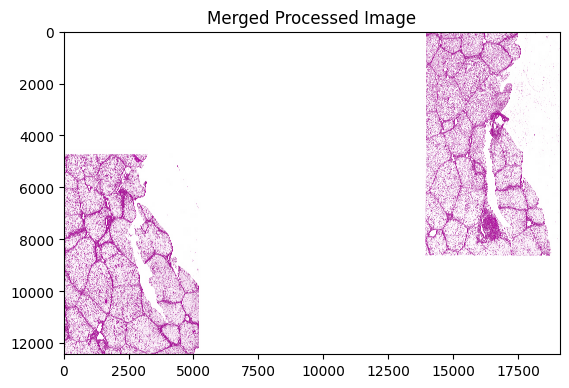

In [ ]:
from wsitools.tile_image import ImageSplitterMerger

# Create an ImageSplitterMerger instance with the specified parameters
image = ImageSplitterMerger(filename, tilesize_px=150, overlap_px=15, pixelsize_mm=[0.001, 0.001], #150px and pixelsize_mm=[0.001, 0.001] is probably best
                            fcn=process_tile)

# Split and merge the image, applying the specified tile processing function
merged_image_processed = image.split_and_merge_image()

# Display the input and merged images using Matplotlib
plt.imshow(merged_image_processed)
plt.title("Merged Processed Image")
plt.show()

In [ ]:
plt.imsave("output.png", merged_image_processed)

In [ ]:
plt.imsave("/content/gdrive/MyDrive/output_J7_5.png", merged_image_processed)

In [ ]:
from wsitools.tile_image import ImageSplitterMerger

orig_image = ImageSplitterMerger(filename, tilesize_px=3000, overlap_px=0, pixelsize_mm=[0.001, 0.001],
                            fcn=None)

# Split and merge the image (in this case we use no tile processing function) - we
# only want to visualize the original image
orig_merged_image = orig_image.split_and_merge_image()

# plt.imshow(orig_merged_image)
# plt.title("Original Image")
# plt.show()

2024-04-26 12:58:24.283 | WARNING  | wsitools.libfixer:<module>:15 - This module is deprecated. Use openslide and openslide_bin instead.
2024-04-26 12:58:24.357 | DEBUG    | wsitools.image:__init__:412 - fs_enc: utf-8
2024-04-26 12:58:24.359 | DEBUG    | wsitools.image:__init__:413 - Reading file J7_5_a.czi
2024-04-26 12:58:24.536 | DEBUG    | wsitools.image:_set_properties_czi:342 - nzi pixelsize  8.772367043811993e-07x8.772367043811993e-07 [m]
2024-04-26 12:58:24.551 | DEBUG    | wsitools.image:read_annotations:723 - Reading the annotation J7_5_a.czi


True


Merging Tiles: 100%|██████████| 20/20 [00:02<00:00,  7.02it/s]


In [ ]:
plt.imsave("/content/gdrive/MyDrive/large_images/orig_image.png", orig_merged_image)

### Image comparison

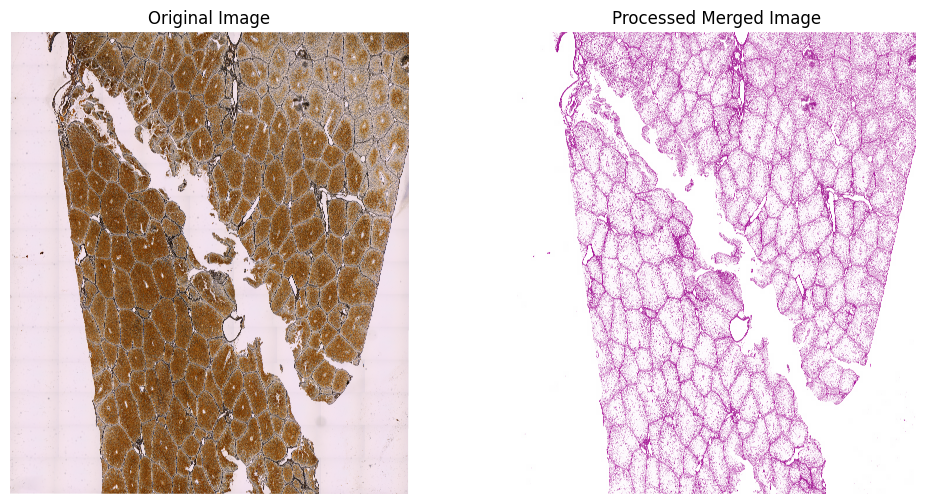

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(orig_merged_image)
axes[0].set_title("Original Image")
axes[0].axis('off')
axes[1].imshow(merged_image_processed)
axes[1].set_title("Processed Merged Image")
axes[1].axis('off')
plt.show()

## Hardware

In [ ]:
!nvidia-smi
!cat /proc/cpuinfo
!cat /proc/meminfo

Thu Apr 25 11:31:39 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0              30W /  70W |   4155MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--